In [1]:
# Essential Jupyter Notebook Magic
%matplotlib inline

# General Purpose and Data Handling Libraries
import os
import re
import glob
import numpy as np
import pandas as pd
from os import listdir
from os.path import isfile, join
from natsort import natsorted
import pickle
from operator import add
import random

# MatPlotlib for Plotting and Visualization
import matplotlib.pyplot as plt
import matplotlib.animation as animation
import matplotlib.tri as tri
import matplotlib as mpl
from matplotlib import cm, ticker
from matplotlib.colors import LogNorm, LightSource, ListedColormap, BoundaryNorm
from matplotlib.collections import LineCollection
from matplotlib.cm import ScalarMappable
from matplotlib.ticker import LogFormatter, LogFormatterSciNotation
from matplotlib.ticker import LogLocator, MultipleLocator, NullFormatter
from mpl_toolkits.mplot3d import axes3d
from mpl_toolkits.mplot3d import Axes3D
from streamtracer import StreamTracer, VectorGrid
from matplotlib.patches import FancyArrowPatch
from mpl_toolkits.mplot3d.proj3d import proj_transform
from mpl_toolkits.axes_grid1 import make_axes_locatable
from mpl_toolkits.mplot3d.art3d import Line3DCollection

# Scipy for Scientific Computing and Analysis
from scipy import stats, interpolate
from scipy.optimize import curve_fit
from scipy.interpolate import interp1d, griddata
from scipy.ndimage import label, gaussian_filter
from scipy.spatial import ConvexHull
from scipy.interpolate import RegularGridInterpolator
from skimage import measure
from shapely.geometry import Polygon

# Image Handling and Processing
from PIL import Image

# Tecplot for Scientific Data Visualization
import tecplot as tp
from tecplot.exception import *
from tecplot.constant import *

# For 3d plotting
from skimage import measure

In [2]:
# Define Constants
amu = 1.67e-27
k_b = 1.38e-23
mu_0 = 1.257e-6
R_M = 2440e3 #m
m_p = 1.67e-27 # kg
e = 1.60218e-19 # C

# Define utility functions
def read_dataset(mypath):
    # Reads in file "mypath" and returns a dataset object. May take a while for larger files.

    print("reading:",mypath)
    # First connect to TecPlot
    tp.session.connect(port=7600)

    # Configure layout
    tp.new_layout()
    dataset = tp.data.load_tecplot(mypath)
    frame = tp.active_frame()
    frame.plot_type = PlotType.Cartesian3D

    # Return dataset
    return dataset

def Bz_dip(x_array,y_array,z_array):
    # Input: arrays of x,y,z (in planet centered coords).
    # Output: Bz at each point
    
    return - 200.9 * (3*(z_array-0.2)**2 - (x_array**2+y_array**2+(z_array-0.2)**2))/((x_array**2+y_array**2+(z_array-0.2)**2)**(5/2))

def get_files(dir, key=".*cut_particle_region0_0.*", read_time = False, reduce = True):
    # For a directory "dir", return a list of all files which match the regex expression "key"
    
    all_files = [f for f in listdir(dir) if isfile(join(dir, f))]
    files=[]
    for file in all_files:
        match = re.search(key,file)
        if match != None:
            files.append(file)
    files.sort()
    
    # Now give them the appropriate name for their time
    # If we haven't already named these files with their time, do that now
    named_files = {}
    if read_time == False:
        for i in range(len(files)):
            time = round(i*dt+start_time,3)
            named_files[time] = files[i]
    # Otherwise, read the time right from the (last 6 elements) filename
    else:
        for i in range(len(files)):
            time = str("%.2f"%float(files[i][-6:]))
            named_files[time] = files[i]
    
    # Now cut the list down to files inside t_bound
    if reduce:
        reduced_files = {}
        for file_time in list(named_files.keys())[int((t_bound[0]-start_time)/dt):int((t_bound[1]-start_time)/dt)]: #only loop over the times within t_bound
            reduced_files[file_time] = str(named_files[file_time])
        return reduced_files

    else:
        return named_files

def dat_to_plt(dir,files):
    # Hand it a directory with the dict of files in it, and it will convert them to .plt and save in dir
    
    for file in files:
        dataset=read_dataset(str(dir+files[file]))
        print("saving file:",str(dir+files[file][:-3]+"plt"))
        tp.data.save_tecplot_plt(str(dir+files[file][:-3]+"plt"))
        os.remove(str(dir+files[file]))
        print(f"Deleted original .dat file: {files[file]}")

def plt_to_numpy(dataset,var_ls=["Bz"],save_cs = True):
    # Input: the path to a .plt file, and a list of variables to convert into a numpy meshgrid
    # Output: a dictionary of arrays, each labelled according to its name in var_ls
    # Var_ls should be *extensive*, so that this long process does not need to be rerun

    # Extract the coordinate axes
    x_axis = np.unique(dataset.variable("X").values(0).as_numpy_array())
    y_axis = np.unique(dataset.variable("Y").values(0).as_numpy_array())[1:-1]
    z_axis = np.unique(dataset.variable("Z").values(0).as_numpy_array())

    # Create an ordered zone
    rect_zone = dataset.add_ordered_zone('rect_zone',[len(x_axis),len(y_axis-2),len(z_axis)])

    # Create 3D coordinate meshgrids
    xxx,yyy,zzz = np.meshgrid(x_axis,y_axis,z_axis)

    # Assign coordinate values to the rect_zone using the meshgrids
    rect_zone.values('X')[:] = xxx.ravel()
    rect_zone.values('Y')[:] = yyy.ravel()
    rect_zone.values('Z')[:] = zzz.ravel()

    # Compute derivatives in tecplot, which does it efficiently
    # Compute current density, in A/m^2
    if ("Jx" in var_ls) or ("Jy" in var_ls) or ("Jz" in var_ls):
        print("Computing J = ∇xB")
        tp.data.operate.execute_equation(equation='{Jx} = (ddy({Bz}) - ddz({By}))/(1.2566*10**(-6))/2440000*10**(-9)',
            ignore_divide_by_zero=True)
        tp.data.operate.execute_equation(equation='{Jy} = (ddz({Bx}) - ddx({Bz}))/(1.2566*10**(-6))/2440000*10**(-9)',
            ignore_divide_by_zero=True)
        tp.data.operate.execute_equation(equation='{Jz} = (ddx({By}) - ddy({Bx}))/(1.2566*10**(-6))/2440000*10**(-9)',
            ignore_divide_by_zero=True)

    # Compute plasma pressure gradient, in nPa / m
    if ("dp_dx" in var_ls) or ("dp_dy" in var_ls) or ("dp_dz" in var_ls):
        print("Computing ∇$p$")
        tp.data.operate.execute_equation(equation='{dp_dx} = (ddx({pxxS1}+{pxxS0}+{pyyS1}+{pyyS0}+{pzzS1}+{pzzS0}))/3/2440000',
        ignore_divide_by_zero=True)
        tp.data.operate.execute_equation(equation='{dp_dy} = (ddy({pxxS1}+{pxxS0}+{pyyS1}+{pyyS0}+{pzzS1}+{pzzS0}))/3/2440000',
            ignore_divide_by_zero=True)
        tp.data.operate.execute_equation(equation='{dp_dz} = (ddz({pxxS1}+{pxxS0}+{pyyS1}+{pyyS0}+{pzzS1}+{pzzS0}))/3/2440000',
            ignore_divide_by_zero=True)
        
    # Compute magnetic field gradient , in nT / m
    if ("dB_dx" in var_ls) or ("dB_dy" in var_ls) or ("dB_dz" in var_ls): 
        print("Computing ∇B")
        tp.data.operate.execute_equation(equation='{dB_dx} = (ddx(({Bx}*{Bx}+{By}*{By}+{Bz}*{Bz})**(0.5)))/2440000',
            ignore_divide_by_zero=True)
        tp.data.operate.execute_equation(equation='{dB_dy} = (ddy(({Bx}*{Bx}+{By}*{By}+{Bz}*{Bz})**(0.5)))/2440000',
            ignore_divide_by_zero=True)
        tp.data.operate.execute_equation(equation='{dB_dz} = (ddz(({Bx}*{Bx}+{By}*{By}+{Bz}*{Bz})**(0.5)))/2440000',
            ignore_divide_by_zero=True)

    # Compute advective derivative (u . del) u
    if ("duix_dx" in var_ls):
        print("Computing jacobian for $(u_i\cdot∇)u_i$")
        tp.data.operate.execute_equation(equation='{duix_dx} = (ddx({uxS1}))/2440000', # km/s /m
            ignore_divide_by_zero=True)
        tp.data.operate.execute_equation(equation='{duiy_dx} = (ddx({uyS1}))/2440000', # km/s /m
            ignore_divide_by_zero=True)
        tp.data.operate.execute_equation(equation='{duiz_dx} = (ddx({uzS1}))/2440000', # km/s /m
            ignore_divide_by_zero=True)
        tp.data.operate.execute_equation(equation='{duix_dy} = (ddy({uxS1}))/2440000', # km/s /m
            ignore_divide_by_zero=True)
        tp.data.operate.execute_equation(equation='{duiy_dy} = (ddy({uyS1}))/2440000', # km/s /m
            ignore_divide_by_zero=True)
        tp.data.operate.execute_equation(equation='{duiz_dy} = (ddy({uzS1}))/2440000', # km/s /m
            ignore_divide_by_zero=True)
        tp.data.operate.execute_equation(equation='{duix_dz} = (ddz({uxS1}))/2440000', # km/s /m
            ignore_divide_by_zero=True)
        tp.data.operate.execute_equation(equation='{duiy_dz} = (ddz({uyS1}))/2440000', # km/s /m
            ignore_divide_by_zero=True)
        tp.data.operate.execute_equation(equation='{duiz_dz} = (ddz({uzS1}))/2440000', # km/s /m
            ignore_divide_by_zero=True)

    print("Beginning interpolation...")
    # Interpolate onto rect_zone
    tp.data.operate.interpolate_linear(source_zones=[0],
        destination_zone=1,
        fill_value=0)

    # Define dictionary to save results
    data3d = {"X":xxx,"Y":yyy,"Z":zzz}

    # All all variables to data
    for var in var_ls:
        data3d[var] = rect_zone.values(var).as_numpy_array().reshape(xxx.shape)

    # Save in place
    print("Extraction complete! Saving 3D data ...")
    save_file = open(str(dir+file[:-4]+"_numpy_t_"+'{:06.2f}'.format(round(time,2))), 'wb') 
    pickle.dump(data3d, save_file) 
    print("Done!")

    if save_cs:
        #Calculate the plasma beta meshgrid
        beta_meshgrid = (2*mu_0*(rect_zone.values("pxxS0").as_numpy_array()+rect_zone.values("pyyS0").as_numpy_array()+rect_zone.values("pzzS0").as_numpy_array()+rect_zone.values("pxxS1").as_numpy_array()+
                                rect_zone.values("pyyS1").as_numpy_array()+rect_zone.values("pzzS1").as_numpy_array())*1e9/3/(rect_zone.values("Bx").as_numpy_array()**2+rect_zone.values("By").as_numpy_array()**2+rect_zone.values("Bz").as_numpy_array()**2)).reshape(xxx.shape)
        beta_meshgrid[np.isnan(beta_meshgrid)] = -1
        
         # New code: extract all of the Z coords, smooth them, and then find the values interpolated to those points!
        data = {"X":xxx[:,:,0],"Y":yyy[:,:,0]} #, "Z":np.zeros_like(xxx[:,:,0])}
        print("Saving cs data...")
        # Define empty array to save the unsmoothed Z values to
        Z_rough = np.zeros_like(xxx[:,:,0])+0.2
        # At each x/y, find the z coord of max beta and save that
        for idy in range(len(yyy[:,0,0])):
            for idx in range(len(xxx[0,:,0])):
                # If any of the beta values in this column are -1 near the middle, that means we are at the inner edge of the bounding box
                # In this case, set the data value to 0 to let me know where the boundary is!
                if np.min(beta_meshgrid[idy,idx,len(z_axis)//4:-len(z_axis)//4]) == -1:
                    Z_rough[idy,idx] = 0.2
                else:
                    idz = np.argmax(beta_meshgrid[idy,idx,:])
                    Z_rough[idy,idx] = zzz[idy,idx,idz]
    
        # Smoothing parameter
        smoothing_param = 5
        # Smooth the Z meshgrid
        data['Z'] = smooth_meshgrid(xxx[:,:,0], yyy[:,:,0], Z_rough, smoothing_param)
    
        # Use this as a template to extract all the other data with
        for name in var_ls:
            data[name] = np.zeros_like(xxx[:,:,0])
    
            # Extract each variable from tecplot as an array
            var = rect_zone.values(name).as_numpy_array().reshape(xxx.shape)
    
            # At each x/y, find the z coord of max beta and save that
            for idy in range(len(yyy[:,0,0])):
                for idx in range(len(xxx[0,:,0])):
                    # If any of the beta values in this column are -1 near the middle, that means we are at the inner edge of the bounding box
                    # In this case, set the data value to 0 to let me know where the boundary is!
                    if np.min(beta_meshgrid[idy,idx,len(z_axis)//4:-len(z_axis)//4]) == -1:
                        data[name][idy,idx] = 0
                    else:
                        # Find the indices of the two nearest points
                        lower_idz = np.searchsorted(zzz[idy,idx,:], data['Z'][idy,idx]) - 1
                        upper_idz = lower_idz + 1
    
                        # Get the coordinates of the nearest points
                        Z_lower = zzz[idy,idx,lower_idz]
                        Z_upper = zzz[idy,idx,upper_idz]
                        var_lower = var[idy,idx,lower_idz]
                        var_upper = var[idy,idx,upper_idz]
                        
                        # Perform linear interpolation
                        data[name][idy,idx] = var_lower + (var_upper - var_lower) * (data['Z'][idy,idx] - Z_lower) / (Z_upper - Z_lower)
    
        print("Done!")
        save_file = open(str(dir+file[:-4]+"_csdata_t_"+'{:06.2f}'.format(round(time,2))), 'wb') 
        pickle.dump(data, save_file) 


def smooth_meshgrid(X, Y, Z, smoothing_param):
    """
    Smooth the Z values of a meshgrid defined by X, Y coordinates using a Gaussian filter.
    
    Parameters:
    X (2D numpy array): The X coordinates of the meshgrid.
    Y (2D numpy array): The Y coordinates of the meshgrid.
    Z (2D numpy array): The Z coordinates of the meshgrid.
    smoothing_param (float): The standard deviation for the Gaussian kernel, controlling the smoothing.
    
    Returns:
    Z_smoothed (2D numpy array): The smoothed Z values of the meshgrid.
    """
    # Check if X, Y, Z are of the same shape
    if X.shape != Y.shape or X.shape != Z.shape:
        raise ValueError("X, Y, and Z meshgrids must have the same shape")
    
    # Apply Gaussian filter to the Z meshgrid
    Z_smoothed = gaussian_filter(Z, sigma=smoothing_param)
    
    return Z_smoothed

def plot_sphere(ax, radius=1, center=(0, 0, 0), color='b', alpha=0.5, zorder = 1,quarter=False, xlims = [-10,10], ylims = [-10,10], zlims = [-10,10]):
    """
    Plots a sphere of given radius centered at center on the provided 3D axis.
    
    Parameters:
    - ax: The 3D axis to plot the sphere on.
    - radius: The radius of the sphere (default: 1).
    - center: The (x, y, z) coordinates of the sphere's center (default: (0, 0, 0)).
    - color: The color of the sphere (default: blue).
    - alpha: The transparency of the sphere (default: 0.5).
    """
    u = np.linspace(np.pi/2, 3/2 * np.pi, 100)
    if quarter:
        v = np.linspace(0, np.pi/2, 100)
    else:
        v = np.linspace(0, np.pi, 100)
    x = radius * np.outer(np.cos(u), np.sin(v)) + center[0]
    y = radius * np.outer(np.sin(u), np.sin(v)) + center[1]
    z = radius * np.outer(np.ones(np.size(u)), np.cos(v)) + center[2]

    # Mask out any values outside the axes lims
    mask = (x < xlims[0]) | (x > xlims[1]) | (y < ylims[0]) | (y > ylims[1]) | (z < zlims[0]) | (z > zlims[1]) 
    x[mask] = np.nan
    y[mask] = np.nan
    z[mask] = np.nan

    ax.plot_surface(x, y, z, color=color, alpha=alpha, zorder=zorder)

def average_value(var_ls,t0,t_start,t_stop,type='csdata'):
    # Input: Variables to average, the current time (t0), and the times relative to present to average over (t0+t_start to t0+t_stop)
    # Ouput: dictionary of arrays of time-averaged values

    averages = {}
    count = 0

    temp_files = get_files(dir,key="3d\_fluid.*"+type+"\_t\_...\...",read_time = True, reduce = False)

    for t in list(temp_files.keys()): 
        # Check to see if this file is in the time range we want
        if (float(t) >= (t0+t_start)) and (float(t) <= t0+t_stop):
            temp_file = str(temp_files[t])
    
            # Read in this data
            with open(dir+temp_file, 'rb') as f:
                temp_data = pickle.load(f) 
            
            # Add the data to our running average for each variable
            for var in var_ls:
                if var not in averages.keys():
                    averages[var] = temp_data[var]
                else:
                    averages[var] += temp_data[var]

            count += 1
        
    # Divide by total time steps
    for var in var_ls:
        averages[var] = averages[var]/count

    return averages

def find_indices(X, Y, XX, YY):
    # Function used to get ix and iy for some coordinates X and Y
    X = np.array(X)
    Y = np.array(Y)
    XX = np.array(XX)
    YY = np.array(YY)

    ix = []
    iy = []
    
    for (x, y) in zip(X, Y):
        # Find the closest index in the meshgrid for the x coordinate
        ix_index = np.abs(XX[0] - x).argmin()
        # Find the closest index in the meshgrid for the y coordinate
        iy_index = np.abs(YY[:, 0] - y).argmin()
        
        ix.append(ix_index)
        iy.append(iy_index)
        
    return iy, ix

def remove_duplicate_rows(arr):
    # Used in df_tracker... does something to remove repeated rows in the matching matrix
    seen = set()
    filtered_rows = []
    for row in arr:
        if row[0] not in seen:
            filtered_rows.append(row)
            seen.add(row[0])
    return np.array(filtered_rows)

def find_boundary_points(X, Y):
    # Combine the coordinate lists into a single array of points
    points = np.column_stack((X, Y))

    # Compute the convex hull of the points
    hull = ConvexHull(points)

    # Extract the boundary points
    boundary_points = hull.vertices

    # Boundary points in original coordinate lists
    boundary_X = points[boundary_points, 0]
    boundary_Y = points[boundary_points, 1]

    return boundary_X.tolist(), boundary_Y.tolist()

def create_above_surface_mask(X, Y, Z, XX, YY, ZZ):
    # Works out all the 3D points above a 2D surface ie all the points above the current sheet.
    # Used for 3D plotting to determine what is above what.
    # Check that XX, YY, ZZ have the same shape
    assert XX.shape == YY.shape == ZZ.shape, "Arrays XX, YY, and ZZ must have the same shape"
    
    # Check that X, Y, Z have the same shape
    assert X.shape == Y.shape == Z.shape, "Arrays X, Y, and Z must have the same shape"

    # Determine the shape of the input arrays
    nx, ny, nz = XX.shape

    # Initialize a mask with the same shape as ZZ
    mask = np.zeros_like(ZZ, dtype=bool)

    # Iterate over the entire 3D meshgrid
    for i in range(nx):
        for j in range(ny):
            # Find the index in the 2D arrays corresponding to the x and y coordinates
            xi = np.argmin(np.abs(X[0] - XX[i, j, 0]))
            yi = np.argmin(np.abs(Y[:, 0] - YY[i, j, 0]))

            # Compare ZZ with Z to determine the mask
            mask[i, j, :] = ZZ[i, j, :] > Z[yi, xi]

    return mask


def compute_dt(var_ls,time,type='csdata'):
    # Input: variables to compute the time derivative for, and the current time
    # Output: dictionary of time derivatives for each variable, calculated as dvar_dt = var(time+dt)-var(time-dt)/(2*dt)
    # If earlier or later times are not available, we do either var(time+dt)-var(time)/dt or var(time)-var(time-dt)/dt

    # Declare output dictionary
    deriv_dict = {}
    print("Computing time derivatives at time",time)
    key_minus = '{:.2f}'.format((float(time)-dt), 'wb')
    key_plus = '{:.2f}'.format((float(time)+dt), 'wb')
    #print(files.keys())
    #print(key_minus)
    #print(key_plus)

    if type=='csdata':
        temp_files = filescs
        data = datacs
    elif type=='numpy':
        temp_files = files3D
        data = data3d

    # Read in the data depending on whether its available
    if (key_minus in temp_files.keys()) and (key_plus in temp_files.keys()):
        # Case one: earlier and later timestep available, so use both
        print("Earlier and later timesteps available!")
        with open(dir+temp_files[key_minus], 'rb') as f:
            data_tminus = pickle.load(f) 
        with open(dir+temp_files[key_plus], 'rb') as f:
            data_tplus = pickle.load(f) 
        for var in var_ls:
            deriv_dict[var] = (data_tplus[var]-data_tminus[var])/(2*dt)
    
    elif (key_minus in temp_files.keys()):
        # Case two: only earlier time available
        print("Only earlier timestep available!")
        with open(dir+temp_files[key_minus], 'rb') as f:
            data_tminus = pickle.load(f) 
        for var in var_ls:
            deriv_dict[var] = (data[var]-data_tminus[var])/(dt)

    elif (key_plus in temp_files.keys()):
        # Case three: only later time available
        print("Only later timestep available!")
        print(dir+temp_files[key_plus])
        with open(dir+temp_files[key_plus], 'rb') as f:
            data_tplus = pickle.load(f) 
        for var in var_ls:
            deriv_dict[var] = (data_tplus[var]-data[var])/(dt)

    else:
        print("ERROR: NO OTHER TIMESTEPS FOUND FOR DERIVATIVE")
            
    return deriv_dict

def plane_intersection(x, y, z, plane_z=0.2):
    # Used in 3D_df_tracker2 to check whether a given field line intersects the current sheet multiple times or not
    intersections = 0  # Counter for intersections with the plane

    # Iterate over the list of points
    for i in range(1, len(z)):
        if (z[i-1] - plane_z) * (z[i] - plane_z) < 0:
            # There is an intersection between z[i-1] and z[i] since their signs are different
            intersections += 1
        elif z[i-1] == plane_z and z[i] != plane_z:
            # Edge case: the point is exactly on the plane
            intersections += 1

    return intersections

def symlog(x):
    """ Returns the symmetric log10 value """
    return np.sign(x) * np.log10(np.abs(x))

def symroot(x):
    """ Returns the symmetric sqrt value """
    return np.sign(x) * np.sqrt(np.abs(x))

In [3]:
# STEP ONE: process data
dir = "/Users/atcushen/Documents/MercuryModelling/runs/nightside_v4_run1/ta-234e/" #   # Directory with data 
start_time = 30 
t_bound = [40,70]                                               # Start and stop times of this data to be plot
dt = 0.05                                                     # What is the timestZep between files?
convert_first = True # Set to true to make sure files are converted from .dat to .plt. Set to false if there are .dat files in the directory which do not need to be converted

var_ls = ["Bx","By","Bz","Ex","Ey","Ez","rhoS0","uxS0","uyS0","uzS0","pxxS0","pyyS0","pzzS0","pxyS0","pxzS0","pyzS0",
          "rhoS1","uxS1","uyS1","uzS1","pxxS1","pyyS1","pzzS1","pxyS1","pxzS1","pyzS1","Jx","Jy","Jz","dp_dx","dp_dy","dp_dz",
          "dB_dx","dB_dy","dB_dz","duix_dx","duiy_dx","duiz_dx","duix_dy","duiy_dy","duiz_dy","duix_dz","duiy_dz","duiz_dz"]


# RUN
if convert_first:
    files = get_files(dir,key="3d\_fluid.*\.dat")
    dat_to_plt(dir,files)

files = get_files(dir,key="3d\_fluid.*\.plt")

for time in list(files.keys()): 
    print("Extracting data for t =",time)
    file = str(files[time])

    # Read in dataset
    dataset = read_dataset(dir+file)
    # Save .plt as numpy data
    data = plt_to_numpy(dataset,var_ls=var_ls)


Extracting data for t = 65.0
reading: /Users/atcushen/Documents/MercuryModelling/runs/nightside_v4_run1/ta-3e/3d_fluid_region0_0_t00000105_n00029113_amrex.plt
Connecting to Tecplot 360 TecUtil Server on:
    tcp://localhost:7600
Connection established.
Computing J = ∇xB
Computing ∇$p$
Computing ∇B
Computing jacobian for $(u_i\cdot∇)u_i$
Beginning interpolation...
Extraction complete! Saving 3D data ...
Done!


/var/folders/l9/dnt9qhfd1psfsmj9t5zfr0j00000gq/T/ipykernel_64882/2778238255.py:171: RuntimeWarning: invalid value encountered in divide
  beta_meshgrid = (2*mu_0*(rect_zone.values("pxxS0").as_numpy_array()+rect_zone.values("pyyS0").as_numpy_array()+rect_zone.values("pzzS0").as_numpy_array()+rect_zone.values("pxxS1").as_numpy_array()+


Saving cs data...
Done!
Extracting data for t = 65.05
reading: /Users/atcushen/Documents/MercuryModelling/runs/nightside_v4_run1/ta-3e/3d_fluid_region0_0_t00000105_n00029144_amrex.plt
Connecting to Tecplot 360 TecUtil Server on:
    tcp://localhost:7600
Connection established.
Computing J = ∇xB
Computing ∇$p$
Computing ∇B
Computing jacobian for $(u_i\cdot∇)u_i$
Beginning interpolation...
Extraction complete! Saving 3D data ...
Done!
Saving cs data...
Done!
Extracting data for t = 65.1
reading: /Users/atcushen/Documents/MercuryModelling/runs/nightside_v4_run1/ta-3e/3d_fluid_region0_0_t00000105_n00029175_amrex.plt
Connecting to Tecplot 360 TecUtil Server on:
    tcp://localhost:7600
Connection established.
Computing J = ∇xB
Computing ∇$p$
Computing ∇B
Computing jacobian for $(u_i\cdot∇)u_i$
Beginning interpolation...
Extraction complete! Saving 3D data ...
Done!
Saving cs data...
Done!
Extracting data for t = 65.15
reading: /Users/atcushen/Documents/MercuryModelling/runs/nightside_v4_run

In [3]:
# STEP TWO: read and plot
dir = "/Users/atcushen/Documents/MercuryModelling/runs/nightside_v4_run1/ta-234e/"     # Directory with data 
start_time = 30 
t_bound = [40,70]                                               # Start and stop times of this data to be plot
dt = 0.05         

# Plotmode settings
plot_preset = '3D_df_tracker2'

'''
"3D_Bz": Bz in PIC domain.

"3D_Bz1": Bz1 in PIC domain.

"3D_delta_Bz": delta Bz in PIC domain.

"3D_df_tracker": show DFs and track their trajectories, saving a dictionary of their data

"3D_field_lines": view of field line geometry in FLEKS domain

"3D_flux_tube_content":

"3D_FACs": scatterplot 3D shading of parallel and anti-parallel FACS

"3D_FAC_fieldlines": field lines showing connectivity of FACs to DFs

"3D_current_sheet": Shows 3 xz plane slices of the plasma beta and current density, to demonstrate cs fit

"3D_gridscale_df_tracker": Similar to df_tracker, but does not compute DF-averaged quantities, instead finding full electric field and current terms

"3D_df_tracker2": Complete redesign of df tracker algorithm, post-AGU2024. Not finished, but is nice and tidy for testing out different search criteria. Field line categorization is implemented.

"3D_df_tracker3": Uses convex decomposition to find regions.
'''

# Zoom controls, for 3D_df_tracker and 3D_gridscale_df_tracker:
do_zoom = True # whether panels should zoom
zoom_time_start = 50.00 # when to start zooming
zoom_time_end = 52.00 # when to end
zoom_x_range = [-3,0] # what x region to zoom to
zoom_y_range = [-0.75,0.75] # what y region to zoom to
zoom_z_range = [0,0.8]
azim_start = -110
azim_end = -130
elev_start = 25
elev_end = 40

# For 3D_gridscale_df_tracker:
gridscale_physics = "forces" # "currents" to show J_inrt and J_gradp or "forces" to show JxB and -grad(p)

#RUN
files3D = get_files(dir,key="3d\_fluid.*numpy\_t\_...\...",read_time = True)
filescs = get_files(dir,key="3d\_fluid.*csdata\_t\_...\...",read_time = True)

iter = 0
for time in list(files3D.keys()): 
    print("Plotting t =",time)

    # Read in the 3D data
    file3D = str(files3D[time])
    with open(dir+file3D, 'rb') as f:
        data3d = pickle.load(f) 
    
    # Read in current sheet data
    filecs = str(filescs[time])
    with open(dir+filecs, 'rb') as f:
        datacs = pickle.load(f) 

    # PLOT PRESET 'Bz'
    if plot_preset=='3D_Bz':
        fig = plt.figure(figsize=(13,6), constrained_layout=True)
        ax = fig.add_subplot(111, projection="3d",computed_zorder=False)

        # Unpack variables
        X = datacs["X"]
        Y = datacs["Y"]
        Z = datacs["Z"]
        Bz = datacs["Bz"]

        # Mask out values
        radius = 1.10
        mask = (X**2 + Y**2) < radius**2
        Z[mask] = np.nan

        mid = 71 # Row index corresponding to midnight 
        # Define colormap and lighting
        norm = plt.Normalize(-50,50)
        dawn_colors = cm.bwr(norm(Bz[:mid,:]),alpha=0.5)
        dusk_colors = cm.bwr(norm(Bz[mid:,:]),alpha=0.5)

        # Set the lighting
        light = LightSource()  # Azimuth and altitude of the light source
        dawn_illuminated_colors = light.shade_rgb(dawn_colors, Z[:mid,:], blend_mode='soft')  # Apply light source shading
        dusk_illuminated_colors = light.shade_rgb(dusk_colors, Z[mid:,:], blend_mode='soft')  # Apply light source shading

        # move camera view
        ax.view_init(elev=20, azim=-110)

        # Create the surface plot
        surf1 = ax.plot_surface(X[:mid,:], Y[:mid,:], Z[:mid,:], facecolors=dawn_illuminated_colors, rstride=1, cstride=1, antialiased=False, zorder=2)
        surf2 = ax.plot_surface(X[mid:,:], Y[mid:,:], Z[mid:,:], facecolors=dusk_illuminated_colors, rstride=1, cstride=1, antialiased=False, zorder=1.5)
        plot_sphere(ax,radius=1,color='lightgrey',alpha=0.5,zorder=-1)
        plot_sphere(ax,radius=0.8,color='grey',alpha=1,zorder=-0.75)
        
        # Add stream traces
        nsteps = 10000
        step_size = 0.001
        tracer = StreamTracer(nsteps, step_size)
        ny,nx,nz = data3d["Bx"].shape
        
        field = np.zeros((nx,ny,nz,3))
        field[:,:,:,0] = np.transpose(data3d["Bx"],axes=[1,0,2])
        field[:,:,:,1] = np.transpose(data3d["By"],axes=[1,0,2])
        field[:,:,:,2] = np.transpose(data3d["Bz"],axes=[1,0,2])
        
        grid_spacing = [1/64,1/64,1/64]
        grid = VectorGrid(field, grid_spacing, origin_coord = [data3d["X"].min(),data3d["Y"].min(),data3d["Z"].min()])
        
        seeds = np.array([[-1.5,0,0.2], [-1.75,0,0.2],[-2,0,0.2],[-2.25,0,0.2]])
        tracer.trace(seeds, grid)

        for seed in range(len(seeds)):
            start = np.where(tracer.xs[seed][:,2]>=seeds[seed][2])[0][0]
            ax.plot(tracer.xs[seed][start:,0],tracer.xs[seed][start:,1],tracer.xs[seed][start:,2],color='black',linewidth=0.5,zorder=2)

        # Add a color bar 
        m = cm.ScalarMappable(cmap=cm.bwr, norm=norm)
        m.set_array(Bz)
        clb = fig.colorbar(m, ax=ax, shrink=0.3, aspect=7,anchor=(0.5,0.3))
        clb.ax.tick_params(labelsize=12)
        clb.ax.set_title('$B_z$ [nT]',fontsize=12)

        # Set axes
        z_lower = -0.6
        z_upper = 1.0
        ax.set_zlim(z_lower,z_upper)
        x_range = X.max() - X.min()
        y_range = Y.max() - Y.min()
        z_range = z_upper - z_lower
        ax.set_box_aspect([x_range, y_range, z_range])  # Aspect ratio is set based on the data limits
        
        # Add labels
        ax.set_xlabel("X [$R_M$]",fontsize=12)
        ax.set_ylabel("Y [$R_M$]",fontsize=12)
        ax.set_zlabel("Z [$R_M$]",fontsize=12)
        ax.tick_params(axis='both',labelsize=12)
        ax.set_title(str("$B_z$ at t="+time+"s"),fontsize=12,y=1.0, pad=-14)

        # Save
        fig.savefig(str(str(dir[:-1])+"_plots/"+plot_preset+"_"+time+'.png'),bbox_inches='tight',pad_inches=0.3, dpi=300)
        plt.close(fig)

    # PLOT PRESET '3D_Bz1'
    if plot_preset=='3D_Bz1':
        fig = plt.figure(figsize=(13,6), constrained_layout=True)
        ax = fig.add_subplot(111, projection="3d",computed_zorder=False)

        # Unpack variables
        Xcs = datacs["X"]
        Ycs = datacs["Y"]
        Zcs = datacs["Z"]
        Bzcs = datacs["Bz"]
        Bz1cs = Bzcs - Bz_dip(Xcs,Ycs,Zcs)
        
        X3d = data3d["X"]
        Y3d = data3d["Y"]
        Z3d = data3d["Z"]
        Bz3d = data3d["Bz"]
        Bz13d = Bz3d - Bz_dip(X3d,Y3d,Z3d)

        # Mask out values
        radius = 1.10
        mask = (Xcs**2 + Ycs**2) < radius**2
        Zcs[mask] = np.nan

        mid = 71 # Row index corresponding to midnight 
        # Define colormap and lighting
        vmin=-100
        vmax=0
        norm = plt.Normalize(-100,10)
        dawn_colors = cm.plasma(norm(Bz1cs[:mid,:]),alpha=0.5)
        dusk_colors = cm.plasma(norm(Bz1cs[mid:,:]),alpha=0.5)

        # Set the lighting
        light = LightSource()  # Azimuth and altitude of the light source
        dawn_illuminated_colors = light.shade_rgb(dawn_colors, Z[:mid,:], blend_mode='soft')  # Apply light source shading
        dusk_illuminated_colors = light.shade_rgb(dusk_colors, Z[mid:,:], blend_mode='soft')  # Apply light source shading

        # move camera view
        ax.view_init(elev=5, azim=-90)

        # Create the surface plot
        surf1 = ax.plot_surface(X[:mid,:], Y[:mid,:], Z[:mid,:], facecolors=dawn_illuminated_colors, rstride=1, cstride=1, antialiased=False, zorder=2)
        surf2 = ax.plot_surface(X[mid:,:], Y[mid:,:], Z[mid:,:], facecolors=dusk_illuminated_colors, rstride=1, cstride=1, antialiased=False, zorder=1)
        plot_sphere(ax,radius=1,color='lightgrey',alpha=0.5,zorder=1)
        plot_sphere(ax,radius=0.8,color='grey',alpha=1,zorder=1.25)
        
        # Add isosurfaces
        b1min = 0
        iso = ax.scatter(X3d[Bz13d>b1min],Y3d[Bz13d>b1min],Z3d[Bz13d>b1min],c=Bz13d[Bz13d>b1min],
                         vmin=vmin,vmax=vmax,cmap='plasma',s=1,alpha=0.5)

        # Add a color bar 
        m = cm.ScalarMappable(cmap=cm.plasma, norm=norm)
        m.set_array(Bz1cs)
        clb = fig.colorbar(m, ax=ax, shrink=0.3, aspect=7,anchor=(0.5,0.3))
        clb.ax.tick_params(labelsize=12)
        clb.ax.set_title('$B_{z1}$ [nT]',fontsize=12,pad=10)

        # Set axes
        z_lower = -0.6
        z_upper = 1.0
        ax.set_zlim(z_lower,z_upper)
        x_range = X.max() - X.min()
        y_range = Y.max() - Y.min()
        z_range = z_upper - z_lower
        ax.set_box_aspect([x_range, y_range, z_range])  # Aspect ratio is set based on the data limits
        
        # Add labels
        ax.set_xlabel("X [$R_M$]",fontsize=12)
        ax.set_ylabel("Y [$R_M$]",fontsize=12)
        ax.set_zlabel("Z [$R_M$]",fontsize=12)
        ax.tick_params(axis='both',labelsize=12)
        ax.set_title(str("$B_{z1}$ at t="+time+"s"),fontsize=12,y=1.0, pad=-14)

        # Save
        fig.savefig(str(str(dir[:-1])+"_plots/"+plot_preset+"_"+time+'.png'),bbox_inches='tight',pad_inches=0.3, dpi=300)
        plt.close(fig)


    # PLOT PRESET '3D_delta_Bz'
    if plot_preset=='3D_delta_Bz':
        fig = plt.figure(figsize=(13,6), constrained_layout=True)
        ax = fig.add_subplot(111, projection="3d",computed_zorder=False)
        x_cutoff = 0 # How many indices in X to cutoff
        z_cutoff = 0 # How many indices in Z to cutoff

        # Unpack variables
        Xcs = datacs["X"][:,x_cutoff:]
        Ycs = datacs["Y"][:,x_cutoff:]
        Zcs = datacs["Z"][:,x_cutoff:]
        Bzcs = datacs["Bz"][:,x_cutoff:]
        deltaBzcs = Bzcs - average_value(["Bz"],float(time),-5,-2,type='csdata')["Bz"][:,x_cutoff:]
        
        X3d = data3d["X"][:,x_cutoff:,z_cutoff:]
        Y3d = data3d["Y"][:,x_cutoff:,z_cutoff:]
        Z3d = data3d["Z"][:,x_cutoff:,z_cutoff:]
        Bz3d = data3d["Bz"][:,x_cutoff:,z_cutoff:]
        deltaBz3d = Bz3d - average_value(["Bz"],float(time),-5,2,type='numpy')["Bz"][:,x_cutoff:,z_cutoff:]


        # Mask out values
        radius = 1.01
        mask = (Xcs**2 + Ycs**2) < radius**2
        Zcs[mask] = np.nan

        mid = 71 # Row index corresponding to midnight 
        # Define colormap and lighting
        vmin=-25
        vmax=25
        norm = plt.Normalize(vmin,vmax)
        dawn_colors = cm.bwr(norm(deltaBzcs[:mid,:]),alpha=0.9)
        dusk_colors = cm.bwr(norm(deltaBzcs[mid:,:]),alpha=0.9)

        # Set the lighting
        light = LightSource()  # Azimuth and altitude of the light source
        dawn_illuminated_colors = light.shade_rgb(dawn_colors, Zcs[:mid,:], blend_mode='soft')  # Apply light source shading
        dusk_illuminated_colors = light.shade_rgb(dusk_colors, Zcs[mid:,:], blend_mode='soft')  # Apply light source shading

        # move camera view
        ax.view_init(elev=30, azim=-160)

        # Create the surface plot
        surf1 = ax.plot_surface(Xcs[:mid,:], Ycs[:mid,:], Zcs[:mid,:], facecolors=dawn_illuminated_colors, rstride=1, cstride=1, antialiased=False, zorder=2)
        surf2 = ax.plot_surface(Xcs[mid:,:], Ycs[mid:,:], Zcs[mid:,:], facecolors=dusk_illuminated_colors, rstride=1, cstride=1, antialiased=False, zorder=1.5)
        plot_sphere(ax,radius=1,color='lightgrey',alpha=0.5,zorder=1)
        plot_sphere(ax,radius=0.8,color='grey',alpha=1,zorder=1.25)
        
        # Add isosurfaces
        Bmin = 10
        above_mask = (deltaBz3d>Bmin) & create_above_surface_mask(Xcs, Ycs, Zcs, X3d, Y3d, Z3d) 
        #iso1 = ax.scatter(X3d[above_mask],Y3d[above_mask],Z3d[above_mask],c=deltaBz3d[above_mask],cmap='bwr',vmin=vmin,vmax=vmax,
        #                 s=0.8,zorder=3,alpha = np.clip(((deltaBz3d[above_mask]-Bmin)/(vmax-Bmin))**0.2,0,1))
        iso1 = ax.scatter(X3d[above_mask],Y3d[above_mask],Z3d[above_mask],c=(-Z3d[above_mask]),cmap='Greens',vmin=-0.6,vmax=0.1,
                         s=0.8,zorder=3,alpha = 0.8)#,alpha = np.clip(((deltaBz3d[above_mask]-Bmin)/(vmax-Bmin))**0.2,0,1))
        below_mask = (deltaBz3d>Bmin) & ~(create_above_surface_mask(Xcs, Ycs, Zcs, X3d, Y3d, Z3d)) 
        iso2 = ax.scatter(X3d[below_mask],Y3d[below_mask],Z3d[below_mask],c=(-Z3d[below_mask]),cmap='Greens',vmin=-0.5,vmax=0.5,
                         s=0.8,zorder=0.75,alpha = 0.8)#,alpha = np.clip(((deltaBz3d[below_mask]-Bmin)/(vmax-Bmin))**0.2,0,1))

        # Add Bz=0 line
        #contour_mask = np.isclose(Bzcs, 0, atol=0.5) & (Xcs<-1.3)
        #ax.scatter(Xcs[contour_mask], Ycs[contour_mask], Zcs[contour_mask],c='black',s=0.03,zorder=2.1)
        
        # Add a color bar 
        m = cm.ScalarMappable(cmap=cm.bwr, norm=norm)
        m.set_array(deltaBzcs)
        clb = fig.colorbar(m, ax=ax, shrink=0.3, aspect=7,anchor=(-0.5,0.3))
        clb.ax.tick_params(labelsize=12)
        clb.ax.set_title('$\delta B_{z}$ [nT]',fontsize=12,pad=10)

        # Add big x axis
        ax.plot([np.min(Xcs[:mid,:]),-1],[0,0],[0.2,0.2],color='black',lw=2)
        ax.scatter([-4,-3,-2,-1],[0,0,0,0],[0.2,0.2,0.2,0.2],s=5,color='black')

        # Set axes
        z_lower = -0.1
        z_upper = 1.0
        ax.set_zlim(z_lower,z_upper)
        x_range = Xcs.max() - Xcs.min()
        y_range = Ycs.max() - Ycs.min()
        z_range = z_upper - z_lower
        ax.set_box_aspect([x_range, y_range, z_range])  # Aspect ratio is set based on the data limits
        
        # Add labels
        ax.set_xlabel("\nX [$R_M$]",fontsize=12)
        ax.set_ylabel("Y [$R_M$]",fontsize=12)
        ax.set_zlabel("Z [$R_M$]",fontsize=12)
        ax.tick_params(axis='both',labelsize=12)
        ax.set_title(str("$\delta B_{z}$ at t="+time+"s"),fontsize=12,y=1.0, pad=-14)

        # Save
        fig.savefig(str(str(dir[:-1])+"_plots/"+plot_preset+"_"+time+'.png'),bbox_inches='tight',pad_inches=0.3, dpi=300)
        plt.close(fig)

    if plot_preset=='3D_field_lines':

        # Set up plot environment
        fig = plt.figure(figsize=(18,6))
        ax = fig.add_subplot(111, projection="3d",computed_zorder=False)
        
        # Unpack data
        Xcs = datacs["X"]
        Ycs = datacs["Y"]
        Zcs = datacs["Z"]
        X3d = data3d["X"]
        Y3d = data3d["Y"]
        Z3d = data3d["Z"]
        Bx3d = data3d["Bx"]
        By3d = data3d["By"]
        Bz3d = data3d["Bz"]
        ncs = datacs["rhoS1"]
        n3d = data3d["rhoS1"] * 1e6 # convert to SI
        pe3d = ((data3d["pxxS0"]+data3d["pyyS0"]+data3d["pzzS0"])/3*1e-9) # convert to SI
        pi3d = ((data3d["pxxS1"]+data3d["pyyS1"]+data3d["pzzS1"])/3*1e-9) # convert to SI

        # Set axes
        z_lower = -1
        z_upper = 1
        ax.set_zlim(z_lower,z_upper)
        x_range = X3d.max() - X3d.min()
        y_range = Y3d.max() - Y3d.min()
        z_range = z_upper - z_lower
        ax.set_box_aspect([x_range, y_range, z_range])  # Aspect ratio is set based on the data limits

        # Set up grid for field line tracing
        ny,nx,nz = Bx3d.shape
        field = np.zeros((nx,ny,nz,3))
        field[:,:,:,0] = np.transpose(Bx3d,axes=[1,0,2])
        field[:,:,:,1] = np.transpose(By3d,axes=[1,0,2])
        field[:,:,:,2] = np.transpose(Bz3d,axes=[1,0,2])
        grid_spacing = [1/64,1/64,1/64]
        grid = VectorGrid(field, grid_spacing, origin_coord = [X3d.min(),Y3d.min(),Z3d.min()])
        nsteps = 10000
        step_size = 0.001
        tracer = StreamTracer(nsteps, step_size)

        # Add stream trace seed at each CS x,y
        trace_skip=16
        seeds = np.zeros((len(Xcs[::trace_skip,::trace_skip].ravel()),3))
        seeds[:,0] = Xcs[::trace_skip,::trace_skip].ravel()
        seeds[:,1] = Ycs[::trace_skip,::trace_skip].ravel()
        seeds[:,2] = Zcs[::trace_skip,::trace_skip].ravel()

        # Trace the field lines
        tracer.trace(seeds, grid)

        # Integrate quantities along field line
        #for i,seed in enumerate(seeds):
        #    print(tracer.xs[i][0,:])

        # Plot field lines

        # Define colormap to use for field lines
        cmap = plt.colormaps["Reds"] #plt.get_cmap('Greys')  # You can choose any colormap you like
        norm = plt.Normalize(-1.2, 0.8)
        
        for i,seed in enumerate(seeds):
            above = np.where(tracer.xs[i][:,2]>=seeds[i][2])[0]
            below = np.where(tracer.xs[i][:,2]<seeds[i][2])[0]
            # Plot the streamlines as a series of lines, without connecting between places where the indexing jumps
            start = 0 
            for j in range(1,len(above)):
                if (above[j]-above[j-1]>1) or (j==(len(above)-1)):
                    x = tracer.xs[i][above[start:j-1],0]
                    y = tracer.xs[i][above[start:j-1],1]
                    z = tracer.xs[i][above[start:j-1],2]
                    points = np.array([x,y,z]).T.reshape(-1, 1, 3)
                    segments = np.concatenate([points[:-1], points[1:]], axis=1)
                    lc = Line3DCollection(segments, cmap=cmap, norm=norm, linewidth=0.5)
                    lc.set_array(-z)
                    ax.add_collection3d(lc)
                    #ax.plot(tracer.xs[i][above[start:j-1],0],tracer.xs[i][above[start:j-1],1],tracer.xs[i][above[start:j-1],2],
                    #       color="black",lw=0.3,alpha=1,zorder=3.6) 
                    start = j
                
            start = 0
            for j in range(1,len(below)):
                if (below[j]-below[j-1]>1) or (j==(len(below)-1)):
                    x = tracer.xs[i][below[start:j-1],0]
                    y = tracer.xs[i][below[start:j-1],1]
                    z = tracer.xs[i][below[start:j-1],2]
                    points = np.array([x,y,z]).T.reshape(-1, 1, 3)
                    segments = np.concatenate([points[:-1], points[1:]], axis=1)
                    lc = Line3DCollection(segments, cmap=cmap, norm=norm, linewidth=0.5)
                    lc.set_array(-z)
                    ax.add_collection3d(lc)
                    #ax.plot(tracer.xs[i][below[start:j-1],0],tracer.xs[i][below[start:j-1],1],tracer.xs[i][below[start:j-1],2],
                    #       color="black",lw=0.3,alpha=1,zorder=1.5) 
                    start = j

        # Mask out values
        radius = 1.01
        mask = (Xcs**2 + Ycs**2) < radius**2
        Zcs[mask] = np.nan

        mid = 71 # Row index corresponding to midnight 
        # Define colormap and lighting
        vmin=0.1
        vmax=10
        norm = LogNorm(vmin,vmax) #plt.Normalize(vmin,vmax)
        dawn_colors = cm.plasma(norm(ncs[:mid,:]),alpha=0.01)
        dusk_colors = cm.plasma(norm(ncs[mid:,:]),alpha=0.01)

        # Set the lighting
        light = LightSource()  # Azimuth and altitude of the light source
        dawn_illuminated_colors = light.shade_rgb(dawn_colors, Zcs[:mid,:], blend_mode='soft')  # Apply light source shading
        dusk_illuminated_colors = light.shade_rgb(dusk_colors, Zcs[mid:,:], blend_mode='soft')  # Apply light source shading

        # move camera view
        ax.view_init(elev=35, azim=-145)

        # Create the surface plot
        #surf1 = ax.plot_surface(Xcs[:mid,:], Ycs[:mid,:], Zcs[:mid,:], facecolors=dawn_illuminated_colors, rstride=1, cstride=1, antialiased=False, zorder=2)
        #surf2 = ax.plot_surface(Xcs[mid:,:], Ycs[mid:,:], Zcs[mid:,:], facecolors=dusk_illuminated_colors, rstride=1, cstride=1, antialiased=False, zorder=1.5)
        plot_sphere(ax,radius=1,color='lightgrey',alpha=0.5,zorder=1)
        plot_sphere(ax,radius=0.8,color='grey',alpha=1,zorder=1.25)

        # Add a color bar 
        m = cm.ScalarMappable(cmap=cm.plasma, norm=norm)
        m.set_array(ncs)
        clb = fig.colorbar(m, ax=ax, shrink=0.3, aspect=7,anchor=(-0.5,0.3))
        clb.ax.tick_params(labelsize=12)
        clb.ax.set_title('$n$ [cm$^{-3}$]',fontsize=12,pad=10)

        # Add big x axis
        ax.plot([np.min(Xcs[:mid,:]),-1],[0,0],[0.2,0.2],color='black',lw=0.8,zorder=3)
        ax.scatter([-4,-3,-2,-1],[0,0,0,0],[0.2,0.2,0.2,0.2],s=5,color='black',zorder=3)
        
        # Add labels
        ax.set_xlabel("\nX [$R_M$]",fontsize=12)
        ax.set_ylabel("Y [$R_M$]",fontsize=12)
        ax.set_zlabel("Z [$R_M$]",fontsize=12)
        ax.tick_params(axis='both',labelsize=12)
        ax.set_title(str("Density at t="+time+"s"),fontsize=12,y=1.0, pad=-14)

        # Save
        fig.savefig(str(str(dir[:-1])+"_plots/"+plot_preset+"_"+time+'.png'),bbox_inches='tight',pad_inches=0.3, dpi=300)
        plt.close(fig)

    
    if plot_preset=='3D_df_tracker':

        # On the first iteration, define an empty dictionary to save our DF data to
        if iter == 0:
            df_data = {} # This stores all the DFs we have seen
            df_dict = None # This stores all the cells of DFs from the previous step
            df_seeds = {} # This stores all the field line seed locations for the DFs

        # Define X cutoff, if required
        x_cutoff=0

        # Unpack data
        X = datacs["X"][:,x_cutoff:]
        Y = datacs["Y"][:,x_cutoff:]
        Z = datacs["Z"][:,x_cutoff:]
        X3d = data3d["X"][:,x_cutoff:,:]
        Y3d = data3d["Y"][:,x_cutoff:,:]
        Z3d = data3d["Z"][:,x_cutoff:,:]
        Bx3d = data3d["Bx"][:,x_cutoff:,:]
        By3d = data3d["By"][:,x_cutoff:,:]
        Bz3d = data3d["Bz"][:,x_cutoff:,:]
        Jx = datacs["Jx"][:,x_cutoff:]
        Jy = datacs["Jy"][:,x_cutoff:]
        Jz = datacs["Jz"][:,x_cutoff:]
        Bx = datacs["Bx"][:,x_cutoff:] 
        By = datacs["By"][:,x_cutoff:] 
        Bz = datacs["Bz"][:,x_cutoff:] 
        n = datacs["rhoS1"][:,x_cutoff:] * 1e6 # convert to SI
        pe = ((datacs["pxxS0"]+datacs["pyyS0"]+datacs["pzzS0"])/3*1e-9)[:,x_cutoff:] # convert to SI
        Te = pe/n/k_b / 11605 / 1e3 #Convert to keV
        uix = datacs["uxS1"][:,x_cutoff:]
        uiy = datacs["uyS1"][:,x_cutoff:]
        uiz = datacs["uyS1"][:,x_cutoff:]
        uex = datacs["uxS0"][:,x_cutoff:]
        uey = datacs["uyS0"][:,x_cutoff:]
        uez = datacs["uyS0"][:,x_cutoff:]
        beta = (2*mu_0*(datacs["pxxS0"]+datacs["pyyS0"]+datacs["pzzS0"]+datacs["pxxS1"]+datacs["pyyS1"]+datacs["pzzS1"])*1e9/3/(datacs["Bx"]**2+datacs["By"]**2+datacs["Bz"]**2))[:,x_cutoff:]
        E_convx = (-(uey*Bz-uez*By)*1000*1e-9) # Convert to V/m ie SI
        E_convy = (-(uez*Bx-uex*Bz)*1000*1e-9)
        E_convz = (-(uex*By-uey*Bx)*1000*1e-9)
        dp_dx = datacs['dp_dx'][:,x_cutoff:]
        dp_dy = datacs['dp_dy'][:,x_cutoff:]
        dp_dz = datacs['dp_dz'][:,x_cutoff:]

        # Compute average values of Bz in the 5seconds preceeding the current time
        Bz_avg = average_value(["Bz"],float(time),-5,-2)["Bz"][:,x_cutoff:]
        #delta_Bz3d = Bz3d - average_value(["Bz"],float(time),-10,-5,type='numpy')["Bz"][:,x_cutoff:,:]

        # Compute DF metric
        metric = (Bz-Bz_avg)

        # Set bounds on metric
        min_value = 10 #nT 
        min_size = 10
        dx = 1/64

        # Set z bounds
        z_lower = -1
        z_upper = 1

        # Compute zoom rates, if activated
        if do_zoom:
            zoom_dxdt_min = (zoom_x_range[0]-np.min(X))/(zoom_time_end-zoom_time_start)
            zoom_dxdt_max = (np.max(X)-zoom_x_range[1])/(zoom_time_end-zoom_time_start)
            zoom_dydt_min = (zoom_y_range[0]-np.min(Y))/(zoom_time_end-zoom_time_start)
            zoom_dydt_max = (np.max(Y)-zoom_y_range[1])/(zoom_time_end-zoom_time_start)
            zoom_dzdt_min = (zoom_z_range[0]-z_lower)/(zoom_time_end-zoom_time_start)
            zoom_dzdt_max = (z_upper-zoom_y_range[1])/(zoom_time_end-zoom_time_start)
            zoom_dazimdt = (azim_end - azim_start)/(zoom_time_end-zoom_time_start)
            zoom_delevdt = (elev_end - elev_start)/(zoom_time_end-zoom_time_start)
        
        # Find DF regions
        # Create boolean mask where Z exceeds z_0
        mask = metric > min_value
        
        # Label connected regions
        structure = np.zeros((3, 3), dtype=bool)  # Structuring element
        structure[1,:] = True
        structure[:,1] = True # Use a + shaped mask
        labeled, num_features = label(mask, structure=structure)
        
        # Find all the DF regions in this time slice
        new_df_dict = {}
        count=1
        for feature_num in range(1, num_features + 1):
            region = (labeled == feature_num)
            DF_beta = np.mean(beta[region])
            # Remove regions that are too small or have an average beta<1
            if (len(X[region])>min_size) and (DF_beta>1):
                new_df_dict[count] = (X[region], Y[region])
                count+=1
    
        print("Found",len(new_df_dict.keys()),"DFs at this time")

        ################# Plot #################
        fig = plt.figure(figsize=(18,6))
        ax = fig.add_subplot(111, projection="3d",computed_zorder=False)

        mid = 110 # Row index corresponding to midnight 

        # Mask out values
        if do_zoom and (float(time)>zoom_time_start):
            if (float(time)>=zoom_time_end):
                zoom_time = zoom_time_end-zoom_time_start # Effectively applies a stopping condition, to "stay" zoomed
            else:
                zoom_time = float(time)-zoom_time_start
            zoom_xmin = np.min(X)+zoom_time*zoom_dxdt_min
            zoom_xmax = np.max(X)-zoom_time*zoom_dxdt_max
            zoom_ymin = np.min(Y)+zoom_time*zoom_dydt_min
            zoom_ymax = np.max(Y)-zoom_time*zoom_dydt_max
            zoom_zmin = z_lower+zoom_time*zoom_dzdt_min
            zoom_zmax = z_upper-zoom_time*zoom_dzdt_max
            zoom_mask = (X > zoom_xmax) | (X < zoom_xmin) | (Y > zoom_ymax) | (Y < zoom_ymin) 
            Z[zoom_mask] = np.nan
        radius = 1.01
        mask = (X**2 + Y**2) < radius**2
        Z[mask] = np.nan

        mid = 90 # Row index corresponding to midnight 
        # Define colormap and lighting
        vmin=-25
        vmax=25
        norm = plt.Normalize(vmin,vmax)
        dawn_colors = cm.bwr(norm(metric[:mid,:]),alpha=0.9)
        dusk_colors = cm.bwr(norm(metric[mid:,:]),alpha=0.9)

        # Set the lighting
        light = LightSource()  # Azimuth and altitude of the light source
        dawn_illuminated_colors = light.shade_rgb(dawn_colors, Z[:mid,:], blend_mode='soft')  # Apply light source shading
        dusk_illuminated_colors = light.shade_rgb(dusk_colors, Z[mid:,:], blend_mode='soft')  # Apply light source shading

        # move camera view
        if do_zoom and (float(time)>zoom_time_start):
            ax.view_init(elev=elev_start + zoom_delevdt*zoom_time, azim=azim_start + zoom_dazimdt*(zoom_time))
        else:
            ax.view_init(elev=25, azim=azim_start)
            
        # Create the surface plot
        surf1 = ax.plot_surface(X[:mid,:], Y[:mid,:], Z[:mid,:], facecolors=dawn_illuminated_colors, rstride=1, cstride=1, antialiased=False, zorder=2)
        surf2 = ax.plot_surface(X[mid:,:], Y[mid:,:], Z[mid:,:], facecolors=dusk_illuminated_colors, rstride=1, cstride=1, antialiased=False, zorder=0.75)
        
        # Add a color bar 
        m = cm.ScalarMappable(cmap=cm.bwr, norm=norm)
        m.set_array(metric)
        clb = fig.colorbar(m, ax=ax, shrink=0.3, aspect=7,anchor=(0.0,0.3))
        clb.ax.tick_params(labelsize=12)
        clb.ax.set_title('$\delta B_{z}$ [nT]',fontsize=12,pad=10)

        # Add big x axis
        if do_zoom and (float(time)>zoom_time_start):
            ax.plot([zoom_xmin,-1],[0,0],[0.2,0.2],color='black',lw=1)
            ax.scatter(np.arange(int(zoom_xmin),0),np.arange(int(zoom_xmin),0)*0,np.arange(int(zoom_xmin),0)*0+0.2,s=4,color='black')
            # Show Mercury
            plot_sphere(ax,radius=1,color='lightgrey',alpha=0.5,zorder=1,quarter=False,
                    xlims=[zoom_xmin,zoom_xmax],ylims=[zoom_ymin,zoom_ymax],zlims=[zoom_zmin,zoom_zmax])
            plot_sphere(ax,radius=0.8,color='grey',alpha=1,zorder=1.25,quarter=False,
                    xlims=[zoom_xmin,zoom_xmax],ylims=[zoom_ymin,zoom_ymax],zlims=[zoom_zmin,zoom_zmax])
        else:
            ax.plot([np.min(X[:mid,:]),-1],[0,0],[0.2,0.2],color='black',lw=1)
            ax.scatter([-4,-3,-2,-1],[0,0,0,0],[0.2,0.2,0.2,0.2],s=4,color='black')
            # Show Mercury
            plot_sphere(ax,radius=1,color='lightgrey',alpha=0.5,zorder=1,quarter=False)
            plot_sphere(ax,radius=0.8,color='grey',alpha=1,zorder=1.25,quarter=False)

        # Add labels
        ax.set_xlabel("X [$R_M$]",fontsize=12)
        ax.set_ylabel("Y [$R_M$]",fontsize=12)
        ax.set_zlabel("Z [$R_M$]",fontsize=12)
        ax.tick_params(axis='both',labelsize=12)
        ax.set_title(str("$\delta B_{z}$ at t="+time+"s"),fontsize=12,y=1.0, pad=-5)

        ################# END PLOT #################
        
        # Compare to previous df_dict, if any, and relabel DFs for continuity
    
        if df_dict is not None and len(new_df_dict.keys())>0: # Only proceed with attempting to match DFs if we have data from last timestep and there is at least 1 DF in this timestep
            # The name of the game is just to relabel all the keys appropriately.
            # Set up a new dictionary where we will make all these changes.
            next_df_dict = {}
    
            # Iterate through new_key_dict, which has all the dfs identified in this step (with keys which will generally be totally wrong)
            new_keys = list(new_df_dict.keys()).copy()
            overlap_masks = [] # Here, we will store key pairs: [new_key, old_key, agreement_lvl]
            for new_key in new_keys:
                for old_key in df_dict.keys():
                    # Compare all the currently identified DFs to those from the previous step, and save an entry to overlap_masks if any overlap
                    xmask = np.isin(new_df_dict[new_key][0],df_dict[old_key][0])
                    ymask = np.isin(new_df_dict[new_key][1],df_dict[old_key][1])
                    mask=xmask&ymask
                    if mask.any():
                        print("New DF#"+str(new_key)+" overlaps with old DF#"+str(old_key))
                        overlap_masks.append([new_key,old_key,sum(mask)]) # sum(mask) gives the number of "True" in the list
            # Sometimes a weird error happens where we have new DFs but none overlap and we have an empty matrix.. this is a hotfix for that case:
            #if len(overlap_masks)==0:
            #    df_dict = new_df_dict   
            #else:
            # Matrix stores the relationship between the DFs labelled at this time and the previous time.
            unfiltered_matrix = np.array(overlap_masks, ndmin=2)
            # If a new DF has appeared, we have not accounted for it yet (since it will have no overlap with the previous step).
            for key in new_keys:
                if len(overlap_masks)==0:
                    unfiltered_matrix = np.array([key,-1,0], ndmin=2) # In some cases, we have only new DFs and no overlap, so unfiltered matrix cannot be indexed in the next elif and the code crashes. This hotfix solves that.
                elif key not in unfiltered_matrix[:,0]:
                    unfiltered_matrix = np.vstack([unfiltered_matrix, [key,-1,0]]) # Add newly formed DFs to the register, and associate it with the previous DF -1 (i.e. assocaited with none)
            unfiltered_matrix = unfiltered_matrix[unfiltered_matrix[:,2].argsort()[::-1]] # Sort to start with largest overlap ones
            
            # We now need to remove repeated rows with repeated values of new_key (column zero) to stop an infinite cascade of new DFs
            # Now that we've sorted the data, the dfs with the most overlap will be selected for
            # Only need to filter out rows if there are more rows in matrix than the number of dfs at this time
            if len(unfiltered_matrix[:,0])>len(new_df_dict.keys()):
                matrix = remove_duplicate_rows(unfiltered_matrix)
            else:
                matrix = unfiltered_matrix
            
            print("NEW DF KEY   OLD DF KEY   MATCH")
            print(matrix)
    
            temp_key=-1
    
            for i in range(len(matrix[:,0])):
                if matrix[i,1]==-1: # this means its a newly formed DF in this step.
                    print("DF#"+str(matrix[i,0]),"is a new one and is temporarily assigned #"+str(temp_key))
                    r = np.mean(np.sqrt(new_df_dict[matrix[i,0]][0]**2+new_df_dict[matrix[i,0]][1]**2))
                    if r>1.25:
                        next_df_dict[temp_key] = new_df_dict[matrix[i,0]] # Give it a temporary name, we will come back to it at the end
                        temp_key-=1
                    else:
                        print("This DF formed too close to the planet, throwing it out...")
                        #print("position:",r,"    beta:",beta_DR)
                elif (matrix[i,1] not in next_df_dict.keys()): # Check to see if this DF has already been named for the updated dict. If its not there, add it
                    print("DF#"+str(matrix[i,1])+" has been tracked from the previous step")
                    next_df_dict[matrix[i,1]] = new_df_dict[matrix[i,0]] # The name of the DF is taken from df_dict, and is populated with data from the new dict. The matrix is used as a reference to connect the two.
                else: # This means this DF has already been identified with a previous DF that has more overlap with it i.e. it is a child
                    print("DF#"+str(matrix[i,1])+" has split and formed a new DF, which is temporarily assigned #"+str(temp_key))
                    next_df_dict[temp_key] = new_df_dict[matrix[i,0]] # Give it a temporary name, we will come back to it at the end
                    temp_key-=1
            # All DFs identified in this step have been assigned names in next_df_dict. Now, we need to rename the negative ones to the next largest names
            if len(df_data.keys())==0:
                new_df_key = 1    
            else:
                new_df_key = np.max(list(df_data.keys()))+1 # Start naming at one larger than the maximum df number already used
            for key in list(next_df_dict.keys()).copy():
                if key<0:
                    print("Reassigning the temporary DF#"+str(key),"to DF#"+str(new_df_key))
                    next_df_dict[new_df_key] = next_df_dict.pop(key)
                    new_df_key+=1
            print("Feature tracking complete!")
            df_dict = next_df_dict   
        else:
            df_dict = new_df_dict   

        ####### PLOT 2 SETUP ######
        color_ls = ["tab:blue","tab:green","tab:blue","tab:orange","tab:purple","tab:brown","tab:pink","tab:olive","tab:cyan"]
        # Set up grid for field line tracing
        ny,nx,nz = Bx3d.shape
        field = np.zeros((nx,ny,nz,3))
        field[:,:,:,0] = np.transpose(Bx3d,axes=[1,0,2])
        field[:,:,:,1] = np.transpose(By3d,axes=[1,0,2])
        field[:,:,:,2] = np.transpose(Bz3d,axes=[1,0,2])
        grid_spacing = [1/64,1/64,1/64]
        grid = VectorGrid(field, grid_spacing, origin_coord = [X3d.min(),Y3d.min(),Z3d.min()])
        nsteps = 10000
        step_size = 0.001
        tracer = StreamTracer(nsteps, step_size)
        ##### END PLOT 2 SETUP #########

            
        # For each DF, either create a new item to store info about it or add to an existing item
        for key in df_dict.keys():
            if key not in df_data.keys(): # Create new dataframe if this df has not been registered already
                df_data[key] = pd.DataFrame(columns=['time','X','Y','Z','Bx','By','Bz','Te','n','uix',"uiy","uiz",'uex',"uey","uez",
                                                     "E_convx","E_convy","E_convz","dp_dx","dp_dy","dp_dz",
                                                     "J_inrt,x","J_inrt,y","J_inrt,z","J_gradp,x","J_gradp,y","J_gradp,z",
                                                     "Jx","Jy","Jz","Bz_max",'area'])
            new_row = np.zeros(32)
            # Now we iterate over each coordinate associated with this DF
            Bz_max_ls = []
            for i in range(len(df_dict[key][0])):
                coord = [df_dict[key][0][i],df_dict[key][1][i]] # Remember, each item in df_dict is a tuple of the X coords and Y coords
                # Find which indices of "data" these coordinates correspond to
                ix = np.where(X[0,:]==coord[0])[0]
                iy = np.where(Y[:,1]==coord[1])[0]
                new_row[1] = new_row[1] + X[iy,ix].item()
                new_row[2] = new_row[2] + Y[iy,ix].item()
                new_row[3] = new_row[3] + Z[iy,ix].item()
                new_row[4] = new_row[4] + Bx[iy,ix].item()
                new_row[5] = new_row[5] + By[iy,ix].item()
                new_row[6] = new_row[6] + Bz[iy,ix].item()
                new_row[7] = new_row[7] + Te[iy,ix].item()
                new_row[8] = new_row[8] + n[iy,ix].item()
                new_row[9] = new_row[9] + uix[iy,ix].item()
                new_row[10] = new_row[10] + uiy[iy,ix].item()
                new_row[11] = new_row[11] + uiz[iy,ix].item()
                new_row[12] = new_row[12] + uex[iy,ix].item()
                new_row[13] = new_row[13] + uey[iy,ix].item()
                new_row[14] = new_row[14] + uez[iy,ix].item()
                new_row[15] = new_row[15] + E_convx[iy,ix].item()
                new_row[16] = new_row[16] + E_convy[iy,ix].item()
                new_row[17] = new_row[17] + E_convz[iy,ix].item()
                new_row[18] = new_row[18] + dp_dx[iy,ix].item()
                new_row[19] = new_row[19] + dp_dy[iy,ix].item()
                new_row[20] = new_row[20] + dp_dz[iy,ix].item()
                if len(df_data[key])>0: # Compute inertial current using the acceleration between last time step and this one
                    # Problem: The velocity from the last time step is the average... will that be an issue?
                    new_row[21] = new_row[21] + (n[iy,ix].item())*m_p/((Bx[iy,ix].item()**2+By[iy,ix].item()**2+Bz[iy,ix].item()**2)*1e-9) * (By[iy,ix].item()*(uiz[iy,ix].item()-df_data[key]['uiz'].iloc[-1])/dt - Bz[iy,ix].item()*(uiy[iy,ix].item()-df_data[key]['uiy'].iloc[-1])/dt)*1e3 #A/m^2
                    new_row[22] = new_row[22] + (n[iy,ix].item())*m_p/((Bx[iy,ix].item()**2+By[iy,ix].item()**2+Bz[iy,ix].item()**2)*1e-9) * (Bz[iy,ix].item()*(uix[iy,ix].item()-df_data[key]['uix'].iloc[-1])/dt - Bx[iy,ix].item()*(uiz[iy,ix].item()-df_data[key]['uiz'].iloc[-1])/dt)*1e3 #A/m^2
                    new_row[23] = new_row[23] + (n[iy,ix].item())*m_p/((Bx[iy,ix].item()**2+By[iy,ix].item()**2+Bz[iy,ix].item()**2)*1e-9) * (Bx[iy,ix].item()*(uiy[iy,ix].item()-df_data[key]['uiy'].iloc[-1])/dt - By[iy,ix].item()*(uix[iy,ix].item()-df_data[key]['uix'].iloc[-1])/dt)*1e3 #A/m^2
                else:
                    new_row[21] = 0
                    new_row[22] = 0
                    new_row[23] = 0
                new_row[24] = new_row[24] + 1/((Bx[iy,ix].item()**2+By[iy,ix].item()**2+Bz[iy,ix].item()**2)) * (By[iy,ix].item()*dp_dz[iy,ix].item()+Bz[iy,ix].item()*dp_dy[iy,ix].item()) #A/m^2
                new_row[25] = new_row[25] + 1/((Bx[iy,ix].item()**2+By[iy,ix].item()**2+Bz[iy,ix].item()**2)) * (Bz[iy,ix].item()*dp_dx[iy,ix].item()+Bx[iy,ix].item()*dp_dz[iy,ix].item()) #A/m^2
                new_row[26] = new_row[26] + 1/((Bx[iy,ix].item()**2+By[iy,ix].item()**2+Bz[iy,ix].item()**2)) * (Bx[iy,ix].item()*dp_dy[iy,ix].item()+By[iy,ix].item()*dp_dx[iy,ix].item()) #A/m^2
                new_row[27] = new_row[27] + Jx[iy,ix].item()
                new_row[28] = new_row[28] + Jy[iy,ix].item()
                new_row[29] = new_row[29] + Jz[iy,ix].item()

                Bz_max_ls.append(Bz[iy,ix]) # Save all the Bz values to find the max in the DF
                
            # Divide by the total number of cells for this DF to get the average quantity
            new_row = new_row/(i+1) 
            new_row[0] = time # Set the first column to the time
            new_row[30] = np.max(Bz_max_ls) # Set the 9th column to the max Bz
            new_row[31] = (1/64)**2*(i+1) # Set the last row to the area
            
            temp = df_data[key]
            temp.loc[len(temp)] = new_row
            df_data[key] = temp # Add this new row to the correct dataframe

            # Show a trace of each current DF's path
            #ax.plot(temp["X"],temp["Y"],temp["Z"], color = color_ls[key%10])

            ######################## PLOT2 START ################################

            # Plot outline and traces of each DF
        
            # Pull out X,Y,Z coords of each cell of this DF in the current sheet
            X_region, Y_region = df_dict[key]
            Z_region = Z[find_indices(X_region, Y_region, X, Y)].tolist()
            # Get boundary points to outline this df
            #X_bound,Y_bound = find_boundary_points(X_region, Y_region)
            #Z_bound = Z[find_indices(X_bound, Y_bound, X, Y)].tolist()
            # Make the plot wrap around as a loop
            #X_bound.append(X_bound[0])
            #Y_bound.append(Y_bound[0])
            #Z_bound.append(Z_bound[0])
            #ax.scatter(X_bound, Y_bound, Z_bound, alpha=0.05, color = color_ls[key%10],zorder=5)#, label=str('DF '+str(key)),zorder=5)
            #ax.plot(X_bound, Y_bound, Z_bound, alpha=0.9, color = color_ls[key%9],zorder=2.5, linewidth=1)#, label=str('DF '+str(key)),zorder=5)
            ax.scatter(X_region, Y_region, Z_region, s = 0.15, color = color_ls[key%9],zorder=6)#, label=str('DF '+str(key)),zorder=5)

            # Find seed points for field lines
            if key in df_seeds.keys():   
                # Update DF seeds through bulk electron velocity
                df_seeds[key][:,0] = df_seeds[key][:,0] + dt*df_data[key]['uex'].iloc[-1]*1e3/R_M
                df_seeds[key][:,1] = df_seeds[key][:,1] + dt*df_data[key]['uey'].iloc[-1]*1e3/R_M
                # Field lines tend to advect outside of the DF, so iterate through each to check
                for iseed in range(len(df_seeds[key])):
                    if (df_seeds[key][iseed,0] > np.max(X_region)) or (df_seeds[key][iseed,0] < np.min(X_region)) or (df_seeds[key][iseed,1] > np.max(Y_region)) or (df_seeds[key][iseed,1] < np.min(Y_region)):
                        new_loc = random.randint(0,len(X_region)-1)
                        print("Field line seed left the DF! Moved seed at",df_seeds[key][iseed,:],"to",X_region[new_loc],Y_region[new_loc],0.2)
                        df_seeds[key][iseed,0] = X_region[new_loc]
                        df_seeds[key][iseed,1] = Y_region[new_loc]
                        df_seeds[key][iseed,2] = 0.2
                    
            # For first time this DF is generated, make all new seed points
            else:
                # Add stream traces
                trace_skip=10
                df_seeds[key] = np.zeros((len(X_region)//trace_skip+1,3))
                df_seeds[key][:,0] = X_region[::max(len(X_region),trace_skip)]
                df_seeds[key][:,1] = Y_region[::max(len(X_region),trace_skip)]
                df_seeds[key][:,2] = Z_region[::max(len(X_region),trace_skip)]

            # Trace the field lines
            tracer.trace(df_seeds[key], grid)

            # Plot them
            for iseed in range(len(df_seeds[key])):
                if do_zoom and (float(time)>zoom_time_start):
                    above = np.where((tracer.xs[iseed][:,2]>=df_seeds[key][iseed][2]) & (tracer.xs[iseed][:,0]<zoom_xmax) & (tracer.xs[iseed][:,0]>zoom_xmin) & (tracer.xs[iseed][:,1]<zoom_ymax) & (tracer.xs[iseed][:,1]>zoom_xmin) & (tracer.xs[iseed][:,2]<zoom_zmax) & (tracer.xs[iseed][:,2]>zoom_zmin))[0]
                    below = np.where((tracer.xs[iseed][:,2]<df_seeds[key][iseed][2]) & (tracer.xs[iseed][:,0]<zoom_xmax) & (tracer.xs[iseed][:,0]>zoom_xmin) & (tracer.xs[iseed][:,1]<zoom_ymax) & (tracer.xs[iseed][:,1]>zoom_xmin) & (tracer.xs[iseed][:,2]<zoom_zmax) & (tracer.xs[iseed][:,2]>zoom_zmin))[0]
                else:
                    above = np.where(tracer.xs[iseed][:,2]>=df_seeds[key][iseed][2])[0]
                    below = np.where(tracer.xs[iseed][:,2]<df_seeds[key][iseed][2])[0]
                # Plot the streamlines as a series of lines, without connecting between places where the indexing jumps
                start = 0 
                for j in range(1,len(above)):
                    if (above[j]-above[j-1]>1) or (j==(len(above)-1)):
                        ax.plot(tracer.xs[iseed][above[start:j-1],0],tracer.xs[iseed][above[start:j-1],1],tracer.xs[iseed][above[start:j-1],2],
                               color=color_ls[key%9],lw=0.3,alpha=1,zorder=3.6) 
                        start = j
                    
                start = 0
                for j in range(1,len(below)):
                    if (below[j]-below[j-1]>1) or (j==(len(below)-1)):
                        ax.plot(tracer.xs[iseed][below[start:j-1],0],tracer.xs[iseed][below[start:j-1],1],tracer.xs[iseed][below[start:j-1],2],
                               color=color_ls[key%9],lw=0.3,alpha=1,zorder=0.5) 
                        start = j
                #ax.scatter(tracer.xs[iseed][above,0],tracer.xs[iseed][above,1],tracer.xs[iseed][above,2],color=color_ls[key%9],s=0.0005,alpha=0.8,zorder=3.6)
                #ax.scatter(tracer.xs[iseed][below,0],tracer.xs[iseed][below,1],tracer.xs[iseed][below,2],color=color_ls[key%9],s=0.0005,alpha=0.8,zorder=0.5)

        # Set axes
        if do_zoom and (float(time)>zoom_time_start):
            ax.set_xlim(zoom_xmin,zoom_xmax)
            ax.set_ylim(zoom_ymin,zoom_ymax)
            ax.set_zlim(zoom_zmin,zoom_zmax)
            x_range = zoom_xmax - zoom_xmin
            y_range = zoom_ymax - zoom_ymin
            z_range = zoom_zmax - zoom_zmin
            ax.set_box_aspect([x_range, y_range, z_range])
        else:
            ax.set_xlim(X.min(),X.max())
            ax.set_ylim(Y.min(),Y.max())
            ax.set_zlim(z_lower,z_upper)
            x_range = X.max() - X.min()
            y_range = Y.max() - Y.min()
            z_range = z_upper - z_lower
            ax.set_box_aspect([x_range, y_range, z_range])  # Aspect ratio is set based on the data limits

        ######################## PLOT2 END ################################

    
        # Save
        fig.savefig(str(str(dir[:-1])+"_plots/"+plot_preset+"_"+"%.2f"%round(float(time),2)+'.png'),bbox_inches='tight',dpi = 300)
        plt.close(fig)

    # PLOT PRESET '3D_current_sheet'
    if plot_preset=='3D_current_sheet':
        fig,axs = plt.subplots(nrows = 3, ncols = 2, figsize=(18,10))#, constrained_layout=True)

        # Define y values for xz planes
        y0=-0.5
        y1=0
        y2=0.5

        # Unpack cs variables
        Xcs = datacs["X"]
        Ycs = datacs["Y"]
        Zcs = datacs["Z"]

        # Unpack 3d variables
        X3d = data3d["X"]
        Y3d = data3d["Y"]
        Z3d = data3d["Z"]
        Bx3d = data3d["Bx"]
        By3d = data3d["By"]
        Bz3d = data3d["Bz"]
        J3d = np.sqrt(data3d["Jx"]**2+data3d["Jy"]**2+data3d["Jz"]**2)
        beta3d = (2*mu_0*(data3d["pxxS0"]+data3d["pyyS0"]+data3d["pzzS0"]+data3d["pxxS1"]+data3d["pyyS1"]+data3d["pzzS1"])*1e9/3/(Bx3d**2+By3d**2+Bz3d**2))

        # Find indices for each xz plane
        y0i = np.where(Y3d[:,0,0]<y0)[0][-1]
        y1i = np.where(Y3d[:,0,0]<y1)[0][-1]
        y2i = np.where(Y3d[:,0,0]<y2)[0][-1]

        # Plot current density
        y_ls = [y0,y1,y2]
        yi_ls = [y0i,y1i,y2i]
        levels = np.logspace(0,3,21)
        for i in range(len(y_ls)):
            jplot = axs[i,0].contourf(X3d[yi_ls[i],:,:],Z3d[yi_ls[i],:,:],J3d[yi_ls[i],:,:]*1e9,norm=LogNorm(),levels=levels,cmap='plasma',extend='both')
            # Add field lines
            xx,zz = np.meshgrid(np.linspace(X3d[yi_ls[i],0,0],X3d[yi_ls[i],-1,0],len(X3d[yi_ls[i],:,0])),
                                np.linspace(Z3d[yi_ls[i],0,0],Z3d[yi_ls[i],0,-1],len(Z3d[yi_ls[i],0,:])))
            axs[i,0].streamplot(xx,zz,Bx3d[yi_ls[i],:,:].T,Bz3d[yi_ls[i],:,:].T,color='white',linewidth=0.5,broken_streamlines=False,arrowsize=0.5)
            # Add current sheet fit
            xmax = np.where(datacs['rhoS1'][yi_ls[i],:]==0.0)[0][0]
            axs[i,0].plot(Xcs[yi_ls[i],:xmax],Zcs[yi_ls[i],:xmax],color='green',lw=2)
            # Other config
            axs[i,0].add_patch(plt.Circle((0, 0), np.sqrt(1-y_ls[i]**2), color='grey'))
            axs[i,0].add_patch(plt.Circle((0, 0), np.sqrt(0.8**2-y_ls[i]**2), color='black'))
            axs[i,0].set_aspect(1) # you may also use am.imshow(..., aspect="auto") to restore the aspect ratio
            axs[i,0].set_xlim(-4,-0.5)
            axs[i,0].set_ylim(-0.7,0.8)
            axs[i,0].tick_params(axis='both',labelsize=15)
            axs[i,0].set_title(str("Current density at Y = "+str(y_ls[i])+"\n  t="+time+"s"),fontsize=15)
            axs[i,0].set_ylabel("Z [$R_M$]",fontsize=15)
        axs[i,0].set_xlabel("X [$R_M$]",fontsize=15)
        clb1 = fig.colorbar(jplot, ax=axs[:,0], norm=LogNorm()) 
        clb1.ax.tick_params(labelsize=15)
        clb1.locator = LogLocator()
        clb1.formatter = LogFormatterSciNotation()  
        clb1.ax.set_title('J [nA/m$^2$]',fontsize=15)

        # Plot plasma beta
        levels = np.logspace(-3,3,21)
        for i in range(len(y_ls)):
            betaplot = axs[i,1].contourf(X3d[yi_ls[i],:,:],Z3d[yi_ls[i],:,:],beta3d[yi_ls[i],:,:],norm=LogNorm(),levels=levels,cmap='bwr',extend='both')
            # Add field lines
            xx,zz = np.meshgrid(np.linspace(X3d[yi_ls[i],0,0],X3d[yi_ls[i],-1,0],len(X3d[yi_ls[i],:,0])),
                                np.linspace(Z3d[yi_ls[i],0,0],Z3d[yi_ls[i],0,-1],len(Z3d[yi_ls[i],0,:])))
            axs[i,1].streamplot(xx,zz,Bx3d[yi_ls[i],:,:].T,Bz3d[yi_ls[i],:,:].T,color='black',linewidth=0.5,broken_streamlines=False,arrowsize=0.5)
            # Add current sheet fit
            xmax = np.where(datacs['rhoS1'][yi_ls[i],:]==0.0)[0][0]
            axs[i,1].plot(Xcs[yi_ls[i],:xmax],Zcs[yi_ls[i],:xmax],color='green',lw=2)
            axs[i,1].add_patch(plt.Circle((0, 0), np.sqrt(1-y_ls[i]**2), color='grey'))
            axs[i,1].add_patch(plt.Circle((0, 0), np.sqrt(0.8**2-y_ls[i]**2), color='black'))
            axs[i,1].set_aspect(1) # you may also use am.imshow(..., aspect="auto") to restore the aspect ratio
            axs[i,1].set_xlim(-4,-0.5)
            axs[i,1].set_ylim(-0.7,0.8)
            axs[i,1].tick_params(axis='both',labelsize=15)
            axs[i,1].set_title(str("Plasma beta at Y = "+str(y_ls[i])+"\n "),fontsize=15)
            axs[i,1].set_ylabel("Z [$R_M$]",fontsize=15)
        axs[i,1].set_xlabel("X [$R_M$]",fontsize=15)
        clb2 = fig.colorbar(betaplot, ax=axs[:,1], norm=LogNorm()) 
        clb2.ax.tick_params(labelsize=15)
        clb2.locator = LogLocator()
        clb2.formatter = LogFormatterSciNotation()  
        clb2.ax.set_title('beta',fontsize=15)

        '''
        
        # Add labels
        ax.set_xlabel("X [$R_M$]",fontsize=12)
        ax.set_ylabel("Y [$R_M$]",fontsize=12)
        ax.set_zlabel("Z [$R_M$]",fontsize=12)
        ax.tick_params(axis='both',labelsize=12)
        ax.set_title(str("$B_z$ at t="+time+"s"),fontsize=12,y=1.0, pad=-14)

        '''

        # Save
        fig.savefig(str(str(dir[:-1])+"_plots/"+plot_preset+"_"+time+'.png'),bbox_inches='tight',pad_inches=0.3, dpi=300)
        plt.close(fig)

    if plot_preset=='3D_flux_tube_content':

        # Set up plot environment
        fig = plt.figure(figsize=(18,6))
        ax = fig.add_subplot(111)

        # Trim data
        x_trim = 80

        xlims = [-4,0]
        ylims = [-1.2,1.2]
        
        # Unpack data
        Xcs = datacs["X"][:,x_trim:]
        Ycs = datacs["Y"][:,x_trim:]
        Zcs = datacs["Z"][:,x_trim:]
        Jx = datacs["Jx"][:,x_trim:]
        Jy = datacs["Jy"][:,x_trim:]
        X3d = data3d["X"][:,x_trim:,:]
        Y3d = data3d["Y"][:,x_trim:,:]
        Z3d = data3d["Z"][:,x_trim:,:]
        Bx3d = data3d["Bx"][:,x_trim:,:]
        By3d = data3d["By"][:,x_trim:,:]
        Bz3d = data3d["Bz"][:,x_trim:,:]
        ncs = datacs["rhoS1"][:,x_trim:]
        n3d = data3d["rhoS1"][:,x_trim:,:] * 1e6 # convert to SI
        pe3d = ((data3d["pxxS0"]+data3d["pyyS0"]+data3d["pzzS0"])[:,x_trim:,:]/3*1e-9) # convert to SI
        pi3d = ((data3d["pxxS1"]+data3d["pyyS1"]+data3d["pzzS1"])[:,x_trim:,:]/3*1e-9) # convert to SI

        # Ratio of specific heats
        gamma = 5/3

        # Compute delta Bz to visualize DF fit
        Bz_avg = average_value(["Bz"],float(time),-1,0)["Bz"][:,x_trim:]
        delta_Bz = datacs["Bz"][:,x_trim:] - Bz_avg

        # Set up grid for field line tracing
        ny,nx,nz = Bx3d.shape
        field = np.zeros((nx,ny,nz,3))
        field[:,:,:,0] = np.transpose(Bx3d,axes=[1,0,2])
        field[:,:,:,1] = np.transpose(By3d,axes=[1,0,2])
        field[:,:,:,2] = np.transpose(Bz3d,axes=[1,0,2])
        grid_spacing = [1/64,1/64,1/64]
        grid = VectorGrid(field, grid_spacing, origin_coord = [X3d.min(),Y3d.min(),Z3d.min()])
        nsteps = 2000
        step_size = 0.01
        tracer = StreamTracer(nsteps, step_size)
        trace_skip = 4

        # Compute entropy integrand and define interpolator
        entropy = (pe3d+pi3d)**(gamma)/np.sqrt(Bx3d**2+By3d**2+Bz3d**2)*1e9 # SI
        interpolator = RegularGridInterpolator((X3d[0, :, 0], Y3d[:, 0, 0], Z3d[0, 0, :]), np.swapaxes(entropy,0,1), bounds_error=False, fill_value=None)
        
        # Define array to save field line entropy
        entropy_content = np.zeros_like(Xcs[::trace_skip,::trace_skip])
        for ix in range(len(entropy_content[0,:])):
            #print("computing entropy for traces along x =", Xcs[0,ix*trace_skip])
            for iy in range(len(entropy_content[:,0])):
                seed = np.array((Xcs[iy*trace_skip,ix*trace_skip],Ycs[iy*trace_skip,ix*trace_skip],Zcs[iy*trace_skip,ix*trace_skip]))
                tracer.trace(seed, grid)
                entropy_content[iy,ix] = np.sum(np.nan_to_num(interpolator(tracer.xs[0])*step_size*R_M))
                #print("seed:",seed,"z min:",np.min(tracer.xs[0][:,2]),"z max:",np.max(tracer.xs[0][:,2]))
                #if seed[0]>-1.5:
                #    print(seed)
                #    print(tracer.xs[0])
                 #   print(entropy_content[iy,ix])
        '''
        # Add stream trace seed at each CS x,y
        #trace_skip=10
        seeds = np.zeros((len(Xcs[::trace_skip,::trace_skip].ravel()),3))
        seeds[:,0] = Xcs[::trace_skip,::trace_skip].ravel()
        seeds[:,1] = Ycs[::trace_skip,::trace_skip].ravel()
        seeds[:,2] = Zcs[::trace_skip,::trace_skip].ravel()

        # Trace the field lines
        tracer.trace(seeds, grid)

        # Set up linear interpolator to get values at each field line point
        entropy = (pe3d+pi3d)**(gamma)/np.sqrt(Bx3d**2+By3d**2+Bz3d**2)*1e9 # SI
        interpolator = RegularGridInterpolator((X3d[0, :, 0], Y3d[:, 0, 0], Z3d[0, 0, :]), np.swapaxes(entropy,0,1), bounds_error=False, fill_value=None)
        
        # Integrate quantities along field line
        entropy_content = np.zeros(len(seeds))
        for i,seed in enumerate(seeds):
            entropy_content[i] = np.sum(interpolator(tracer.xs[i])*step_size*R_M)
        '''
        # plot
        levels = np.logspace(-3, 2, 31)
        plot = ax.contourf(Xcs[::trace_skip,::trace_skip],Ycs[::trace_skip,::trace_skip],entropy_content,cmap="rainbow",
                           norm=LogNorm(),levels=levels,extend='both')
        df_plot = ax.contour(Xcs,Ycs,delta_Bz,[10],colors='white',linewidths=0.9)
        Jy_quiver = ax.quiver(Xcs[Jy<0],Ycs[Jy<0],symroot(Jx[Jy<0]),symroot(Jy[Jy<0]),scale=0.02)

        inner = plt.Circle((0, 0), np.sqrt(0.8**2-np.mean(Zcs)**2), color='black')
        outer = plt.Circle((0, 0), np.sqrt(1-np.mean(Zcs)**2), color='grey')

        x_major_ticks = np.arange(xlims[0], xlims[1], 0.25)
        x_minor_ticks = np.arange(xlims[0], xlims[1], 0.05)
        y_major_ticks = np.arange(ylims[0], ylims[1], 0.25)
        y_minor_ticks = np.arange(ylims[0], ylims[1], 0.05)

        ax.set_xticks(x_major_ticks)
        ax.set_xticks(x_minor_ticks, minor=True)
        ax.set_yticks(y_major_ticks)
        ax.set_yticks(y_minor_ticks, minor=True)

        ax.grid(which='both')
        ax.grid(which='minor', alpha=0.2)
        ax.grid(which='major', alpha=0.5)
        
        clb1 = fig.colorbar(plot, ax=ax, norm=LogNorm()) 
        clb1.ax.tick_params(labelsize=15)
        clb1.locator = LogLocator()
        clb1.formatter = LogFormatterSciNotation()  
        clb1.ax.set_title('$H$ ',fontsize=15)
        
        # Add labels
        ax.set_xlabel("X [$R_M$]",fontsize=12)
        ax.set_ylabel("Y [$R_M$]",fontsize=12)
        ax.add_patch(outer)
        ax.add_patch(inner)
        ax.set_xlim(np.min(Xcs),np.max(Xcs))
        #ax.set_ylim(ylims)
        ax.tick_params(axis='both',labelsize=12)
        ax.set_title(str("Density at t="+time+"s"),fontsize=12)
        ax.set_aspect(1)

        # Save
        fig.savefig(str(str(dir[:-1])+"_plots/"+plot_preset+"_"+time+'.png'),bbox_inches='tight',pad_inches=0.3, dpi=300)
        plt.close(fig)

    if plot_preset=='3D_FACs':
        fig = plt.figure(figsize=(13,6), constrained_layout=True)
        ax = fig.add_subplot(111, projection="3d",computed_zorder=False)
        x_cutoff = 100 # How many indices in X to cutoff
        z_cutoff = 0 # How many indices in Z to cutoff

        # Unpack variables
        Xcs = datacs["X"][:,x_cutoff:]
        Ycs = datacs["Y"][:,x_cutoff:]
        Zcs = datacs["Z"][:,x_cutoff:]
        Bzcs = datacs["Bz"][:,x_cutoff:]
        deltaBzcs = Bzcs - average_value(["Bz"],float(time),-2,-1,type='csdata')["Bz"][:,x_cutoff:]
        
        X3d = data3d["X"][:,x_cutoff:,z_cutoff:]
        Y3d = data3d["Y"][:,x_cutoff:,z_cutoff:]
        Z3d = data3d["Z"][:,x_cutoff:,z_cutoff:]
        Bx3d = data3d["Bx"][:,x_cutoff:,z_cutoff:]
        By3d = data3d["By"][:,x_cutoff:,z_cutoff:]
        Bz3d = data3d["Bz"][:,x_cutoff:,z_cutoff:]
        Jx3d = (data3d["Jx"])[:,x_cutoff:,z_cutoff:]# - J_avgs["Jx"])[:,x_cutoff:,z_cutoff:]
        Jy3d = (data3d["Jy"])[:,x_cutoff:,z_cutoff:]# - J_avgs["Jy"])[:,x_cutoff:,z_cutoff:]
        Jz3d = (data3d["Jz"])[:,x_cutoff:,z_cutoff:]# - J_avgs["Jz"])[:,x_cutoff:,z_cutoff:]
        B_avgs = average_value(["Bx","By","Bz"],float(time),-2,-1,type='numpy')
        J_avgs = average_value(["Jx","Jy","Jz"],float(time),-2,-1,type='numpy')
        deltaBz3d = (Bz3d - B_avgs["Bz"][:,x_cutoff:,z_cutoff:])

        # Compute radial current component, and J_para
        deltaJ_para = ((Bx3d*Jx3d + By3d*Jy3d + Bz3d*Jz3d) / np.sqrt(Bx3d**2+By3d**2+Bz3d**2) - 
                      ((B_avgs["Bx"]*J_avgs["Jx"] + B_avgs["By"]*J_avgs["Jy"] + B_avgs["Bz"]*J_avgs["Jz"]) / np.sqrt(B_avgs["Bx"]**2+B_avgs["By"]**2+B_avgs["Bz"]**2))[:,x_cutoff:,z_cutoff:])*1e6
        #deltaJ_r = (X3d*Jx3d + Y3d*Jy3d + Z3d*Jz3d)/np.sqrt(X3d**2+Y3d**2+Z3d**2)*1e6 #uA

        # Define spherical section to project J_r onto
        r_proj = 1.1
        center = [0,0,0]
        marg = 8e-2 # Small margin factor by which to bring in all the angles, to ensure no points are out of bounds
        num_points = 250
        u = np.linspace(np.pi/2+marg, 3/2 * np.pi-marg, num_points)
        v = np.linspace(np.arccos(Z3d.max()/r_proj)+marg, np.arccos(Z3d.min()/r_proj)-marg, num_points)
        x = r_proj * np.outer(np.cos(u), np.sin(v)) + center[0]
        y = r_proj * np.outer(np.sin(u), np.sin(v)) + center[1]
        z = r_proj * np.outer(np.ones(np.size(u)), np.cos(v)) + center[2]
        points = np.array([np.ravel(x), np.ravel(y), np.ravel(z)]).T
        
        # Interpolate J_r onto the spherical section
        interpolator = RegularGridInterpolator((np.unique(X3d), np.unique(Y3d), np.unique(Z3d)), deltaJ_para.transpose(1, 0, 2))
        J_interp = interpolator(points).reshape(x.shape)

        # Mask out current sheet values
        radius = 1.05
        mask = (Xcs**2 + Ycs**2) < radius**2
        Zcs[mask] = np.nan

        mid = 71 # Row index corresponding to midnight 
        # Define colormap and lighting for current sheet, and J_r projection
        cs_vmin=-25 #nT
        cs_vmax=25
        J_vmin = -0.07 #mA/m^2
        J_vmax = 0.07
        cs_norm = plt.Normalize(cs_vmin,cs_vmax)
        J_norm = plt.Normalize(J_vmin,J_vmax)
        dawn_colors = cm.bwr(cs_norm(deltaBzcs[:mid,:]),alpha=0.9)
        dusk_colors = cm.bwr(cs_norm(deltaBzcs[mid:,:]),alpha=0.9)
        J_colors = cm.PiYG(J_norm(J_interp))

        # Set the lighting
        light = LightSource()  # Azimuth and altitude of the light source
        dawn_illuminated_colors = light.shade_rgb(dawn_colors, Zcs[:mid,:], blend_mode='soft')  # Apply light source shading
        dusk_illuminated_colors = light.shade_rgb(dusk_colors, Zcs[mid:,:], blend_mode='soft')  # Apply light source shading
        J_illuminated_colors = light.shade_rgb(J_colors, z, blend_mode='soft')

        # move camera view
        ax.view_init(elev=30, azim=-160)

        # Create the surface plot
        surf1 = ax.plot_surface(Xcs[:mid,:], Ycs[:mid,:], Zcs[:mid,:], facecolors=dawn_illuminated_colors, rstride=1, cstride=1, antialiased=False, zorder=2)
        surf2 = ax.plot_surface(Xcs[mid:,:], Ycs[mid:,:], Zcs[mid:,:], facecolors=dusk_illuminated_colors, rstride=1, cstride=1, antialiased=False, zorder=1.5)
        J_plot = ax.plot_surface(x,y,z,facecolors=J_illuminated_colors, rstride=1, cstride=1, antialiased=False, zorder=1)
        #J_plot = ax.scatter(x, y, z, c=J_r_interp, zorder=1,cmap = "PiYG")
        #plot_sphere(ax,radius=1,color='lightgrey',alpha=0.5,zorder=1)
        #plot_sphere(ax,radius=0.8,color='grey',alpha=1,zorder=1.25)
        
        # Add isosurfaces
        above_mask = create_above_surface_mask(Xcs, Ycs, Zcs, X3d, Y3d, Z3d) 
        Jmin = 0.1
        mask = (deltaJ_para>Jmin) & above_mask
        above_para = ax.scatter(X3d[mask],Y3d[mask],Z3d[mask],c=(-Z3d[mask]),cmap='Greens',vmin=-0.7,vmax=0.1,
                         s=0.8,zorder=3,alpha = 0.8)
        mask = (deltaJ_para<-Jmin) & above_mask
        above_antipara = ax.scatter(X3d[mask],Y3d[mask],Z3d[mask],c=(-Z3d[mask]),cmap='RdPu',vmin=-0.7,vmax=0.1,
                         s=0.8,zorder=3,alpha = 0.8)
        mask = (deltaJ_para>Jmin) & ~above_mask
        above_para = ax.scatter(X3d[mask],Y3d[mask],Z3d[mask],c=(-Z3d[mask]),cmap='Greens',vmin=-0.5,vmax=0.5,
                         s=0.8,zorder=0.75,alpha = 0.8)
        mask = (deltaJ_para<-Jmin) & ~above_mask
        below_antipara = ax.scatter(X3d[mask],Y3d[mask],Z3d[mask],c=(-Z3d[mask]),cmap='RdPu',vmin=-0.5,vmax=0.5,
                         s=0.8,zorder=0.75,alpha = 0.8)
        
        # Add a color bar 
        m1 = cm.ScalarMappable(cmap=cm.bwr, norm=cs_norm)
        m2 = cm.ScalarMappable(cmap=cm.PiYG, norm=J_norm)
        m1.set_array(deltaBzcs)
        m2.set_array(J_interp)
        #cb1_ax = fig.add_axes([0.85, 0.55, 0.03, 0.35])
        clb1 = fig.colorbar(m1, ax=ax)#, shrink=0.3, aspect=7,anchor=(0,0.7))
        #cb2_ax = fig.add_axes([0.85, 0.1, 0.03, 0.35])
        clb2 = fig.colorbar(m2, ax=ax)#, shrink=0.3, aspect=7,anchor=(1,0.1))
        clb1.ax.tick_params(labelsize=12)
        clb2.ax.tick_params(labelsize=12)
        clb1.ax.set_title('$\delta B_{z}$ [nT]',fontsize=12,pad=10)
        clb2.ax.set_title('$J_{∥}$ [mA/m$^2$]',fontsize=12,pad=10)
        

        # Add big x axis
        #ax.plot([np.min(Xcs[:mid,:]),-1],[0,0],[0.2,0.2],color='black',lw=2)
        #ax.scatter([-4,-3,-2,-1],[0,0,0,0],[0.2,0.2,0.2,0.2],s=5,color='black')

        # Set axes
        z_lower = -0.1
        z_upper = 1.0
        ax.set_zlim(z_lower,z_upper)
        x_range = Xcs.max() - Xcs.min()
        y_range = Ycs.max() - Ycs.min()
        z_range = z_upper - z_lower
        ax.set_box_aspect([x_range, y_range, z_range])  # Aspect ratio is set based on the data limits
        
        # Add labels
        ax.set_xlabel("\nX [$R_M$]",fontsize=12)
        ax.set_ylabel("Y [$R_M$]",fontsize=12)
        ax.set_zlabel("Z [$R_M$]",fontsize=12)
        ax.tick_params(axis='both',labelsize=12)
        ax.set_title(str("$\delta B_{z}$ at t="+time+"s"),fontsize=12,y=1.0, pad=-14)

        # Save
        fig.savefig(str(str(dir[:-1])+"_plots/"+plot_preset+"_"+time+'.png'),bbox_inches='tight',pad_inches=0.3, dpi=300)
        plt.close(fig)

    if plot_preset=='3D_FAC_fieldlines':
        fig = plt.figure(figsize=(13,6), constrained_layout=True)
        ax = fig.add_subplot(111, projection="3d",computed_zorder=False)

        # Determine which indices are needed to trim the data to the desired zoom window
        xi_min = np.where(data3d["X"][0,:,0]<zoom_x_range[0])[0][-1]
        xi_max = np.where(data3d["X"][0,:,0]>zoom_x_range[1])[0][0]
        yi_min = np.where(data3d["Y"][:,0,0]<zoom_y_range[0])[0][-1]
        yi_max = np.where(data3d["Y"][:,0,0]>zoom_y_range[1])[0][0]
        zi_min = np.where(data3d["Z"][0,0,:]<zoom_z_range[0])[0][-1]
        zi_max = np.where(data3d["Z"][0,0,:]>zoom_z_range[1])[0][0]
        #x_cutoff = 120 # How many indices in X to cutoff
        #z_cutoff = 0 # How many indices in Z to cutoff

        # Unpack variables
        Xcs = datacs["X"][yi_min:yi_max,xi_min:xi_max]
        Ycs = datacs["Y"][yi_min:yi_max,xi_min:xi_max]
        Zcs = datacs["Z"][yi_min:yi_max,xi_min:xi_max]
        Jycs = datacs["Jy"][yi_min:yi_max,xi_min:xi_max]
        Bzcs = datacs["Bz"][yi_min:yi_max,xi_min:xi_max]
        deltaBzcs = Bzcs - average_value(["Bz"],float(time),-2,-1,type='csdata')["Bz"][yi_min:yi_max,xi_min:xi_max]
        
        X3d = data3d["X"][yi_min:yi_max,xi_min:xi_max,zi_min:zi_max]
        Y3d = data3d["Y"][yi_min:yi_max,xi_min:xi_max,zi_min:zi_max]
        Z3d = data3d["Z"][yi_min:yi_max,xi_min:xi_max,zi_min:zi_max]
        Bx3d = data3d["Bx"][yi_min:yi_max,xi_min:xi_max,zi_min:zi_max]
        By3d = data3d["By"][yi_min:yi_max,xi_min:xi_max,zi_min:zi_max]
        Bz3d = data3d["Bz"][yi_min:yi_max,xi_min:xi_max,zi_min:zi_max]
        Jx3d = (data3d["Jx"])[yi_min:yi_max,xi_min:xi_max,zi_min:zi_max]# - J_avgs["Jx"])[:,x_cutoff:,z_cutoff:]
        Jy3d = (data3d["Jy"])[yi_min:yi_max,xi_min:xi_max,zi_min:zi_max]# - J_avgs["Jy"])[:,x_cutoff:,z_cutoff:]
        Jz3d = (data3d["Jz"])[yi_min:yi_max,xi_min:xi_max,zi_min:zi_max]# - J_avgs["Jz"])[:,x_cutoff:,z_cutoff:]
        B_avgs = average_value(["Bx","By","Bz"],float(time),-2,-1,type='numpy')
        J_avgs = average_value(["Jx","Jy","Jz"],float(time),-2,-1,type='numpy')
        deltaBz3d = (Bz3d - B_avgs["Bz"][yi_min:yi_max,xi_min:xi_max,zi_min:zi_max])

        # Compute radial current component, and J_para
        J_para = ((Bx3d*Jx3d + By3d*Jy3d + Bz3d*Jz3d) / np.sqrt(Bx3d**2+By3d**2+Bz3d**2))*1e6 #- 
                      #((B_avgs["Bx"]*J_avgs["Jx"] + B_avgs["By"]*J_avgs["Jy"] + B_avgs["Bz"]*J_avgs["Jz"]) / np.sqrt(B_avgs["Bx"]**2+B_avgs["By"]**2+B_avgs["Bz"]**2))[yi_min:yi_max,xi_min:xi_max,zi_min:zi_max])*1e6

        # Define spherical section to project J_r onto
        r_proj = 1.11
        center = [0,0,0]
        marg = 8e-2 # Small margin factor by which to bring in all the angles, to ensure no points are out of bounds
        num_points = 256
        u = np.linspace(np.pi/2+marg, 3/2 * np.pi-marg, num_points)
        v = np.linspace(np.arccos(Z3d.max()/r_proj)+marg, np.arccos(0.1/r_proj), num_points)
        x = r_proj * np.outer(np.cos(u), np.sin(v)) + center[0]
        y = r_proj * np.outer(np.sin(u), np.sin(v)) + center[1]
        z = r_proj * np.outer(np.ones(np.size(u)), np.cos(v)) + center[2]
        points = np.array([np.ravel(x), np.ravel(y), np.ravel(z)]).T
        
        # Interpolate J_r onto the spherical section
        interpolator = RegularGridInterpolator((np.unique(X3d), np.unique(Y3d), np.unique(Z3d)), J_para.transpose(1, 0, 2), bounds_error=False)
        J_interp = interpolator(points).reshape(x.shape)

        # Mask out current sheet values
        radius = 1.05
        mask = (Xcs**2 + Ycs**2) < radius**2
        Zcs[mask] = np.nan

        mid = 71 # Row index corresponding to midnight 
        # Define colormap and lighting for current sheet, and J_r projection
        cs_vmin=-0.5 #mA/m^2
        cs_vmax=0.5
        J_vmin = -0.1 #mA/m^2
        J_vmax = 0.1
        cs_norm = plt.Normalize(cs_vmin,cs_vmax)
        J_norm = plt.Normalize(J_vmin,J_vmax)
        dawn_colors = cm.bwr(cs_norm(Jycs[:mid,:]*1e6),alpha=0.9)
        dusk_colors = cm.bwr(cs_norm(Jycs[(mid-1):,:]*1e6),alpha=0.9)
        J_colors = cm.PiYG(J_norm(J_interp))

        # Set the lighting
        light = LightSource()  # Azimuth and altitude of the light source
        dawn_illuminated_colors = light.shade_rgb(dawn_colors, Zcs[:mid,:], blend_mode='soft')  # Apply light source shading
        dusk_illuminated_colors = light.shade_rgb(dusk_colors, Jycs[(mid-1):,:], blend_mode='soft')  # Apply light source shading
        J_illuminated_colors = light.shade_rgb(J_colors, z, blend_mode='soft')

        # move camera view
        ax.view_init(elev=30, azim=-145)

        # Create the surface plot
        surf1 = ax.plot_surface(Xcs[:mid,:], Ycs[:mid,:], Zcs[:mid,:], facecolors=dawn_illuminated_colors, rstride=1, cstride=1, antialiased=False, zorder=2)
        surf2 = ax.plot_surface(Xcs[(mid-1):,:], Ycs[(mid-1):,:], Zcs[(mid-1):,:], facecolors=dusk_illuminated_colors, rstride=1, cstride=1, antialiased=False, zorder=1.5)
        J_plot = ax.plot_surface(x,y,z,facecolors=J_illuminated_colors, rstride=1, cstride=1, antialiased=False, zorder=1)

        # Set up grid for field line tracing
        ny,nx,nz = Bx3d.shape
        field = np.zeros((nx,ny,nz,3))
        field[:,:,:,0] = np.transpose(Bx3d,axes=[1,0,2])
        field[:,:,:,1] = np.transpose(By3d,axes=[1,0,2])
        field[:,:,:,2] = np.transpose(Bz3d,axes=[1,0,2])
        grid_spacing = [1/64,1/64,1/64]
        grid = VectorGrid(field, grid_spacing, origin_coord = [X3d.min(),Y3d.min(),Z3d.min()])
        nsteps = 10000
        step_size = 0.001
        tracer = StreamTracer(nsteps, step_size)

        # Add stream trace seed at each point in P_para projection where the FAC is above a threshold
        FAC_min = 0.07 # mA/m^2
        para_seeds = np.zeros((len(x[J_interp>FAC_min].ravel()),3))
        para_seeds[:,0] = x[J_interp>FAC_min].ravel()
        para_seeds[:,1] = y[J_interp>FAC_min].ravel()
        para_seeds[:,2] = z[J_interp>FAC_min].ravel()

        # Trace the field lines
        tracer.trace(para_seeds, grid)

        # Plot field lines
        for i,seed in enumerate(para_seeds):
            # Unpack the data for each stream trace
            xi = tracer.xs[i][:,0]
            yi = tracer.xs[i][:,1]
            zi = tracer.xs[i][:,2]
            # Mask out points inside of the J_para projection radius
            mask = np.sqrt(xi**2+yi**2+zi**2) > r_proj
            xi = xi[mask]
            yi = yi[mask]
            zi = zi[mask]
            # Mask out points below cs (basic version)
            mask = zi > 0.2
            xi = xi[mask]
            yi = yi[mask]
            zi = zi[mask]
            #ax.plot(xi,yi,zi,color='black')
            # Show traces as colored lines
            points = np.array([xi,yi,zi]).T.reshape(-1, 1, 3)
            J_para_trace = np.nan_to_num(interpolator(points).ravel()) # Get J_para at each point along streamline
            segments = np.concatenate([points[:-1], points[1:]], axis=1)
            greens_norm = plt.Normalize(-0.9,-0.1)
            segment_colors = cm.Greens(greens_norm(-zi),alpha=(np.abs(J_para_trace)/0.3)**1.5)
            lc = Line3DCollection(segments, linewidth=1, colors = segment_colors) #cmap=plt.colormaps["Greens"], norm=plt.Normalize(-0.9,-0.1))#, alpha = np.abs(J_para_trace)/0.3)
            ax.add_collection3d(lc)

        # Do it again for anti-parallel FACs
        apara_seeds = np.zeros((len(x[J_interp<-FAC_min].ravel()),3))
        apara_seeds[:,0] = x[J_interp<-FAC_min].ravel()
        apara_seeds[:,1] = y[J_interp<-FAC_min].ravel()
        apara_seeds[:,2] = z[J_interp<-FAC_min].ravel()

        # Trace the field lines
        tracer = StreamTracer(nsteps, step_size)
        tracer.trace(apara_seeds, grid)

        # Plot field lines
        for i,seed in enumerate(apara_seeds):
            # Unpack the data for each stream trace
            xi = tracer.xs[i][:,0]
            yi = tracer.xs[i][:,1]
            zi = tracer.xs[i][:,2]
            # Mask out points inside of the J_para projection radius
            mask = np.sqrt(xi**2+yi**2+zi**2) > r_proj
            xi = xi[mask]
            yi = yi[mask]
            zi = zi[mask]
            # Mask out points below cs (basic version)
            mask = zi > 0.2
            xi = xi[mask]
            yi = yi[mask]
            zi = zi[mask]
            # Show traces as colored lines
            points = np.array([xi,yi,zi]).T.reshape(-1, 1, 3)
            J_para_trace = np.nan_to_num(interpolator(points).ravel()) # Get J_para at each point along streamline
            segments = np.concatenate([points[:-1], points[1:]], axis=1)
            RdPu_norm = plt.Normalize(-0.9,-0.1)
            segment_colors = cm.RdPu(RdPu_norm(-zi),alpha=np.abs(J_para_trace)/0.3)
            lc = Line3DCollection(segments, linewidth=0.8, colors = segment_colors) #cmap=plt.colormaps["Greens"], norm=plt.Normalize(-0.9,-0.1))#, alpha = np.abs(J_para_trace)/0.3)
            ax.add_collection3d(lc)
        
        # Add a color bar 
        m1 = cm.ScalarMappable(cmap=cm.bwr, norm=cs_norm)
        m2 = cm.ScalarMappable(cmap=cm.PiYG, norm=J_norm)
        m1.set_array(deltaBzcs)
        m2.set_array(J_interp)
        #cb1_ax = fig.add_axes([0.85, 0.55, 0.03, 0.35])
        clb1 = fig.colorbar(m1, ax=ax, shrink=0.3)#, aspect=7,anchor=(0,0.7))
        #cb2_ax = fig.add_axes([0.85, 0.1, 0.03, 0.35])
        clb2 = fig.colorbar(m2, ax=ax, shrink=0.3)#, aspect=7,anchor=(1,0.1))
        clb1.ax.tick_params(labelsize=12)
        clb2.ax.tick_params(labelsize=12)
        clb1.ax.set_title('$J_{y}$ [mA/m$^2$]',fontsize=12,pad=10)
        clb2.ax.set_title('$J_{∥}$ [mA/m$^2$]',fontsize=12,pad=10)
        

        # Add big x axis
        #ax.plot([np.min(Xcs[:mid,:]),-1],[0,0],[0.2,0.2],color='black',lw=2)
        #ax.scatter([-4,-3,-2,-1],[0,0,0,0],[0.2,0.2,0.2,0.2],s=5,color='black')

        # Set axes
        ax.set_xlim(zoom_x_range[0],zoom_x_range[1])
        ax.set_ylim(zoom_y_range[0],zoom_y_range[1])
        ax.set_zlim(zoom_z_range[0],zoom_z_range[1])
        x_range = zoom_x_range[1] - zoom_x_range[0]
        y_range = zoom_y_range[1] - zoom_y_range[0]
        z_range = zoom_z_range[1] - zoom_z_range[0]
        ax.set_box_aspect([x_range, y_range, z_range])
        '''
        z_lower = -0.1
        z_upper = 1.0
        ax.set_zlim(z_lower,z_upper)
        x_range = Xcs.max() - Xcs.min()
        y_range = Ycs.max() - Ycs.min()
        z_range = z_upper - z_lower
        ax.set_box_aspect([x_range, y_range, z_range])  # Aspect ratio is set based on the data limits
        '''
        
        # Add labels
        ax.set_xlabel("\nX [$R_M$]",fontsize=12)
        ax.set_ylabel("Y [$R_M$]",fontsize=12)
        ax.set_zlabel("Z [$R_M$]",fontsize=12)
        ax.tick_params(axis='both',labelsize=12)
        ax.set_title(str("$\delta B_{z}$ at t="+time+"s"),fontsize=12,y=1.0, pad=-14)

        # Save
        fig.savefig(str(str(dir[:-1])+"_plots/"+plot_preset+"_"+time+'.png'),bbox_inches='tight',pad_inches=0.3, dpi=300)
        plt.close(fig)

    if plot_preset=='3D_gridscale_df_tracker':

        # On the first iteration, define an empty dictionary to save our DF data to
        if iter == 0:
            df_data = {} # This stores all the DFs we have seen
            df_dict = None # This stores all the cells of DFs from the previous step
            df_seeds = {} # This stores all the field line seed locations for the DFs

        # Unpack data
        X = datacs["X"]
        Y = datacs["Y"]
        Z = datacs["Z"]
        X3d = data3d["X"]
        Y3d = data3d["Y"]
        Z3d = data3d["Z"]
        Bx3d = data3d["Bx"]
        By3d = data3d["By"]
        Bz3d = data3d["Bz"]
        Jx = datacs["Jx"]
        Jy = datacs["Jy"]
        Jz = datacs["Jz"]
        Bx = datacs["Bx"]
        By = datacs["By"]
        Bz = datacs["Bz"]
        n = datacs["rhoS1"] * 1e6 # convert to SI
        pe = ((datacs["pxxS0"]+datacs["pyyS0"]+datacs["pzzS0"])/3*1e-9) # convert to SI
        Te = pe/n/k_b / 11605 / 1e3 #Convert to keV
        uix = datacs["uxS1"]
        uiy = datacs["uyS1"]
        uiz = datacs["uyS1"]
        uex = datacs["uxS0"]
        uey = datacs["uyS0"]
        uez = datacs["uyS0"]
        beta = (2*mu_0*(datacs["pxxS0"]+datacs["pyyS0"]+datacs["pzzS0"]+datacs["pxxS1"]+datacs["pyyS1"]+datacs["pzzS1"])*1e9/3/(datacs["Bx"]**2+datacs["By"]**2+datacs["Bz"]**2))
        E_convx = (-(uey*Bz-uez*By)*1000*1e-9) # Convert to V/m ie SI
        E_convy = (-(uez*Bx-uex*Bz)*1000*1e-9)
        E_convz = (-(uex*By-uey*Bx)*1000*1e-9)
        dp_dx = datacs['dp_dx']
        dp_dy = datacs['dp_dy']
        dp_dz = datacs['dp_dz']

        # Compute average values of Bz in the 5seconds preceeding the current time
        Bz_avg = average_value(["Bz"],float(time),-1,0)["Bz"]
        delta_Bz3d = Bz3d - average_value(["Bz"],float(time),-10,-5,type='numpy')["Bz"]

        # Compute velocity time derivatives
        dui_dts = compute_dt(["uxS1","uyS1","uzS1"],float(time),type='csdata')
        duix_dt = dui_dts['uxS1']
        duiy_dt = dui_dts['uyS1']
        duiz_dt = dui_dts['uzS1']

        # Compute DF metric
        metric = (Bz-Bz_avg)

        # Set bounds on metric
        min_value = 10 #nT 
        min_size = 10
        dx = 1/64

        # Set z bounds
        z_lower = -1
        z_upper = 1

        # Compute zoom rates, if activated
        if do_zoom:
            zoom_dxdt_min = (zoom_x_range[0]-np.min(X))/(zoom_time_end-zoom_time_start)
            zoom_dxdt_max = (np.max(X)-zoom_x_range[1])/(zoom_time_end-zoom_time_start)
            zoom_dydt_min = (zoom_y_range[0]-np.min(Y))/(zoom_time_end-zoom_time_start)
            zoom_dydt_max = (np.max(Y)-zoom_y_range[1])/(zoom_time_end-zoom_time_start)
            zoom_dzdt_min = (zoom_z_range[0]-z_lower)/(zoom_time_end-zoom_time_start)
            zoom_dzdt_max = (z_upper-zoom_y_range[1])/(zoom_time_end-zoom_time_start)
            zoom_dazimdt = (azim_end - azim_start)/(zoom_time_end-zoom_time_start)
            zoom_delevdt = (elev_end - elev_start)/(zoom_time_end-zoom_time_start)
        else:
            zoom_xmax = np.max(X)
            zoom_xmin = np.min(X)
        
        # Find DF regions
        # Create boolean mask where Z exceeds z_0
        mask = metric > min_value
        
        # Label connected regions
        structure = np.zeros((3, 3), dtype=bool)  # Structuring element
        structure[1,:] = True
        structure[:,1] = True # Use a + shaped mask
        labeled, num_features = label(mask, structure=structure)
        
        # Find all the DF regions in this time slice
        new_df_dict = {}
        count=1
        for feature_num in range(1, num_features + 1):
            region = (labeled == feature_num)
            DF_beta = np.mean(beta[region])
            # Remove regions that are too small or have an average beta<1
            if (len(X[region])>min_size) and (DF_beta>1):
                new_df_dict[count] = (X[region], Y[region])
                count+=1
    
        print("Found",len(new_df_dict.keys()),"DFs at this time")

        ################# Plot #################
        fig = plt.figure(figsize=(18,6))
        ax = fig.add_subplot(111, projection="3d",computed_zorder=False)

        mid = 95 # Row index corresponding to midnight 

        # Mask out values
        if do_zoom and (float(time)>zoom_time_start):
            if (float(time)>=zoom_time_end):
                zoom_time = zoom_time_end-zoom_time_start # Effectively applies a stopping condition, to "stay" zoomed
            else:
                zoom_time = float(time)-zoom_time_start
            zoom_xmin = np.min(X)+zoom_time*zoom_dxdt_min
            zoom_xmax = np.max(X)-zoom_time*zoom_dxdt_max
            zoom_ymin = np.min(Y)+zoom_time*zoom_dydt_min
            zoom_ymax = np.max(Y)-zoom_time*zoom_dydt_max
            zoom_zmin = z_lower+zoom_time*zoom_dzdt_min
            zoom_zmax = z_upper-zoom_time*zoom_dzdt_max
            zoom_mask = (X > zoom_xmax) | (X < zoom_xmin) | (Y > zoom_ymax) | (Y < zoom_ymin) 
            Z[zoom_mask] = np.nan
        radius = 1.01
        mask = (X**2 + Y**2) < radius**2
        Z[mask] = np.nan

        mid = 110 # Row index corresponding to midnight 
        # Define colormap and lighting
        if gridscale_physics == 'forces':
            # Plot deltaBz
            vmin=-25
            vmax=25
            norm = plt.Normalize(vmin,vmax)
            dawn_colors = cm.bwr(norm(metric[:mid,:]),alpha=0.9)
            dusk_colors = cm.bwr(norm(metric[mid:,:]),alpha=0.9)
        elif gridscale_physics == 'currents':
            # Plot J
            vmin = -1e3
            vmax = 1e3
            norm = plt.Normalize(vmin,vmax)
            J = Jy*1e9 #np.sqrt(Jx**2+Jy**2+Jz**2) * 1e9 # Plot in nA/m^2
            dawn_colors = cm.bwr(norm(J[:mid,:]),alpha=0.9)
            dusk_colors = cm.bwr(norm(J[mid:,:]),alpha=0.9)

        # Set the lighting
        light = LightSource()  # Azimuth and altitude of the light source
        dawn_illuminated_colors = light.shade_rgb(dawn_colors, Z[:mid,:], blend_mode='soft')  # Apply light source shading
        dusk_illuminated_colors = light.shade_rgb(dusk_colors, Z[mid:,:], blend_mode='soft')  # Apply light source shading

        # move camera view
        if do_zoom and (float(time)>zoom_time_start):
           ax.view_init(elev=elev_start + zoom_delevdt*zoom_time, azim=azim_start + zoom_dazimdt*(zoom_time))
        else:
            ax.view_init(elev=25, azim=azim_start)
            
        # Create the surface plot
        surf1 = ax.plot_surface(X[:mid,:], Y[:mid,:], Z[:mid,:], facecolors=dawn_illuminated_colors, rstride=1, cstride=1, antialiased=False, zorder=2)
        surf2 = ax.plot_surface(X[mid:,:], Y[mid:,:], Z[mid:,:], facecolors=dusk_illuminated_colors, rstride=1, cstride=1, antialiased=False, zorder=0.75)
        
        # Add a color bar 
        m = cm.ScalarMappable(cmap=cm.bwr, norm=norm)
        m.set_array(metric)
        clb = fig.colorbar(m, ax=ax, shrink=0.3, aspect=7,anchor=(0.0,0.3))
        clb.ax.tick_params(labelsize=12)
        if gridscale_physics == 'forces':
            clb.ax.set_title('$\delta B_{z}$ [nT]',fontsize=12,pad=10)
        elif gridscale_physics == 'currents':
            clb.ax.set_title('$J_y$ [nA/m$^2$]',fontsize=12,pad=10)

        # Add big x axis
        if do_zoom and (float(time)>zoom_time_start):
            #ax.plot([zoom_xmin,-1],[0,0],[0.2,0.2],color='black',lw=1)
            #ax.scatter(np.arange(int(zoom_xmin),0),np.arange(int(zoom_xmin),0)*0,np.arange(int(zoom_xmin),0)*0+0.2,s=4,color='black')
            # Show Mercury
            plot_sphere(ax,radius=1,color='lightgrey',alpha=0.5,zorder=1,quarter=False,
                    xlims=[zoom_xmin,zoom_xmax],ylims=[zoom_ymin,zoom_ymax],zlims=[zoom_zmin,zoom_zmax])
            plot_sphere(ax,radius=0.8,color='grey',alpha=1,zorder=1.25,quarter=False,
                    xlims=[zoom_xmin,zoom_xmax],ylims=[zoom_ymin,zoom_ymax],zlims=[zoom_zmin,zoom_zmax])
        else:
            ax.plot([np.min(X[:mid,:]),-1],[0,0],[0.2,0.2],color='black',lw=1)
            ax.scatter([-4,-3,-2,-1],[0,0,0,0],[0.2,0.2,0.2,0.2],s=4,color='black')
            # Show Mercury
            plot_sphere(ax,radius=1,color='lightgrey',alpha=0.5,zorder=1,quarter=False)
            plot_sphere(ax,radius=0.8,color='grey',alpha=1,zorder=1.25,quarter=False)

        # Add labels
        ax.set_xlabel("X [$R_M$]",fontsize=12)
        ax.set_ylabel("Y [$R_M$]",fontsize=12)
        ax.set_zlabel("Z [$R_M$]",fontsize=12)
        ax.tick_params(axis='both',labelsize=12)
        if gridscale_physics == 'forces':
            ax.set_title(str("$JxB$ (magenta), $-∇p$ (teal), and $u_e$ (orange) at t="+time+"s"),fontsize=12,y=1.0, pad=-5)
        if gridscale_physics == 'currents':
            ax.set_title(str("$J_{inrt}$ (purple), $J_{∇p}$ (turquoise), and $u_e$ (orange) at t="+time+"s"),fontsize=12,y=1.0, pad=-5)
            
        ################# END PLOT #################
        
        # Compare to previous df_dict, if any, and relabel DFs for continuity
    
        if df_dict is not None and len(new_df_dict.keys())>0: # Only proceed with attempting to match DFs if we have data from last timestep and there is at least 1 DF in this timestep
            # The name of the game is just to relabel all the keys appropriately.
            # Set up a new dictionary where we will make all these changes.
            next_df_dict = {}
    
            # Iterate through new_key_dict, which has all the dfs identified in this step (with keys which will generally be totally wrong)
            new_keys = list(new_df_dict.keys()).copy()
            overlap_masks = [] # Here, we will store key pairs: [new_key, old_key, agreement_lvl]
            for new_key in new_keys:
                for old_key in df_dict.keys():
                    # Compare all the currently identified DFs to those from the previous step, and save an entry to overlap_masks if any overlap
                    xmask = np.isin(new_df_dict[new_key][0],df_dict[old_key][0])
                    ymask = np.isin(new_df_dict[new_key][1],df_dict[old_key][1])
                    mask=xmask&ymask
                    if mask.any():
                        print("New DF#"+str(new_key)+" overlaps with old DF#"+str(old_key))
                        overlap_masks.append([new_key,old_key,sum(mask)]) # sum(mask) gives the number of "True" in the list
            # Sometimes a weird error happens where we have new DFs but none overlap and we have an empty matrix.. this is a hotfix for that case:
            #if len(overlap_masks)==0:
            #    df_dict = new_df_dict   
            #else:
            # Matrix stores the relationship between the DFs labelled at this time and the previous time.
            unfiltered_matrix = np.array(overlap_masks, ndmin=2)
            # If a new DF has appeared, we have not accounted for it yet (since it will have no overlap with the previous step).
            for key in new_keys:
                if len(overlap_masks)==0:
                    unfiltered_matrix = np.array([key,-1,0], ndmin=2) # In some cases, we have only new DFs and no overlap, so unfiltered matrix cannot be indexed in the next elif and the code crashes. This hotfix solves that.
                elif key not in unfiltered_matrix[:,0]:
                    unfiltered_matrix = np.vstack([unfiltered_matrix, [key,-1,0]]) # Add newly formed DFs to the register, and associate it with the previous DF -1 (i.e. assocaited with none)
            unfiltered_matrix = unfiltered_matrix[unfiltered_matrix[:,2].argsort()[::-1]] # Sort to start with largest overlap ones
            
            # We now need to remove repeated rows with repeated values of new_key (column zero) to stop an infinite cascade of new DFs
            # Now that we've sorted the data, the dfs with the most overlap will be selected for
            # Only need to filter out rows if there are more rows in matrix than the number of dfs at this time
            if len(unfiltered_matrix[:,0])>len(new_df_dict.keys()):
                matrix = remove_duplicate_rows(unfiltered_matrix)
            else:
                matrix = unfiltered_matrix
            
            print("NEW DF KEY   OLD DF KEY   MATCH")
            print(matrix)
    
            temp_key=-1
    
            for i in range(len(matrix[:,0])):
                if matrix[i,1]==-1: # this means its a newly formed DF in this step.
                    print("DF#"+str(matrix[i,0]),"is a new one and is temporarily assigned #"+str(temp_key))
                    r = np.mean(np.sqrt(new_df_dict[matrix[i,0]][0]**2+new_df_dict[matrix[i,0]][1]**2))
                    if r>1.25:
                        next_df_dict[temp_key] = new_df_dict[matrix[i,0]] # Give it a temporary name, we will come back to it at the end
                        temp_key-=1
                    else:
                        print("This DF formed too close to the planet, throwing it out...")
                        #print("position:",r,"    beta:",beta_DR)
                elif (matrix[i,1] not in next_df_dict.keys()): # Check to see if this DF has already been named for the updated dict. If its not there, add it
                    print("DF#"+str(matrix[i,1])+" has been tracked from the previous step")
                    next_df_dict[matrix[i,1]] = new_df_dict[matrix[i,0]] # The name of the DF is taken from df_dict, and is populated with data from the new dict. The matrix is used as a reference to connect the two.
                else: # This means this DF has already been identified with a previous DF that has more overlap with it i.e. it is a child
                    print("DF#"+str(matrix[i,1])+" has split and formed a new DF, which is temporarily assigned #"+str(temp_key))
                    next_df_dict[temp_key] = new_df_dict[matrix[i,0]] # Give it a temporary name, we will come back to it at the end
                    temp_key-=1
            # All DFs identified in this step have been assigned names in next_df_dict. Now, we need to rename the negative ones to the next largest names
            if len(df_data.keys())==0:
                new_df_key = 1    
            else:
                new_df_key = np.max(list(df_data.keys()))+1 # Start naming at one larger than the maximum df number already used
            for key in list(next_df_dict.keys()).copy():
                if key<0:
                    print("Reassigning the temporary DF#"+str(key),"to DF#"+str(new_df_key))
                    next_df_dict[new_df_key] = next_df_dict.pop(key)
                    new_df_key+=1
            print("Feature tracking complete!")
            df_dict = next_df_dict   
        else:
            df_dict = new_df_dict   

        ####### PLOT 2 SETUP ######
        color_ls = ["tab:blue","tab:green","tab:blue","tab:orange","tab:purple","tab:brown","tab:pink","tab:olive","tab:cyan"]
        # Set up grid for field line tracing
        ny,nx,nz = Bx3d.shape
        field = np.zeros((nx,ny,nz,3))
        field[:,:,:,0] = np.transpose(Bx3d,axes=[1,0,2])
        field[:,:,:,1] = np.transpose(By3d,axes=[1,0,2])
        field[:,:,:,2] = np.transpose(Bz3d,axes=[1,0,2])
        grid_spacing = [1/64,1/64,1/64]
        grid = VectorGrid(field, grid_spacing, origin_coord = [X3d.min(),Y3d.min(),Z3d.min()])
        nsteps = 10000
        step_size = 0.001
        tracer = StreamTracer(nsteps, step_size)

        # EXPERIMENT: USE 3D arrows instead of 2D for quiverplot
        # From https://gist.github.com/WetHat/1d6cd0f7309535311a539b42cccca89c
        class Arrow3D(FancyArrowPatch):

            def __init__(self, x, y, z, dx, dy, dz, *args, **kwargs):
                super().__init__((0, 0), (0, 0), *args, **kwargs)
                self._xyz = (x, y, z)
                self._dxdydz = (dx, dy, dz)
        
            def draw(self, renderer):
                x1, y1, z1 = self._xyz
                dx, dy, dz = self._dxdydz
                x2, y2, z2 = (x1 + dx, y1 + dy, z1 + dz)
        
                xs, ys, zs = proj_transform((x1, x2), (y1, y2), (z1, z2), self.axes.M)
                self.set_positions((xs[0], ys[0]), (xs[1], ys[1]))
                super().draw(renderer)
                
            def do_3d_projection(self, renderer=None):
                x1, y1, z1 = self._xyz
                dx, dy, dz = self._dxdydz
                x2, y2, z2 = (x1 + dx, y1 + dy, z1 + dz)
        
                xs, ys, zs = proj_transform((x1, x2), (y1, y2), (z1, z2), self.axes.M)
                self.set_positions((xs[0], ys[0]), (xs[1], ys[1]))
        
                return np.min(zs) 
        def _arrow3D(ax, x, y, z, dx, dy, dz, *args, **kwargs):
            '''Add an 3d arrow to an `Axes3D` instance.'''
        
            arrow = Arrow3D(x, y, z, dx, dy, dz, *args, **kwargs)
            ax.add_artist(arrow)
        
        
        setattr(Axes3D, 'arrow3D', _arrow3D)
        ##### END PLOT 2 SETUP #########

            
        # For each DF, either create a new item to store info about it or add to an existing item
        for key in df_dict.keys():
            if key not in df_data.keys(): # Create new dataframe if this df has not been registered already
                df_data[key] = pd.DataFrame(columns=['time','X','Y','Z','Bx','By','Bz','Te','n','uix',"uiy","uiz",'uex',"uey","uez",
                                                     "E_convx","E_convy","E_convz","dp_dx","dp_dy","dp_dz",
                                                     "J_inrt,x","J_inrt,y","J_inrt,z","J_gradp,x","J_gradp,y","J_gradp,z",
                                                     "Jx","Jy","Jz","Bz_max",'area'])
            new_row = np.zeros(32)
            # Now we iterate over each coordinate associated with this DF
            Bz_max_ls = []
            for i in range(len(df_dict[key][0])):
                coord = [df_dict[key][0][i],df_dict[key][1][i]] # Remember, each item in df_dict is a tuple of the X coords and Y coords
                # Find which indices of "data" these coordinates correspond to
                ix = np.where(X[0,:]==coord[0])[0]
                iy = np.where(Y[:,1]==coord[1])[0]
                new_row[1] = new_row[1] + X[iy,ix].item()
                new_row[2] = new_row[2] + Y[iy,ix].item()
                new_row[3] = new_row[3] + Z[iy,ix].item()
                new_row[4] = new_row[4] + Bx[iy,ix].item()
                new_row[5] = new_row[5] + By[iy,ix].item()
                new_row[6] = new_row[6] + Bz[iy,ix].item()
                new_row[7] = new_row[7] + Te[iy,ix].item()
                new_row[8] = new_row[8] + n[iy,ix].item()
                new_row[9] = new_row[9] + uix[iy,ix].item()
                new_row[10] = new_row[10] + uiy[iy,ix].item()
                new_row[11] = new_row[11] + uiz[iy,ix].item()
                new_row[12] = new_row[12] + uex[iy,ix].item()
                new_row[13] = new_row[13] + uey[iy,ix].item()
                new_row[14] = new_row[14] + uez[iy,ix].item()
                new_row[15] = new_row[15] + E_convx[iy,ix].item()
                new_row[16] = new_row[16] + E_convy[iy,ix].item()
                new_row[17] = new_row[17] + E_convz[iy,ix].item()
                new_row[18] = new_row[18] + dp_dx[iy,ix].item()
                new_row[19] = new_row[19] + dp_dy[iy,ix].item()
                new_row[20] = new_row[20] + dp_dz[iy,ix].item()
                if len(df_data[key])>0: # Compute inertial current using the acceleration between last time step and this one
                    # Problem: The velocity from the last time step is the average... will that be an issue?
                    new_row[21] = new_row[21] #+ (n[iy,ix].item())*m_p/((Bx[iy,ix].item()**2+By[iy,ix].item()**2+Bz[iy,ix].item()**2)*1e-9) * (By[iy,ix].item()*(uiz[iy,ix].item()-df_data[key]['uiz'].iloc[-1])/dt - Bz[iy,ix].item()*(uiy[iy,ix].item()-df_data[key]['uiy'].iloc[-1])/dt)*1e3 #A/m^2
                    new_row[22] = new_row[22] #+ (n[iy,ix].item())*m_p/((Bx[iy,ix].item()**2+By[iy,ix].item()**2+Bz[iy,ix].item()**2)*1e-9) * (Bz[iy,ix].item()*(uix[iy,ix].item()-df_data[key]['uix'].iloc[-1])/dt - Bx[iy,ix].item()*(uiz[iy,ix].item()-df_data[key]['uiz'].iloc[-1])/dt)*1e3 #A/m^2
                    new_row[23] = new_row[23] #+ (n[iy,ix].item())*m_p/((Bx[iy,ix].item()**2+By[iy,ix].item()**2+Bz[iy,ix].item()**2)*1e-9) * (Bx[iy,ix].item()*(uiy[iy,ix].item()-df_data[key]['uiy'].iloc[-1])/dt - By[iy,ix].item()*(uix[iy,ix].item()-df_data[key]['uix'].iloc[-1])/dt)*1e3 #A/m^2
                else:
                    new_row[21] = 0
                    new_row[22] = 0
                    new_row[23] = 0
                new_row[24] = new_row[24] #+ 1/((Bx[iy,ix].item()**2+By[iy,ix].item()**2+Bz[iy,ix].item()**2)) * (By[iy,ix].item()*dp_dz[iy,ix].item()+Bz[iy,ix].item()*dp_dy[iy,ix].item()) #A/m^2
                new_row[25] = new_row[25] #+ 1/((Bx[iy,ix].item()**2+By[iy,ix].item()**2+Bz[iy,ix].item()**2)) * (Bz[iy,ix].item()*dp_dx[iy,ix].item()+Bx[iy,ix].item()*dp_dz[iy,ix].item()) #A/m^2
                new_row[26] = new_row[26] #+ 1/((Bx[iy,ix].item()**2+By[iy,ix].item()**2+Bz[iy,ix].item()**2)) * (Bx[iy,ix].item()*dp_dy[iy,ix].item()+By[iy,ix].item()*dp_dx[iy,ix].item()) #A/m^2
                new_row[27] = new_row[27] #+ Jx[iy,ix].item()
                new_row[28] = new_row[28] #+ Jy[iy,ix].item()
                new_row[29] = new_row[29] #+ Jz[iy,ix].item()

                Bz_max_ls.append(Bz[iy,ix]) # Save all the Bz values to find the max in the DF
                
            # Divide by the total number of cells for this DF to get the average quantity
            new_row = new_row/(i+1) 
            new_row[0] = time # Set the first column to the time
            new_row[30] = np.max(Bz_max_ls) # Set the 9th column to the max Bz
            new_row[31] = (1/64)**2*(i+1) # Set the last row to the area
            
            temp = df_data[key]
            temp.loc[len(temp)] = new_row
            df_data[key] = temp # Add this new row to the correct dataframe

            # Show a trace of each current DF's path
            #ax.plot(temp["X"],temp["Y"],temp["Z"], color = color_ls[key%10])

            ######################## PLOT2 START ################################
        
            # Pull out X,Y,Z coords of each cell of this DF in the current sheet
            X_df, Y_df = df_dict[key]
            df_indices = find_indices(X_df, Y_df, X, Y)
            Z_df = Z[df_indices]
            rho_df = n[df_indices]*m_p # n is in 1/m^3, multiply by m_p for kg/m^3
            Jx_df = Jx[df_indices] # Comes in A/m^2
            Jy_df = Jy[df_indices]
            Jz_df = Jz[df_indices]
            Bx_df = Bx[df_indices]*1e-9 # Comes in nT
            By_df = By[df_indices]*1e-9
            Bz_df = Bz[df_indices]*1e-9
            dp_dx_df = dp_dx[df_indices]*1e-9 # Comes in nPa/m
            dp_dy_df = dp_dy[df_indices]*1e-9
            dp_dz_df = dp_dz[df_indices]*1e-9
            uix_df = uix[df_indices]
            uiy_df = uiy[df_indices]
            uiz_df = uiz[df_indices]
            uex_df = uex[df_indices] # Comes in km/s
            uey_df = uey[df_indices]

            if gridscale_physics=='currents':
                duix_dx_df = datacs["duix_dx"][df_indices] # km/s /m
                duiy_dx_df = datacs["duiy_dx"][df_indices]
                duiz_dx_df = datacs["duiz_dx"][df_indices]
                duix_dy_df = datacs["duix_dy"][df_indices]
                duiy_dy_df = datacs["duiy_dy"][df_indices]
                duiz_dy_df = datacs["duiz_dy"][df_indices]
                duix_dz_df = datacs["duix_dz"][df_indices]
                duiy_dz_df = datacs["duiy_dz"][df_indices]
                duiz_dz_df = datacs["duiz_dz"][df_indices]
                duix_dt_df = duix_dt[df_indices] # km/s /s
                duiy_dt_df = duiy_dt[df_indices]
                duiz_dt_df = duiz_dt[df_indices]
    
                # Compute velocity total derivatives
                Duix_Dt_df = (duix_dt_df + (uix_df*duix_dx_df + uiy_df*duix_dy_df + uiz_df*duix_dz_df)*1e3)*1e3 # time deriv is in km/s/s, advective deriv is in km/s km/s 1/m
                Duiy_Dt_df = (duiy_dt_df + (uix_df*duiy_dx_df + uiy_df*duiy_dy_df + uiz_df*duiy_dz_df)*1e3)*1e3
                Duiz_Dt_df = (duiz_dt_df + (uix_df*duiz_dx_df + uiy_df*duiz_dy_df + uiz_df*duiz_dz_df)*1e3)*1e3
                
                # Compute grad(p) and inertial current terms
                J_inrt_prefactor = rho_df / (Bx_df**2 + By_df**2 + Bz_df**2)
                J_inrtx_df = J_inrt_prefactor * (By_df*Duiz_Dt_df - Bz_df*Duiy_Dt_df) * 1e9 # convert to nA/m^2 for plotting
                J_inrty_df = J_inrt_prefactor * (Bz_df*Duix_Dt_df - Bx_df*Duiz_Dt_df) * 1e9
                #J_inrtz_df = J_inrt_prefactor * (Bx_df*Duiy_Dt_df - By_df*Duix_Dt_df) * 1e9
                J_gradp_prefactor = 1 / (Bx_df**2 + By_df**2 + Bz_df**2)
                J_gradpx_df = J_gradp_prefactor * (By_df*dp_dz_df - Bz_df*dp_dy_df) * 1e9
                J_gradpy_df = J_gradp_prefactor * (Bz_df*dp_dx_df - Bx_df*dp_dz_df) * 1e9
                #J_gradpy_df = J_gradp_prefactor * (Bx_df*dp_dy_df - By_df*dp_dx_df) * 1e9

            # Defines how everything scales up as we zoom in
            if do_zoom and (float(time)>zoom_time_start):
                zoom_scale = (np.max(X)-np.min(X))/(zoom_xmax-zoom_xmin)
            else:
                zoom_scale = 1
            qskip = int(10)#/zoom_scale**0.05)
            
            ax.scatter(X_df, Y_df, Z_df, s = 0.2*zoom_scale, color = "sandybrown",zorder=5)#, label=str('DF '+str(key)),zorder=5)#color = color_ls[key%9]
            #ax.quiver(np.mean(X_df),np.mean(Y_df),np.mean(Z_df),np.mean(uex_df),np.mean(uey_df),0,color='maroon',length = 1.4e-4*zoom_scale**0.5,zorder = 5.4)
            #J_quiver = ax.quiver(X_df[::qskip],Y_df[::qskip],Z_df[::qskip],Jx_df[::qskip],Jy_df[::qskip],Jz_df[::qskip],
            #          color='black',length = 2e5, cmap=J_cmap, norm=J_norm)
            '''
            JxB_quiver = ax.quiver(X_df[::qskip],Y_df[::qskip],Z_df[::qskip],
                                   (Jy_df*Bz_df - Jz_df*By_df)[::qskip],(Jz_df*Bx_df - Jx_df*Bz_df)[::qskip],(Jx_df*By_df - Jy_df*Bz_df)[::qskip]*0,
                                      color='magenta',length=6.5e12*zoom_scale**2.2,linewidths = 0.4*zoom_scale**1.3,zorder=5.5) # Comes out in units of rho du/dt = N/m^3
            gradp_quiver = ax.quiver(X_df[::qskip],Y_df[::qskip],Z_df[::qskip],
                                   -dp_dx_df[::qskip],-dp_dy_df[::qskip],-dp_dz_df[::qskip]*0,
                                      color='skyblue',length=6.5e12*zoom_scale**2.2,linewidths = 0.4*zoom_scale**1.3,zorder=5.5)
            '''
            # Plot electron bulk velocity
            if not np.isnan(Z_df).any():
                ax.arrow3D(np.mean(X_df),np.mean(Y_df),np.mean(Z_df),1.9e-4*np.mean(uex_df),1.8e-4*np.mean(uey_df),0,
                           fc='sandybrown',zorder = 5.6,linewidth=0.1,alpha=0.95,mutation_scale=zoom_scale*8)

            if gridscale_physics == 'forces':
                # Plot JxB and gradp arrows
                arrowlength1 = 1e15*zoom_scale
                arrowlength2 = 0.2
                '''
                if not np.isnan(Z_df).any():
                    JxB_quiver = ax.arrow3D(np.mean(X_df),np.mean(Y_df),np.mean(Z_df),
                               arrowlength*symlog(np.mean((Jy_df*Bz_df - Jz_df*By_df))),
                               arrowlength*symlog(np.mean((Jz_df*Bx_df - Jx_df*Bz_df))),
                               0,
                               mutation_scale=zoom_scale*6,fc = 'magenta',zorder=5.5,linewidth=0.1,alpha=0.95)
                    gradp_quiver = ax.arrow3D(np.mean(X_df),np.mean(Y_df),np.mean(Z_df),
                               arrowlength*symlog(np.mean(-dp_dx_df)),
                               arrowlength*symlog(np.mean(-dp_dy_df)),
                               0,
                               mutation_scale=zoom_scale*6,fc = 'skyblue',zorder=5.5,linewidth=0.1,alpha=0.95)
                '''
                for elem in np.arange(0,len(X_df),qskip):
                    if not np.isnan(Z_df[elem]):
                        JxB_quiver = ax.arrow3D(X_df[elem],Y_df[elem],Z_df[elem],
                               arrowlength2*symlog(arrowlength1*(Jy_df*Bz_df - Jz_df*By_df)[elem]),
                               arrowlength2*symlog(arrowlength1*(Jz_df*Bx_df - Jx_df*Bz_df)[elem]),
                               0,
                               mutation_scale=zoom_scale*4,fc = 'magenta',zorder=5.5,linewidth=0.1,alpha=0.95)
                        gradp_quiver = ax.arrow3D(X_df[elem],Y_df[elem],Z_df[elem],
                               arrowlength2*symlog(arrowlength1*(-dp_dx_df[elem])),
                               arrowlength2*symlog(arrowlength1*(-dp_dy_df[elem])),
                               0,
                               mutation_scale=zoom_scale*4,fc = 'skyblue',zorder=5.5,linewidth=0.1,alpha=0.95)
                
            
            elif gridscale_physics == 'currents':
                # Plot J_inrt and J_gradp arrows
                arrowlength = 0.04*zoom_scale
                if not np.isnan(Z_df).any():
                    J_inrt_quiver = ax.arrow3D(np.mean(X_df),np.mean(Y_df),np.mean(Z_df),
                               arrowlength*symlog(np.mean(J_inrtx_df)),
                               arrowlength*symlog(np.mean(J_inrty_df)),
                               0,
                               mutation_scale=zoom_scale*6,fc = 'mediumorchid',zorder=5.5,linewidth=0.1,alpha=0.95)
                    J_inrt_quiver = ax.arrow3D(np.mean(X_df),np.mean(Y_df),np.mean(Z_df),
                               arrowlength*symlog(np.mean(J_gradpx_df)),
                               arrowlength*symlog(np.mean(J_gradpy_df)),
                               0,
                               mutation_scale=zoom_scale*6,fc = 'turquoise',zorder=5.5,linewidth=0.1,alpha=0.95)
                '''
                for elem in np.arange(0,len(X_df),qskip):
                    if not np.isnan(Z_df[elem]):
                        J_inrt_quiver = ax.arrow3D(X_df[elem],Y_df[elem],Z_df[elem],
                               arrowlength*symlog(J_inrtx_df[elem]),
                               arrowlength*symlog(J_inrty_df[elem]),
                               0,
                               mutation_scale=zoom_scale*3,fc = 'mediumorchid',zorder=5.5,linewidth=0.1,alpha=0.95)
                        J_gradp_quiver = ax.arrow3D(X_df[elem],Y_df[elem],Z_df[elem],
                               arrowlength*symlog(J_gradpx_df[elem]),
                               arrowlength*symlog(J_gradpy_df[elem]),
                               0,
                               mutation_scale=zoom_scale*3,fc = 'turquoise',zorder=5.5,linewidth=0.1,alpha=0.95)
                '''

            # Line added for back-compatibility
            X_region = X_df 
            Y_region = Y_df
            Z_region = Z_df
            # Find seed points for field lines
            if key in df_seeds.keys():   
                # Update DF seeds through bulk electron velocity
                df_seeds[key][:,0] = df_seeds[key][:,0] + dt*df_data[key]['uex'].iloc[-1]*1e3/R_M
                df_seeds[key][:,1] = df_seeds[key][:,1] + dt*df_data[key]['uey'].iloc[-1]*1e3/R_M
                # Field lines tend to advect outside of the DF, so iterate through each to check
                for iseed in range(len(df_seeds[key])):
                    if (df_seeds[key][iseed,0] > np.max(X_region)) or (df_seeds[key][iseed,0] < np.min(X_region)) or (df_seeds[key][iseed,1] > np.max(Y_region)) or (df_seeds[key][iseed,1] < np.min(Y_region)):
                        new_loc = random.randint(0,len(X_region)-1)
                        print("Field line seed left the DF! Moved seed at",df_seeds[key][iseed,:],"to",X_region[new_loc],Y_region[new_loc],0.2)
                        df_seeds[key][iseed,0] = X_region[new_loc]
                        df_seeds[key][iseed,1] = Y_region[new_loc]
                        df_seeds[key][iseed,2] = 0.2
                    
            # For first time this DF is generated, make all new seed points
            else:
                # Add stream traces
                trace_skip=10
                df_seeds[key] = np.zeros((len(X_region)//trace_skip+1,3))
                df_seeds[key][:,0] = X_region[::max(len(X_region),trace_skip)]
                df_seeds[key][:,1] = Y_region[::max(len(X_region),trace_skip)]
                df_seeds[key][:,2] = Z_region[::max(len(X_region),trace_skip)]

            # Trace the field lines
            tracer.trace(df_seeds[key], grid)

            # Plot them
            for iseed in range(len(df_seeds[key])):
                if do_zoom and (float(time)>zoom_time_start):
                    above = np.where((tracer.xs[iseed][:,2]>=df_seeds[key][iseed][2]) & (tracer.xs[iseed][:,0]<zoom_xmax) & (tracer.xs[iseed][:,0]>zoom_xmin) & (tracer.xs[iseed][:,1]<zoom_ymax) & (tracer.xs[iseed][:,1]>zoom_xmin) & (tracer.xs[iseed][:,2]<zoom_zmax) & (tracer.xs[iseed][:,2]>zoom_zmin))[0]
                    below = np.where((tracer.xs[iseed][:,2]<df_seeds[key][iseed][2]) & (tracer.xs[iseed][:,0]<zoom_xmax) & (tracer.xs[iseed][:,0]>zoom_xmin) & (tracer.xs[iseed][:,1]<zoom_ymax) & (tracer.xs[iseed][:,1]>zoom_xmin) & (tracer.xs[iseed][:,2]<zoom_zmax) & (tracer.xs[iseed][:,2]>zoom_zmin))[0]
                else:
                    above = np.where(tracer.xs[iseed][:,2]>=df_seeds[key][iseed][2])[0]
                    below = np.where(tracer.xs[iseed][:,2]<df_seeds[key][iseed][2])[0]
                # Plot the streamlines as a series of lines, without connecting between places where the indexing jumps
                start = 0 
                for j in range(1,len(above)):
                    if (above[j]-above[j-1]>1) or (j==(len(above)-1)):
                        #ax.plot(tracer.xs[iseed][above[start:j-1],0],tracer.xs[iseed][above[start:j-1],1],tracer.xs[iseed][above[start:j-1],2],
                        #       color=color_ls[key%9],lw=0.3,alpha=1,zorder=6) 
                        start = j
                    
                start = 0
                for j in range(1,len(below)):
                    if (below[j]-below[j-1]>1) or (j==(len(below)-1)):
                        #ax.plot(tracer.xs[iseed][below[start:j-1],0],tracer.xs[iseed][below[start:j-1],1],tracer.xs[iseed][below[start:j-1],2],
                        #       color=color_ls[key%9],lw=0.3,alpha=1,zorder=0.5) 
                        start = j
                #ax.scatter(tracer.xs[iseed][above,0],tracer.xs[iseed][above,1],tracer.xs[iseed][above,2],color=color_ls[key%9],s=0.0005,alpha=0.8,zorder=3.6)
                #ax.scatter(tracer.xs[iseed][below,0],tracer.xs[iseed][below,1],tracer.xs[iseed][below,2],color=color_ls[key%9],s=0.0005,alpha=0.8,zorder=0.5)

        # Set axes
        if do_zoom and (float(time)>zoom_time_start):
            ax.set_xlim(zoom_xmin,zoom_xmax)
            ax.set_ylim(zoom_ymin,zoom_ymax)
            ax.set_zlim(zoom_zmin,zoom_zmax)
            x_range = zoom_xmax - zoom_xmin
            y_range = zoom_ymax - zoom_ymin
            z_range = zoom_zmax - zoom_zmin
            ax.set_box_aspect([x_range, y_range, z_range])
        else:
            ax.set_xli
            m(X.min(),X.max())
            ax.set_ylim(Y.min(),Y.max())
            ax.set_zlim(z_lower,z_upper)
            x_range = X.max() - X.min()
            y_range = Y.max() - Y.min()
            z_range = z_upper - z_lower
            ax.set_box_aspect([x_range, y_range, z_range])  # Aspect ratio is set based on the data limits

        ######################## PLOT2 END ################################

    
        # Save
        fig.savefig(str(str(dir[:-1])+"_plots/"+plot_preset+"_"+gridscale_physics+"_"+"%.2f"%round(float(time),2)+'.png'),bbox_inches='tight',dpi = 300)
        plt.close(fig)

    # PLOT PRESET 'df_tracker2'
    if plot_preset=='3D_df_tracker2':

        # Dipolarization front fitting hyperparameters
        pos_deltaBz_min_size = 10 # Minimum number of cells of deltaBz>0 region
        neg_deltaBz_min_size = 10 # Minimum number of cells of deltaBz<0 region
        pos_deltaBz_min_value = 10 # Minimum value of deltaBz>0 to register as DF
        neg_deltaBz_min_value = -10 # Minimum value of deltaBz<0 to register as DF
        hump_distance = 0.1 # Max distance between paired postive and negative deltaBz humps

        # On the first iteration, define an empty dictionary to save our DF data to
        if iter == 0:
            df_data = {} # This stores all the DFs we have seen
            df_dict = None # This stores all the cells of DFs from the previous step
            #df_seeds = {} # This stores all the field line seed locations for the DFs

        # Unpack current sheet (2D) data
        x_trim = np.where(data3d["X"][0,:,0]<zoom_x_range[0])[0][-1]
        
        X = datacs["X"][:,x_trim:]
        Y = datacs["Y"][:,x_trim:]
        Z = datacs["Z"][:,x_trim:]
        n = datacs["rhoS1"][:,x_trim:] * 1e6 # convert to SI
        pe = ((datacs["pxxS0"]+datacs["pyyS0"]+datacs["pzzS0"])/3*1e-9)[:,x_trim:] # convert to SI
        p = ((datacs["pxxS0"]+datacs["pyyS0"]+datacs["pzzS0"])/3*1e-9)[:,x_trim:] # convert to SI
        Te = pe/n/k_b / 11605 / 1e3 #Convert to keV
        uix = datacs["uxS1"][:,x_trim:]
        uiy = datacs["uyS1"][:,x_trim:]
        uiz = datacs["uyS1"][:,x_trim:]
        uex = datacs["uxS0"][:,x_trim:]
        uey = datacs["uyS0"][:,x_trim:]
        uez = datacs["uyS0"][:,x_trim:]
        Jx = datacs["Jx"][:,x_trim:]
        Jy = datacs["Jy"][:,x_trim:]
        Jz = datacs["Jz"][:,x_trim:]
        Bx = datacs["Bx"][:,x_trim:]
        By = datacs["By"][:,x_trim:]
        Bz = datacs["Bz"][:,x_trim:]
        beta = (2*mu_0*(datacs["pxxS0"]+datacs["pyyS0"]+datacs["pzzS0"]+datacs["pxxS1"]+datacs["pyyS1"]+
                       datacs["pzzS1"])*1e9/3/(datacs["Bx"]**2+datacs["By"]**2+datacs["Bz"]**2))[:,x_trim:]
        E_convx = (-(uey*Bz-uez*By)*1000*1e-9) # Convert to V/m ie SI
        E_convy = (-(uez*Bx-uex*Bz)*1000*1e-9)
        E_convz = (-(uex*By-uey*Bx)*1000*1e-9)
        dp_dx = datacs['dp_dx'][:,x_trim:]
        dp_dy = datacs['dp_dy'][:,x_trim:]
        dp_dz = datacs['dp_dz'][:,x_trim:]

        # Unpack 3D data
        X3d = data3d["X"][:,x_trim:,:]
        Y3d = data3d["Y"][:,x_trim:,:]
        Z3d = data3d["Z"][:,x_trim:,:]
        Bx3d = data3d["Bx"][:,x_trim:,:]
        By3d = data3d["By"][:,x_trim:,:]
        Bz3d = data3d["Bz"][:,x_trim:,:]
    
        # Compute delta values
        deltaBz = Bz - average_value(["Bz"],float(time),-10,-5,type='csdata')["Bz"][:,x_trim:]

        # Compute time derivs
        dts = compute_dt(["rhoS1","Bz"],time,type='csdata')
        dBz_dt = dts["Bz"][:,x_trim:]
        dui_dts = compute_dt(["uxS1","uyS1","uzS1"],float(time),type='csdata')
        duix_dt = dui_dts['uxS1'][:,x_trim:]
        duiy_dt = dui_dts['uyS1'][:,x_trim:]
        duiz_dt = dui_dts['uzS1'][:,x_trim:]
    
        # Set up plot
        fig, ax = plt.subplots(ncols=1,figsize=(10,6))
        cs1 = ax.contourf(X,Y,deltaBz, cmap='bwr',levels=np.linspace(-50,50,21),extend='both')
        #cs1 = ax.contourf(X,Y,drho_dt, cmap='bwr',levels=np.linspace(-10,10,21),extend='both')
        ax.contour(X, Y, n, 0, colors = 'black', linewidths = 2)
        ax.contour(X, Y, Bz, [-0.01,0,0.01], colors = 'black', linewidths = 0.5)
        ax.contour(X, Y, beta, [1], colors = 'black', linewidths = 1)
        Jy_plot = Jy*1e6
        Jy_plot[beta<1] = 1 # when we plot Jy, ignore areas of beta<1
        ax.contour(X, Y, Jy_plot, [0.0], colors = 'forestgreen')

        
        ###### BEGIN SEARCH FOR DIPOLARIZATION FRONTS ########
        # Define masks for positive and negative deltaBz regions
        pos_mask = (deltaBz > pos_deltaBz_min_value) & (dBz_dt > 0) #& (beta > 1) & (deltaTe > 0)
        neg_mask = (deltaBz < neg_deltaBz_min_value) #& (drho_dt > 0) #& (beta > 1) & (deltaTe > 0)
        
        # Label connected regions
        structure = np.zeros((3, 3), dtype=bool)  # Structuring element
        structure[1,:] = True
        structure[:,1] = True # Use a + shaped mask
        pos_labeled, pos_num_features = label(pos_mask, structure=structure)
        neg_labeled, neg_num_features = label(neg_mask, structure=structure)

        # Set up grid for field line tracing and classification
        ny,nx,nz = Bx3d.shape
        field = np.zeros((nx,ny,nz,3))
        field[:,:,:,0] = np.transpose(Bx3d,axes=[1,0,2])
        field[:,:,:,1] = np.transpose(By3d,axes=[1,0,2])
        field[:,:,:,2] = np.transpose(Bz3d,axes=[1,0,2])
        grid_spacing = [1/64,1/64,1/64]
        grid = VectorGrid(field, grid_spacing, origin_coord = [X3d.min(),Y3d.min(),Z3d.min()])
        nsteps = 10000
        step_size = 0.001
        tracer = StreamTracer(nsteps, step_size)
        
        # Save all the coords of the positive and negative deltaBz humps, and overlay them on the plot
        pos_humps = {}
        for feature_num in range(1, pos_num_features + 1):
            region = (pos_labeled == feature_num)
            if len(region[region==True])>pos_deltaBz_min_size and np.mean(beta[region])>1: #and np.median(drho_dt[region])<0:# and np.mean(uex[region])>0:
                # Declare variable names for hump region data
                x_hump = X[region]
                y_hump = Y[region]
                z_hump = Z[region]
                deltaBz_hump = deltaBz[region]
                connectivity = np.zeros_like(deltaBz_hump)-1 # Saves the field line connectivity for each cell; 0 is closed, 1 is closed rope, 2 is open/closed, 3 is open. (-1 is default value, and if present at the end indicates an error)
                # Trace field lines from each point in the hump
                seeds = np.zeros((len(x_hump),3))
                seeds[:,0] = x_hump
                seeds[:,1] = y_hump
                seeds[:,2] = z_hump
                tracer.trace(seeds, grid)
                for i,seed in enumerate(seeds):
                    # Classify the connectivity of each point based on field line trace
                    min_r = 1.2 # Radius used to determine whether a field line connects to planet or not
                    xi = tracer.xs[i][:,0]
                    yi = tracer.xs[i][:,1]
                    zi = tracer.xs[i][:,2]
                    if plane_intersection(xi, yi, zi, plane_z=seed[2])>1: # Check if the field line intersects the z plane of its seed more than once, if so it is declared a flux rope-y line
                        connectivity[i] = 1 # Case 1: Closed flux-rope topology
                    elif np.sqrt(xi[0]**2+yi[0]**2+zi[0]**2)<min_r and np.sqrt(xi[-1]**2+yi[-1]**2+zi[-1]**2)<min_r:
                        connectivity[i] = 0
                    elif np.sqrt(xi[0]**2+yi[0]**2+zi[0]**2)<min_r or np.sqrt(xi[-1]**2+yi[-1]**2+zi[-1]**2)<min_r:
                        connectivity[i] = 2
                    else:
                        connectivity[i] = 3
                        
                # Save data to dictionary for later refinement
                pos_humps[feature_num] = (x_hump, y_hump, deltaBz_hump, connectivity)
                
                # Plot hump region
                contour_map = np.zeros_like(X)
                contour_map[region] = 1
                ax.contour(X,Y,contour_map, 1, colors='red',linewidths = 1)
                ax.arrow(np.mean(x_hump),np.mean(y_hump),np.mean(uex[region])/15000,np.mean(uey[region])/15000,
                         color='black',head_width=0.02)
                ax.scatter(x_hump[connectivity==0],y_hump[connectivity==0],c="orange",s=0.3)
                ax.scatter(x_hump[connectivity==1],y_hump[connectivity==1],c="cyan",s=0.3)
                ax.scatter(x_hump[connectivity==2],y_hump[connectivity==2],c="black",s=0.3,marker = "+")
                ax.scatter(x_hump[connectivity==3],y_hump[connectivity==3],c="black",s=0.3,marker = "x")
                #ax.quiver(np.mean(X[region]),np.mean(Y[region]),0,np.mean(By[region]))

        '''
        neg_humps = {}
        for feature_num in range(1, neg_num_features + 1):
            region = (neg_labeled == feature_num)
            if len(region[region==True])>neg_deltaBz_min_size:# and np.mean(uex[region])>0:
                x_hump = X[region]
                y_hump = Y[region]
                z_hump = Z[region]
                deltaBz_hump = deltaBz[region]
                connectivity = np.zeros_like(deltaBz_hump)-1 # Saves the field line connectivity for each cell; 0 is closed, 1 is closed rope, 2 is open/closed, 3 is open. (-1 is default value, and if present at the end indicates an error)
                # Trace field lines from each point in the hump
                seeds = np.zeros((len(x_hump),3))
                seeds[:,0] = x_hump
                seeds[:,1] = y_hump
                seeds[:,2] = z_hump
                tracer.trace(seeds, grid)
                for i,seed in enumerate(seeds):
                    # Classify the connectivity of each point based on field line trace
                    min_r = 1.2 # Radius used to determine whether a field line connects to planet or not
                    xi = tracer.xs[i][:,0]
                    yi = tracer.xs[i][:,1]
                    zi = tracer.xs[i][:,2]
                    if plane_intersection(xi, yi, zi, plane_z=0.2)>2:
                        connectivity[i] = 1 # Case 1: Closed flux-rope topology
                    elif np.sqrt(xi[0]**2+yi[0]**2+zi[0]**2)<min_r and np.sqrt(xi[-1]**2+yi[-1]**2+zi[-1]**2)<min_r:
                        connectivity[i] = 0
                    elif np.sqrt(xi[0]**2+yi[0]**2+zi[0]**2)<min_r or np.sqrt(xi[-1]**2+yi[-1]**2+zi[-1]**2)<min_r:
                        connectivity[i] = 2
                    else:
                        connectivity[i] = 3
                # Save data to dictionary for later refinement
                neg_humps[feature_num] = (x_hump, y_hump, deltaBz_hump, connectivity)
                # Plot hump region
                contour_map = np.zeros_like(X)
                contour_map[region] = 1
                ax.contour(X,Y,contour_map, 1, colors='blue',linewidths = 1)
                ax.arrow(np.mean(x_hump),np.mean(y_hump),np.mean(uex[region])/15000,np.mean(uey[region])/15000,
                         color='black',head_width=0.02)
                ax.scatter(x_hump[connectivity==0],y_hump[connectivity==0],c="orange",s=0.3)
                ax.scatter(x_hump[connectivity==1],y_hump[connectivity==1],c="cyan",s=0.3)
                ax.scatter(x_hump[connectivity==2],y_hump[connectivity==2],c="black",s=0.3,marker = "+")
                ax.scatter(x_hump[connectivity==3],y_hump[connectivity==3],c="black",s=0.3,marker = "x")
                #ax.quiver(np.mean(X[region]),np.mean(Y[region]),0,np.mean(By[region]))
        '''
        

        ###### END DIPOLARIZATION FRONT SEARCH #######

        ###### BEGIN DIPOLARIZATION FRONT TRACKING ######
    
        if df_dict is not None and len(pos_humps.keys())>0: # Only proceed with attempting to match DFs if we have data from last timestep and there is at least 1 DF in this timestep
            # The name of the game is just to relabel all the keys appropriately.
            # Set up a new dictionary where we will make all these changes.
            temp_df_dict = {}
    
            # Iterate through new_key_dict, which has all the dfs identified in this step (with keys which will generally be totally wrong)
            new_keys = list(pos_humps.keys()).copy()
            overlap_masks = [] # Here, we will store key pairs: [new_key, old_key, agreement_lvl]
            for new_key in new_keys:
                for old_key in df_dict.keys():
                    # Compare all the currently identified DFs to those from the previous step, and save an entry to overlap_masks if any overlap
                    xmask = np.isin(pos_humps[new_key][0],df_dict[old_key][0])
                    ymask = np.isin(pos_humps[new_key][1],df_dict[old_key][1])
                    mask=xmask&ymask
                    if mask.any():
                        print("New DF#"+str(new_key)+" overlaps with old DF#"+str(old_key))
                        overlap_masks.append([new_key,old_key,sum(mask)]) # sum(mask) gives the number of "True" in the list
            # Matrix stores the relationship between the DFs labelled at this time and the previous time.
            unfiltered_matrix = np.array(overlap_masks, ndmin=2)
            # If a new DF has appeared, we have not accounted for it yet (since it will have no overlap with the previous step).
            for key in new_keys:
                if len(overlap_masks)==0:
                    unfiltered_matrix = np.array([key,-1,0], ndmin=2) # In some cases, we have only new DFs and no overlap, so unfiltered matrix cannot be indexed in the next elif and the code crashes. This hotfix solves that.
                elif key not in unfiltered_matrix[:,0]:
                    unfiltered_matrix = np.vstack([unfiltered_matrix, [key,-1,0]]) # Add newly formed DFs to the register, and associate it with the previous DF -1 (i.e. assocaited with none)
            unfiltered_matrix = unfiltered_matrix[unfiltered_matrix[:,2].argsort()[::-1]] # Sort to start with largest overlap ones
            
            # We now need to remove repeated rows with repeated values of new_key (column zero) to stop an infinite cascade of new DFs
            # Now that we've sorted the data, the dfs with the most overlap will be selected for
            # Only need to filter out rows if there are more rows in matrix than the number of dfs at this time
            if len(unfiltered_matrix[:,0])>len(pos_humps.keys()):
                matrix = remove_duplicate_rows(unfiltered_matrix)
            else:
                matrix = unfiltered_matrix
            
            #print("NEW DF KEY   OLD DF KEY   MATCH")
            #print(matrix)
    
            temp_key=-1
    
            for i in range(len(matrix[:,0])):
                if matrix[i,1]==-1: # this means its a newly formed DF in this step.
                    print("DF#"+str(matrix[i,0]),"is a new one and is temporarily assigned #"+str(temp_key))
                    r = np.mean(np.sqrt(pos_humps[matrix[i,0]][0]**2+pos_humps[matrix[i,0]][1]**2))
                    if r>1.25:
                        temp_df_dict[temp_key] = pos_humps[matrix[i,0]] # Give it a temporary name, we will come back to it at the end
                        temp_key-=1
                    else:
                        print("This DF formed too close to the planet, throwing it out...")
                        #print("position:",r,"    beta:",beta_DR)
                elif (matrix[i,1] not in temp_df_dict.keys()): # Check to see if this DF has already been named for the updated dict. If its not there, add it
                    print("DF#"+str(matrix[i,1])+" has been tracked from the previous step")
                    temp_df_dict[matrix[i,1]] = pos_humps[matrix[i,0]] # The name of the DF is taken from df_dict, and is populated with data from the new dict. The matrix is used as a reference to connect the two.
                else: # This means this DF has already been identified with a previous DF that has more overlap with it i.e. it is a child
                    print("DF#"+str(matrix[i,1])+" has split and formed a new DF, which is temporarily assigned #"+str(temp_key))
                    temp_df_dict[temp_key] = pos_humps[matrix[i,0]] # Give it a temporary name, we will come back to it at the end
                    temp_key-=1
            # All DFs identified in this step have been assigned names in next_df_dict. Now, we need to rename the negative ones to the next largest names
            if len(df_data.keys())==0:
                new_df_key = 1    
            else:
                new_df_key = np.max(list(df_data.keys()))+1 # Start naming at one larger than the maximum df number already used
            for key in list(temp_df_dict.keys()).copy():
                if key<0:
                    print("Reassigning the temporary DF#"+str(key),"to DF#"+str(new_df_key))
                    temp_df_dict[new_df_key] = temp_df_dict.pop(key)
                    new_df_key+=1
            print("Feature tracking complete!")
            df_dict = temp_df_dict   
        else:
            # This is the first time step of tracking DFs, so we just use all of the humps we spotted as a starting point 
            df_dict = pos_humps   
        
        ###### END DIPOLARIZATION FRONT TRACKING ######

        ###### START DF DATA CALCULATIONS #######

        # For each DF, either create a new item to store info about it or add to an existing item
        for key in df_dict.keys():
            if key not in df_data.keys(): # Create new dataframe if this df has not been registered already
                df_data[key] = pd.DataFrame(columns=['time','X','Y','Z','Bx','By','Bz','Te','n','uix',"uiy","uiz",'uex',"uey","uez",
                                                     "E_convx","E_convy","E_convz","dp_dx","dp_dy","dp_dz",
                                                     "J_inrt,x","J_inrt,y","J_inrt,z","J_gradp,x","J_gradp,y","J_gradp,z",
                                                     "Jx","Jy","Jz","frac_closed","frac_ropey",'area'])
            new_row = np.zeros(33)
            # Now we iterate over each coordinate associated with this DF
            for i in range(len(df_dict[key][0])):
                coord = [df_dict[key][0][i],df_dict[key][1][i]] # Remember, each item in df_dict is a tuple of the X coords and Y coords
                # Find which indices of "data" these coordinates correspond to
                ix = np.where(X[0,:]==coord[0])[0]
                iy = np.where(Y[:,1]==coord[1])[0]
                new_row[1] = new_row[1] + X[iy,ix].item()
                new_row[2] = new_row[2] + Y[iy,ix].item()
                new_row[3] = new_row[3] + Z[iy,ix].item()
                new_row[4] = new_row[4] + Bx[iy,ix].item()
                new_row[5] = new_row[5] + By[iy,ix].item()
                new_row[6] = new_row[6] + Bz[iy,ix].item()
                new_row[7] = new_row[7] + Te[iy,ix].item()
                new_row[8] = new_row[8] + n[iy,ix].item()
                new_row[9] = new_row[9] + uix[iy,ix].item()
                new_row[10] = new_row[10] + uiy[iy,ix].item()
                new_row[11] = new_row[11] + uiz[iy,ix].item()
                new_row[12] = new_row[12] + uex[iy,ix].item()
                new_row[13] = new_row[13] + uey[iy,ix].item()
                new_row[14] = new_row[14] + uez[iy,ix].item()
                new_row[15] = new_row[15] + E_convx[iy,ix].item()
                new_row[16] = new_row[16] + E_convy[iy,ix].item()
                new_row[17] = new_row[17] + E_convz[iy,ix].item()
                new_row[18] = new_row[18] + dp_dx[iy,ix].item()
                new_row[19] = new_row[19] + dp_dy[iy,ix].item()
                new_row[20] = new_row[20] + dp_dz[iy,ix].item()
                if len(df_data[key])>0: # Compute inertial current using the acceleration between last time step and this one
                    # Problem: The velocity from the last time step is the average... will that be an issue?
                    new_row[21] = new_row[21] + (n[iy,ix].item())*m_p/((Bx[iy,ix].item()**2+By[iy,ix].item()**2+Bz[iy,ix].item()**2)*1e-9) * (By[iy,ix].item()*(uiz[iy,ix].item()-df_data[key]['uiz'].iloc[-1])/dt - Bz[iy,ix].item()*(uiy[iy,ix].item()-df_data[key]['uiy'].iloc[-1])/dt)*1e3 #A/m^2
                    new_row[22] = new_row[22] + (n[iy,ix].item())*m_p/((Bx[iy,ix].item()**2+By[iy,ix].item()**2+Bz[iy,ix].item()**2)*1e-9) * (Bz[iy,ix].item()*(uix[iy,ix].item()-df_data[key]['uix'].iloc[-1])/dt - Bx[iy,ix].item()*(uiz[iy,ix].item()-df_data[key]['uiz'].iloc[-1])/dt)*1e3 #A/m^2
                    new_row[23] = new_row[23] + (n[iy,ix].item())*m_p/((Bx[iy,ix].item()**2+By[iy,ix].item()**2+Bz[iy,ix].item()**2)*1e-9) * (Bx[iy,ix].item()*(uiy[iy,ix].item()-df_data[key]['uiy'].iloc[-1])/dt - By[iy,ix].item()*(uix[iy,ix].item()-df_data[key]['uix'].iloc[-1])/dt)*1e3 #A/m^2
                else:
                    new_row[21] = 0
                    new_row[22] = 0
                    new_row[23] = 0
                new_row[24] = new_row[24] + 1/((Bx[iy,ix].item()**2+By[iy,ix].item()**2+Bz[iy,ix].item()**2)) * (By[iy,ix].item()*dp_dz[iy,ix].item()+Bz[iy,ix].item()*dp_dy[iy,ix].item()) #A/m^2
                new_row[25] = new_row[25] + 1/((Bx[iy,ix].item()**2+By[iy,ix].item()**2+Bz[iy,ix].item()**2)) * (Bz[iy,ix].item()*dp_dx[iy,ix].item()+Bx[iy,ix].item()*dp_dz[iy,ix].item()) #A/m^2
                new_row[26] = new_row[26] + 1/((Bx[iy,ix].item()**2+By[iy,ix].item()**2+Bz[iy,ix].item()**2)) * (Bx[iy,ix].item()*dp_dy[iy,ix].item()+By[iy,ix].item()*dp_dx[iy,ix].item()) #A/m^2
                new_row[27] = new_row[27] + Jx[iy,ix].item()
                new_row[28] = new_row[28] + Jy[iy,ix].item()
                new_row[29] = new_row[29] + Jz[iy,ix].item()
                
            # Divide by the total number of cells for this DF to get the average quantity
            new_row = new_row/(i+1) 
            new_row[0] = time # Set the first column to the time
            # Recall that the 3rd element in the pos_humps->df_dict object is the "connectivity" of each cell, with 0 representing closed, 1 representing flux ropey
            new_row[30] = sum(line == 0 for line in df_dict[key][3])/(i+1)  # Set the third last column to be the fraction of the DF that is flux ropey
            new_row[31] = sum(line == 1 for line in df_dict[key][3])/(i+1)  # Set the second last column to be the fr
            new_row[32] = (1/64)**2*(i+1) # Set the last row to the area in R_M^2
            
            temp = df_data[key]
            temp.loc[len(temp)] = new_row
            df_data[key] = temp # Add this new row to the correct dataframe

            ###### END DF DATA CALCULATIONS #######

            ###### CONTINUE PLOTTING ######
    
            # Add trails to tracked DFs
            ax.plot(temp["X"],temp["Y"], color = 'brown')
            
        
        # Tidy up plot
        xlims = [-3,0]
        ylims = [-1.2,1.2]
        
        inner = plt.Circle((0, 0), 0.8, color='black')
        outer = plt.Circle((0, 0), 1, color='grey')
    
        x_major_ticks = np.arange(xlims[0], xlims[1], 0.5)
        x_minor_ticks = np.arange(xlims[0], xlims[1], 0.1)
        y_major_ticks = np.arange(ylims[0], ylims[1], 0.4)
        y_minor_ticks = np.arange(ylims[0], ylims[1], 0.1)
    
        ax.set_xticks(x_major_ticks)
        ax.set_xticks(x_minor_ticks, minor=True)
        ax.set_yticks(y_major_ticks)
        ax.set_yticks(y_minor_ticks, minor=True)
    
        ax.grid(which='both')
        ax.grid(which='minor', alpha=0.2)
        ax.grid(which='major', alpha=0.5)
        
        #ticks = get_ticks(vmin, vmax)
        clb1 = fig.colorbar(cs1, ax=ax) 
        clb1.ax.tick_params(labelsize=15)
        clb1.ax.set_title('$\delta B_z$ [nT]',fontsize=15)
        clb1.ax.tick_params(labelsize=15)
        ax.set_aspect(1) 
        ax.set_xlabel("X [$R_M$]",fontsize=15)
        ax.set_ylabel("Y [$R_M$]",fontsize=15)
        ax.add_patch(outer)
        ax.add_patch(inner)
        ax.set_xlim(xlims)
        ax.set_ylim(ylims)
        ax.set_title(str("DF tracker 2 at t ="+"%.2f"%round(float(time),2)+"s"),fontsize=15)
    
        # Save
        fig.savefig(str(str(dir[:-1])+"_plots/"+plot_preset+"_"+"%.2f"%round(float(time),2)+'.png'),bbox_inches='tight',dpi=300)
        plt.close(fig)

    # PLOT PRESET 'df_tracker3'
    if plot_preset=='3D_df_tracker3':

        # Dipolarization front fitting hyperparameters
        pos_deltaBz_min_size = 10 # Minimum number of cells of deltaBz>0 region
        neg_deltaBz_min_size = 10 # Minimum number of cells of deltaBz<0 region
        pos_deltaBz_min_value = 10 # Minimum value of deltaBz>0 to register as DF
        neg_deltaBz_min_value = -200 # Minimum value of deltaBz<0 to register as DF
        hump_distance = 0.1 # Max distance between paired postive and negative deltaBz humps

        # Unpack current sheet (2D) data
        x_trim=60
        X = datacs["X"][:,x_trim:]
        Y = datacs["Y"][:,x_trim:]
        Z = datacs["Z"][:,x_trim:]
        rho = datacs["rhoS1"][:,x_trim:]
        uex = datacs["uxS0"][:,x_trim:]
        uey = datacs["uyS0"][:,x_trim:]
        By = datacs["By"][:,x_trim:]
        Bz = datacs["Bz"][:,x_trim:]
        beta = (2*mu_0*(datacs["pxxS0"]+datacs["pyyS0"]+datacs["pzzS0"]+datacs["pxxS1"]+datacs["pyyS1"]+
                       datacs["pzzS1"])*1e9/3/(datacs["Bx"]**2+datacs["By"]**2+datacs["Bz"]**2))[:,x_trim:]

        # Unpack 3D data
        X3d = data3d["X"][:,x_trim:,:]
        Y3d = data3d["Y"][:,x_trim:,:]
        Z3d = data3d["Z"][:,x_trim:,:]
        Bx3d = data3d["Bx"][:,x_trim:,:]
        By3d = data3d["By"][:,x_trim:,:]
        Bz3d = data3d["Bz"][:,x_trim:,:]
    
        # Compute delta Bz
        deltaBz = Bz - average_value(["Bz"],float(time),-10,-5,type='csdata')["Bz"][:,x_trim:]

        # Compute time derivs
        dts = compute_dt(["rhoS1","Bz"],time,type='csdata')
        drho_dt = dts["rhoS1"][:,x_trim:]
        dBz_dt = dts["Bz"][:,x_trim:]
    
        # Set up plot
        fig, ax = plt.subplots(ncols=1,figsize=(10,6))
        cs1 = ax.contourf(X,Y,deltaBz, cmap='bwr',levels=np.linspace(-50,50,21),extend='both')
        #cs1 = ax.contourf(X,Y,drho_dt, cmap='bwr',levels=np.linspace(-10,10,21),extend='both')
        ax.contour(X, Y, rho, 0, colors = 'black', linewidths = 2)
        ax.contour(X, Y, Bz, [-0.01,0,0.01], colors = 'black', linewidths = 0.5)
        #ax.contour(X,Y,metric,[min_value])

        
        ###### BEGIN SEARCH FOR DIPOLARIZATION FRONTS ########
        # Define masks for positive and negative deltaBz regions
        pos_mask = (deltaBz > pos_deltaBz_min_value) & (beta > 1) #& (dBz_dt > 0) & (drho_dt < 0)
        neg_mask = (deltaBz < neg_deltaBz_min_value) #& (drho_dt > 0) & (beta > 1)
        
        # Label connected regions
        structure = np.zeros((3, 3), dtype=bool)  # Structuring element
        structure[1,:] = True
        structure[:,1] = True # Use a + shaped mask
        pos_labeled, pos_num_features = label(pos_mask, structure=structure)
        neg_labeled, neg_num_features = label(neg_mask, structure=structure)

        # Set up grid for field line tracing and classification
        ny,nx,nz = Bx3d.shape
        field = np.zeros((nx,ny,nz,3))
        field[:,:,:,0] = np.transpose(Bx3d,axes=[1,0,2])
        field[:,:,:,1] = np.transpose(By3d,axes=[1,0,2])
        field[:,:,:,2] = np.transpose(Bz3d,axes=[1,0,2])
        grid_spacing = [1/64,1/64,1/64]
        grid = VectorGrid(field, grid_spacing, origin_coord = [X3d.min(),Y3d.min(),Z3d.min()])
        nsteps = 10000
        step_size = 0.001
        tracer = StreamTracer(nsteps, step_size)
        
        # Save all the coords of the positive and negative deltaBz humps, and overlay them on the plot
        pos_humps = {}
        for feature_num in range(1, pos_num_features + 1):
            region = (pos_labeled == feature_num)
            if len(region[region==True])>pos_deltaBz_min_size:# and np.median(dBz_dt[region])>0 and np.median(drho_dt[region])<0:# and np.mean(uex[region])>0:
                # Declare variable names for hump region data
                x_hump = X[region]
                y_hump = Y[region]
                z_hump = Z[region]
                deltaBz_hump = deltaBz[region]
                connectivity = np.zeros_like(deltaBz_hump)-1 # Saves the field line connectivity for each cell; 0 is closed, 1 is closed rope, 2 is open/closed, 3 is open. (-1 is default value, and if present at the end indicates an error)
                # Extract contour shape of this hump as contour
                contour_map = np.zeros_like(X)
                contour_map[region] = 1
                contour = measure.find_contours(contour_map,0.99)[0]
                for i,row in enumerate(contour): # Convert contour from index coords to physical coords
                    contour[i,:] = [X[int(row[0]),int(row[1])],Y[int(row[0]),int(row[1])]]
                polygon = Polygon(contour)
                '''
                # Trace field lines from each point in the hump
                seeds = np.zeros((len(x_hump),3))
                seeds[:,0] = x_hump
                seeds[:,1] = y_hump
                seeds[:,2] = z_hump
                tracer.trace(seeds, grid)
                for i,seed in enumerate(seeds):
                    # Classify the connectivity of each point based on field line trace
                    min_r = 1.2 # Radius used to determine whether a field line connects to planet or not
                    xi = tracer.xs[i][:,0]
                    yi = tracer.xs[i][:,1]
                    zi = tracer.xs[i][:,2]
                    if plane_intersection(xi, yi, zi, plane_z=seed[2])>1: # Check if the field line intersects the z plane of its seed more than once, if so it is declared a flux rope-y line
                        connectivity[i] = 1 # Case 1: Closed flux-rope topology
                    elif np.sqrt(xi[0]**2+yi[0]**2+zi[0]**2)<min_r and np.sqrt(xi[-1]**2+yi[-1]**2+zi[-1]**2)<min_r:
                        connectivity[i] = 0
                    elif np.sqrt(xi[0]**2+yi[0]**2+zi[0]**2)<min_r or np.sqrt(xi[-1]**2+yi[-1]**2+zi[-1]**2)<min_r:
                        connectivity[i] = 2
                    else:
                        connectivity[i] = 3
                '''
                # Save data to dictionary for later refinement
                pos_humps[feature_num] = (x_hump, y_hump, deltaBz_hump, connectivity)
                # Plot hump region
                #ax.contour(X,Y,contour_map, 1, colors='red',linewidths = 1)
                ax.plot(*polygon.exterior.xy)
                ax.arrow(np.mean(x_hump),np.mean(y_hump),np.mean(uex[region])/15000,np.mean(uey[region])/15000,
                         color='black',head_width=0.02)
                ax.scatter(x_hump[connectivity==0],y_hump[connectivity==0],c="orange",s=0.3)
                ax.scatter(x_hump[connectivity==1],y_hump[connectivity==1],c="cyan",s=0.3)
                ax.scatter(x_hump[connectivity==2],y_hump[connectivity==2],c="black",s=0.3,marker = "+")
                ax.scatter(x_hump[connectivity==3],y_hump[connectivity==3],c="black",s=0.3,marker = "x")
                #ax.quiver(np.mean(X[region]),np.mean(Y[region]),0,np.mean(By[region]))


        ###### END DIPOLARIZATION FRONT SEARCH #######

        ###### BEGIN DIPOLARIZATION FRONT TRACKING ######


        
        ###### END DIPOLARIZATION FRONT TRACKING ######
        
        # Tidy up plot
        xlims = [-3,0]
        ylims = [-1.2,1.2]
        
        inner = plt.Circle((0, 0), 0.8, color='black')
        outer = plt.Circle((0, 0), 1, color='grey')
    
        x_major_ticks = np.arange(xlims[0], xlims[1], 0.5)
        x_minor_ticks = np.arange(xlims[0], xlims[1], 0.1)
        y_major_ticks = np.arange(ylims[0], ylims[1], 0.4)
        y_minor_ticks = np.arange(ylims[0], ylims[1], 0.1)
    
        ax.set_xticks(x_major_ticks)
        ax.set_xticks(x_minor_ticks, minor=True)
        ax.set_yticks(y_major_ticks)
        ax.set_yticks(y_minor_ticks, minor=True)
    
        ax.grid(which='both')
        ax.grid(which='minor', alpha=0.2)
        ax.grid(which='major', alpha=0.5)
        
        #ticks = get_ticks(vmin, vmax)
        clb1 = fig.colorbar(cs1, ax=ax) 
        clb1.ax.tick_params(labelsize=15)
        clb1.ax.set_title('$\delta B_z$ [nT]',fontsize=15)
        clb1.ax.tick_params(labelsize=15)
        ax.set_aspect(1) 
        ax.set_xlabel("X [$R_M$]",fontsize=15)
        ax.set_ylabel("Y [$R_M$]",fontsize=15)
        ax.add_patch(outer)
        ax.add_patch(inner)
        ax.set_xlim(xlims)
        ax.set_ylim(ylims)
        ax.set_title(str("DF tracker 3 at t ="+"%.2f"%round(float(time),2)+"s"),fontsize=15)
    
        # Save
        fig.savefig(str(str(dir[:-1])+"_plots/"+plot_preset+"_"+"%.2f"%round(float(time),2)+'.png'),bbox_inches='tight',dpi=300)
        plt.close(fig)

    iter+=1

# Save data
if plot_preset == ' cross_tail':
    pickle.dump(cross_tail_data, open(str(dir+"cross_tail_data"), 'wb') )
    print("Cross tail data saved to:",str(dir+"cross_tail_data"))
elif plot_preset == '3D_df_tracker':
    pickle.dump(df_data, open(str(dir+"df_data"), 'wb') )
    print("DF data data saved to:",str(dir+"df_data"))
elif plot_preset == '3D_df_tracker2':
    pickle.dump(df_data, open(str(dir+"df_data2"), 'wb') )
    print("DF data data saved to:",str(dir+"df_data2"))

Plotting t = 40.00


/var/folders/l9/dnt9qhfd1psfsmj9t5zfr0j00000gq/T/ipykernel_12583/3348009539.py:2113: RuntimeWarning: invalid value encountered in divide
  Te = pe/n/k_b / 11605 / 1e3 #Convert to keV
/var/folders/l9/dnt9qhfd1psfsmj9t5zfr0j00000gq/T/ipykernel_12583/3348009539.py:2126: RuntimeWarning: invalid value encountered in divide
  beta = (2*mu_0*(datacs["pxxS0"]+datacs["pyyS0"]+datacs["pzzS0"]+datacs["pxxS1"]+datacs["pyyS1"]+


Computing time derivatives at time 40.00
Only later timestep available!
/Users/atcushen/Documents/MercuryModelling/runs/nightside_v4_run1/ta-234e/3d_fluid_region0_0_t00000040_n00014420_amrex_csdata_t_040.05
Computing time derivatives at time 40.0
Only later timestep available!
/Users/atcushen/Documents/MercuryModelling/runs/nightside_v4_run1/ta-234e/3d_fluid_region0_0_t00000040_n00014420_amrex_csdata_t_040.05
Plotting t = 40.05


/var/folders/l9/dnt9qhfd1psfsmj9t5zfr0j00000gq/T/ipykernel_12583/3348009539.py:2113: RuntimeWarning: invalid value encountered in divide
  Te = pe/n/k_b / 11605 / 1e3 #Convert to keV
/var/folders/l9/dnt9qhfd1psfsmj9t5zfr0j00000gq/T/ipykernel_12583/3348009539.py:2126: RuntimeWarning: invalid value encountered in divide
  beta = (2*mu_0*(datacs["pxxS0"]+datacs["pyyS0"]+datacs["pzzS0"]+datacs["pxxS1"]+datacs["pyyS1"]+


Computing time derivatives at time 40.05
Earlier and later timesteps available!
Computing time derivatives at time 40.05
Earlier and later timesteps available!
New DF#5 overlaps with old DF#5
New DF#26 overlaps with old DF#33
New DF#32 overlaps with old DF#33
New DF#49 overlaps with old DF#33
New DF#55 overlaps with old DF#47
New DF#79 overlaps with old DF#71
New DF#79 overlaps with old DF#74
New DF#82 overlaps with old DF#75
New DF#82 overlaps with old DF#94
New DF#90 overlaps with old DF#74
New DF#92 overlaps with old DF#80
New DF#117 overlaps with old DF#121
New DF#124 overlaps with old DF#74
New DF#124 overlaps with old DF#123
New DF#126 overlaps with old DF#130
New DF#134 overlaps with old DF#138
New DF#134 overlaps with old DF#151
New DF#176 overlaps with old DF#176
New DF#176 overlaps with old DF#182
New DF#179 overlaps with old DF#179
New DF#179 overlaps with old DF#180
New DF#179 overlaps with old DF#185
New DF#183 overlaps with old DF#176
New DF#183 overlaps with old DF#182
N

/var/folders/l9/dnt9qhfd1psfsmj9t5zfr0j00000gq/T/ipykernel_12583/3348009539.py:2113: RuntimeWarning: invalid value encountered in divide
  Te = pe/n/k_b / 11605 / 1e3 #Convert to keV
/var/folders/l9/dnt9qhfd1psfsmj9t5zfr0j00000gq/T/ipykernel_12583/3348009539.py:2126: RuntimeWarning: invalid value encountered in divide
  beta = (2*mu_0*(datacs["pxxS0"]+datacs["pyyS0"]+datacs["pzzS0"]+datacs["pxxS1"]+datacs["pyyS1"]+


Computing time derivatives at time 40.10
Earlier and later timesteps available!
Computing time derivatives at time 40.1
Earlier and later timesteps available!
New DF#5 overlaps with old DF#5
New DF#38 overlaps with old DF#33
New DF#38 overlaps with old DF#227
New DF#71 overlaps with old DF#47
New DF#94 overlaps with old DF#74
New DF#94 overlaps with old DF#94
New DF#99 overlaps with old DF#74
New DF#99 overlaps with old DF#71
New DF#106 overlaps with old DF#94
New DF#114 overlaps with old DF#71
New DF#116 overlaps with old DF#94
New DF#121 overlaps with old DF#94
New DF#128 overlaps with old DF#121
New DF#132 overlaps with old DF#74
New DF#132 overlaps with old DF#226
New DF#137 overlaps with old DF#130
New DF#149 overlaps with old DF#151
New DF#165 overlaps with old DF#230
New DF#175 overlaps with old DF#176
New DF#175 overlaps with old DF#182
New DF#181 overlaps with old DF#179
New DF#184 overlaps with old DF#179
New DF#190 overlaps with old DF#231
New DF#193 overlaps with old DF#232

/var/folders/l9/dnt9qhfd1psfsmj9t5zfr0j00000gq/T/ipykernel_12583/3348009539.py:2113: RuntimeWarning: invalid value encountered in divide
  Te = pe/n/k_b / 11605 / 1e3 #Convert to keV
/var/folders/l9/dnt9qhfd1psfsmj9t5zfr0j00000gq/T/ipykernel_12583/3348009539.py:2126: RuntimeWarning: invalid value encountered in divide
  beta = (2*mu_0*(datacs["pxxS0"]+datacs["pyyS0"]+datacs["pzzS0"]+datacs["pxxS1"]+datacs["pyyS1"]+


Computing time derivatives at time 40.15
Earlier and later timesteps available!
Computing time derivatives at time 40.15
Earlier and later timesteps available!
New DF#5 overlaps with old DF#5
New DF#36 overlaps with old DF#33
New DF#45 overlaps with old DF#33
New DF#61 overlaps with old DF#47
New DF#85 overlaps with old DF#74
New DF#85 overlaps with old DF#236
New DF#88 overlaps with old DF#74
New DF#88 overlaps with old DF#94
New DF#88 overlaps with old DF#234
New DF#88 overlaps with old DF#237
New DF#96 overlaps with old DF#74
New DF#96 overlaps with old DF#236
New DF#101 overlaps with old DF#71
New DF#111 overlaps with old DF#121
New DF#129 overlaps with old DF#130
New DF#138 overlaps with old DF#151
New DF#141 overlaps with old DF#238
New DF#147 overlaps with old DF#151
New DF#154 overlaps with old DF#230
New DF#161 overlaps with old DF#176
New DF#161 overlaps with old DF#230
New DF#163 overlaps with old DF#176
New DF#184 overlaps with old DF#179
New DF#190 overlaps with old DF#225

/var/folders/l9/dnt9qhfd1psfsmj9t5zfr0j00000gq/T/ipykernel_12583/3348009539.py:2113: RuntimeWarning: invalid value encountered in divide
  Te = pe/n/k_b / 11605 / 1e3 #Convert to keV
/var/folders/l9/dnt9qhfd1psfsmj9t5zfr0j00000gq/T/ipykernel_12583/3348009539.py:2126: RuntimeWarning: invalid value encountered in divide
  beta = (2*mu_0*(datacs["pxxS0"]+datacs["pyyS0"]+datacs["pzzS0"]+datacs["pxxS1"]+datacs["pyyS1"]+


Computing time derivatives at time 40.20
Earlier and later timesteps available!
Computing time derivatives at time 40.2
Earlier and later timesteps available!
New DF#1 overlaps with old DF#5
New DF#7 overlaps with old DF#5
New DF#30 overlaps with old DF#33
New DF#30 overlaps with old DF#245
New DF#50 overlaps with old DF#47
New DF#68 overlaps with old DF#246
New DF#81 overlaps with old DF#74
New DF#84 overlaps with old DF#74
New DF#86 overlaps with old DF#244
New DF#98 overlaps with old DF#74
New DF#107 overlaps with old DF#71
New DF#111 overlaps with old DF#121
New DF#120 overlaps with old DF#130
New DF#124 overlaps with old DF#130
New DF#130 overlaps with old DF#238
New DF#131 overlaps with old DF#151
New DF#131 overlaps with old DF#240
New DF#145 overlaps with old DF#176
New DF#145 overlaps with old DF#230
New DF#145 overlaps with old DF#239
New DF#160 overlaps with old DF#239
New DF#164 overlaps with old DF#179
New DF#167 overlaps with old DF#232
New DF#167 overlaps with old DF#179

/var/folders/l9/dnt9qhfd1psfsmj9t5zfr0j00000gq/T/ipykernel_12583/3348009539.py:2113: RuntimeWarning: invalid value encountered in divide
  Te = pe/n/k_b / 11605 / 1e3 #Convert to keV
/var/folders/l9/dnt9qhfd1psfsmj9t5zfr0j00000gq/T/ipykernel_12583/3348009539.py:2126: RuntimeWarning: invalid value encountered in divide
  beta = (2*mu_0*(datacs["pxxS0"]+datacs["pyyS0"]+datacs["pzzS0"]+datacs["pxxS1"]+datacs["pyyS1"]+


Computing time derivatives at time 40.25
Earlier and later timesteps available!
Computing time derivatives at time 40.25
Earlier and later timesteps available!
New DF#1 overlaps with old DF#5
New DF#1 overlaps with old DF#250
New DF#66 overlaps with old DF#246
New DF#66 overlaps with old DF#33
New DF#98 overlaps with old DF#74
New DF#98 overlaps with old DF#247
New DF#98 overlaps with old DF#248
New DF#123 overlaps with old DF#71
New DF#123 overlaps with old DF#252
New DF#128 overlaps with old DF#121
New DF#137 overlaps with old DF#130
New DF#138 overlaps with old DF#238
New DF#145 overlaps with old DF#151
New DF#152 overlaps with old DF#176
New DF#162 overlaps with old DF#232
New DF#162 overlaps with old DF#179
New DF#173 overlaps with old DF#176
New DF#173 overlaps with old DF#225
New DF#173 overlaps with old DF#249
New DF#185 overlaps with old DF#251
New DF#199 overlaps with old DF#198
New DF#199 overlaps with old DF#253
New DF#213 overlaps with old DF#242
New DF#217 overlaps with o

/var/folders/l9/dnt9qhfd1psfsmj9t5zfr0j00000gq/T/ipykernel_12583/3348009539.py:2113: RuntimeWarning: invalid value encountered in divide
  Te = pe/n/k_b / 11605 / 1e3 #Convert to keV
/var/folders/l9/dnt9qhfd1psfsmj9t5zfr0j00000gq/T/ipykernel_12583/3348009539.py:2126: RuntimeWarning: invalid value encountered in divide
  beta = (2*mu_0*(datacs["pxxS0"]+datacs["pyyS0"]+datacs["pzzS0"]+datacs["pxxS1"]+datacs["pyyS1"]+


Computing time derivatives at time 40.30
Earlier and later timesteps available!
Computing time derivatives at time 40.3
Earlier and later timesteps available!
New DF#1 overlaps with old DF#5
New DF#41 overlaps with old DF#33
New DF#53 overlaps with old DF#33
New DF#72 overlaps with old DF#74
New DF#97 overlaps with old DF#71
New DF#104 overlaps with old DF#121
New DF#105 overlaps with old DF#74
New DF#107 overlaps with old DF#71
New DF#130 overlaps with old DF#238
New DF#137 overlaps with old DF#151
New DF#146 overlaps with old DF#176
New DF#158 overlaps with old DF#232
New DF#165 overlaps with old DF#225
New DF#169 overlaps with old DF#232
New DF#179 overlaps with old DF#251
New DF#189 overlaps with old DF#198
New DF#204 overlaps with old DF#242
New DF#204 overlaps with old DF#255
New DF#217 overlaps with old DF#224
New DF#217 overlaps with old DF#254
New DF#221 overlaps with old DF#224
New DF#221 overlaps with old DF#254
DF#176 has been tracked from the previous step
DF#5 has been tr

/var/folders/l9/dnt9qhfd1psfsmj9t5zfr0j00000gq/T/ipykernel_12583/3348009539.py:2113: RuntimeWarning: invalid value encountered in divide
  Te = pe/n/k_b / 11605 / 1e3 #Convert to keV
/var/folders/l9/dnt9qhfd1psfsmj9t5zfr0j00000gq/T/ipykernel_12583/3348009539.py:2126: RuntimeWarning: invalid value encountered in divide
  beta = (2*mu_0*(datacs["pxxS0"]+datacs["pyyS0"]+datacs["pzzS0"]+datacs["pxxS1"]+datacs["pyyS1"]+


Computing time derivatives at time 40.35
Earlier and later timesteps available!
Computing time derivatives at time 40.35
Earlier and later timesteps available!
New DF#1 overlaps with old DF#5
New DF#55 overlaps with old DF#33
New DF#80 overlaps with old DF#74
New DF#80 overlaps with old DF#256
New DF#82 overlaps with old DF#261
New DF#106 overlaps with old DF#74
New DF#108 overlaps with old DF#71
New DF#108 overlaps with old DF#257
New DF#111 overlaps with old DF#74
New DF#111 overlaps with old DF#256
New DF#114 overlaps with old DF#121
New DF#116 overlaps with old DF#71
New DF#147 overlaps with old DF#151
New DF#157 overlaps with old DF#176
New DF#177 overlaps with old DF#258
New DF#181 overlaps with old DF#225
New DF#188 overlaps with old DF#232
New DF#198 overlaps with old DF#225
New DF#198 overlaps with old DF#251
New DF#209 overlaps with old DF#198
New DF#214 overlaps with old DF#198
New DF#242 overlaps with old DF#242
New DF#249 overlaps with old DF#254
New DF#249 overlaps with o

/var/folders/l9/dnt9qhfd1psfsmj9t5zfr0j00000gq/T/ipykernel_12583/3348009539.py:2113: RuntimeWarning: invalid value encountered in divide
  Te = pe/n/k_b / 11605 / 1e3 #Convert to keV
/var/folders/l9/dnt9qhfd1psfsmj9t5zfr0j00000gq/T/ipykernel_12583/3348009539.py:2126: RuntimeWarning: invalid value encountered in divide
  beta = (2*mu_0*(datacs["pxxS0"]+datacs["pyyS0"]+datacs["pzzS0"]+datacs["pxxS1"]+datacs["pyyS1"]+


Computing time derivatives at time 40.40
Earlier and later timesteps available!
Computing time derivatives at time 40.4
Earlier and later timesteps available!
New DF#1 overlaps with old DF#5
New DF#70 overlaps with old DF#33
New DF#71 overlaps with old DF#74
New DF#71 overlaps with old DF#262
New DF#84 overlaps with old DF#257
New DF#84 overlaps with old DF#261
New DF#84 overlaps with old DF#71
New DF#102 overlaps with old DF#257
New DF#105 overlaps with old DF#74
New DF#105 overlaps with old DF#262
New DF#105 overlaps with old DF#264
New DF#125 overlaps with old DF#74
New DF#125 overlaps with old DF#262
New DF#161 overlaps with old DF#151
New DF#162 overlaps with old DF#265
New DF#167 overlaps with old DF#176
New DF#198 overlaps with old DF#176
New DF#198 overlaps with old DF#225
New DF#199 overlaps with old DF#267
New DF#210 overlaps with old DF#232
New DF#216 overlaps with old DF#268
New DF#219 overlaps with old DF#225
New DF#219 overlaps with old DF#251
New DF#236 overlaps with old

/var/folders/l9/dnt9qhfd1psfsmj9t5zfr0j00000gq/T/ipykernel_12583/3348009539.py:2113: RuntimeWarning: invalid value encountered in divide
  Te = pe/n/k_b / 11605 / 1e3 #Convert to keV
/var/folders/l9/dnt9qhfd1psfsmj9t5zfr0j00000gq/T/ipykernel_12583/3348009539.py:2126: RuntimeWarning: invalid value encountered in divide
  beta = (2*mu_0*(datacs["pxxS0"]+datacs["pyyS0"]+datacs["pzzS0"]+datacs["pxxS1"]+datacs["pyyS1"]+


Computing time derivatives at time 40.45
Earlier and later timesteps available!
New DF#1 overlaps with old DF#5
New DF#56 overlaps with old DF#33
New DF#67 overlaps with old DF#74
New DF#72 overlaps with old DF#257
New DF#72 overlaps with old DF#271
New DF#77 overlaps with old DF#33
New DF#96 overlaps with old DF#74
New DF#96 overlaps with old DF#262
New DF#96 overlaps with old DF#270
New DF#115 overlaps with old DF#257
New DF#140 overlaps with old DF#151
New DF#149 overlaps with old DF#151
New DF#150 overlaps with old DF#176
New DF#173 overlaps with old DF#176
New DF#173 overlaps with old DF#225
New DF#186 overlaps with old DF#225
New DF#186 overlaps with old DF#251
New DF#187 overlaps with old DF#232
New DF#187 overlaps with old DF#267
New DF#197 overlaps with old DF#268
New DF#210 overlaps with old DF#269
New DF#223 overlaps with old DF#198
New DF#252 overlaps with old DF#254
DF#176 has been tracked from the previous step
DF#257 has been tracked from the previous step
DF#74 has been

/var/folders/l9/dnt9qhfd1psfsmj9t5zfr0j00000gq/T/ipykernel_12583/3348009539.py:2113: RuntimeWarning: invalid value encountered in divide
  Te = pe/n/k_b / 11605 / 1e3 #Convert to keV
/var/folders/l9/dnt9qhfd1psfsmj9t5zfr0j00000gq/T/ipykernel_12583/3348009539.py:2126: RuntimeWarning: invalid value encountered in divide
  beta = (2*mu_0*(datacs["pxxS0"]+datacs["pyyS0"]+datacs["pzzS0"]+datacs["pxxS1"]+datacs["pyyS1"]+


Computing time derivatives at time 40.50
Earlier and later timesteps available!
Computing time derivatives at time 40.5
Earlier and later timesteps available!
New DF#1 overlaps with old DF#5
New DF#5 overlaps with old DF#5
New DF#37 overlaps with old DF#33
New DF#57 overlaps with old DF#33
New DF#57 overlaps with old DF#276
New DF#65 overlaps with old DF#74
New DF#67 overlaps with old DF#257
New DF#84 overlaps with old DF#257
New DF#88 overlaps with old DF#74
New DF#88 overlaps with old DF#273
New DF#89 overlaps with old DF#74
New DF#89 overlaps with old DF#273
New DF#106 overlaps with old DF#74
New DF#152 overlaps with old DF#275
New DF#161 overlaps with old DF#176
New DF#191 overlaps with old DF#232
New DF#191 overlaps with old DF#278
New DF#195 overlaps with old DF#176
New DF#195 overlaps with old DF#225
New DF#195 overlaps with old DF#272
New DF#222 overlaps with old DF#269
New DF#233 overlaps with old DF#198
New DF#250 overlaps with old DF#254
New DF#255 overlaps with old DF#254
D

/var/folders/l9/dnt9qhfd1psfsmj9t5zfr0j00000gq/T/ipykernel_12583/3348009539.py:2113: RuntimeWarning: invalid value encountered in divide
  Te = pe/n/k_b / 11605 / 1e3 #Convert to keV
/var/folders/l9/dnt9qhfd1psfsmj9t5zfr0j00000gq/T/ipykernel_12583/3348009539.py:2126: RuntimeWarning: invalid value encountered in divide
  beta = (2*mu_0*(datacs["pxxS0"]+datacs["pyyS0"]+datacs["pzzS0"]+datacs["pxxS1"]+datacs["pyyS1"]+


Computing time derivatives at time 40.55
Earlier and later timesteps available!
Computing time derivatives at time 40.55
Earlier and later timesteps available!
New DF#1 overlaps with old DF#5
New DF#4 overlaps with old DF#5
New DF#5 overlaps with old DF#5
New DF#5 overlaps with old DF#283
New DF#45 overlaps with old DF#33
New DF#45 overlaps with old DF#282
New DF#60 overlaps with old DF#33
New DF#62 overlaps with old DF#33
New DF#62 overlaps with old DF#282
New DF#64 overlaps with old DF#257
New DF#64 overlaps with old DF#279
New DF#71 overlaps with old DF#74
New DF#71 overlaps with old DF#273
New DF#71 overlaps with old DF#281
New DF#98 overlaps with old DF#257
New DF#103 overlaps with old DF#280
New DF#103 overlaps with old DF#281
New DF#106 overlaps with old DF#273
New DF#137 overlaps with old DF#275
New DF#144 overlaps with old DF#176
New DF#163 overlaps with old DF#176
New DF#163 overlaps with old DF#225
New DF#172 overlaps with old DF#278
New DF#183 overlaps with old DF#278
New D

/var/folders/l9/dnt9qhfd1psfsmj9t5zfr0j00000gq/T/ipykernel_12583/3348009539.py:2113: RuntimeWarning: invalid value encountered in divide
  Te = pe/n/k_b / 11605 / 1e3 #Convert to keV
/var/folders/l9/dnt9qhfd1psfsmj9t5zfr0j00000gq/T/ipykernel_12583/3348009539.py:2126: RuntimeWarning: invalid value encountered in divide
  beta = (2*mu_0*(datacs["pxxS0"]+datacs["pyyS0"]+datacs["pzzS0"]+datacs["pxxS1"]+datacs["pyyS1"]+


Computing time derivatives at time 40.60
Earlier and later timesteps available!
Computing time derivatives at time 40.6
Earlier and later timesteps available!
New DF#1 overlaps with old DF#289
New DF#3 overlaps with old DF#5
New DF#3 overlaps with old DF#288
New DF#7 overlaps with old DF#5
New DF#22 overlaps with old DF#293
New DF#54 overlaps with old DF#33
New DF#54 overlaps with old DF#282
New DF#54 overlaps with old DF#290
New DF#68 overlaps with old DF#33
New DF#68 overlaps with old DF#282
New DF#68 overlaps with old DF#290
New DF#71 overlaps with old DF#257
New DF#71 overlaps with old DF#287
New DF#80 overlaps with old DF#74
New DF#80 overlaps with old DF#280
New DF#80 overlaps with old DF#273
New DF#100 overlaps with old DF#273
New DF#118 overlaps with old DF#292
New DF#134 overlaps with old DF#275
New DF#145 overlaps with old DF#176
New DF#161 overlaps with old DF#176
New DF#161 overlaps with old DF#225
New DF#172 overlaps with old DF#278
New DF#172 overlaps with old DF#291
New 

/var/folders/l9/dnt9qhfd1psfsmj9t5zfr0j00000gq/T/ipykernel_12583/3348009539.py:2113: RuntimeWarning: invalid value encountered in divide
  Te = pe/n/k_b / 11605 / 1e3 #Convert to keV
/var/folders/l9/dnt9qhfd1psfsmj9t5zfr0j00000gq/T/ipykernel_12583/3348009539.py:2126: RuntimeWarning: invalid value encountered in divide
  beta = (2*mu_0*(datacs["pxxS0"]+datacs["pyyS0"]+datacs["pzzS0"]+datacs["pxxS1"]+datacs["pyyS1"]+


Computing time derivatives at time 40.65
Earlier and later timesteps available!
Computing time derivatives at time 40.65
Earlier and later timesteps available!
New DF#5 overlaps with old DF#288
New DF#15 overlaps with old DF#293
New DF#60 overlaps with old DF#33
New DF#60 overlaps with old DF#282
New DF#62 overlaps with old DF#33
New DF#62 overlaps with old DF#282
New DF#66 overlaps with old DF#257
New DF#66 overlaps with old DF#292
New DF#68 overlaps with old DF#33
New DF#71 overlaps with old DF#74
New DF#71 overlaps with old DF#273
New DF#99 overlaps with old DF#74
New DF#137 overlaps with old DF#275
New DF#138 overlaps with old DF#176
New DF#145 overlaps with old DF#176
New DF#150 overlaps with old DF#176
New DF#150 overlaps with old DF#225
New DF#152 overlaps with old DF#275
New DF#170 overlaps with old DF#278
New DF#175 overlaps with old DF#278
New DF#182 overlaps with old DF#295
New DF#185 overlaps with old DF#278
New DF#192 overlaps with old DF#294
New DF#206 overlaps with old D

/var/folders/l9/dnt9qhfd1psfsmj9t5zfr0j00000gq/T/ipykernel_12583/3348009539.py:2113: RuntimeWarning: invalid value encountered in divide
  Te = pe/n/k_b / 11605 / 1e3 #Convert to keV
/var/folders/l9/dnt9qhfd1psfsmj9t5zfr0j00000gq/T/ipykernel_12583/3348009539.py:2126: RuntimeWarning: invalid value encountered in divide
  beta = (2*mu_0*(datacs["pxxS0"]+datacs["pyyS0"]+datacs["pzzS0"]+datacs["pxxS1"]+datacs["pyyS1"]+


Computing time derivatives at time 40.70
Earlier and later timesteps available!
Computing time derivatives at time 40.7
Earlier and later timesteps available!
New DF#2 overlaps with old DF#288
New DF#2 overlaps with old DF#304
New DF#12 overlaps with old DF#293
New DF#43 overlaps with old DF#282
New DF#43 overlaps with old DF#33
New DF#43 overlaps with old DF#302
New DF#60 overlaps with old DF#257
New DF#60 overlaps with old DF#74
New DF#65 overlaps with old DF#257
New DF#65 overlaps with old DF#74
New DF#90 overlaps with old DF#257
New DF#94 overlaps with old DF#74
New DF#100 overlaps with old DF#257
New DF#100 overlaps with old DF#74
New DF#100 overlaps with old DF#300
New DF#129 overlaps with old DF#257
New DF#139 overlaps with old DF#176
New DF#144 overlaps with old DF#225
New DF#144 overlaps with old DF#298
New DF#172 overlaps with old DF#278
New DF#174 overlaps with old DF#225
New DF#177 overlaps with old DF#278
New DF#177 overlaps with old DF#299
New DF#177 overlaps with old DF#

/var/folders/l9/dnt9qhfd1psfsmj9t5zfr0j00000gq/T/ipykernel_12583/3348009539.py:2113: RuntimeWarning: invalid value encountered in divide
  Te = pe/n/k_b / 11605 / 1e3 #Convert to keV
/var/folders/l9/dnt9qhfd1psfsmj9t5zfr0j00000gq/T/ipykernel_12583/3348009539.py:2126: RuntimeWarning: invalid value encountered in divide
  beta = (2*mu_0*(datacs["pxxS0"]+datacs["pyyS0"]+datacs["pzzS0"]+datacs["pxxS1"]+datacs["pyyS1"]+


Computing time derivatives at time 40.75
Earlier and later timesteps available!
Computing time derivatives at time 40.75
Earlier and later timesteps available!
New DF#8 overlaps with old DF#293
New DF#8 overlaps with old DF#288
New DF#40 overlaps with old DF#282
New DF#44 overlaps with old DF#257
New DF#44 overlaps with old DF#74
New DF#44 overlaps with old DF#306
New DF#44 overlaps with old DF#309
New DF#44 overlaps with old DF#310
New DF#72 overlaps with old DF#74
New DF#84 overlaps with old DF#257
New DF#84 overlaps with old DF#74
New DF#84 overlaps with old DF#308
New DF#90 overlaps with old DF#74
New DF#90 overlaps with old DF#308
New DF#121 overlaps with old DF#257
New DF#128 overlaps with old DF#176
New DF#130 overlaps with old DF#298
New DF#155 overlaps with old DF#225
New DF#155 overlaps with old DF#298
New DF#162 overlaps with old DF#278
New DF#162 overlaps with old DF#312
New DF#168 overlaps with old DF#225
New DF#170 overlaps with old DF#225
New DF#170 overlaps with old DF#

/var/folders/l9/dnt9qhfd1psfsmj9t5zfr0j00000gq/T/ipykernel_12583/3348009539.py:2113: RuntimeWarning: invalid value encountered in divide
  Te = pe/n/k_b / 11605 / 1e3 #Convert to keV
/var/folders/l9/dnt9qhfd1psfsmj9t5zfr0j00000gq/T/ipykernel_12583/3348009539.py:2126: RuntimeWarning: invalid value encountered in divide
  beta = (2*mu_0*(datacs["pxxS0"]+datacs["pyyS0"]+datacs["pzzS0"]+datacs["pxxS1"]+datacs["pyyS1"]+


Computing time derivatives at time 40.80
Earlier and later timesteps available!
Computing time derivatives at time 40.8
Earlier and later timesteps available!
New DF#2 overlaps with old DF#293
New DF#65 overlaps with old DF#257
New DF#88 overlaps with old DF#257
New DF#88 overlaps with old DF#74
New DF#88 overlaps with old DF#315
New DF#101 overlaps with old DF#257
New DF#102 overlaps with old DF#308
New DF#123 overlaps with old DF#257
New DF#123 overlaps with old DF#317
New DF#128 overlaps with old DF#176
New DF#134 overlaps with old DF#298
New DF#139 overlaps with old DF#317
New DF#154 overlaps with old DF#314
New DF#157 overlaps with old DF#278
New DF#161 overlaps with old DF#295
New DF#161 overlaps with old DF#225
New DF#161 overlaps with old DF#314
New DF#162 overlaps with old DF#278
New DF#168 overlaps with old DF#278
New DF#168 overlaps with old DF#316
New DF#171 overlaps with old DF#295
New DF#171 overlaps with old DF#311
New DF#177 overlaps with old DF#305
New DF#177 overlaps 

/var/folders/l9/dnt9qhfd1psfsmj9t5zfr0j00000gq/T/ipykernel_12583/3348009539.py:2113: RuntimeWarning: invalid value encountered in divide
  Te = pe/n/k_b / 11605 / 1e3 #Convert to keV
/var/folders/l9/dnt9qhfd1psfsmj9t5zfr0j00000gq/T/ipykernel_12583/3348009539.py:2126: RuntimeWarning: invalid value encountered in divide
  beta = (2*mu_0*(datacs["pxxS0"]+datacs["pyyS0"]+datacs["pzzS0"]+datacs["pxxS1"]+datacs["pyyS1"]+


Computing time derivatives at time 40.85
Earlier and later timesteps available!
Computing time derivatives at time 40.85
Earlier and later timesteps available!
New DF#1 overlaps with old DF#293
New DF#2 overlaps with old DF#323
New DF#36 overlaps with old DF#257
New DF#36 overlaps with old DF#315
New DF#36 overlaps with old DF#318
New DF#47 overlaps with old DF#257
New DF#75 overlaps with old DF#257
New DF#75 overlaps with old DF#318
New DF#77 overlaps with old DF#257
New DF#77 overlaps with old DF#308
New DF#92 overlaps with old DF#317
New DF#95 overlaps with old DF#176
New DF#100 overlaps with old DF#298
New DF#106 overlaps with old DF#298
New DF#114 overlaps with old DF#298
New DF#121 overlaps with old DF#314
New DF#124 overlaps with old DF#324
New DF#127 overlaps with old DF#278
New DF#129 overlaps with old DF#295
New DF#129 overlaps with old DF#314
New DF#133 overlaps with old DF#278
New DF#136 overlaps with old DF#278
New DF#136 overlaps with old DF#319
New DF#142 overlaps with o

/var/folders/l9/dnt9qhfd1psfsmj9t5zfr0j00000gq/T/ipykernel_12583/3348009539.py:2113: RuntimeWarning: invalid value encountered in divide
  Te = pe/n/k_b / 11605 / 1e3 #Convert to keV
/var/folders/l9/dnt9qhfd1psfsmj9t5zfr0j00000gq/T/ipykernel_12583/3348009539.py:2126: RuntimeWarning: invalid value encountered in divide
  beta = (2*mu_0*(datacs["pxxS0"]+datacs["pyyS0"]+datacs["pzzS0"]+datacs["pxxS1"]+datacs["pyyS1"]+


Computing time derivatives at time 40.90
Earlier and later timesteps available!
Computing time derivatives at time 40.9
Earlier and later timesteps available!
New DF#2 overlaps with old DF#293
New DF#4 overlaps with old DF#323
New DF#50 overlaps with old DF#257
New DF#64 overlaps with old DF#257
New DF#73 overlaps with old DF#257
New DF#73 overlaps with old DF#328
New DF#83 overlaps with old DF#257
New DF#83 overlaps with old DF#318
New DF#99 overlaps with old DF#257
New DF#99 overlaps with old DF#318
New DF#120 overlaps with old DF#317
New DF#123 overlaps with old DF#176
New DF#124 overlaps with old DF#298
New DF#137 overlaps with old DF#326
New DF#137 overlaps with old DF#327
New DF#153 overlaps with old DF#314
New DF#165 overlaps with old DF#295
New DF#170 overlaps with old DF#278
New DF#170 overlaps with old DF#325
New DF#173 overlaps with old DF#278
New DF#173 overlaps with old DF#319
New DF#174 overlaps with old DF#295
New DF#186 overlaps with old DF#295
New DF#186 overlaps with 

/var/folders/l9/dnt9qhfd1psfsmj9t5zfr0j00000gq/T/ipykernel_12583/3348009539.py:2113: RuntimeWarning: invalid value encountered in divide
  Te = pe/n/k_b / 11605 / 1e3 #Convert to keV
/var/folders/l9/dnt9qhfd1psfsmj9t5zfr0j00000gq/T/ipykernel_12583/3348009539.py:2126: RuntimeWarning: invalid value encountered in divide
  beta = (2*mu_0*(datacs["pxxS0"]+datacs["pyyS0"]+datacs["pzzS0"]+datacs["pxxS1"]+datacs["pyyS1"]+


Computing time derivatives at time 40.95
Earlier and later timesteps available!
Computing time derivatives at time 40.95
Earlier and later timesteps available!
New DF#1 overlaps with old DF#293
New DF#49 overlaps with old DF#257
New DF#57 overlaps with old DF#257
New DF#57 overlaps with old DF#333
New DF#78 overlaps with old DF#257
New DF#78 overlaps with old DF#331
New DF#78 overlaps with old DF#334
New DF#85 overlaps with old DF#318
New DF#85 overlaps with old DF#331
New DF#114 overlaps with old DF#317
New DF#115 overlaps with old DF#298
New DF#117 overlaps with old DF#176
New DF#128 overlaps with old DF#314
New DF#128 overlaps with old DF#326
New DF#142 overlaps with old DF#332
New DF#151 overlaps with old DF#295
New DF#151 overlaps with old DF#332
New DF#158 overlaps with old DF#278
New DF#158 overlaps with old DF#316
New DF#158 overlaps with old DF#335
New DF#159 overlaps with old DF#295
New DF#160 overlaps with old DF#278
New DF#164 overlaps with old DF#295
New DF#164 overlaps wi

/var/folders/l9/dnt9qhfd1psfsmj9t5zfr0j00000gq/T/ipykernel_12583/3348009539.py:2113: RuntimeWarning: invalid value encountered in divide
  Te = pe/n/k_b / 11605 / 1e3 #Convert to keV
/var/folders/l9/dnt9qhfd1psfsmj9t5zfr0j00000gq/T/ipykernel_12583/3348009539.py:2126: RuntimeWarning: invalid value encountered in divide
  beta = (2*mu_0*(datacs["pxxS0"]+datacs["pyyS0"]+datacs["pzzS0"]+datacs["pxxS1"]+datacs["pyyS1"]+


Computing time derivatives at time 41.00
Earlier and later timesteps available!
Computing time derivatives at time 41.0
Earlier and later timesteps available!
New DF#1 overlaps with old DF#293
New DF#42 overlaps with old DF#257
New DF#42 overlaps with old DF#339
New DF#45 overlaps with old DF#331
New DF#45 overlaps with old DF#257
New DF#45 overlaps with old DF#334
New DF#75 overlaps with old DF#331
New DF#107 overlaps with old DF#298
New DF#111 overlaps with old DF#317
New DF#112 overlaps with old DF#176
New DF#120 overlaps with old DF#298
New DF#120 overlaps with old DF#326
New DF#127 overlaps with old DF#176
New DF#134 overlaps with old DF#332
New DF#134 overlaps with old DF#326
New DF#142 overlaps with old DF#332
New DF#142 overlaps with old DF#337
New DF#150 overlaps with old DF#278
New DF#153 overlaps with old DF#295
New DF#160 overlaps with old DF#295
New DF#160 overlaps with old DF#322
New DF#162 overlaps with old DF#278
New DF#162 overlaps with old DF#335
New DF#164 overlaps w

/var/folders/l9/dnt9qhfd1psfsmj9t5zfr0j00000gq/T/ipykernel_12583/3348009539.py:2113: RuntimeWarning: invalid value encountered in divide
  Te = pe/n/k_b / 11605 / 1e3 #Convert to keV
/var/folders/l9/dnt9qhfd1psfsmj9t5zfr0j00000gq/T/ipykernel_12583/3348009539.py:2126: RuntimeWarning: invalid value encountered in divide
  beta = (2*mu_0*(datacs["pxxS0"]+datacs["pyyS0"]+datacs["pzzS0"]+datacs["pxxS1"]+datacs["pyyS1"]+


New DF#35 overlaps with old DF#331
New DF#35 overlaps with old DF#257
New DF#65 overlaps with old DF#331
New DF#67 overlaps with old DF#331
New DF#67 overlaps with old DF#340
New DF#81 overlaps with old DF#331
New DF#100 overlaps with old DF#298
New DF#107 overlaps with old DF#317
New DF#113 overlaps with old DF#326
New DF#113 overlaps with old DF#298
New DF#123 overlaps with old DF#326
New DF#123 overlaps with old DF#332
New DF#129 overlaps with old DF#332
New DF#129 overlaps with old DF#337
New DF#137 overlaps with old DF#278
New DF#137 overlaps with old DF#341
New DF#138 overlaps with old DF#295
New DF#149 overlaps with old DF#295
New DF#149 overlaps with old DF#322
New DF#158 overlaps with old DF#342
New DF#166 overlaps with old DF#305
New DF#166 overlaps with old DF#342
New DF#207 overlaps with old DF#198
New DF#247 overlaps with old DF#254
DF#331 has been tracked from the previous step
DF#331 has split and formed a new DF, which is temporarily assigned #-1
DF#198 has been tracked

/var/folders/l9/dnt9qhfd1psfsmj9t5zfr0j00000gq/T/ipykernel_12583/3348009539.py:2113: RuntimeWarning: invalid value encountered in divide
  Te = pe/n/k_b / 11605 / 1e3 #Convert to keV
/var/folders/l9/dnt9qhfd1psfsmj9t5zfr0j00000gq/T/ipykernel_12583/3348009539.py:2126: RuntimeWarning: invalid value encountered in divide
  beta = (2*mu_0*(datacs["pxxS0"]+datacs["pyyS0"]+datacs["pzzS0"]+datacs["pxxS1"]+datacs["pyyS1"]+


New DF#38 overlaps with old DF#348
New DF#42 overlaps with old DF#345
New DF#43 overlaps with old DF#345
New DF#47 overlaps with old DF#345
New DF#70 overlaps with old DF#331
New DF#98 overlaps with old DF#345
New DF#98 overlaps with old DF#346
New DF#114 overlaps with old DF#298
New DF#126 overlaps with old DF#317
New DF#132 overlaps with old DF#326
New DF#133 overlaps with old DF#347
New DF#137 overlaps with old DF#332
New DF#141 overlaps with old DF#332
New DF#141 overlaps with old DF#337
New DF#143 overlaps with old DF#341
New DF#143 overlaps with old DF#349
New DF#150 overlaps with old DF#295
New DF#150 overlaps with old DF#337
New DF#150 overlaps with old DF#322
New DF#154 overlaps with old DF#341
New DF#165 overlaps with old DF#342
New DF#171 overlaps with old DF#305
New DF#171 overlaps with old DF#342
New DF#199 overlaps with old DF#198
New DF#208 overlaps with old DF#198
New DF#230 overlaps with old DF#254
DF#331 has been tracked from the previous step
DF#345 has been tracked 

/var/folders/l9/dnt9qhfd1psfsmj9t5zfr0j00000gq/T/ipykernel_12583/3348009539.py:2113: RuntimeWarning: invalid value encountered in divide
  Te = pe/n/k_b / 11605 / 1e3 #Convert to keV
/var/folders/l9/dnt9qhfd1psfsmj9t5zfr0j00000gq/T/ipykernel_12583/3348009539.py:2126: RuntimeWarning: invalid value encountered in divide
  beta = (2*mu_0*(datacs["pxxS0"]+datacs["pyyS0"]+datacs["pzzS0"]+datacs["pxxS1"]+datacs["pyyS1"]+


Computing time derivatives at time 41.15
Earlier and later timesteps available!
Computing time derivatives at time 41.15
Earlier and later timesteps available!
New DF#37 overlaps with old DF#345
New DF#37 overlaps with old DF#346
New DF#37 overlaps with old DF#351
New DF#37 overlaps with old DF#353
New DF#60 overlaps with old DF#331
New DF#79 overlaps with old DF#331
New DF#120 overlaps with old DF#298
New DF#140 overlaps with old DF#347
New DF#143 overlaps with old DF#326
New DF#152 overlaps with old DF#326
New DF#156 overlaps with old DF#332
New DF#156 overlaps with old DF#350
New DF#161 overlaps with old DF#332
New DF#161 overlaps with old DF#350
New DF#162 overlaps with old DF#341
New DF#162 overlaps with old DF#349
New DF#164 overlaps with old DF#295
New DF#167 overlaps with old DF#295
New DF#172 overlaps with old DF#341
New DF#182 overlaps with old DF#342
New DF#189 overlaps with old DF#341
New DF#191 overlaps with old DF#305
New DF#193 overlaps with old DF#341
New DF#237 overlap

/var/folders/l9/dnt9qhfd1psfsmj9t5zfr0j00000gq/T/ipykernel_12583/3348009539.py:2113: RuntimeWarning: invalid value encountered in divide
  Te = pe/n/k_b / 11605 / 1e3 #Convert to keV
/var/folders/l9/dnt9qhfd1psfsmj9t5zfr0j00000gq/T/ipykernel_12583/3348009539.py:2126: RuntimeWarning: invalid value encountered in divide
  beta = (2*mu_0*(datacs["pxxS0"]+datacs["pyyS0"]+datacs["pzzS0"]+datacs["pxxS1"]+datacs["pyyS1"]+


Computing time derivatives at time 41.20
Earlier and later timesteps available!
Computing time derivatives at time 41.2
Earlier and later timesteps available!
New DF#30 overlaps with old DF#345
New DF#58 overlaps with old DF#331
New DF#83 overlaps with old DF#331
New DF#83 overlaps with old DF#360
New DF#109 overlaps with old DF#298
New DF#109 overlaps with old DF#347
New DF#132 overlaps with old DF#326
New DF#138 overlaps with old DF#358
New DF#142 overlaps with old DF#350
New DF#149 overlaps with old DF#332
New DF#149 overlaps with old DF#350
New DF#152 overlaps with old DF#349
New DF#155 overlaps with old DF#332
New DF#155 overlaps with old DF#295
New DF#158 overlaps with old DF#295
New DF#158 overlaps with old DF#356
New DF#163 overlaps with old DF#341
New DF#174 overlaps with old DF#342
New DF#177 overlaps with old DF#361
New DF#184 overlaps with old DF#305
New DF#187 overlaps with old DF#359
New DF#229 overlaps with old DF#198
New DF#239 overlaps with old DF#198
New DF#271 overla

/var/folders/l9/dnt9qhfd1psfsmj9t5zfr0j00000gq/T/ipykernel_12583/3348009539.py:2113: RuntimeWarning: invalid value encountered in divide
  Te = pe/n/k_b / 11605 / 1e3 #Convert to keV
/var/folders/l9/dnt9qhfd1psfsmj9t5zfr0j00000gq/T/ipykernel_12583/3348009539.py:2126: RuntimeWarning: invalid value encountered in divide
  beta = (2*mu_0*(datacs["pxxS0"]+datacs["pyyS0"]+datacs["pzzS0"]+datacs["pxxS1"]+datacs["pyyS1"]+


Computing time derivatives at time 41.25
Earlier and later timesteps available!
Computing time derivatives at time 41.25
Earlier and later timesteps available!
New DF#39 overlaps with old DF#345
New DF#69 overlaps with old DF#331
New DF#69 overlaps with old DF#345
New DF#71 overlaps with old DF#345
New DF#74 overlaps with old DF#331
New DF#95 overlaps with old DF#345
New DF#104 overlaps with old DF#345
New DF#110 overlaps with old DF#331
New DF#119 overlaps with old DF#298
New DF#131 overlaps with old DF#298
New DF#149 overlaps with old DF#298
New DF#149 overlaps with old DF#326
New DF#156 overlaps with old DF#326
New DF#156 overlaps with old DF#358
New DF#159 overlaps with old DF#350
New DF#164 overlaps with old DF#332
New DF#164 overlaps with old DF#350
New DF#168 overlaps with old DF#295
New DF#170 overlaps with old DF#349
New DF#170 overlaps with old DF#341
New DF#175 overlaps with old DF#295
New DF#175 overlaps with old DF#356
New DF#189 overlaps with old DF#361
New DF#189 overlap

/var/folders/l9/dnt9qhfd1psfsmj9t5zfr0j00000gq/T/ipykernel_12583/3348009539.py:2113: RuntimeWarning: invalid value encountered in divide
  Te = pe/n/k_b / 11605 / 1e3 #Convert to keV
/var/folders/l9/dnt9qhfd1psfsmj9t5zfr0j00000gq/T/ipykernel_12583/3348009539.py:2126: RuntimeWarning: invalid value encountered in divide
  beta = (2*mu_0*(datacs["pxxS0"]+datacs["pyyS0"]+datacs["pzzS0"]+datacs["pxxS1"]+datacs["pyyS1"]+


Computing time derivatives at time 41.30
Earlier and later timesteps available!
Computing time derivatives at time 41.3
Earlier and later timesteps available!
New DF#33 overlaps with old DF#331
New DF#33 overlaps with old DF#345
New DF#33 overlaps with old DF#367
New DF#68 overlaps with old DF#331
New DF#68 overlaps with old DF#369
New DF#91 overlaps with old DF#366
New DF#91 overlaps with old DF#371
New DF#109 overlaps with old DF#298
New DF#139 overlaps with old DF#298
New DF#141 overlaps with old DF#298
New DF#141 overlaps with old DF#326
New DF#143 overlaps with old DF#373
New DF#151 overlaps with old DF#326
New DF#151 overlaps with old DF#358
New DF#151 overlaps with old DF#372
New DF#153 overlaps with old DF#332
New DF#153 overlaps with old DF#350
New DF#157 overlaps with old DF#295
New DF#159 overlaps with old DF#349
New DF#162 overlaps with old DF#295
New DF#162 overlaps with old DF#356
New DF#180 overlaps with old DF#342
New DF#191 overlaps with old DF#305
New DF#243 overlaps 

/var/folders/l9/dnt9qhfd1psfsmj9t5zfr0j00000gq/T/ipykernel_12583/3348009539.py:2113: RuntimeWarning: invalid value encountered in divide
  Te = pe/n/k_b / 11605 / 1e3 #Convert to keV
/var/folders/l9/dnt9qhfd1psfsmj9t5zfr0j00000gq/T/ipykernel_12583/3348009539.py:2126: RuntimeWarning: invalid value encountered in divide
  beta = (2*mu_0*(datacs["pxxS0"]+datacs["pyyS0"]+datacs["pzzS0"]+datacs["pxxS1"]+datacs["pyyS1"]+


Computing time derivatives at time 41.35
Earlier and later timesteps available!
Computing time derivatives at time 41.35
Earlier and later timesteps available!
New DF#32 overlaps with old DF#331
New DF#32 overlaps with old DF#378
New DF#38 overlaps with old DF#377
New DF#38 overlaps with old DF#378
New DF#50 overlaps with old DF#378
New DF#65 overlaps with old DF#331
New DF#65 overlaps with old DF#366
New DF#68 overlaps with old DF#331
New DF#68 overlaps with old DF#369
New DF#95 overlaps with old DF#331
New DF#101 overlaps with old DF#298
New DF#108 overlaps with old DF#331
New DF#115 overlaps with old DF#298
New DF#115 overlaps with old DF#375
New DF#119 overlaps with old DF#326
New DF#134 overlaps with old DF#326
New DF#134 overlaps with old DF#358
New DF#139 overlaps with old DF#358
New DF#139 overlaps with old DF#350
New DF#142 overlaps with old DF#350
New DF#144 overlaps with old DF#295
New DF#150 overlaps with old DF#295
New DF#150 overlaps with old DF#356
New DF#151 overlaps wi

/var/folders/l9/dnt9qhfd1psfsmj9t5zfr0j00000gq/T/ipykernel_12583/3348009539.py:2113: RuntimeWarning: invalid value encountered in divide
  Te = pe/n/k_b / 11605 / 1e3 #Convert to keV
/var/folders/l9/dnt9qhfd1psfsmj9t5zfr0j00000gq/T/ipykernel_12583/3348009539.py:2126: RuntimeWarning: invalid value encountered in divide
  beta = (2*mu_0*(datacs["pxxS0"]+datacs["pyyS0"]+datacs["pzzS0"]+datacs["pxxS1"]+datacs["pyyS1"]+


Computing time derivatives at time 41.40
Earlier and later timesteps available!
Computing time derivatives at time 41.4
Earlier and later timesteps available!
New DF#27 overlaps with old DF#331
New DF#27 overlaps with old DF#379
New DF#32 overlaps with old DF#331
New DF#32 overlaps with old DF#378
New DF#32 overlaps with old DF#377
New DF#32 overlaps with old DF#379
New DF#52 overlaps with old DF#331
New DF#52 overlaps with old DF#369
New DF#73 overlaps with old DF#331
New DF#73 overlaps with old DF#379
New DF#88 overlaps with old DF#331
New DF#88 overlaps with old DF#379
New DF#90 overlaps with old DF#331
New DF#90 overlaps with old DF#385
New DF#91 overlaps with old DF#298
New DF#96 overlaps with old DF#386
New DF#100 overlaps with old DF#331
New DF#100 overlaps with old DF#379
New DF#100 overlaps with old DF#382
New DF#102 overlaps with old DF#386
New DF#114 overlaps with old DF#326
New DF#114 overlaps with old DF#358
New DF#116 overlaps with old DF#375
New DF#119 overlaps with old 

/var/folders/l9/dnt9qhfd1psfsmj9t5zfr0j00000gq/T/ipykernel_12583/3348009539.py:2113: RuntimeWarning: invalid value encountered in divide
  Te = pe/n/k_b / 11605 / 1e3 #Convert to keV
/var/folders/l9/dnt9qhfd1psfsmj9t5zfr0j00000gq/T/ipykernel_12583/3348009539.py:2126: RuntimeWarning: invalid value encountered in divide
  beta = (2*mu_0*(datacs["pxxS0"]+datacs["pyyS0"]+datacs["pzzS0"]+datacs["pxxS1"]+datacs["pyyS1"]+


Computing time derivatives at time 41.45
Earlier and later timesteps available!
Computing time derivatives at time 41.45
Earlier and later timesteps available!
New DF#29 overlaps with old DF#331
New DF#37 overlaps with old DF#377
New DF#39 overlaps with old DF#377
New DF#39 overlaps with old DF#393
New DF#60 overlaps with old DF#331
New DF#60 overlaps with old DF#369
New DF#83 overlaps with old DF#331
New DF#83 overlaps with old DF#379
New DF#83 overlaps with old DF#389
New DF#83 overlaps with old DF#390
New DF#89 overlaps with old DF#369
New DF#89 overlaps with old DF#385
New DF#98 overlaps with old DF#298
New DF#112 overlaps with old DF#386
New DF#121 overlaps with old DF#326
New DF#123 overlaps with old DF#375
New DF#133 overlaps with old DF#350
New DF#133 overlaps with old DF#383
New DF#135 overlaps with old DF#295
New DF#135 overlaps with old DF#342
New DF#149 overlaps with old DF#349
New DF#158 overlaps with old DF#342
New DF#158 overlaps with old DF#305
New DF#210 overlaps with 

/var/folders/l9/dnt9qhfd1psfsmj9t5zfr0j00000gq/T/ipykernel_12583/3348009539.py:2113: RuntimeWarning: invalid value encountered in divide
  Te = pe/n/k_b / 11605 / 1e3 #Convert to keV
/var/folders/l9/dnt9qhfd1psfsmj9t5zfr0j00000gq/T/ipykernel_12583/3348009539.py:2126: RuntimeWarning: invalid value encountered in divide
  beta = (2*mu_0*(datacs["pxxS0"]+datacs["pyyS0"]+datacs["pzzS0"]+datacs["pxxS1"]+datacs["pyyS1"]+


Computing time derivatives at time 41.50
Earlier and later timesteps available!
Computing time derivatives at time 41.5
Earlier and later timesteps available!
New DF#31 overlaps with old DF#331
New DF#31 overlaps with old DF#394
New DF#33 overlaps with old DF#377
New DF#33 overlaps with old DF#395
New DF#61 overlaps with old DF#331
New DF#61 overlaps with old DF#369
New DF#61 overlaps with old DF#385
New DF#82 overlaps with old DF#394
New DF#87 overlaps with old DF#331
New DF#87 overlaps with old DF#394
New DF#92 overlaps with old DF#298
New DF#94 overlaps with old DF#386
New DF#100 overlaps with old DF#298
New DF#116 overlaps with old DF#326
New DF#117 overlaps with old DF#375
New DF#124 overlaps with old DF#326
New DF#130 overlaps with old DF#350
New DF#134 overlaps with old DF#295
New DF#145 overlaps with old DF#349
New DF#153 overlaps with old DF#295
New DF#158 overlaps with old DF#349
New DF#164 overlaps with old DF#305
New DF#168 overlaps with old DF#396
New DF#183 overlaps with 

/var/folders/l9/dnt9qhfd1psfsmj9t5zfr0j00000gq/T/ipykernel_12583/3348009539.py:2113: RuntimeWarning: invalid value encountered in divide
  Te = pe/n/k_b / 11605 / 1e3 #Convert to keV
/var/folders/l9/dnt9qhfd1psfsmj9t5zfr0j00000gq/T/ipykernel_12583/3348009539.py:2126: RuntimeWarning: invalid value encountered in divide
  beta = (2*mu_0*(datacs["pxxS0"]+datacs["pyyS0"]+datacs["pzzS0"]+datacs["pxxS1"]+datacs["pyyS1"]+


Computing time derivatives at time 41.55
Earlier and later timesteps available!
Computing time derivatives at time 41.55
Earlier and later timesteps available!
New DF#22 overlaps with old DF#331
New DF#37 overlaps with old DF#377
New DF#52 overlaps with old DF#331
New DF#52 overlaps with old DF#369
New DF#60 overlaps with old DF#331
New DF#60 overlaps with old DF#394
New DF#60 overlaps with old DF#400
New DF#70 overlaps with old DF#369
New DF#71 overlaps with old DF#298
New DF#76 overlaps with old DF#386
New DF#106 overlaps with old DF#326
New DF#114 overlaps with old DF#398
New DF#119 overlaps with old DF#350
New DF#125 overlaps with old DF#295
New DF#126 overlaps with old DF#350
New DF#135 overlaps with old DF#399
New DF#143 overlaps with old DF#396
New DF#143 overlaps with old DF#402
New DF#146 overlaps with old DF#349
New DF#146 overlaps with old DF#399
New DF#149 overlaps with old DF#305
New DF#154 overlaps with old DF#349
New DF#154 overlaps with old DF#397
New DF#165 overlaps wi

/var/folders/l9/dnt9qhfd1psfsmj9t5zfr0j00000gq/T/ipykernel_12583/3348009539.py:2113: RuntimeWarning: invalid value encountered in divide
  Te = pe/n/k_b / 11605 / 1e3 #Convert to keV
/var/folders/l9/dnt9qhfd1psfsmj9t5zfr0j00000gq/T/ipykernel_12583/3348009539.py:2126: RuntimeWarning: invalid value encountered in divide
  beta = (2*mu_0*(datacs["pxxS0"]+datacs["pyyS0"]+datacs["pzzS0"]+datacs["pxxS1"]+datacs["pyyS1"]+


Computing time derivatives at time 41.60
Earlier and later timesteps available!
Computing time derivatives at time 41.6
Earlier and later timesteps available!
New DF#22 overlaps with old DF#331
New DF#22 overlaps with old DF#394
New DF#22 overlaps with old DF#410
New DF#25 overlaps with old DF#377
New DF#33 overlaps with old DF#377
New DF#33 overlaps with old DF#410
New DF#45 overlaps with old DF#331
New DF#45 overlaps with old DF#369
New DF#46 overlaps with old DF#394
New DF#46 overlaps with old DF#377
New DF#46 overlaps with old DF#410
New DF#60 overlaps with old DF#331
New DF#60 overlaps with old DF#394
New DF#74 overlaps with old DF#331
New DF#74 overlaps with old DF#394
New DF#75 overlaps with old DF#298
New DF#77 overlaps with old DF#408
New DF#82 overlaps with old DF#386
New DF#84 overlaps with old DF#331
New DF#84 overlaps with old DF#394
New DF#100 overlaps with old DF#326
New DF#100 overlaps with old DF#398
New DF#108 overlaps with old DF#409
New DF#117 overlaps with old DF#3

/var/folders/l9/dnt9qhfd1psfsmj9t5zfr0j00000gq/T/ipykernel_12583/3348009539.py:2113: RuntimeWarning: invalid value encountered in divide
  Te = pe/n/k_b / 11605 / 1e3 #Convert to keV
/var/folders/l9/dnt9qhfd1psfsmj9t5zfr0j00000gq/T/ipykernel_12583/3348009539.py:2126: RuntimeWarning: invalid value encountered in divide
  beta = (2*mu_0*(datacs["pxxS0"]+datacs["pyyS0"]+datacs["pzzS0"]+datacs["pxxS1"]+datacs["pyyS1"]+


Computing time derivatives at time 41.65
Earlier and later timesteps available!
Computing time derivatives at time 41.65
Earlier and later timesteps available!
New DF#26 overlaps with old DF#331
New DF#43 overlaps with old DF#331
New DF#43 overlaps with old DF#394
New DF#43 overlaps with old DF#377
New DF#43 overlaps with old DF#415
New DF#43 overlaps with old DF#416
New DF#45 overlaps with old DF#377
New DF#55 overlaps with old DF#331
New DF#55 overlaps with old DF#369
New DF#69 overlaps with old DF#331
New DF#69 overlaps with old DF#394
New DF#69 overlaps with old DF#412
New DF#78 overlaps with old DF#298
New DF#91 overlaps with old DF#386
New DF#97 overlaps with old DF#331
New DF#97 overlaps with old DF#414
New DF#104 overlaps with old DF#326
New DF#105 overlaps with old DF#295
New DF#105 overlaps with old DF#409
New DF#121 overlaps with old DF#326
New DF#121 overlaps with old DF#406
New DF#125 overlaps with old DF#413
New DF#129 overlaps with old DF#295
New DF#129 overlaps with old

/var/folders/l9/dnt9qhfd1psfsmj9t5zfr0j00000gq/T/ipykernel_12583/3348009539.py:2113: RuntimeWarning: invalid value encountered in divide
  Te = pe/n/k_b / 11605 / 1e3 #Convert to keV
/var/folders/l9/dnt9qhfd1psfsmj9t5zfr0j00000gq/T/ipykernel_12583/3348009539.py:2126: RuntimeWarning: invalid value encountered in divide
  beta = (2*mu_0*(datacs["pxxS0"]+datacs["pyyS0"]+datacs["pzzS0"]+datacs["pxxS1"]+datacs["pyyS1"]+


Computing time derivatives at time 41.70
Earlier and later timesteps available!
Computing time derivatives at time 41.7
Earlier and later timesteps available!
New DF#32 overlaps with old DF#331
New DF#32 overlaps with old DF#415
New DF#50 overlaps with old DF#415
New DF#50 overlaps with old DF#377
New DF#58 overlaps with old DF#331
New DF#58 overlaps with old DF#415
New DF#62 overlaps with old DF#331
New DF#62 overlaps with old DF#369
New DF#75 overlaps with old DF#331
New DF#86 overlaps with old DF#369
New DF#87 overlaps with old DF#331
New DF#87 overlaps with old DF#417
New DF#91 overlaps with old DF#298
New DF#103 overlaps with old DF#386
New DF#106 overlaps with old DF#331
New DF#106 overlaps with old DF#417
New DF#106 overlaps with old DF#419
New DF#126 overlaps with old DF#295
New DF#128 overlaps with old DF#326
New DF#143 overlaps with old DF#406
New DF#146 overlaps with old DF#413
New DF#153 overlaps with old DF#295
New DF#153 overlaps with old DF#418
New DF#158 overlaps with o

/var/folders/l9/dnt9qhfd1psfsmj9t5zfr0j00000gq/T/ipykernel_12583/3348009539.py:2113: RuntimeWarning: invalid value encountered in divide
  Te = pe/n/k_b / 11605 / 1e3 #Convert to keV
/var/folders/l9/dnt9qhfd1psfsmj9t5zfr0j00000gq/T/ipykernel_12583/3348009539.py:2126: RuntimeWarning: invalid value encountered in divide
  beta = (2*mu_0*(datacs["pxxS0"]+datacs["pyyS0"]+datacs["pzzS0"]+datacs["pxxS1"]+datacs["pyyS1"]+


Computing time derivatives at time 41.75
Earlier and later timesteps available!
Computing time derivatives at time 41.75
Earlier and later timesteps available!
New DF#26 overlaps with old DF#331
New DF#26 overlaps with old DF#423
New DF#26 overlaps with old DF#424
New DF#39 overlaps with old DF#415
New DF#51 overlaps with old DF#415
New DF#51 overlaps with old DF#423
New DF#51 overlaps with old DF#424
New DF#63 overlaps with old DF#331
New DF#63 overlaps with old DF#369
New DF#69 overlaps with old DF#415
New DF#69 overlaps with old DF#417
New DF#69 overlaps with old DF#424
New DF#79 overlaps with old DF#426
New DF#83 overlaps with old DF#417
New DF#83 overlaps with old DF#425
New DF#101 overlaps with old DF#386
New DF#105 overlaps with old DF#295
New DF#119 overlaps with old DF#326
New DF#132 overlaps with old DF#326
New DF#132 overlaps with old DF#406
New DF#141 overlaps with old DF#295
New DF#141 overlaps with old DF#418
New DF#148 overlaps with old DF#305
New DF#179 overlaps with ol

/var/folders/l9/dnt9qhfd1psfsmj9t5zfr0j00000gq/T/ipykernel_12583/3348009539.py:2113: RuntimeWarning: invalid value encountered in divide
  Te = pe/n/k_b / 11605 / 1e3 #Convert to keV
/var/folders/l9/dnt9qhfd1psfsmj9t5zfr0j00000gq/T/ipykernel_12583/3348009539.py:2126: RuntimeWarning: invalid value encountered in divide
  beta = (2*mu_0*(datacs["pxxS0"]+datacs["pyyS0"]+datacs["pzzS0"]+datacs["pxxS1"]+datacs["pyyS1"]+


Computing time derivatives at time 41.80
Earlier and later timesteps available!
Computing time derivatives at time 41.8
Earlier and later timesteps available!
New DF#33 overlaps with old DF#331
New DF#33 overlaps with old DF#415
New DF#33 overlaps with old DF#424
New DF#34 overlaps with old DF#415
New DF#53 overlaps with old DF#331
New DF#53 overlaps with old DF#369
New DF#59 overlaps with old DF#331
New DF#59 overlaps with old DF#417
New DF#79 overlaps with old DF#331
New DF#79 overlaps with old DF#425
New DF#79 overlaps with old DF#417
New DF#88 overlaps with old DF#386
New DF#88 overlaps with old DF#426
New DF#98 overlaps with old DF#295
New DF#112 overlaps with old DF#326
New DF#120 overlaps with old DF#326
New DF#129 overlaps with old DF#326
New DF#129 overlaps with old DF#406
New DF#137 overlaps with old DF#295
New DF#137 overlaps with old DF#418
New DF#140 overlaps with old DF#305
New DF#143 overlaps with old DF#430
New DF#164 overlaps with old DF#396
New DF#192 overlaps with ol

/var/folders/l9/dnt9qhfd1psfsmj9t5zfr0j00000gq/T/ipykernel_12583/3348009539.py:2113: RuntimeWarning: invalid value encountered in divide
  Te = pe/n/k_b / 11605 / 1e3 #Convert to keV
/var/folders/l9/dnt9qhfd1psfsmj9t5zfr0j00000gq/T/ipykernel_12583/3348009539.py:2126: RuntimeWarning: invalid value encountered in divide
  beta = (2*mu_0*(datacs["pxxS0"]+datacs["pyyS0"]+datacs["pzzS0"]+datacs["pxxS1"]+datacs["pyyS1"]+


Computing time derivatives at time 41.85
Earlier and later timesteps available!
Computing time derivatives at time 41.85
Earlier and later timesteps available!
New DF#32 overlaps with old DF#415
New DF#34 overlaps with old DF#434
New DF#38 overlaps with old DF#331
New DF#38 overlaps with old DF#369
New DF#50 overlaps with old DF#434
New DF#61 overlaps with old DF#331
New DF#61 overlaps with old DF#434
New DF#61 overlaps with old DF#435
New DF#86 overlaps with old DF#435
New DF#91 overlaps with old DF#331
New DF#91 overlaps with old DF#386
New DF#97 overlaps with old DF#295
New DF#97 overlaps with old DF#305
New DF#107 overlaps with old DF#326
New DF#107 overlaps with old DF#406
New DF#107 overlaps with old DF#433
New DF#139 overlaps with old DF#295
New DF#139 overlaps with old DF#418
New DF#151 overlaps with old DF#430
New DF#157 overlaps with old DF#396
New DF#174 overlaps with old DF#438
New DF#184 overlaps with old DF#403
New DF#199 overlaps with old DF#403
New DF#221 overlaps with 

/var/folders/l9/dnt9qhfd1psfsmj9t5zfr0j00000gq/T/ipykernel_12583/3348009539.py:2113: RuntimeWarning: invalid value encountered in divide
  Te = pe/n/k_b / 11605 / 1e3 #Convert to keV
/var/folders/l9/dnt9qhfd1psfsmj9t5zfr0j00000gq/T/ipykernel_12583/3348009539.py:2126: RuntimeWarning: invalid value encountered in divide
  beta = (2*mu_0*(datacs["pxxS0"]+datacs["pyyS0"]+datacs["pzzS0"]+datacs["pxxS1"]+datacs["pyyS1"]+


Computing time derivatives at time 41.90
Earlier and later timesteps available!
Computing time derivatives at time 41.9
Earlier and later timesteps available!
New DF#35 overlaps with old DF#331
New DF#35 overlaps with old DF#369
New DF#36 overlaps with old DF#434
New DF#36 overlaps with old DF#441
New DF#70 overlaps with old DF#331
New DF#90 overlaps with old DF#331
New DF#90 overlaps with old DF#435
New DF#93 overlaps with old DF#295
New DF#94 overlaps with old DF#386
New DF#100 overlaps with old DF#386
New DF#119 overlaps with old DF#326
New DF#134 overlaps with old DF#418
New DF#140 overlaps with old DF#295
New DF#143 overlaps with old DF#295
New DF#143 overlaps with old DF#418
New DF#164 overlaps with old DF#430
New DF#166 overlaps with old DF#396
New DF#182 overlaps with old DF#403
New DF#182 overlaps with old DF#438
New DF#182 overlaps with old DF#439
New DF#207 overlaps with old DF#403
New DF#207 overlaps with old DF#436
New DF#207 overlaps with old DF#440
New DF#231 overlaps wi

/var/folders/l9/dnt9qhfd1psfsmj9t5zfr0j00000gq/T/ipykernel_12583/3348009539.py:2113: RuntimeWarning: invalid value encountered in divide
  Te = pe/n/k_b / 11605 / 1e3 #Convert to keV
/var/folders/l9/dnt9qhfd1psfsmj9t5zfr0j00000gq/T/ipykernel_12583/3348009539.py:2126: RuntimeWarning: invalid value encountered in divide
  beta = (2*mu_0*(datacs["pxxS0"]+datacs["pyyS0"]+datacs["pzzS0"]+datacs["pxxS1"]+datacs["pyyS1"]+


Computing time derivatives at time 41.95
Earlier and later timesteps available!
Computing time derivatives at time 41.95
Earlier and later timesteps available!
New DF#31 overlaps with old DF#434
New DF#35 overlaps with old DF#331
New DF#35 overlaps with old DF#369
New DF#68 overlaps with old DF#331
New DF#77 overlaps with old DF#295
New DF#77 overlaps with old DF#418
New DF#77 overlaps with old DF#443
New DF#89 overlaps with old DF#386
New DF#89 overlaps with old DF#444
New DF#104 overlaps with old DF#326
New DF#113 overlaps with old DF#326
New DF#133 overlaps with old DF#326
New DF#134 overlaps with old DF#445
New DF#162 overlaps with old DF#448
New DF#166 overlaps with old DF#396
New DF#166 overlaps with old DF#448
New DF#180 overlaps with old DF#439
New DF#180 overlaps with old DF#449
New DF#183 overlaps with old DF#396
New DF#200 overlaps with old DF#446
New DF#200 overlaps with old DF#450
New DF#209 overlaps with old DF#439
New DF#233 overlaps with old DF#403
New DF#239 overlaps w

/var/folders/l9/dnt9qhfd1psfsmj9t5zfr0j00000gq/T/ipykernel_12583/3348009539.py:2113: RuntimeWarning: invalid value encountered in divide
  Te = pe/n/k_b / 11605 / 1e3 #Convert to keV
/var/folders/l9/dnt9qhfd1psfsmj9t5zfr0j00000gq/T/ipykernel_12583/3348009539.py:2126: RuntimeWarning: invalid value encountered in divide
  beta = (2*mu_0*(datacs["pxxS0"]+datacs["pyyS0"]+datacs["pzzS0"]+datacs["pxxS1"]+datacs["pyyS1"]+


Computing time derivatives at time 42.00
Earlier and later timesteps available!
Computing time derivatives at time 42.0
Earlier and later timesteps available!
New DF#21 overlaps with old DF#434
New DF#24 overlaps with old DF#331
New DF#24 overlaps with old DF#369
New DF#25 overlaps with old DF#434
New DF#43 overlaps with old DF#331
New DF#43 overlaps with old DF#434
New DF#46 overlaps with old DF#295
New DF#82 overlaps with old DF#386
New DF#84 overlaps with old DF#326
New DF#84 overlaps with old DF#453
New DF#111 overlaps with old DF#452
New DF#126 overlaps with old DF#295
New DF#133 overlaps with old DF#448
New DF#137 overlaps with old DF#456
New DF#143 overlaps with old DF#396
New DF#148 overlaps with old DF#439
New DF#156 overlaps with old DF#455
New DF#164 overlaps with old DF#450
New DF#166 overlaps with old DF#439
New DF#172 overlaps with old DF#454
New DF#226 overlaps with old DF#411
New DF#231 overlaps with old DF#403
DF#295 has been tracked from the previous step
DF#326 has b

/var/folders/l9/dnt9qhfd1psfsmj9t5zfr0j00000gq/T/ipykernel_12583/3348009539.py:2113: RuntimeWarning: invalid value encountered in divide
  Te = pe/n/k_b / 11605 / 1e3 #Convert to keV
/var/folders/l9/dnt9qhfd1psfsmj9t5zfr0j00000gq/T/ipykernel_12583/3348009539.py:2126: RuntimeWarning: invalid value encountered in divide
  beta = (2*mu_0*(datacs["pxxS0"]+datacs["pyyS0"]+datacs["pzzS0"]+datacs["pxxS1"]+datacs["pyyS1"]+


Computing time derivatives at time 42.05
Earlier and later timesteps available!
Computing time derivatives at time 42.05
Earlier and later timesteps available!
New DF#42 overlaps with old DF#434
New DF#42 overlaps with old DF#459
New DF#48 overlaps with old DF#369
New DF#52 overlaps with old DF#459
New DF#56 overlaps with old DF#295
New DF#61 overlaps with old DF#331
New DF#61 overlaps with old DF#369
New DF#61 overlaps with old DF#434
New DF#92 overlaps with old DF#326
New DF#113 overlaps with old DF#461
New DF#116 overlaps with old DF#452
New DF#143 overlaps with old DF#448
New DF#145 overlaps with old DF#457
New DF#151 overlaps with old DF#456
New DF#154 overlaps with old DF#448
New DF#160 overlaps with old DF#396
New DF#160 overlaps with old DF#455
New DF#165 overlaps with old DF#439
New DF#184 overlaps with old DF#458
New DF#186 overlaps with old DF#450
New DF#249 overlaps with old DF#411
New DF#253 overlaps with old DF#403
New DF#267 overlaps with old DF#460
New DF#290 overlaps w

/var/folders/l9/dnt9qhfd1psfsmj9t5zfr0j00000gq/T/ipykernel_12583/3348009539.py:2113: RuntimeWarning: invalid value encountered in divide
  Te = pe/n/k_b / 11605 / 1e3 #Convert to keV
/var/folders/l9/dnt9qhfd1psfsmj9t5zfr0j00000gq/T/ipykernel_12583/3348009539.py:2126: RuntimeWarning: invalid value encountered in divide
  beta = (2*mu_0*(datacs["pxxS0"]+datacs["pyyS0"]+datacs["pzzS0"]+datacs["pxxS1"]+datacs["pyyS1"]+


Computing time derivatives at time 42.10
Earlier and later timesteps available!
Computing time derivatives at time 42.1
Earlier and later timesteps available!
New DF#38 overlaps with old DF#459
New DF#38 overlaps with old DF#463
New DF#42 overlaps with old DF#369
New DF#46 overlaps with old DF#295
New DF#46 overlaps with old DF#457
New DF#48 overlaps with old DF#459
New DF#57 overlaps with old DF#459
New DF#60 overlaps with old DF#331
New DF#85 overlaps with old DF#326
New DF#85 overlaps with old DF#452
New DF#109 overlaps with old DF#461
New DF#117 overlaps with old DF#465
New DF#126 overlaps with old DF#448
New DF#126 overlaps with old DF#396
New DF#126 overlaps with old DF#464
New DF#155 overlaps with old DF#456
New DF#169 overlaps with old DF#439
New DF#197 overlaps with old DF#458
New DF#198 overlaps with old DF#450
New DF#213 overlaps with old DF#466
New DF#250 overlaps with old DF#403
New DF#250 overlaps with old DF#462
New DF#250 overlaps with old DF#466
New DF#264 overlaps wit

/var/folders/l9/dnt9qhfd1psfsmj9t5zfr0j00000gq/T/ipykernel_12583/3348009539.py:2113: RuntimeWarning: invalid value encountered in divide
  Te = pe/n/k_b / 11605 / 1e3 #Convert to keV
/var/folders/l9/dnt9qhfd1psfsmj9t5zfr0j00000gq/T/ipykernel_12583/3348009539.py:2126: RuntimeWarning: invalid value encountered in divide
  beta = (2*mu_0*(datacs["pxxS0"]+datacs["pyyS0"]+datacs["pzzS0"]+datacs["pxxS1"]+datacs["pyyS1"]+


Computing time derivatives at time 42.15
Earlier and later timesteps available!
Computing time derivatives at time 42.15
Earlier and later timesteps available!
New DF#24 overlaps with old DF#295
New DF#26 overlaps with old DF#369
New DF#29 overlaps with old DF#459
New DF#29 overlaps with old DF#463
New DF#29 overlaps with old DF#467
New DF#45 overlaps with old DF#331
New DF#74 overlaps with old DF#331
New DF#78 overlaps with old DF#295
New DF#82 overlaps with old DF#326
New DF#84 overlaps with old DF#331
New DF#100 overlaps with old DF#461
New DF#107 overlaps with old DF#465
New DF#110 overlaps with old DF#396
New DF#128 overlaps with old DF#456
New DF#134 overlaps with old DF#456
New DF#135 overlaps with old DF#396
New DF#154 overlaps with old DF#456
New DF#168 overlaps with old DF#450
New DF#198 overlaps with old DF#468
New DF#220 overlaps with old DF#403
New DF#245 overlaps with old DF#460
New DF#253 overlaps with old DF#403
DF#295 has been tracked from the previous step
DF#326 has 

/var/folders/l9/dnt9qhfd1psfsmj9t5zfr0j00000gq/T/ipykernel_12583/3348009539.py:2113: RuntimeWarning: invalid value encountered in divide
  Te = pe/n/k_b / 11605 / 1e3 #Convert to keV
/var/folders/l9/dnt9qhfd1psfsmj9t5zfr0j00000gq/T/ipykernel_12583/3348009539.py:2126: RuntimeWarning: invalid value encountered in divide
  beta = (2*mu_0*(datacs["pxxS0"]+datacs["pyyS0"]+datacs["pzzS0"]+datacs["pxxS1"]+datacs["pyyS1"]+


Computing time derivatives at time 42.20
Earlier and later timesteps available!
Computing time derivatives at time 42.2
Earlier and later timesteps available!
New DF#18 overlaps with old DF#463
New DF#21 overlaps with old DF#295
New DF#21 overlaps with old DF#396
New DF#21 overlaps with old DF#461
New DF#21 overlaps with old DF#469
New DF#26 overlaps with old DF#463
New DF#43 overlaps with old DF#331
New DF#43 overlaps with old DF#369
New DF#50 overlaps with old DF#331
New DF#63 overlaps with old DF#331
New DF#63 overlaps with old DF#471
New DF#72 overlaps with old DF#295
New DF#72 overlaps with old DF#472
New DF#82 overlaps with old DF#326
New DF#93 overlaps with old DF#326
New DF#106 overlaps with old DF#465
New DF#108 overlaps with old DF#326
New DF#112 overlaps with old DF#295
New DF#112 overlaps with old DF#461
New DF#189 overlaps with old DF#450
New DF#189 overlaps with old DF#468
New DF#259 overlaps with old DF#476
New DF#261 overlaps with old DF#460
New DF#264 overlaps with old

/var/folders/l9/dnt9qhfd1psfsmj9t5zfr0j00000gq/T/ipykernel_12583/3348009539.py:2113: RuntimeWarning: invalid value encountered in divide
  Te = pe/n/k_b / 11605 / 1e3 #Convert to keV
/var/folders/l9/dnt9qhfd1psfsmj9t5zfr0j00000gq/T/ipykernel_12583/3348009539.py:2126: RuntimeWarning: invalid value encountered in divide
  beta = (2*mu_0*(datacs["pxxS0"]+datacs["pyyS0"]+datacs["pzzS0"]+datacs["pxxS1"]+datacs["pyyS1"]+


Computing time derivatives at time 42.25
Earlier and later timesteps available!
Computing time derivatives at time 42.25
Earlier and later timesteps available!
New DF#28 overlaps with old DF#295
New DF#30 overlaps with old DF#463
New DF#30 overlaps with old DF#331
New DF#30 overlaps with old DF#481
New DF#30 overlaps with old DF#482
New DF#70 overlaps with old DF#295
New DF#70 overlaps with old DF#480
New DF#73 overlaps with old DF#326
New DF#73 overlaps with old DF#477
New DF#97 overlaps with old DF#465
New DF#105 overlaps with old DF#478
New DF#123 overlaps with old DF#295
New DF#202 overlaps with old DF#450
New DF#224 overlaps with old DF#450
New DF#274 overlaps with old DF#403
New DF#285 overlaps with old DF#460
New DF#285 overlaps with old DF#403
New DF#306 overlaps with old DF#483
DF#295 has been tracked from the previous step
DF#477 has been tracked from the previous step
DF#463 has been tracked from the previous step
DF#295 has split and formed a new DF, which is temporarily as

/var/folders/l9/dnt9qhfd1psfsmj9t5zfr0j00000gq/T/ipykernel_12583/3348009539.py:2113: RuntimeWarning: invalid value encountered in divide
  Te = pe/n/k_b / 11605 / 1e3 #Convert to keV
/var/folders/l9/dnt9qhfd1psfsmj9t5zfr0j00000gq/T/ipykernel_12583/3348009539.py:2126: RuntimeWarning: invalid value encountered in divide
  beta = (2*mu_0*(datacs["pxxS0"]+datacs["pyyS0"]+datacs["pzzS0"]+datacs["pxxS1"]+datacs["pyyS1"]+


Computing time derivatives at time 42.30
Earlier and later timesteps available!
Computing time derivatives at time 42.3
Earlier and later timesteps available!
New DF#17 overlaps with old DF#295
New DF#17 overlaps with old DF#484
New DF#30 overlaps with old DF#463
New DF#42 overlaps with old DF#463
New DF#44 overlaps with old DF#463
New DF#73 overlaps with old DF#463
New DF#77 overlaps with old DF#477
New DF#87 overlaps with old DF#477
New DF#87 overlaps with old DF#478
New DF#94 overlaps with old DF#465
New DF#98 overlaps with old DF#295
New DF#131 overlaps with old DF#295
New DF#131 overlaps with old DF#485
New DF#153 overlaps with old DF#295
New DF#202 overlaps with old DF#450
New DF#202 overlaps with old DF#486
New DF#237 overlaps with old DF#487
New DF#242 overlaps with old DF#488
New DF#278 overlaps with old DF#460
New DF#303 overlaps with old DF#483
New DF#303 overlaps with old DF#403
DF#295 has been tracked from the previous step
DF#295 has split and formed a new DF, which is te

/var/folders/l9/dnt9qhfd1psfsmj9t5zfr0j00000gq/T/ipykernel_12583/3348009539.py:2113: RuntimeWarning: invalid value encountered in divide
  Te = pe/n/k_b / 11605 / 1e3 #Convert to keV
/var/folders/l9/dnt9qhfd1psfsmj9t5zfr0j00000gq/T/ipykernel_12583/3348009539.py:2126: RuntimeWarning: invalid value encountered in divide
  beta = (2*mu_0*(datacs["pxxS0"]+datacs["pyyS0"]+datacs["pzzS0"]+datacs["pxxS1"]+datacs["pyyS1"]+


Computing time derivatives at time 42.35
Earlier and later timesteps available!
Computing time derivatives at time 42.35
Earlier and later timesteps available!
New DF#26 overlaps with old DF#295
New DF#26 overlaps with old DF#495
New DF#108 overlaps with old DF#477
New DF#111 overlaps with old DF#465
New DF#114 overlaps with old DF#295
New DF#114 overlaps with old DF#489
New DF#119 overlaps with old DF#489
New DF#132 overlaps with old DF#489
New DF#132 overlaps with old DF#493
New DF#138 overlaps with old DF#489
New DF#159 overlaps with old DF#489
New DF#159 overlaps with old DF#490
New DF#160 overlaps with old DF#489
New DF#167 overlaps with old DF#490
New DF#210 overlaps with old DF#450
New DF#247 overlaps with old DF#487
New DF#289 overlaps with old DF#483
New DF#289 overlaps with old DF#460
New DF#315 overlaps with old DF#496
DF#295 has been tracked from the previous step
DF#489 has been tracked from the previous step
DF#490 has been tracked from the previous step
DF#489 has split 

/var/folders/l9/dnt9qhfd1psfsmj9t5zfr0j00000gq/T/ipykernel_12583/3348009539.py:2113: RuntimeWarning: invalid value encountered in divide
  Te = pe/n/k_b / 11605 / 1e3 #Convert to keV
/var/folders/l9/dnt9qhfd1psfsmj9t5zfr0j00000gq/T/ipykernel_12583/3348009539.py:2126: RuntimeWarning: invalid value encountered in divide
  beta = (2*mu_0*(datacs["pxxS0"]+datacs["pyyS0"]+datacs["pzzS0"]+datacs["pxxS1"]+datacs["pyyS1"]+


Computing time derivatives at time 42.40
Earlier and later timesteps available!
Computing time derivatives at time 42.4
Earlier and later timesteps available!
New DF#14 overlaps with old DF#295
New DF#14 overlaps with old DF#489
New DF#14 overlaps with old DF#500
New DF#81 overlaps with old DF#477
New DF#82 overlaps with old DF#465
New DF#109 overlaps with old DF#497
New DF#109 overlaps with old DF#499
New DF#115 overlaps with old DF#489
New DF#115 overlaps with old DF#497
New DF#122 overlaps with old DF#497
New DF#135 overlaps with old DF#490
New DF#135 overlaps with old DF#497
New DF#135 overlaps with old DF#498
New DF#140 overlaps with old DF#501
New DF#192 overlaps with old DF#502
New DF#269 overlaps with old DF#483
New DF#282 overlaps with old DF#483
DF#295 has been tracked from the previous step
DF#490 has been tracked from the previous step
DF#497 has been tracked from the previous step
DF#483 has been tracked from the previous step
DF#477 has been tracked from the previous step

/var/folders/l9/dnt9qhfd1psfsmj9t5zfr0j00000gq/T/ipykernel_12583/3348009539.py:2113: RuntimeWarning: invalid value encountered in divide
  Te = pe/n/k_b / 11605 / 1e3 #Convert to keV
/var/folders/l9/dnt9qhfd1psfsmj9t5zfr0j00000gq/T/ipykernel_12583/3348009539.py:2126: RuntimeWarning: invalid value encountered in divide
  beta = (2*mu_0*(datacs["pxxS0"]+datacs["pyyS0"]+datacs["pzzS0"]+datacs["pxxS1"]+datacs["pyyS1"]+


Computing time derivatives at time 42.45
Earlier and later timesteps available!
Computing time derivatives at time 42.45
Earlier and later timesteps available!
New DF#13 overlaps with old DF#295
New DF#34 overlaps with old DF#295
New DF#63 overlaps with old DF#295
New DF#85 overlaps with old DF#465
New DF#90 overlaps with old DF#477
New DF#95 overlaps with old DF#295
New DF#95 overlaps with old DF#497
New DF#95 overlaps with old DF#499
New DF#141 overlaps with old DF#490
New DF#209 overlaps with old DF#502
New DF#289 overlaps with old DF#505
New DF#314 overlaps with old DF#483
New DF#324 overlaps with old DF#505
DF#295 has been tracked from the previous step
DF#490 has been tracked from the previous step
DF#295 has split and formed a new DF, which is temporarily assigned #-1
DF#295 has split and formed a new DF, which is temporarily assigned #-2
DF#295 has split and formed a new DF, which is temporarily assigned #-3
DF#483 has been tracked from the previous step
DF#465 has been tracked

/var/folders/l9/dnt9qhfd1psfsmj9t5zfr0j00000gq/T/ipykernel_12583/3348009539.py:2113: RuntimeWarning: invalid value encountered in divide
  Te = pe/n/k_b / 11605 / 1e3 #Convert to keV
/var/folders/l9/dnt9qhfd1psfsmj9t5zfr0j00000gq/T/ipykernel_12583/3348009539.py:2126: RuntimeWarning: invalid value encountered in divide
  beta = (2*mu_0*(datacs["pxxS0"]+datacs["pyyS0"]+datacs["pzzS0"]+datacs["pxxS1"]+datacs["pyyS1"]+


Computing time derivatives at time 42.50
Earlier and later timesteps available!
Computing time derivatives at time 42.5
Earlier and later timesteps available!
New DF#15 overlaps with old DF#295
New DF#44 overlaps with old DF#295
New DF#44 overlaps with old DF#508
New DF#44 overlaps with old DF#509
New DF#97 overlaps with old DF#295
New DF#97 overlaps with old DF#508
New DF#98 overlaps with old DF#465
New DF#113 overlaps with old DF#295
New DF#113 overlaps with old DF#507
New DF#165 overlaps with old DF#490
New DF#171 overlaps with old DF#490
New DF#262 overlaps with old DF#502
New DF#329 overlaps with old DF#483
New DF#339 overlaps with old DF#483
DF#295 has been tracked from the previous step
DF#508 has been tracked from the previous step
DF#490 has been tracked from the previous step
DF#507 has been tracked from the previous step
DF#465 has been tracked from the previous step
DF#483 has been tracked from the previous step
DF#483 has split and formed a new DF, which is temporarily ass

/var/folders/l9/dnt9qhfd1psfsmj9t5zfr0j00000gq/T/ipykernel_12583/3348009539.py:2113: RuntimeWarning: invalid value encountered in divide
  Te = pe/n/k_b / 11605 / 1e3 #Convert to keV
/var/folders/l9/dnt9qhfd1psfsmj9t5zfr0j00000gq/T/ipykernel_12583/3348009539.py:2126: RuntimeWarning: invalid value encountered in divide
  beta = (2*mu_0*(datacs["pxxS0"]+datacs["pyyS0"]+datacs["pzzS0"]+datacs["pxxS1"]+datacs["pyyS1"]+


Computing time derivatives at time 42.55
Earlier and later timesteps available!
Computing time derivatives at time 42.55
Earlier and later timesteps available!
New DF#13 overlaps with old DF#295
New DF#13 overlaps with old DF#507
New DF#28 overlaps with old DF#508
New DF#34 overlaps with old DF#508
New DF#59 overlaps with old DF#508
New DF#59 overlaps with old DF#512
New DF#85 overlaps with old DF#465
New DF#116 overlaps with old DF#514
New DF#121 overlaps with old DF#295
New DF#121 overlaps with old DF#507
New DF#161 overlaps with old DF#490
New DF#186 overlaps with old DF#490
New DF#252 overlaps with old DF#502
New DF#252 overlaps with old DF#516
New DF#342 overlaps with old DF#483
New DF#342 overlaps with old DF#511
DF#295 has been tracked from the previous step
DF#507 has been tracked from the previous step
DF#508 has been tracked from the previous step
DF#490 has been tracked from the previous step
DF#508 has split and formed a new DF, which is temporarily assigned #-1
DF#465 has 

/var/folders/l9/dnt9qhfd1psfsmj9t5zfr0j00000gq/T/ipykernel_12583/3348009539.py:2113: RuntimeWarning: invalid value encountered in divide
  Te = pe/n/k_b / 11605 / 1e3 #Convert to keV
/var/folders/l9/dnt9qhfd1psfsmj9t5zfr0j00000gq/T/ipykernel_12583/3348009539.py:2126: RuntimeWarning: invalid value encountered in divide
  beta = (2*mu_0*(datacs["pxxS0"]+datacs["pyyS0"]+datacs["pzzS0"]+datacs["pxxS1"]+datacs["pyyS1"]+


Computing time derivatives at time 42.60
Earlier and later timesteps available!
Computing time derivatives at time 42.6
Earlier and later timesteps available!
New DF#17 overlaps with old DF#295
New DF#28 overlaps with old DF#508
New DF#28 overlaps with old DF#517
New DF#28 overlaps with old DF#519
New DF#29 overlaps with old DF#519
New DF#29 overlaps with old DF#520
New DF#30 overlaps with old DF#520
New DF#35 overlaps with old DF#519
New DF#52 overlaps with old DF#508
New DF#52 overlaps with old DF#517
New DF#64 overlaps with old DF#295
New DF#66 overlaps with old DF#508
New DF#76 overlaps with old DF#295
New DF#76 overlaps with old DF#507
New DF#76 overlaps with old DF#508
New DF#78 overlaps with old DF#465
New DF#83 overlaps with old DF#508
New DF#97 overlaps with old DF#295
New DF#111 overlaps with old DF#514
New DF#153 overlaps with old DF#518
New DF#165 overlaps with old DF#490
New DF#165 overlaps with old DF#518
New DF#192 overlaps with old DF#490
New DF#224 overlaps with old DF

/var/folders/l9/dnt9qhfd1psfsmj9t5zfr0j00000gq/T/ipykernel_12583/3348009539.py:2113: RuntimeWarning: invalid value encountered in divide
  Te = pe/n/k_b / 11605 / 1e3 #Convert to keV
/var/folders/l9/dnt9qhfd1psfsmj9t5zfr0j00000gq/T/ipykernel_12583/3348009539.py:2126: RuntimeWarning: invalid value encountered in divide
  beta = (2*mu_0*(datacs["pxxS0"]+datacs["pyyS0"]+datacs["pzzS0"]+datacs["pxxS1"]+datacs["pyyS1"]+


Computing time derivatives at time 42.65
Earlier and later timesteps available!
Computing time derivatives at time 42.65
Earlier and later timesteps available!
New DF#15 overlaps with old DF#521
New DF#24 overlaps with old DF#508
New DF#26 overlaps with old DF#520
New DF#26 overlaps with old DF#531
New DF#30 overlaps with old DF#508
New DF#30 overlaps with old DF#519
New DF#30 overlaps with old DF#520
New DF#47 overlaps with old DF#521
New DF#52 overlaps with old DF#295
New DF#52 overlaps with old DF#521
New DF#57 overlaps with old DF#508
New DF#57 overlaps with old DF#522
New DF#57 overlaps with old DF#523
New DF#57 overlaps with old DF#528
New DF#63 overlaps with old DF#530
New DF#73 overlaps with old DF#295
New DF#73 overlaps with old DF#530
New DF#74 overlaps with old DF#465
New DF#81 overlaps with old DF#295
New DF#81 overlaps with old DF#508
New DF#81 overlaps with old DF#521
New DF#102 overlaps with old DF#295
New DF#102 overlaps with old DF#525
New DF#120 overlaps with old DF#5

/var/folders/l9/dnt9qhfd1psfsmj9t5zfr0j00000gq/T/ipykernel_12583/3348009539.py:2113: RuntimeWarning: invalid value encountered in divide
  Te = pe/n/k_b / 11605 / 1e3 #Convert to keV
/var/folders/l9/dnt9qhfd1psfsmj9t5zfr0j00000gq/T/ipykernel_12583/3348009539.py:2126: RuntimeWarning: invalid value encountered in divide
  beta = (2*mu_0*(datacs["pxxS0"]+datacs["pyyS0"]+datacs["pzzS0"]+datacs["pxxS1"]+datacs["pyyS1"]+


Computing time derivatives at time 42.70
Earlier and later timesteps available!
Computing time derivatives at time 42.7
Earlier and later timesteps available!
New DF#14 overlaps with old DF#521
New DF#14 overlaps with old DF#520
New DF#14 overlaps with old DF#537
New DF#14 overlaps with old DF#540
New DF#24 overlaps with old DF#508
New DF#24 overlaps with old DF#520
New DF#24 overlaps with old DF#531
New DF#48 overlaps with old DF#295
New DF#48 overlaps with old DF#521
New DF#48 overlaps with old DF#541
New DF#51 overlaps with old DF#295
New DF#51 overlaps with old DF#530
New DF#51 overlaps with old DF#542
New DF#55 overlaps with old DF#508
New DF#63 overlaps with old DF#295
New DF#63 overlaps with old DF#508
New DF#63 overlaps with old DF#521
New DF#64 overlaps with old DF#465
New DF#88 overlaps with old DF#295
New DF#88 overlaps with old DF#539
New DF#101 overlaps with old DF#533
New DF#103 overlaps with old DF#514
New DF#130 overlaps with old DF#295
New DF#130 overlaps with old DF#5

/var/folders/l9/dnt9qhfd1psfsmj9t5zfr0j00000gq/T/ipykernel_12583/3348009539.py:2113: RuntimeWarning: invalid value encountered in divide
  Te = pe/n/k_b / 11605 / 1e3 #Convert to keV
/var/folders/l9/dnt9qhfd1psfsmj9t5zfr0j00000gq/T/ipykernel_12583/3348009539.py:2126: RuntimeWarning: invalid value encountered in divide
  beta = (2*mu_0*(datacs["pxxS0"]+datacs["pyyS0"]+datacs["pzzS0"]+datacs["pxxS1"]+datacs["pyyS1"]+


Computing time derivatives at time 42.75
Earlier and later timesteps available!
Computing time derivatives at time 42.75
Earlier and later timesteps available!
New DF#14 overlaps with old DF#295
New DF#14 overlaps with old DF#521
New DF#14 overlaps with old DF#537
New DF#24 overlaps with old DF#520
New DF#24 overlaps with old DF#537
New DF#26 overlaps with old DF#520
New DF#26 overlaps with old DF#537
New DF#59 overlaps with old DF#542
New DF#76 overlaps with old DF#508
New DF#76 overlaps with old DF#520
New DF#78 overlaps with old DF#465
New DF#85 overlaps with old DF#295
New DF#85 overlaps with old DF#521
New DF#86 overlaps with old DF#295
New DF#96 overlaps with old DF#545
New DF#114 overlaps with old DF#514
New DF#130 overlaps with old DF#295
New DF#137 overlaps with old DF#549
New DF#138 overlaps with old DF#549
New DF#146 overlaps with old DF#295
New DF#156 overlaps with old DF#536
New DF#161 overlaps with old DF#490
New DF#181 overlaps with old DF#490
New DF#201 overlaps with ol

/var/folders/l9/dnt9qhfd1psfsmj9t5zfr0j00000gq/T/ipykernel_12583/3348009539.py:2113: RuntimeWarning: invalid value encountered in divide
  Te = pe/n/k_b / 11605 / 1e3 #Convert to keV
/var/folders/l9/dnt9qhfd1psfsmj9t5zfr0j00000gq/T/ipykernel_12583/3348009539.py:2126: RuntimeWarning: invalid value encountered in divide
  beta = (2*mu_0*(datacs["pxxS0"]+datacs["pyyS0"]+datacs["pzzS0"]+datacs["pxxS1"]+datacs["pyyS1"]+


Computing time derivatives at time 42.80
Earlier and later timesteps available!
Computing time derivatives at time 42.8
Earlier and later timesteps available!
New DF#7 overlaps with old DF#295
New DF#7 overlaps with old DF#520
New DF#7 overlaps with old DF#521
New DF#7 overlaps with old DF#551
New DF#25 overlaps with old DF#520
New DF#29 overlaps with old DF#520
New DF#38 overlaps with old DF#542
New DF#40 overlaps with old DF#542
New DF#48 overlaps with old DF#295
New DF#48 overlaps with old DF#521
New DF#48 overlaps with old DF#550
New DF#48 overlaps with old DF#552
New DF#50 overlaps with old DF#508
New DF#51 overlaps with old DF#465
New DF#65 overlaps with old DF#545
New DF#65 overlaps with old DF#542
New DF#97 overlaps with old DF#514
New DF#116 overlaps with old DF#549
New DF#116 overlaps with old DF#554
New DF#137 overlaps with old DF#490
New DF#137 overlaps with old DF#555
New DF#138 overlaps with old DF#536
New DF#170 overlaps with old DF#557
New DF#175 overlaps with old DF#54

/var/folders/l9/dnt9qhfd1psfsmj9t5zfr0j00000gq/T/ipykernel_12583/3348009539.py:2113: RuntimeWarning: invalid value encountered in divide
  Te = pe/n/k_b / 11605 / 1e3 #Convert to keV
/var/folders/l9/dnt9qhfd1psfsmj9t5zfr0j00000gq/T/ipykernel_12583/3348009539.py:2126: RuntimeWarning: invalid value encountered in divide
  beta = (2*mu_0*(datacs["pxxS0"]+datacs["pyyS0"]+datacs["pzzS0"]+datacs["pxxS1"]+datacs["pyyS1"]+


Computing time derivatives at time 42.85
Earlier and later timesteps available!
Computing time derivatives at time 42.85
Earlier and later timesteps available!
New DF#14 overlaps with old DF#295
New DF#14 overlaps with old DF#521
New DF#14 overlaps with old DF#508
New DF#22 overlaps with old DF#521
New DF#22 overlaps with old DF#520
New DF#22 overlaps with old DF#563
New DF#52 overlaps with old DF#542
New DF#52 overlaps with old DF#561
New DF#60 overlaps with old DF#521
New DF#65 overlaps with old DF#465
New DF#81 overlaps with old DF#295
New DF#81 overlaps with old DF#545
New DF#82 overlaps with old DF#465
New DF#106 overlaps with old DF#514
New DF#110 overlaps with old DF#549
New DF#136 overlaps with old DF#295
New DF#138 overlaps with old DF#490
New DF#145 overlaps with old DF#536
New DF#159 overlaps with old DF#490
New DF#172 overlaps with old DF#565
New DF#182 overlaps with old DF#490
New DF#182 overlaps with old DF#560
New DF#192 overlaps with old DF#557
New DF#194 overlaps with 

/var/folders/l9/dnt9qhfd1psfsmj9t5zfr0j00000gq/T/ipykernel_12583/3348009539.py:2113: RuntimeWarning: invalid value encountered in divide
  Te = pe/n/k_b / 11605 / 1e3 #Convert to keV
/var/folders/l9/dnt9qhfd1psfsmj9t5zfr0j00000gq/T/ipykernel_12583/3348009539.py:2126: RuntimeWarning: invalid value encountered in divide
  beta = (2*mu_0*(datacs["pxxS0"]+datacs["pyyS0"]+datacs["pzzS0"]+datacs["pxxS1"]+datacs["pyyS1"]+


Computing time derivatives at time 42.90
Earlier and later timesteps available!
Computing time derivatives at time 42.9
Earlier and later timesteps available!
New DF#14 overlaps with old DF#295
New DF#14 overlaps with old DF#521
New DF#18 overlaps with old DF#521
New DF#18 overlaps with old DF#570
New DF#37 overlaps with old DF#521
New DF#64 overlaps with old DF#465
New DF#64 overlaps with old DF#573
New DF#105 overlaps with old DF#295
New DF#105 overlaps with old DF#545
New DF#123 overlaps with old DF#514
New DF#126 overlaps with old DF#545
New DF#126 overlaps with old DF#549
New DF#154 overlaps with old DF#295
New DF#154 overlaps with old DF#568
New DF#156 overlaps with old DF#571
New DF#165 overlaps with old DF#536
New DF#165 overlaps with old DF#565
New DF#175 overlaps with old DF#567
New DF#179 overlaps with old DF#567
New DF#196 overlaps with old DF#557
New DF#198 overlaps with old DF#490
New DF#198 overlaps with old DF#569
New DF#206 overlaps with old DF#544
New DF#217 overlaps 

/var/folders/l9/dnt9qhfd1psfsmj9t5zfr0j00000gq/T/ipykernel_12583/3348009539.py:2113: RuntimeWarning: invalid value encountered in divide
  Te = pe/n/k_b / 11605 / 1e3 #Convert to keV
/var/folders/l9/dnt9qhfd1psfsmj9t5zfr0j00000gq/T/ipykernel_12583/3348009539.py:2126: RuntimeWarning: invalid value encountered in divide
  beta = (2*mu_0*(datacs["pxxS0"]+datacs["pyyS0"]+datacs["pzzS0"]+datacs["pxxS1"]+datacs["pyyS1"]+


Computing time derivatives at time 42.95
Earlier and later timesteps available!
Computing time derivatives at time 42.95
Earlier and later timesteps available!
New DF#10 overlaps with old DF#295
New DF#17 overlaps with old DF#521
New DF#20 overlaps with old DF#521
New DF#24 overlaps with old DF#295
New DF#26 overlaps with old DF#521
New DF#41 overlaps with old DF#521
New DF#41 overlaps with old DF#577
New DF#52 overlaps with old DF#295
New DF#62 overlaps with old DF#514
New DF#62 overlaps with old DF#465
New DF#77 overlaps with old DF#295
New DF#77 overlaps with old DF#545
New DF#77 overlaps with old DF#549
New DF#93 overlaps with old DF#295
New DF#110 overlaps with old DF#514
New DF#131 overlaps with old DF#579
New DF#158 overlaps with old DF#295
New DF#158 overlaps with old DF#568
New DF#159 overlaps with old DF#567
New DF#185 overlaps with old DF#536
New DF#194 overlaps with old DF#557
New DF#198 overlaps with old DF#490
New DF#198 overlaps with old DF#581
New DF#209 overlaps with o

/var/folders/l9/dnt9qhfd1psfsmj9t5zfr0j00000gq/T/ipykernel_12583/3348009539.py:2113: RuntimeWarning: invalid value encountered in divide
  Te = pe/n/k_b / 11605 / 1e3 #Convert to keV
/var/folders/l9/dnt9qhfd1psfsmj9t5zfr0j00000gq/T/ipykernel_12583/3348009539.py:2126: RuntimeWarning: invalid value encountered in divide
  beta = (2*mu_0*(datacs["pxxS0"]+datacs["pyyS0"]+datacs["pzzS0"]+datacs["pxxS1"]+datacs["pyyS1"]+


Computing time derivatives at time 43.00
Earlier and later timesteps available!
Computing time derivatives at time 43.0
Earlier and later timesteps available!
New DF#17 overlaps with old DF#585
New DF#17 overlaps with old DF#588
New DF#25 overlaps with old DF#521
New DF#25 overlaps with old DF#587
New DF#42 overlaps with old DF#588
New DF#75 overlaps with old DF#583
New DF#75 overlaps with old DF#588
New DF#94 overlaps with old DF#465
New DF#103 overlaps with old DF#545
New DF#103 overlaps with old DF#295
New DF#103 overlaps with old DF#583
New DF#120 overlaps with old DF#295
New DF#120 overlaps with old DF#583
New DF#157 overlaps with old DF#514
New DF#159 overlaps with old DF#545
New DF#204 overlaps with old DF#295
New DF#204 overlaps with old DF#568
New DF#210 overlaps with old DF#567
New DF#225 overlaps with old DF#490
New DF#226 overlaps with old DF#536
New DF#234 overlaps with old DF#557
New DF#234 overlaps with old DF#572
New DF#246 overlaps with old DF#560
New DF#246 overlaps w

/var/folders/l9/dnt9qhfd1psfsmj9t5zfr0j00000gq/T/ipykernel_12583/3348009539.py:2113: RuntimeWarning: invalid value encountered in divide
  Te = pe/n/k_b / 11605 / 1e3 #Convert to keV
/var/folders/l9/dnt9qhfd1psfsmj9t5zfr0j00000gq/T/ipykernel_12583/3348009539.py:2126: RuntimeWarning: invalid value encountered in divide
  beta = (2*mu_0*(datacs["pxxS0"]+datacs["pyyS0"]+datacs["pzzS0"]+datacs["pxxS1"]+datacs["pyyS1"]+


Computing time derivatives at time 43.05
Earlier and later timesteps available!
Computing time derivatives at time 43.05
Earlier and later timesteps available!
New DF#18 overlaps with old DF#583
New DF#18 overlaps with old DF#585
New DF#18 overlaps with old DF#588
New DF#18 overlaps with old DF#600
New DF#23 overlaps with old DF#521
New DF#28 overlaps with old DF#521
New DF#37 overlaps with old DF#521
New DF#86 overlaps with old DF#465
New DF#93 overlaps with old DF#545
New DF#93 overlaps with old DF#295
New DF#93 overlaps with old DF#596
New DF#101 overlaps with old DF#295
New DF#101 overlaps with old DF#600
New DF#148 overlaps with old DF#545
New DF#148 overlaps with old DF#596
New DF#153 overlaps with old DF#514
New DF#154 overlaps with old DF#295
New DF#169 overlaps with old DF#596
New DF#199 overlaps with old DF#295
New DF#199 overlaps with old DF#568
New DF#205 overlaps with old DF#536
New DF#206 overlaps with old DF#567
New DF#206 overlaps with old DF#598
New DF#213 overlaps wit

/var/folders/l9/dnt9qhfd1psfsmj9t5zfr0j00000gq/T/ipykernel_12583/3348009539.py:2113: RuntimeWarning: invalid value encountered in divide
  Te = pe/n/k_b / 11605 / 1e3 #Convert to keV
/var/folders/l9/dnt9qhfd1psfsmj9t5zfr0j00000gq/T/ipykernel_12583/3348009539.py:2126: RuntimeWarning: invalid value encountered in divide
  beta = (2*mu_0*(datacs["pxxS0"]+datacs["pyyS0"]+datacs["pzzS0"]+datacs["pxxS1"]+datacs["pyyS1"]+


Computing time derivatives at time 43.10
Earlier and later timesteps available!
Computing time derivatives at time 43.1
Earlier and later timesteps available!
New DF#26 overlaps with old DF#588
New DF#35 overlaps with old DF#521
New DF#57 overlaps with old DF#588
New DF#80 overlaps with old DF#588
New DF#105 overlaps with old DF#465
New DF#111 overlaps with old DF#545
New DF#111 overlaps with old DF#596
New DF#114 overlaps with old DF#295
New DF#114 overlaps with old DF#588
New DF#114 overlaps with old DF#602
New DF#143 overlaps with old DF#295
New DF#164 overlaps with old DF#514
New DF#180 overlaps with old DF#607
New DF#200 overlaps with old DF#295
New DF#200 overlaps with old DF#568
New DF#205 overlaps with old DF#598
New DF#205 overlaps with old DF#567
New DF#211 overlaps with old DF#536
New DF#222 overlaps with old DF#557
New DF#231 overlaps with old DF#536
New DF#231 overlaps with old DF#603
New DF#239 overlaps with old DF#584
New DF#239 overlaps with old DF#598
New DF#240 overla

/var/folders/l9/dnt9qhfd1psfsmj9t5zfr0j00000gq/T/ipykernel_12583/3348009539.py:2113: RuntimeWarning: invalid value encountered in divide
  Te = pe/n/k_b / 11605 / 1e3 #Convert to keV
/var/folders/l9/dnt9qhfd1psfsmj9t5zfr0j00000gq/T/ipykernel_12583/3348009539.py:2126: RuntimeWarning: invalid value encountered in divide
  beta = (2*mu_0*(datacs["pxxS0"]+datacs["pyyS0"]+datacs["pzzS0"]+datacs["pxxS1"]+datacs["pyyS1"]+


Computing time derivatives at time 43.15
Earlier and later timesteps available!
Computing time derivatives at time 43.15
Earlier and later timesteps available!
New DF#12 overlaps with old DF#613
New DF#20 overlaps with old DF#588
New DF#20 overlaps with old DF#609
New DF#20 overlaps with old DF#611
New DF#25 overlaps with old DF#521
New DF#52 overlaps with old DF#521
New DF#57 overlaps with old DF#588
New DF#93 overlaps with old DF#545
New DF#101 overlaps with old DF#465
New DF#102 overlaps with old DF#545
New DF#102 overlaps with old DF#602
New DF#102 overlaps with old DF#612
New DF#104 overlaps with old DF#545
New DF#104 overlaps with old DF#602
New DF#104 overlaps with old DF#612
New DF#110 overlaps with old DF#545
New DF#132 overlaps with old DF#514
New DF#142 overlaps with old DF#607
New DF#162 overlaps with old DF#536
New DF#162 overlaps with old DF#567
New DF#163 overlaps with old DF#602
New DF#163 overlaps with old DF#295
New DF#183 overlaps with old DF#567
New DF#185 overlaps 

/var/folders/l9/dnt9qhfd1psfsmj9t5zfr0j00000gq/T/ipykernel_12583/3348009539.py:2113: RuntimeWarning: invalid value encountered in divide
  Te = pe/n/k_b / 11605 / 1e3 #Convert to keV
/var/folders/l9/dnt9qhfd1psfsmj9t5zfr0j00000gq/T/ipykernel_12583/3348009539.py:2126: RuntimeWarning: invalid value encountered in divide
  beta = (2*mu_0*(datacs["pxxS0"]+datacs["pyyS0"]+datacs["pzzS0"]+datacs["pxxS1"]+datacs["pyyS1"]+


Computing time derivatives at time 43.20
Earlier and later timesteps available!
Computing time derivatives at time 43.2
Earlier and later timesteps available!
New DF#3 overlaps with old DF#613
New DF#17 overlaps with old DF#609
New DF#42 overlaps with old DF#588
New DF#42 overlaps with old DF#609
New DF#59 overlaps with old DF#588
New DF#59 overlaps with old DF#609
New DF#82 overlaps with old DF#545
New DF#82 overlaps with old DF#614
New DF#87 overlaps with old DF#602
New DF#87 overlaps with old DF#609
New DF#87 overlaps with old DF#615
New DF#90 overlaps with old DF#465
New DF#91 overlaps with old DF#602
New DF#91 overlaps with old DF#614
New DF#91 overlaps with old DF#615
New DF#107 overlaps with old DF#602
New DF#107 overlaps with old DF#615
New DF#108 overlaps with old DF#602
New DF#109 overlaps with old DF#602
New DF#109 overlaps with old DF#614
New DF#109 overlaps with old DF#615
New DF#145 overlaps with old DF#514
New DF#148 overlaps with old DF#545
New DF#155 overlaps with old 

/var/folders/l9/dnt9qhfd1psfsmj9t5zfr0j00000gq/T/ipykernel_12583/3348009539.py:2113: RuntimeWarning: invalid value encountered in divide
  Te = pe/n/k_b / 11605 / 1e3 #Convert to keV
/var/folders/l9/dnt9qhfd1psfsmj9t5zfr0j00000gq/T/ipykernel_12583/3348009539.py:2126: RuntimeWarning: invalid value encountered in divide
  beta = (2*mu_0*(datacs["pxxS0"]+datacs["pyyS0"]+datacs["pzzS0"]+datacs["pxxS1"]+datacs["pyyS1"]+


Computing time derivatives at time 43.25
Earlier and later timesteps available!
Computing time derivatives at time 43.25
Earlier and later timesteps available!
New DF#3 overlaps with old DF#613
New DF#27 overlaps with old DF#609
New DF#52 overlaps with old DF#609
New DF#52 overlaps with old DF#588
New DF#52 overlaps with old DF#624
New DF#88 overlaps with old DF#545
New DF#94 overlaps with old DF#602
New DF#94 overlaps with old DF#615
New DF#94 overlaps with old DF#623
New DF#94 overlaps with old DF#624
New DF#94 overlaps with old DF#625
New DF#95 overlaps with old DF#465
New DF#95 overlaps with old DF#514
New DF#118 overlaps with old DF#614
New DF#140 overlaps with old DF#545
New DF#140 overlaps with old DF#628
New DF#155 overlaps with old DF#602
New DF#155 overlaps with old DF#623
New DF#180 overlaps with old DF#536
New DF#180 overlaps with old DF#602
New DF#180 overlaps with old DF#630
New DF#185 overlaps with old DF#536
New DF#185 overlaps with old DF#607
New DF#204 overlaps with o

/var/folders/l9/dnt9qhfd1psfsmj9t5zfr0j00000gq/T/ipykernel_12583/3348009539.py:2113: RuntimeWarning: invalid value encountered in divide
  Te = pe/n/k_b / 11605 / 1e3 #Convert to keV
/var/folders/l9/dnt9qhfd1psfsmj9t5zfr0j00000gq/T/ipykernel_12583/3348009539.py:2126: RuntimeWarning: invalid value encountered in divide
  beta = (2*mu_0*(datacs["pxxS0"]+datacs["pyyS0"]+datacs["pzzS0"]+datacs["pxxS1"]+datacs["pyyS1"]+


Computing time derivatives at time 43.30
Earlier and later timesteps available!
Computing time derivatives at time 43.3
Earlier and later timesteps available!
New DF#23 overlaps with old DF#609
New DF#23 overlaps with old DF#624
New DF#54 overlaps with old DF#624
New DF#70 overlaps with old DF#602
New DF#70 overlaps with old DF#609
New DF#70 overlaps with old DF#624
New DF#70 overlaps with old DF#631
New DF#94 overlaps with old DF#545
New DF#94 overlaps with old DF#631
New DF#101 overlaps with old DF#465
New DF#130 overlaps with old DF#614
New DF#130 overlaps with old DF#631
New DF#143 overlaps with old DF#634
New DF#158 overlaps with old DF#635
New DF#159 overlaps with old DF#536
New DF#178 overlaps with old DF#632
New DF#191 overlaps with old DF#602
New DF#191 overlaps with old DF#633
New DF#192 overlaps with old DF#632
New DF#198 overlaps with old DF#557
New DF#203 overlaps with old DF#633
New DF#205 overlaps with old DF#595
New DF#205 overlaps with old DF#632
New DF#215 overlaps wi

/var/folders/l9/dnt9qhfd1psfsmj9t5zfr0j00000gq/T/ipykernel_12583/3348009539.py:2113: RuntimeWarning: invalid value encountered in divide
  Te = pe/n/k_b / 11605 / 1e3 #Convert to keV
/var/folders/l9/dnt9qhfd1psfsmj9t5zfr0j00000gq/T/ipykernel_12583/3348009539.py:2126: RuntimeWarning: invalid value encountered in divide
  beta = (2*mu_0*(datacs["pxxS0"]+datacs["pyyS0"]+datacs["pzzS0"]+datacs["pxxS1"]+datacs["pyyS1"]+


Computing time derivatives at time 43.35
Earlier and later timesteps available!
Computing time derivatives at time 43.35
Earlier and later timesteps available!
New DF#20 overlaps with old DF#609
New DF#46 overlaps with old DF#631
New DF#46 overlaps with old DF#624
New DF#66 overlaps with old DF#631
New DF#66 overlaps with old DF#545
New DF#77 overlaps with old DF#465
New DF#87 overlaps with old DF#631
New DF#101 overlaps with old DF#631
New DF#113 overlaps with old DF#631
New DF#113 overlaps with old DF#545
New DF#113 overlaps with old DF#614
New DF#116 overlaps with old DF#465
New DF#119 overlaps with old DF#642
New DF#122 overlaps with old DF#631
New DF#141 overlaps with old DF#635
New DF#149 overlaps with old DF#631
New DF#149 overlaps with old DF#536
New DF#157 overlaps with old DF#632
New DF#157 overlaps with old DF#635
New DF#170 overlaps with old DF#557
New DF#170 overlaps with old DF#637
New DF#171 overlaps with old DF#632
New DF#171 overlaps with old DF#638
New DF#186 overlaps

/var/folders/l9/dnt9qhfd1psfsmj9t5zfr0j00000gq/T/ipykernel_12583/3348009539.py:2113: RuntimeWarning: invalid value encountered in divide
  Te = pe/n/k_b / 11605 / 1e3 #Convert to keV
/var/folders/l9/dnt9qhfd1psfsmj9t5zfr0j00000gq/T/ipykernel_12583/3348009539.py:2126: RuntimeWarning: invalid value encountered in divide
  beta = (2*mu_0*(datacs["pxxS0"]+datacs["pyyS0"]+datacs["pzzS0"]+datacs["pxxS1"]+datacs["pyyS1"]+


Computing time derivatives at time 43.40
Earlier and later timesteps available!
Computing time derivatives at time 43.4
Earlier and later timesteps available!
New DF#34 overlaps with old DF#609
New DF#41 overlaps with old DF#624
New DF#41 overlaps with old DF#609
New DF#59 overlaps with old DF#545
New DF#59 overlaps with old DF#647
New DF#99 overlaps with old DF#545
New DF#99 overlaps with old DF#644
New DF#99 overlaps with old DF#647
New DF#121 overlaps with old DF#545
New DF#121 overlaps with old DF#645
New DF#128 overlaps with old DF#465
New DF#130 overlaps with old DF#642
New DF#135 overlaps with old DF#631
New DF#140 overlaps with old DF#536
New DF#145 overlaps with old DF#632
New DF#145 overlaps with old DF#635
New DF#146 overlaps with old DF#635
New DF#157 overlaps with old DF#536
New DF#168 overlaps with old DF#638
New DF#170 overlaps with old DF#557
New DF#185 overlaps with old DF#536
New DF#196 overlaps with old DF#544
New DF#196 overlaps with old DF#639
New DF#209 overlaps w

/var/folders/l9/dnt9qhfd1psfsmj9t5zfr0j00000gq/T/ipykernel_12583/3348009539.py:2113: RuntimeWarning: invalid value encountered in divide
  Te = pe/n/k_b / 11605 / 1e3 #Convert to keV
/var/folders/l9/dnt9qhfd1psfsmj9t5zfr0j00000gq/T/ipykernel_12583/3348009539.py:2126: RuntimeWarning: invalid value encountered in divide
  beta = (2*mu_0*(datacs["pxxS0"]+datacs["pyyS0"]+datacs["pzzS0"]+datacs["pxxS1"]+datacs["pyyS1"]+


Computing time derivatives at time 43.45
Earlier and later timesteps available!
Computing time derivatives at time 43.45
Earlier and later timesteps available!
New DF#37 overlaps with old DF#609
New DF#48 overlaps with old DF#624
New DF#68 overlaps with old DF#545
New DF#68 overlaps with old DF#624
New DF#68 overlaps with old DF#649
New DF#100 overlaps with old DF#545
New DF#116 overlaps with old DF#545
New DF#116 overlaps with old DF#645
New DF#126 overlaps with old DF#545
New DF#126 overlaps with old DF#642
New DF#149 overlaps with old DF#631
New DF#150 overlaps with old DF#632
New DF#150 overlaps with old DF#635
New DF#152 overlaps with old DF#651
New DF#163 overlaps with old DF#632
New DF#163 overlaps with old DF#635
New DF#174 overlaps with old DF#536
New DF#177 overlaps with old DF#638
New DF#177 overlaps with old DF#632
New DF#179 overlaps with old DF#631
New DF#179 overlaps with old DF#544
New DF#181 overlaps with old DF#557
New DF#192 overlaps with old DF#621
New DF#192 overla

/var/folders/l9/dnt9qhfd1psfsmj9t5zfr0j00000gq/T/ipykernel_12583/3348009539.py:2113: RuntimeWarning: invalid value encountered in divide
  Te = pe/n/k_b / 11605 / 1e3 #Convert to keV
/var/folders/l9/dnt9qhfd1psfsmj9t5zfr0j00000gq/T/ipykernel_12583/3348009539.py:2126: RuntimeWarning: invalid value encountered in divide
  beta = (2*mu_0*(datacs["pxxS0"]+datacs["pyyS0"]+datacs["pzzS0"]+datacs["pxxS1"]+datacs["pyyS1"]+


Computing time derivatives at time 43.50
Earlier and later timesteps available!
Computing time derivatives at time 43.5
Earlier and later timesteps available!
New DF#24 overlaps with old DF#609
New DF#31 overlaps with old DF#624
New DF#56 overlaps with old DF#545
New DF#65 overlaps with old DF#545
New DF#65 overlaps with old DF#653
New DF#127 overlaps with old DF#545
New DF#127 overlaps with old DF#645
New DF#130 overlaps with old DF#632
New DF#130 overlaps with old DF#638
New DF#130 overlaps with old DF#642
New DF#130 overlaps with old DF#654
New DF#143 overlaps with old DF#631
New DF#171 overlaps with old DF#536
New DF#174 overlaps with old DF#557
New DF#179 overlaps with old DF#544
New DF#190 overlaps with old DF#655
New DF#191 overlaps with old DF#650
New DF#219 overlaps with old DF#621
New DF#233 overlaps with old DF#560
New DF#267 overlaps with old DF#636
New DF#273 overlaps with old DF#636
New DF#416 overlaps with old DF#511
New DF#440 overlaps with old DF#511
DF#545 has been tr

/var/folders/l9/dnt9qhfd1psfsmj9t5zfr0j00000gq/T/ipykernel_12583/3348009539.py:2113: RuntimeWarning: invalid value encountered in divide
  Te = pe/n/k_b / 11605 / 1e3 #Convert to keV
/var/folders/l9/dnt9qhfd1psfsmj9t5zfr0j00000gq/T/ipykernel_12583/3348009539.py:2126: RuntimeWarning: invalid value encountered in divide
  beta = (2*mu_0*(datacs["pxxS0"]+datacs["pyyS0"]+datacs["pzzS0"]+datacs["pxxS1"]+datacs["pyyS1"]+


Computing time derivatives at time 43.55
Earlier and later timesteps available!
Computing time derivatives at time 43.55
Earlier and later timesteps available!
New DF#35 overlaps with old DF#545
New DF#35 overlaps with old DF#624
New DF#35 overlaps with old DF#658
New DF#68 overlaps with old DF#545
New DF#72 overlaps with old DF#545
New DF#97 overlaps with old DF#658
New DF#138 overlaps with old DF#632
New DF#153 overlaps with old DF#631
New DF#182 overlaps with old DF#536
New DF#187 overlaps with old DF#557
New DF#189 overlaps with old DF#544
New DF#205 overlaps with old DF#544
New DF#207 overlaps with old DF#650
New DF#213 overlaps with old DF#655
New DF#228 overlaps with old DF#636
New DF#228 overlaps with old DF#621
New DF#228 overlaps with old DF#659
New DF#241 overlaps with old DF#544
New DF#245 overlaps with old DF#560
New DF#417 overlaps with old DF#511
New DF#422 overlaps with old DF#660
DF#545 has been tracked from the previous step
DF#544 has been tracked from the previous s

/var/folders/l9/dnt9qhfd1psfsmj9t5zfr0j00000gq/T/ipykernel_12583/3348009539.py:2113: RuntimeWarning: invalid value encountered in divide
  Te = pe/n/k_b / 11605 / 1e3 #Convert to keV
/var/folders/l9/dnt9qhfd1psfsmj9t5zfr0j00000gq/T/ipykernel_12583/3348009539.py:2126: RuntimeWarning: invalid value encountered in divide
  beta = (2*mu_0*(datacs["pxxS0"]+datacs["pyyS0"]+datacs["pzzS0"]+datacs["pxxS1"]+datacs["pyyS1"]+


Computing time derivatives at time 43.60
Earlier and later timesteps available!
Computing time derivatives at time 43.6
Earlier and later timesteps available!
New DF#25 overlaps with old DF#658
New DF#25 overlaps with old DF#662
New DF#25 overlaps with old DF#663
New DF#46 overlaps with old DF#545
New DF#46 overlaps with old DF#658
New DF#46 overlaps with old DF#662
New DF#133 overlaps with old DF#631
New DF#139 overlaps with old DF#632
New DF#155 overlaps with old DF#536
New DF#155 overlaps with old DF#668
New DF#156 overlaps with old DF#544
New DF#156 overlaps with old DF#631
New DF#156 overlaps with old DF#665
New DF#166 overlaps with old DF#557
New DF#171 overlaps with old DF#655
New DF#174 overlaps with old DF#669
New DF#176 overlaps with old DF#650
New DF#182 overlaps with old DF#669
New DF#191 overlaps with old DF#670
New DF#192 overlaps with old DF#621
New DF#192 overlaps with old DF#655
New DF#194 overlaps with old DF#544
New DF#194 overlaps with old DF#664
New DF#200 overlaps

/var/folders/l9/dnt9qhfd1psfsmj9t5zfr0j00000gq/T/ipykernel_12583/3348009539.py:2113: RuntimeWarning: invalid value encountered in divide
  Te = pe/n/k_b / 11605 / 1e3 #Convert to keV
/var/folders/l9/dnt9qhfd1psfsmj9t5zfr0j00000gq/T/ipykernel_12583/3348009539.py:2126: RuntimeWarning: invalid value encountered in divide
  beta = (2*mu_0*(datacs["pxxS0"]+datacs["pyyS0"]+datacs["pzzS0"]+datacs["pxxS1"]+datacs["pyyS1"]+


Computing time derivatives at time 43.65
Earlier and later timesteps available!
Computing time derivatives at time 43.65
Earlier and later timesteps available!
New DF#41 overlaps with old DF#658
New DF#52 overlaps with old DF#545
New DF#52 overlaps with old DF#658
New DF#73 overlaps with old DF#658
New DF#80 overlaps with old DF#545
New DF#80 overlaps with old DF#658
New DF#95 overlaps with old DF#545
New DF#95 overlaps with old DF#658
New DF#100 overlaps with old DF#658
New DF#105 overlaps with old DF#545
New DF#110 overlaps with old DF#545
New DF#110 overlaps with old DF#658
New DF#143 overlaps with old DF#658
New DF#143 overlaps with old DF#631
New DF#153 overlaps with old DF#632
New DF#158 overlaps with old DF#668
New DF#163 overlaps with old DF#672
New DF#176 overlaps with old DF#557
New DF#177 overlaps with old DF#668
New DF#179 overlaps with old DF#672
New DF#180 overlaps with old DF#557
New DF#184 overlaps with old DF#675
New DF#186 overlaps with old DF#650
New DF#190 overlaps 

/var/folders/l9/dnt9qhfd1psfsmj9t5zfr0j00000gq/T/ipykernel_12583/3348009539.py:2113: RuntimeWarning: invalid value encountered in divide
  Te = pe/n/k_b / 11605 / 1e3 #Convert to keV
/var/folders/l9/dnt9qhfd1psfsmj9t5zfr0j00000gq/T/ipykernel_12583/3348009539.py:2126: RuntimeWarning: invalid value encountered in divide
  beta = (2*mu_0*(datacs["pxxS0"]+datacs["pyyS0"]+datacs["pzzS0"]+datacs["pxxS1"]+datacs["pyyS1"]+


Computing time derivatives at time 43.70
Earlier and later timesteps available!
Computing time derivatives at time 43.7
Earlier and later timesteps available!
New DF#33 overlaps with old DF#658
New DF#40 overlaps with old DF#545
New DF#40 overlaps with old DF#658
New DF#60 overlaps with old DF#545
New DF#63 overlaps with old DF#545
New DF#63 overlaps with old DF#687
New DF#68 overlaps with old DF#658
New DF#68 overlaps with old DF#680
New DF#68 overlaps with old DF#688
New DF#91 overlaps with old DF#545
New DF#91 overlaps with old DF#683
New DF#91 overlaps with old DF#684
New DF#91 overlaps with old DF#688
New DF#100 overlaps with old DF#680
New DF#100 overlaps with old DF#683
New DF#100 overlaps with old DF#684
New DF#115 overlaps with old DF#679
New DF#115 overlaps with old DF#680
New DF#145 overlaps with old DF#631
New DF#145 overlaps with old DF#679
New DF#145 overlaps with old DF#684
New DF#159 overlaps with old DF#632
New DF#170 overlaps with old DF#631
New DF#170 overlaps with o

/var/folders/l9/dnt9qhfd1psfsmj9t5zfr0j00000gq/T/ipykernel_12583/3348009539.py:2113: RuntimeWarning: invalid value encountered in divide
  Te = pe/n/k_b / 11605 / 1e3 #Convert to keV
/var/folders/l9/dnt9qhfd1psfsmj9t5zfr0j00000gq/T/ipykernel_12583/3348009539.py:2126: RuntimeWarning: invalid value encountered in divide
  beta = (2*mu_0*(datacs["pxxS0"]+datacs["pyyS0"]+datacs["pzzS0"]+datacs["pxxS1"]+datacs["pyyS1"]+


Computing time derivatives at time 43.75
Earlier and later timesteps available!
Computing time derivatives at time 43.75
Earlier and later timesteps available!
New DF#17 overlaps with old DF#683
New DF#17 overlaps with old DF#680
New DF#17 overlaps with old DF#658
New DF#17 overlaps with old DF#693
New DF#28 overlaps with old DF#680
New DF#28 overlaps with old DF#693
New DF#28 overlaps with old DF#694
New DF#49 overlaps with old DF#545
New DF#49 overlaps with old DF#695
New DF#82 overlaps with old DF#679
New DF#82 overlaps with old DF#683
New DF#82 overlaps with old DF#631
New DF#82 overlaps with old DF#694
New DF#82 overlaps with old DF#699
New DF#90 overlaps with old DF#545
New DF#104 overlaps with old DF#694
New DF#128 overlaps with old DF#632
New DF#147 overlaps with old DF#672
New DF#147 overlaps with old DF#686
New DF#151 overlaps with old DF#650
New DF#154 overlaps with old DF#557
New DF#164 overlaps with old DF#675
New DF#167 overlaps with old DF#672
New DF#167 overlaps with ol

/var/folders/l9/dnt9qhfd1psfsmj9t5zfr0j00000gq/T/ipykernel_12583/3348009539.py:2113: RuntimeWarning: invalid value encountered in divide
  Te = pe/n/k_b / 11605 / 1e3 #Convert to keV
/var/folders/l9/dnt9qhfd1psfsmj9t5zfr0j00000gq/T/ipykernel_12583/3348009539.py:2126: RuntimeWarning: invalid value encountered in divide
  beta = (2*mu_0*(datacs["pxxS0"]+datacs["pyyS0"]+datacs["pzzS0"]+datacs["pxxS1"]+datacs["pyyS1"]+


Computing time derivatives at time 43.80
Earlier and later timesteps available!
Computing time derivatives at time 43.8
Earlier and later timesteps available!
New DF#19 overlaps with old DF#693
New DF#19 overlaps with old DF#708
New DF#33 overlaps with old DF#693
New DF#49 overlaps with old DF#545
New DF#49 overlaps with old DF#710
New DF#64 overlaps with old DF#693
New DF#64 overlaps with old DF#679
New DF#64 overlaps with old DF#694
New DF#64 overlaps with old DF#708
New DF#122 overlaps with old DF#632
New DF#123 overlaps with old DF#679
New DF#123 overlaps with old DF#686
New DF#128 overlaps with old DF#679
New DF#144 overlaps with old DF#650
New DF#144 overlaps with old DF#711
New DF#148 overlaps with old DF#557
New DF#155 overlaps with old DF#672
New DF#155 overlaps with old DF#686
New DF#156 overlaps with old DF#557
New DF#164 overlaps with old DF#650
New DF#164 overlaps with old DF#675
New DF#164 overlaps with old DF#711
New DF#170 overlaps with old DF#621
New DF#184 overlaps wi

/var/folders/l9/dnt9qhfd1psfsmj9t5zfr0j00000gq/T/ipykernel_12583/3348009539.py:2113: RuntimeWarning: invalid value encountered in divide
  Te = pe/n/k_b / 11605 / 1e3 #Convert to keV
/var/folders/l9/dnt9qhfd1psfsmj9t5zfr0j00000gq/T/ipykernel_12583/3348009539.py:2126: RuntimeWarning: invalid value encountered in divide
  beta = (2*mu_0*(datacs["pxxS0"]+datacs["pyyS0"]+datacs["pzzS0"]+datacs["pxxS1"]+datacs["pyyS1"]+


Computing time derivatives at time 43.85
Earlier and later timesteps available!
Computing time derivatives at time 43.85
Earlier and later timesteps available!
New DF#19 overlaps with old DF#679
New DF#19 overlaps with old DF#708
New DF#19 overlaps with old DF#693
New DF#24 overlaps with old DF#693
New DF#43 overlaps with old DF#545
New DF#44 overlaps with old DF#545
New DF#81 overlaps with old DF#679
New DF#82 overlaps with old DF#679
New DF#130 overlaps with old DF#679
New DF#130 overlaps with old DF#713
New DF#134 overlaps with old DF#632
New DF#161 overlaps with old DF#650
New DF#161 overlaps with old DF#711
New DF#167 overlaps with old DF#714
New DF#174 overlaps with old DF#672
New DF#174 overlaps with old DF#712
New DF#175 overlaps with old DF#557
New DF#175 overlaps with old DF#714
New DF#179 overlaps with old DF#650
New DF#179 overlaps with old DF#711
New DF#180 overlaps with old DF#621
New DF#223 overlaps with old DF#621
New DF#223 overlaps with old DF#715
New DF#226 overlaps 

/var/folders/l9/dnt9qhfd1psfsmj9t5zfr0j00000gq/T/ipykernel_12583/3348009539.py:2113: RuntimeWarning: invalid value encountered in divide
  Te = pe/n/k_b / 11605 / 1e3 #Convert to keV
/var/folders/l9/dnt9qhfd1psfsmj9t5zfr0j00000gq/T/ipykernel_12583/3348009539.py:2126: RuntimeWarning: invalid value encountered in divide
  beta = (2*mu_0*(datacs["pxxS0"]+datacs["pyyS0"]+datacs["pzzS0"]+datacs["pxxS1"]+datacs["pyyS1"]+


Computing time derivatives at time 43.90
Earlier and later timesteps available!
Computing time derivatives at time 43.9
Earlier and later timesteps available!
New DF#17 overlaps with old DF#708
New DF#17 overlaps with old DF#693
New DF#21 overlaps with old DF#708
New DF#29 overlaps with old DF#708
New DF#29 overlaps with old DF#693
New DF#45 overlaps with old DF#545
New DF#45 overlaps with old DF#720
New DF#68 overlaps with old DF#679
New DF#68 overlaps with old DF#708
New DF#68 overlaps with old DF#721
New DF#70 overlaps with old DF#679
New DF#70 overlaps with old DF#708
New DF#70 overlaps with old DF#713
New DF#70 overlaps with old DF#721
New DF#72 overlaps with old DF#679
New DF#105 overlaps with old DF#708
New DF#123 overlaps with old DF#679
New DF#123 overlaps with old DF#708
New DF#123 overlaps with old DF#713
New DF#126 overlaps with old DF#632
New DF#144 overlaps with old DF#713
New DF#157 overlaps with old DF#711
New DF#157 overlaps with old DF#650
New DF#160 overlaps with old

/var/folders/l9/dnt9qhfd1psfsmj9t5zfr0j00000gq/T/ipykernel_12583/3348009539.py:2113: RuntimeWarning: invalid value encountered in divide
  Te = pe/n/k_b / 11605 / 1e3 #Convert to keV
/var/folders/l9/dnt9qhfd1psfsmj9t5zfr0j00000gq/T/ipykernel_12583/3348009539.py:2126: RuntimeWarning: invalid value encountered in divide
  beta = (2*mu_0*(datacs["pxxS0"]+datacs["pyyS0"]+datacs["pzzS0"]+datacs["pxxS1"]+datacs["pyyS1"]+


Computing time derivatives at time 43.95
Earlier and later timesteps available!
Computing time derivatives at time 43.95
Earlier and later timesteps available!
New DF#20 overlaps with old DF#708
New DF#20 overlaps with old DF#731
New DF#20 overlaps with old DF#732
New DF#36 overlaps with old DF#708
New DF#36 overlaps with old DF#730
New DF#36 overlaps with old DF#731
New DF#44 overlaps with old DF#731
New DF#44 overlaps with old DF#732
New DF#57 overlaps with old DF#545
New DF#80 overlaps with old DF#708
New DF#80 overlaps with old DF#730
New DF#80 overlaps with old DF#731
New DF#80 overlaps with old DF#734
New DF#84 overlaps with old DF#679
New DF#84 overlaps with old DF#733
New DF#99 overlaps with old DF#545
New DF#99 overlaps with old DF#632
New DF#99 overlaps with old DF#737
New DF#102 overlaps with old DF#679
New DF#102 overlaps with old DF#713
New DF#102 overlaps with old DF#730
New DF#150 overlaps with old DF#736
New DF#160 overlaps with old DF#736
New DF#162 overlaps with old D

/var/folders/l9/dnt9qhfd1psfsmj9t5zfr0j00000gq/T/ipykernel_12583/3348009539.py:2113: RuntimeWarning: invalid value encountered in divide
  Te = pe/n/k_b / 11605 / 1e3 #Convert to keV
/var/folders/l9/dnt9qhfd1psfsmj9t5zfr0j00000gq/T/ipykernel_12583/3348009539.py:2126: RuntimeWarning: invalid value encountered in divide
  beta = (2*mu_0*(datacs["pxxS0"]+datacs["pyyS0"]+datacs["pzzS0"]+datacs["pxxS1"]+datacs["pyyS1"]+


Computing time derivatives at time 44.00
Earlier and later timesteps available!
Computing time derivatives at time 44.0
Earlier and later timesteps available!
New DF#22 overlaps with old DF#708
New DF#22 overlaps with old DF#731
New DF#22 overlaps with old DF#730
New DF#22 overlaps with old DF#732
New DF#51 overlaps with old DF#545
New DF#51 overlaps with old DF#632
New DF#64 overlaps with old DF#679
New DF#64 overlaps with old DF#741
New DF#86 overlaps with old DF#545
New DF#86 overlaps with old DF#632
New DF#117 overlaps with old DF#679
New DF#118 overlaps with old DF#679
New DF#138 overlaps with old DF#736
New DF#145 overlaps with old DF#747
New DF#152 overlaps with old DF#650
New DF#152 overlaps with old DF#736
New DF#161 overlaps with old DF#557
New DF#162 overlaps with old DF#621
New DF#162 overlaps with old DF#745
New DF#166 overlaps with old DF#751
New DF#206 overlaps with old DF#725
New DF#208 overlaps with old DF#672
New DF#222 overlaps with old DF#560
New DF#225 overlaps wit

/var/folders/l9/dnt9qhfd1psfsmj9t5zfr0j00000gq/T/ipykernel_12583/3348009539.py:2113: RuntimeWarning: invalid value encountered in divide
  Te = pe/n/k_b / 11605 / 1e3 #Convert to keV
/var/folders/l9/dnt9qhfd1psfsmj9t5zfr0j00000gq/T/ipykernel_12583/3348009539.py:2126: RuntimeWarning: invalid value encountered in divide
  beta = (2*mu_0*(datacs["pxxS0"]+datacs["pyyS0"]+datacs["pzzS0"]+datacs["pxxS1"]+datacs["pyyS1"]+


Computing time derivatives at time 44.05
Earlier and later timesteps available!
Computing time derivatives at time 44.05
Earlier and later timesteps available!
New DF#28 overlaps with old DF#708
New DF#55 overlaps with old DF#545
New DF#76 overlaps with old DF#741
New DF#78 overlaps with old DF#632
New DF#78 overlaps with old DF#545
New DF#89 overlaps with old DF#708
New DF#89 overlaps with old DF#741
New DF#113 overlaps with old DF#741
New DF#113 overlaps with old DF#755
New DF#136 overlaps with old DF#679
New DF#136 overlaps with old DF#755
New DF#154 overlaps with old DF#736
New DF#154 overlaps with old DF#747
New DF#156 overlaps with old DF#747
New DF#165 overlaps with old DF#650
New DF#173 overlaps with old DF#621
New DF#173 overlaps with old DF#742
New DF#173 overlaps with old DF#753
New DF#176 overlaps with old DF#557
New DF#185 overlaps with old DF#751
New DF#203 overlaps with old DF#725
New DF#236 overlaps with old DF#560
New DF#256 overlaps with old DF#749
New DF#271 overlaps

/var/folders/l9/dnt9qhfd1psfsmj9t5zfr0j00000gq/T/ipykernel_12583/3348009539.py:2113: RuntimeWarning: invalid value encountered in divide
  Te = pe/n/k_b / 11605 / 1e3 #Convert to keV
/var/folders/l9/dnt9qhfd1psfsmj9t5zfr0j00000gq/T/ipykernel_12583/3348009539.py:2126: RuntimeWarning: invalid value encountered in divide
  beta = (2*mu_0*(datacs["pxxS0"]+datacs["pyyS0"]+datacs["pzzS0"]+datacs["pxxS1"]+datacs["pyyS1"]+


Computing time derivatives at time 44.10
Earlier and later timesteps available!
Computing time derivatives at time 44.1
Earlier and later timesteps available!
New DF#29 overlaps with old DF#708
New DF#37 overlaps with old DF#708
New DF#37 overlaps with old DF#741
New DF#37 overlaps with old DF#757
New DF#37 overlaps with old DF#758
New DF#37 overlaps with old DF#761
New DF#57 overlaps with old DF#632
New DF#57 overlaps with old DF#545
New DF#81 overlaps with old DF#632
New DF#81 overlaps with old DF#545
New DF#140 overlaps with old DF#747
New DF#140 overlaps with old DF#679
New DF#143 overlaps with old DF#760
New DF#157 overlaps with old DF#747
New DF#163 overlaps with old DF#650
New DF#169 overlaps with old DF#621
New DF#171 overlaps with old DF#763
New DF#174 overlaps with old DF#557
New DF#181 overlaps with old DF#650
New DF#181 overlaps with old DF#751
New DF#181 overlaps with old DF#725
New DF#226 overlaps with old DF#560
New DF#264 overlaps with old DF#749
New DF#264 overlaps wit

/var/folders/l9/dnt9qhfd1psfsmj9t5zfr0j00000gq/T/ipykernel_12583/3348009539.py:2113: RuntimeWarning: invalid value encountered in divide
  Te = pe/n/k_b / 11605 / 1e3 #Convert to keV
/var/folders/l9/dnt9qhfd1psfsmj9t5zfr0j00000gq/T/ipykernel_12583/3348009539.py:2126: RuntimeWarning: invalid value encountered in divide
  beta = (2*mu_0*(datacs["pxxS0"]+datacs["pyyS0"]+datacs["pzzS0"]+datacs["pxxS1"]+datacs["pyyS1"]+


Computing time derivatives at time 44.15
Earlier and later timesteps available!
Computing time derivatives at time 44.15
Earlier and later timesteps available!
New DF#22 overlaps with old DF#758
New DF#22 overlaps with old DF#708
New DF#56 overlaps with old DF#632
New DF#56 overlaps with old DF#545
New DF#85 overlaps with old DF#632
New DF#85 overlaps with old DF#545
New DF#141 overlaps with old DF#679
New DF#144 overlaps with old DF#621
New DF#144 overlaps with old DF#760
New DF#169 overlaps with old DF#650
New DF#185 overlaps with old DF#725
New DF#185 overlaps with old DF#763
New DF#188 overlaps with old DF#557
New DF#200 overlaps with old DF#650
New DF#200 overlaps with old DF#725
New DF#200 overlaps with old DF#763
New DF#207 overlaps with old DF#766
New DF#262 overlaps with old DF#560
New DF#294 overlaps with old DF#749
New DF#316 overlaps with old DF#767
New DF#382 overlaps with old DF#689
New DF#389 overlaps with old DF#707
New DF#399 overlaps with old DF#765
New DF#438 overlap

/var/folders/l9/dnt9qhfd1psfsmj9t5zfr0j00000gq/T/ipykernel_12583/3348009539.py:2113: RuntimeWarning: invalid value encountered in divide
  Te = pe/n/k_b / 11605 / 1e3 #Convert to keV
/var/folders/l9/dnt9qhfd1psfsmj9t5zfr0j00000gq/T/ipykernel_12583/3348009539.py:2126: RuntimeWarning: invalid value encountered in divide
  beta = (2*mu_0*(datacs["pxxS0"]+datacs["pyyS0"]+datacs["pzzS0"]+datacs["pxxS1"]+datacs["pyyS1"]+


Computing time derivatives at time 44.20
Earlier and later timesteps available!
Computing time derivatives at time 44.2
Earlier and later timesteps available!
New DF#8 overlaps with old DF#768
New DF#38 overlaps with old DF#758
New DF#54 overlaps with old DF#632
New DF#54 overlaps with old DF#545
New DF#77 overlaps with old DF#758
New DF#85 overlaps with old DF#758
New DF#122 overlaps with old DF#758
New DF#132 overlaps with old DF#621
New DF#134 overlaps with old DF#679
New DF#158 overlaps with old DF#650
New DF#176 overlaps with old DF#557
New DF#177 overlaps with old DF#621
New DF#180 overlaps with old DF#725
New DF#180 overlaps with old DF#763
New DF#199 overlaps with old DF#766
New DF#235 overlaps with old DF#621
New DF#240 overlaps with old DF#769
New DF#245 overlaps with old DF#621
New DF#254 overlaps with old DF#560
New DF#255 overlaps with old DF#621
New DF#277 overlaps with old DF#749
New DF#290 overlaps with old DF#621
New DF#309 overlaps with old DF#767
New DF#362 overlaps 

/var/folders/l9/dnt9qhfd1psfsmj9t5zfr0j00000gq/T/ipykernel_12583/3348009539.py:2113: RuntimeWarning: invalid value encountered in divide
  Te = pe/n/k_b / 11605 / 1e3 #Convert to keV
/var/folders/l9/dnt9qhfd1psfsmj9t5zfr0j00000gq/T/ipykernel_12583/3348009539.py:2126: RuntimeWarning: invalid value encountered in divide
  beta = (2*mu_0*(datacs["pxxS0"]+datacs["pyyS0"]+datacs["pzzS0"]+datacs["pxxS1"]+datacs["pyyS1"]+


Computing time derivatives at time 44.25
Earlier and later timesteps available!
Computing time derivatives at time 44.25
Earlier and later timesteps available!
New DF#6 overlaps with old DF#768
New DF#34 overlaps with old DF#758
New DF#34 overlaps with old DF#772
New DF#34 overlaps with old DF#776
New DF#34 overlaps with old DF#777
New DF#51 overlaps with old DF#758
New DF#51 overlaps with old DF#772
New DF#51 overlaps with old DF#776
New DF#58 overlaps with old DF#632
New DF#67 overlaps with old DF#632
New DF#77 overlaps with old DF#758
New DF#86 overlaps with old DF#772
New DF#129 overlaps with old DF#771
New DF#132 overlaps with old DF#679
New DF#158 overlaps with old DF#650
New DF#158 overlaps with old DF#725
New DF#176 overlaps with old DF#557
New DF#178 overlaps with old DF#621
New DF#178 overlaps with old DF#774
New DF#191 overlaps with old DF#650
New DF#191 overlaps with old DF#725
New DF#195 overlaps with old DF#766
New DF#232 overlaps with old DF#778
New DF#254 overlaps with 

/var/folders/l9/dnt9qhfd1psfsmj9t5zfr0j00000gq/T/ipykernel_12583/3348009539.py:2113: RuntimeWarning: invalid value encountered in divide
  Te = pe/n/k_b / 11605 / 1e3 #Convert to keV
/var/folders/l9/dnt9qhfd1psfsmj9t5zfr0j00000gq/T/ipykernel_12583/3348009539.py:2126: RuntimeWarning: invalid value encountered in divide
  beta = (2*mu_0*(datacs["pxxS0"]+datacs["pyyS0"]+datacs["pzzS0"]+datacs["pxxS1"]+datacs["pyyS1"]+


Computing time derivatives at time 44.30
Earlier and later timesteps available!
Computing time derivatives at time 44.3
Earlier and later timesteps available!
New DF#7 overlaps with old DF#768
New DF#27 overlaps with old DF#772
New DF#27 overlaps with old DF#758
New DF#27 overlaps with old DF#781
New DF#27 overlaps with old DF#783
New DF#68 overlaps with old DF#632
New DF#68 overlaps with old DF#780
New DF#84 overlaps with old DF#632
New DF#84 overlaps with old DF#780
New DF#135 overlaps with old DF#771
New DF#181 overlaps with old DF#650
New DF#181 overlaps with old DF#725
New DF#181 overlaps with old DF#785
New DF#201 overlaps with old DF#557
New DF#209 overlaps with old DF#621
New DF#217 overlaps with old DF#650
New DF#217 overlaps with old DF#725
New DF#218 overlaps with old DF#766
New DF#224 overlaps with old DF#621
New DF#230 overlaps with old DF#650
New DF#230 overlaps with old DF#725
New DF#233 overlaps with old DF#725
New DF#252 overlaps with old DF#778
New DF#259 overlaps wit

/var/folders/l9/dnt9qhfd1psfsmj9t5zfr0j00000gq/T/ipykernel_12583/3348009539.py:2113: RuntimeWarning: invalid value encountered in divide
  Te = pe/n/k_b / 11605 / 1e3 #Convert to keV
/var/folders/l9/dnt9qhfd1psfsmj9t5zfr0j00000gq/T/ipykernel_12583/3348009539.py:2126: RuntimeWarning: invalid value encountered in divide
  beta = (2*mu_0*(datacs["pxxS0"]+datacs["pyyS0"]+datacs["pzzS0"]+datacs["pxxS1"]+datacs["pyyS1"]+


Computing time derivatives at time 44.35
Earlier and later timesteps available!
Computing time derivatives at time 44.35
Earlier and later timesteps available!
New DF#6 overlaps with old DF#768
New DF#39 overlaps with old DF#772
New DF#70 overlaps with old DF#632
New DF#70 overlaps with old DF#771
New DF#70 overlaps with old DF#780
New DF#72 overlaps with old DF#632
New DF#72 overlaps with old DF#780
New DF#97 overlaps with old DF#772
New DF#164 overlaps with old DF#650
New DF#164 overlaps with old DF#725
New DF#164 overlaps with old DF#789
New DF#164 overlaps with old DF#792
New DF#168 overlaps with old DF#771
New DF#181 overlaps with old DF#557
New DF#186 overlaps with old DF#621
New DF#186 overlaps with old DF#787
New DF#198 overlaps with old DF#766
New DF#201 overlaps with old DF#621
New DF#201 overlaps with old DF#787
New DF#201 overlaps with old DF#788
New DF#201 overlaps with old DF#790
New DF#201 overlaps with old DF#791
New DF#222 overlaps with old DF#773
New DF#222 overlaps w

/var/folders/l9/dnt9qhfd1psfsmj9t5zfr0j00000gq/T/ipykernel_12583/3348009539.py:2113: RuntimeWarning: invalid value encountered in divide
  Te = pe/n/k_b / 11605 / 1e3 #Convert to keV
/var/folders/l9/dnt9qhfd1psfsmj9t5zfr0j00000gq/T/ipykernel_12583/3348009539.py:2126: RuntimeWarning: invalid value encountered in divide
  beta = (2*mu_0*(datacs["pxxS0"]+datacs["pyyS0"]+datacs["pzzS0"]+datacs["pxxS1"]+datacs["pyyS1"]+


Computing time derivatives at time 44.40
Earlier and later timesteps available!
Computing time derivatives at time 44.4
Earlier and later timesteps available!
New DF#5 overlaps with old DF#768
New DF#29 overlaps with old DF#772
New DF#54 overlaps with old DF#632
New DF#54 overlaps with old DF#780
New DF#64 overlaps with old DF#780
New DF#155 overlaps with old DF#632
New DF#155 overlaps with old DF#771
New DF#156 overlaps with old DF#650
New DF#172 overlaps with old DF#621
New DF#172 overlaps with old DF#787
New DF#190 overlaps with old DF#766
New DF#207 overlaps with old DF#798
New DF#209 overlaps with old DF#650
New DF#216 overlaps with old DF#778
New DF#244 overlaps with old DF#560
New DF#263 overlaps with old DF#767
New DF#263 overlaps with old DF#797
New DF#294 overlaps with old DF#767
New DF#305 overlaps with old DF#767
New DF#361 overlaps with old DF#795
New DF#373 overlaps with old DF#707
New DF#392 overlaps with old DF#799
New DF#407 overlaps with old DF#799
DF#650 has been tra

/var/folders/l9/dnt9qhfd1psfsmj9t5zfr0j00000gq/T/ipykernel_12583/3348009539.py:2113: RuntimeWarning: invalid value encountered in divide
  Te = pe/n/k_b / 11605 / 1e3 #Convert to keV
/var/folders/l9/dnt9qhfd1psfsmj9t5zfr0j00000gq/T/ipykernel_12583/3348009539.py:2126: RuntimeWarning: invalid value encountered in divide
  beta = (2*mu_0*(datacs["pxxS0"]+datacs["pyyS0"]+datacs["pzzS0"]+datacs["pxxS1"]+datacs["pyyS1"]+


Computing time derivatives at time 44.45
Earlier and later timesteps available!
Computing time derivatives at time 44.45
Earlier and later timesteps available!
New DF#8 overlaps with old DF#768
New DF#9 overlaps with old DF#768
New DF#37 overlaps with old DF#772
New DF#70 overlaps with old DF#632
New DF#70 overlaps with old DF#780
New DF#153 overlaps with old DF#804
New DF#165 overlaps with old DF#650
New DF#165 overlaps with old DF#800
New DF#185 overlaps with old DF#621
New DF#208 overlaps with old DF#621
New DF#217 overlaps with old DF#798
New DF#219 overlaps with old DF#650
New DF#219 overlaps with old DF#800
New DF#222 overlaps with old DF#778
New DF#244 overlaps with old DF#778
New DF#251 overlaps with old DF#621
New DF#252 overlaps with old DF#803
New DF#273 overlaps with old DF#797
New DF#300 overlaps with old DF#767
New DF#300 overlaps with old DF#797
New DF#300 overlaps with old DF#801
New DF#305 overlaps with old DF#795
New DF#305 overlaps with old DF#805
New DF#368 overlaps

/var/folders/l9/dnt9qhfd1psfsmj9t5zfr0j00000gq/T/ipykernel_12583/3348009539.py:2113: RuntimeWarning: invalid value encountered in divide
  Te = pe/n/k_b / 11605 / 1e3 #Convert to keV
/var/folders/l9/dnt9qhfd1psfsmj9t5zfr0j00000gq/T/ipykernel_12583/3348009539.py:2126: RuntimeWarning: invalid value encountered in divide
  beta = (2*mu_0*(datacs["pxxS0"]+datacs["pyyS0"]+datacs["pzzS0"]+datacs["pxxS1"]+datacs["pyyS1"]+


Computing time derivatives at time 44.50
Earlier and later timesteps available!
Computing time derivatives at time 44.5
Earlier and later timesteps available!
New DF#2 overlaps with old DF#808
New DF#8 overlaps with old DF#768
New DF#8 overlaps with old DF#808
New DF#36 overlaps with old DF#772
New DF#45 overlaps with old DF#772
New DF#59 overlaps with old DF#632
New DF#76 overlaps with old DF#812
New DF#83 overlaps with old DF#772
New DF#88 overlaps with old DF#632
New DF#111 overlaps with old DF#804
New DF#149 overlaps with old DF#650
New DF#149 overlaps with old DF#804
New DF#149 overlaps with old DF#811
New DF#160 overlaps with old DF#807
New DF#167 overlaps with old DF#650
New DF#167 overlaps with old DF#800
New DF#172 overlaps with old DF#621
New DF#172 overlaps with old DF#807
New DF#179 overlaps with old DF#650
New DF#181 overlaps with old DF#798
New DF#185 overlaps with old DF#778
New DF#190 overlaps with old DF#621
New DF#190 overlaps with old DF#795
New DF#217 overlaps with 

/var/folders/l9/dnt9qhfd1psfsmj9t5zfr0j00000gq/T/ipykernel_12583/3348009539.py:2113: RuntimeWarning: invalid value encountered in divide
  Te = pe/n/k_b / 11605 / 1e3 #Convert to keV
/var/folders/l9/dnt9qhfd1psfsmj9t5zfr0j00000gq/T/ipykernel_12583/3348009539.py:2126: RuntimeWarning: invalid value encountered in divide
  beta = (2*mu_0*(datacs["pxxS0"]+datacs["pyyS0"]+datacs["pzzS0"]+datacs["pxxS1"]+datacs["pyyS1"]+


Computing time derivatives at time 44.55
Earlier and later timesteps available!
Computing time derivatives at time 44.55
Earlier and later timesteps available!
New DF#5 overlaps with old DF#808
New DF#8 overlaps with old DF#768
New DF#8 overlaps with old DF#808
New DF#36 overlaps with old DF#772
New DF#36 overlaps with old DF#818
New DF#63 overlaps with old DF#632
New DF#83 overlaps with old DF#632
New DF#85 overlaps with old DF#772
New DF#85 overlaps with old DF#820
New DF#96 overlaps with old DF#632
New DF#96 overlaps with old DF#815
New DF#103 overlaps with old DF#804
New DF#130 overlaps with old DF#804
New DF#149 overlaps with old DF#650
New DF#149 overlaps with old DF#804
New DF#155 overlaps with old DF#821
New DF#161 overlaps with old DF#650
New DF#161 overlaps with old DF#814
New DF#170 overlaps with old DF#807
New DF#184 overlaps with old DF#650
New DF#184 overlaps with old DF#814
New DF#206 overlaps with old DF#814
New DF#209 overlaps with old DF#798
New DF#210 overlaps with o

/var/folders/l9/dnt9qhfd1psfsmj9t5zfr0j00000gq/T/ipykernel_12583/3348009539.py:2113: RuntimeWarning: invalid value encountered in divide
  Te = pe/n/k_b / 11605 / 1e3 #Convert to keV
/var/folders/l9/dnt9qhfd1psfsmj9t5zfr0j00000gq/T/ipykernel_12583/3348009539.py:2126: RuntimeWarning: invalid value encountered in divide
  beta = (2*mu_0*(datacs["pxxS0"]+datacs["pyyS0"]+datacs["pzzS0"]+datacs["pxxS1"]+datacs["pyyS1"]+


Computing time derivatives at time 44.60
Earlier and later timesteps available!
Computing time derivatives at time 44.6
Earlier and later timesteps available!
New DF#2 overlaps with old DF#768
New DF#2 overlaps with old DF#808
New DF#34 overlaps with old DF#772
New DF#52 overlaps with old DF#632
New DF#52 overlaps with old DF#826
New DF#54 overlaps with old DF#772
New DF#54 overlaps with old DF#830
New DF#70 overlaps with old DF#827
New DF#79 overlaps with old DF#824
New DF#79 overlaps with old DF#827
New DF#81 overlaps with old DF#632
New DF#81 overlaps with old DF#815
New DF#116 overlaps with old DF#804
New DF#116 overlaps with old DF#824
New DF#116 overlaps with old DF#827
New DF#143 overlaps with old DF#804
New DF#156 overlaps with old DF#650
New DF#156 overlaps with old DF#804
New DF#157 overlaps with old DF#650
New DF#160 overlaps with old DF#650
New DF#168 overlaps with old DF#807
New DF#193 overlaps with old DF#829
New DF#195 overlaps with old DF#798
New DF#201 overlaps with ol

/var/folders/l9/dnt9qhfd1psfsmj9t5zfr0j00000gq/T/ipykernel_12583/3348009539.py:2113: RuntimeWarning: invalid value encountered in divide
  Te = pe/n/k_b / 11605 / 1e3 #Convert to keV
/var/folders/l9/dnt9qhfd1psfsmj9t5zfr0j00000gq/T/ipykernel_12583/3348009539.py:2126: RuntimeWarning: invalid value encountered in divide
  beta = (2*mu_0*(datacs["pxxS0"]+datacs["pyyS0"]+datacs["pzzS0"]+datacs["pxxS1"]+datacs["pyyS1"]+


Computing time derivatives at time 44.65
Earlier and later timesteps available!
Computing time derivatives at time 44.65
Earlier and later timesteps available!
New DF#4 overlaps with old DF#768
New DF#10 overlaps with old DF#768
New DF#54 overlaps with old DF#632
New DF#54 overlaps with old DF#841
New DF#80 overlaps with old DF#827
New DF#80 overlaps with old DF#839
New DF#101 overlaps with old DF#632
New DF#101 overlaps with old DF#815
New DF#120 overlaps with old DF#824
New DF#120 overlaps with old DF#827
New DF#120 overlaps with old DF#837
New DF#122 overlaps with old DF#827
New DF#139 overlaps with old DF#824
New DF#162 overlaps with old DF#650
New DF#162 overlaps with old DF#835
New DF#162 overlaps with old DF#840
New DF#168 overlaps with old DF#650
New DF#168 overlaps with old DF#804
New DF#168 overlaps with old DF#837
New DF#179 overlaps with old DF#807
New DF#190 overlaps with old DF#807
New DF#205 overlaps with old DF#843
New DF#208 overlaps with old DF#650
New DF#208 overlaps

/var/folders/l9/dnt9qhfd1psfsmj9t5zfr0j00000gq/T/ipykernel_12583/3348009539.py:2113: RuntimeWarning: invalid value encountered in divide
  Te = pe/n/k_b / 11605 / 1e3 #Convert to keV
/var/folders/l9/dnt9qhfd1psfsmj9t5zfr0j00000gq/T/ipykernel_12583/3348009539.py:2126: RuntimeWarning: invalid value encountered in divide
  beta = (2*mu_0*(datacs["pxxS0"]+datacs["pyyS0"]+datacs["pzzS0"]+datacs["pxxS1"]+datacs["pyyS1"]+


Computing time derivatives at time 44.70
Earlier and later timesteps available!
Computing time derivatives at time 44.7
Earlier and later timesteps available!
New DF#2 overlaps with old DF#768
New DF#2 overlaps with old DF#848
New DF#2 overlaps with old DF#857
New DF#63 overlaps with old DF#632
New DF#74 overlaps with old DF#632
New DF#74 overlaps with old DF#858
New DF#92 overlaps with old DF#824
New DF#92 overlaps with old DF#827
New DF#92 overlaps with old DF#851
New DF#154 overlaps with old DF#650
New DF#170 overlaps with old DF#650
New DF#177 overlaps with old DF#807
New DF#197 overlaps with old DF#847
New DF#206 overlaps with old DF#843
New DF#213 overlaps with old DF#650
New DF#213 overlaps with old DF#814
New DF#213 overlaps with old DF#829
New DF#216 overlaps with old DF#798
New DF#217 overlaps with old DF#778
New DF#227 overlaps with old DF#845
New DF#248 overlaps with old DF#798
New DF#249 overlaps with old DF#844
New DF#253 overlaps with old DF#845
New DF#253 overlaps with 

/var/folders/l9/dnt9qhfd1psfsmj9t5zfr0j00000gq/T/ipykernel_12583/3348009539.py:2113: RuntimeWarning: invalid value encountered in divide
  Te = pe/n/k_b / 11605 / 1e3 #Convert to keV
/var/folders/l9/dnt9qhfd1psfsmj9t5zfr0j00000gq/T/ipykernel_12583/3348009539.py:2126: RuntimeWarning: invalid value encountered in divide
  beta = (2*mu_0*(datacs["pxxS0"]+datacs["pyyS0"]+datacs["pzzS0"]+datacs["pxxS1"]+datacs["pyyS1"]+


Computing time derivatives at time 44.75
Earlier and later timesteps available!
Computing time derivatives at time 44.75
Earlier and later timesteps available!
New DF#5 overlaps with old DF#768
New DF#42 overlaps with old DF#632
New DF#58 overlaps with old DF#824
New DF#60 overlaps with old DF#824
New DF#99 overlaps with old DF#824
New DF#122 overlaps with old DF#865
New DF#139 overlaps with old DF#650
New DF#146 overlaps with old DF#650
New DF#146 overlaps with old DF#864
New DF#154 overlaps with old DF#807
New DF#161 overlaps with old DF#650
New DF#162 overlaps with old DF#650
New DF#170 overlaps with old DF#807
New DF#170 overlaps with old DF#847
New DF#176 overlaps with old DF#650
New DF#185 overlaps with old DF#650
New DF#185 overlaps with old DF#814
New DF#185 overlaps with old DF#843
New DF#195 overlaps with old DF#778
New DF#198 overlaps with old DF#650
New DF#198 overlaps with old DF#844
New DF#198 overlaps with old DF#814
New DF#217 overlaps with old DF#845
New DF#233 overlap

/var/folders/l9/dnt9qhfd1psfsmj9t5zfr0j00000gq/T/ipykernel_12583/3348009539.py:2113: RuntimeWarning: invalid value encountered in divide
  Te = pe/n/k_b / 11605 / 1e3 #Convert to keV
/var/folders/l9/dnt9qhfd1psfsmj9t5zfr0j00000gq/T/ipykernel_12583/3348009539.py:2126: RuntimeWarning: invalid value encountered in divide
  beta = (2*mu_0*(datacs["pxxS0"]+datacs["pyyS0"]+datacs["pzzS0"]+datacs["pxxS1"]+datacs["pyyS1"]+


Computing time derivatives at time 44.80
Earlier and later timesteps available!
Computing time derivatives at time 44.8
Earlier and later timesteps available!
New DF#2 overlaps with old DF#768
New DF#12 overlaps with old DF#768
New DF#32 overlaps with old DF#632
New DF#44 overlaps with old DF#768
New DF#50 overlaps with old DF#873
New DF#57 overlaps with old DF#824
New DF#57 overlaps with old DF#872
New DF#63 overlaps with old DF#872
New DF#63 overlaps with old DF#873
New DF#73 overlaps with old DF#632
New DF#94 overlaps with old DF#824
New DF#94 overlaps with old DF#869
New DF#94 overlaps with old DF#875
New DF#94 overlaps with old DF#879
New DF#94 overlaps with old DF#880
New DF#112 overlaps with old DF#865
New DF#120 overlaps with old DF#807
New DF#123 overlaps with old DF#868
New DF#163 overlaps with old DF#650
New DF#163 overlaps with old DF#843
New DF#167 overlaps with old DF#778
New DF#173 overlaps with old DF#650
New DF#179 overlaps with old DF#845
New DF#191 overlaps with old 

/var/folders/l9/dnt9qhfd1psfsmj9t5zfr0j00000gq/T/ipykernel_12583/3348009539.py:2113: RuntimeWarning: invalid value encountered in divide
  Te = pe/n/k_b / 11605 / 1e3 #Convert to keV
/var/folders/l9/dnt9qhfd1psfsmj9t5zfr0j00000gq/T/ipykernel_12583/3348009539.py:2126: RuntimeWarning: invalid value encountered in divide
  beta = (2*mu_0*(datacs["pxxS0"]+datacs["pyyS0"]+datacs["pzzS0"]+datacs["pxxS1"]+datacs["pyyS1"]+


Computing time derivatives at time 44.85
Earlier and later timesteps available!
Computing time derivatives at time 44.85
Earlier and later timesteps available!
New DF#2 overlaps with old DF#768
New DF#2 overlaps with old DF#882
New DF#2 overlaps with old DF#883
New DF#26 overlaps with old DF#632
New DF#26 overlaps with old DF#884
New DF#71 overlaps with old DF#882
New DF#91 overlaps with old DF#872
New DF#91 overlaps with old DF#873
New DF#97 overlaps with old DF#880
New DF#97 overlaps with old DF#872
New DF#98 overlaps with old DF#873
New DF#114 overlaps with old DF#880
New DF#137 overlaps with old DF#880
New DF#137 overlaps with old DF#865
New DF#155 overlaps with old DF#807
New DF#158 overlaps with old DF#868
New DF#158 overlaps with old DF#880
New DF#201 overlaps with old DF#778
New DF#208 overlaps with old DF#843
New DF#213 overlaps with old DF#845
New DF#213 overlaps with old DF#874
New DF#220 overlaps with old DF#778
New DF#229 overlaps with old DF#650
New DF#233 overlaps with o

/var/folders/l9/dnt9qhfd1psfsmj9t5zfr0j00000gq/T/ipykernel_12583/3348009539.py:2113: RuntimeWarning: invalid value encountered in divide
  Te = pe/n/k_b / 11605 / 1e3 #Convert to keV
/var/folders/l9/dnt9qhfd1psfsmj9t5zfr0j00000gq/T/ipykernel_12583/3348009539.py:2126: RuntimeWarning: invalid value encountered in divide
  beta = (2*mu_0*(datacs["pxxS0"]+datacs["pyyS0"]+datacs["pzzS0"]+datacs["pxxS1"]+datacs["pyyS1"]+


Computing time derivatives at time 44.90
Earlier and later timesteps available!
Computing time derivatives at time 44.9
Earlier and later timesteps available!
New DF#2 overlaps with old DF#768
New DF#6 overlaps with old DF#768
New DF#37 overlaps with old DF#632
New DF#81 overlaps with old DF#896
New DF#84 overlaps with old DF#873
New DF#84 overlaps with old DF#893
New DF#141 overlaps with old DF#807
New DF#173 overlaps with old DF#880
New DF#178 overlaps with old DF#880
New DF#202 overlaps with old DF#778
New DF#213 overlaps with old DF#845
New DF#230 overlaps with old DF#894
New DF#241 overlaps with old DF#650
New DF#274 overlaps with old DF#867
New DF#274 overlaps with old DF#845
New DF#274 overlaps with old DF#878
New DF#292 overlaps with old DF#621
New DF#325 overlaps with old DF#819
New DF#325 overlaps with old DF#897
New DF#377 overlaps with old DF#819
New DF#393 overlaps with old DF#846
New DF#401 overlaps with old DF#889
New DF#429 overlaps with old DF#846
New DF#443 overlaps w

/var/folders/l9/dnt9qhfd1psfsmj9t5zfr0j00000gq/T/ipykernel_12583/3348009539.py:2113: RuntimeWarning: invalid value encountered in divide
  Te = pe/n/k_b / 11605 / 1e3 #Convert to keV
/var/folders/l9/dnt9qhfd1psfsmj9t5zfr0j00000gq/T/ipykernel_12583/3348009539.py:2126: RuntimeWarning: invalid value encountered in divide
  beta = (2*mu_0*(datacs["pxxS0"]+datacs["pyyS0"]+datacs["pzzS0"]+datacs["pxxS1"]+datacs["pyyS1"]+


Computing time derivatives at time 44.95
Earlier and later timesteps available!
Computing time derivatives at time 44.95
Earlier and later timesteps available!
New DF#1 overlaps with old DF#768
New DF#1 overlaps with old DF#899
New DF#25 overlaps with old DF#632
New DF#56 overlaps with old DF#896
New DF#68 overlaps with old DF#896
New DF#68 overlaps with old DF#873
New DF#110 overlaps with old DF#807
New DF#139 overlaps with old DF#880
New DF#191 overlaps with old DF#845
New DF#194 overlaps with old DF#650
New DF#243 overlaps with old DF#867
New DF#243 overlaps with old DF#845
New DF#290 overlaps with old DF#621
New DF#300 overlaps with old DF#819
New DF#315 overlaps with old DF#819
New DF#315 overlaps with old DF#898
New DF#345 overlaps with old DF#889
New DF#345 overlaps with old DF#898
New DF#356 overlaps with old DF#846
New DF#356 overlaps with old DF#901
New DF#368 overlaps with old DF#889
New DF#384 overlaps with old DF#846
New DF#384 overlaps with old DF#870
New DF#400 overlaps 

/var/folders/l9/dnt9qhfd1psfsmj9t5zfr0j00000gq/T/ipykernel_12583/3348009539.py:2113: RuntimeWarning: invalid value encountered in divide
  Te = pe/n/k_b / 11605 / 1e3 #Convert to keV
/var/folders/l9/dnt9qhfd1psfsmj9t5zfr0j00000gq/T/ipykernel_12583/3348009539.py:2126: RuntimeWarning: invalid value encountered in divide
  beta = (2*mu_0*(datacs["pxxS0"]+datacs["pyyS0"]+datacs["pzzS0"]+datacs["pxxS1"]+datacs["pyyS1"]+


Computing time derivatives at time 45.00
Earlier and later timesteps available!
Computing time derivatives at time 45.0
Earlier and later timesteps available!
New DF#2 overlaps with old DF#768
New DF#3 overlaps with old DF#768
New DF#28 overlaps with old DF#632
New DF#45 overlaps with old DF#632
New DF#67 overlaps with old DF#873
New DF#67 overlaps with old DF#896
New DF#118 overlaps with old DF#807
New DF#156 overlaps with old DF#880
New DF#156 overlaps with old DF#905
New DF#168 overlaps with old DF#904
New DF#180 overlaps with old DF#906
New DF#189 overlaps with old DF#845
New DF#201 overlaps with old DF#650
New DF#222 overlaps with old DF#845
New DF#234 overlaps with old DF#867
New DF#234 overlaps with old DF#845
New DF#236 overlaps with old DF#867
New DF#275 overlaps with old DF#621
New DF#294 overlaps with old DF#819
New DF#294 overlaps with old DF#903
New DF#317 overlaps with old DF#819
New DF#317 overlaps with old DF#898
New DF#317 overlaps with old DF#889
New DF#345 overlaps w

/var/folders/l9/dnt9qhfd1psfsmj9t5zfr0j00000gq/T/ipykernel_12583/3348009539.py:2113: RuntimeWarning: invalid value encountered in divide
  Te = pe/n/k_b / 11605 / 1e3 #Convert to keV
/var/folders/l9/dnt9qhfd1psfsmj9t5zfr0j00000gq/T/ipykernel_12583/3348009539.py:2126: RuntimeWarning: invalid value encountered in divide
  beta = (2*mu_0*(datacs["pxxS0"]+datacs["pyyS0"]+datacs["pzzS0"]+datacs["pxxS1"]+datacs["pyyS1"]+


Computing time derivatives at time 45.05
Earlier and later timesteps available!
Computing time derivatives at time 45.05
Earlier and later timesteps available!
New DF#2 overlaps with old DF#768
New DF#2 overlaps with old DF#911
New DF#18 overlaps with old DF#632
New DF#18 overlaps with old DF#907
New DF#39 overlaps with old DF#896
New DF#65 overlaps with old DF#807
New DF#112 overlaps with old DF#905
New DF#118 overlaps with old DF#905
New DF#120 overlaps with old DF#905
New DF#124 overlaps with old DF#904
New DF#128 overlaps with old DF#905
New DF#142 overlaps with old DF#650
New DF#142 overlaps with old DF#912
New DF#147 overlaps with old DF#906
New DF#148 overlaps with old DF#845
New DF#152 overlaps with old DF#650
New DF#152 overlaps with old DF#912
New DF#205 overlaps with old DF#867
New DF#205 overlaps with old DF#845
New DF#205 overlaps with old DF#909
New DF#206 overlaps with old DF#845
New DF#206 overlaps with old DF#909
New DF#206 overlaps with old DF#910
New DF#230 overlaps 

/var/folders/l9/dnt9qhfd1psfsmj9t5zfr0j00000gq/T/ipykernel_12583/3348009539.py:2113: RuntimeWarning: invalid value encountered in divide
  Te = pe/n/k_b / 11605 / 1e3 #Convert to keV
/var/folders/l9/dnt9qhfd1psfsmj9t5zfr0j00000gq/T/ipykernel_12583/3348009539.py:2126: RuntimeWarning: invalid value encountered in divide
  beta = (2*mu_0*(datacs["pxxS0"]+datacs["pyyS0"]+datacs["pzzS0"]+datacs["pxxS1"]+datacs["pyyS1"]+


Computing time derivatives at time 45.10
Earlier and later timesteps available!
Computing time derivatives at time 45.1
Earlier and later timesteps available!
New DF#1 overlaps with old DF#768
New DF#27 overlaps with old DF#632
New DF#92 overlaps with old DF#896
New DF#96 overlaps with old DF#807
New DF#137 overlaps with old DF#920
New DF#154 overlaps with old DF#913
New DF#154 overlaps with old DF#914
New DF#160 overlaps with old DF#904
New DF#170 overlaps with old DF#650
New DF#170 overlaps with old DF#917
New DF#184 overlaps with old DF#916
New DF#186 overlaps with old DF#845
New DF#192 overlaps with old DF#906
New DF#199 overlaps with old DF#650
New DF#208 overlaps with old DF#845
New DF#231 overlaps with old DF#867
New DF#241 overlaps with old DF#918
New DF#260 overlaps with old DF#621
New DF#283 overlaps with old DF#621
New DF#302 overlaps with old DF#898
New DF#305 overlaps with old DF#898
New DF#349 overlaps with old DF#846
New DF#349 overlaps with old DF#870
New DF#359 overlap

/var/folders/l9/dnt9qhfd1psfsmj9t5zfr0j00000gq/T/ipykernel_12583/3348009539.py:2113: RuntimeWarning: invalid value encountered in divide
  Te = pe/n/k_b / 11605 / 1e3 #Convert to keV
/var/folders/l9/dnt9qhfd1psfsmj9t5zfr0j00000gq/T/ipykernel_12583/3348009539.py:2126: RuntimeWarning: invalid value encountered in divide
  beta = (2*mu_0*(datacs["pxxS0"]+datacs["pyyS0"]+datacs["pzzS0"]+datacs["pxxS1"]+datacs["pyyS1"]+


Computing time derivatives at time 45.15
Earlier and later timesteps available!
Computing time derivatives at time 45.15
Earlier and later timesteps available!
New DF#2 overlaps with old DF#768
New DF#6 overlaps with old DF#768
New DF#42 overlaps with old DF#632
New DF#89 overlaps with old DF#807
New DF#95 overlaps with old DF#896
New DF#132 overlaps with old DF#920
New DF#153 overlaps with old DF#904
New DF#183 overlaps with old DF#650
New DF#183 overlaps with old DF#925
New DF#192 overlaps with old DF#916
New DF#195 overlaps with old DF#845
New DF#203 overlaps with old DF#906
New DF#213 overlaps with old DF#845
New DF#213 overlaps with old DF#927
New DF#235 overlaps with old DF#867
New DF#252 overlaps with old DF#918
New DF#286 overlaps with old DF#923
New DF#301 overlaps with old DF#621
New DF#301 overlaps with old DF#923
New DF#322 overlaps with old DF#898
New DF#322 overlaps with old DF#924
New DF#323 overlaps with old DF#924
New DF#338 overlaps with old DF#621
New DF#349 overlaps

/var/folders/l9/dnt9qhfd1psfsmj9t5zfr0j00000gq/T/ipykernel_12583/3348009539.py:2113: RuntimeWarning: invalid value encountered in divide
  Te = pe/n/k_b / 11605 / 1e3 #Convert to keV
/var/folders/l9/dnt9qhfd1psfsmj9t5zfr0j00000gq/T/ipykernel_12583/3348009539.py:2126: RuntimeWarning: invalid value encountered in divide
  beta = (2*mu_0*(datacs["pxxS0"]+datacs["pyyS0"]+datacs["pzzS0"]+datacs["pxxS1"]+datacs["pyyS1"]+


Computing time derivatives at time 45.20
Earlier and later timesteps available!
Computing time derivatives at time 45.2
Earlier and later timesteps available!
New DF#1 overlaps with old DF#768
New DF#1 overlaps with old DF#933
New DF#38 overlaps with old DF#632
New DF#64 overlaps with old DF#807
New DF#72 overlaps with old DF#896
New DF#91 overlaps with old DF#807
New DF#130 overlaps with old DF#920
New DF#143 overlaps with old DF#935
New DF#151 overlaps with old DF#904
New DF#177 overlaps with old DF#845
New DF#180 overlaps with old DF#906
New DF#193 overlaps with old DF#650
New DF#203 overlaps with old DF#845
New DF#203 overlaps with old DF#918
New DF#203 overlaps with old DF#927
New DF#224 overlaps with old DF#867
New DF#234 overlaps with old DF#923
New DF#254 overlaps with old DF#923
New DF#258 overlaps with old DF#621
New DF#273 overlaps with old DF#621
New DF#274 overlaps with old DF#924
New DF#274 overlaps with old DF#929
New DF#293 overlaps with old DF#898
New DF#293 overlaps w

/var/folders/l9/dnt9qhfd1psfsmj9t5zfr0j00000gq/T/ipykernel_12583/3348009539.py:2113: RuntimeWarning: invalid value encountered in divide
  Te = pe/n/k_b / 11605 / 1e3 #Convert to keV
/var/folders/l9/dnt9qhfd1psfsmj9t5zfr0j00000gq/T/ipykernel_12583/3348009539.py:2126: RuntimeWarning: invalid value encountered in divide
  beta = (2*mu_0*(datacs["pxxS0"]+datacs["pyyS0"]+datacs["pzzS0"]+datacs["pxxS1"]+datacs["pyyS1"]+


Computing time derivatives at time 45.25
Earlier and later timesteps available!
Computing time derivatives at time 45.25
Earlier and later timesteps available!
New DF#3 overlaps with old DF#768
New DF#34 overlaps with old DF#632
New DF#62 overlaps with old DF#807
New DF#62 overlaps with old DF#940
New DF#96 overlaps with old DF#896
New DF#122 overlaps with old DF#632
New DF#122 overlaps with old DF#935
New DF#122 overlaps with old DF#920
New DF#149 overlaps with old DF#904
New DF#149 overlaps with old DF#906
New DF#170 overlaps with old DF#845
New DF#188 overlaps with old DF#650
New DF#194 overlaps with old DF#927
New DF#208 overlaps with old DF#867
New DF#208 overlaps with old DF#943
New DF#247 overlaps with old DF#621
New DF#247 overlaps with old DF#923
New DF#247 overlaps with old DF#938
New DF#258 overlaps with old DF#621
New DF#258 overlaps with old DF#938
New DF#259 overlaps with old DF#867
New DF#268 overlaps with old DF#929
New DF#268 overlaps with old DF#937
New DF#276 overlap

/var/folders/l9/dnt9qhfd1psfsmj9t5zfr0j00000gq/T/ipykernel_12583/3348009539.py:2113: RuntimeWarning: invalid value encountered in divide
  Te = pe/n/k_b / 11605 / 1e3 #Convert to keV
/var/folders/l9/dnt9qhfd1psfsmj9t5zfr0j00000gq/T/ipykernel_12583/3348009539.py:2126: RuntimeWarning: invalid value encountered in divide
  beta = (2*mu_0*(datacs["pxxS0"]+datacs["pyyS0"]+datacs["pzzS0"]+datacs["pxxS1"]+datacs["pyyS1"]+


Computing time derivatives at time 45.30
Earlier and later timesteps available!
Computing time derivatives at time 45.3
Earlier and later timesteps available!
New DF#4 overlaps with old DF#768
New DF#32 overlaps with old DF#632
New DF#43 overlaps with old DF#807
New DF#76 overlaps with old DF#807
New DF#91 overlaps with old DF#632
New DF#112 overlaps with old DF#920
New DF#134 overlaps with old DF#904
New DF#148 overlaps with old DF#650
New DF#156 overlaps with old DF#845
New DF#167 overlaps with old DF#927
New DF#177 overlaps with old DF#904
New DF#178 overlaps with old DF#867
New DF#190 overlaps with old DF#867
New DF#202 overlaps with old DF#938
New DF#227 overlaps with old DF#938
New DF#227 overlaps with old DF#945
New DF#235 overlaps with old DF#929
New DF#235 overlaps with old DF#937
New DF#242 overlaps with old DF#621
New DF#242 overlaps with old DF#938
New DF#257 overlaps with old DF#898
New DF#257 overlaps with old DF#929
New DF#257 overlaps with old DF#937
New DF#272 overlaps

/var/folders/l9/dnt9qhfd1psfsmj9t5zfr0j00000gq/T/ipykernel_12583/3348009539.py:2113: RuntimeWarning: invalid value encountered in divide
  Te = pe/n/k_b / 11605 / 1e3 #Convert to keV
/var/folders/l9/dnt9qhfd1psfsmj9t5zfr0j00000gq/T/ipykernel_12583/3348009539.py:2126: RuntimeWarning: invalid value encountered in divide
  beta = (2*mu_0*(datacs["pxxS0"]+datacs["pyyS0"]+datacs["pzzS0"]+datacs["pxxS1"]+datacs["pyyS1"]+


Computing time derivatives at time 45.35
Earlier and later timesteps available!
Computing time derivatives at time 45.35
Earlier and later timesteps available!
New DF#3 overlaps with old DF#768
New DF#50 overlaps with old DF#950
New DF#53 overlaps with old DF#632
New DF#53 overlaps with old DF#952
New DF#72 overlaps with old DF#807
New DF#72 overlaps with old DF#950
New DF#114 overlaps with old DF#920
New DF#133 overlaps with old DF#904
New DF#146 overlaps with old DF#920
New DF#148 overlaps with old DF#904
New DF#150 overlaps with old DF#920
New DF#153 overlaps with old DF#954
New DF#155 overlaps with old DF#920
New DF#155 overlaps with old DF#650
New DF#179 overlaps with old DF#927
New DF#184 overlaps with old DF#927
New DF#199 overlaps with old DF#949
New DF#212 overlaps with old DF#867
New DF#212 overlaps with old DF#927
New DF#212 overlaps with old DF#949
New DF#240 overlaps with old DF#938
New DF#267 overlaps with old DF#929
New DF#267 overlaps with old DF#937
New DF#273 overlaps

/var/folders/l9/dnt9qhfd1psfsmj9t5zfr0j00000gq/T/ipykernel_12583/3348009539.py:2113: RuntimeWarning: invalid value encountered in divide
  Te = pe/n/k_b / 11605 / 1e3 #Convert to keV
/var/folders/l9/dnt9qhfd1psfsmj9t5zfr0j00000gq/T/ipykernel_12583/3348009539.py:2126: RuntimeWarning: invalid value encountered in divide
  beta = (2*mu_0*(datacs["pxxS0"]+datacs["pyyS0"]+datacs["pzzS0"]+datacs["pxxS1"]+datacs["pyyS1"]+


Computing time derivatives at time 45.40
Earlier and later timesteps available!
Computing time derivatives at time 45.4
Earlier and later timesteps available!
New DF#6 overlaps with old DF#768
New DF#22 overlaps with old DF#807
New DF#22 overlaps with old DF#950
New DF#45 overlaps with old DF#632
New DF#110 overlaps with old DF#632
New DF#110 overlaps with old DF#961
New DF#121 overlaps with old DF#920
New DF#121 overlaps with old DF#956
New DF#121 overlaps with old DF#958
New DF#132 overlaps with old DF#957
New DF#155 overlaps with old DF#904
New DF#156 overlaps with old DF#954
New DF#183 overlaps with old DF#927
New DF#190 overlaps with old DF#955
New DF#208 overlaps with old DF#867
New DF#208 overlaps with old DF#949
New DF#248 overlaps with old DF#960
New DF#268 overlaps with old DF#867
New DF#284 overlaps with old DF#938
New DF#300 overlaps with old DF#929
New DF#304 overlaps with old DF#621
New DF#304 overlaps with old DF#938
New DF#314 overlaps with old DF#867
New DF#318 overlap

/var/folders/l9/dnt9qhfd1psfsmj9t5zfr0j00000gq/T/ipykernel_12583/3348009539.py:2113: RuntimeWarning: invalid value encountered in divide
  Te = pe/n/k_b / 11605 / 1e3 #Convert to keV
/var/folders/l9/dnt9qhfd1psfsmj9t5zfr0j00000gq/T/ipykernel_12583/3348009539.py:2126: RuntimeWarning: invalid value encountered in divide
  beta = (2*mu_0*(datacs["pxxS0"]+datacs["pyyS0"]+datacs["pzzS0"]+datacs["pxxS1"]+datacs["pyyS1"]+


Computing time derivatives at time 45.45
Earlier and later timesteps available!
Computing time derivatives at time 45.45
Earlier and later timesteps available!
New DF#1 overlaps with old DF#768
New DF#15 overlaps with old DF#972
New DF#15 overlaps with old DF#973
New DF#26 overlaps with old DF#807
New DF#74 overlaps with old DF#632
New DF#152 overlaps with old DF#920
New DF#162 overlaps with old DF#957
New DF#207 overlaps with old DF#904
New DF#208 overlaps with old DF#927
New DF#208 overlaps with old DF#974
New DF#249 overlaps with old DF#867
New DF#249 overlaps with old DF#955
New DF#249 overlaps with old DF#963
New DF#250 overlaps with old DF#927
New DF#298 overlaps with old DF#960
New DF#318 overlaps with old DF#938
New DF#342 overlaps with old DF#621
New DF#342 overlaps with old DF#945
New DF#342 overlaps with old DF#964
New DF#342 overlaps with old DF#968
New DF#353 overlaps with old DF#970
New DF#361 overlaps with old DF#929
New DF#361 overlaps with old DF#966
New DF#380 overlap

/var/folders/l9/dnt9qhfd1psfsmj9t5zfr0j00000gq/T/ipykernel_12583/3348009539.py:2113: RuntimeWarning: invalid value encountered in divide
  Te = pe/n/k_b / 11605 / 1e3 #Convert to keV
/var/folders/l9/dnt9qhfd1psfsmj9t5zfr0j00000gq/T/ipykernel_12583/3348009539.py:2126: RuntimeWarning: invalid value encountered in divide
  beta = (2*mu_0*(datacs["pxxS0"]+datacs["pyyS0"]+datacs["pzzS0"]+datacs["pxxS1"]+datacs["pyyS1"]+


Computing time derivatives at time 45.50
Earlier and later timesteps available!
Computing time derivatives at time 45.5
Earlier and later timesteps available!
New DF#1 overlaps with old DF#768
New DF#3 overlaps with old DF#807
New DF#11 overlaps with old DF#972
New DF#67 overlaps with old DF#632
New DF#128 overlaps with old DF#920
New DF#139 overlaps with old DF#957
New DF#150 overlaps with old DF#976
New DF#160 overlaps with old DF#974
New DF#173 overlaps with old DF#904
New DF#178 overlaps with old DF#920
New DF#206 overlaps with old DF#963
New DF#244 overlaps with old DF#963
New DF#267 overlaps with old DF#964
New DF#267 overlaps with old DF#938
New DF#275 overlaps with old DF#963
New DF#288 overlaps with old DF#964
New DF#302 overlaps with old DF#964
New DF#307 overlaps with old DF#970
New DF#315 overlaps with old DF#966
New DF#315 overlaps with old DF#977
New DF#321 overlaps with old DF#964
New DF#326 overlaps with old DF#964
New DF#326 overlaps with old DF#621
New DF#353 overlaps

/var/folders/l9/dnt9qhfd1psfsmj9t5zfr0j00000gq/T/ipykernel_12583/3348009539.py:2113: RuntimeWarning: invalid value encountered in divide
  Te = pe/n/k_b / 11605 / 1e3 #Convert to keV
/var/folders/l9/dnt9qhfd1psfsmj9t5zfr0j00000gq/T/ipykernel_12583/3348009539.py:2126: RuntimeWarning: invalid value encountered in divide
  beta = (2*mu_0*(datacs["pxxS0"]+datacs["pyyS0"]+datacs["pzzS0"]+datacs["pxxS1"]+datacs["pyyS1"]+


Computing time derivatives at time 45.55
Earlier and later timesteps available!
Computing time derivatives at time 45.55
Earlier and later timesteps available!
New DF#6 overlaps with old DF#807
New DF#8 overlaps with old DF#972
New DF#21 overlaps with old DF#807
New DF#71 overlaps with old DF#920
New DF#71 overlaps with old DF#632
New DF#130 overlaps with old DF#920
New DF#131 overlaps with old DF#920
New DF#134 overlaps with old DF#957
New DF#141 overlaps with old DF#976
New DF#162 overlaps with old DF#920
New DF#165 overlaps with old DF#974
New DF#174 overlaps with old DF#904
New DF#187 overlaps with old DF#920
New DF#187 overlaps with old DF#982
New DF#222 overlaps with old DF#963
New DF#222 overlaps with old DF#981
New DF#222 overlaps with old DF#985
New DF#223 overlaps with old DF#985
New DF#283 overlaps with old DF#980
New DF#292 overlaps with old DF#964
New DF#295 overlaps with old DF#966
New DF#300 overlaps with old DF#970
New DF#302 overlaps with old DF#978
New DF#312 overlaps

/var/folders/l9/dnt9qhfd1psfsmj9t5zfr0j00000gq/T/ipykernel_12583/3348009539.py:2113: RuntimeWarning: invalid value encountered in divide
  Te = pe/n/k_b / 11605 / 1e3 #Convert to keV
/var/folders/l9/dnt9qhfd1psfsmj9t5zfr0j00000gq/T/ipykernel_12583/3348009539.py:2126: RuntimeWarning: invalid value encountered in divide
  beta = (2*mu_0*(datacs["pxxS0"]+datacs["pyyS0"]+datacs["pzzS0"]+datacs["pxxS1"]+datacs["pyyS1"]+


Computing time derivatives at time 45.60
Earlier and later timesteps available!
Computing time derivatives at time 45.6
Earlier and later timesteps available!
New DF#5 overlaps with old DF#989
New DF#9 overlaps with old DF#972
New DF#12 overlaps with old DF#992
New DF#19 overlaps with old DF#807
New DF#35 overlaps with old DF#993
New DF#75 overlaps with old DF#632
New DF#140 overlaps with old DF#920
New DF#140 overlaps with old DF#988
New DF#144 overlaps with old DF#957
New DF#148 overlaps with old DF#976
New DF#161 overlaps with old DF#974
New DF#177 overlaps with old DF#904
New DF#236 overlaps with old DF#963
New DF#284 overlaps with old DF#963
New DF#284 overlaps with old DF#980
New DF#284 overlaps with old DF#970
New DF#304 overlaps with old DF#964
New DF#308 overlaps with old DF#966
New DF#318 overlaps with old DF#978
New DF#334 overlaps with old DF#966
New DF#334 overlaps with old DF#991
New DF#336 overlaps with old DF#979
New DF#359 overlaps with old DF#962
New DF#457 overlaps w

/var/folders/l9/dnt9qhfd1psfsmj9t5zfr0j00000gq/T/ipykernel_12583/3348009539.py:2113: RuntimeWarning: invalid value encountered in divide
  Te = pe/n/k_b / 11605 / 1e3 #Convert to keV
/var/folders/l9/dnt9qhfd1psfsmj9t5zfr0j00000gq/T/ipykernel_12583/3348009539.py:2126: RuntimeWarning: invalid value encountered in divide
  beta = (2*mu_0*(datacs["pxxS0"]+datacs["pyyS0"]+datacs["pzzS0"]+datacs["pxxS1"]+datacs["pyyS1"]+


Computing time derivatives at time 45.65
Earlier and later timesteps available!
Computing time derivatives at time 45.65
Earlier and later timesteps available!
New DF#4 overlaps with old DF#989
New DF#9 overlaps with old DF#972
New DF#29 overlaps with old DF#807
New DF#40 overlaps with old DF#993
New DF#142 overlaps with old DF#957
New DF#150 overlaps with old DF#920
New DF#179 overlaps with old DF#974
New DF#186 overlaps with old DF#904
New DF#234 overlaps with old DF#963
New DF#245 overlaps with old DF#963
New DF#261 overlaps with old DF#963
New DF#270 overlaps with old DF#963
New DF#270 overlaps with old DF#980
New DF#278 overlaps with old DF#980
New DF#285 overlaps with old DF#964
New DF#285 overlaps with old DF#995
New DF#294 overlaps with old DF#978
New DF#298 overlaps with old DF#964
New DF#298 overlaps with old DF#979
New DF#323 overlaps with old DF#966
New DF#323 overlaps with old DF#991
New DF#323 overlaps with old DF#994
New DF#342 overlaps with old DF#962
New DF#368 overlap

/var/folders/l9/dnt9qhfd1psfsmj9t5zfr0j00000gq/T/ipykernel_12583/3348009539.py:2113: RuntimeWarning: invalid value encountered in divide
  Te = pe/n/k_b / 11605 / 1e3 #Convert to keV
/var/folders/l9/dnt9qhfd1psfsmj9t5zfr0j00000gq/T/ipykernel_12583/3348009539.py:2126: RuntimeWarning: invalid value encountered in divide
  beta = (2*mu_0*(datacs["pxxS0"]+datacs["pyyS0"]+datacs["pzzS0"]+datacs["pxxS1"]+datacs["pyyS1"]+


Computing time derivatives at time 45.70
Earlier and later timesteps available!
Computing time derivatives at time 45.7
Earlier and later timesteps available!
New DF#2 overlaps with old DF#807
New DF#2 overlaps with old DF#989
New DF#25 overlaps with old DF#993
New DF#136 overlaps with old DF#920
New DF#145 overlaps with old DF#957
New DF#169 overlaps with old DF#920
New DF#190 overlaps with old DF#974
New DF#191 overlaps with old DF#904
New DF#219 overlaps with old DF#1005
New DF#258 overlaps with old DF#963
New DF#277 overlaps with old DF#999
New DF#286 overlaps with old DF#963
New DF#286 overlaps with old DF#997
New DF#292 overlaps with old DF#980
New DF#294 overlaps with old DF#980
New DF#294 overlaps with old DF#997
New DF#294 overlaps with old DF#1002
New DF#311 overlaps with old DF#964
New DF#311 overlaps with old DF#1000
New DF#362 overlaps with old DF#1000
New DF#362 overlaps with old DF#1006
New DF#366 overlaps with old DF#966
New DF#367 overlaps with old DF#1004
New DF#381 o

/var/folders/l9/dnt9qhfd1psfsmj9t5zfr0j00000gq/T/ipykernel_12583/3348009539.py:2113: RuntimeWarning: invalid value encountered in divide
  Te = pe/n/k_b / 11605 / 1e3 #Convert to keV
/var/folders/l9/dnt9qhfd1psfsmj9t5zfr0j00000gq/T/ipykernel_12583/3348009539.py:2126: RuntimeWarning: invalid value encountered in divide
  beta = (2*mu_0*(datacs["pxxS0"]+datacs["pyyS0"]+datacs["pzzS0"]+datacs["pxxS1"]+datacs["pyyS1"]+


Computing time derivatives at time 45.75
Earlier and later timesteps available!
Computing time derivatives at time 45.75
Earlier and later timesteps available!
New DF#4 overlaps with old DF#807
New DF#28 overlaps with old DF#807
New DF#32 overlaps with old DF#993
New DF#41 overlaps with old DF#807
New DF#132 overlaps with old DF#957
New DF#133 overlaps with old DF#1012
New DF#158 overlaps with old DF#920
New DF#166 overlaps with old DF#974
New DF#176 overlaps with old DF#957
New DF#176 overlaps with old DF#904
New DF#181 overlaps with old DF#920
New DF#202 overlaps with old DF#920
New DF#218 overlaps with old DF#1005
New DF#259 overlaps with old DF#963
New DF#259 overlaps with old DF#999
New DF#282 overlaps with old DF#980
New DF#282 overlaps with old DF#997
New DF#282 overlaps with old DF#1002
New DF#286 overlaps with old DF#980
New DF#303 overlaps with old DF#964
New DF#321 overlaps with old DF#964
New DF#321 overlaps with old DF#1006
New DF#321 overlaps with old DF#1004
New DF#325 o

/var/folders/l9/dnt9qhfd1psfsmj9t5zfr0j00000gq/T/ipykernel_12583/3348009539.py:2113: RuntimeWarning: invalid value encountered in divide
  Te = pe/n/k_b / 11605 / 1e3 #Convert to keV
/var/folders/l9/dnt9qhfd1psfsmj9t5zfr0j00000gq/T/ipykernel_12583/3348009539.py:2126: RuntimeWarning: invalid value encountered in divide
  beta = (2*mu_0*(datacs["pxxS0"]+datacs["pyyS0"]+datacs["pzzS0"]+datacs["pxxS1"]+datacs["pyyS1"]+


Computing time derivatives at time 45.80
Earlier and later timesteps available!
Computing time derivatives at time 45.8
Earlier and later timesteps available!
New DF#3 overlaps with old DF#1015
New DF#16 overlaps with old DF#993
New DF#18 overlaps with old DF#807
New DF#28 overlaps with old DF#807
New DF#28 overlaps with old DF#1017
New DF#35 overlaps with old DF#1022
New DF#112 overlaps with old DF#1012
New DF#122 overlaps with old DF#957
New DF#137 overlaps with old DF#1016
New DF#139 overlaps with old DF#1014
New DF#144 overlaps with old DF#974
New DF#156 overlaps with old DF#957
New DF#156 overlaps with old DF#904
New DF#159 overlaps with old DF#920
New DF#159 overlaps with old DF#1014
New DF#165 overlaps with old DF#920
New DF#228 overlaps with old DF#963
New DF#248 overlaps with old DF#963
New DF#261 overlaps with old DF#980
New DF#261 overlaps with old DF#963
New DF#263 overlaps with old DF#980
New DF#263 overlaps with old DF#963
New DF#263 overlaps with old DF#1018
New DF#281 o

/var/folders/l9/dnt9qhfd1psfsmj9t5zfr0j00000gq/T/ipykernel_12583/3348009539.py:2113: RuntimeWarning: invalid value encountered in divide
  Te = pe/n/k_b / 11605 / 1e3 #Convert to keV
/var/folders/l9/dnt9qhfd1psfsmj9t5zfr0j00000gq/T/ipykernel_12583/3348009539.py:2126: RuntimeWarning: invalid value encountered in divide
  beta = (2*mu_0*(datacs["pxxS0"]+datacs["pyyS0"]+datacs["pzzS0"]+datacs["pxxS1"]+datacs["pyyS1"]+


Computing time derivatives at time 45.85
Earlier and later timesteps available!
Computing time derivatives at time 45.85
Earlier and later timesteps available!
New DF#24 overlaps with old DF#993
New DF#28 overlaps with old DF#807
New DF#33 overlaps with old DF#1017
New DF#33 overlaps with old DF#807
New DF#48 overlaps with old DF#1022
New DF#110 overlaps with old DF#1028
New DF#129 overlaps with old DF#1012
New DF#137 overlaps with old DF#957
New DF#157 overlaps with old DF#974
New DF#165 overlaps with old DF#920
New DF#165 overlaps with old DF#1016
New DF#184 overlaps with old DF#904
New DF#191 overlaps with old DF#920
New DF#191 overlaps with old DF#1025
New DF#259 overlaps with old DF#963
New DF#270 overlaps with old DF#963
New DF#270 overlaps with old DF#1024
New DF#274 overlaps with old DF#980
New DF#274 overlaps with old DF#1018
New DF#274 overlaps with old DF#1024
New DF#278 overlaps with old DF#980
New DF#278 overlaps with old DF#1024
New DF#307 overlaps with old DF#1013
New DF

/var/folders/l9/dnt9qhfd1psfsmj9t5zfr0j00000gq/T/ipykernel_12583/3348009539.py:2113: RuntimeWarning: invalid value encountered in divide
  Te = pe/n/k_b / 11605 / 1e3 #Convert to keV
/var/folders/l9/dnt9qhfd1psfsmj9t5zfr0j00000gq/T/ipykernel_12583/3348009539.py:2126: RuntimeWarning: invalid value encountered in divide
  beta = (2*mu_0*(datacs["pxxS0"]+datacs["pyyS0"]+datacs["pzzS0"]+datacs["pxxS1"]+datacs["pyyS1"]+


Computing time derivatives at time 45.90
Earlier and later timesteps available!
Computing time derivatives at time 45.9
Earlier and later timesteps available!
New DF#20 overlaps with old DF#807
New DF#25 overlaps with old DF#993
New DF#29 overlaps with old DF#1017
New DF#34 overlaps with old DF#1022
New DF#80 overlaps with old DF#1028
New DF#88 overlaps with old DF#1012
New DF#113 overlaps with old DF#957
New DF#124 overlaps with old DF#974
New DF#134 overlaps with old DF#1012
New DF#141 overlaps with old DF#920
New DF#141 overlaps with old DF#1025
New DF#153 overlaps with old DF#904
New DF#157 overlaps with old DF#1025
New DF#235 overlaps with old DF#963
New DF#263 overlaps with old DF#980
New DF#263 overlaps with old DF#1018
New DF#283 overlaps with old DF#980
New DF#290 overlaps with old DF#980
New DF#295 overlaps with old DF#1013
New DF#302 overlaps with old DF#980
New DF#311 overlaps with old DF#1013
New DF#328 overlaps with old DF#962
New DF#328 overlaps with old DF#1031
New DF#3

/var/folders/l9/dnt9qhfd1psfsmj9t5zfr0j00000gq/T/ipykernel_12583/3348009539.py:2113: RuntimeWarning: invalid value encountered in divide
  Te = pe/n/k_b / 11605 / 1e3 #Convert to keV
/var/folders/l9/dnt9qhfd1psfsmj9t5zfr0j00000gq/T/ipykernel_12583/3348009539.py:2126: RuntimeWarning: invalid value encountered in divide
  beta = (2*mu_0*(datacs["pxxS0"]+datacs["pyyS0"]+datacs["pzzS0"]+datacs["pxxS1"]+datacs["pyyS1"]+


Computing time derivatives at time 45.95
Earlier and later timesteps available!
Computing time derivatives at time 45.95
Earlier and later timesteps available!
New DF#1 overlaps with old DF#1022
New DF#1 overlaps with old DF#1041
New DF#3 overlaps with old DF#993
New DF#11 overlaps with old DF#807
New DF#24 overlaps with old DF#1017
New DF#69 overlaps with old DF#1028
New DF#99 overlaps with old DF#1012
New DF#99 overlaps with old DF#1038
New DF#125 overlaps with old DF#974
New DF#133 overlaps with old DF#920
New DF#145 overlaps with old DF#1025
New DF#162 overlaps with old DF#1025
New DF#222 overlaps with old DF#963
New DF#234 overlaps with old DF#1036
New DF#237 overlaps with old DF#1036
New DF#270 overlaps with old DF#980
New DF#270 overlaps with old DF#1036
New DF#270 overlaps with old DF#1039
New DF#278 overlaps with old DF#1013
New DF#281 overlaps with old DF#1013
New DF#288 overlaps with old DF#980
New DF#288 overlaps with old DF#1037
New DF#296 overlaps with old DF#1040
New DF#

/var/folders/l9/dnt9qhfd1psfsmj9t5zfr0j00000gq/T/ipykernel_12583/3348009539.py:2113: RuntimeWarning: invalid value encountered in divide
  Te = pe/n/k_b / 11605 / 1e3 #Convert to keV
/var/folders/l9/dnt9qhfd1psfsmj9t5zfr0j00000gq/T/ipykernel_12583/3348009539.py:2126: RuntimeWarning: invalid value encountered in divide
  beta = (2*mu_0*(datacs["pxxS0"]+datacs["pyyS0"]+datacs["pzzS0"]+datacs["pxxS1"]+datacs["pyyS1"]+


Computing time derivatives at time 46.00
Earlier and later timesteps available!
Computing time derivatives at time 46.0
Earlier and later timesteps available!
New DF#8 overlaps with old DF#993
New DF#12 overlaps with old DF#1041
New DF#23 overlaps with old DF#1017
New DF#83 overlaps with old DF#1012
New DF#109 overlaps with old DF#1028
New DF#132 overlaps with old DF#974
New DF#141 overlaps with old DF#974
New DF#168 overlaps with old DF#1025
New DF#168 overlaps with old DF#1047
New DF#179 overlaps with old DF#974
New DF#247 overlaps with old DF#1049
New DF#279 overlaps with old DF#1036
New DF#279 overlaps with old DF#963
New DF#279 overlaps with old DF#1046
New DF#320 overlaps with old DF#980
New DF#331 overlaps with old DF#1013
New DF#331 overlaps with old DF#1043
New DF#344 overlaps with old DF#980
New DF#344 overlaps with old DF#1037
New DF#351 overlaps with old DF#1040
New DF#369 overlaps with old DF#962
New DF#369 overlaps with old DF#1048
New DF#492 overlaps with old DF#1050
New

/var/folders/l9/dnt9qhfd1psfsmj9t5zfr0j00000gq/T/ipykernel_12583/3348009539.py:2113: RuntimeWarning: invalid value encountered in divide
  Te = pe/n/k_b / 11605 / 1e3 #Convert to keV
/var/folders/l9/dnt9qhfd1psfsmj9t5zfr0j00000gq/T/ipykernel_12583/3348009539.py:2126: RuntimeWarning: invalid value encountered in divide
  beta = (2*mu_0*(datacs["pxxS0"]+datacs["pyyS0"]+datacs["pzzS0"]+datacs["pxxS1"]+datacs["pyyS1"]+


Computing time derivatives at time 46.05
Earlier and later timesteps available!
Computing time derivatives at time 46.05
Earlier and later timesteps available!
New DF#7 overlaps with old DF#993
New DF#8 overlaps with old DF#1041
New DF#13 overlaps with old DF#1017
New DF#93 overlaps with old DF#1012
New DF#98 overlaps with old DF#1028
New DF#120 overlaps with old DF#1051
New DF#143 overlaps with old DF#1052
New DF#203 overlaps with old DF#974
New DF#251 overlaps with old DF#1049
New DF#298 overlaps with old DF#1036
New DF#328 overlaps with old DF#980
New DF#347 overlaps with old DF#1043
New DF#353 overlaps with old DF#1043
New DF#358 overlaps with old DF#980
New DF#358 overlaps with old DF#1053
New DF#370 overlaps with old DF#962
New DF#370 overlaps with old DF#1040
New DF#385 overlaps with old DF#962
New DF#401 overlaps with old DF#962
New DF#532 overlaps with old DF#1026
New DF#575 overlaps with old DF#1045
DF#980 has been tracked from the previous step
DF#1036 has been tracked from 

/var/folders/l9/dnt9qhfd1psfsmj9t5zfr0j00000gq/T/ipykernel_12583/3348009539.py:2113: RuntimeWarning: invalid value encountered in divide
  Te = pe/n/k_b / 11605 / 1e3 #Convert to keV
/var/folders/l9/dnt9qhfd1psfsmj9t5zfr0j00000gq/T/ipykernel_12583/3348009539.py:2126: RuntimeWarning: invalid value encountered in divide
  beta = (2*mu_0*(datacs["pxxS0"]+datacs["pyyS0"]+datacs["pzzS0"]+datacs["pxxS1"]+datacs["pyyS1"]+


Computing time derivatives at time 46.10
Earlier and later timesteps available!
Computing time derivatives at time 46.1
Earlier and later timesteps available!
New DF#1 overlaps with old DF#1041
New DF#7 overlaps with old DF#993
New DF#9 overlaps with old DF#1017
New DF#24 overlaps with old DF#993
New DF#33 overlaps with old DF#1017
New DF#72 overlaps with old DF#1028
New DF#78 overlaps with old DF#1012
New DF#90 overlaps with old DF#1051
New DF#164 overlaps with old DF#974
New DF#164 overlaps with old DF#1060
New DF#192 overlaps with old DF#1058
New DF#221 overlaps with old DF#1049
New DF#223 overlaps with old DF#1049
New DF#241 overlaps with old DF#1049
New DF#246 overlaps with old DF#1036
New DF#282 overlaps with old DF#980
New DF#291 overlaps with old DF#1043
New DF#307 overlaps with old DF#980
New DF#307 overlaps with old DF#1054
New DF#322 overlaps with old DF#980
New DF#327 overlaps with old DF#962
New DF#327 overlaps with old DF#1055
New DF#335 overlaps with old DF#1055
New DF#3

/var/folders/l9/dnt9qhfd1psfsmj9t5zfr0j00000gq/T/ipykernel_12583/3348009539.py:2113: RuntimeWarning: invalid value encountered in divide
  Te = pe/n/k_b / 11605 / 1e3 #Convert to keV
/var/folders/l9/dnt9qhfd1psfsmj9t5zfr0j00000gq/T/ipykernel_12583/3348009539.py:2126: RuntimeWarning: invalid value encountered in divide
  beta = (2*mu_0*(datacs["pxxS0"]+datacs["pyyS0"]+datacs["pzzS0"]+datacs["pxxS1"]+datacs["pyyS1"]+


Computing time derivatives at time 46.15
Earlier and later timesteps available!
Computing time derivatives at time 46.15
Earlier and later timesteps available!
New DF#1 overlaps with old DF#1041
New DF#3 overlaps with old DF#993
New DF#3 overlaps with old DF#1028
New DF#3 overlaps with old DF#1063
New DF#7 overlaps with old DF#1017
New DF#34 overlaps with old DF#1066
New DF#35 overlaps with old DF#1017
New DF#35 overlaps with old DF#1066
New DF#49 overlaps with old DF#1012
New DF#79 overlaps with old DF#1051
New DF#108 overlaps with old DF#1069
New DF#134 overlaps with old DF#1060
New DF#137 overlaps with old DF#1067
New DF#168 overlaps with old DF#1058
New DF#207 overlaps with old DF#1062
New DF#207 overlaps with old DF#1064
New DF#226 overlaps with old DF#1049
New DF#226 overlaps with old DF#1062
New DF#226 overlaps with old DF#1064
New DF#233 overlaps with old DF#1036
New DF#261 overlaps with old DF#980
New DF#268 overlaps with old DF#1043
New DF#283 overlaps with old DF#980
New DF#

/var/folders/l9/dnt9qhfd1psfsmj9t5zfr0j00000gq/T/ipykernel_12583/3348009539.py:2113: RuntimeWarning: invalid value encountered in divide
  Te = pe/n/k_b / 11605 / 1e3 #Convert to keV
/var/folders/l9/dnt9qhfd1psfsmj9t5zfr0j00000gq/T/ipykernel_12583/3348009539.py:2126: RuntimeWarning: invalid value encountered in divide
  beta = (2*mu_0*(datacs["pxxS0"]+datacs["pyyS0"]+datacs["pzzS0"]+datacs["pxxS1"]+datacs["pyyS1"]+


Computing time derivatives at time 46.20
Earlier and later timesteps available!
Computing time derivatives at time 46.2
Earlier and later timesteps available!
New DF#1 overlaps with old DF#1041
New DF#3 overlaps with old DF#1012
New DF#3 overlaps with old DF#1063
New DF#7 overlaps with old DF#1017
New DF#7 overlaps with old DF#1066
New DF#7 overlaps with old DF#1072
New DF#31 overlaps with old DF#1012
New DF#59 overlaps with old DF#1051
New DF#124 overlaps with old DF#1012
New DF#126 overlaps with old DF#1067
New DF#160 overlaps with old DF#1062
New DF#160 overlaps with old DF#1058
New DF#169 overlaps with old DF#1060
New DF#219 overlaps with old DF#1049
New DF#219 overlaps with old DF#1062
New DF#233 overlaps with old DF#1036
New DF#265 overlaps with old DF#1036
New DF#265 overlaps with old DF#980
New DF#277 overlaps with old DF#1043
New DF#287 overlaps with old DF#980
New DF#287 overlaps with old DF#1071
New DF#294 overlaps with old DF#1057
New DF#294 overlaps with old DF#962
New DF#

/var/folders/l9/dnt9qhfd1psfsmj9t5zfr0j00000gq/T/ipykernel_12583/3348009539.py:2113: RuntimeWarning: invalid value encountered in divide
  Te = pe/n/k_b / 11605 / 1e3 #Convert to keV
/var/folders/l9/dnt9qhfd1psfsmj9t5zfr0j00000gq/T/ipykernel_12583/3348009539.py:2126: RuntimeWarning: invalid value encountered in divide
  beta = (2*mu_0*(datacs["pxxS0"]+datacs["pyyS0"]+datacs["pzzS0"]+datacs["pxxS1"]+datacs["pyyS1"]+


Computing time derivatives at time 46.25
Earlier and later timesteps available!
Computing time derivatives at time 46.25
Earlier and later timesteps available!
New DF#1 overlaps with old DF#1041
New DF#2 overlaps with old DF#1063
New DF#6 overlaps with old DF#1017
New DF#40 overlaps with old DF#1012
New DF#40 overlaps with old DF#1076
New DF#69 overlaps with old DF#1051
New DF#134 overlaps with old DF#1078
New DF#190 overlaps with old DF#1060
New DF#190 overlaps with old DF#1077
New DF#215 overlaps with old DF#1049
New DF#235 overlaps with old DF#1036
New DF#265 overlaps with old DF#1036
New DF#271 overlaps with old DF#980
New DF#271 overlaps with old DF#1036
New DF#271 overlaps with old DF#1049
New DF#288 overlaps with old DF#1043
New DF#302 overlaps with old DF#1071
New DF#308 overlaps with old DF#962
New DF#483 overlaps with old DF#1026
DF#980 has been tracked from the previous step
DF#1012 has been tracked from the previous step
DF#1049 has been tracked from the previous step
DF#96

/var/folders/l9/dnt9qhfd1psfsmj9t5zfr0j00000gq/T/ipykernel_12583/3348009539.py:2113: RuntimeWarning: invalid value encountered in divide
  Te = pe/n/k_b / 11605 / 1e3 #Convert to keV
/var/folders/l9/dnt9qhfd1psfsmj9t5zfr0j00000gq/T/ipykernel_12583/3348009539.py:2126: RuntimeWarning: invalid value encountered in divide
  beta = (2*mu_0*(datacs["pxxS0"]+datacs["pyyS0"]+datacs["pzzS0"]+datacs["pxxS1"]+datacs["pyyS1"]+


Computing time derivatives at time 46.30
Earlier and later timesteps available!
Computing time derivatives at time 46.3
Earlier and later timesteps available!
New DF#1 overlaps with old DF#1041
New DF#2 overlaps with old DF#1012
New DF#2 overlaps with old DF#1063
New DF#6 overlaps with old DF#1017
New DF#15 overlaps with old DF#1017
New DF#19 overlaps with old DF#1012
New DF#19 overlaps with old DF#1041
New DF#61 overlaps with old DF#1051
New DF#126 overlaps with old DF#1078
New DF#200 overlaps with old DF#1060
New DF#215 overlaps with old DF#1049
New DF#215 overlaps with old DF#1080
New DF#237 overlaps with old DF#1049
New DF#248 overlaps with old DF#1036
New DF#248 overlaps with old DF#1079
New DF#271 overlaps with old DF#980
New DF#271 overlaps with old DF#1049
New DF#324 overlaps with old DF#1071
New DF#326 overlaps with old DF#962
New DF#360 overlaps with old DF#1082
New DF#482 overlaps with old DF#1026
New DF#507 overlaps with old DF#1026
DF#980 has been tracked from the previous

/var/folders/l9/dnt9qhfd1psfsmj9t5zfr0j00000gq/T/ipykernel_12583/3348009539.py:2113: RuntimeWarning: invalid value encountered in divide
  Te = pe/n/k_b / 11605 / 1e3 #Convert to keV
/var/folders/l9/dnt9qhfd1psfsmj9t5zfr0j00000gq/T/ipykernel_12583/3348009539.py:2126: RuntimeWarning: invalid value encountered in divide
  beta = (2*mu_0*(datacs["pxxS0"]+datacs["pyyS0"]+datacs["pzzS0"]+datacs["pxxS1"]+datacs["pyyS1"]+


Computing time derivatives at time 46.35
Earlier and later timesteps available!
Computing time derivatives at time 46.35
Earlier and later timesteps available!
New DF#1 overlaps with old DF#1041
New DF#2 overlaps with old DF#1012
New DF#2 overlaps with old DF#1063
New DF#8 overlaps with old DF#1017
New DF#9 overlaps with old DF#1086
New DF#13 overlaps with old DF#1084
New DF#15 overlaps with old DF#1012
New DF#15 overlaps with old DF#1041
New DF#41 overlaps with old DF#1088
New DF#102 overlaps with old DF#1012
New DF#127 overlaps with old DF#1078
New DF#134 overlaps with old DF#1089
New DF#168 overlaps with old DF#1049
New DF#168 overlaps with old DF#1083
New DF#168 overlaps with old DF#1087
New DF#168 overlaps with old DF#1090
New DF#183 overlaps with old DF#1060
New DF#225 overlaps with old DF#1036
New DF#257 overlaps with old DF#980
New DF#275 overlaps with old DF#980
New DF#291 overlaps with old DF#980
New DF#291 overlaps with old DF#1071
New DF#295 overlaps with old DF#962
New DF#

/var/folders/l9/dnt9qhfd1psfsmj9t5zfr0j00000gq/T/ipykernel_12583/3348009539.py:2113: RuntimeWarning: invalid value encountered in divide
  Te = pe/n/k_b / 11605 / 1e3 #Convert to keV
/var/folders/l9/dnt9qhfd1psfsmj9t5zfr0j00000gq/T/ipykernel_12583/3348009539.py:2126: RuntimeWarning: invalid value encountered in divide
  beta = (2*mu_0*(datacs["pxxS0"]+datacs["pyyS0"]+datacs["pzzS0"]+datacs["pxxS1"]+datacs["pyyS1"]+


Computing time derivatives at time 46.40
Earlier and later timesteps available!
Computing time derivatives at time 46.4
Earlier and later timesteps available!
New DF#1 overlaps with old DF#1041
New DF#3 overlaps with old DF#1012
New DF#3 overlaps with old DF#1063
New DF#7 overlaps with old DF#1017
New DF#9 overlaps with old DF#1012
New DF#9 overlaps with old DF#1041
New DF#9 overlaps with old DF#1094
New DF#12 overlaps with old DF#1086
New DF#37 overlaps with old DF#1088
New DF#103 overlaps with old DF#1095
New DF#118 overlaps with old DF#1078
New DF#127 overlaps with old DF#1089
New DF#150 overlaps with old DF#1049
New DF#152 overlaps with old DF#1060
New DF#212 overlaps with old DF#1036
New DF#218 overlaps with old DF#1036
New DF#225 overlaps with old DF#980
New DF#225 overlaps with old DF#1093
New DF#241 overlaps with old DF#980
New DF#241 overlaps with old DF#1049
New DF#284 overlaps with old DF#980
New DF#284 overlaps with old DF#1092
New DF#286 overlaps with old DF#962
New DF#426

/var/folders/l9/dnt9qhfd1psfsmj9t5zfr0j00000gq/T/ipykernel_12583/3348009539.py:2113: RuntimeWarning: invalid value encountered in divide
  Te = pe/n/k_b / 11605 / 1e3 #Convert to keV
/var/folders/l9/dnt9qhfd1psfsmj9t5zfr0j00000gq/T/ipykernel_12583/3348009539.py:2126: RuntimeWarning: invalid value encountered in divide
  beta = (2*mu_0*(datacs["pxxS0"]+datacs["pyyS0"]+datacs["pzzS0"]+datacs["pxxS1"]+datacs["pyyS1"]+


Computing time derivatives at time 46.45
Earlier and later timesteps available!
Computing time derivatives at time 46.45
Earlier and later timesteps available!
New DF#1 overlaps with old DF#1012
New DF#1 overlaps with old DF#1041
New DF#2 overlaps with old DF#1012
New DF#2 overlaps with old DF#1063
New DF#5 overlaps with old DF#1017
New DF#5 overlaps with old DF#1086
New DF#6 overlaps with old DF#1012
New DF#6 overlaps with old DF#1041
New DF#30 overlaps with old DF#1088
New DF#100 overlaps with old DF#1095
New DF#116 overlaps with old DF#1099
New DF#126 overlaps with old DF#1078
New DF#129 overlaps with old DF#1089
New DF#153 overlaps with old DF#1049
New DF#155 overlaps with old DF#1060
New DF#175 overlaps with old DF#1049
New DF#210 overlaps with old DF#1049
New DF#217 overlaps with old DF#1036
New DF#217 overlaps with old DF#1098
New DF#226 overlaps with old DF#1049
New DF#226 overlaps with old DF#980
New DF#226 overlaps with old DF#1097
New DF#259 overlaps with old DF#1100
New DF#

/var/folders/l9/dnt9qhfd1psfsmj9t5zfr0j00000gq/T/ipykernel_12583/3348009539.py:2113: RuntimeWarning: invalid value encountered in divide
  Te = pe/n/k_b / 11605 / 1e3 #Convert to keV
/var/folders/l9/dnt9qhfd1psfsmj9t5zfr0j00000gq/T/ipykernel_12583/3348009539.py:2126: RuntimeWarning: invalid value encountered in divide
  beta = (2*mu_0*(datacs["pxxS0"]+datacs["pyyS0"]+datacs["pzzS0"]+datacs["pxxS1"]+datacs["pyyS1"]+


Computing time derivatives at time 46.50
Earlier and later timesteps available!
Computing time derivatives at time 46.5
Earlier and later timesteps available!
New DF#1 overlaps with old DF#1012
New DF#1 overlaps with old DF#1041
New DF#2 overlaps with old DF#1012
New DF#2 overlaps with old DF#1063
New DF#6 overlaps with old DF#1017
New DF#9 overlaps with old DF#1017
New DF#55 overlaps with old DF#1012
New DF#94 overlaps with old DF#1095
New DF#98 overlaps with old DF#1099
New DF#109 overlaps with old DF#1049
New DF#109 overlaps with old DF#1089
New DF#110 overlaps with old DF#1078
New DF#164 overlaps with old DF#1060
New DF#175 overlaps with old DF#1049
New DF#175 overlaps with old DF#1101
New DF#175 overlaps with old DF#1102
New DF#227 overlaps with old DF#1101
New DF#236 overlaps with old DF#1036
New DF#240 overlaps with old DF#1101
New DF#241 overlaps with old DF#980
New DF#241 overlaps with old DF#1103
New DF#280 overlaps with old DF#980
New DF#290 overlaps with old DF#1092
New DF#

/var/folders/l9/dnt9qhfd1psfsmj9t5zfr0j00000gq/T/ipykernel_12583/3348009539.py:2113: RuntimeWarning: invalid value encountered in divide
  Te = pe/n/k_b / 11605 / 1e3 #Convert to keV
/var/folders/l9/dnt9qhfd1psfsmj9t5zfr0j00000gq/T/ipykernel_12583/3348009539.py:2126: RuntimeWarning: invalid value encountered in divide
  beta = (2*mu_0*(datacs["pxxS0"]+datacs["pyyS0"]+datacs["pzzS0"]+datacs["pxxS1"]+datacs["pyyS1"]+


Computing time derivatives at time 46.55
Earlier and later timesteps available!
Computing time derivatives at time 46.55
Earlier and later timesteps available!
New DF#1 overlaps with old DF#1012
New DF#1 overlaps with old DF#1107
New DF#2 overlaps with old DF#1063
New DF#6 overlaps with old DF#1017
New DF#12 overlaps with old DF#1017
New DF#12 overlaps with old DF#1109
New DF#95 overlaps with old DF#1099
New DF#100 overlaps with old DF#1078
New DF#103 overlaps with old DF#1108
New DF#145 overlaps with old DF#1060
New DF#152 overlaps with old DF#1049
New DF#152 overlaps with old DF#1108
New DF#156 overlaps with old DF#1049
New DF#180 overlaps with old DF#1049
New DF#199 overlaps with old DF#1049
New DF#199 overlaps with old DF#1101
New DF#209 overlaps with old DF#980
New DF#209 overlaps with old DF#1036
New DF#211 overlaps with old DF#1111
New DF#217 overlaps with old DF#980
New DF#217 overlaps with old DF#1036
New DF#252 overlaps with old DF#980
New DF#252 overlaps with old DF#1110
New

/var/folders/l9/dnt9qhfd1psfsmj9t5zfr0j00000gq/T/ipykernel_12583/3348009539.py:2113: RuntimeWarning: invalid value encountered in divide
  Te = pe/n/k_b / 11605 / 1e3 #Convert to keV
/var/folders/l9/dnt9qhfd1psfsmj9t5zfr0j00000gq/T/ipykernel_12583/3348009539.py:2126: RuntimeWarning: invalid value encountered in divide
  beta = (2*mu_0*(datacs["pxxS0"]+datacs["pyyS0"]+datacs["pzzS0"]+datacs["pxxS1"]+datacs["pyyS1"]+


Computing time derivatives at time 46.60
Earlier and later timesteps available!
Computing time derivatives at time 46.6
Earlier and later timesteps available!
New DF#1 overlaps with old DF#1012
New DF#2 overlaps with old DF#1012
New DF#2 overlaps with old DF#1063
New DF#7 overlaps with old DF#1017
New DF#36 overlaps with old DF#1012
New DF#99 overlaps with old DF#1108
New DF#101 overlaps with old DF#1078
New DF#107 overlaps with old DF#1099
New DF#135 overlaps with old DF#1108
New DF#167 overlaps with old DF#1060
New DF#178 overlaps with old DF#1112
New DF#178 overlaps with old DF#1115
New DF#182 overlaps with old DF#1112
New DF#182 overlaps with old DF#1113
New DF#197 overlaps with old DF#1049
New DF#197 overlaps with old DF#1115
New DF#219 overlaps with old DF#1111
New DF#219 overlaps with old DF#1113
New DF#221 overlaps with old DF#980
New DF#221 overlaps with old DF#1036
New DF#259 overlaps with old DF#980
New DF#259 overlaps with old DF#1114
New DF#281 overlaps with old DF#962
New

/var/folders/l9/dnt9qhfd1psfsmj9t5zfr0j00000gq/T/ipykernel_12583/3348009539.py:2113: RuntimeWarning: invalid value encountered in divide
  Te = pe/n/k_b / 11605 / 1e3 #Convert to keV
/var/folders/l9/dnt9qhfd1psfsmj9t5zfr0j00000gq/T/ipykernel_12583/3348009539.py:2126: RuntimeWarning: invalid value encountered in divide
  beta = (2*mu_0*(datacs["pxxS0"]+datacs["pyyS0"]+datacs["pzzS0"]+datacs["pxxS1"]+datacs["pyyS1"]+


Computing time derivatives at time 46.65
Earlier and later timesteps available!
Computing time derivatives at time 46.65
Earlier and later timesteps available!
New DF#1 overlaps with old DF#1012
New DF#1 overlaps with old DF#1116
New DF#2 overlaps with old DF#1063
New DF#5 overlaps with old DF#1017
New DF#104 overlaps with old DF#1119
New DF#109 overlaps with old DF#1108
New DF#109 overlaps with old DF#1117
New DF#111 overlaps with old DF#1078
New DF#118 overlaps with old DF#1099
New DF#134 overlaps with old DF#1078
New DF#177 overlaps with old DF#1049
New DF#177 overlaps with old DF#1111
New DF#177 overlaps with old DF#1113
New DF#187 overlaps with old DF#1060
New DF#195 overlaps with old DF#1049
New DF#225 overlaps with old DF#980
New DF#233 overlaps with old DF#980
New DF#253 overlaps with old DF#980
New DF#272 overlaps with old DF#980
New DF#290 overlaps with old DF#962
New DF#314 overlaps with old DF#1104
New DF#314 overlaps with old DF#1121
New DF#335 overlaps with old DF#1121
Ne

/var/folders/l9/dnt9qhfd1psfsmj9t5zfr0j00000gq/T/ipykernel_12583/3348009539.py:2113: RuntimeWarning: invalid value encountered in divide
  Te = pe/n/k_b / 11605 / 1e3 #Convert to keV
/var/folders/l9/dnt9qhfd1psfsmj9t5zfr0j00000gq/T/ipykernel_12583/3348009539.py:2126: RuntimeWarning: invalid value encountered in divide
  beta = (2*mu_0*(datacs["pxxS0"]+datacs["pyyS0"]+datacs["pzzS0"]+datacs["pxxS1"]+datacs["pyyS1"]+


Computing time derivatives at time 46.70
Earlier and later timesteps available!
Computing time derivatives at time 46.7
Earlier and later timesteps available!
New DF#1 overlaps with old DF#1012
New DF#2 overlaps with old DF#1012
New DF#2 overlaps with old DF#1063
New DF#4 overlaps with old DF#1017
New DF#86 overlaps with old DF#1108
New DF#92 overlaps with old DF#1099
New DF#98 overlaps with old DF#1078
New DF#98 overlaps with old DF#1125
New DF#115 overlaps with old DF#1108
New DF#135 overlaps with old DF#1108
New DF#165 overlaps with old DF#1113
New DF#177 overlaps with old DF#1113
New DF#177 overlaps with old DF#1049
New DF#191 overlaps with old DF#1127
New DF#201 overlaps with old DF#980
New DF#215 overlaps with old DF#980
New DF#215 overlaps with old DF#1122
New DF#235 overlaps with old DF#980
New DF#235 overlaps with old DF#1123
New DF#262 overlaps with old DF#980
New DF#262 overlaps with old DF#1124
New DF#273 overlaps with old DF#962
New DF#380 overlaps with old DF#1026
DF#980 

/var/folders/l9/dnt9qhfd1psfsmj9t5zfr0j00000gq/T/ipykernel_12583/3348009539.py:2113: RuntimeWarning: invalid value encountered in divide
  Te = pe/n/k_b / 11605 / 1e3 #Convert to keV
/var/folders/l9/dnt9qhfd1psfsmj9t5zfr0j00000gq/T/ipykernel_12583/3348009539.py:2126: RuntimeWarning: invalid value encountered in divide
  beta = (2*mu_0*(datacs["pxxS0"]+datacs["pyyS0"]+datacs["pzzS0"]+datacs["pxxS1"]+datacs["pyyS1"]+


Computing time derivatives at time 46.75
Earlier and later timesteps available!
Computing time derivatives at time 46.75
Earlier and later timesteps available!
New DF#2 overlaps with old DF#1012
New DF#2 overlaps with old DF#1128
New DF#16 overlaps with old DF#1012
New DF#124 overlaps with old DF#1108
New DF#124 overlaps with old DF#1130
New DF#127 overlaps with old DF#1078
New DF#130 overlaps with old DF#1131
New DF#155 overlaps with old DF#1108
New DF#155 overlaps with old DF#1129
New DF#207 overlaps with old DF#1113
New DF#207 overlaps with old DF#1049
New DF#237 overlaps with old DF#980
New DF#263 overlaps with old DF#980
New DF#263 overlaps with old DF#1122
New DF#263 overlaps with old DF#1124
New DF#263 overlaps with old DF#1123
New DF#297 overlaps with old DF#1124
New DF#322 overlaps with old DF#962
New DF#340 overlaps with old DF#980
New DF#364 overlaps with old DF#1132
New DF#429 overlaps with old DF#1026
DF#980 has been tracked from the previous step
DF#1012 has been tracked 

/var/folders/l9/dnt9qhfd1psfsmj9t5zfr0j00000gq/T/ipykernel_12583/3348009539.py:2113: RuntimeWarning: invalid value encountered in divide
  Te = pe/n/k_b / 11605 / 1e3 #Convert to keV
/var/folders/l9/dnt9qhfd1psfsmj9t5zfr0j00000gq/T/ipykernel_12583/3348009539.py:2126: RuntimeWarning: invalid value encountered in divide
  beta = (2*mu_0*(datacs["pxxS0"]+datacs["pyyS0"]+datacs["pzzS0"]+datacs["pxxS1"]+datacs["pyyS1"]+


Computing time derivatives at time 46.80
Earlier and later timesteps available!
Computing time derivatives at time 46.8
Earlier and later timesteps available!
New DF#2 overlaps with old DF#1012
New DF#2 overlaps with old DF#1134
New DF#76 overlaps with old DF#1136
New DF#93 overlaps with old DF#1108
New DF#93 overlaps with old DF#1136
New DF#95 overlaps with old DF#1078
New DF#101 overlaps with old DF#1135
New DF#191 overlaps with old DF#1049
New DF#212 overlaps with old DF#980
New DF#228 overlaps with old DF#980
New DF#228 overlaps with old DF#1123
New DF#241 overlaps with old DF#1137
New DF#257 overlaps with old DF#980
New DF#257 overlaps with old DF#1123
New DF#257 overlaps with old DF#1124
New DF#285 overlaps with old DF#962
New DF#298 overlaps with old DF#980
New DF#298 overlaps with old DF#1133
New DF#327 overlaps with old DF#1132
New DF#393 overlaps with old DF#1026
DF#980 has been tracked from the previous step
DF#1012 has been tracked from the previous step
DF#1026 has been tr

/var/folders/l9/dnt9qhfd1psfsmj9t5zfr0j00000gq/T/ipykernel_12583/3348009539.py:2113: RuntimeWarning: invalid value encountered in divide
  Te = pe/n/k_b / 11605 / 1e3 #Convert to keV
/var/folders/l9/dnt9qhfd1psfsmj9t5zfr0j00000gq/T/ipykernel_12583/3348009539.py:2126: RuntimeWarning: invalid value encountered in divide
  beta = (2*mu_0*(datacs["pxxS0"]+datacs["pyyS0"]+datacs["pzzS0"]+datacs["pxxS1"]+datacs["pyyS1"]+


Computing time derivatives at time 46.85
Earlier and later timesteps available!
Computing time derivatives at time 46.85
Earlier and later timesteps available!
New DF#9 overlaps with old DF#1012
New DF#72 overlaps with old DF#1108
New DF#72 overlaps with old DF#1136
New DF#93 overlaps with old DF#1135
New DF#93 overlaps with old DF#1078
New DF#99 overlaps with old DF#1078
New DF#173 overlaps with old DF#980
New DF#173 overlaps with old DF#1049
New DF#198 overlaps with old DF#980
New DF#198 overlaps with old DF#1123
New DF#198 overlaps with old DF#1138
New DF#224 overlaps with old DF#1137
New DF#238 overlaps with old DF#980
New DF#238 overlaps with old DF#1133
New DF#272 overlaps with old DF#962
New DF#371 overlaps with old DF#1026
DF#980 has been tracked from the previous step
DF#1012 has been tracked from the previous step
DF#1049 has been tracked from the previous step
DF#1026 has been tracked from the previous step
DF#980 has split and formed a new DF, which is temporarily assigned 

/var/folders/l9/dnt9qhfd1psfsmj9t5zfr0j00000gq/T/ipykernel_12583/3348009539.py:2113: RuntimeWarning: invalid value encountered in divide
  Te = pe/n/k_b / 11605 / 1e3 #Convert to keV
/var/folders/l9/dnt9qhfd1psfsmj9t5zfr0j00000gq/T/ipykernel_12583/3348009539.py:2126: RuntimeWarning: invalid value encountered in divide
  beta = (2*mu_0*(datacs["pxxS0"]+datacs["pyyS0"]+datacs["pzzS0"]+datacs["pxxS1"]+datacs["pyyS1"]+


Computing time derivatives at time 46.90
Earlier and later timesteps available!
Computing time derivatives at time 46.9
Earlier and later timesteps available!
New DF#8 overlaps with old DF#1012
New DF#66 overlaps with old DF#1136
New DF#96 overlaps with old DF#1135
New DF#162 overlaps with old DF#1049
New DF#185 overlaps with old DF#980
New DF#185 overlaps with old DF#1141
New DF#209 overlaps with old DF#1137
New DF#225 overlaps with old DF#980
New DF#258 overlaps with old DF#1141
New DF#261 overlaps with old DF#1141
New DF#335 overlaps with old DF#1026
New DF#372 overlaps with old DF#1026
New DF#384 overlaps with old DF#1026
DF#980 has been tracked from the previous step
DF#1012 has been tracked from the previous step
DF#1049 has been tracked from the previous step
DF#980 has split and formed a new DF, which is temporarily assigned #-1
DF#1026 has been tracked from the previous step
DF#1137 has been tracked from the previous step
DF#1141 has been tracked from the previous step
DF#1135

/var/folders/l9/dnt9qhfd1psfsmj9t5zfr0j00000gq/T/ipykernel_12583/3348009539.py:2113: RuntimeWarning: invalid value encountered in divide
  Te = pe/n/k_b / 11605 / 1e3 #Convert to keV
/var/folders/l9/dnt9qhfd1psfsmj9t5zfr0j00000gq/T/ipykernel_12583/3348009539.py:2126: RuntimeWarning: invalid value encountered in divide
  beta = (2*mu_0*(datacs["pxxS0"]+datacs["pyyS0"]+datacs["pzzS0"]+datacs["pxxS1"]+datacs["pyyS1"]+


Computing time derivatives at time 46.95
Earlier and later timesteps available!
Computing time derivatives at time 46.95
Earlier and later timesteps available!
New DF#4 overlaps with old DF#1012
New DF#4 overlaps with old DF#1147
New DF#63 overlaps with old DF#1136
New DF#121 overlaps with old DF#1135
New DF#165 overlaps with old DF#1049
New DF#193 overlaps with old DF#980
New DF#193 overlaps with old DF#1141
New DF#193 overlaps with old DF#1142
New DF#193 overlaps with old DF#1143
New DF#225 overlaps with old DF#1137
New DF#250 overlaps with old DF#980
New DF#250 overlaps with old DF#1142
New DF#276 overlaps with old DF#980
New DF#276 overlaps with old DF#1141
New DF#366 overlaps with old DF#1026
New DF#366 overlaps with old DF#1144
New DF#366 overlaps with old DF#1145
DF#980 has been tracked from the previous step
DF#1012 has been tracked from the previous step
DF#1049 has been tracked from the previous step
DF#1142 has been tracked from the previous step
DF#1026 has been tracked fro

/var/folders/l9/dnt9qhfd1psfsmj9t5zfr0j00000gq/T/ipykernel_12583/3348009539.py:2113: RuntimeWarning: invalid value encountered in divide
  Te = pe/n/k_b / 11605 / 1e3 #Convert to keV
/var/folders/l9/dnt9qhfd1psfsmj9t5zfr0j00000gq/T/ipykernel_12583/3348009539.py:2126: RuntimeWarning: invalid value encountered in divide
  beta = (2*mu_0*(datacs["pxxS0"]+datacs["pyyS0"]+datacs["pzzS0"]+datacs["pxxS1"]+datacs["pyyS1"]+


Computing time derivatives at time 47.00
Earlier and later timesteps available!
Computing time derivatives at time 47.0
Earlier and later timesteps available!
New DF#2 overlaps with old DF#1012
New DF#45 overlaps with old DF#1136
New DF#109 overlaps with old DF#1135
New DF#148 overlaps with old DF#1049
New DF#148 overlaps with old DF#1137
New DF#177 overlaps with old DF#980
New DF#211 overlaps with old DF#1137
New DF#233 overlaps with old DF#980
New DF#233 overlaps with old DF#1142
New DF#253 overlaps with old DF#1149
New DF#271 overlaps with old DF#980
New DF#271 overlaps with old DF#1148
New DF#275 overlaps with old DF#980
New DF#360 overlaps with old DF#1026
New DF#365 overlaps with old DF#1026
New DF#393 overlaps with old DF#1026
DF#980 has been tracked from the previous step
DF#1049 has been tracked from the previous step
DF#1012 has been tracked from the previous step
DF#1142 has been tracked from the previous step
DF#980 has split and formed a new DF, which is temporarily assign

/var/folders/l9/dnt9qhfd1psfsmj9t5zfr0j00000gq/T/ipykernel_12583/3348009539.py:2113: RuntimeWarning: invalid value encountered in divide
  Te = pe/n/k_b / 11605 / 1e3 #Convert to keV
/var/folders/l9/dnt9qhfd1psfsmj9t5zfr0j00000gq/T/ipykernel_12583/3348009539.py:2126: RuntimeWarning: invalid value encountered in divide
  beta = (2*mu_0*(datacs["pxxS0"]+datacs["pyyS0"]+datacs["pzzS0"]+datacs["pxxS1"]+datacs["pyyS1"]+


Computing time derivatives at time 47.05
Earlier and later timesteps available!
Computing time derivatives at time 47.05
Earlier and later timesteps available!
New DF#1 overlaps with old DF#1012
New DF#47 overlaps with old DF#1136
New DF#125 overlaps with old DF#1135
New DF#153 overlaps with old DF#1049
New DF#168 overlaps with old DF#1049
New DF#179 overlaps with old DF#980
New DF#201 overlaps with old DF#1049
New DF#222 overlaps with old DF#1137
New DF#235 overlaps with old DF#1137
New DF#255 overlaps with old DF#980
New DF#255 overlaps with old DF#1142
New DF#278 overlaps with old DF#1150
New DF#367 overlaps with old DF#1151
New DF#367 overlaps with old DF#1153
New DF#411 overlaps with old DF#1026
DF#980 has been tracked from the previous step
DF#1012 has been tracked from the previous step
DF#1142 has been tracked from the previous step
DF#1049 has been tracked from the previous step
DF#1150 has been tracked from the previous step
DF#1049 has split and formed a new DF, which is tem

/var/folders/l9/dnt9qhfd1psfsmj9t5zfr0j00000gq/T/ipykernel_12583/3348009539.py:2113: RuntimeWarning: invalid value encountered in divide
  Te = pe/n/k_b / 11605 / 1e3 #Convert to keV
/var/folders/l9/dnt9qhfd1psfsmj9t5zfr0j00000gq/T/ipykernel_12583/3348009539.py:2126: RuntimeWarning: invalid value encountered in divide
  beta = (2*mu_0*(datacs["pxxS0"]+datacs["pyyS0"]+datacs["pzzS0"]+datacs["pxxS1"]+datacs["pyyS1"]+


Computing time derivatives at time 47.10
Earlier and later timesteps available!
Computing time derivatives at time 47.1
Earlier and later timesteps available!
New DF#1 overlaps with old DF#1012
New DF#39 overlaps with old DF#1136
New DF#120 overlaps with old DF#1135
New DF#134 overlaps with old DF#1049
New DF#134 overlaps with old DF#1155
New DF#164 overlaps with old DF#980
New DF#179 overlaps with old DF#1156
New DF#194 overlaps with old DF#1137
New DF#218 overlaps with old DF#1142
New DF#224 overlaps with old DF#980
New DF#224 overlaps with old DF#1142
New DF#258 overlaps with old DF#1150
New DF#340 overlaps with old DF#1151
New DF#347 overlaps with old DF#1159
New DF#374 overlaps with old DF#1026
DF#980 has been tracked from the previous step
DF#1142 has been tracked from the previous step
DF#1150 has been tracked from the previous step
DF#1012 has been tracked from the previous step
DF#1049 has been tracked from the previous step
DF#1135 has been tracked from the previous step
DF#1

/var/folders/l9/dnt9qhfd1psfsmj9t5zfr0j00000gq/T/ipykernel_12583/3348009539.py:2113: RuntimeWarning: invalid value encountered in divide
  Te = pe/n/k_b / 11605 / 1e3 #Convert to keV
/var/folders/l9/dnt9qhfd1psfsmj9t5zfr0j00000gq/T/ipykernel_12583/3348009539.py:2126: RuntimeWarning: invalid value encountered in divide
  beta = (2*mu_0*(datacs["pxxS0"]+datacs["pyyS0"]+datacs["pzzS0"]+datacs["pxxS1"]+datacs["pyyS1"]+


Computing time derivatives at time 47.15
Earlier and later timesteps available!
Computing time derivatives at time 47.15
Earlier and later timesteps available!
New DF#1 overlaps with old DF#1012
New DF#58 overlaps with old DF#1136
New DF#105 overlaps with old DF#1135
New DF#131 overlaps with old DF#1049
New DF#165 overlaps with old DF#980
New DF#166 overlaps with old DF#1049
New DF#166 overlaps with old DF#1156
New DF#185 overlaps with old DF#1161
New DF#187 overlaps with old DF#980
New DF#198 overlaps with old DF#1137
New DF#219 overlaps with old DF#1160
New DF#227 overlaps with old DF#980
New DF#232 overlaps with old DF#980
New DF#232 overlaps with old DF#1142
New DF#253 overlaps with old DF#1150
New DF#315 overlaps with old DF#1162
New DF#325 overlaps with old DF#1151
New DF#333 overlaps with old DF#1151
New DF#333 overlaps with old DF#1159
New DF#354 overlaps with old DF#1151
New DF#354 overlaps with old DF#1026
DF#980 has been tracked from the previous step
DF#1049 has been tracke

/var/folders/l9/dnt9qhfd1psfsmj9t5zfr0j00000gq/T/ipykernel_12583/3348009539.py:2113: RuntimeWarning: invalid value encountered in divide
  Te = pe/n/k_b / 11605 / 1e3 #Convert to keV
/var/folders/l9/dnt9qhfd1psfsmj9t5zfr0j00000gq/T/ipykernel_12583/3348009539.py:2126: RuntimeWarning: invalid value encountered in divide
  beta = (2*mu_0*(datacs["pxxS0"]+datacs["pyyS0"]+datacs["pzzS0"]+datacs["pxxS1"]+datacs["pyyS1"]+


Computing time derivatives at time 47.20
Earlier and later timesteps available!
Computing time derivatives at time 47.2
Earlier and later timesteps available!
New DF#55 overlaps with old DF#1136
New DF#122 overlaps with old DF#1049
New DF#122 overlaps with old DF#1161
New DF#124 overlaps with old DF#1135
New DF#164 overlaps with old DF#980
New DF#164 overlaps with old DF#1164
New DF#164 overlaps with old DF#1165
New DF#169 overlaps with old DF#1049
New DF#169 overlaps with old DF#1156
New DF#196 overlaps with old DF#1137
New DF#204 overlaps with old DF#1160
New DF#216 overlaps with old DF#980
New DF#216 overlaps with old DF#1163
New DF#222 overlaps with old DF#1150
New DF#222 overlaps with old DF#1163
New DF#225 overlaps with old DF#1142
New DF#292 overlaps with old DF#1151
New DF#292 overlaps with old DF#1026
New DF#338 overlaps with old DF#1026
New DF#357 overlaps with old DF#1166
DF#980 has been tracked from the previous step
DF#1049 has been tracked from the previous step
DF#1142 h

/var/folders/l9/dnt9qhfd1psfsmj9t5zfr0j00000gq/T/ipykernel_12583/3348009539.py:2113: RuntimeWarning: invalid value encountered in divide
  Te = pe/n/k_b / 11605 / 1e3 #Convert to keV
/var/folders/l9/dnt9qhfd1psfsmj9t5zfr0j00000gq/T/ipykernel_12583/3348009539.py:2126: RuntimeWarning: invalid value encountered in divide
  beta = (2*mu_0*(datacs["pxxS0"]+datacs["pyyS0"]+datacs["pzzS0"]+datacs["pxxS1"]+datacs["pyyS1"]+


Computing time derivatives at time 47.25
Earlier and later timesteps available!
Computing time derivatives at time 47.25
Earlier and later timesteps available!
New DF#46 overlaps with old DF#1136
New DF#106 overlaps with old DF#1049
New DF#120 overlaps with old DF#1135
New DF#131 overlaps with old DF#1049
New DF#159 overlaps with old DF#1049
New DF#159 overlaps with old DF#1167
New DF#162 overlaps with old DF#980
New DF#173 overlaps with old DF#1049
New DF#180 overlaps with old DF#1049
New DF#180 overlaps with old DF#1137
New DF#214 overlaps with old DF#980
New DF#214 overlaps with old DF#1142
New DF#214 overlaps with old DF#1150
New DF#214 overlaps with old DF#1163
New DF#217 overlaps with old DF#1142
New DF#217 overlaps with old DF#1150
New DF#222 overlaps with old DF#1142
New DF#275 overlaps with old DF#1151
New DF#326 overlaps with old DF#1026
New DF#343 overlaps with old DF#1026
New DF#343 overlaps with old DF#1166
DF#980 has been tracked from the previous step
DF#1150 has been tr

/var/folders/l9/dnt9qhfd1psfsmj9t5zfr0j00000gq/T/ipykernel_12583/3348009539.py:2113: RuntimeWarning: invalid value encountered in divide
  Te = pe/n/k_b / 11605 / 1e3 #Convert to keV
/var/folders/l9/dnt9qhfd1psfsmj9t5zfr0j00000gq/T/ipykernel_12583/3348009539.py:2126: RuntimeWarning: invalid value encountered in divide
  beta = (2*mu_0*(datacs["pxxS0"]+datacs["pyyS0"]+datacs["pzzS0"]+datacs["pxxS1"]+datacs["pyyS1"]+


Computing time derivatives at time 47.30
Earlier and later timesteps available!
Computing time derivatives at time 47.3
Earlier and later timesteps available!
New DF#34 overlaps with old DF#1136
New DF#83 overlaps with old DF#1171
New DF#114 overlaps with old DF#1049
New DF#114 overlaps with old DF#1172
New DF#114 overlaps with old DF#1173
New DF#117 overlaps with old DF#1135
New DF#148 overlaps with old DF#1170
New DF#155 overlaps with old DF#980
New DF#166 overlaps with old DF#980
New DF#166 overlaps with old DF#1150
New DF#166 overlaps with old DF#1169
New DF#182 overlaps with old DF#980
New DF#203 overlaps with old DF#1169
New DF#212 overlaps with old DF#1142
New DF#212 overlaps with old DF#1169
New DF#267 overlaps with old DF#1151
New DF#316 overlaps with old DF#1026
New DF#316 overlaps with old DF#1166
New DF#335 overlaps with old DF#1166
DF#1150 has been tracked from the previous step
DF#1049 has been tracked from the previous step
DF#1142 has been tracked from the previous step

/var/folders/l9/dnt9qhfd1psfsmj9t5zfr0j00000gq/T/ipykernel_12583/3348009539.py:2113: RuntimeWarning: invalid value encountered in divide
  Te = pe/n/k_b / 11605 / 1e3 #Convert to keV
/var/folders/l9/dnt9qhfd1psfsmj9t5zfr0j00000gq/T/ipykernel_12583/3348009539.py:2126: RuntimeWarning: invalid value encountered in divide
  beta = (2*mu_0*(datacs["pxxS0"]+datacs["pyyS0"]+datacs["pzzS0"]+datacs["pxxS1"]+datacs["pyyS1"]+


Computing time derivatives at time 47.35
Earlier and later timesteps available!
Computing time derivatives at time 47.35
Earlier and later timesteps available!
New DF#30 overlaps with old DF#1136
New DF#31 overlaps with old DF#1136
New DF#91 overlaps with old DF#1049
New DF#100 overlaps with old DF#1135
New DF#131 overlaps with old DF#1170
New DF#146 overlaps with old DF#1150
New DF#146 overlaps with old DF#980
New DF#153 overlaps with old DF#1150
New DF#153 overlaps with old DF#980
New DF#154 overlaps with old DF#1049
New DF#156 overlaps with old DF#1150
New DF#160 overlaps with old DF#1150
New DF#160 overlaps with old DF#980
New DF#172 overlaps with old DF#1049
New DF#172 overlaps with old DF#1175
New DF#179 overlaps with old DF#1174
New DF#183 overlaps with old DF#1150
New DF#183 overlaps with old DF#1169
New DF#199 overlaps with old DF#1150
New DF#199 overlaps with old DF#1142
New DF#215 overlaps with old DF#1150
New DF#250 overlaps with old DF#1151
New DF#304 overlaps with old DF#

/var/folders/l9/dnt9qhfd1psfsmj9t5zfr0j00000gq/T/ipykernel_12583/3348009539.py:2113: RuntimeWarning: invalid value encountered in divide
  Te = pe/n/k_b / 11605 / 1e3 #Convert to keV
/var/folders/l9/dnt9qhfd1psfsmj9t5zfr0j00000gq/T/ipykernel_12583/3348009539.py:2126: RuntimeWarning: invalid value encountered in divide
  beta = (2*mu_0*(datacs["pxxS0"]+datacs["pyyS0"]+datacs["pzzS0"]+datacs["pxxS1"]+datacs["pyyS1"]+


Computing time derivatives at time 47.40
Earlier and later timesteps available!
Computing time derivatives at time 47.4
Earlier and later timesteps available!
New DF#31 overlaps with old DF#1136
New DF#31 overlaps with old DF#1182
New DF#85 overlaps with old DF#1049
New DF#96 overlaps with old DF#1135
New DF#137 overlaps with old DF#1049
New DF#147 overlaps with old DF#980
New DF#147 overlaps with old DF#1177
New DF#147 overlaps with old DF#1181
New DF#148 overlaps with old DF#1049
New DF#148 overlaps with old DF#1178
New DF#154 overlaps with old DF#1180
New DF#176 overlaps with old DF#1175
New DF#187 overlaps with old DF#1150
New DF#187 overlaps with old DF#1177
New DF#199 overlaps with old DF#1150
New DF#199 overlaps with old DF#1179
New DF#212 overlaps with old DF#1150
New DF#212 overlaps with old DF#1142
New DF#262 overlaps with old DF#1151
New DF#272 overlaps with old DF#1151
New DF#272 overlaps with old DF#1183
New DF#324 overlaps with old DF#1166
DF#1150 has been tracked from th

/var/folders/l9/dnt9qhfd1psfsmj9t5zfr0j00000gq/T/ipykernel_12583/3348009539.py:2113: RuntimeWarning: invalid value encountered in divide
  Te = pe/n/k_b / 11605 / 1e3 #Convert to keV
/var/folders/l9/dnt9qhfd1psfsmj9t5zfr0j00000gq/T/ipykernel_12583/3348009539.py:2126: RuntimeWarning: invalid value encountered in divide
  beta = (2*mu_0*(datacs["pxxS0"]+datacs["pyyS0"]+datacs["pzzS0"]+datacs["pxxS1"]+datacs["pyyS1"]+


Computing time derivatives at time 47.45
Earlier and later timesteps available!
Computing time derivatives at time 47.45
Earlier and later timesteps available!
New DF#8 overlaps with old DF#1188
New DF#19 overlaps with old DF#1136
New DF#62 overlaps with old DF#1049
New DF#76 overlaps with old DF#1135
New DF#110 overlaps with old DF#1049
New DF#110 overlaps with old DF#1184
New DF#110 overlaps with old DF#1186
New DF#125 overlaps with old DF#1150
New DF#125 overlaps with old DF#980
New DF#125 overlaps with old DF#1185
New DF#132 overlaps with old DF#1049
New DF#132 overlaps with old DF#1175
New DF#132 overlaps with old DF#1184
New DF#136 overlaps with old DF#1180
New DF#161 overlaps with old DF#1187
New DF#182 overlaps with old DF#1150
New DF#188 overlaps with old DF#1150
New DF#188 overlaps with old DF#1142
New DF#263 overlaps with old DF#1183
New DF#279 overlaps with old DF#1166
New DF#325 overlaps with old DF#1166
DF#1049 has been tracked from the previous step
DF#1150 has been trac

/var/folders/l9/dnt9qhfd1psfsmj9t5zfr0j00000gq/T/ipykernel_12583/3348009539.py:2113: RuntimeWarning: invalid value encountered in divide
  Te = pe/n/k_b / 11605 / 1e3 #Convert to keV
/var/folders/l9/dnt9qhfd1psfsmj9t5zfr0j00000gq/T/ipykernel_12583/3348009539.py:2126: RuntimeWarning: invalid value encountered in divide
  beta = (2*mu_0*(datacs["pxxS0"]+datacs["pyyS0"]+datacs["pzzS0"]+datacs["pxxS1"]+datacs["pyyS1"]+


Computing time derivatives at time 47.50
Earlier and later timesteps available!
Computing time derivatives at time 47.5
Earlier and later timesteps available!
New DF#24 overlaps with old DF#1136
New DF#55 overlaps with old DF#1049
New DF#65 overlaps with old DF#1135
New DF#75 overlaps with old DF#1135
New DF#93 overlaps with old DF#1049
New DF#105 overlaps with old DF#1049
New DF#105 overlaps with old DF#1191
New DF#119 overlaps with old DF#980
New DF#121 overlaps with old DF#1175
New DF#121 overlaps with old DF#1191
New DF#135 overlaps with old DF#980
New DF#135 overlaps with old DF#1180
New DF#146 overlaps with old DF#1187
New DF#148 overlaps with old DF#1150
New DF#148 overlaps with old DF#980
New DF#148 overlaps with old DF#1180
New DF#151 overlaps with old DF#980
New DF#192 overlaps with old DF#1150
New DF#192 overlaps with old DF#1142
New DF#193 overlaps with old DF#1150
New DF#228 overlaps with old DF#1150
New DF#262 overlaps with old DF#1183
New DF#270 overlaps with old DF#1192

/var/folders/l9/dnt9qhfd1psfsmj9t5zfr0j00000gq/T/ipykernel_12583/3348009539.py:2113: RuntimeWarning: invalid value encountered in divide
  Te = pe/n/k_b / 11605 / 1e3 #Convert to keV
/var/folders/l9/dnt9qhfd1psfsmj9t5zfr0j00000gq/T/ipykernel_12583/3348009539.py:2126: RuntimeWarning: invalid value encountered in divide
  beta = (2*mu_0*(datacs["pxxS0"]+datacs["pyyS0"]+datacs["pzzS0"]+datacs["pxxS1"]+datacs["pyyS1"]+


Computing time derivatives at time 47.55
Earlier and later timesteps available!
Computing time derivatives at time 47.55
Earlier and later timesteps available!
New DF#19 overlaps with old DF#1136
New DF#36 overlaps with old DF#1049
New DF#36 overlaps with old DF#1195
New DF#62 overlaps with old DF#1135
New DF#62 overlaps with old DF#1199
New DF#65 overlaps with old DF#1049
New DF#65 overlaps with old DF#1195
New DF#67 overlaps with old DF#1175
New DF#67 overlaps with old DF#1191
New DF#95 overlaps with old DF#980
New DF#95 overlaps with old DF#1194
New DF#105 overlaps with old DF#1197
New DF#125 overlaps with old DF#1187
New DF#132 overlaps with old DF#980
New DF#134 overlaps with old DF#980
New DF#134 overlaps with old DF#1194
New DF#134 overlaps with old DF#1198
New DF#157 overlaps with old DF#1142
New DF#162 overlaps with old DF#1150
New DF#162 overlaps with old DF#1142
New DF#165 overlaps with old DF#1150
New DF#169 overlaps with old DF#1142
New DF#173 overlaps with old DF#1150
New

/var/folders/l9/dnt9qhfd1psfsmj9t5zfr0j00000gq/T/ipykernel_12583/3348009539.py:2113: RuntimeWarning: invalid value encountered in divide
  Te = pe/n/k_b / 11605 / 1e3 #Convert to keV
/var/folders/l9/dnt9qhfd1psfsmj9t5zfr0j00000gq/T/ipykernel_12583/3348009539.py:2126: RuntimeWarning: invalid value encountered in divide
  beta = (2*mu_0*(datacs["pxxS0"]+datacs["pyyS0"]+datacs["pzzS0"]+datacs["pxxS1"]+datacs["pyyS1"]+


Computing time derivatives at time 47.60
Earlier and later timesteps available!
Computing time derivatives at time 47.6
Earlier and later timesteps available!
New DF#21 overlaps with old DF#1136
New DF#39 overlaps with old DF#1195
New DF#59 overlaps with old DF#1049
New DF#59 overlaps with old DF#1195
New DF#63 overlaps with old DF#1135
New DF#71 overlaps with old DF#1175
New DF#112 overlaps with old DF#1194
New DF#132 overlaps with old DF#1187
New DF#136 overlaps with old DF#980
New DF#136 overlaps with old DF#1204
New DF#137 overlaps with old DF#1194
New DF#137 overlaps with old DF#1201
New DF#152 overlaps with old DF#1142
New DF#152 overlaps with old DF#1202
New DF#152 overlaps with old DF#1203
New DF#173 overlaps with old DF#1150
New DF#215 overlaps with old DF#1196
New DF#252 overlaps with old DF#1183
New DF#287 overlaps with old DF#1205
DF#1175 has been tracked from the previous step
DF#980 has been tracked from the previous step
DF#1049 has been tracked from the previous step
DF

/var/folders/l9/dnt9qhfd1psfsmj9t5zfr0j00000gq/T/ipykernel_12583/3348009539.py:2113: RuntimeWarning: invalid value encountered in divide
  Te = pe/n/k_b / 11605 / 1e3 #Convert to keV
/var/folders/l9/dnt9qhfd1psfsmj9t5zfr0j00000gq/T/ipykernel_12583/3348009539.py:2126: RuntimeWarning: invalid value encountered in divide
  beta = (2*mu_0*(datacs["pxxS0"]+datacs["pyyS0"]+datacs["pzzS0"]+datacs["pxxS1"]+datacs["pyyS1"]+


Computing time derivatives at time 47.65
Earlier and later timesteps available!
Computing time derivatives at time 47.65
Earlier and later timesteps available!
New DF#14 overlaps with old DF#1136
New DF#29 overlaps with old DF#1049
New DF#29 overlaps with old DF#1195
New DF#44 overlaps with old DF#1175
New DF#51 overlaps with old DF#1135
New DF#58 overlaps with old DF#1135
New DF#84 overlaps with old DF#1049
New DF#95 overlaps with old DF#1194
New DF#95 overlaps with old DF#1201
New DF#108 overlaps with old DF#1187
New DF#113 overlaps with old DF#980
New DF#128 overlaps with old DF#1142
New DF#145 overlaps with old DF#1150
New DF#187 overlaps with old DF#1196
New DF#220 overlaps with old DF#1183
DF#1175 has been tracked from the previous step
DF#980 has been tracked from the previous step
DF#1195 has been tracked from the previous step
DF#1150 has been tracked from the previous step
DF#1142 has been tracked from the previous step
DF#1194 has been tracked from the previous step
DF#1049 

/var/folders/l9/dnt9qhfd1psfsmj9t5zfr0j00000gq/T/ipykernel_12583/3348009539.py:2113: RuntimeWarning: invalid value encountered in divide
  Te = pe/n/k_b / 11605 / 1e3 #Convert to keV
/var/folders/l9/dnt9qhfd1psfsmj9t5zfr0j00000gq/T/ipykernel_12583/3348009539.py:2126: RuntimeWarning: invalid value encountered in divide
  beta = (2*mu_0*(datacs["pxxS0"]+datacs["pyyS0"]+datacs["pzzS0"]+datacs["pxxS1"]+datacs["pyyS1"]+


Computing time derivatives at time 47.70
Earlier and later timesteps available!
Computing time derivatives at time 47.7
Earlier and later timesteps available!
New DF#14 overlaps with old DF#1136
New DF#24 overlaps with old DF#1195
New DF#24 overlaps with old DF#1049
New DF#24 overlaps with old DF#1187
New DF#31 overlaps with old DF#1175
New DF#42 overlaps with old DF#1135
New DF#83 overlaps with old DF#1208
New DF#104 overlaps with old DF#1194
New DF#124 overlaps with old DF#980
New DF#145 overlaps with old DF#1142
New DF#163 overlaps with old DF#1150
New DF#164 overlaps with old DF#1142
New DF#198 overlaps with old DF#1196
New DF#221 overlaps with old DF#1183
DF#1175 has been tracked from the previous step
DF#1195 has been tracked from the previous step
DF#980 has been tracked from the previous step
DF#1150 has been tracked from the previous step
DF#1194 has been tracked from the previous step
DF#1196 has been tracked from the previous step
DF#1142 has been tracked from the previous s

/var/folders/l9/dnt9qhfd1psfsmj9t5zfr0j00000gq/T/ipykernel_12583/3348009539.py:2113: RuntimeWarning: invalid value encountered in divide
  Te = pe/n/k_b / 11605 / 1e3 #Convert to keV
/var/folders/l9/dnt9qhfd1psfsmj9t5zfr0j00000gq/T/ipykernel_12583/3348009539.py:2126: RuntimeWarning: invalid value encountered in divide
  beta = (2*mu_0*(datacs["pxxS0"]+datacs["pyyS0"]+datacs["pzzS0"]+datacs["pxxS1"]+datacs["pyyS1"]+


Computing time derivatives at time 47.75
Earlier and later timesteps available!
Computing time derivatives at time 47.75
Earlier and later timesteps available!
New DF#15 overlaps with old DF#1136
New DF#25 overlaps with old DF#1195
New DF#38 overlaps with old DF#1175
New DF#56 overlaps with old DF#1135
New DF#110 overlaps with old DF#1194
New DF#119 overlaps with old DF#980
New DF#127 overlaps with old DF#1194
New DF#128 overlaps with old DF#1175
New DF#144 overlaps with old DF#1142
New DF#144 overlaps with old DF#1209
New DF#154 overlaps with old DF#980
New DF#154 overlaps with old DF#1150
New DF#164 overlaps with old DF#1209
New DF#164 overlaps with old DF#1210
New DF#196 overlaps with old DF#1196
New DF#234 overlaps with old DF#1183
DF#1195 has been tracked from the previous step
DF#1175 has been tracked from the previous step
DF#980 has been tracked from the previous step
DF#1150 has been tracked from the previous step
DF#1142 has been tracked from the previous step
DF#1196 has bee

/var/folders/l9/dnt9qhfd1psfsmj9t5zfr0j00000gq/T/ipykernel_12583/3348009539.py:2113: RuntimeWarning: invalid value encountered in divide
  Te = pe/n/k_b / 11605 / 1e3 #Convert to keV
/var/folders/l9/dnt9qhfd1psfsmj9t5zfr0j00000gq/T/ipykernel_12583/3348009539.py:2126: RuntimeWarning: invalid value encountered in divide
  beta = (2*mu_0*(datacs["pxxS0"]+datacs["pyyS0"]+datacs["pzzS0"]+datacs["pxxS1"]+datacs["pyyS1"]+


Computing time derivatives at time 47.80
Earlier and later timesteps available!
Computing time derivatives at time 47.8
Earlier and later timesteps available!
New DF#12 overlaps with old DF#1136
New DF#15 overlaps with old DF#1195
New DF#25 overlaps with old DF#1175
New DF#34 overlaps with old DF#1215
New DF#44 overlaps with old DF#1135
New DF#83 overlaps with old DF#1216
New DF#86 overlaps with old DF#1194
New DF#86 overlaps with old DF#1212
New DF#94 overlaps with old DF#980
New DF#94 overlaps with old DF#1150
New DF#116 overlaps with old DF#1150
New DF#116 overlaps with old DF#1142
New DF#116 overlaps with old DF#1209
New DF#157 overlaps with old DF#1196
New DF#206 overlaps with old DF#1217
DF#1195 has been tracked from the previous step
DF#1175 has been tracked from the previous step
DF#980 has been tracked from the previous step
DF#1142 has been tracked from the previous step
DF#1196 has been tracked from the previous step
DF#1194 has been tracked from the previous step
DF#1135 ha

/var/folders/l9/dnt9qhfd1psfsmj9t5zfr0j00000gq/T/ipykernel_12583/3348009539.py:2113: RuntimeWarning: invalid value encountered in divide
  Te = pe/n/k_b / 11605 / 1e3 #Convert to keV
/var/folders/l9/dnt9qhfd1psfsmj9t5zfr0j00000gq/T/ipykernel_12583/3348009539.py:2126: RuntimeWarning: invalid value encountered in divide
  beta = (2*mu_0*(datacs["pxxS0"]+datacs["pyyS0"]+datacs["pzzS0"]+datacs["pxxS1"]+datacs["pyyS1"]+


Computing time derivatives at time 47.85
Earlier and later timesteps available!
Computing time derivatives at time 47.85
Earlier and later timesteps available!
New DF#17 overlaps with old DF#1136
New DF#20 overlaps with old DF#1195
New DF#32 overlaps with old DF#1175
New DF#56 overlaps with old DF#1135
New DF#69 overlaps with old DF#1135
New DF#71 overlaps with old DF#1195
New DF#106 overlaps with old DF#1194
New DF#106 overlaps with old DF#1216
New DF#107 overlaps with old DF#1194
New DF#118 overlaps with old DF#980
New DF#133 overlaps with old DF#980
New DF#133 overlaps with old DF#1142
New DF#177 overlaps with old DF#1196
New DF#233 overlaps with old DF#1217
DF#1195 has been tracked from the previous step
DF#1175 has been tracked from the previous step
DF#980 has been tracked from the previous step
DF#1142 has been tracked from the previous step
DF#1196 has been tracked from the previous step
DF#1195 has split and formed a new DF, which is temporarily assigned #-1
DF#1194 has been t

/var/folders/l9/dnt9qhfd1psfsmj9t5zfr0j00000gq/T/ipykernel_12583/3348009539.py:2113: RuntimeWarning: invalid value encountered in divide
  Te = pe/n/k_b / 11605 / 1e3 #Convert to keV
/var/folders/l9/dnt9qhfd1psfsmj9t5zfr0j00000gq/T/ipykernel_12583/3348009539.py:2126: RuntimeWarning: invalid value encountered in divide
  beta = (2*mu_0*(datacs["pxxS0"]+datacs["pyyS0"]+datacs["pzzS0"]+datacs["pxxS1"]+datacs["pyyS1"]+


Computing time derivatives at time 47.90
Earlier and later timesteps available!
Computing time derivatives at time 47.9
Earlier and later timesteps available!
New DF#12 overlaps with old DF#1195
New DF#12 overlaps with old DF#1218
New DF#24 overlaps with old DF#1175
New DF#61 overlaps with old DF#1195
New DF#61 overlaps with old DF#1218
New DF#103 overlaps with old DF#1195
New DF#107 overlaps with old DF#980
New DF#107 overlaps with old DF#1194
New DF#107 overlaps with old DF#1220
New DF#122 overlaps with old DF#1222
New DF#127 overlaps with old DF#980
New DF#127 overlaps with old DF#1142
New DF#139 overlaps with old DF#980
New DF#160 overlaps with old DF#1221
New DF#179 overlaps with old DF#1196
New DF#191 overlaps with old DF#1223
DF#1175 has been tracked from the previous step
DF#1195 has been tracked from the previous step
DF#980 has been tracked from the previous step
DF#980 has split and formed a new DF, which is temporarily assigned #-1
DF#1195 has split and formed a new DF, whi

/var/folders/l9/dnt9qhfd1psfsmj9t5zfr0j00000gq/T/ipykernel_12583/3348009539.py:2113: RuntimeWarning: invalid value encountered in divide
  Te = pe/n/k_b / 11605 / 1e3 #Convert to keV
/var/folders/l9/dnt9qhfd1psfsmj9t5zfr0j00000gq/T/ipykernel_12583/3348009539.py:2126: RuntimeWarning: invalid value encountered in divide
  beta = (2*mu_0*(datacs["pxxS0"]+datacs["pyyS0"]+datacs["pzzS0"]+datacs["pxxS1"]+datacs["pyyS1"]+


Computing time derivatives at time 47.95
Earlier and later timesteps available!
Computing time derivatives at time 47.95
Earlier and later timesteps available!
New DF#11 overlaps with old DF#1195
New DF#11 overlaps with old DF#1225
New DF#11 overlaps with old DF#1226
New DF#24 overlaps with old DF#1175
New DF#97 overlaps with old DF#1224
New DF#119 overlaps with old DF#1175
New DF#124 overlaps with old DF#980
New DF#124 overlaps with old DF#1142
New DF#135 overlaps with old DF#1175
New DF#140 overlaps with old DF#1227
New DF#145 overlaps with old DF#1221
New DF#145 overlaps with old DF#1227
New DF#174 overlaps with old DF#1196
New DF#179 overlaps with old DF#1229
New DF#195 overlaps with old DF#1223
DF#1175 has been tracked from the previous step
DF#1195 has been tracked from the previous step
DF#1224 has been tracked from the previous step
DF#980 has been tracked from the previous step
DF#1196 has been tracked from the previous step
DF#1223 has been tracked from the previous step
DF#1

/var/folders/l9/dnt9qhfd1psfsmj9t5zfr0j00000gq/T/ipykernel_12583/3348009539.py:2113: RuntimeWarning: invalid value encountered in divide
  Te = pe/n/k_b / 11605 / 1e3 #Convert to keV
/var/folders/l9/dnt9qhfd1psfsmj9t5zfr0j00000gq/T/ipykernel_12583/3348009539.py:2126: RuntimeWarning: invalid value encountered in divide
  beta = (2*mu_0*(datacs["pxxS0"]+datacs["pyyS0"]+datacs["pzzS0"]+datacs["pxxS1"]+datacs["pyyS1"]+


Computing time derivatives at time 48.00
Earlier and later timesteps available!
Computing time derivatives at time 48.0
Earlier and later timesteps available!
New DF#12 overlaps with old DF#1195
New DF#26 overlaps with old DF#1175
New DF#74 overlaps with old DF#1234
New DF#112 overlaps with old DF#1195
New DF#124 overlaps with old DF#1175
New DF#127 overlaps with old DF#1224
New DF#127 overlaps with old DF#980
New DF#152 overlaps with old DF#1175
New DF#152 overlaps with old DF#1230
New DF#159 overlaps with old DF#1175
New DF#159 overlaps with old DF#980
New DF#159 overlaps with old DF#1231
New DF#159 overlaps with old DF#1232
New DF#170 overlaps with old DF#980
New DF#170 overlaps with old DF#1227
New DF#199 overlaps with old DF#1196
New DF#215 overlaps with old DF#1235
New DF#215 overlaps with old DF#1236
New DF#229 overlaps with old DF#1223
New DF#244 overlaps with old DF#1233
New DF#244 overlaps with old DF#1237
DF#1195 has been tracked from the previous step
DF#1175 has been track

/var/folders/l9/dnt9qhfd1psfsmj9t5zfr0j00000gq/T/ipykernel_12583/3348009539.py:2113: RuntimeWarning: invalid value encountered in divide
  Te = pe/n/k_b / 11605 / 1e3 #Convert to keV
/var/folders/l9/dnt9qhfd1psfsmj9t5zfr0j00000gq/T/ipykernel_12583/3348009539.py:2126: RuntimeWarning: invalid value encountered in divide
  beta = (2*mu_0*(datacs["pxxS0"]+datacs["pyyS0"]+datacs["pzzS0"]+datacs["pxxS1"]+datacs["pyyS1"]+


Computing time derivatives at time 48.05
Earlier and later timesteps available!
Computing time derivatives at time 48.05
Earlier and later timesteps available!
New DF#8 overlaps with old DF#1195
New DF#8 overlaps with old DF#1239
New DF#21 overlaps with old DF#1175
New DF#21 overlaps with old DF#1240
New DF#99 overlaps with old DF#1195
New DF#99 overlaps with old DF#1239
New DF#105 overlaps with old DF#1239
New DF#114 overlaps with old DF#1224
New DF#134 overlaps with old DF#1238
New DF#134 overlaps with old DF#1240
New DF#138 overlaps with old DF#980
New DF#138 overlaps with old DF#1224
New DF#154 overlaps with old DF#980
New DF#154 overlaps with old DF#1227
New DF#158 overlaps with old DF#980
New DF#160 overlaps with old DF#980
New DF#160 overlaps with old DF#1227
New DF#200 overlaps with old DF#1196
New DF#206 overlaps with old DF#1235
New DF#211 overlaps with old DF#1196
New DF#228 overlaps with old DF#1223
New DF#234 overlaps with old DF#1237
DF#1195 has been tracked from the prev

/var/folders/l9/dnt9qhfd1psfsmj9t5zfr0j00000gq/T/ipykernel_12583/3348009539.py:2113: RuntimeWarning: invalid value encountered in divide
  Te = pe/n/k_b / 11605 / 1e3 #Convert to keV
/var/folders/l9/dnt9qhfd1psfsmj9t5zfr0j00000gq/T/ipykernel_12583/3348009539.py:2126: RuntimeWarning: invalid value encountered in divide
  beta = (2*mu_0*(datacs["pxxS0"]+datacs["pyyS0"]+datacs["pzzS0"]+datacs["pxxS1"]+datacs["pyyS1"]+


Computing time derivatives at time 48.10
Earlier and later timesteps available!
Computing time derivatives at time 48.1
Earlier and later timesteps available!
New DF#8 overlaps with old DF#1195
New DF#8 overlaps with old DF#1239
New DF#8 overlaps with old DF#1244
New DF#20 overlaps with old DF#1175
New DF#47 overlaps with old DF#1175
New DF#80 overlaps with old DF#1175
New DF#80 overlaps with old DF#1238
New DF#122 overlaps with old DF#1243
New DF#146 overlaps with old DF#1224
New DF#149 overlaps with old DF#1224
New DF#152 overlaps with old DF#980
New DF#152 overlaps with old DF#1241
New DF#152 overlaps with old DF#1242
New DF#153 overlaps with old DF#980
New DF#165 overlaps with old DF#1241
New DF#190 overlaps with old DF#1247
New DF#193 overlaps with old DF#1235
New DF#194 overlaps with old DF#1196
New DF#200 overlaps with old DF#1245
New DF#209 overlaps with old DF#1223
New DF#218 overlaps with old DF#1237
DF#1195 has been tracked from the previous step
DF#1175 has been tracked fro

/var/folders/l9/dnt9qhfd1psfsmj9t5zfr0j00000gq/T/ipykernel_12583/3348009539.py:2113: RuntimeWarning: invalid value encountered in divide
  Te = pe/n/k_b / 11605 / 1e3 #Convert to keV
/var/folders/l9/dnt9qhfd1psfsmj9t5zfr0j00000gq/T/ipykernel_12583/3348009539.py:2126: RuntimeWarning: invalid value encountered in divide
  beta = (2*mu_0*(datacs["pxxS0"]+datacs["pyyS0"]+datacs["pzzS0"]+datacs["pxxS1"]+datacs["pyyS1"]+


Computing time derivatives at time 48.15
Earlier and later timesteps available!
Computing time derivatives at time 48.15
Earlier and later timesteps available!
New DF#13 overlaps with old DF#1195
New DF#19 overlaps with old DF#1175
New DF#19 overlaps with old DF#1248
New DF#19 overlaps with old DF#1249
New DF#24 overlaps with old DF#1253
New DF#100 overlaps with old DF#1243
New DF#104 overlaps with old DF#1248
New DF#121 overlaps with old DF#1251
New DF#122 overlaps with old DF#1224
New DF#130 overlaps with old DF#980
New DF#130 overlaps with old DF#1241
New DF#130 overlaps with old DF#1250
New DF#171 overlaps with old DF#1196
New DF#175 overlaps with old DF#1235
New DF#196 overlaps with old DF#1254
New DF#198 overlaps with old DF#1223
New DF#212 overlaps with old DF#1237
DF#1195 has been tracked from the previous step
DF#980 has been tracked from the previous step
DF#1175 has been tracked from the previous step
DF#1248 has been tracked from the previous step
DF#1237 has been tracked f

/var/folders/l9/dnt9qhfd1psfsmj9t5zfr0j00000gq/T/ipykernel_12583/3348009539.py:2113: RuntimeWarning: invalid value encountered in divide
  Te = pe/n/k_b / 11605 / 1e3 #Convert to keV
/var/folders/l9/dnt9qhfd1psfsmj9t5zfr0j00000gq/T/ipykernel_12583/3348009539.py:2126: RuntimeWarning: invalid value encountered in divide
  beta = (2*mu_0*(datacs["pxxS0"]+datacs["pyyS0"]+datacs["pzzS0"]+datacs["pxxS1"]+datacs["pyyS1"]+


Computing time derivatives at time 48.20
Earlier and later timesteps available!
Computing time derivatives at time 48.2
Earlier and later timesteps available!
New DF#11 overlaps with old DF#1195
New DF#14 overlaps with old DF#1175
New DF#33 overlaps with old DF#1195
New DF#71 overlaps with old DF#1175
New DF#71 overlaps with old DF#1248
New DF#77 overlaps with old DF#1243
New DF#99 overlaps with old DF#1224
New DF#104 overlaps with old DF#980
New DF#123 overlaps with old DF#980
New DF#158 overlaps with old DF#1235
New DF#158 overlaps with old DF#1254
New DF#160 overlaps with old DF#1196
New DF#183 overlaps with old DF#1223
New DF#197 overlaps with old DF#1237
DF#1195 has been tracked from the previous step
DF#1175 has been tracked from the previous step
DF#980 has been tracked from the previous step
DF#1248 has been tracked from the previous step
DF#1243 has been tracked from the previous step
DF#1223 has been tracked from the previous step
DF#1237 has been tracked from the previous st

/var/folders/l9/dnt9qhfd1psfsmj9t5zfr0j00000gq/T/ipykernel_12583/3348009539.py:2113: RuntimeWarning: invalid value encountered in divide
  Te = pe/n/k_b / 11605 / 1e3 #Convert to keV
/var/folders/l9/dnt9qhfd1psfsmj9t5zfr0j00000gq/T/ipykernel_12583/3348009539.py:2126: RuntimeWarning: invalid value encountered in divide
  beta = (2*mu_0*(datacs["pxxS0"]+datacs["pyyS0"]+datacs["pzzS0"]+datacs["pxxS1"]+datacs["pyyS1"]+


Computing time derivatives at time 48.25
Earlier and later timesteps available!
Computing time derivatives at time 48.25
Earlier and later timesteps available!
New DF#7 overlaps with old DF#1195
New DF#7 overlaps with old DF#1255
New DF#13 overlaps with old DF#1175
New DF#13 overlaps with old DF#1248
New DF#85 overlaps with old DF#1243
New DF#96 overlaps with old DF#1224
New DF#104 overlaps with old DF#980
New DF#118 overlaps with old DF#980
New DF#118 overlaps with old DF#1256
New DF#143 overlaps with old DF#1235
New DF#170 overlaps with old DF#1223
New DF#170 overlaps with old DF#1235
New DF#186 overlaps with old DF#1237
DF#1195 has been tracked from the previous step
DF#1175 has been tracked from the previous step
DF#980 has been tracked from the previous step
DF#1243 has been tracked from the previous step
DF#1223 has been tracked from the previous step
DF#1237 has been tracked from the previous step
DF#1235 has been tracked from the previous step
DF#1224 has been tracked from the 

/var/folders/l9/dnt9qhfd1psfsmj9t5zfr0j00000gq/T/ipykernel_12583/3348009539.py:2113: RuntimeWarning: invalid value encountered in divide
  Te = pe/n/k_b / 11605 / 1e3 #Convert to keV
/var/folders/l9/dnt9qhfd1psfsmj9t5zfr0j00000gq/T/ipykernel_12583/3348009539.py:2126: RuntimeWarning: invalid value encountered in divide
  beta = (2*mu_0*(datacs["pxxS0"]+datacs["pyyS0"]+datacs["pzzS0"]+datacs["pxxS1"]+datacs["pyyS1"]+


Computing time derivatives at time 48.30
Earlier and later timesteps available!
Computing time derivatives at time 48.3
Earlier and later timesteps available!
New DF#7 overlaps with old DF#1195
New DF#13 overlaps with old DF#1175
New DF#89 overlaps with old DF#1243
New DF#96 overlaps with old DF#1175
New DF#104 overlaps with old DF#1243
New DF#123 overlaps with old DF#1224
New DF#125 overlaps with old DF#1175
New DF#125 overlaps with old DF#980
New DF#139 overlaps with old DF#980
New DF#139 overlaps with old DF#1257
New DF#159 overlaps with old DF#1258
New DF#164 overlaps with old DF#1235
New DF#179 overlaps with old DF#1235
New DF#198 overlaps with old DF#1223
New DF#210 overlaps with old DF#1237
DF#1195 has been tracked from the previous step
DF#1175 has been tracked from the previous step
DF#980 has been tracked from the previous step
DF#1175 has split and formed a new DF, which is temporarily assigned #-1
DF#1223 has been tracked from the previous step
DF#1243 has been tracked from

/var/folders/l9/dnt9qhfd1psfsmj9t5zfr0j00000gq/T/ipykernel_12583/3348009539.py:2113: RuntimeWarning: invalid value encountered in divide
  Te = pe/n/k_b / 11605 / 1e3 #Convert to keV
/var/folders/l9/dnt9qhfd1psfsmj9t5zfr0j00000gq/T/ipykernel_12583/3348009539.py:2126: RuntimeWarning: invalid value encountered in divide
  beta = (2*mu_0*(datacs["pxxS0"]+datacs["pyyS0"]+datacs["pzzS0"]+datacs["pxxS1"]+datacs["pyyS1"]+


Computing time derivatives at time 48.35
Earlier and later timesteps available!
Computing time derivatives at time 48.35
Earlier and later timesteps available!
New DF#8 overlaps with old DF#1195
New DF#13 overlaps with old DF#1175
New DF#72 overlaps with old DF#1243
New DF#78 overlaps with old DF#1259
New DF#107 overlaps with old DF#1224
New DF#109 overlaps with old DF#1224
New DF#111 overlaps with old DF#980
New DF#111 overlaps with old DF#1261
New DF#156 overlaps with old DF#1235
New DF#162 overlaps with old DF#1223
New DF#162 overlaps with old DF#1235
New DF#162 overlaps with old DF#1260
New DF#198 overlaps with old DF#1237
DF#1195 has been tracked from the previous step
DF#1175 has been tracked from the previous step
DF#980 has been tracked from the previous step
DF#1259 has been tracked from the previous step
DF#1223 has been tracked from the previous step
DF#1237 has been tracked from the previous step
DF#1243 has been tracked from the previous step
DF#1224 has been tracked from 

/var/folders/l9/dnt9qhfd1psfsmj9t5zfr0j00000gq/T/ipykernel_12583/3348009539.py:2113: RuntimeWarning: invalid value encountered in divide
  Te = pe/n/k_b / 11605 / 1e3 #Convert to keV
/var/folders/l9/dnt9qhfd1psfsmj9t5zfr0j00000gq/T/ipykernel_12583/3348009539.py:2126: RuntimeWarning: invalid value encountered in divide
  beta = (2*mu_0*(datacs["pxxS0"]+datacs["pyyS0"]+datacs["pzzS0"]+datacs["pxxS1"]+datacs["pyyS1"]+


Computing time derivatives at time 48.40
Earlier and later timesteps available!
Computing time derivatives at time 48.4
Earlier and later timesteps available!
New DF#5 overlaps with old DF#1195
New DF#10 overlaps with old DF#1175
New DF#18 overlaps with old DF#1195
New DF#78 overlaps with old DF#1243
New DF#82 overlaps with old DF#1259
New DF#106 overlaps with old DF#1224
New DF#106 overlaps with old DF#1264
New DF#113 overlaps with old DF#980
New DF#151 overlaps with old DF#1223
New DF#151 overlaps with old DF#1235
New DF#193 overlaps with old DF#1237
DF#1175 has been tracked from the previous step
DF#1195 has been tracked from the previous step
DF#1223 has been tracked from the previous step
DF#980 has been tracked from the previous step
DF#1259 has been tracked from the previous step
DF#1237 has been tracked from the previous step
DF#1243 has been tracked from the previous step
DF#1195 has split and formed a new DF, which is temporarily assigned #-1
DF#1264 has been tracked from the

/var/folders/l9/dnt9qhfd1psfsmj9t5zfr0j00000gq/T/ipykernel_12583/3348009539.py:2113: RuntimeWarning: invalid value encountered in divide
  Te = pe/n/k_b / 11605 / 1e3 #Convert to keV
/var/folders/l9/dnt9qhfd1psfsmj9t5zfr0j00000gq/T/ipykernel_12583/3348009539.py:2126: RuntimeWarning: invalid value encountered in divide
  beta = (2*mu_0*(datacs["pxxS0"]+datacs["pyyS0"]+datacs["pzzS0"]+datacs["pxxS1"]+datacs["pyyS1"]+


Computing time derivatives at time 48.45
Earlier and later timesteps available!
Computing time derivatives at time 48.45
Earlier and later timesteps available!
New DF#4 overlaps with old DF#1265
New DF#10 overlaps with old DF#1175
New DF#18 overlaps with old DF#1195
New DF#18 overlaps with old DF#1265
New DF#20 overlaps with old DF#1175
New DF#76 overlaps with old DF#1243
New DF#77 overlaps with old DF#1175
New DF#77 overlaps with old DF#1259
New DF#99 overlaps with old DF#1243
New DF#109 overlaps with old DF#1264
New DF#114 overlaps with old DF#980
New DF#151 overlaps with old DF#1266
New DF#160 overlaps with old DF#1223
New DF#201 overlaps with old DF#1237
DF#1175 has been tracked from the previous step
DF#1195 has been tracked from the previous step
DF#1223 has been tracked from the previous step
DF#1259 has been tracked from the previous step
DF#980 has been tracked from the previous step
DF#1237 has been tracked from the previous step
DF#1243 has been tracked from the previous ste

/var/folders/l9/dnt9qhfd1psfsmj9t5zfr0j00000gq/T/ipykernel_12583/3348009539.py:2113: RuntimeWarning: invalid value encountered in divide
  Te = pe/n/k_b / 11605 / 1e3 #Convert to keV
/var/folders/l9/dnt9qhfd1psfsmj9t5zfr0j00000gq/T/ipykernel_12583/3348009539.py:2126: RuntimeWarning: invalid value encountered in divide
  beta = (2*mu_0*(datacs["pxxS0"]+datacs["pyyS0"]+datacs["pzzS0"]+datacs["pxxS1"]+datacs["pyyS1"]+


Computing time derivatives at time 48.50
Earlier and later timesteps available!
Computing time derivatives at time 48.5
Earlier and later timesteps available!
New DF#5 overlaps with old DF#1265
New DF#11 overlaps with old DF#1175
New DF#11 overlaps with old DF#1267
New DF#28 overlaps with old DF#1195
New DF#65 overlaps with old DF#1270
New DF#94 overlaps with old DF#1259
New DF#105 overlaps with old DF#1243
New DF#107 overlaps with old DF#1243
New DF#107 overlaps with old DF#1264
New DF#107 overlaps with old DF#1268
New DF#107 overlaps with old DF#1271
New DF#136 overlaps with old DF#980
New DF#163 overlaps with old DF#1269
New DF#173 overlaps with old DF#1266
New DF#173 overlaps with old DF#1272
New DF#180 overlaps with old DF#1223
New DF#225 overlaps with old DF#1237
DF#1195 has been tracked from the previous step
DF#1175 has been tracked from the previous step
DF#1223 has been tracked from the previous step
DF#1259 has been tracked from the previous step
DF#980 has been tracked from

/var/folders/l9/dnt9qhfd1psfsmj9t5zfr0j00000gq/T/ipykernel_12583/3348009539.py:2113: RuntimeWarning: invalid value encountered in divide
  Te = pe/n/k_b / 11605 / 1e3 #Convert to keV
/var/folders/l9/dnt9qhfd1psfsmj9t5zfr0j00000gq/T/ipykernel_12583/3348009539.py:2126: RuntimeWarning: invalid value encountered in divide
  beta = (2*mu_0*(datacs["pxxS0"]+datacs["pyyS0"]+datacs["pzzS0"]+datacs["pxxS1"]+datacs["pyyS1"]+


Computing time derivatives at time 48.55
Earlier and later timesteps available!
Computing time derivatives at time 48.55
Earlier and later timesteps available!
New DF#3 overlaps with old DF#1265
New DF#11 overlaps with old DF#1175
New DF#34 overlaps with old DF#1195
New DF#100 overlaps with old DF#1259
New DF#113 overlaps with old DF#1264
New DF#114 overlaps with old DF#1243
New DF#122 overlaps with old DF#1264
New DF#143 overlaps with old DF#1264
New DF#147 overlaps with old DF#980
New DF#169 overlaps with old DF#1273
New DF#170 overlaps with old DF#1269
New DF#171 overlaps with old DF#1266
New DF#178 overlaps with old DF#1223
New DF#184 overlaps with old DF#1266
New DF#192 overlaps with old DF#1274
New DF#219 overlaps with old DF#1237
New DF#222 overlaps with old DF#1237
DF#1175 has been tracked from the previous step
DF#1195 has been tracked from the previous step
DF#1223 has been tracked from the previous step
DF#1259 has been tracked from the previous step
DF#980 has been tracked 

/var/folders/l9/dnt9qhfd1psfsmj9t5zfr0j00000gq/T/ipykernel_12583/3348009539.py:2113: RuntimeWarning: invalid value encountered in divide
  Te = pe/n/k_b / 11605 / 1e3 #Convert to keV
/var/folders/l9/dnt9qhfd1psfsmj9t5zfr0j00000gq/T/ipykernel_12583/3348009539.py:2126: RuntimeWarning: invalid value encountered in divide
  beta = (2*mu_0*(datacs["pxxS0"]+datacs["pyyS0"]+datacs["pzzS0"]+datacs["pxxS1"]+datacs["pyyS1"]+


Computing time derivatives at time 48.60
Earlier and later timesteps available!
Computing time derivatives at time 48.6
Earlier and later timesteps available!
New DF#8 overlaps with old DF#1175
New DF#9 overlaps with old DF#1175
New DF#31 overlaps with old DF#1195
New DF#79 overlaps with old DF#1175
New DF#82 overlaps with old DF#1195
New DF#89 overlaps with old DF#1259
New DF#94 overlaps with old DF#1243
New DF#94 overlaps with old DF#1275
New DF#132 overlaps with old DF#1264
New DF#132 overlaps with old DF#1277
New DF#139 overlaps with old DF#980
New DF#156 overlaps with old DF#980
New DF#177 overlaps with old DF#1269
New DF#178 overlaps with old DF#1273
New DF#198 overlaps with old DF#1266
New DF#198 overlaps with old DF#1276
New DF#200 overlaps with old DF#1223
New DF#223 overlaps with old DF#1237
New DF#223 overlaps with old DF#1278
DF#1195 has been tracked from the previous step
DF#1175 has been tracked from the previous step
DF#1223 has been tracked from the previous step
DF#125

/var/folders/l9/dnt9qhfd1psfsmj9t5zfr0j00000gq/T/ipykernel_12583/3348009539.py:2113: RuntimeWarning: invalid value encountered in divide
  Te = pe/n/k_b / 11605 / 1e3 #Convert to keV
/var/folders/l9/dnt9qhfd1psfsmj9t5zfr0j00000gq/T/ipykernel_12583/3348009539.py:2126: RuntimeWarning: invalid value encountered in divide
  beta = (2*mu_0*(datacs["pxxS0"]+datacs["pyyS0"]+datacs["pzzS0"]+datacs["pxxS1"]+datacs["pyyS1"]+


Computing time derivatives at time 48.65
Earlier and later timesteps available!
Computing time derivatives at time 48.65
Earlier and later timesteps available!
New DF#9 overlaps with old DF#1175
New DF#26 overlaps with old DF#1195
New DF#34 overlaps with old DF#1175
New DF#38 overlaps with old DF#1195
New DF#54 overlaps with old DF#1283
New DF#73 overlaps with old DF#1281
New DF#82 overlaps with old DF#1259
New DF#90 overlaps with old DF#1243
New DF#113 overlaps with old DF#1264
New DF#115 overlaps with old DF#1264
New DF#117 overlaps with old DF#980
New DF#118 overlaps with old DF#1264
New DF#147 overlaps with old DF#1273
New DF#147 overlaps with old DF#1284
New DF#156 overlaps with old DF#1269
New DF#175 overlaps with old DF#1223
New DF#176 overlaps with old DF#1276
New DF#211 overlaps with old DF#1237
DF#1195 has been tracked from the previous step
DF#1223 has been tracked from the previous step
DF#1175 has been tracked from the previous step
DF#1259 has been tracked from the previo

/var/folders/l9/dnt9qhfd1psfsmj9t5zfr0j00000gq/T/ipykernel_12583/3348009539.py:2113: RuntimeWarning: invalid value encountered in divide
  Te = pe/n/k_b / 11605 / 1e3 #Convert to keV
/var/folders/l9/dnt9qhfd1psfsmj9t5zfr0j00000gq/T/ipykernel_12583/3348009539.py:2126: RuntimeWarning: invalid value encountered in divide
  beta = (2*mu_0*(datacs["pxxS0"]+datacs["pyyS0"]+datacs["pzzS0"]+datacs["pxxS1"]+datacs["pyyS1"]+


Computing time derivatives at time 48.70
Earlier and later timesteps available!
Computing time derivatives at time 48.7
Earlier and later timesteps available!
New DF#10 overlaps with old DF#1175
New DF#12 overlaps with old DF#1175
New DF#33 overlaps with old DF#1195
New DF#33 overlaps with old DF#1286
New DF#38 overlaps with old DF#1175
New DF#38 overlaps with old DF#1285
New DF#48 overlaps with old DF#1285
New DF#70 overlaps with old DF#1283
New DF#101 overlaps with old DF#1259
New DF#106 overlaps with old DF#1243
New DF#117 overlaps with old DF#1259
New DF#135 overlaps with old DF#980
New DF#144 overlaps with old DF#980
New DF#149 overlaps with old DF#1287
New DF#156 overlaps with old DF#1259
New DF#162 overlaps with old DF#1259
New DF#171 overlaps with old DF#1273
New DF#187 overlaps with old DF#1269
New DF#190 overlaps with old DF#1276
New DF#190 overlaps with old DF#1289
New DF#208 overlaps with old DF#1223
New DF#240 overlaps with old DF#1237
DF#1195 has been tracked from the pre

/var/folders/l9/dnt9qhfd1psfsmj9t5zfr0j00000gq/T/ipykernel_12583/3348009539.py:2113: RuntimeWarning: invalid value encountered in divide
  Te = pe/n/k_b / 11605 / 1e3 #Convert to keV
/var/folders/l9/dnt9qhfd1psfsmj9t5zfr0j00000gq/T/ipykernel_12583/3348009539.py:2126: RuntimeWarning: invalid value encountered in divide
  beta = (2*mu_0*(datacs["pxxS0"]+datacs["pyyS0"]+datacs["pzzS0"]+datacs["pxxS1"]+datacs["pyyS1"]+


Computing time derivatives at time 48.75
Earlier and later timesteps available!
Computing time derivatives at time 48.75
Earlier and later timesteps available!
New DF#4 overlaps with old DF#1175
New DF#4 overlaps with old DF#1296
New DF#6 overlaps with old DF#1175
New DF#20 overlaps with old DF#1195
New DF#36 overlaps with old DF#1195
New DF#39 overlaps with old DF#1285
New DF#101 overlaps with old DF#1259
New DF#101 overlaps with old DF#1291
New DF#106 overlaps with old DF#1243
New DF#115 overlaps with old DF#1259
New DF#152 overlaps with old DF#980
New DF#164 overlaps with old DF#1259
New DF#164 overlaps with old DF#1292
New DF#167 overlaps with old DF#1292
New DF#167 overlaps with old DF#1295
New DF#173 overlaps with old DF#1273
New DF#203 overlaps with old DF#1289
New DF#205 overlaps with old DF#1223
New DF#210 overlaps with old DF#1223
New DF#240 overlaps with old DF#1237
DF#1223 has been tracked from the previous step
DF#1195 has been tracked from the previous step
DF#1175 has be

/var/folders/l9/dnt9qhfd1psfsmj9t5zfr0j00000gq/T/ipykernel_12583/3348009539.py:2113: RuntimeWarning: invalid value encountered in divide
  Te = pe/n/k_b / 11605 / 1e3 #Convert to keV
/var/folders/l9/dnt9qhfd1psfsmj9t5zfr0j00000gq/T/ipykernel_12583/3348009539.py:2126: RuntimeWarning: invalid value encountered in divide
  beta = (2*mu_0*(datacs["pxxS0"]+datacs["pyyS0"]+datacs["pzzS0"]+datacs["pxxS1"]+datacs["pyyS1"]+


Computing time derivatives at time 48.80
Earlier and later timesteps available!
Computing time derivatives at time 48.8
Earlier and later timesteps available!
New DF#8 overlaps with old DF#1175
New DF#8 overlaps with old DF#1297
New DF#11 overlaps with old DF#1297
New DF#22 overlaps with old DF#1298
New DF#34 overlaps with old DF#1195
New DF#34 overlaps with old DF#1298
New DF#36 overlaps with old DF#1285
New DF#36 overlaps with old DF#1302
New DF#96 overlaps with old DF#1259
New DF#97 overlaps with old DF#1243
New DF#109 overlaps with old DF#1259
New DF#109 overlaps with old DF#1299
New DF#127 overlaps with old DF#1303
New DF#142 overlaps with old DF#1259
New DF#144 overlaps with old DF#980
New DF#150 overlaps with old DF#1259
New DF#150 overlaps with old DF#1295
New DF#150 overlaps with old DF#1292
New DF#161 overlaps with old DF#1223
New DF#161 overlaps with old DF#1273
New DF#161 overlaps with old DF#1300
New DF#161 overlaps with old DF#1301
New DF#216 overlaps with old DF#1237
DF#

/var/folders/l9/dnt9qhfd1psfsmj9t5zfr0j00000gq/T/ipykernel_12583/3348009539.py:2113: RuntimeWarning: invalid value encountered in divide
  Te = pe/n/k_b / 11605 / 1e3 #Convert to keV
/var/folders/l9/dnt9qhfd1psfsmj9t5zfr0j00000gq/T/ipykernel_12583/3348009539.py:2126: RuntimeWarning: invalid value encountered in divide
  beta = (2*mu_0*(datacs["pxxS0"]+datacs["pyyS0"]+datacs["pzzS0"]+datacs["pxxS1"]+datacs["pyyS1"]+


Computing time derivatives at time 48.85
Earlier and later timesteps available!
Computing time derivatives at time 48.85
Earlier and later timesteps available!
New DF#9 overlaps with old DF#1175
New DF#9 overlaps with old DF#1297
New DF#12 overlaps with old DF#1297
New DF#23 overlaps with old DF#1175
New DF#27 overlaps with old DF#1298
New DF#38 overlaps with old DF#1195
New DF#38 overlaps with old DF#1298
New DF#39 overlaps with old DF#1285
New DF#50 overlaps with old DF#1285
New DF#75 overlaps with old DF#1285
New DF#79 overlaps with old DF#1285
New DF#94 overlaps with old DF#1243
New DF#99 overlaps with old DF#1259
New DF#122 overlaps with old DF#1303
New DF#136 overlaps with old DF#1259
New DF#136 overlaps with old DF#1295
New DF#136 overlaps with old DF#1306
New DF#137 overlaps with old DF#980
New DF#143 overlaps with old DF#980
New DF#148 overlaps with old DF#1295
New DF#157 overlaps with old DF#1223
New DF#188 overlaps with old DF#1223
New DF#198 overlaps with old DF#1223
New DF

/var/folders/l9/dnt9qhfd1psfsmj9t5zfr0j00000gq/T/ipykernel_12583/3348009539.py:2113: RuntimeWarning: invalid value encountered in divide
  Te = pe/n/k_b / 11605 / 1e3 #Convert to keV
/var/folders/l9/dnt9qhfd1psfsmj9t5zfr0j00000gq/T/ipykernel_12583/3348009539.py:2126: RuntimeWarning: invalid value encountered in divide
  beta = (2*mu_0*(datacs["pxxS0"]+datacs["pyyS0"]+datacs["pzzS0"]+datacs["pxxS1"]+datacs["pyyS1"]+


Computing time derivatives at time 48.90
Earlier and later timesteps available!
Computing time derivatives at time 48.9
Earlier and later timesteps available!
New DF#7 overlaps with old DF#1175
New DF#7 overlaps with old DF#1297
New DF#7 overlaps with old DF#1312
New DF#8 overlaps with old DF#1175
New DF#8 overlaps with old DF#1297
New DF#18 overlaps with old DF#1298
New DF#28 overlaps with old DF#1285
New DF#28 overlaps with old DF#1308
New DF#29 overlaps with old DF#1195
New DF#55 overlaps with old DF#1316
New DF#59 overlaps with old DF#1259
New DF#59 overlaps with old DF#1314
New DF#67 overlaps with old DF#1313
New DF#78 overlaps with old DF#1243
New DF#88 overlaps with old DF#1243
New DF#94 overlaps with old DF#1259
New DF#107 overlaps with old DF#1303
New DF#115 overlaps with old DF#1317
New DF#119 overlaps with old DF#1311
New DF#122 overlaps with old DF#1259
New DF#134 overlaps with old DF#1259
New DF#134 overlaps with old DF#1295
New DF#134 overlaps with old DF#1310
New DF#142 

/var/folders/l9/dnt9qhfd1psfsmj9t5zfr0j00000gq/T/ipykernel_12583/3348009539.py:2113: RuntimeWarning: invalid value encountered in divide
  Te = pe/n/k_b / 11605 / 1e3 #Convert to keV
/var/folders/l9/dnt9qhfd1psfsmj9t5zfr0j00000gq/T/ipykernel_12583/3348009539.py:2126: RuntimeWarning: invalid value encountered in divide
  beta = (2*mu_0*(datacs["pxxS0"]+datacs["pyyS0"]+datacs["pzzS0"]+datacs["pxxS1"]+datacs["pyyS1"]+


Computing time derivatives at time 48.95
Earlier and later timesteps available!
Computing time derivatives at time 48.95
Earlier and later timesteps available!
New DF#4 overlaps with old DF#1175
New DF#4 overlaps with old DF#1297
New DF#9 overlaps with old DF#1175
New DF#9 overlaps with old DF#1297
New DF#22 overlaps with old DF#1298
New DF#35 overlaps with old DF#1285
New DF#40 overlaps with old DF#1195
New DF#41 overlaps with old DF#1297
New DF#55 overlaps with old DF#1316
New DF#61 overlaps with old DF#1314
New DF#97 overlaps with old DF#1243
New DF#97 overlaps with old DF#1320
New DF#113 overlaps with old DF#1295
New DF#113 overlaps with old DF#1259
New DF#113 overlaps with old DF#1317
New DF#113 overlaps with old DF#1319
New DF#130 overlaps with old DF#1303
New DF#134 overlaps with old DF#1311
New DF#134 overlaps with old DF#1321
New DF#136 overlaps with old DF#1319
New DF#151 overlaps with old DF#1295
New DF#158 overlaps with old DF#1223
New DF#186 overlaps with old DF#1223
New D

/var/folders/l9/dnt9qhfd1psfsmj9t5zfr0j00000gq/T/ipykernel_12583/3348009539.py:2113: RuntimeWarning: invalid value encountered in divide
  Te = pe/n/k_b / 11605 / 1e3 #Convert to keV
/var/folders/l9/dnt9qhfd1psfsmj9t5zfr0j00000gq/T/ipykernel_12583/3348009539.py:2126: RuntimeWarning: invalid value encountered in divide
  beta = (2*mu_0*(datacs["pxxS0"]+datacs["pyyS0"]+datacs["pzzS0"]+datacs["pxxS1"]+datacs["pyyS1"]+


Computing time derivatives at time 49.00
Earlier and later timesteps available!
Computing time derivatives at time 49.0
Earlier and later timesteps available!
New DF#6 overlaps with old DF#1175
New DF#6 overlaps with old DF#1297
New DF#26 overlaps with old DF#1298
New DF#33 overlaps with old DF#1175
New DF#33 overlaps with old DF#1285
New DF#45 overlaps with old DF#1195
New DF#64 overlaps with old DF#1195
New DF#65 overlaps with old DF#1314
New DF#66 overlaps with old DF#1316
New DF#75 overlaps with old DF#1285
New DF#80 overlaps with old DF#1285
New DF#106 overlaps with old DF#1195
New DF#113 overlaps with old DF#1243
New DF#124 overlaps with old DF#1295
New DF#124 overlaps with old DF#1319
New DF#124 overlaps with old DF#1323
New DF#143 overlaps with old DF#1325
New DF#145 overlaps with old DF#1303
New DF#154 overlaps with old DF#1311
New DF#158 overlaps with old DF#1326
New DF#164 overlaps with old DF#1295
New DF#164 overlaps with old DF#1323
New DF#172 overlaps with old DF#1322
New

/var/folders/l9/dnt9qhfd1psfsmj9t5zfr0j00000gq/T/ipykernel_12583/3348009539.py:2113: RuntimeWarning: invalid value encountered in divide
  Te = pe/n/k_b / 11605 / 1e3 #Convert to keV
/var/folders/l9/dnt9qhfd1psfsmj9t5zfr0j00000gq/T/ipykernel_12583/3348009539.py:2126: RuntimeWarning: invalid value encountered in divide
  beta = (2*mu_0*(datacs["pxxS0"]+datacs["pyyS0"]+datacs["pzzS0"]+datacs["pxxS1"]+datacs["pyyS1"]+


Computing time derivatives at time 49.05
Earlier and later timesteps available!
Computing time derivatives at time 49.05
Earlier and later timesteps available!
New DF#4 overlaps with old DF#1175
New DF#13 overlaps with old DF#1175
New DF#13 overlaps with old DF#1285
New DF#13 overlaps with old DF#1330
New DF#27 overlaps with old DF#1327
New DF#38 overlaps with old DF#1314
New DF#40 overlaps with old DF#1316
New DF#41 overlaps with old DF#1316
New DF#44 overlaps with old DF#1285
New DF#44 overlaps with old DF#1328
New DF#45 overlaps with old DF#1195
New DF#82 overlaps with old DF#1243
New DF#100 overlaps with old DF#1323
New DF#100 overlaps with old DF#1295
New DF#127 overlaps with old DF#1325
New DF#132 overlaps with old DF#1303
New DF#134 overlaps with old DF#1323
New DF#138 overlaps with old DF#1311
New DF#140 overlaps with old DF#1326
New DF#146 overlaps with old DF#1323
New DF#146 overlaps with old DF#1295
New DF#154 overlaps with old DF#1322
New DF#159 overlaps with old DF#1295
Ne

/var/folders/l9/dnt9qhfd1psfsmj9t5zfr0j00000gq/T/ipykernel_12583/3348009539.py:2113: RuntimeWarning: invalid value encountered in divide
  Te = pe/n/k_b / 11605 / 1e3 #Convert to keV
/var/folders/l9/dnt9qhfd1psfsmj9t5zfr0j00000gq/T/ipykernel_12583/3348009539.py:2126: RuntimeWarning: invalid value encountered in divide
  beta = (2*mu_0*(datacs["pxxS0"]+datacs["pyyS0"]+datacs["pzzS0"]+datacs["pxxS1"]+datacs["pyyS1"]+


Computing time derivatives at time 49.10
Earlier and later timesteps available!
Computing time derivatives at time 49.1
Earlier and later timesteps available!
New DF#2 overlaps with old DF#1175
New DF#15 overlaps with old DF#1175
New DF#15 overlaps with old DF#1285
New DF#31 overlaps with old DF#1285
New DF#32 overlaps with old DF#1314
New DF#39 overlaps with old DF#1316
New DF#39 overlaps with old DF#1332
New DF#47 overlaps with old DF#1285
New DF#47 overlaps with old DF#1328
New DF#50 overlaps with old DF#1195
New DF#60 overlaps with old DF#1316
New DF#60 overlaps with old DF#1332
New DF#89 overlaps with old DF#1243
New DF#110 overlaps with old DF#1195
New DF#129 overlaps with old DF#1323
New DF#129 overlaps with old DF#1331
New DF#141 overlaps with old DF#1325
New DF#154 overlaps with old DF#1311
New DF#158 overlaps with old DF#1326
New DF#162 overlaps with old DF#1323
New DF#174 overlaps with old DF#1295
New DF#174 overlaps with old DF#1333
New DF#184 overlaps with old DF#1322
New 

/var/folders/l9/dnt9qhfd1psfsmj9t5zfr0j00000gq/T/ipykernel_12583/3348009539.py:2113: RuntimeWarning: invalid value encountered in divide
  Te = pe/n/k_b / 11605 / 1e3 #Convert to keV
/var/folders/l9/dnt9qhfd1psfsmj9t5zfr0j00000gq/T/ipykernel_12583/3348009539.py:2126: RuntimeWarning: invalid value encountered in divide
  beta = (2*mu_0*(datacs["pxxS0"]+datacs["pyyS0"]+datacs["pzzS0"]+datacs["pxxS1"]+datacs["pyyS1"]+


Computing time derivatives at time 49.15
Earlier and later timesteps available!
Computing time derivatives at time 49.15
Earlier and later timesteps available!
New DF#2 overlaps with old DF#1175
New DF#20 overlaps with old DF#1175
New DF#20 overlaps with old DF#1285
New DF#56 overlaps with old DF#1285
New DF#56 overlaps with old DF#1336
New DF#57 overlaps with old DF#1316
New DF#59 overlaps with old DF#1316
New DF#59 overlaps with old DF#1341
New DF#62 overlaps with old DF#1195
New DF#114 overlaps with old DF#1243
New DF#133 overlaps with old DF#1323
New DF#148 overlaps with old DF#1325
New DF#167 overlaps with old DF#1323
New DF#168 overlaps with old DF#1311
New DF#182 overlaps with old DF#1323
New DF#185 overlaps with old DF#1326
New DF#199 overlaps with old DF#1311
New DF#202 overlaps with old DF#1295
New DF#212 overlaps with old DF#1295
New DF#213 overlaps with old DF#1322
New DF#222 overlaps with old DF#1335
New DF#225 overlaps with old DF#1223
New DF#253 overlaps with old DF#1295

/var/folders/l9/dnt9qhfd1psfsmj9t5zfr0j00000gq/T/ipykernel_12583/3348009539.py:2113: RuntimeWarning: invalid value encountered in divide
  Te = pe/n/k_b / 11605 / 1e3 #Convert to keV
/var/folders/l9/dnt9qhfd1psfsmj9t5zfr0j00000gq/T/ipykernel_12583/3348009539.py:2126: RuntimeWarning: invalid value encountered in divide
  beta = (2*mu_0*(datacs["pxxS0"]+datacs["pyyS0"]+datacs["pzzS0"]+datacs["pxxS1"]+datacs["pyyS1"]+


Computing time derivatives at time 49.20
Earlier and later timesteps available!
Computing time derivatives at time 49.2
Earlier and later timesteps available!
New DF#1 overlaps with old DF#1175
New DF#10 overlaps with old DF#1175
New DF#10 overlaps with old DF#1285
New DF#14 overlaps with old DF#1175
New DF#30 overlaps with old DF#1175
New DF#56 overlaps with old DF#1341
New DF#60 overlaps with old DF#1285
New DF#60 overlaps with old DF#1344
New DF#85 overlaps with old DF#1351
New DF#115 overlaps with old DF#1243
New DF#115 overlaps with old DF#1352
New DF#119 overlaps with old DF#1350
New DF#134 overlaps with old DF#1323
New DF#134 overlaps with old DF#1345
New DF#134 overlaps with old DF#1348
New DF#141 overlaps with old DF#1325
New DF#178 overlaps with old DF#1346
New DF#195 overlaps with old DF#1343
New DF#203 overlaps with old DF#1295
New DF#203 overlaps with old DF#1343
New DF#230 overlaps with old DF#1322
New DF#232 overlaps with old DF#1311
New DF#241 overlaps with old DF#1223


/var/folders/l9/dnt9qhfd1psfsmj9t5zfr0j00000gq/T/ipykernel_12583/3348009539.py:2113: RuntimeWarning: invalid value encountered in divide
  Te = pe/n/k_b / 11605 / 1e3 #Convert to keV
/var/folders/l9/dnt9qhfd1psfsmj9t5zfr0j00000gq/T/ipykernel_12583/3348009539.py:2126: RuntimeWarning: invalid value encountered in divide
  beta = (2*mu_0*(datacs["pxxS0"]+datacs["pyyS0"]+datacs["pzzS0"]+datacs["pxxS1"]+datacs["pyyS1"]+


Computing time derivatives at time 49.25
Earlier and later timesteps available!
Computing time derivatives at time 49.25
Earlier and later timesteps available!
New DF#1 overlaps with old DF#1175
New DF#1 overlaps with old DF#1354
New DF#1 overlaps with old DF#1355
New DF#7 overlaps with old DF#1175
New DF#7 overlaps with old DF#1285
New DF#18 overlaps with old DF#1354
New DF#52 overlaps with old DF#1285
New DF#52 overlaps with old DF#1353
New DF#71 overlaps with old DF#1341
New DF#75 overlaps with old DF#1351
New DF#100 overlaps with old DF#1243
New DF#106 overlaps with old DF#1350
New DF#121 overlaps with old DF#1345
New DF#129 overlaps with old DF#1345
New DF#129 overlaps with old DF#1358
New DF#133 overlaps with old DF#1325
New DF#156 overlaps with old DF#1345
New DF#165 overlaps with old DF#1325
New DF#168 overlaps with old DF#1357
New DF#183 overlaps with old DF#1346
New DF#194 overlaps with old DF#1295
New DF#194 overlaps with old DF#1343
New DF#209 overlaps with old DF#1295
New 

/var/folders/l9/dnt9qhfd1psfsmj9t5zfr0j00000gq/T/ipykernel_12583/3348009539.py:2113: RuntimeWarning: invalid value encountered in divide
  Te = pe/n/k_b / 11605 / 1e3 #Convert to keV
/var/folders/l9/dnt9qhfd1psfsmj9t5zfr0j00000gq/T/ipykernel_12583/3348009539.py:2126: RuntimeWarning: invalid value encountered in divide
  beta = (2*mu_0*(datacs["pxxS0"]+datacs["pyyS0"]+datacs["pzzS0"]+datacs["pxxS1"]+datacs["pyyS1"]+


Computing time derivatives at time 49.30
Earlier and later timesteps available!
Computing time derivatives at time 49.3
Earlier and later timesteps available!
New DF#1 overlaps with old DF#1175
New DF#1 overlaps with old DF#1354
New DF#12 overlaps with old DF#1175
New DF#12 overlaps with old DF#1285
New DF#38 overlaps with old DF#1285
New DF#67 overlaps with old DF#1285
New DF#67 overlaps with old DF#1353
New DF#77 overlaps with old DF#1351
New DF#115 overlaps with old DF#1243
New DF#118 overlaps with old DF#1350
New DF#142 overlaps with old DF#1325
New DF#145 overlaps with old DF#1345
New DF#145 overlaps with old DF#1361
New DF#145 overlaps with old DF#1362
New DF#145 overlaps with old DF#1363
New DF#167 overlaps with old DF#1360
New DF#168 overlaps with old DF#1357
New DF#177 overlaps with old DF#1346
New DF#189 overlaps with old DF#1343
New DF#205 overlaps with old DF#1322
New DF#209 overlaps with old DF#1295
New DF#212 overlaps with old DF#1343
New DF#233 overlaps with old DF#1223


/var/folders/l9/dnt9qhfd1psfsmj9t5zfr0j00000gq/T/ipykernel_12583/3348009539.py:2113: RuntimeWarning: invalid value encountered in divide
  Te = pe/n/k_b / 11605 / 1e3 #Convert to keV
/var/folders/l9/dnt9qhfd1psfsmj9t5zfr0j00000gq/T/ipykernel_12583/3348009539.py:2126: RuntimeWarning: invalid value encountered in divide
  beta = (2*mu_0*(datacs["pxxS0"]+datacs["pyyS0"]+datacs["pzzS0"]+datacs["pxxS1"]+datacs["pyyS1"]+


Computing time derivatives at time 49.35
Earlier and later timesteps available!
Computing time derivatives at time 49.35
Earlier and later timesteps available!
New DF#3 overlaps with old DF#1175
New DF#4 overlaps with old DF#1175
New DF#8 overlaps with old DF#1175
New DF#8 overlaps with old DF#1285
New DF#21 overlaps with old DF#1175
New DF#25 overlaps with old DF#1175
New DF#25 overlaps with old DF#1285
New DF#38 overlaps with old DF#1285
New DF#38 overlaps with old DF#1367
New DF#69 overlaps with old DF#1285
New DF#69 overlaps with old DF#1353
New DF#81 overlaps with old DF#1351
New DF#106 overlaps with old DF#1350
New DF#119 overlaps with old DF#1325
New DF#123 overlaps with old DF#1363
New DF#123 overlaps with old DF#1346
New DF#123 overlaps with old DF#1369
New DF#124 overlaps with old DF#1243
New DF#141 overlaps with old DF#1325
New DF#141 overlaps with old DF#1360
New DF#161 overlaps with old DF#1295
New DF#161 overlaps with old DF#1343
New DF#161 overlaps with old DF#1368
New D

/var/folders/l9/dnt9qhfd1psfsmj9t5zfr0j00000gq/T/ipykernel_12583/3348009539.py:2113: RuntimeWarning: invalid value encountered in divide
  Te = pe/n/k_b / 11605 / 1e3 #Convert to keV
/var/folders/l9/dnt9qhfd1psfsmj9t5zfr0j00000gq/T/ipykernel_12583/3348009539.py:2126: RuntimeWarning: invalid value encountered in divide
  beta = (2*mu_0*(datacs["pxxS0"]+datacs["pyyS0"]+datacs["pzzS0"]+datacs["pxxS1"]+datacs["pyyS1"]+


Computing time derivatives at time 49.40
Earlier and later timesteps available!
Computing time derivatives at time 49.4
Earlier and later timesteps available!
New DF#1 overlaps with old DF#1285
New DF#1 overlaps with old DF#1175
New DF#1 overlaps with old DF#1371
New DF#2 overlaps with old DF#1175
New DF#5 overlaps with old DF#1175
New DF#5 overlaps with old DF#1372
New DF#13 overlaps with old DF#1372
New DF#20 overlaps with old DF#1285
New DF#20 overlaps with old DF#1374
New DF#21 overlaps with old DF#1285
New DF#36 overlaps with old DF#1285
New DF#36 overlaps with old DF#1373
New DF#81 overlaps with old DF#1351
New DF#84 overlaps with old DF#1285
New DF#84 overlaps with old DF#1353
New DF#104 overlaps with old DF#1243
New DF#109 overlaps with old DF#1350
New DF#132 overlaps with old DF#1325
New DF#143 overlaps with old DF#1363
New DF#148 overlaps with old DF#1363
New DF#162 overlaps with old DF#1363
New DF#177 overlaps with old DF#1295
New DF#177 overlaps with old DF#1363
New DF#177 

/var/folders/l9/dnt9qhfd1psfsmj9t5zfr0j00000gq/T/ipykernel_12583/3348009539.py:2113: RuntimeWarning: invalid value encountered in divide
  Te = pe/n/k_b / 11605 / 1e3 #Convert to keV
/var/folders/l9/dnt9qhfd1psfsmj9t5zfr0j00000gq/T/ipykernel_12583/3348009539.py:2126: RuntimeWarning: invalid value encountered in divide
  beta = (2*mu_0*(datacs["pxxS0"]+datacs["pyyS0"]+datacs["pzzS0"]+datacs["pxxS1"]+datacs["pyyS1"]+


Computing time derivatives at time 49.45
Earlier and later timesteps available!
Computing time derivatives at time 49.45
Earlier and later timesteps available!
New DF#1 overlaps with old DF#1285
New DF#3 overlaps with old DF#1175
New DF#3 overlaps with old DF#1372
New DF#3 overlaps with old DF#1381
New DF#6 overlaps with old DF#1175
New DF#18 overlaps with old DF#1285
New DF#18 overlaps with old DF#1380
New DF#20 overlaps with old DF#1285
New DF#20 overlaps with old DF#1382
New DF#35 overlaps with old DF#1383
New DF#67 overlaps with old DF#1353
New DF#113 overlaps with old DF#1243
New DF#139 overlaps with old DF#1325
New DF#152 overlaps with old DF#1363
New DF#152 overlaps with old DF#1379
New DF#152 overlaps with old DF#1384
New DF#154 overlaps with old DF#1325
New DF#155 overlaps with old DF#1387
New DF#174 overlaps with old DF#1363
New DF#177 overlaps with old DF#1295
New DF#177 overlaps with old DF#1343
New DF#186 overlaps with old DF#1377
New DF#193 overlaps with old DF#1295
New D

/var/folders/l9/dnt9qhfd1psfsmj9t5zfr0j00000gq/T/ipykernel_12583/3348009539.py:2113: RuntimeWarning: invalid value encountered in divide
  Te = pe/n/k_b / 11605 / 1e3 #Convert to keV
/var/folders/l9/dnt9qhfd1psfsmj9t5zfr0j00000gq/T/ipykernel_12583/3348009539.py:2126: RuntimeWarning: invalid value encountered in divide
  beta = (2*mu_0*(datacs["pxxS0"]+datacs["pyyS0"]+datacs["pzzS0"]+datacs["pxxS1"]+datacs["pyyS1"]+


Computing time derivatives at time 49.50
Earlier and later timesteps available!
Computing time derivatives at time 49.5
Earlier and later timesteps available!
New DF#1 overlaps with old DF#1285
New DF#1 overlaps with old DF#1380
New DF#2 overlaps with old DF#1175
New DF#9 overlaps with old DF#1175
New DF#9 overlaps with old DF#1390
New DF#25 overlaps with old DF#1380
New DF#26 overlaps with old DF#1380
New DF#26 overlaps with old DF#1383
New DF#49 overlaps with old DF#1353
New DF#78 overlaps with old DF#1243
New DF#102 overlaps with old DF#1325
New DF#112 overlaps with old DF#1243
New DF#122 overlaps with old DF#1325
New DF#122 overlaps with old DF#1392
New DF#122 overlaps with old DF#1393
New DF#124 overlaps with old DF#1363
New DF#124 overlaps with old DF#1389
New DF#137 overlaps with old DF#1394
New DF#159 overlaps with old DF#1343
New DF#165 overlaps with old DF#1295
New DF#165 overlaps with old DF#1343
New DF#167 overlaps with old DF#1377
New DF#167 overlaps with old DF#1391
New D

/var/folders/l9/dnt9qhfd1psfsmj9t5zfr0j00000gq/T/ipykernel_12583/3348009539.py:2113: RuntimeWarning: invalid value encountered in divide
  Te = pe/n/k_b / 11605 / 1e3 #Convert to keV
/var/folders/l9/dnt9qhfd1psfsmj9t5zfr0j00000gq/T/ipykernel_12583/3348009539.py:2126: RuntimeWarning: invalid value encountered in divide
  beta = (2*mu_0*(datacs["pxxS0"]+datacs["pyyS0"]+datacs["pzzS0"]+datacs["pxxS1"]+datacs["pyyS1"]+


Computing time derivatives at time 49.55
Earlier and later timesteps available!
Computing time derivatives at time 49.55
Earlier and later timesteps available!
New DF#5 overlaps with old DF#1175
New DF#5 overlaps with old DF#1396
New DF#6 overlaps with old DF#1285
New DF#22 overlaps with old DF#1285
New DF#40 overlaps with old DF#1383
New DF#67 overlaps with old DF#1353
New DF#84 overlaps with old DF#1398
New DF#110 overlaps with old DF#1325
New DF#129 overlaps with old DF#1325
New DF#129 overlaps with old DF#1392
New DF#129 overlaps with old DF#1377
New DF#130 overlaps with old DF#1243
New DF#139 overlaps with old DF#1295
New DF#139 overlaps with old DF#1363
New DF#145 overlaps with old DF#1394
New DF#155 overlaps with old DF#1243
New DF#167 overlaps with old DF#1363
New DF#171 overlaps with old DF#1363
New DF#188 overlaps with old DF#1295
New DF#198 overlaps with old DF#1363
New DF#246 overlaps with old DF#1395
New DF#250 overlaps with old DF#1223
New DF#250 overlaps with old DF#1397

/var/folders/l9/dnt9qhfd1psfsmj9t5zfr0j00000gq/T/ipykernel_12583/3348009539.py:2113: RuntimeWarning: invalid value encountered in divide
  Te = pe/n/k_b / 11605 / 1e3 #Convert to keV
/var/folders/l9/dnt9qhfd1psfsmj9t5zfr0j00000gq/T/ipykernel_12583/3348009539.py:2126: RuntimeWarning: invalid value encountered in divide
  beta = (2*mu_0*(datacs["pxxS0"]+datacs["pyyS0"]+datacs["pzzS0"]+datacs["pxxS1"]+datacs["pyyS1"]+


Computing time derivatives at time 49.60
Earlier and later timesteps available!
Computing time derivatives at time 49.6
Earlier and later timesteps available!
New DF#1 overlaps with old DF#1285
New DF#6 overlaps with old DF#1175
New DF#11 overlaps with old DF#1285
New DF#14 overlaps with old DF#1285
New DF#40 overlaps with old DF#1383
New DF#64 overlaps with old DF#1353
New DF#100 overlaps with old DF#1398
New DF#108 overlaps with old DF#1325
New DF#123 overlaps with old DF#1325
New DF#123 overlaps with old DF#1392
New DF#139 overlaps with old DF#1392
New DF#159 overlaps with old DF#1295
New DF#159 overlaps with old DF#1400
New DF#159 overlaps with old DF#1404
New DF#159 overlaps with old DF#1408
New DF#167 overlaps with old DF#1243
New DF#187 overlaps with old DF#1401
New DF#194 overlaps with old DF#1407
New DF#217 overlaps with old DF#1295
New DF#217 overlaps with old DF#1363
New DF#255 overlaps with old DF#1395
New DF#256 overlaps with old DF#1378
New DF#256 overlaps with old DF#122

/var/folders/l9/dnt9qhfd1psfsmj9t5zfr0j00000gq/T/ipykernel_12583/3348009539.py:2113: RuntimeWarning: invalid value encountered in divide
  Te = pe/n/k_b / 11605 / 1e3 #Convert to keV
/var/folders/l9/dnt9qhfd1psfsmj9t5zfr0j00000gq/T/ipykernel_12583/3348009539.py:2126: RuntimeWarning: invalid value encountered in divide
  beta = (2*mu_0*(datacs["pxxS0"]+datacs["pyyS0"]+datacs["pzzS0"]+datacs["pxxS1"]+datacs["pyyS1"]+


Computing time derivatives at time 49.65
Earlier and later timesteps available!
Computing time derivatives at time 49.65
Earlier and later timesteps available!
New DF#3 overlaps with old DF#1285
New DF#3 overlaps with old DF#1412
New DF#12 overlaps with old DF#1175
New DF#46 overlaps with old DF#1353
New DF#46 overlaps with old DF#1383
New DF#63 overlaps with old DF#1413
New DF#97 overlaps with old DF#1325
New DF#124 overlaps with old DF#1392
New DF#124 overlaps with old DF#1325
New DF#124 overlaps with old DF#1411
New DF#161 overlaps with old DF#1295
New DF#183 overlaps with old DF#1295
New DF#184 overlaps with old DF#1243
New DF#196 overlaps with old DF#1295
New DF#196 overlaps with old DF#1405
New DF#211 overlaps with old DF#1407
New DF#279 overlaps with old DF#1395
New DF#280 overlaps with old DF#1223
New DF#280 overlaps with old DF#1395
New DF#302 overlaps with old DF#1399
New DF#302 overlaps with old DF#1405
New DF#305 overlaps with old DF#1223
DF#1295 has been tracked from the p

/var/folders/l9/dnt9qhfd1psfsmj9t5zfr0j00000gq/T/ipykernel_12583/3348009539.py:2113: RuntimeWarning: invalid value encountered in divide
  Te = pe/n/k_b / 11605 / 1e3 #Convert to keV
/var/folders/l9/dnt9qhfd1psfsmj9t5zfr0j00000gq/T/ipykernel_12583/3348009539.py:2126: RuntimeWarning: invalid value encountered in divide
  beta = (2*mu_0*(datacs["pxxS0"]+datacs["pyyS0"]+datacs["pzzS0"]+datacs["pxxS1"]+datacs["pyyS1"]+


Computing time derivatives at time 49.70
Earlier and later timesteps available!
Computing time derivatives at time 49.7
Earlier and later timesteps available!
New DF#3 overlaps with old DF#1285
New DF#7 overlaps with old DF#1175
New DF#12 overlaps with old DF#1285
New DF#46 overlaps with old DF#1353
New DF#70 overlaps with old DF#1353
New DF#77 overlaps with old DF#1413
New DF#98 overlaps with old DF#1392
New DF#98 overlaps with old DF#1325
New DF#148 overlaps with old DF#1392
New DF#152 overlaps with old DF#1295
New DF#152 overlaps with old DF#1415
New DF#152 overlaps with old DF#1416
New DF#175 overlaps with old DF#1243
New DF#179 overlaps with old DF#1295
New DF#179 overlaps with old DF#1415
New DF#180 overlaps with old DF#1295
New DF#180 overlaps with old DF#1407
New DF#180 overlaps with old DF#1399
New DF#247 overlaps with old DF#1223
New DF#247 overlaps with old DF#1414
DF#1295 has been tracked from the previous step
DF#1414 has been tracked from the previous step
DF#1392 has bee

/var/folders/l9/dnt9qhfd1psfsmj9t5zfr0j00000gq/T/ipykernel_12583/3348009539.py:2113: RuntimeWarning: invalid value encountered in divide
  Te = pe/n/k_b / 11605 / 1e3 #Convert to keV
/var/folders/l9/dnt9qhfd1psfsmj9t5zfr0j00000gq/T/ipykernel_12583/3348009539.py:2126: RuntimeWarning: invalid value encountered in divide
  beta = (2*mu_0*(datacs["pxxS0"]+datacs["pyyS0"]+datacs["pzzS0"]+datacs["pxxS1"]+datacs["pyyS1"]+


Computing time derivatives at time 49.75
Earlier and later timesteps available!
Computing time derivatives at time 49.75
Earlier and later timesteps available!
New DF#2 overlaps with old DF#1285
New DF#8 overlaps with old DF#1175
New DF#13 overlaps with old DF#1420
New DF#14 overlaps with old DF#1285
New DF#14 overlaps with old DF#1421
New DF#49 overlaps with old DF#1419
New DF#70 overlaps with old DF#1353
New DF#77 overlaps with old DF#1413
New DF#98 overlaps with old DF#1325
New DF#99 overlaps with old DF#1413
New DF#129 overlaps with old DF#1325
New DF#150 overlaps with old DF#1392
New DF#150 overlaps with old DF#1325
New DF#164 overlaps with old DF#1392
New DF#171 overlaps with old DF#1415
New DF#182 overlaps with old DF#1295
New DF#182 overlaps with old DF#1415
New DF#182 overlaps with old DF#1418
New DF#183 overlaps with old DF#1295
New DF#189 overlaps with old DF#1243
New DF#192 overlaps with old DF#1295
New DF#198 overlaps with old DF#1295
New DF#198 overlaps with old DF#1415
N

/var/folders/l9/dnt9qhfd1psfsmj9t5zfr0j00000gq/T/ipykernel_12583/3348009539.py:2113: RuntimeWarning: invalid value encountered in divide
  Te = pe/n/k_b / 11605 / 1e3 #Convert to keV
/var/folders/l9/dnt9qhfd1psfsmj9t5zfr0j00000gq/T/ipykernel_12583/3348009539.py:2126: RuntimeWarning: invalid value encountered in divide
  beta = (2*mu_0*(datacs["pxxS0"]+datacs["pyyS0"]+datacs["pzzS0"]+datacs["pxxS1"]+datacs["pyyS1"]+


Computing time derivatives at time 49.80
Earlier and later timesteps available!
Computing time derivatives at time 49.8
Earlier and later timesteps available!
New DF#5 overlaps with old DF#1285
New DF#8 overlaps with old DF#1175
New DF#9 overlaps with old DF#1420
New DF#46 overlaps with old DF#1419
New DF#60 overlaps with old DF#1413
New DF#74 overlaps with old DF#1325
New DF#112 overlaps with old DF#1325
New DF#112 overlaps with old DF#1425
New DF#128 overlaps with old DF#1392
New DF#128 overlaps with old DF#1428
New DF#142 overlaps with old DF#1429
New DF#152 overlaps with old DF#1424
New DF#163 overlaps with old DF#1423
New DF#164 overlaps with old DF#1415
New DF#179 overlaps with old DF#1295
New DF#179 overlaps with old DF#1415
New DF#180 overlaps with old DF#1295
New DF#180 overlaps with old DF#1426
New DF#240 overlaps with old DF#1422
New DF#260 overlaps with old DF#1414
New DF#260 overlaps with old DF#1422
DF#1295 has been tracked from the previous step
DF#1392 has been tracked 

/var/folders/l9/dnt9qhfd1psfsmj9t5zfr0j00000gq/T/ipykernel_12583/3348009539.py:2113: RuntimeWarning: invalid value encountered in divide
  Te = pe/n/k_b / 11605 / 1e3 #Convert to keV
/var/folders/l9/dnt9qhfd1psfsmj9t5zfr0j00000gq/T/ipykernel_12583/3348009539.py:2126: RuntimeWarning: invalid value encountered in divide
  beta = (2*mu_0*(datacs["pxxS0"]+datacs["pyyS0"]+datacs["pzzS0"]+datacs["pxxS1"]+datacs["pyyS1"]+


Computing time derivatives at time 49.85
Earlier and later timesteps available!
Computing time derivatives at time 49.85
Earlier and later timesteps available!
New DF#1 overlaps with old DF#1285
New DF#6 overlaps with old DF#1175
New DF#85 overlaps with old DF#1325
New DF#123 overlaps with old DF#1392
New DF#123 overlaps with old DF#1325
New DF#123 overlaps with old DF#1425
New DF#155 overlaps with old DF#1424
New DF#180 overlaps with old DF#1423
New DF#188 overlaps with old DF#1295
New DF#188 overlaps with old DF#1415
New DF#210 overlaps with old DF#1295
New DF#220 overlaps with old DF#1295
New DF#222 overlaps with old DF#1295
New DF#227 overlaps with old DF#1295
New DF#258 overlaps with old DF#1422
New DF#280 overlaps with old DF#1414
New DF#280 overlaps with old DF#1422
DF#1295 has been tracked from the previous step
DF#1392 has been tracked from the previous step
DF#1414 has been tracked from the previous step
DF#1422 has been tracked from the previous step
DF#1295 has split and fo

/var/folders/l9/dnt9qhfd1psfsmj9t5zfr0j00000gq/T/ipykernel_12583/3348009539.py:2113: RuntimeWarning: invalid value encountered in divide
  Te = pe/n/k_b / 11605 / 1e3 #Convert to keV
/var/folders/l9/dnt9qhfd1psfsmj9t5zfr0j00000gq/T/ipykernel_12583/3348009539.py:2126: RuntimeWarning: invalid value encountered in divide
  beta = (2*mu_0*(datacs["pxxS0"]+datacs["pyyS0"]+datacs["pzzS0"]+datacs["pxxS1"]+datacs["pyyS1"]+


Computing time derivatives at time 49.90
Earlier and later timesteps available!
Computing time derivatives at time 49.9
Earlier and later timesteps available!
New DF#2 overlaps with old DF#1285
New DF#11 overlaps with old DF#1175
New DF#98 overlaps with old DF#1392
New DF#98 overlaps with old DF#1325
New DF#173 overlaps with old DF#1424
New DF#178 overlaps with old DF#1424
New DF#185 overlaps with old DF#1423
New DF#190 overlaps with old DF#1423
New DF#191 overlaps with old DF#1431
New DF#206 overlaps with old DF#1295
New DF#206 overlaps with old DF#1431
New DF#206 overlaps with old DF#1432
New DF#209 overlaps with old DF#1434
New DF#224 overlaps with old DF#1295
New DF#224 overlaps with old DF#1433
New DF#239 overlaps with old DF#1295
New DF#262 overlaps with old DF#1422
New DF#280 overlaps with old DF#1414
New DF#280 overlaps with old DF#1422
DF#1295 has been tracked from the previous step
DF#1392 has been tracked from the previous step
DF#1414 has been tracked from the previous step

/var/folders/l9/dnt9qhfd1psfsmj9t5zfr0j00000gq/T/ipykernel_12583/3348009539.py:2113: RuntimeWarning: invalid value encountered in divide
  Te = pe/n/k_b / 11605 / 1e3 #Convert to keV
/var/folders/l9/dnt9qhfd1psfsmj9t5zfr0j00000gq/T/ipykernel_12583/3348009539.py:2126: RuntimeWarning: invalid value encountered in divide
  beta = (2*mu_0*(datacs["pxxS0"]+datacs["pyyS0"]+datacs["pzzS0"]+datacs["pxxS1"]+datacs["pyyS1"]+


Computing time derivatives at time 49.95
Earlier and later timesteps available!
Computing time derivatives at time 49.95
Earlier and later timesteps available!
New DF#9 overlaps with old DF#1175
New DF#13 overlaps with old DF#1175
New DF#16 overlaps with old DF#1175
New DF#38 overlaps with old DF#1441
New DF#78 overlaps with old DF#1392
New DF#108 overlaps with old DF#1392
New DF#166 overlaps with old DF#1424
New DF#166 overlaps with old DF#1439
New DF#174 overlaps with old DF#1424
New DF#174 overlaps with old DF#1443
New DF#181 overlaps with old DF#1423
New DF#192 overlaps with old DF#1438
New DF#195 overlaps with old DF#1440
New DF#212 overlaps with old DF#1431
New DF#218 overlaps with old DF#1434
New DF#229 overlaps with old DF#1431
New DF#255 overlaps with old DF#1295
New DF#279 overlaps with old DF#1422
New DF#287 overlaps with old DF#1295
New DF#305 overlaps with old DF#1414
New DF#305 overlaps with old DF#1422
New DF#325 overlaps with old DF#1444
DF#1295 has been tracked from th

/var/folders/l9/dnt9qhfd1psfsmj9t5zfr0j00000gq/T/ipykernel_12583/3348009539.py:2113: RuntimeWarning: invalid value encountered in divide
  Te = pe/n/k_b / 11605 / 1e3 #Convert to keV
/var/folders/l9/dnt9qhfd1psfsmj9t5zfr0j00000gq/T/ipykernel_12583/3348009539.py:2126: RuntimeWarning: invalid value encountered in divide
  beta = (2*mu_0*(datacs["pxxS0"]+datacs["pyyS0"]+datacs["pzzS0"]+datacs["pxxS1"]+datacs["pyyS1"]+


Computing time derivatives at time 50.00
Earlier and later timesteps available!
Computing time derivatives at time 50.0
Earlier and later timesteps available!
New DF#10 overlaps with old DF#1175
New DF#10 overlaps with old DF#1447
New DF#10 overlaps with old DF#1448
New DF#27 overlaps with old DF#1175
New DF#69 overlaps with old DF#1445
New DF#111 overlaps with old DF#1392
New DF#111 overlaps with old DF#1445
New DF#175 overlaps with old DF#1424
New DF#175 overlaps with old DF#1443
New DF#177 overlaps with old DF#1392
New DF#202 overlaps with old DF#1423
New DF#208 overlaps with old DF#1440
New DF#209 overlaps with old DF#1423
New DF#219 overlaps with old DF#1295
New DF#219 overlaps with old DF#1431
New DF#219 overlaps with old DF#1446
New DF#236 overlaps with old DF#1434
New DF#292 overlaps with old DF#1422
New DF#303 overlaps with old DF#1295
New DF#303 overlaps with old DF#1449
New DF#312 overlaps with old DF#1414
New DF#312 overlaps with old DF#1422
New DF#334 overlaps with old DF#

/var/folders/l9/dnt9qhfd1psfsmj9t5zfr0j00000gq/T/ipykernel_12583/3348009539.py:2113: RuntimeWarning: invalid value encountered in divide
  Te = pe/n/k_b / 11605 / 1e3 #Convert to keV
/var/folders/l9/dnt9qhfd1psfsmj9t5zfr0j00000gq/T/ipykernel_12583/3348009539.py:2126: RuntimeWarning: invalid value encountered in divide
  beta = (2*mu_0*(datacs["pxxS0"]+datacs["pyyS0"]+datacs["pzzS0"]+datacs["pxxS1"]+datacs["pyyS1"]+


Computing time derivatives at time 50.05
Earlier and later timesteps available!
Computing time derivatives at time 50.05
Earlier and later timesteps available!
New DF#12 overlaps with old DF#1175
New DF#59 overlaps with old DF#1445
New DF#96 overlaps with old DF#1392
New DF#96 overlaps with old DF#1445
New DF#96 overlaps with old DF#1452
New DF#136 overlaps with old DF#1454
New DF#150 overlaps with old DF#1424
New DF#164 overlaps with old DF#1423
New DF#164 overlaps with old DF#1453
New DF#175 overlaps with old DF#1440
New DF#179 overlaps with old DF#1295
New DF#192 overlaps with old DF#1295
New DF#192 overlaps with old DF#1434
New DF#208 overlaps with old DF#1434
New DF#208 overlaps with old DF#1455
New DF#222 overlaps with old DF#1295
New DF#226 overlaps with old DF#1295
New DF#245 overlaps with old DF#1295
New DF#245 overlaps with old DF#1449
New DF#255 overlaps with old DF#1422
New DF#269 overlaps with old DF#1414
New DF#269 overlaps with old DF#1422
New DF#302 overlaps with old DF

/var/folders/l9/dnt9qhfd1psfsmj9t5zfr0j00000gq/T/ipykernel_12583/3348009539.py:2113: RuntimeWarning: invalid value encountered in divide
  Te = pe/n/k_b / 11605 / 1e3 #Convert to keV
/var/folders/l9/dnt9qhfd1psfsmj9t5zfr0j00000gq/T/ipykernel_12583/3348009539.py:2126: RuntimeWarning: invalid value encountered in divide
  beta = (2*mu_0*(datacs["pxxS0"]+datacs["pyyS0"]+datacs["pzzS0"]+datacs["pxxS1"]+datacs["pyyS1"]+


Computing time derivatives at time 50.10
Earlier and later timesteps available!
Computing time derivatives at time 50.1
Earlier and later timesteps available!
New DF#11 overlaps with old DF#1175
New DF#30 overlaps with old DF#1458
New DF#30 overlaps with old DF#1459
New DF#49 overlaps with old DF#1392
New DF#49 overlaps with old DF#1445
New DF#115 overlaps with old DF#1454
New DF#145 overlaps with old DF#1423
New DF#154 overlaps with old DF#1440
New DF#157 overlaps with old DF#1423
New DF#167 overlaps with old DF#1295
New DF#167 overlaps with old DF#1434
New DF#167 overlaps with old DF#1456
New DF#171 overlaps with old DF#1434
New DF#171 overlaps with old DF#1456
New DF#185 overlaps with old DF#1434
New DF#185 overlaps with old DF#1455
New DF#209 overlaps with old DF#1295
New DF#209 overlaps with old DF#1456
New DF#209 overlaps with old DF#1457
New DF#226 overlaps with old DF#1295
New DF#226 overlaps with old DF#1449
New DF#236 overlaps with old DF#1414
New DF#236 overlaps with old DF#

/var/folders/l9/dnt9qhfd1psfsmj9t5zfr0j00000gq/T/ipykernel_12583/3348009539.py:2113: RuntimeWarning: invalid value encountered in divide
  Te = pe/n/k_b / 11605 / 1e3 #Convert to keV
/var/folders/l9/dnt9qhfd1psfsmj9t5zfr0j00000gq/T/ipykernel_12583/3348009539.py:2126: RuntimeWarning: invalid value encountered in divide
  beta = (2*mu_0*(datacs["pxxS0"]+datacs["pyyS0"]+datacs["pzzS0"]+datacs["pxxS1"]+datacs["pyyS1"]+


Computing time derivatives at time 50.15
Earlier and later timesteps available!
Computing time derivatives at time 50.15
Earlier and later timesteps available!
New DF#5 overlaps with old DF#1175
New DF#38 overlaps with old DF#1458
New DF#58 overlaps with old DF#1392
New DF#156 overlaps with old DF#1423
New DF#156 overlaps with old DF#1461
New DF#171 overlaps with old DF#1440
New DF#174 overlaps with old DF#1423
New DF#192 overlaps with old DF#1295
New DF#192 overlaps with old DF#1456
New DF#194 overlaps with old DF#1434
New DF#200 overlaps with old DF#1456
New DF#200 overlaps with old DF#1434
New DF#214 overlaps with old DF#1462
New DF#215 overlaps with old DF#1456
New DF#230 overlaps with old DF#1295
New DF#230 overlaps with old DF#1456
New DF#244 overlaps with old DF#1295
New DF#244 overlaps with old DF#1449
New DF#248 overlaps with old DF#1295
New DF#248 overlaps with old DF#1449
New DF#262 overlaps with old DF#1414
DF#1392 has been tracked from the previous step
DF#1414 has been tr

/var/folders/l9/dnt9qhfd1psfsmj9t5zfr0j00000gq/T/ipykernel_12583/3348009539.py:2113: RuntimeWarning: invalid value encountered in divide
  Te = pe/n/k_b / 11605 / 1e3 #Convert to keV
/var/folders/l9/dnt9qhfd1psfsmj9t5zfr0j00000gq/T/ipykernel_12583/3348009539.py:2126: RuntimeWarning: invalid value encountered in divide
  beta = (2*mu_0*(datacs["pxxS0"]+datacs["pyyS0"]+datacs["pzzS0"]+datacs["pxxS1"]+datacs["pyyS1"]+


Computing time derivatives at time 50.20
Earlier and later timesteps available!
Computing time derivatives at time 50.2
Earlier and later timesteps available!
New DF#10 overlaps with old DF#1175
New DF#20 overlaps with old DF#1458
New DF#42 overlaps with old DF#1392
New DF#50 overlaps with old DF#1467
New DF#59 overlaps with old DF#1392
New DF#126 overlaps with old DF#1423
New DF#146 overlaps with old DF#1440
New DF#180 overlaps with old DF#1456
New DF#184 overlaps with old DF#1295
New DF#184 overlaps with old DF#1456
New DF#184 overlaps with old DF#1434
New DF#184 overlaps with old DF#1463
New DF#184 overlaps with old DF#1464
New DF#184 overlaps with old DF#1466
New DF#196 overlaps with old DF#1423
New DF#213 overlaps with old DF#1462
New DF#225 overlaps with old DF#1456
New DF#225 overlaps with old DF#1463
New DF#243 overlaps with old DF#1295
New DF#243 overlaps with old DF#1463
New DF#248 overlaps with old DF#1449
New DF#248 overlaps with old DF#1463
New DF#258 overlaps with old DF#

/var/folders/l9/dnt9qhfd1psfsmj9t5zfr0j00000gq/T/ipykernel_12583/3348009539.py:2113: RuntimeWarning: invalid value encountered in divide
  Te = pe/n/k_b / 11605 / 1e3 #Convert to keV
/var/folders/l9/dnt9qhfd1psfsmj9t5zfr0j00000gq/T/ipykernel_12583/3348009539.py:2126: RuntimeWarning: invalid value encountered in divide
  beta = (2*mu_0*(datacs["pxxS0"]+datacs["pyyS0"]+datacs["pzzS0"]+datacs["pxxS1"]+datacs["pyyS1"]+


Computing time derivatives at time 50.25
Earlier and later timesteps available!
Computing time derivatives at time 50.25
Earlier and later timesteps available!
New DF#24 overlaps with old DF#1458
New DF#43 overlaps with old DF#1392
New DF#43 overlaps with old DF#1469
New DF#102 overlaps with old DF#1392
New DF#121 overlaps with old DF#1423
New DF#144 overlaps with old DF#1440
New DF#148 overlaps with old DF#1456
New DF#148 overlaps with old DF#1463
New DF#148 overlaps with old DF#1470
New DF#148 overlaps with old DF#1473
New DF#161 overlaps with old DF#1456
New DF#176 overlaps with old DF#1471
New DF#189 overlaps with old DF#1456
New DF#189 overlaps with old DF#1462
New DF#207 overlaps with old DF#1456
New DF#207 overlaps with old DF#1463
New DF#216 overlaps with old DF#1295
New DF#216 overlaps with old DF#1456
New DF#219 overlaps with old DF#1456
New DF#238 overlaps with old DF#1295
New DF#238 overlaps with old DF#1456
New DF#238 overlaps with old DF#1449
New DF#238 overlaps with old 

/var/folders/l9/dnt9qhfd1psfsmj9t5zfr0j00000gq/T/ipykernel_12583/3348009539.py:2113: RuntimeWarning: invalid value encountered in divide
  Te = pe/n/k_b / 11605 / 1e3 #Convert to keV
/var/folders/l9/dnt9qhfd1psfsmj9t5zfr0j00000gq/T/ipykernel_12583/3348009539.py:2126: RuntimeWarning: invalid value encountered in divide
  beta = (2*mu_0*(datacs["pxxS0"]+datacs["pyyS0"]+datacs["pzzS0"]+datacs["pxxS1"]+datacs["pyyS1"]+


Computing time derivatives at time 50.30
Earlier and later timesteps available!
Computing time derivatives at time 50.3
Earlier and later timesteps available!
New DF#20 overlaps with old DF#1458
New DF#40 overlaps with old DF#1469
New DF#88 overlaps with old DF#1392
New DF#103 overlaps with old DF#1480
New DF#115 overlaps with old DF#1423
New DF#130 overlaps with old DF#1392
New DF#139 overlaps with old DF#1440
New DF#144 overlaps with old DF#1456
New DF#149 overlaps with old DF#1456
New DF#149 overlaps with old DF#1478
New DF#157 overlaps with old DF#1456
New DF#157 overlaps with old DF#1478
New DF#161 overlaps with old DF#1471
New DF#177 overlaps with old DF#1456
New DF#177 overlaps with old DF#1462
New DF#180 overlaps with old DF#1456
New DF#183 overlaps with old DF#1456
New DF#183 overlaps with old DF#1476
New DF#187 overlaps with old DF#1456
New DF#187 overlaps with old DF#1476
New DF#187 overlaps with old DF#1477
New DF#197 overlaps with old DF#1475
New DF#197 overlaps with old D

/var/folders/l9/dnt9qhfd1psfsmj9t5zfr0j00000gq/T/ipykernel_12583/3348009539.py:2113: RuntimeWarning: invalid value encountered in divide
  Te = pe/n/k_b / 11605 / 1e3 #Convert to keV
/var/folders/l9/dnt9qhfd1psfsmj9t5zfr0j00000gq/T/ipykernel_12583/3348009539.py:2126: RuntimeWarning: invalid value encountered in divide
  beta = (2*mu_0*(datacs["pxxS0"]+datacs["pyyS0"]+datacs["pzzS0"]+datacs["pxxS1"]+datacs["pyyS1"]+


Computing time derivatives at time 50.35
Earlier and later timesteps available!
Computing time derivatives at time 50.35
Earlier and later timesteps available!
New DF#10 overlaps with old DF#1458
New DF#20 overlaps with old DF#1488
New DF#28 overlaps with old DF#1469
New DF#86 overlaps with old DF#1392
New DF#106 overlaps with old DF#1480
New DF#109 overlaps with old DF#1423
New DF#110 overlaps with old DF#1392
New DF#110 overlaps with old DF#1481
New DF#129 overlaps with old DF#1440
New DF#136 overlaps with old DF#1456
New DF#136 overlaps with old DF#1485
New DF#144 overlaps with old DF#1489
New DF#147 overlaps with old DF#1456
New DF#147 overlaps with old DF#1483
New DF#154 overlaps with old DF#1456
New DF#166 overlaps with old DF#1471
New DF#168 overlaps with old DF#1471
New DF#169 overlaps with old DF#1456
New DF#169 overlaps with old DF#1482
New DF#185 overlaps with old DF#1456
New DF#185 overlaps with old DF#1462
New DF#198 overlaps with old DF#1476
New DF#198 overlaps with old D

/var/folders/l9/dnt9qhfd1psfsmj9t5zfr0j00000gq/T/ipykernel_12583/3348009539.py:2113: RuntimeWarning: invalid value encountered in divide
  Te = pe/n/k_b / 11605 / 1e3 #Convert to keV
/var/folders/l9/dnt9qhfd1psfsmj9t5zfr0j00000gq/T/ipykernel_12583/3348009539.py:2126: RuntimeWarning: invalid value encountered in divide
  beta = (2*mu_0*(datacs["pxxS0"]+datacs["pyyS0"]+datacs["pzzS0"]+datacs["pxxS1"]+datacs["pyyS1"]+


Computing time derivatives at time 50.40
Earlier and later timesteps available!
Computing time derivatives at time 50.4
Earlier and later timesteps available!
New DF#3 overlaps with old DF#1496
New DF#18 overlaps with old DF#1488
New DF#40 overlaps with old DF#1469
New DF#101 overlaps with old DF#1492
New DF#108 overlaps with old DF#1480
New DF#119 overlaps with old DF#1392
New DF#119 overlaps with old DF#1492
New DF#122 overlaps with old DF#1423
New DF#140 overlaps with old DF#1440
New DF#144 overlaps with old DF#1423
New DF#153 overlaps with old DF#1456
New DF#153 overlaps with old DF#1485
New DF#167 overlaps with old DF#1471
New DF#167 overlaps with old DF#1495
New DF#188 overlaps with old DF#1490
New DF#198 overlaps with old DF#1462
New DF#215 overlaps with old DF#1476
New DF#215 overlaps with old DF#1484
New DF#222 overlaps with old DF#1476
New DF#222 overlaps with old DF#1484
New DF#241 overlaps with old DF#1295
New DF#241 overlaps with old DF#1475
New DF#263 overlaps with old DF

/var/folders/l9/dnt9qhfd1psfsmj9t5zfr0j00000gq/T/ipykernel_12583/3348009539.py:2113: RuntimeWarning: invalid value encountered in divide
  Te = pe/n/k_b / 11605 / 1e3 #Convert to keV
/var/folders/l9/dnt9qhfd1psfsmj9t5zfr0j00000gq/T/ipykernel_12583/3348009539.py:2126: RuntimeWarning: invalid value encountered in divide
  beta = (2*mu_0*(datacs["pxxS0"]+datacs["pyyS0"]+datacs["pzzS0"]+datacs["pxxS1"]+datacs["pyyS1"]+


Computing time derivatives at time 50.45
Earlier and later timesteps available!
Computing time derivatives at time 50.45
Earlier and later timesteps available!
New DF#32 overlaps with old DF#1469
New DF#96 overlaps with old DF#1480
New DF#106 overlaps with old DF#1392
New DF#106 overlaps with old DF#1492
New DF#113 overlaps with old DF#1423
New DF#140 overlaps with old DF#1423
New DF#140 overlaps with old DF#1471
New DF#140 overlaps with old DF#1498
New DF#150 overlaps with old DF#1456
New DF#165 overlaps with old DF#1500
New DF#185 overlaps with old DF#1462
New DF#198 overlaps with old DF#1476
New DF#198 overlaps with old DF#1484
New DF#201 overlaps with old DF#1484
New DF#204 overlaps with old DF#1476
New DF#204 overlaps with old DF#1484
New DF#219 overlaps with old DF#1497
New DF#243 overlaps with old DF#1414
New DF#244 overlaps with old DF#1499
New DF#256 overlaps with old DF#1295
New DF#267 overlaps with old DF#1295
New DF#268 overlaps with old DF#1295
DF#1414 has been tracked fro

/var/folders/l9/dnt9qhfd1psfsmj9t5zfr0j00000gq/T/ipykernel_12583/3348009539.py:2113: RuntimeWarning: invalid value encountered in divide
  Te = pe/n/k_b / 11605 / 1e3 #Convert to keV
/var/folders/l9/dnt9qhfd1psfsmj9t5zfr0j00000gq/T/ipykernel_12583/3348009539.py:2126: RuntimeWarning: invalid value encountered in divide
  beta = (2*mu_0*(datacs["pxxS0"]+datacs["pyyS0"]+datacs["pzzS0"]+datacs["pxxS1"]+datacs["pyyS1"]+


Computing time derivatives at time 50.50
Earlier and later timesteps available!
Computing time derivatives at time 50.5
Earlier and later timesteps available!
New DF#41 overlaps with old DF#1469
New DF#118 overlaps with old DF#1480
New DF#128 overlaps with old DF#1392
New DF#131 overlaps with old DF#1423
New DF#131 overlaps with old DF#1480
New DF#132 overlaps with old DF#1392
New DF#163 overlaps with old DF#1423
New DF#163 overlaps with old DF#1498
New DF#171 overlaps with old DF#1456
New DF#185 overlaps with old DF#1500
New DF#203 overlaps with old DF#1502
New DF#212 overlaps with old DF#1462
New DF#220 overlaps with old DF#1476
New DF#220 overlaps with old DF#1484
New DF#224 overlaps with old DF#1476
New DF#224 overlaps with old DF#1502
New DF#236 overlaps with old DF#1505
New DF#237 overlaps with old DF#1476
New DF#237 overlaps with old DF#1504
New DF#288 overlaps with old DF#1499
New DF#299 overlaps with old DF#1414
New DF#311 overlaps with old DF#1295
New DF#311 overlaps with old

/var/folders/l9/dnt9qhfd1psfsmj9t5zfr0j00000gq/T/ipykernel_12583/3348009539.py:2113: RuntimeWarning: invalid value encountered in divide
  Te = pe/n/k_b / 11605 / 1e3 #Convert to keV
/var/folders/l9/dnt9qhfd1psfsmj9t5zfr0j00000gq/T/ipykernel_12583/3348009539.py:2126: RuntimeWarning: invalid value encountered in divide
  beta = (2*mu_0*(datacs["pxxS0"]+datacs["pyyS0"]+datacs["pzzS0"]+datacs["pxxS1"]+datacs["pyyS1"]+


Computing time derivatives at time 50.55
Earlier and later timesteps available!
Computing time derivatives at time 50.55
Earlier and later timesteps available!
New DF#24 overlaps with old DF#1469
New DF#104 overlaps with old DF#1480
New DF#105 overlaps with old DF#1392
New DF#105 overlaps with old DF#1506
New DF#111 overlaps with old DF#1423
New DF#137 overlaps with old DF#1392
New DF#139 overlaps with old DF#1498
New DF#139 overlaps with old DF#1423
New DF#146 overlaps with old DF#1498
New DF#150 overlaps with old DF#1456
New DF#156 overlaps with old DF#1500
New DF#160 overlaps with old DF#1509
New DF#161 overlaps with old DF#1462
New DF#164 overlaps with old DF#1500
New DF#176 overlaps with old DF#1484
New DF#176 overlaps with old DF#1502
New DF#185 overlaps with old DF#1476
New DF#185 overlaps with old DF#1484
New DF#185 overlaps with old DF#1507
New DF#191 overlaps with old DF#1505
New DF#225 overlaps with old DF#1414
New DF#239 overlaps with old DF#1499
New DF#266 overlaps with ol

/var/folders/l9/dnt9qhfd1psfsmj9t5zfr0j00000gq/T/ipykernel_12583/3348009539.py:2113: RuntimeWarning: invalid value encountered in divide
  Te = pe/n/k_b / 11605 / 1e3 #Convert to keV
/var/folders/l9/dnt9qhfd1psfsmj9t5zfr0j00000gq/T/ipykernel_12583/3348009539.py:2126: RuntimeWarning: invalid value encountered in divide
  beta = (2*mu_0*(datacs["pxxS0"]+datacs["pyyS0"]+datacs["pzzS0"]+datacs["pxxS1"]+datacs["pyyS1"]+


Computing time derivatives at time 50.60
Earlier and later timesteps available!
Computing time derivatives at time 50.6
Earlier and later timesteps available!
New DF#19 overlaps with old DF#1514
New DF#121 overlaps with old DF#1480
New DF#129 overlaps with old DF#1392
New DF#129 overlaps with old DF#1512
New DF#140 overlaps with old DF#1423
New DF#140 overlaps with old DF#1498
New DF#161 overlaps with old DF#1423
New DF#161 overlaps with old DF#1498
New DF#162 overlaps with old DF#1456
New DF#189 overlaps with old DF#1509
New DF#190 overlaps with old DF#1462
New DF#193 overlaps with old DF#1500
New DF#193 overlaps with old DF#1513
New DF#199 overlaps with old DF#1484
New DF#199 overlaps with old DF#1511
New DF#210 overlaps with old DF#1484
New DF#222 overlaps with old DF#1505
New DF#233 overlaps with old DF#1516
New DF#253 overlaps with old DF#1414
New DF#277 overlaps with old DF#1295
New DF#285 overlaps with old DF#1295
DF#1414 has been tracked from the previous step
DF#1392 has been 

/var/folders/l9/dnt9qhfd1psfsmj9t5zfr0j00000gq/T/ipykernel_12583/3348009539.py:2113: RuntimeWarning: invalid value encountered in divide
  Te = pe/n/k_b / 11605 / 1e3 #Convert to keV
/var/folders/l9/dnt9qhfd1psfsmj9t5zfr0j00000gq/T/ipykernel_12583/3348009539.py:2126: RuntimeWarning: invalid value encountered in divide
  beta = (2*mu_0*(datacs["pxxS0"]+datacs["pyyS0"]+datacs["pzzS0"]+datacs["pxxS1"]+datacs["pyyS1"]+


Computing time derivatives at time 50.65
Earlier and later timesteps available!
Computing time derivatives at time 50.65
Earlier and later timesteps available!
New DF#22 overlaps with old DF#1514
New DF#50 overlaps with old DF#1519
New DF#108 overlaps with old DF#1392
New DF#121 overlaps with old DF#1518
New DF#122 overlaps with old DF#1423
New DF#143 overlaps with old DF#1423
New DF#143 overlaps with old DF#1498
New DF#145 overlaps with old DF#1456
New DF#165 overlaps with old DF#1500
New DF#175 overlaps with old DF#1462
New DF#177 overlaps with old DF#1511
New DF#177 overlaps with old DF#1484
New DF#202 overlaps with old DF#1516
New DF#202 overlaps with old DF#1505
New DF#224 overlaps with old DF#1414
New DF#239 overlaps with old DF#1414
New DF#265 overlaps with old DF#1295
DF#1423 has been tracked from the previous step
DF#1414 has been tracked from the previous step
DF#1392 has been tracked from the previous step
DF#1511 has been tracked from the previous step
DF#1500 has been trac

/var/folders/l9/dnt9qhfd1psfsmj9t5zfr0j00000gq/T/ipykernel_12583/3348009539.py:2113: RuntimeWarning: invalid value encountered in divide
  Te = pe/n/k_b / 11605 / 1e3 #Convert to keV
/var/folders/l9/dnt9qhfd1psfsmj9t5zfr0j00000gq/T/ipykernel_12583/3348009539.py:2126: RuntimeWarning: invalid value encountered in divide
  beta = (2*mu_0*(datacs["pxxS0"]+datacs["pyyS0"]+datacs["pzzS0"]+datacs["pxxS1"]+datacs["pyyS1"]+


Computing time derivatives at time 50.70
Earlier and later timesteps available!
Computing time derivatives at time 50.7
Earlier and later timesteps available!
New DF#8 overlaps with old DF#1522
New DF#36 overlaps with old DF#1519
New DF#112 overlaps with old DF#1392
New DF#125 overlaps with old DF#1518
New DF#126 overlaps with old DF#1423
New DF#129 overlaps with old DF#1423
New DF#131 overlaps with old DF#1392
New DF#142 overlaps with old DF#1423
New DF#142 overlaps with old DF#1498
New DF#153 overlaps with old DF#1423
New DF#168 overlaps with old DF#1500
New DF#169 overlaps with old DF#1423
New DF#180 overlaps with old DF#1462
New DF#186 overlaps with old DF#1511
New DF#254 overlaps with old DF#1414
New DF#280 overlaps with old DF#1295
DF#1414 has been tracked from the previous step
DF#1511 has been tracked from the previous step
DF#1423 has been tracked from the previous step
DF#1392 has been tracked from the previous step
DF#1500 has been tracked from the previous step
DF#1519 has 

/var/folders/l9/dnt9qhfd1psfsmj9t5zfr0j00000gq/T/ipykernel_12583/3348009539.py:2113: RuntimeWarning: invalid value encountered in divide
  Te = pe/n/k_b / 11605 / 1e3 #Convert to keV
/var/folders/l9/dnt9qhfd1psfsmj9t5zfr0j00000gq/T/ipykernel_12583/3348009539.py:2126: RuntimeWarning: invalid value encountered in divide
  beta = (2*mu_0*(datacs["pxxS0"]+datacs["pyyS0"]+datacs["pzzS0"]+datacs["pxxS1"]+datacs["pyyS1"]+


Computing time derivatives at time 50.75
Earlier and later timesteps available!
Computing time derivatives at time 50.75
Earlier and later timesteps available!
New DF#7 overlaps with old DF#1522
New DF#36 overlaps with old DF#1519
New DF#100 overlaps with old DF#1523
New DF#111 overlaps with old DF#1518
New DF#128 overlaps with old DF#1423
New DF#128 overlaps with old DF#1524
New DF#129 overlaps with old DF#1392
New DF#159 overlaps with old DF#1423
New DF#159 overlaps with old DF#1526
New DF#159 overlaps with old DF#1527
New DF#159 overlaps with old DF#1528
New DF#169 overlaps with old DF#1500
New DF#181 overlaps with old DF#1462
New DF#189 overlaps with old DF#1511
New DF#248 overlaps with old DF#1414
New DF#278 overlaps with old DF#1295
DF#1414 has been tracked from the previous step
DF#1511 has been tracked from the previous step
DF#1423 has been tracked from the previous step
DF#1500 has been tracked from the previous step
DF#1392 has been tracked from the previous step
DF#1519 has

/var/folders/l9/dnt9qhfd1psfsmj9t5zfr0j00000gq/T/ipykernel_12583/3348009539.py:2113: RuntimeWarning: invalid value encountered in divide
  Te = pe/n/k_b / 11605 / 1e3 #Convert to keV
/var/folders/l9/dnt9qhfd1psfsmj9t5zfr0j00000gq/T/ipykernel_12583/3348009539.py:2126: RuntimeWarning: invalid value encountered in divide
  beta = (2*mu_0*(datacs["pxxS0"]+datacs["pyyS0"]+datacs["pzzS0"]+datacs["pxxS1"]+datacs["pyyS1"]+


Computing time derivatives at time 50.80
Earlier and later timesteps available!
Computing time derivatives at time 50.8
Earlier and later timesteps available!
New DF#50 overlaps with old DF#1519
New DF#60 overlaps with old DF#1530
New DF#119 overlaps with old DF#1518
New DF#135 overlaps with old DF#1423
New DF#143 overlaps with old DF#1392
New DF#154 overlaps with old DF#1423
New DF#154 overlaps with old DF#1526
New DF#155 overlaps with old DF#1532
New DF#163 overlaps with old DF#1500
New DF#183 overlaps with old DF#1511
New DF#183 overlaps with old DF#1462
New DF#199 overlaps with old DF#1462
New DF#205 overlaps with old DF#1529
New DF#242 overlaps with old DF#1414
New DF#283 overlaps with old DF#1533
DF#1511 has been tracked from the previous step
DF#1423 has been tracked from the previous step
DF#1414 has been tracked from the previous step
DF#1500 has been tracked from the previous step
DF#1526 has been tracked from the previous step
DF#1519 has been tracked from the previous step


/var/folders/l9/dnt9qhfd1psfsmj9t5zfr0j00000gq/T/ipykernel_12583/3348009539.py:2113: RuntimeWarning: invalid value encountered in divide
  Te = pe/n/k_b / 11605 / 1e3 #Convert to keV
/var/folders/l9/dnt9qhfd1psfsmj9t5zfr0j00000gq/T/ipykernel_12583/3348009539.py:2126: RuntimeWarning: invalid value encountered in divide
  beta = (2*mu_0*(datacs["pxxS0"]+datacs["pyyS0"]+datacs["pzzS0"]+datacs["pxxS1"]+datacs["pyyS1"]+


Computing time derivatives at time 50.85
Earlier and later timesteps available!
Computing time derivatives at time 50.85
Earlier and later timesteps available!
New DF#39 overlaps with old DF#1519
New DF#108 overlaps with old DF#1518
New DF#108 overlaps with old DF#1536
New DF#112 overlaps with old DF#1534
New DF#118 overlaps with old DF#1423
New DF#127 overlaps with old DF#1392
New DF#149 overlaps with old DF#1423
New DF#149 overlaps with old DF#1526
New DF#161 overlaps with old DF#1500
New DF#198 overlaps with old DF#1511
New DF#198 overlaps with old DF#1462
New DF#200 overlaps with old DF#1511
New DF#221 overlaps with old DF#1511
New DF#221 overlaps with old DF#1529
New DF#268 overlaps with old DF#1414
New DF#302 overlaps with old DF#1533
DF#1423 has been tracked from the previous step
DF#1511 has been tracked from the previous step
DF#1414 has been tracked from the previous step
DF#1518 has been tracked from the previous step
DF#1500 has been tracked from the previous step
DF#1511 h

/var/folders/l9/dnt9qhfd1psfsmj9t5zfr0j00000gq/T/ipykernel_12583/3348009539.py:2113: RuntimeWarning: invalid value encountered in divide
  Te = pe/n/k_b / 11605 / 1e3 #Convert to keV
/var/folders/l9/dnt9qhfd1psfsmj9t5zfr0j00000gq/T/ipykernel_12583/3348009539.py:2126: RuntimeWarning: invalid value encountered in divide
  beta = (2*mu_0*(datacs["pxxS0"]+datacs["pyyS0"]+datacs["pzzS0"]+datacs["pxxS1"]+datacs["pyyS1"]+


Computing time derivatives at time 50.90
Earlier and later timesteps available!
Computing time derivatives at time 50.9
Earlier and later timesteps available!
New DF#49 overlaps with old DF#1519
New DF#111 overlaps with old DF#1518
New DF#128 overlaps with old DF#1423
New DF#130 overlaps with old DF#1423
New DF#130 overlaps with old DF#1526
New DF#132 overlaps with old DF#1392
New DF#157 overlaps with old DF#1500
New DF#175 overlaps with old DF#1511
New DF#182 overlaps with old DF#1511
New DF#182 overlaps with old DF#1529
New DF#182 overlaps with old DF#1537
New DF#237 overlaps with old DF#1414
New DF#264 overlaps with old DF#1533
DF#1518 has been tracked from the previous step
DF#1423 has been tracked from the previous step
DF#1511 has been tracked from the previous step
DF#1500 has been tracked from the previous step
DF#1414 has been tracked from the previous step
DF#1519 has been tracked from the previous step
DF#1537 has been tracked from the previous step
DF#1392 has been tracked 

/var/folders/l9/dnt9qhfd1psfsmj9t5zfr0j00000gq/T/ipykernel_12583/3348009539.py:2113: RuntimeWarning: invalid value encountered in divide
  Te = pe/n/k_b / 11605 / 1e3 #Convert to keV
/var/folders/l9/dnt9qhfd1psfsmj9t5zfr0j00000gq/T/ipykernel_12583/3348009539.py:2126: RuntimeWarning: invalid value encountered in divide
  beta = (2*mu_0*(datacs["pxxS0"]+datacs["pyyS0"]+datacs["pzzS0"]+datacs["pxxS1"]+datacs["pyyS1"]+


Computing time derivatives at time 50.95
Earlier and later timesteps available!
Computing time derivatives at time 50.95
Earlier and later timesteps available!
New DF#42 overlaps with old DF#1519
New DF#80 overlaps with old DF#1539
New DF#86 overlaps with old DF#1518
New DF#106 overlaps with old DF#1423
New DF#106 overlaps with old DF#1538
New DF#109 overlaps with old DF#1392
New DF#127 overlaps with old DF#1500
New DF#166 overlaps with old DF#1511
New DF#166 overlaps with old DF#1537
New DF#186 overlaps with old DF#1511
New DF#186 overlaps with old DF#1537
New DF#217 overlaps with old DF#1414
New DF#244 overlaps with old DF#1533
DF#1423 has been tracked from the previous step
DF#1518 has been tracked from the previous step
DF#1500 has been tracked from the previous step
DF#1519 has been tracked from the previous step
DF#1414 has been tracked from the previous step
DF#1537 has been tracked from the previous step
DF#1511 has been tracked from the previous step
DF#1533 has been tracked f

/var/folders/l9/dnt9qhfd1psfsmj9t5zfr0j00000gq/T/ipykernel_12583/3348009539.py:2113: RuntimeWarning: invalid value encountered in divide
  Te = pe/n/k_b / 11605 / 1e3 #Convert to keV
/var/folders/l9/dnt9qhfd1psfsmj9t5zfr0j00000gq/T/ipykernel_12583/3348009539.py:2126: RuntimeWarning: invalid value encountered in divide
  beta = (2*mu_0*(datacs["pxxS0"]+datacs["pyyS0"]+datacs["pzzS0"]+datacs["pxxS1"]+datacs["pyyS1"]+


Computing time derivatives at time 51.00
Earlier and later timesteps available!
Computing time derivatives at time 51.0
Earlier and later timesteps available!
New DF#6 overlaps with old DF#1541
New DF#32 overlaps with old DF#1519
New DF#72 overlaps with old DF#1539
New DF#82 overlaps with old DF#1518
New DF#112 overlaps with old DF#1423
New DF#113 overlaps with old DF#1423
New DF#128 overlaps with old DF#1423
New DF#137 overlaps with old DF#1500
New DF#156 overlaps with old DF#1537
New DF#164 overlaps with old DF#1500
New DF#169 overlaps with old DF#1537
New DF#169 overlaps with old DF#1511
New DF#169 overlaps with old DF#1540
New DF#232 overlaps with old DF#1414
New DF#258 overlaps with old DF#1533
DF#1537 has been tracked from the previous step
DF#1518 has been tracked from the previous step
DF#1423 has been tracked from the previous step
DF#1519 has been tracked from the previous step
DF#1500 has been tracked from the previous step
DF#1414 has been tracked from the previous step
DF#

/var/folders/l9/dnt9qhfd1psfsmj9t5zfr0j00000gq/T/ipykernel_12583/3348009539.py:2113: RuntimeWarning: invalid value encountered in divide
  Te = pe/n/k_b / 11605 / 1e3 #Convert to keV
/var/folders/l9/dnt9qhfd1psfsmj9t5zfr0j00000gq/T/ipykernel_12583/3348009539.py:2126: RuntimeWarning: invalid value encountered in divide
  beta = (2*mu_0*(datacs["pxxS0"]+datacs["pyyS0"]+datacs["pzzS0"]+datacs["pxxS1"]+datacs["pyyS1"]+


Computing time derivatives at time 51.05
Earlier and later timesteps available!
Computing time derivatives at time 51.05
Earlier and later timesteps available!
New DF#11 overlaps with old DF#1541
New DF#40 overlaps with old DF#1519
New DF#89 overlaps with old DF#1518
New DF#89 overlaps with old DF#1539
New DF#127 overlaps with old DF#1423
New DF#127 overlaps with old DF#1542
New DF#149 overlaps with old DF#1423
New DF#158 overlaps with old DF#1500
New DF#158 overlaps with old DF#1544
New DF#179 overlaps with old DF#1537
New DF#179 overlaps with old DF#1423
New DF#179 overlaps with old DF#1545
New DF#196 overlaps with old DF#1537
New DF#213 overlaps with old DF#1537
New DF#223 overlaps with old DF#1537
New DF#249 overlaps with old DF#1414
New DF#287 overlaps with old DF#1533
DF#1518 has been tracked from the previous step
DF#1423 has been tracked from the previous step
DF#1500 has been tracked from the previous step
DF#1519 has been tracked from the previous step
DF#1537 has been tracke

/var/folders/l9/dnt9qhfd1psfsmj9t5zfr0j00000gq/T/ipykernel_12583/3348009539.py:2113: RuntimeWarning: invalid value encountered in divide
  Te = pe/n/k_b / 11605 / 1e3 #Convert to keV
/var/folders/l9/dnt9qhfd1psfsmj9t5zfr0j00000gq/T/ipykernel_12583/3348009539.py:2126: RuntimeWarning: invalid value encountered in divide
  beta = (2*mu_0*(datacs["pxxS0"]+datacs["pyyS0"]+datacs["pzzS0"]+datacs["pxxS1"]+datacs["pyyS1"]+


Computing time derivatives at time 51.10
Earlier and later timesteps available!
Computing time derivatives at time 51.1
Earlier and later timesteps available!
New DF#39 overlaps with old DF#1519
New DF#81 overlaps with old DF#1518
New DF#140 overlaps with old DF#1423
New DF#140 overlaps with old DF#1548
New DF#158 overlaps with old DF#1423
New DF#162 overlaps with old DF#1500
New DF#162 overlaps with old DF#1549
New DF#163 overlaps with old DF#1548
New DF#173 overlaps with old DF#1423
New DF#187 overlaps with old DF#1545
New DF#208 overlaps with old DF#1537
New DF#208 overlaps with old DF#1546
New DF#208 overlaps with old DF#1547
New DF#226 overlaps with old DF#1537
New DF#246 overlaps with old DF#1537
New DF#246 overlaps with old DF#1547
New DF#273 overlaps with old DF#1414
New DF#291 overlaps with old DF#1533
DF#1518 has been tracked from the previous step
DF#1500 has been tracked from the previous step
DF#1519 has been tracked from the previous step
DF#1423 has been tracked from the

/var/folders/l9/dnt9qhfd1psfsmj9t5zfr0j00000gq/T/ipykernel_12583/3348009539.py:2113: RuntimeWarning: invalid value encountered in divide
  Te = pe/n/k_b / 11605 / 1e3 #Convert to keV
/var/folders/l9/dnt9qhfd1psfsmj9t5zfr0j00000gq/T/ipykernel_12583/3348009539.py:2126: RuntimeWarning: invalid value encountered in divide
  beta = (2*mu_0*(datacs["pxxS0"]+datacs["pyyS0"]+datacs["pzzS0"]+datacs["pxxS1"]+datacs["pyyS1"]+


Computing time derivatives at time 51.15
Earlier and later timesteps available!
Computing time derivatives at time 51.15
Earlier and later timesteps available!
New DF#32 overlaps with old DF#1519
New DF#69 overlaps with old DF#1518
New DF#135 overlaps with old DF#1550
New DF#147 overlaps with old DF#1500
New DF#150 overlaps with old DF#1423
New DF#150 overlaps with old DF#1548
New DF#150 overlaps with old DF#1551
New DF#159 overlaps with old DF#1518
New DF#159 overlaps with old DF#1423
New DF#167 overlaps with old DF#1545
New DF#204 overlaps with old DF#1546
New DF#204 overlaps with old DF#1537
New DF#207 overlaps with old DF#1552
New DF#221 overlaps with old DF#1537
New DF#228 overlaps with old DF#1537
New DF#243 overlaps with old DF#1414
New DF#264 overlaps with old DF#1533
DF#1518 has been tracked from the previous step
DF#1500 has been tracked from the previous step
DF#1519 has been tracked from the previous step
DF#1423 has been tracked from the previous step
DF#1546 has been trac

/var/folders/l9/dnt9qhfd1psfsmj9t5zfr0j00000gq/T/ipykernel_12583/3348009539.py:2113: RuntimeWarning: invalid value encountered in divide
  Te = pe/n/k_b / 11605 / 1e3 #Convert to keV
/var/folders/l9/dnt9qhfd1psfsmj9t5zfr0j00000gq/T/ipykernel_12583/3348009539.py:2126: RuntimeWarning: invalid value encountered in divide
  beta = (2*mu_0*(datacs["pxxS0"]+datacs["pyyS0"]+datacs["pzzS0"]+datacs["pxxS1"]+datacs["pyyS1"]+


Computing time derivatives at time 51.20
Earlier and later timesteps available!
Computing time derivatives at time 51.2
Earlier and later timesteps available!
New DF#29 overlaps with old DF#1519
New DF#75 overlaps with old DF#1518
New DF#110 overlaps with old DF#1518
New DF#140 overlaps with old DF#1518
New DF#155 overlaps with old DF#1500
New DF#161 overlaps with old DF#1423
New DF#161 overlaps with old DF#1554
New DF#164 overlaps with old DF#1423
New DF#164 overlaps with old DF#1545
New DF#165 overlaps with old DF#1518
New DF#210 overlaps with old DF#1546
New DF#210 overlaps with old DF#1537
New DF#210 overlaps with old DF#1553
New DF#212 overlaps with old DF#1552
New DF#259 overlaps with old DF#1414
New DF#272 overlaps with old DF#1533
DF#1500 has been tracked from the previous step
DF#1518 has been tracked from the previous step
DF#1519 has been tracked from the previous step
DF#1423 has been tracked from the previous step
DF#1546 has been tracked from the previous step
DF#1414 has

/var/folders/l9/dnt9qhfd1psfsmj9t5zfr0j00000gq/T/ipykernel_12583/3348009539.py:2113: RuntimeWarning: invalid value encountered in divide
  Te = pe/n/k_b / 11605 / 1e3 #Convert to keV
/var/folders/l9/dnt9qhfd1psfsmj9t5zfr0j00000gq/T/ipykernel_12583/3348009539.py:2126: RuntimeWarning: invalid value encountered in divide
  beta = (2*mu_0*(datacs["pxxS0"]+datacs["pyyS0"]+datacs["pzzS0"]+datacs["pxxS1"]+datacs["pyyS1"]+


Computing time derivatives at time 51.25
Earlier and later timesteps available!
Computing time derivatives at time 51.25
Earlier and later timesteps available!
New DF#26 overlaps with old DF#1519
New DF#60 overlaps with old DF#1518
New DF#60 overlaps with old DF#1557
New DF#105 overlaps with old DF#1555
New DF#115 overlaps with old DF#1500
New DF#121 overlaps with old DF#1423
New DF#121 overlaps with old DF#1558
New DF#129 overlaps with old DF#1555
New DF#129 overlaps with old DF#1556
New DF#138 overlaps with old DF#1423
New DF#138 overlaps with old DF#1546
New DF#138 overlaps with old DF#1552
New DF#138 overlaps with old DF#1559
New DF#159 overlaps with old DF#1423
New DF#159 overlaps with old DF#1546
New DF#190 overlaps with old DF#1546
New DF#227 overlaps with old DF#1546
New DF#235 overlaps with old DF#1546
New DF#253 overlaps with old DF#1414
New DF#275 overlaps with old DF#1533
DF#1518 has been tracked from the previous step
DF#1500 has been tracked from the previous step
DF#1519

/var/folders/l9/dnt9qhfd1psfsmj9t5zfr0j00000gq/T/ipykernel_12583/3348009539.py:2113: RuntimeWarning: invalid value encountered in divide
  Te = pe/n/k_b / 11605 / 1e3 #Convert to keV
/var/folders/l9/dnt9qhfd1psfsmj9t5zfr0j00000gq/T/ipykernel_12583/3348009539.py:2126: RuntimeWarning: invalid value encountered in divide
  beta = (2*mu_0*(datacs["pxxS0"]+datacs["pyyS0"]+datacs["pzzS0"]+datacs["pxxS1"]+datacs["pyyS1"]+


Computing time derivatives at time 51.30
Earlier and later timesteps available!
Computing time derivatives at time 51.3
Earlier and later timesteps available!
New DF#30 overlaps with old DF#1519
New DF#60 overlaps with old DF#1518
New DF#117 overlaps with old DF#1555
New DF#117 overlaps with old DF#1556
New DF#122 overlaps with old DF#1563
New DF#128 overlaps with old DF#1500
New DF#132 overlaps with old DF#1423
New DF#132 overlaps with old DF#1558
New DF#132 overlaps with old DF#1560
New DF#152 overlaps with old DF#1423
New DF#152 overlaps with old DF#1560
New DF#217 overlaps with old DF#1546
New DF#217 overlaps with old DF#1562
New DF#246 overlaps with old DF#1414
New DF#262 overlaps with old DF#1533
DF#1518 has been tracked from the previous step
DF#1500 has been tracked from the previous step
DF#1519 has been tracked from the previous step
DF#1423 has been tracked from the previous step
DF#1423 has split and formed a new DF, which is temporarily assigned #-1
DF#1414 has been tracke

/var/folders/l9/dnt9qhfd1psfsmj9t5zfr0j00000gq/T/ipykernel_12583/3348009539.py:2113: RuntimeWarning: invalid value encountered in divide
  Te = pe/n/k_b / 11605 / 1e3 #Convert to keV
/var/folders/l9/dnt9qhfd1psfsmj9t5zfr0j00000gq/T/ipykernel_12583/3348009539.py:2126: RuntimeWarning: invalid value encountered in divide
  beta = (2*mu_0*(datacs["pxxS0"]+datacs["pyyS0"]+datacs["pzzS0"]+datacs["pxxS1"]+datacs["pyyS1"]+


Computing time derivatives at time 51.35
Earlier and later timesteps available!
Computing time derivatives at time 51.35
Earlier and later timesteps available!
New DF#26 overlaps with old DF#1519
New DF#53 overlaps with old DF#1518
New DF#66 overlaps with old DF#1565
New DF#105 overlaps with old DF#1555
New DF#112 overlaps with old DF#1500
New DF#122 overlaps with old DF#1423
New DF#122 overlaps with old DF#1564
New DF#146 overlaps with old DF#1555
New DF#147 overlaps with old DF#1423
New DF#147 overlaps with old DF#1564
New DF#147 overlaps with old DF#1566
New DF#154 overlaps with old DF#1423
New DF#154 overlaps with old DF#1564
New DF#208 overlaps with old DF#1566
New DF#223 overlaps with old DF#1546
New DF#233 overlaps with old DF#1546
New DF#253 overlaps with old DF#1414
New DF#267 overlaps with old DF#1533
DF#1518 has been tracked from the previous step
DF#1500 has been tracked from the previous step
DF#1423 has been tracked from the previous step
DF#1564 has been tracked from the

/var/folders/l9/dnt9qhfd1psfsmj9t5zfr0j00000gq/T/ipykernel_12583/3348009539.py:2113: RuntimeWarning: invalid value encountered in divide
  Te = pe/n/k_b / 11605 / 1e3 #Convert to keV
/var/folders/l9/dnt9qhfd1psfsmj9t5zfr0j00000gq/T/ipykernel_12583/3348009539.py:2126: RuntimeWarning: invalid value encountered in divide
  beta = (2*mu_0*(datacs["pxxS0"]+datacs["pyyS0"]+datacs["pzzS0"]+datacs["pxxS1"]+datacs["pyyS1"]+


Computing time derivatives at time 51.40
Earlier and later timesteps available!
Computing time derivatives at time 51.4
Earlier and later timesteps available!
New DF#2 overlaps with old DF#1570
New DF#19 overlaps with old DF#1519
New DF#53 overlaps with old DF#1518
New DF#125 overlaps with old DF#1555
New DF#125 overlaps with old DF#1568
New DF#130 overlaps with old DF#1500
New DF#140 overlaps with old DF#1423
New DF#140 overlaps with old DF#1564
New DF#160 overlaps with old DF#1423
New DF#160 overlaps with old DF#1564
New DF#173 overlaps with old DF#1423
New DF#173 overlaps with old DF#1564
New DF#186 overlaps with old DF#1423
New DF#186 overlaps with old DF#1564
New DF#229 overlaps with old DF#1566
New DF#229 overlaps with old DF#1569
New DF#237 overlaps with old DF#1546
New DF#237 overlaps with old DF#1569
New DF#259 overlaps with old DF#1414
DF#1518 has been tracked from the previous step
DF#1500 has been tracked from the previous step
DF#1423 has been tracked from the previous ste

/var/folders/l9/dnt9qhfd1psfsmj9t5zfr0j00000gq/T/ipykernel_12583/3348009539.py:2113: RuntimeWarning: invalid value encountered in divide
  Te = pe/n/k_b / 11605 / 1e3 #Convert to keV
/var/folders/l9/dnt9qhfd1psfsmj9t5zfr0j00000gq/T/ipykernel_12583/3348009539.py:2126: RuntimeWarning: invalid value encountered in divide
  beta = (2*mu_0*(datacs["pxxS0"]+datacs["pyyS0"]+datacs["pzzS0"]+datacs["pxxS1"]+datacs["pyyS1"]+


Computing time derivatives at time 51.45
Earlier and later timesteps available!
Computing time derivatives at time 51.45
Earlier and later timesteps available!
New DF#7 overlaps with old DF#1570
New DF#25 overlaps with old DF#1519
New DF#48 overlaps with old DF#1518
New DF#120 overlaps with old DF#1555
New DF#126 overlaps with old DF#1564
New DF#127 overlaps with old DF#1500
New DF#135 overlaps with old DF#1564
New DF#142 overlaps with old DF#1423
New DF#142 overlaps with old DF#1564
New DF#142 overlaps with old DF#1571
New DF#144 overlaps with old DF#1500
New DF#186 overlaps with old DF#1573
New DF#207 overlaps with old DF#1423
New DF#232 overlaps with old DF#1546
New DF#264 overlaps with old DF#1414
DF#1518 has been tracked from the previous step
DF#1423 has been tracked from the previous step
DF#1500 has been tracked from the previous step
DF#1519 has been tracked from the previous step
DF#1555 has been tracked from the previous step
DF#1564 has been tracked from the previous step
D

/var/folders/l9/dnt9qhfd1psfsmj9t5zfr0j00000gq/T/ipykernel_12583/3348009539.py:2113: RuntimeWarning: invalid value encountered in divide
  Te = pe/n/k_b / 11605 / 1e3 #Convert to keV
/var/folders/l9/dnt9qhfd1psfsmj9t5zfr0j00000gq/T/ipykernel_12583/3348009539.py:2126: RuntimeWarning: invalid value encountered in divide
  beta = (2*mu_0*(datacs["pxxS0"]+datacs["pyyS0"]+datacs["pzzS0"]+datacs["pxxS1"]+datacs["pyyS1"]+


Computing time derivatives at time 51.50
Earlier and later timesteps available!
Computing time derivatives at time 51.5
Earlier and later timesteps available!
New DF#21 overlaps with old DF#1519
New DF#46 overlaps with old DF#1518
New DF#116 overlaps with old DF#1555
New DF#124 overlaps with old DF#1574
New DF#129 overlaps with old DF#1576
New DF#149 overlaps with old DF#1423
New DF#149 overlaps with old DF#1564
New DF#154 overlaps with old DF#1500
New DF#161 overlaps with old DF#1423
New DF#177 overlaps with old DF#1423
New DF#177 overlaps with old DF#1575
New DF#179 overlaps with old DF#1555
New DF#179 overlaps with old DF#1573
New DF#194 overlaps with old DF#1423
New DF#259 overlaps with old DF#1546
New DF#279 overlaps with old DF#1414
DF#1423 has been tracked from the previous step
DF#1518 has been tracked from the previous step
DF#1500 has been tracked from the previous step
DF#1519 has been tracked from the previous step
DF#1555 has been tracked from the previous step
DF#1423 has

/var/folders/l9/dnt9qhfd1psfsmj9t5zfr0j00000gq/T/ipykernel_12583/3348009539.py:2113: RuntimeWarning: invalid value encountered in divide
  Te = pe/n/k_b / 11605 / 1e3 #Convert to keV
/var/folders/l9/dnt9qhfd1psfsmj9t5zfr0j00000gq/T/ipykernel_12583/3348009539.py:2126: RuntimeWarning: invalid value encountered in divide
  beta = (2*mu_0*(datacs["pxxS0"]+datacs["pyyS0"]+datacs["pzzS0"]+datacs["pxxS1"]+datacs["pyyS1"]+


Computing time derivatives at time 51.55
Earlier and later timesteps available!
Computing time derivatives at time 51.55
Earlier and later timesteps available!
New DF#25 overlaps with old DF#1519
New DF#55 overlaps with old DF#1518
New DF#99 overlaps with old DF#1518
New DF#137 overlaps with old DF#1555
New DF#137 overlaps with old DF#1573
New DF#137 overlaps with old DF#1580
New DF#160 overlaps with old DF#1576
New DF#173 overlaps with old DF#1577
New DF#182 overlaps with old DF#1500
New DF#184 overlaps with old DF#1423
New DF#184 overlaps with old DF#1577
New DF#193 overlaps with old DF#1577
New DF#193 overlaps with old DF#1579
New DF#215 overlaps with old DF#1423
New DF#220 overlaps with old DF#1423
New DF#220 overlaps with old DF#1578
New DF#296 overlaps with old DF#1546
DF#1518 has been tracked from the previous step
DF#1555 has been tracked from the previous step
DF#1500 has been tracked from the previous step
DF#1519 has been tracked from the previous step
DF#1423 has been track

/var/folders/l9/dnt9qhfd1psfsmj9t5zfr0j00000gq/T/ipykernel_12583/3348009539.py:2113: RuntimeWarning: invalid value encountered in divide
  Te = pe/n/k_b / 11605 / 1e3 #Convert to keV
/var/folders/l9/dnt9qhfd1psfsmj9t5zfr0j00000gq/T/ipykernel_12583/3348009539.py:2126: RuntimeWarning: invalid value encountered in divide
  beta = (2*mu_0*(datacs["pxxS0"]+datacs["pyyS0"]+datacs["pzzS0"]+datacs["pxxS1"]+datacs["pyyS1"]+


Computing time derivatives at time 51.60
Earlier and later timesteps available!
Computing time derivatives at time 51.6
Earlier and later timesteps available!
New DF#18 overlaps with old DF#1519
New DF#34 overlaps with old DF#1518
New DF#69 overlaps with old DF#1585
New DF#108 overlaps with old DF#1555
New DF#142 overlaps with old DF#1423
New DF#142 overlaps with old DF#1577
New DF#154 overlaps with old DF#1423
New DF#157 overlaps with old DF#1423
New DF#157 overlaps with old DF#1577
New DF#158 overlaps with old DF#1500
New DF#159 overlaps with old DF#1423
New DF#164 overlaps with old DF#1423
New DF#164 overlaps with old DF#1579
New DF#179 overlaps with old DF#1423
New DF#179 overlaps with old DF#1578
New DF#179 overlaps with old DF#1582
New DF#184 overlaps with old DF#1423
New DF#184 overlaps with old DF#1578
New DF#260 overlaps with old DF#1546
DF#1555 has been tracked from the previous step
DF#1518 has been tracked from the previous step
DF#1423 has been tracked from the previous st

/var/folders/l9/dnt9qhfd1psfsmj9t5zfr0j00000gq/T/ipykernel_12583/3348009539.py:2113: RuntimeWarning: invalid value encountered in divide
  Te = pe/n/k_b / 11605 / 1e3 #Convert to keV
/var/folders/l9/dnt9qhfd1psfsmj9t5zfr0j00000gq/T/ipykernel_12583/3348009539.py:2126: RuntimeWarning: invalid value encountered in divide
  beta = (2*mu_0*(datacs["pxxS0"]+datacs["pyyS0"]+datacs["pzzS0"]+datacs["pxxS1"]+datacs["pyyS1"]+


Computing time derivatives at time 51.65
Earlier and later timesteps available!
Computing time derivatives at time 51.65
Earlier and later timesteps available!
New DF#7 overlaps with old DF#1590
New DF#15 overlaps with old DF#1519
New DF#35 overlaps with old DF#1518
New DF#41 overlaps with old DF#1518
New DF#92 overlaps with old DF#1585
New DF#102 overlaps with old DF#1555
New DF#155 overlaps with old DF#1577
New DF#155 overlaps with old DF#1579
New DF#155 overlaps with old DF#1586
New DF#155 overlaps with old DF#1587
New DF#155 overlaps with old DF#1588
New DF#163 overlaps with old DF#1500
New DF#165 overlaps with old DF#1555
New DF#168 overlaps with old DF#1578
New DF#168 overlaps with old DF#1579
New DF#171 overlaps with old DF#1423
New DF#171 overlaps with old DF#1586
New DF#188 overlaps with old DF#1423
New DF#188 overlaps with old DF#1578
New DF#194 overlaps with old DF#1591
New DF#236 overlaps with old DF#1546
New DF#236 overlaps with old DF#1589
New DF#280 overlaps with old DF#

/var/folders/l9/dnt9qhfd1psfsmj9t5zfr0j00000gq/T/ipykernel_12583/3348009539.py:2113: RuntimeWarning: invalid value encountered in divide
  Te = pe/n/k_b / 11605 / 1e3 #Convert to keV
/var/folders/l9/dnt9qhfd1psfsmj9t5zfr0j00000gq/T/ipykernel_12583/3348009539.py:2126: RuntimeWarning: invalid value encountered in divide
  beta = (2*mu_0*(datacs["pxxS0"]+datacs["pyyS0"]+datacs["pzzS0"]+datacs["pxxS1"]+datacs["pyyS1"]+


Computing time derivatives at time 51.70
Earlier and later timesteps available!
Computing time derivatives at time 51.7
Earlier and later timesteps available!
New DF#7 overlaps with old DF#1590
New DF#16 overlaps with old DF#1519
New DF#44 overlaps with old DF#1518
New DF#44 overlaps with old DF#1594
New DF#67 overlaps with old DF#1585
New DF#77 overlaps with old DF#1555
New DF#116 overlaps with old DF#1596
New DF#134 overlaps with old DF#1577
New DF#134 overlaps with old DF#1595
New DF#142 overlaps with old DF#1500
New DF#143 overlaps with old DF#1555
New DF#143 overlaps with old DF#1593
New DF#151 overlaps with old DF#1423
New DF#151 overlaps with old DF#1577
New DF#151 overlaps with old DF#1578
New DF#186 overlaps with old DF#1591
New DF#191 overlaps with old DF#1423
New DF#197 overlaps with old DF#1423
New DF#240 overlaps with old DF#1589
New DF#241 overlaps with old DF#1589
New DF#275 overlaps with old DF#1592
DF#1555 has been tracked from the previous step
DF#1518 has been tracke

/var/folders/l9/dnt9qhfd1psfsmj9t5zfr0j00000gq/T/ipykernel_12583/3348009539.py:2113: RuntimeWarning: invalid value encountered in divide
  Te = pe/n/k_b / 11605 / 1e3 #Convert to keV
/var/folders/l9/dnt9qhfd1psfsmj9t5zfr0j00000gq/T/ipykernel_12583/3348009539.py:2126: RuntimeWarning: invalid value encountered in divide
  beta = (2*mu_0*(datacs["pxxS0"]+datacs["pyyS0"]+datacs["pzzS0"]+datacs["pxxS1"]+datacs["pyyS1"]+


Computing time derivatives at time 51.75
Earlier and later timesteps available!
Computing time derivatives at time 51.75
Earlier and later timesteps available!
New DF#4 overlaps with old DF#1590
New DF#11 overlaps with old DF#1519
New DF#39 overlaps with old DF#1518
New DF#39 overlaps with old DF#1585
New DF#62 overlaps with old DF#1555
New DF#162 overlaps with old DF#1577
New DF#163 overlaps with old DF#1555
New DF#163 overlaps with old DF#1593
New DF#167 overlaps with old DF#1500
New DF#178 overlaps with old DF#1577
New DF#178 overlaps with old DF#1423
New DF#178 overlaps with old DF#1578
New DF#184 overlaps with old DF#1577
New DF#204 overlaps with old DF#1577
New DF#214 overlaps with old DF#1591
New DF#215 overlaps with old DF#1423
New DF#221 overlaps with old DF#1423
New DF#223 overlaps with old DF#1597
New DF#226 overlaps with old DF#1599
New DF#248 overlaps with old DF#1589
New DF#248 overlaps with old DF#1598
New DF#261 overlaps with old DF#1589
New DF#296 overlaps with old DF#

/var/folders/l9/dnt9qhfd1psfsmj9t5zfr0j00000gq/T/ipykernel_12583/3348009539.py:2113: RuntimeWarning: invalid value encountered in divide
  Te = pe/n/k_b / 11605 / 1e3 #Convert to keV
/var/folders/l9/dnt9qhfd1psfsmj9t5zfr0j00000gq/T/ipykernel_12583/3348009539.py:2126: RuntimeWarning: invalid value encountered in divide
  beta = (2*mu_0*(datacs["pxxS0"]+datacs["pyyS0"]+datacs["pzzS0"]+datacs["pxxS1"]+datacs["pyyS1"]+


Computing time derivatives at time 51.80
Earlier and later timesteps available!
Computing time derivatives at time 51.8
Earlier and later timesteps available!
New DF#4 overlaps with old DF#1590
New DF#10 overlaps with old DF#1519
New DF#38 overlaps with old DF#1518
New DF#38 overlaps with old DF#1555
New DF#47 overlaps with old DF#1555
New DF#81 overlaps with old DF#1518
New DF#154 overlaps with old DF#1555
New DF#154 overlaps with old DF#1593
New DF#157 overlaps with old DF#1500
New DF#163 overlaps with old DF#1577
New DF#171 overlaps with old DF#1578
New DF#171 overlaps with old DF#1577
New DF#171 overlaps with old DF#1601
New DF#171 overlaps with old DF#1602
New DF#184 overlaps with old DF#1600
New DF#184 overlaps with old DF#1602
New DF#206 overlaps with old DF#1601
New DF#206 overlaps with old DF#1602
New DF#211 overlaps with old DF#1591
New DF#222 overlaps with old DF#1599
New DF#230 overlaps with old DF#1423
New DF#236 overlaps with old DF#1423
New DF#247 overlaps with old DF#14

/var/folders/l9/dnt9qhfd1psfsmj9t5zfr0j00000gq/T/ipykernel_12583/3348009539.py:2113: RuntimeWarning: invalid value encountered in divide
  Te = pe/n/k_b / 11605 / 1e3 #Convert to keV
/var/folders/l9/dnt9qhfd1psfsmj9t5zfr0j00000gq/T/ipykernel_12583/3348009539.py:2126: RuntimeWarning: invalid value encountered in divide
  beta = (2*mu_0*(datacs["pxxS0"]+datacs["pyyS0"]+datacs["pzzS0"]+datacs["pxxS1"]+datacs["pyyS1"]+


Computing time derivatives at time 51.85
Earlier and later timesteps available!
Computing time derivatives at time 51.85
Earlier and later timesteps available!
New DF#6 overlaps with old DF#1590
New DF#11 overlaps with old DF#1590
New DF#14 overlaps with old DF#1519
New DF#35 overlaps with old DF#1518
New DF#35 overlaps with old DF#1555
New DF#38 overlaps with old DF#1555
New DF#38 overlaps with old DF#1593
New DF#69 overlaps with old DF#1606
New DF#139 overlaps with old DF#1577
New DF#157 overlaps with old DF#1578
New DF#186 overlaps with old DF#1578
New DF#191 overlaps with old DF#1591
New DF#207 overlaps with old DF#1599
New DF#212 overlaps with old DF#1599
New DF#217 overlaps with old DF#1423
New DF#259 overlaps with old DF#1603
New DF#259 overlaps with old DF#1589
New DF#309 overlaps with old DF#1592
DF#1555 has been tracked from the previous step
DF#1518 has been tracked from the previous step
DF#1519 has been tracked from the previous step
DF#1578 has been tracked from the previ

/var/folders/l9/dnt9qhfd1psfsmj9t5zfr0j00000gq/T/ipykernel_12583/3348009539.py:2113: RuntimeWarning: invalid value encountered in divide
  Te = pe/n/k_b / 11605 / 1e3 #Convert to keV
/var/folders/l9/dnt9qhfd1psfsmj9t5zfr0j00000gq/T/ipykernel_12583/3348009539.py:2126: RuntimeWarning: invalid value encountered in divide
  beta = (2*mu_0*(datacs["pxxS0"]+datacs["pyyS0"]+datacs["pzzS0"]+datacs["pxxS1"]+datacs["pyyS1"]+


Computing time derivatives at time 51.90
Earlier and later timesteps available!
Computing time derivatives at time 51.9
Earlier and later timesteps available!
New DF#4 overlaps with old DF#1590
New DF#4 overlaps with old DF#1608
New DF#11 overlaps with old DF#1519
New DF#15 overlaps with old DF#1590
New DF#32 overlaps with old DF#1518
New DF#32 overlaps with old DF#1606
New DF#39 overlaps with old DF#1555
New DF#39 overlaps with old DF#1518
New DF#43 overlaps with old DF#1555
New DF#126 overlaps with old DF#1555
New DF#137 overlaps with old DF#1555
New DF#140 overlaps with old DF#1577
New DF#196 overlaps with old DF#1607
New DF#207 overlaps with old DF#1591
New DF#213 overlaps with old DF#1599
New DF#238 overlaps with old DF#1610
New DF#267 overlaps with old DF#1603
New DF#311 overlaps with old DF#1592
New DF#319 overlaps with old DF#1592
DF#1555 has been tracked from the previous step
DF#1555 has split and formed a new DF, which is temporarily assigned #-1
DF#1518 has been tracked fro

/var/folders/l9/dnt9qhfd1psfsmj9t5zfr0j00000gq/T/ipykernel_12583/3348009539.py:2113: RuntimeWarning: invalid value encountered in divide
  Te = pe/n/k_b / 11605 / 1e3 #Convert to keV
/var/folders/l9/dnt9qhfd1psfsmj9t5zfr0j00000gq/T/ipykernel_12583/3348009539.py:2126: RuntimeWarning: invalid value encountered in divide
  beta = (2*mu_0*(datacs["pxxS0"]+datacs["pyyS0"]+datacs["pzzS0"]+datacs["pxxS1"]+datacs["pyyS1"]+


Computing time derivatives at time 51.95
Earlier and later timesteps available!
Computing time derivatives at time 51.95
Earlier and later timesteps available!
New DF#22 overlaps with old DF#1608
New DF#22 overlaps with old DF#1590
New DF#25 overlaps with old DF#1519
New DF#37 overlaps with old DF#1555
New DF#42 overlaps with old DF#1555
New DF#42 overlaps with old DF#1518
New DF#42 overlaps with old DF#1612
New DF#116 overlaps with old DF#1555
New DF#129 overlaps with old DF#1555
New DF#136 overlaps with old DF#1555
New DF#136 overlaps with old DF#1613
New DF#144 overlaps with old DF#1611
New DF#218 overlaps with old DF#1615
New DF#224 overlaps with old DF#1607
New DF#224 overlaps with old DF#1615
New DF#233 overlaps with old DF#1615
New DF#237 overlaps with old DF#1599
New DF#254 overlaps with old DF#1599
New DF#254 overlaps with old DF#1610
New DF#276 overlaps with old DF#1603
New DF#279 overlaps with old DF#1603
New DF#318 overlaps with old DF#1592
New DF#318 overlaps with old DF#1

/var/folders/l9/dnt9qhfd1psfsmj9t5zfr0j00000gq/T/ipykernel_12583/3348009539.py:2113: RuntimeWarning: invalid value encountered in divide
  Te = pe/n/k_b / 11605 / 1e3 #Convert to keV
/var/folders/l9/dnt9qhfd1psfsmj9t5zfr0j00000gq/T/ipykernel_12583/3348009539.py:2126: RuntimeWarning: invalid value encountered in divide
  beta = (2*mu_0*(datacs["pxxS0"]+datacs["pyyS0"]+datacs["pzzS0"]+datacs["pxxS1"]+datacs["pyyS1"]+


Computing time derivatives at time 52.00
Earlier and later timesteps available!
Computing time derivatives at time 52.0
Earlier and later timesteps available!
New DF#23 overlaps with old DF#1519
New DF#28 overlaps with old DF#1590
New DF#30 overlaps with old DF#1555
New DF#32 overlaps with old DF#1518
New DF#116 overlaps with old DF#1555
New DF#116 overlaps with old DF#1618
New DF#133 overlaps with old DF#1617
New DF#140 overlaps with old DF#1616
New DF#140 overlaps with old DF#1617
New DF#152 overlaps with old DF#1611
New DF#162 overlaps with old DF#1611
New DF#195 overlaps with old DF#1615
New DF#195 overlaps with old DF#1607
New DF#217 overlaps with old DF#1615
New DF#218 overlaps with old DF#1619
New DF#225 overlaps with old DF#1599
New DF#237 overlaps with old DF#1599
New DF#237 overlaps with old DF#1610
New DF#267 overlaps with old DF#1603
New DF#269 overlaps with old DF#1603
New DF#313 overlaps with old DF#1614
DF#1518 has been tracked from the previous step
DF#1555 has been tra

/var/folders/l9/dnt9qhfd1psfsmj9t5zfr0j00000gq/T/ipykernel_12583/3348009539.py:2113: RuntimeWarning: invalid value encountered in divide
  Te = pe/n/k_b / 11605 / 1e3 #Convert to keV
/var/folders/l9/dnt9qhfd1psfsmj9t5zfr0j00000gq/T/ipykernel_12583/3348009539.py:2126: RuntimeWarning: invalid value encountered in divide
  beta = (2*mu_0*(datacs["pxxS0"]+datacs["pyyS0"]+datacs["pzzS0"]+datacs["pxxS1"]+datacs["pyyS1"]+


Computing time derivatives at time 52.05
Earlier and later timesteps available!
Computing time derivatives at time 52.05
Earlier and later timesteps available!
New DF#14 overlaps with old DF#1519
New DF#21 overlaps with old DF#1555
New DF#29 overlaps with old DF#1518
New DF#94 overlaps with old DF#1555
New DF#94 overlaps with old DF#1618
New DF#110 overlaps with old DF#1617
New DF#127 overlaps with old DF#1626
New DF#131 overlaps with old DF#1611
New DF#145 overlaps with old DF#1615
New DF#145 overlaps with old DF#1607
New DF#145 overlaps with old DF#1627
New DF#178 overlaps with old DF#1619
New DF#202 overlaps with old DF#1599
New DF#202 overlaps with old DF#1610
New DF#261 overlaps with old DF#1603
New DF#261 overlaps with old DF#1624
New DF#303 overlaps with old DF#1614
DF#1555 has been tracked from the previous step
DF#1518 has been tracked from the previous step
DF#1611 has been tracked from the previous step
DF#1519 has been tracked from the previous step
DF#1599 has been tracked

/var/folders/l9/dnt9qhfd1psfsmj9t5zfr0j00000gq/T/ipykernel_12583/3348009539.py:2113: RuntimeWarning: invalid value encountered in divide
  Te = pe/n/k_b / 11605 / 1e3 #Convert to keV
/var/folders/l9/dnt9qhfd1psfsmj9t5zfr0j00000gq/T/ipykernel_12583/3348009539.py:2126: RuntimeWarning: invalid value encountered in divide
  beta = (2*mu_0*(datacs["pxxS0"]+datacs["pyyS0"]+datacs["pzzS0"]+datacs["pxxS1"]+datacs["pyyS1"]+


Computing time derivatives at time 52.10
Earlier and later timesteps available!
Computing time derivatives at time 52.1
Earlier and later timesteps available!
New DF#8 overlaps with old DF#1629
New DF#17 overlaps with old DF#1519
New DF#20 overlaps with old DF#1555
New DF#28 overlaps with old DF#1518
New DF#34 overlaps with old DF#1518
New DF#98 overlaps with old DF#1618
New DF#117 overlaps with old DF#1617
New DF#121 overlaps with old DF#1630
New DF#131 overlaps with old DF#1611
New DF#145 overlaps with old DF#1607
New DF#145 overlaps with old DF#1619
New DF#194 overlaps with old DF#1599
New DF#201 overlaps with old DF#1599
New DF#237 overlaps with old DF#1603
New DF#277 overlaps with old DF#1614
DF#1607 has been tracked from the previous step
DF#1555 has been tracked from the previous step
DF#1599 has been tracked from the previous step
DF#1518 has been tracked from the previous step
DF#1611 has been tracked from the previous step
DF#1519 has been tracked from the previous step
DF#16

/var/folders/l9/dnt9qhfd1psfsmj9t5zfr0j00000gq/T/ipykernel_12583/3348009539.py:2113: RuntimeWarning: invalid value encountered in divide
  Te = pe/n/k_b / 11605 / 1e3 #Convert to keV
/var/folders/l9/dnt9qhfd1psfsmj9t5zfr0j00000gq/T/ipykernel_12583/3348009539.py:2126: RuntimeWarning: invalid value encountered in divide
  beta = (2*mu_0*(datacs["pxxS0"]+datacs["pyyS0"]+datacs["pzzS0"]+datacs["pxxS1"]+datacs["pyyS1"]+


Computing time derivatives at time 52.15
Earlier and later timesteps available!
Computing time derivatives at time 52.15
Earlier and later timesteps available!
New DF#12 overlaps with old DF#1519
New DF#13 overlaps with old DF#1555
New DF#17 overlaps with old DF#1555
New DF#25 overlaps with old DF#1518
New DF#43 overlaps with old DF#1631
New DF#48 overlaps with old DF#1555
New DF#91 overlaps with old DF#1618
New DF#99 overlaps with old DF#1635
New DF#105 overlaps with old DF#1617
New DF#115 overlaps with old DF#1630
New DF#117 overlaps with old DF#1617
New DF#128 overlaps with old DF#1611
New DF#200 overlaps with old DF#1632
New DF#203 overlaps with old DF#1607
New DF#205 overlaps with old DF#1599
New DF#205 overlaps with old DF#1632
New DF#266 overlaps with old DF#1636
New DF#296 overlaps with old DF#1614
DF#1599 has been tracked from the previous step
DF#1555 has been tracked from the previous step
DF#1611 has been tracked from the previous step
DF#1518 has been tracked from the prev

/var/folders/l9/dnt9qhfd1psfsmj9t5zfr0j00000gq/T/ipykernel_12583/3348009539.py:2113: RuntimeWarning: invalid value encountered in divide
  Te = pe/n/k_b / 11605 / 1e3 #Convert to keV
/var/folders/l9/dnt9qhfd1psfsmj9t5zfr0j00000gq/T/ipykernel_12583/3348009539.py:2126: RuntimeWarning: invalid value encountered in divide
  beta = (2*mu_0*(datacs["pxxS0"]+datacs["pyyS0"]+datacs["pzzS0"]+datacs["pxxS1"]+datacs["pyyS1"]+


Computing time derivatives at time 52.20
Earlier and later timesteps available!
Computing time derivatives at time 52.2
Earlier and later timesteps available!
New DF#13 overlaps with old DF#1519
New DF#15 overlaps with old DF#1638
New DF#21 overlaps with old DF#1555
New DF#21 overlaps with old DF#1638
New DF#31 overlaps with old DF#1518
New DF#59 overlaps with old DF#1555
New DF#59 overlaps with old DF#1637
New DF#113 overlaps with old DF#1618
New DF#119 overlaps with old DF#1635
New DF#126 overlaps with old DF#1639
New DF#134 overlaps with old DF#1630
New DF#137 overlaps with old DF#1617
New DF#142 overlaps with old DF#1611
New DF#169 overlaps with old DF#1611
New DF#207 overlaps with old DF#1632
New DF#217 overlaps with old DF#1599
New DF#226 overlaps with old DF#1607
New DF#249 overlaps with old DF#1641
New DF#275 overlaps with old DF#1636
New DF#278 overlaps with old DF#1640
New DF#283 overlaps with old DF#1642
New DF#303 overlaps with old DF#1614
New DF#307 overlaps with old DF#16

/var/folders/l9/dnt9qhfd1psfsmj9t5zfr0j00000gq/T/ipykernel_12583/3348009539.py:2113: RuntimeWarning: invalid value encountered in divide
  Te = pe/n/k_b / 11605 / 1e3 #Convert to keV
/var/folders/l9/dnt9qhfd1psfsmj9t5zfr0j00000gq/T/ipykernel_12583/3348009539.py:2126: RuntimeWarning: invalid value encountered in divide
  beta = (2*mu_0*(datacs["pxxS0"]+datacs["pyyS0"]+datacs["pzzS0"]+datacs["pxxS1"]+datacs["pyyS1"]+


Computing time derivatives at time 52.25
Earlier and later timesteps available!
Computing time derivatives at time 52.25
Earlier and later timesteps available!
New DF#8 overlaps with old DF#1519
New DF#10 overlaps with old DF#1555
New DF#10 overlaps with old DF#1638
New DF#14 overlaps with old DF#1519
New DF#23 overlaps with old DF#1518
New DF#47 overlaps with old DF#1555
New DF#47 overlaps with old DF#1637
New DF#101 overlaps with old DF#1618
New DF#109 overlaps with old DF#1635
New DF#118 overlaps with old DF#1639
New DF#124 overlaps with old DF#1630
New DF#128 overlaps with old DF#1639
New DF#145 overlaps with old DF#1611
New DF#145 overlaps with old DF#1644
New DF#192 overlaps with old DF#1646
New DF#236 overlaps with old DF#1599
New DF#238 overlaps with old DF#1641
New DF#238 overlaps with old DF#1607
New DF#263 overlaps with old DF#1636
New DF#273 overlaps with old DF#1640
New DF#282 overlaps with old DF#1642
New DF#300 overlaps with old DF#1614
New DF#300 overlaps with old DF#16

/var/folders/l9/dnt9qhfd1psfsmj9t5zfr0j00000gq/T/ipykernel_12583/3348009539.py:2113: RuntimeWarning: invalid value encountered in divide
  Te = pe/n/k_b / 11605 / 1e3 #Convert to keV
/var/folders/l9/dnt9qhfd1psfsmj9t5zfr0j00000gq/T/ipykernel_12583/3348009539.py:2126: RuntimeWarning: invalid value encountered in divide
  beta = (2*mu_0*(datacs["pxxS0"]+datacs["pyyS0"]+datacs["pzzS0"]+datacs["pxxS1"]+datacs["pyyS1"]+


Computing time derivatives at time 52.30
Earlier and later timesteps available!
Computing time derivatives at time 52.3
Earlier and later timesteps available!
New DF#2 overlaps with old DF#1649
New DF#9 overlaps with old DF#1519
New DF#9 overlaps with old DF#1648
New DF#14 overlaps with old DF#1555
New DF#14 overlaps with old DF#1637
New DF#39 overlaps with old DF#1518
New DF#125 overlaps with old DF#1618
New DF#134 overlaps with old DF#1635
New DF#162 overlaps with old DF#1630
New DF#181 overlaps with old DF#1611
New DF#219 overlaps with old DF#1646
New DF#254 overlaps with old DF#1599
New DF#269 overlaps with old DF#1599
New DF#279 overlaps with old DF#1641
New DF#306 overlaps with old DF#1636
New DF#311 overlaps with old DF#1640
New DF#325 overlaps with old DF#1642
New DF#341 overlaps with old DF#1614
DF#1611 has been tracked from the previous step
DF#1555 has been tracked from the previous step
DF#1640 has been tracked from the previous step
DF#1599 has been tracked from the previo

/var/folders/l9/dnt9qhfd1psfsmj9t5zfr0j00000gq/T/ipykernel_12583/3348009539.py:2113: RuntimeWarning: invalid value encountered in divide
  Te = pe/n/k_b / 11605 / 1e3 #Convert to keV
/var/folders/l9/dnt9qhfd1psfsmj9t5zfr0j00000gq/T/ipykernel_12583/3348009539.py:2126: RuntimeWarning: invalid value encountered in divide
  beta = (2*mu_0*(datacs["pxxS0"]+datacs["pyyS0"]+datacs["pzzS0"]+datacs["pxxS1"]+datacs["pyyS1"]+


Computing time derivatives at time 52.35
Earlier and later timesteps available!
Computing time derivatives at time 52.35
Earlier and later timesteps available!
New DF#13 overlaps with old DF#1555
New DF#19 overlaps with old DF#1648
New DF#21 overlaps with old DF#1518
New DF#23 overlaps with old DF#1555
New DF#30 overlaps with old DF#1518
New DF#96 overlaps with old DF#1618
New DF#105 overlaps with old DF#1635
New DF#138 overlaps with old DF#1611
New DF#138 overlaps with old DF#1630
New DF#156 overlaps with old DF#1611
New DF#177 overlaps with old DF#1652
New DF#177 overlaps with old DF#1653
New DF#177 overlaps with old DF#1654
New DF#190 overlaps with old DF#1646
New DF#202 overlaps with old DF#1655
New DF#238 overlaps with old DF#1599
New DF#238 overlaps with old DF#1651
New DF#244 overlaps with old DF#1641
New DF#280 overlaps with old DF#1636
New DF#289 overlaps with old DF#1640
DF#1611 has been tracked from the previous step
DF#1555 has been tracked from the previous step
DF#1640 ha

/var/folders/l9/dnt9qhfd1psfsmj9t5zfr0j00000gq/T/ipykernel_12583/3348009539.py:2113: RuntimeWarning: invalid value encountered in divide
  Te = pe/n/k_b / 11605 / 1e3 #Convert to keV
/var/folders/l9/dnt9qhfd1psfsmj9t5zfr0j00000gq/T/ipykernel_12583/3348009539.py:2126: RuntimeWarning: invalid value encountered in divide
  beta = (2*mu_0*(datacs["pxxS0"]+datacs["pyyS0"]+datacs["pzzS0"]+datacs["pxxS1"]+datacs["pyyS1"]+


Computing time derivatives at time 52.40
Earlier and later timesteps available!
Computing time derivatives at time 52.4
Earlier and later timesteps available!
New DF#11 overlaps with old DF#1555
New DF#11 overlaps with old DF#1656
New DF#12 overlaps with old DF#1518
New DF#12 overlaps with old DF#1657
New DF#24 overlaps with old DF#1518
New DF#24 overlaps with old DF#1657
New DF#24 overlaps with old DF#1659
New DF#75 overlaps with old DF#1659
New DF#91 overlaps with old DF#1618
New DF#95 overlaps with old DF#1635
New DF#125 overlaps with old DF#1635
New DF#125 overlaps with old DF#1658
New DF#131 overlaps with old DF#1630
New DF#140 overlaps with old DF#1611
New DF#167 overlaps with old DF#1611
New DF#167 overlaps with old DF#1654
New DF#170 overlaps with old DF#1654
New DF#184 overlaps with old DF#1646
New DF#199 overlaps with old DF#1655
New DF#227 overlaps with old DF#1599
New DF#260 overlaps with old DF#1636
New DF#264 overlaps with old DF#1640
DF#1611 has been tracked from the pre

/var/folders/l9/dnt9qhfd1psfsmj9t5zfr0j00000gq/T/ipykernel_12583/3348009539.py:2113: RuntimeWarning: invalid value encountered in divide
  Te = pe/n/k_b / 11605 / 1e3 #Convert to keV
/var/folders/l9/dnt9qhfd1psfsmj9t5zfr0j00000gq/T/ipykernel_12583/3348009539.py:2126: RuntimeWarning: invalid value encountered in divide
  beta = (2*mu_0*(datacs["pxxS0"]+datacs["pyyS0"]+datacs["pzzS0"]+datacs["pxxS1"]+datacs["pyyS1"]+


Computing time derivatives at time 52.45
Earlier and later timesteps available!
Computing time derivatives at time 52.45
Earlier and later timesteps available!
New DF#9 overlaps with old DF#1555
New DF#23 overlaps with old DF#1518
New DF#23 overlaps with old DF#1657
New DF#38 overlaps with old DF#1518
New DF#38 overlaps with old DF#1657
New DF#92 overlaps with old DF#1618
New DF#95 overlaps with old DF#1635
New DF#130 overlaps with old DF#1661
New DF#133 overlaps with old DF#1654
New DF#133 overlaps with old DF#1662
New DF#156 overlaps with old DF#1611
New DF#181 overlaps with old DF#1646
New DF#201 overlaps with old DF#1655
New DF#224 overlaps with old DF#1599
New DF#249 overlaps with old DF#1636
New DF#249 overlaps with old DF#1663
New DF#251 overlaps with old DF#1640
DF#1640 has been tracked from the previous step
DF#1555 has been tracked from the previous step
DF#1611 has been tracked from the previous step
DF#1599 has been tracked from the previous step
DF#1635 has been tracked fr

/var/folders/l9/dnt9qhfd1psfsmj9t5zfr0j00000gq/T/ipykernel_12583/3348009539.py:2113: RuntimeWarning: invalid value encountered in divide
  Te = pe/n/k_b / 11605 / 1e3 #Convert to keV
/var/folders/l9/dnt9qhfd1psfsmj9t5zfr0j00000gq/T/ipykernel_12583/3348009539.py:2126: RuntimeWarning: invalid value encountered in divide
  beta = (2*mu_0*(datacs["pxxS0"]+datacs["pyyS0"]+datacs["pzzS0"]+datacs["pxxS1"]+datacs["pyyS1"]+


Computing time derivatives at time 52.50
Earlier and later timesteps available!
Computing time derivatives at time 52.5
Earlier and later timesteps available!
New DF#7 overlaps with old DF#1555
New DF#9 overlaps with old DF#1657
New DF#29 overlaps with old DF#1518
New DF#29 overlaps with old DF#1657
New DF#88 overlaps with old DF#1635
New DF#91 overlaps with old DF#1618
New DF#140 overlaps with old DF#1654
New DF#146 overlaps with old DF#1661
New DF#158 overlaps with old DF#1611
New DF#164 overlaps with old DF#1664
New DF#189 overlaps with old DF#1655
New DF#213 overlaps with old DF#1599
New DF#225 overlaps with old DF#1636
New DF#229 overlaps with old DF#1640
New DF#233 overlaps with old DF#1636
DF#1640 has been tracked from the previous step
DF#1555 has been tracked from the previous step
DF#1611 has been tracked from the previous step
DF#1599 has been tracked from the previous step
DF#1654 has been tracked from the previous step
DF#1518 has been tracked from the previous step
DF#165

/var/folders/l9/dnt9qhfd1psfsmj9t5zfr0j00000gq/T/ipykernel_12583/3348009539.py:2113: RuntimeWarning: invalid value encountered in divide
  Te = pe/n/k_b / 11605 / 1e3 #Convert to keV
/var/folders/l9/dnt9qhfd1psfsmj9t5zfr0j00000gq/T/ipykernel_12583/3348009539.py:2126: RuntimeWarning: invalid value encountered in divide
  beta = (2*mu_0*(datacs["pxxS0"]+datacs["pyyS0"]+datacs["pzzS0"]+datacs["pxxS1"]+datacs["pyyS1"]+


Computing time derivatives at time 52.55
Earlier and later timesteps available!
Computing time derivatives at time 52.55
Earlier and later timesteps available!
New DF#3 overlaps with old DF#1667
New DF#6 overlaps with old DF#1657
New DF#7 overlaps with old DF#1555
New DF#11 overlaps with old DF#1657
New DF#60 overlaps with old DF#1518
New DF#139 overlaps with old DF#1668
New DF#149 overlaps with old DF#1611
New DF#149 overlaps with old DF#1661
New DF#153 overlaps with old DF#1654
New DF#153 overlaps with old DF#1664
New DF#156 overlaps with old DF#1669
New DF#188 overlaps with old DF#1664
New DF#188 overlaps with old DF#1666
New DF#195 overlaps with old DF#1655
New DF#205 overlaps with old DF#1664
New DF#218 overlaps with old DF#1670
New DF#219 overlaps with old DF#1664
New DF#220 overlaps with old DF#1599
New DF#233 overlaps with old DF#1640
New DF#240 overlaps with old DF#1636
DF#1640 has been tracked from the previous step
DF#1555 has been tracked from the previous step
DF#1611 has 

/var/folders/l9/dnt9qhfd1psfsmj9t5zfr0j00000gq/T/ipykernel_12583/3348009539.py:2113: RuntimeWarning: invalid value encountered in divide
  Te = pe/n/k_b / 11605 / 1e3 #Convert to keV
/var/folders/l9/dnt9qhfd1psfsmj9t5zfr0j00000gq/T/ipykernel_12583/3348009539.py:2126: RuntimeWarning: invalid value encountered in divide
  beta = (2*mu_0*(datacs["pxxS0"]+datacs["pyyS0"]+datacs["pzzS0"]+datacs["pxxS1"]+datacs["pyyS1"]+


Computing time derivatives at time 52.60
Earlier and later timesteps available!
Computing time derivatives at time 52.6
Earlier and later timesteps available!
New DF#7 overlaps with old DF#1667
New DF#7 overlaps with old DF#1673
New DF#7 overlaps with old DF#1675
New DF#8 overlaps with old DF#1555
New DF#14 overlaps with old DF#1675
New DF#27 overlaps with old DF#1555
New DF#76 overlaps with old DF#1518
New DF#158 overlaps with old DF#1611
New DF#174 overlaps with old DF#1669
New DF#190 overlaps with old DF#1654
New DF#227 overlaps with old DF#1672
New DF#228 overlaps with old DF#1655
New DF#254 overlaps with old DF#1670
New DF#258 overlaps with old DF#1599
New DF#278 overlaps with old DF#1636
New DF#280 overlaps with old DF#1640
New DF#284 overlaps with old DF#1636
New DF#310 overlaps with old DF#1676
New DF#327 overlaps with old DF#1676
DF#1640 has been tracked from the previous step
DF#1611 has been tracked from the previous step
DF#1599 has been tracked from the previous step
DF#15

/var/folders/l9/dnt9qhfd1psfsmj9t5zfr0j00000gq/T/ipykernel_12583/3348009539.py:2113: RuntimeWarning: invalid value encountered in divide
  Te = pe/n/k_b / 11605 / 1e3 #Convert to keV
/var/folders/l9/dnt9qhfd1psfsmj9t5zfr0j00000gq/T/ipykernel_12583/3348009539.py:2126: RuntimeWarning: invalid value encountered in divide
  beta = (2*mu_0*(datacs["pxxS0"]+datacs["pyyS0"]+datacs["pzzS0"]+datacs["pxxS1"]+datacs["pyyS1"]+


Computing time derivatives at time 52.65
Earlier and later timesteps available!
Computing time derivatives at time 52.65
Earlier and later timesteps available!
New DF#5 overlaps with old DF#1673
New DF#10 overlaps with old DF#1555
New DF#12 overlaps with old DF#1675
New DF#12 overlaps with old DF#1673
New DF#14 overlaps with old DF#1673
New DF#14 overlaps with old DF#1681
New DF#26 overlaps with old DF#1555
New DF#26 overlaps with old DF#1677
New DF#48 overlaps with old DF#1681
New DF#69 overlaps with old DF#1518
New DF#101 overlaps with old DF#1682
New DF#122 overlaps with old DF#1680
New DF#170 overlaps with old DF#1669
New DF#171 overlaps with old DF#1611
New DF#183 overlaps with old DF#1611
New DF#220 overlaps with old DF#1655
New DF#248 overlaps with old DF#1670
New DF#253 overlaps with old DF#1599
New DF#272 overlaps with old DF#1599
New DF#282 overlaps with old DF#1640
New DF#285 overlaps with old DF#1636
New DF#285 overlaps with old DF#1679
DF#1640 has been tracked from the pre

/var/folders/l9/dnt9qhfd1psfsmj9t5zfr0j00000gq/T/ipykernel_12583/3348009539.py:2113: RuntimeWarning: invalid value encountered in divide
  Te = pe/n/k_b / 11605 / 1e3 #Convert to keV
/var/folders/l9/dnt9qhfd1psfsmj9t5zfr0j00000gq/T/ipykernel_12583/3348009539.py:2126: RuntimeWarning: invalid value encountered in divide
  beta = (2*mu_0*(datacs["pxxS0"]+datacs["pyyS0"]+datacs["pzzS0"]+datacs["pxxS1"]+datacs["pyyS1"]+


Computing time derivatives at time 52.70
Earlier and later timesteps available!
Computing time derivatives at time 52.7
Earlier and later timesteps available!
New DF#5 overlaps with old DF#1675
New DF#5 overlaps with old DF#1673
New DF#5 overlaps with old DF#1687
New DF#25 overlaps with old DF#1675
New DF#25 overlaps with old DF#1687
New DF#34 overlaps with old DF#1677
New DF#63 overlaps with old DF#1518
New DF#63 overlaps with old DF#1681
New DF#119 overlaps with old DF#1680
New DF#166 overlaps with old DF#1669
New DF#184 overlaps with old DF#1611
New DF#184 overlaps with old DF#1686
New DF#224 overlaps with old DF#1670
New DF#224 overlaps with old DF#1655
New DF#249 overlaps with old DF#1688
New DF#260 overlaps with old DF#1599
New DF#274 overlaps with old DF#1599
New DF#274 overlaps with old DF#1685
New DF#282 overlaps with old DF#1640
New DF#310 overlaps with old DF#1640
DF#1640 has been tracked from the previous step
DF#1669 has been tracked from the previous step
DF#1611 has been

/var/folders/l9/dnt9qhfd1psfsmj9t5zfr0j00000gq/T/ipykernel_12583/3348009539.py:2113: RuntimeWarning: invalid value encountered in divide
  Te = pe/n/k_b / 11605 / 1e3 #Convert to keV
/var/folders/l9/dnt9qhfd1psfsmj9t5zfr0j00000gq/T/ipykernel_12583/3348009539.py:2126: RuntimeWarning: invalid value encountered in divide
  beta = (2*mu_0*(datacs["pxxS0"]+datacs["pyyS0"]+datacs["pzzS0"]+datacs["pxxS1"]+datacs["pyyS1"]+


Computing time derivatives at time 52.75
Earlier and later timesteps available!
Computing time derivatives at time 52.75
Earlier and later timesteps available!
New DF#17 overlaps with old DF#1675
New DF#17 overlaps with old DF#1673
New DF#27 overlaps with old DF#1677
New DF#78 overlaps with old DF#1518
New DF#162 overlaps with old DF#1669
New DF#169 overlaps with old DF#1611
New DF#224 overlaps with old DF#1655
New DF#251 overlaps with old DF#1688
New DF#259 overlaps with old DF#1599
New DF#277 overlaps with old DF#1685
New DF#287 overlaps with old DF#1640
New DF#287 overlaps with old DF#1689
New DF#322 overlaps with old DF#1691
DF#1611 has been tracked from the previous step
DF#1655 has been tracked from the previous step
DF#1640 has been tracked from the previous step
DF#1669 has been tracked from the previous step
DF#1675 has been tracked from the previous step
DF#1688 has been tracked from the previous step
DF#1685 has been tracked from the previous step
DF#1599 has been tracked fr

/var/folders/l9/dnt9qhfd1psfsmj9t5zfr0j00000gq/T/ipykernel_12583/3348009539.py:2113: RuntimeWarning: invalid value encountered in divide
  Te = pe/n/k_b / 11605 / 1e3 #Convert to keV
/var/folders/l9/dnt9qhfd1psfsmj9t5zfr0j00000gq/T/ipykernel_12583/3348009539.py:2126: RuntimeWarning: invalid value encountered in divide
  beta = (2*mu_0*(datacs["pxxS0"]+datacs["pyyS0"]+datacs["pzzS0"]+datacs["pxxS1"]+datacs["pyyS1"]+


Computing time derivatives at time 52.80
Earlier and later timesteps available!
Computing time derivatives at time 52.8
Earlier and later timesteps available!
New DF#17 overlaps with old DF#1675
New DF#34 overlaps with old DF#1677
New DF#156 overlaps with old DF#1695
New DF#173 overlaps with old DF#1669
New DF#173 overlaps with old DF#1692
New DF#192 overlaps with old DF#1611
New DF#200 overlaps with old DF#1611
New DF#208 overlaps with old DF#1655
New DF#238 overlaps with old DF#1655
New DF#279 overlaps with old DF#1688
New DF#285 overlaps with old DF#1599
New DF#298 overlaps with old DF#1685
New DF#314 overlaps with old DF#1640
New DF#323 overlaps with old DF#1696
New DF#329 overlaps with old DF#1640
New DF#342 overlaps with old DF#1691
DF#1655 has been tracked from the previous step
DF#1669 has been tracked from the previous step
DF#1640 has been tracked from the previous step
DF#1611 has been tracked from the previous step
DF#1611 has split and formed a new DF, which is temporarily

/var/folders/l9/dnt9qhfd1psfsmj9t5zfr0j00000gq/T/ipykernel_12583/3348009539.py:2113: RuntimeWarning: invalid value encountered in divide
  Te = pe/n/k_b / 11605 / 1e3 #Convert to keV
/var/folders/l9/dnt9qhfd1psfsmj9t5zfr0j00000gq/T/ipykernel_12583/3348009539.py:2126: RuntimeWarning: invalid value encountered in divide
  beta = (2*mu_0*(datacs["pxxS0"]+datacs["pyyS0"]+datacs["pzzS0"]+datacs["pxxS1"]+datacs["pyyS1"]+


Computing time derivatives at time 52.85
Earlier and later timesteps available!
Computing time derivatives at time 52.85
Earlier and later timesteps available!
New DF#12 overlaps with old DF#1675
New DF#152 overlaps with old DF#1669
New DF#171 overlaps with old DF#1697
New DF#171 overlaps with old DF#1699
New DF#176 overlaps with old DF#1611
New DF#176 overlaps with old DF#1697
New DF#203 overlaps with old DF#1655
New DF#203 overlaps with old DF#1699
New DF#203 overlaps with old DF#1701
New DF#248 overlaps with old DF#1688
New DF#278 overlaps with old DF#1685
New DF#283 overlaps with old DF#1640
New DF#303 overlaps with old DF#1640
New DF#303 overlaps with old DF#1698
New DF#315 overlaps with old DF#1691
DF#1655 has been tracked from the previous step
DF#1669 has been tracked from the previous step
DF#1640 has been tracked from the previous step
DF#1611 has been tracked from the previous step
DF#1698 has been tracked from the previous step
DF#1675 has been tracked from the previous ste

/var/folders/l9/dnt9qhfd1psfsmj9t5zfr0j00000gq/T/ipykernel_12583/3348009539.py:2113: RuntimeWarning: invalid value encountered in divide
  Te = pe/n/k_b / 11605 / 1e3 #Convert to keV
/var/folders/l9/dnt9qhfd1psfsmj9t5zfr0j00000gq/T/ipykernel_12583/3348009539.py:2126: RuntimeWarning: invalid value encountered in divide
  beta = (2*mu_0*(datacs["pxxS0"]+datacs["pyyS0"]+datacs["pzzS0"]+datacs["pxxS1"]+datacs["pyyS1"]+


Computing time derivatives at time 52.90
Earlier and later timesteps available!
Computing time derivatives at time 52.9
Earlier and later timesteps available!
New DF#19 overlaps with old DF#1675
New DF#159 overlaps with old DF#1669
New DF#173 overlaps with old DF#1655
New DF#173 overlaps with old DF#1611
New DF#173 overlaps with old DF#1697
New DF#173 overlaps with old DF#1702
New DF#234 overlaps with old DF#1655
New DF#278 overlaps with old DF#1655
New DF#278 overlaps with old DF#1688
New DF#296 overlaps with old DF#1685
New DF#301 overlaps with old DF#1640
New DF#320 overlaps with old DF#1640
New DF#320 overlaps with old DF#1698
New DF#335 overlaps with old DF#1691
DF#1655 has been tracked from the previous step
DF#1669 has been tracked from the previous step
DF#1640 has been tracked from the previous step
DF#1698 has been tracked from the previous step
DF#1611 has been tracked from the previous step
DF#1675 has been tracked from the previous step
DF#1691 has been tracked from the pr

/var/folders/l9/dnt9qhfd1psfsmj9t5zfr0j00000gq/T/ipykernel_12583/3348009539.py:2113: RuntimeWarning: invalid value encountered in divide
  Te = pe/n/k_b / 11605 / 1e3 #Convert to keV
/var/folders/l9/dnt9qhfd1psfsmj9t5zfr0j00000gq/T/ipykernel_12583/3348009539.py:2126: RuntimeWarning: invalid value encountered in divide
  beta = (2*mu_0*(datacs["pxxS0"]+datacs["pyyS0"]+datacs["pzzS0"]+datacs["pxxS1"]+datacs["pyyS1"]+


Computing time derivatives at time 52.95
Earlier and later timesteps available!
Computing time derivatives at time 52.95
Earlier and later timesteps available!
New DF#29 overlaps with old DF#1675
New DF#137 overlaps with old DF#1669
New DF#147 overlaps with old DF#1611
New DF#158 overlaps with old DF#1611
New DF#177 overlaps with old DF#1611
New DF#199 overlaps with old DF#1611
New DF#219 overlaps with old DF#1655
New DF#243 overlaps with old DF#1655
New DF#265 overlaps with old DF#1655
New DF#265 overlaps with old DF#1706
New DF#285 overlaps with old DF#1685
New DF#287 overlaps with old DF#1640
New DF#314 overlaps with old DF#1640
New DF#314 overlaps with old DF#1698
New DF#331 overlaps with old DF#1691
DF#1655 has been tracked from the previous step
DF#1669 has been tracked from the previous step
DF#1640 has been tracked from the previous step
DF#1698 has been tracked from the previous step
DF#1675 has been tracked from the previous step
DF#1655 has split and formed a new DF, which i

/var/folders/l9/dnt9qhfd1psfsmj9t5zfr0j00000gq/T/ipykernel_12583/3348009539.py:2113: RuntimeWarning: invalid value encountered in divide
  Te = pe/n/k_b / 11605 / 1e3 #Convert to keV
/var/folders/l9/dnt9qhfd1psfsmj9t5zfr0j00000gq/T/ipykernel_12583/3348009539.py:2126: RuntimeWarning: invalid value encountered in divide
  beta = (2*mu_0*(datacs["pxxS0"]+datacs["pyyS0"]+datacs["pzzS0"]+datacs["pxxS1"]+datacs["pyyS1"]+


Computing time derivatives at time 53.00
Earlier and later timesteps available!
Computing time derivatives at time 53.0
Earlier and later timesteps available!
New DF#23 overlaps with old DF#1675
New DF#126 overlaps with old DF#1669
New DF#147 overlaps with old DF#1710
New DF#185 overlaps with old DF#1655
New DF#193 overlaps with old DF#1655
New DF#203 overlaps with old DF#1655
New DF#203 overlaps with old DF#1708
New DF#235 overlaps with old DF#1655
New DF#235 overlaps with old DF#1707
New DF#252 overlaps with old DF#1685
New DF#253 overlaps with old DF#1640
New DF#275 overlaps with old DF#1640
New DF#277 overlaps with old DF#1640
New DF#277 overlaps with old DF#1698
New DF#286 overlaps with old DF#1691
DF#1655 has been tracked from the previous step
DF#1669 has been tracked from the previous step
DF#1698 has been tracked from the previous step
DF#1640 has been tracked from the previous step
DF#1640 has split and formed a new DF, which is temporarily assigned #-1
DF#1675 has been track

/var/folders/l9/dnt9qhfd1psfsmj9t5zfr0j00000gq/T/ipykernel_12583/3348009539.py:2113: RuntimeWarning: invalid value encountered in divide
  Te = pe/n/k_b / 11605 / 1e3 #Convert to keV
/var/folders/l9/dnt9qhfd1psfsmj9t5zfr0j00000gq/T/ipykernel_12583/3348009539.py:2126: RuntimeWarning: invalid value encountered in divide
  beta = (2*mu_0*(datacs["pxxS0"]+datacs["pyyS0"]+datacs["pzzS0"]+datacs["pxxS1"]+datacs["pyyS1"]+


Computing time derivatives at time 53.05
Earlier and later timesteps available!
Computing time derivatives at time 53.05
Earlier and later timesteps available!
New DF#12 overlaps with old DF#1675
New DF#130 overlaps with old DF#1669
New DF#161 overlaps with old DF#1716
New DF#161 overlaps with old DF#1720
New DF#168 overlaps with old DF#1669
New DF#185 overlaps with old DF#1655
New DF#191 overlaps with old DF#1655
New DF#191 overlaps with old DF#1715
New DF#195 overlaps with old DF#1655
New DF#195 overlaps with old DF#1713
New DF#231 overlaps with old DF#1655
New DF#231 overlaps with old DF#1714
New DF#236 overlaps with old DF#1640
New DF#238 overlaps with old DF#1685
New DF#258 overlaps with old DF#1712
New DF#264 overlaps with old DF#1698
New DF#264 overlaps with old DF#1712
New DF#268 overlaps with old DF#1698
New DF#281 overlaps with old DF#1691
DF#1655 has been tracked from the previous step
DF#1669 has been tracked from the previous step
DF#1698 has been tracked from the previous

/var/folders/l9/dnt9qhfd1psfsmj9t5zfr0j00000gq/T/ipykernel_12583/3348009539.py:2113: RuntimeWarning: invalid value encountered in divide
  Te = pe/n/k_b / 11605 / 1e3 #Convert to keV
/var/folders/l9/dnt9qhfd1psfsmj9t5zfr0j00000gq/T/ipykernel_12583/3348009539.py:2126: RuntimeWarning: invalid value encountered in divide
  beta = (2*mu_0*(datacs["pxxS0"]+datacs["pyyS0"]+datacs["pzzS0"]+datacs["pxxS1"]+datacs["pyyS1"]+


Computing time derivatives at time 53.10
Earlier and later timesteps available!
Computing time derivatives at time 53.1
Earlier and later timesteps available!
New DF#110 overlaps with old DF#1669
New DF#138 overlaps with old DF#1669
New DF#138 overlaps with old DF#1721
New DF#147 overlaps with old DF#1716
New DF#176 overlaps with old DF#1655
New DF#176 overlaps with old DF#1715
New DF#188 overlaps with old DF#1655
New DF#188 overlaps with old DF#1715
New DF#188 overlaps with old DF#1722
New DF#222 overlaps with old DF#1714
New DF#229 overlaps with old DF#1640
New DF#235 overlaps with old DF#1685
New DF#255 overlaps with old DF#1640
New DF#255 overlaps with old DF#1712
New DF#258 overlaps with old DF#1698
New DF#258 overlaps with old DF#1712
New DF#258 overlaps with old DF#1723
New DF#277 overlaps with old DF#1691
DF#1655 has been tracked from the previous step
DF#1669 has been tracked from the previous step
DF#1698 has been tracked from the previous step
DF#1716 has been tracked from t

/var/folders/l9/dnt9qhfd1psfsmj9t5zfr0j00000gq/T/ipykernel_12583/3348009539.py:2113: RuntimeWarning: invalid value encountered in divide
  Te = pe/n/k_b / 11605 / 1e3 #Convert to keV
/var/folders/l9/dnt9qhfd1psfsmj9t5zfr0j00000gq/T/ipykernel_12583/3348009539.py:2126: RuntimeWarning: invalid value encountered in divide
  beta = (2*mu_0*(datacs["pxxS0"]+datacs["pyyS0"]+datacs["pzzS0"]+datacs["pxxS1"]+datacs["pyyS1"]+


Computing time derivatives at time 53.15
Earlier and later timesteps available!
Computing time derivatives at time 53.15
Earlier and later timesteps available!
New DF#18 overlaps with old DF#1725
New DF#98 overlaps with old DF#1669
New DF#143 overlaps with old DF#1669
New DF#143 overlaps with old DF#1721
New DF#149 overlaps with old DF#1716
New DF#170 overlaps with old DF#1655
New DF#170 overlaps with old DF#1722
New DF#211 overlaps with old DF#1655
New DF#211 overlaps with old DF#1714
New DF#227 overlaps with old DF#1640
New DF#227 overlaps with old DF#1712
New DF#227 overlaps with old DF#1685
New DF#242 overlaps with old DF#1712
New DF#245 overlaps with old DF#1698
New DF#249 overlaps with old DF#1698
New DF#249 overlaps with old DF#1712
New DF#261 overlaps with old DF#1691
DF#1655 has been tracked from the previous step
DF#1669 has been tracked from the previous step
DF#1655 has split and formed a new DF, which is temporarily assigned #-1
DF#1721 has been tracked from the previous s

/var/folders/l9/dnt9qhfd1psfsmj9t5zfr0j00000gq/T/ipykernel_12583/3348009539.py:2113: RuntimeWarning: invalid value encountered in divide
  Te = pe/n/k_b / 11605 / 1e3 #Convert to keV
/var/folders/l9/dnt9qhfd1psfsmj9t5zfr0j00000gq/T/ipykernel_12583/3348009539.py:2126: RuntimeWarning: invalid value encountered in divide
  beta = (2*mu_0*(datacs["pxxS0"]+datacs["pyyS0"]+datacs["pzzS0"]+datacs["pxxS1"]+datacs["pyyS1"]+


Computing time derivatives at time 53.20
Earlier and later timesteps available!
Computing time derivatives at time 53.2
Earlier and later timesteps available!
New DF#16 overlaps with old DF#1725
New DF#28 overlaps with old DF#1725
New DF#100 overlaps with old DF#1669
New DF#130 overlaps with old DF#1721
New DF#140 overlaps with old DF#1716
New DF#152 overlaps with old DF#1655
New DF#158 overlaps with old DF#1655
New DF#190 overlaps with old DF#1727
New DF#195 overlaps with old DF#1727
New DF#204 overlaps with old DF#1727
New DF#210 overlaps with old DF#1640
New DF#238 overlaps with old DF#1698
New DF#238 overlaps with old DF#1728
New DF#243 overlaps with old DF#1698
New DF#252 overlaps with old DF#1698
New DF#253 overlaps with old DF#1698
New DF#258 overlaps with old DF#1691
DF#1669 has been tracked from the previous step
DF#1655 has been tracked from the previous step
DF#1721 has been tracked from the previous step
DF#1716 has been tracked from the previous step
DF#1655 has split and 

/var/folders/l9/dnt9qhfd1psfsmj9t5zfr0j00000gq/T/ipykernel_12583/3348009539.py:2113: RuntimeWarning: invalid value encountered in divide
  Te = pe/n/k_b / 11605 / 1e3 #Convert to keV
/var/folders/l9/dnt9qhfd1psfsmj9t5zfr0j00000gq/T/ipykernel_12583/3348009539.py:2126: RuntimeWarning: invalid value encountered in divide
  beta = (2*mu_0*(datacs["pxxS0"]+datacs["pyyS0"]+datacs["pzzS0"]+datacs["pxxS1"]+datacs["pyyS1"]+


Computing time derivatives at time 53.25
Earlier and later timesteps available!
Computing time derivatives at time 53.25
Earlier and later timesteps available!
New DF#108 overlaps with old DF#1669
New DF#147 overlaps with old DF#1669
New DF#147 overlaps with old DF#1721
New DF#152 overlaps with old DF#1716
New DF#179 overlaps with old DF#1716
New DF#179 overlaps with old DF#1730
New DF#189 overlaps with old DF#1655
New DF#191 overlaps with old DF#1730
New DF#236 overlaps with old DF#1740
New DF#249 overlaps with old DF#1727
New DF#251 overlaps with old DF#1731
New DF#256 overlaps with old DF#1727
New DF#256 overlaps with old DF#1732
New DF#266 overlaps with old DF#1732
New DF#275 overlaps with old DF#1640
New DF#277 overlaps with old DF#1732
New DF#303 overlaps with old DF#1733
New DF#310 overlaps with old DF#1698
New DF#313 overlaps with old DF#1698
New DF#313 overlaps with old DF#1734
New DF#329 overlaps with old DF#1691
New DF#331 overlaps with old DF#1691
DF#1669 has been tracked f

/var/folders/l9/dnt9qhfd1psfsmj9t5zfr0j00000gq/T/ipykernel_12583/3348009539.py:2113: RuntimeWarning: invalid value encountered in divide
  Te = pe/n/k_b / 11605 / 1e3 #Convert to keV
/var/folders/l9/dnt9qhfd1psfsmj9t5zfr0j00000gq/T/ipykernel_12583/3348009539.py:2126: RuntimeWarning: invalid value encountered in divide
  beta = (2*mu_0*(datacs["pxxS0"]+datacs["pyyS0"]+datacs["pzzS0"]+datacs["pxxS1"]+datacs["pyyS1"]+


Computing time derivatives at time 53.30
Earlier and later timesteps available!
Computing time derivatives at time 53.3
Earlier and later timesteps available!
New DF#81 overlaps with old DF#1669
New DF#114 overlaps with old DF#1721
New DF#114 overlaps with old DF#1745
New DF#122 overlaps with old DF#1716
New DF#134 overlaps with old DF#1716
New DF#167 overlaps with old DF#1745
New DF#169 overlaps with old DF#1730
New DF#171 overlaps with old DF#1655
New DF#174 overlaps with old DF#1655
New DF#200 overlaps with old DF#1655
New DF#200 overlaps with old DF#1731
New DF#203 overlaps with old DF#1740
New DF#215 overlaps with old DF#1727
New DF#215 overlaps with old DF#1742
New DF#223 overlaps with old DF#1732
New DF#223 overlaps with old DF#1742
New DF#223 overlaps with old DF#1743
New DF#229 overlaps with old DF#1640
New DF#233 overlaps with old DF#1732
New DF#248 overlaps with old DF#1733
New DF#262 overlaps with old DF#1698
New DF#265 overlaps with old DF#1698
New DF#265 overlaps with old

/var/folders/l9/dnt9qhfd1psfsmj9t5zfr0j00000gq/T/ipykernel_12583/3348009539.py:2113: RuntimeWarning: invalid value encountered in divide
  Te = pe/n/k_b / 11605 / 1e3 #Convert to keV
/var/folders/l9/dnt9qhfd1psfsmj9t5zfr0j00000gq/T/ipykernel_12583/3348009539.py:2126: RuntimeWarning: invalid value encountered in divide
  beta = (2*mu_0*(datacs["pxxS0"]+datacs["pyyS0"]+datacs["pzzS0"]+datacs["pxxS1"]+datacs["pyyS1"]+


Computing time derivatives at time 53.35
Earlier and later timesteps available!
Computing time derivatives at time 53.35
Earlier and later timesteps available!
New DF#31 overlaps with old DF#1749
New DF#90 overlaps with old DF#1669
New DF#115 overlaps with old DF#1669
New DF#115 overlaps with old DF#1721
New DF#117 overlaps with old DF#1716
New DF#138 overlaps with old DF#1721
New DF#141 overlaps with old DF#1716
New DF#141 overlaps with old DF#1748
New DF#165 overlaps with old DF#1721
New DF#165 overlaps with old DF#1745
New DF#171 overlaps with old DF#1730
New DF#178 overlaps with old DF#1655
New DF#178 overlaps with old DF#1746
New DF#186 overlaps with old DF#1655
New DF#186 overlaps with old DF#1730
New DF#197 overlaps with old DF#1655
New DF#197 overlaps with old DF#1731
New DF#209 overlaps with old DF#1740
New DF#222 overlaps with old DF#1742
New DF#222 overlaps with old DF#1743
New DF#241 overlaps with old DF#1640
New DF#243 overlaps with old DF#1743
New DF#243 overlaps with old

/var/folders/l9/dnt9qhfd1psfsmj9t5zfr0j00000gq/T/ipykernel_12583/3348009539.py:2113: RuntimeWarning: invalid value encountered in divide
  Te = pe/n/k_b / 11605 / 1e3 #Convert to keV
/var/folders/l9/dnt9qhfd1psfsmj9t5zfr0j00000gq/T/ipykernel_12583/3348009539.py:2126: RuntimeWarning: invalid value encountered in divide
  beta = (2*mu_0*(datacs["pxxS0"]+datacs["pyyS0"]+datacs["pzzS0"]+datacs["pxxS1"]+datacs["pyyS1"]+


Computing time derivatives at time 53.40
Earlier and later timesteps available!
Computing time derivatives at time 53.4
Earlier and later timesteps available!
New DF#13 overlaps with old DF#1749
New DF#81 overlaps with old DF#1669
New DF#119 overlaps with old DF#1751
New DF#123 overlaps with old DF#1716
New DF#123 overlaps with old DF#1754
New DF#123 overlaps with old DF#1757
New DF#142 overlaps with old DF#1721
New DF#142 overlaps with old DF#1751
New DF#142 overlaps with old DF#1753
New DF#165 overlaps with old DF#1730
New DF#165 overlaps with old DF#1755
New DF#168 overlaps with old DF#1655
New DF#168 overlaps with old DF#1752
New DF#194 overlaps with old DF#1655
New DF#198 overlaps with old DF#1756
New DF#210 overlaps with old DF#1743
New DF#222 overlaps with old DF#1743
New DF#222 overlaps with old DF#1732
New DF#225 overlaps with old DF#1640
New DF#229 overlaps with old DF#1640
New DF#239 overlaps with old DF#1733
New DF#246 overlaps with old DF#1733
New DF#246 overlaps with old 

/var/folders/l9/dnt9qhfd1psfsmj9t5zfr0j00000gq/T/ipykernel_12583/3348009539.py:2113: RuntimeWarning: invalid value encountered in divide
  Te = pe/n/k_b / 11605 / 1e3 #Convert to keV
/var/folders/l9/dnt9qhfd1psfsmj9t5zfr0j00000gq/T/ipykernel_12583/3348009539.py:2126: RuntimeWarning: invalid value encountered in divide
  beta = (2*mu_0*(datacs["pxxS0"]+datacs["pyyS0"]+datacs["pzzS0"]+datacs["pxxS1"]+datacs["pyyS1"]+


Computing time derivatives at time 53.45
Earlier and later timesteps available!
Computing time derivatives at time 53.45
Earlier and later timesteps available!
New DF#10 overlaps with old DF#1749
New DF#71 overlaps with old DF#1669
New DF#110 overlaps with old DF#1751
New DF#115 overlaps with old DF#1716
New DF#120 overlaps with old DF#1751
New DF#131 overlaps with old DF#1721
New DF#131 overlaps with old DF#1751
New DF#132 overlaps with old DF#1716
New DF#139 overlaps with old DF#1761
New DF#158 overlaps with old DF#1716
New DF#158 overlaps with old DF#1655
New DF#158 overlaps with old DF#1730
New DF#158 overlaps with old DF#1752
New DF#164 overlaps with old DF#1721
New DF#177 overlaps with old DF#1730
New DF#195 overlaps with old DF#1655
New DF#232 overlaps with old DF#1743
New DF#232 overlaps with old DF#1732
New DF#243 overlaps with old DF#1640
New DF#243 overlaps with old DF#1760
New DF#253 overlaps with old DF#1733
New DF#260 overlaps with old DF#1698
New DF#260 overlaps with old

/var/folders/l9/dnt9qhfd1psfsmj9t5zfr0j00000gq/T/ipykernel_12583/3348009539.py:2113: RuntimeWarning: invalid value encountered in divide
  Te = pe/n/k_b / 11605 / 1e3 #Convert to keV
/var/folders/l9/dnt9qhfd1psfsmj9t5zfr0j00000gq/T/ipykernel_12583/3348009539.py:2126: RuntimeWarning: invalid value encountered in divide
  beta = (2*mu_0*(datacs["pxxS0"]+datacs["pyyS0"]+datacs["pzzS0"]+datacs["pxxS1"]+datacs["pyyS1"]+


Computing time derivatives at time 53.50
Earlier and later timesteps available!
Computing time derivatives at time 53.5
Earlier and later timesteps available!
New DF#16 overlaps with old DF#1749
New DF#77 overlaps with old DF#1669
New DF#110 overlaps with old DF#1751
New DF#120 overlaps with old DF#1716
New DF#120 overlaps with old DF#1763
New DF#126 overlaps with old DF#1721
New DF#126 overlaps with old DF#1751
New DF#132 overlaps with old DF#1721
New DF#132 overlaps with old DF#1764
New DF#137 overlaps with old DF#1721
New DF#142 overlaps with old DF#1761
New DF#161 overlaps with old DF#1752
New DF#161 overlaps with old DF#1655
New DF#164 overlaps with old DF#1762
New DF#171 overlaps with old DF#1752
New DF#171 overlaps with old DF#1730
New DF#178 overlaps with old DF#1752
New DF#178 overlaps with old DF#1730
New DF#200 overlaps with old DF#1655
New DF#222 overlaps with old DF#1743
New DF#229 overlaps with old DF#1640
New DF#236 overlaps with old DF#1640
New DF#247 overlaps with old 

/var/folders/l9/dnt9qhfd1psfsmj9t5zfr0j00000gq/T/ipykernel_12583/3348009539.py:2113: RuntimeWarning: invalid value encountered in divide
  Te = pe/n/k_b / 11605 / 1e3 #Convert to keV
/var/folders/l9/dnt9qhfd1psfsmj9t5zfr0j00000gq/T/ipykernel_12583/3348009539.py:2126: RuntimeWarning: invalid value encountered in divide
  beta = (2*mu_0*(datacs["pxxS0"]+datacs["pyyS0"]+datacs["pzzS0"]+datacs["pxxS1"]+datacs["pyyS1"]+


Computing time derivatives at time 53.55
Earlier and later timesteps available!
Computing time derivatives at time 53.55
Earlier and later timesteps available!
New DF#12 overlaps with old DF#1749
New DF#18 overlaps with old DF#1749
New DF#72 overlaps with old DF#1669
New DF#109 overlaps with old DF#1751
New DF#141 overlaps with old DF#1721
New DF#141 overlaps with old DF#1768
New DF#143 overlaps with old DF#1716
New DF#153 overlaps with old DF#1761
New DF#169 overlaps with old DF#1752
New DF#169 overlaps with old DF#1765
New DF#169 overlaps with old DF#1766
New DF#176 overlaps with old DF#1762
New DF#207 overlaps with old DF#1752
New DF#253 overlaps with old DF#1743
New DF#260 overlaps with old DF#1767
New DF#275 overlaps with old DF#1640
New DF#276 overlaps with old DF#1698
New DF#317 overlaps with old DF#1691
DF#1752 has been tracked from the previous step
DF#1669 has been tracked from the previous step
DF#1698 has been tracked from the previous step
DF#1716 has been tracked from the

/var/folders/l9/dnt9qhfd1psfsmj9t5zfr0j00000gq/T/ipykernel_12583/3348009539.py:2113: RuntimeWarning: invalid value encountered in divide
  Te = pe/n/k_b / 11605 / 1e3 #Convert to keV
/var/folders/l9/dnt9qhfd1psfsmj9t5zfr0j00000gq/T/ipykernel_12583/3348009539.py:2126: RuntimeWarning: invalid value encountered in divide
  beta = (2*mu_0*(datacs["pxxS0"]+datacs["pyyS0"]+datacs["pzzS0"]+datacs["pxxS1"]+datacs["pyyS1"]+


Computing time derivatives at time 53.60
Earlier and later timesteps available!
Computing time derivatives at time 53.6
Earlier and later timesteps available!
New DF#26 overlaps with old DF#1749
New DF#66 overlaps with old DF#1669
New DF#92 overlaps with old DF#1669
New DF#92 overlaps with old DF#1751
New DF#131 overlaps with old DF#1721
New DF#144 overlaps with old DF#1752
New DF#144 overlaps with old DF#1716
New DF#144 overlaps with old DF#1770
New DF#145 overlaps with old DF#1761
New DF#157 overlaps with old DF#1762
New DF#196 overlaps with old DF#1770
New DF#220 overlaps with old DF#1743
New DF#225 overlaps with old DF#1743
New DF#241 overlaps with old DF#1698
New DF#241 overlaps with old DF#1640
DF#1752 has been tracked from the previous step
DF#1669 has been tracked from the previous step
DF#1698 has been tracked from the previous step
DF#1761 has been tracked from the previous step
DF#1721 has been tracked from the previous step
DF#1743 has been tracked from the previous step
DF

/var/folders/l9/dnt9qhfd1psfsmj9t5zfr0j00000gq/T/ipykernel_12583/3348009539.py:2113: RuntimeWarning: invalid value encountered in divide
  Te = pe/n/k_b / 11605 / 1e3 #Convert to keV
/var/folders/l9/dnt9qhfd1psfsmj9t5zfr0j00000gq/T/ipykernel_12583/3348009539.py:2126: RuntimeWarning: invalid value encountered in divide
  beta = (2*mu_0*(datacs["pxxS0"]+datacs["pyyS0"]+datacs["pzzS0"]+datacs["pxxS1"]+datacs["pyyS1"]+


Computing time derivatives at time 53.65
Earlier and later timesteps available!
Computing time derivatives at time 53.65
Earlier and later timesteps available!
New DF#70 overlaps with old DF#1669
New DF#90 overlaps with old DF#1669
New DF#90 overlaps with old DF#1774
New DF#95 overlaps with old DF#1669
New DF#95 overlaps with old DF#1751
New DF#121 overlaps with old DF#1752
New DF#121 overlaps with old DF#1775
New DF#129 overlaps with old DF#1721
New DF#143 overlaps with old DF#1761
New DF#159 overlaps with old DF#1761
New DF#203 overlaps with old DF#1773
New DF#217 overlaps with old DF#1752
New DF#217 overlaps with old DF#1770
New DF#228 overlaps with old DF#1770
New DF#245 overlaps with old DF#1776
New DF#250 overlaps with old DF#1743
New DF#273 overlaps with old DF#1698
New DF#274 overlaps with old DF#1698
DF#1752 has been tracked from the previous step
DF#1698 has been tracked from the previous step
DF#1669 has been tracked from the previous step
DF#1721 has been tracked from the p

/var/folders/l9/dnt9qhfd1psfsmj9t5zfr0j00000gq/T/ipykernel_12583/3348009539.py:2113: RuntimeWarning: invalid value encountered in divide
  Te = pe/n/k_b / 11605 / 1e3 #Convert to keV
/var/folders/l9/dnt9qhfd1psfsmj9t5zfr0j00000gq/T/ipykernel_12583/3348009539.py:2126: RuntimeWarning: invalid value encountered in divide
  beta = (2*mu_0*(datacs["pxxS0"]+datacs["pyyS0"]+datacs["pzzS0"]+datacs["pxxS1"]+datacs["pyyS1"]+


Computing time derivatives at time 53.70
Earlier and later timesteps available!
Computing time derivatives at time 53.7
Earlier and later timesteps available!
New DF#75 overlaps with old DF#1669
New DF#77 overlaps with old DF#1780
New DF#89 overlaps with old DF#1669
New DF#89 overlaps with old DF#1774
New DF#97 overlaps with old DF#1751
New DF#100 overlaps with old DF#1752
New DF#132 overlaps with old DF#1721
New DF#132 overlaps with old DF#1782
New DF#139 overlaps with old DF#1752
New DF#143 overlaps with old DF#1761
New DF#166 overlaps with old DF#1761
New DF#166 overlaps with old DF#1777
New DF#168 overlaps with old DF#1752
New DF#168 overlaps with old DF#1779
New DF#179 overlaps with old DF#1777
New DF#211 overlaps with old DF#1773
New DF#285 overlaps with old DF#1698
New DF#285 overlaps with old DF#1778
DF#1752 has been tracked from the previous step
DF#1698 has been tracked from the previous step
DF#1669 has been tracked from the previous step
DF#1721 has been tracked from the pr

/var/folders/l9/dnt9qhfd1psfsmj9t5zfr0j00000gq/T/ipykernel_12583/3348009539.py:2113: RuntimeWarning: invalid value encountered in divide
  Te = pe/n/k_b / 11605 / 1e3 #Convert to keV
/var/folders/l9/dnt9qhfd1psfsmj9t5zfr0j00000gq/T/ipykernel_12583/3348009539.py:2126: RuntimeWarning: invalid value encountered in divide
  beta = (2*mu_0*(datacs["pxxS0"]+datacs["pyyS0"]+datacs["pzzS0"]+datacs["pxxS1"]+datacs["pyyS1"]+


Computing time derivatives at time 53.75
Earlier and later timesteps available!
Computing time derivatives at time 53.75
Earlier and later timesteps available!
New DF#60 overlaps with old DF#1669
New DF#64 overlaps with old DF#1780
New DF#71 overlaps with old DF#1669
New DF#71 overlaps with old DF#1774
New DF#122 overlaps with old DF#1721
New DF#139 overlaps with old DF#1783
New DF#139 overlaps with old DF#1784
New DF#155 overlaps with old DF#1761
New DF#195 overlaps with old DF#1752
New DF#200 overlaps with old DF#1752
New DF#226 overlaps with old DF#1752
New DF#229 overlaps with old DF#1773
New DF#245 overlaps with old DF#1752
New DF#303 overlaps with old DF#1698
New DF#306 overlaps with old DF#1698
New DF#310 overlaps with old DF#1786
DF#1752 has been tracked from the previous step
DF#1698 has been tracked from the previous step
DF#1669 has been tracked from the previous step
DF#1721 has been tracked from the previous step
DF#1761 has been tracked from the previous step
DF#1752 has 

/var/folders/l9/dnt9qhfd1psfsmj9t5zfr0j00000gq/T/ipykernel_12583/3348009539.py:2113: RuntimeWarning: invalid value encountered in divide
  Te = pe/n/k_b / 11605 / 1e3 #Convert to keV
/var/folders/l9/dnt9qhfd1psfsmj9t5zfr0j00000gq/T/ipykernel_12583/3348009539.py:2126: RuntimeWarning: invalid value encountered in divide
  beta = (2*mu_0*(datacs["pxxS0"]+datacs["pyyS0"]+datacs["pzzS0"]+datacs["pxxS1"]+datacs["pyyS1"]+


Computing time derivatives at time 53.80
Earlier and later timesteps available!
Computing time derivatives at time 53.8
Earlier and later timesteps available!
New DF#59 overlaps with old DF#1669
New DF#64 overlaps with old DF#1780
New DF#68 overlaps with old DF#1669
New DF#68 overlaps with old DF#1774
New DF#108 overlaps with old DF#1721
New DF#150 overlaps with old DF#1761
New DF#187 overlaps with old DF#1789
New DF#188 overlaps with old DF#1752
New DF#188 overlaps with old DF#1791
New DF#211 overlaps with old DF#1773
New DF#216 overlaps with old DF#1752
New DF#216 overlaps with old DF#1790
New DF#282 overlaps with old DF#1698
New DF#282 overlaps with old DF#1792
New DF#294 overlaps with old DF#1698
New DF#294 overlaps with old DF#1786
DF#1752 has been tracked from the previous step
DF#1698 has been tracked from the previous step
DF#1669 has been tracked from the previous step
DF#1721 has been tracked from the previous step
DF#1761 has been tracked from the previous step
DF#1789 has b

/var/folders/l9/dnt9qhfd1psfsmj9t5zfr0j00000gq/T/ipykernel_12583/3348009539.py:2113: RuntimeWarning: invalid value encountered in divide
  Te = pe/n/k_b / 11605 / 1e3 #Convert to keV
/var/folders/l9/dnt9qhfd1psfsmj9t5zfr0j00000gq/T/ipykernel_12583/3348009539.py:2126: RuntimeWarning: invalid value encountered in divide
  beta = (2*mu_0*(datacs["pxxS0"]+datacs["pyyS0"]+datacs["pzzS0"]+datacs["pxxS1"]+datacs["pyyS1"]+


Computing time derivatives at time 53.85
Earlier and later timesteps available!
Computing time derivatives at time 53.85
Earlier and later timesteps available!
New DF#27 overlaps with old DF#1794
New DF#61 overlaps with old DF#1669
New DF#68 overlaps with old DF#1780
New DF#103 overlaps with old DF#1721
New DF#152 overlaps with old DF#1761
New DF#186 overlaps with old DF#1752
New DF#186 overlaps with old DF#1789
New DF#215 overlaps with old DF#1773
New DF#228 overlaps with old DF#1752
New DF#228 overlaps with old DF#1793
New DF#231 overlaps with old DF#1752
New DF#231 overlaps with old DF#1793
New DF#274 overlaps with old DF#1698
DF#1698 has been tracked from the previous step
DF#1669 has been tracked from the previous step
DF#1721 has been tracked from the previous step
DF#1752 has been tracked from the previous step
DF#1789 has been tracked from the previous step
DF#1761 has been tracked from the previous step
DF#1780 has been tracked from the previous step
DF#1773 has been tracked f

/var/folders/l9/dnt9qhfd1psfsmj9t5zfr0j00000gq/T/ipykernel_12583/3348009539.py:2113: RuntimeWarning: invalid value encountered in divide
  Te = pe/n/k_b / 11605 / 1e3 #Convert to keV
/var/folders/l9/dnt9qhfd1psfsmj9t5zfr0j00000gq/T/ipykernel_12583/3348009539.py:2126: RuntimeWarning: invalid value encountered in divide
  beta = (2*mu_0*(datacs["pxxS0"]+datacs["pyyS0"]+datacs["pzzS0"]+datacs["pxxS1"]+datacs["pyyS1"]+


Computing time derivatives at time 53.90
Earlier and later timesteps available!
Computing time derivatives at time 53.9
Earlier and later timesteps available!
New DF#46 overlaps with old DF#1669
New DF#72 overlaps with old DF#1669
New DF#72 overlaps with old DF#1796
New DF#81 overlaps with old DF#1780
New DF#104 overlaps with old DF#1721
New DF#104 overlaps with old DF#1796
New DF#148 overlaps with old DF#1761
New DF#171 overlaps with old DF#1789
New DF#173 overlaps with old DF#1789
New DF#193 overlaps with old DF#1752
New DF#196 overlaps with old DF#1773
New DF#213 overlaps with old DF#1752
New DF#222 overlaps with old DF#1795
New DF#247 overlaps with old DF#1698
DF#1698 has been tracked from the previous step
DF#1721 has been tracked from the previous step
DF#1669 has been tracked from the previous step
DF#1752 has been tracked from the previous step
DF#1789 has been tracked from the previous step
DF#1773 has been tracked from the previous step
DF#1761 has been tracked from the previ

/var/folders/l9/dnt9qhfd1psfsmj9t5zfr0j00000gq/T/ipykernel_12583/3348009539.py:2113: RuntimeWarning: invalid value encountered in divide
  Te = pe/n/k_b / 11605 / 1e3 #Convert to keV
/var/folders/l9/dnt9qhfd1psfsmj9t5zfr0j00000gq/T/ipykernel_12583/3348009539.py:2126: RuntimeWarning: invalid value encountered in divide
  beta = (2*mu_0*(datacs["pxxS0"]+datacs["pyyS0"]+datacs["pzzS0"]+datacs["pxxS1"]+datacs["pyyS1"]+


Computing time derivatives at time 53.95
Earlier and later timesteps available!
Computing time derivatives at time 53.95
Earlier and later timesteps available!
New DF#49 overlaps with old DF#1669
New DF#66 overlaps with old DF#1669
New DF#66 overlaps with old DF#1797
New DF#95 overlaps with old DF#1721
New DF#95 overlaps with old DF#1797
New DF#96 overlaps with old DF#1780
New DF#149 overlaps with old DF#1761
New DF#149 overlaps with old DF#1800
New DF#173 overlaps with old DF#1789
New DF#173 overlaps with old DF#1799
New DF#196 overlaps with old DF#1773
New DF#201 overlaps with old DF#1798
New DF#219 overlaps with old DF#1752
New DF#222 overlaps with old DF#1752
New DF#224 overlaps with old DF#1752
New DF#267 overlaps with old DF#1698
New DF#285 overlaps with old DF#1698
DF#1721 has been tracked from the previous step
DF#1698 has been tracked from the previous step
DF#1669 has been tracked from the previous step
DF#1789 has been tracked from the previous step
DF#1773 has been tracked 

/var/folders/l9/dnt9qhfd1psfsmj9t5zfr0j00000gq/T/ipykernel_12583/3348009539.py:2113: RuntimeWarning: invalid value encountered in divide
  Te = pe/n/k_b / 11605 / 1e3 #Convert to keV
/var/folders/l9/dnt9qhfd1psfsmj9t5zfr0j00000gq/T/ipykernel_12583/3348009539.py:2126: RuntimeWarning: invalid value encountered in divide
  beta = (2*mu_0*(datacs["pxxS0"]+datacs["pyyS0"]+datacs["pzzS0"]+datacs["pxxS1"]+datacs["pyyS1"]+


Computing time derivatives at time 54.00
Earlier and later timesteps available!
Computing time derivatives at time 54.0
Earlier and later timesteps available!
New DF#21 overlaps with old DF#1806
New DF#59 overlaps with old DF#1669
New DF#71 overlaps with old DF#1721
New DF#71 overlaps with old DF#1669
New DF#71 overlaps with old DF#1797
New DF#72 overlaps with old DF#1805
New DF#112 overlaps with old DF#1780
New DF#145 overlaps with old DF#1761
New DF#158 overlaps with old DF#1761
New DF#192 overlaps with old DF#1773
New DF#197 overlaps with old DF#1798
New DF#203 overlaps with old DF#1752
New DF#203 overlaps with old DF#1798
New DF#203 overlaps with old DF#1802
New DF#203 overlaps with old DF#1803
New DF#232 overlaps with old DF#1752
New DF#270 overlaps with old DF#1698
New DF#290 overlaps with old DF#1698
DF#1721 has been tracked from the previous step
DF#1698 has been tracked from the previous step
DF#1669 has been tracked from the previous step
DF#1761 has been tracked from the pre

/var/folders/l9/dnt9qhfd1psfsmj9t5zfr0j00000gq/T/ipykernel_12583/3348009539.py:2113: RuntimeWarning: invalid value encountered in divide
  Te = pe/n/k_b / 11605 / 1e3 #Convert to keV
/var/folders/l9/dnt9qhfd1psfsmj9t5zfr0j00000gq/T/ipykernel_12583/3348009539.py:2126: RuntimeWarning: invalid value encountered in divide
  beta = (2*mu_0*(datacs["pxxS0"]+datacs["pyyS0"]+datacs["pzzS0"]+datacs["pxxS1"]+datacs["pyyS1"]+


Computing time derivatives at time 54.05
Earlier and later timesteps available!
Computing time derivatives at time 54.05
Earlier and later timesteps available!
New DF#38 overlaps with old DF#1669
New DF#57 overlaps with old DF#1721
New DF#57 overlaps with old DF#1669
New DF#106 overlaps with old DF#1780
New DF#156 overlaps with old DF#1808
New DF#159 overlaps with old DF#1808
New DF#172 overlaps with old DF#1761
New DF#172 overlaps with old DF#1808
New DF#212 overlaps with old DF#1773
New DF#246 overlaps with old DF#1798
New DF#255 overlaps with old DF#1798
New DF#255 overlaps with old DF#1752
New DF#295 overlaps with old DF#1698
New DF#311 overlaps with old DF#1698
New DF#311 overlaps with old DF#1810
New DF#326 overlaps with old DF#1812
DF#1721 has been tracked from the previous step
DF#1698 has been tracked from the previous step
DF#1669 has been tracked from the previous step
DF#1761 has been tracked from the previous step
DF#1773 has been tracked from the previous step
DF#1798 has

/var/folders/l9/dnt9qhfd1psfsmj9t5zfr0j00000gq/T/ipykernel_12583/3348009539.py:2113: RuntimeWarning: invalid value encountered in divide
  Te = pe/n/k_b / 11605 / 1e3 #Convert to keV
/var/folders/l9/dnt9qhfd1psfsmj9t5zfr0j00000gq/T/ipykernel_12583/3348009539.py:2126: RuntimeWarning: invalid value encountered in divide
  beta = (2*mu_0*(datacs["pxxS0"]+datacs["pyyS0"]+datacs["pzzS0"]+datacs["pxxS1"]+datacs["pyyS1"]+


Computing time derivatives at time 54.10
Earlier and later timesteps available!
Computing time derivatives at time 54.1
Earlier and later timesteps available!
New DF#40 overlaps with old DF#1669
New DF#62 overlaps with old DF#1721
New DF#62 overlaps with old DF#1669
New DF#112 overlaps with old DF#1780
New DF#133 overlaps with old DF#1721
New DF#149 overlaps with old DF#1721
New DF#166 overlaps with old DF#1813
New DF#176 overlaps with old DF#1761
New DF#182 overlaps with old DF#1761
New DF#189 overlaps with old DF#1814
New DF#203 overlaps with old DF#1773
New DF#237 overlaps with old DF#1798
New DF#245 overlaps with old DF#1752
New DF#279 overlaps with old DF#1698
New DF#293 overlaps with old DF#1698
New DF#293 overlaps with old DF#1810
New DF#310 overlaps with old DF#1812
New DF#323 overlaps with old DF#1815
DF#1698 has been tracked from the previous step
DF#1721 has been tracked from the previous step
DF#1669 has been tracked from the previous step
DF#1773 has been tracked from the 

/var/folders/l9/dnt9qhfd1psfsmj9t5zfr0j00000gq/T/ipykernel_12583/3348009539.py:2113: RuntimeWarning: invalid value encountered in divide
  Te = pe/n/k_b / 11605 / 1e3 #Convert to keV
/var/folders/l9/dnt9qhfd1psfsmj9t5zfr0j00000gq/T/ipykernel_12583/3348009539.py:2126: RuntimeWarning: invalid value encountered in divide
  beta = (2*mu_0*(datacs["pxxS0"]+datacs["pyyS0"]+datacs["pzzS0"]+datacs["pxxS1"]+datacs["pyyS1"]+


Computing time derivatives at time 54.15
Earlier and later timesteps available!
Computing time derivatives at time 54.15
Earlier and later timesteps available!
New DF#42 overlaps with old DF#1669
New DF#45 overlaps with old DF#1821
New DF#49 overlaps with old DF#1721
New DF#49 overlaps with old DF#1669
New DF#123 overlaps with old DF#1780
New DF#150 overlaps with old DF#1721
New DF#150 overlaps with old DF#1816
New DF#172 overlaps with old DF#1813
New DF#207 overlaps with old DF#1761
New DF#212 overlaps with old DF#1814
New DF#228 overlaps with old DF#1773
New DF#228 overlaps with old DF#1819
New DF#259 overlaps with old DF#1752
New DF#259 overlaps with old DF#1798
New DF#305 overlaps with old DF#1698
New DF#319 overlaps with old DF#1698
New DF#319 overlaps with old DF#1810
New DF#339 overlaps with old DF#1812
New DF#355 overlaps with old DF#1815
DF#1698 has been tracked from the previous step
DF#1721 has been tracked from the previous step
DF#1752 has been tracked from the previous st

/var/folders/l9/dnt9qhfd1psfsmj9t5zfr0j00000gq/T/ipykernel_12583/3348009539.py:2113: RuntimeWarning: invalid value encountered in divide
  Te = pe/n/k_b / 11605 / 1e3 #Convert to keV
/var/folders/l9/dnt9qhfd1psfsmj9t5zfr0j00000gq/T/ipykernel_12583/3348009539.py:2126: RuntimeWarning: invalid value encountered in divide
  beta = (2*mu_0*(datacs["pxxS0"]+datacs["pyyS0"]+datacs["pzzS0"]+datacs["pxxS1"]+datacs["pyyS1"]+


Computing time derivatives at time 54.20
Earlier and later timesteps available!
Computing time derivatives at time 54.2
Earlier and later timesteps available!
New DF#37 overlaps with old DF#1669
New DF#41 overlaps with old DF#1821
New DF#43 overlaps with old DF#1721
New DF#43 overlaps with old DF#1669
New DF#119 overlaps with old DF#1780
New DF#139 overlaps with old DF#1816
New DF#158 overlaps with old DF#1813
New DF#187 overlaps with old DF#1761
New DF#191 overlaps with old DF#1824
New DF#207 overlaps with old DF#1773
New DF#237 overlaps with old DF#1752
New DF#237 overlaps with old DF#1823
New DF#237 overlaps with old DF#1825
New DF#242 overlaps with old DF#1823
New DF#255 overlaps with old DF#1752
New DF#274 overlaps with old DF#1752
New DF#279 overlaps with old DF#1752
New DF#301 overlaps with old DF#1698
New DF#313 overlaps with old DF#1698
New DF#313 overlaps with old DF#1810
DF#1698 has been tracked from the previous step
DF#1773 has been tracked from the previous step
DF#1721 h

/var/folders/l9/dnt9qhfd1psfsmj9t5zfr0j00000gq/T/ipykernel_12583/3348009539.py:2113: RuntimeWarning: invalid value encountered in divide
  Te = pe/n/k_b / 11605 / 1e3 #Convert to keV
/var/folders/l9/dnt9qhfd1psfsmj9t5zfr0j00000gq/T/ipykernel_12583/3348009539.py:2126: RuntimeWarning: invalid value encountered in divide
  beta = (2*mu_0*(datacs["pxxS0"]+datacs["pyyS0"]+datacs["pzzS0"]+datacs["pxxS1"]+datacs["pyyS1"]+


Computing time derivatives at time 54.25
Earlier and later timesteps available!
Computing time derivatives at time 54.25
Earlier and later timesteps available!
New DF#32 overlaps with old DF#1669
New DF#40 overlaps with old DF#1721
New DF#40 overlaps with old DF#1669
New DF#44 overlaps with old DF#1821
New DF#127 overlaps with old DF#1780
New DF#157 overlaps with old DF#1813
New DF#187 overlaps with old DF#1761
New DF#196 overlaps with old DF#1773
New DF#221 overlaps with old DF#1773
New DF#238 overlaps with old DF#1825
New DF#263 overlaps with old DF#1825
New DF#293 overlaps with old DF#1752
New DF#305 overlaps with old DF#1752
New DF#305 overlaps with old DF#1827
New DF#305 overlaps with old DF#1828
New DF#318 overlaps with old DF#1698
New DF#330 overlaps with old DF#1698
New DF#330 overlaps with old DF#1810
New DF#362 overlaps with old DF#1831
DF#1698 has been tracked from the previous step
DF#1773 has been tracked from the previous step
DF#1721 has been tracked from the previous st

/var/folders/l9/dnt9qhfd1psfsmj9t5zfr0j00000gq/T/ipykernel_12583/3348009539.py:2113: RuntimeWarning: invalid value encountered in divide
  Te = pe/n/k_b / 11605 / 1e3 #Convert to keV
/var/folders/l9/dnt9qhfd1psfsmj9t5zfr0j00000gq/T/ipykernel_12583/3348009539.py:2126: RuntimeWarning: invalid value encountered in divide
  beta = (2*mu_0*(datacs["pxxS0"]+datacs["pyyS0"]+datacs["pzzS0"]+datacs["pxxS1"]+datacs["pyyS1"]+


Computing time derivatives at time 54.30
Earlier and later timesteps available!
Computing time derivatives at time 54.3
Earlier and later timesteps available!
New DF#30 overlaps with old DF#1669
New DF#41 overlaps with old DF#1721
New DF#41 overlaps with old DF#1669
New DF#43 overlaps with old DF#1821
New DF#50 overlaps with old DF#1721
New DF#111 overlaps with old DF#1780
New DF#135 overlaps with old DF#1813
New DF#171 overlaps with old DF#1761
New DF#181 overlaps with old DF#1773
New DF#197 overlaps with old DF#1773
New DF#197 overlaps with old DF#1833
New DF#217 overlaps with old DF#1832
New DF#236 overlaps with old DF#1827
New DF#236 overlaps with old DF#1752
New DF#242 overlaps with old DF#1752
New DF#263 overlaps with old DF#1827
New DF#266 overlaps with old DF#1827
New DF#277 overlaps with old DF#1698
New DF#291 overlaps with old DF#1698
New DF#291 overlaps with old DF#1810
New DF#301 overlaps with old DF#1810
New DF#328 overlaps with old DF#1831
New DF#332 overlaps with old DF#

/var/folders/l9/dnt9qhfd1psfsmj9t5zfr0j00000gq/T/ipykernel_12583/3348009539.py:2113: RuntimeWarning: invalid value encountered in divide
  Te = pe/n/k_b / 11605 / 1e3 #Convert to keV
/var/folders/l9/dnt9qhfd1psfsmj9t5zfr0j00000gq/T/ipykernel_12583/3348009539.py:2126: RuntimeWarning: invalid value encountered in divide
  beta = (2*mu_0*(datacs["pxxS0"]+datacs["pyyS0"]+datacs["pzzS0"]+datacs["pxxS1"]+datacs["pyyS1"]+


Computing time derivatives at time 54.35
Earlier and later timesteps available!
Computing time derivatives at time 54.35
Earlier and later timesteps available!
New DF#31 overlaps with old DF#1721
New DF#31 overlaps with old DF#1669
New DF#44 overlaps with old DF#1821
New DF#51 overlaps with old DF#1840
New DF#51 overlaps with old DF#1843
New DF#57 overlaps with old DF#1841
New DF#57 overlaps with old DF#1842
New DF#119 overlaps with old DF#1780
New DF#179 overlaps with old DF#1761
New DF#189 overlaps with old DF#1773
New DF#203 overlaps with old DF#1773
New DF#203 overlaps with old DF#1836
New DF#243 overlaps with old DF#1832
New DF#252 overlaps with old DF#1839
New DF#264 overlaps with old DF#1752
New DF#264 overlaps with old DF#1839
New DF#280 overlaps with old DF#1827
New DF#300 overlaps with old DF#1827
New DF#306 overlaps with old DF#1698
New DF#317 overlaps with old DF#1698
New DF#317 overlaps with old DF#1837
New DF#321 overlaps with old DF#1810
New DF#354 overlaps with old DF#1

/var/folders/l9/dnt9qhfd1psfsmj9t5zfr0j00000gq/T/ipykernel_12583/3348009539.py:2113: RuntimeWarning: invalid value encountered in divide
  Te = pe/n/k_b / 11605 / 1e3 #Convert to keV
/var/folders/l9/dnt9qhfd1psfsmj9t5zfr0j00000gq/T/ipykernel_12583/3348009539.py:2126: RuntimeWarning: invalid value encountered in divide
  beta = (2*mu_0*(datacs["pxxS0"]+datacs["pyyS0"]+datacs["pzzS0"]+datacs["pxxS1"]+datacs["pyyS1"]+


Computing time derivatives at time 54.40
Earlier and later timesteps available!
Computing time derivatives at time 54.4
Earlier and later timesteps available!
New DF#31 overlaps with old DF#1669
New DF#41 overlaps with old DF#1843
New DF#48 overlaps with old DF#1821
New DF#57 overlaps with old DF#1842
New DF#110 overlaps with old DF#1780
New DF#174 overlaps with old DF#1761
New DF#184 overlaps with old DF#1773
New DF#197 overlaps with old DF#1836
New DF#229 overlaps with old DF#1848
New DF#233 overlaps with old DF#1832
New DF#257 overlaps with old DF#1832
New DF#273 overlaps with old DF#1839
New DF#273 overlaps with old DF#1846
New DF#284 overlaps with old DF#1827
New DF#284 overlaps with old DF#1846
New DF#286 overlaps with old DF#1846
New DF#299 overlaps with old DF#1698
New DF#304 overlaps with old DF#1827
New DF#321 overlaps with old DF#1844
New DF#346 overlaps with old DF#1831
New DF#353 overlaps with old DF#1835
New DF#368 overlaps with old DF#1850
DF#1669 has been tracked from t

/var/folders/l9/dnt9qhfd1psfsmj9t5zfr0j00000gq/T/ipykernel_12583/3348009539.py:2113: RuntimeWarning: invalid value encountered in divide
  Te = pe/n/k_b / 11605 / 1e3 #Convert to keV
/var/folders/l9/dnt9qhfd1psfsmj9t5zfr0j00000gq/T/ipykernel_12583/3348009539.py:2126: RuntimeWarning: invalid value encountered in divide
  beta = (2*mu_0*(datacs["pxxS0"]+datacs["pyyS0"]+datacs["pzzS0"]+datacs["pxxS1"]+datacs["pyyS1"]+


Computing time derivatives at time 54.45
Earlier and later timesteps available!
Computing time derivatives at time 54.45
Earlier and later timesteps available!
New DF#27 overlaps with old DF#1669
New DF#44 overlaps with old DF#1669
New DF#44 overlaps with old DF#1843
New DF#49 overlaps with old DF#1821
New DF#109 overlaps with old DF#1780
New DF#146 overlaps with old DF#1761
New DF#146 overlaps with old DF#1853
New DF#160 overlaps with old DF#1773
New DF#177 overlaps with old DF#1836
New DF#198 overlaps with old DF#1851
New DF#224 overlaps with old DF#1854
New DF#227 overlaps with old DF#1832
New DF#231 overlaps with old DF#1839
New DF#253 overlaps with old DF#1846
New DF#253 overlaps with old DF#1827
New DF#253 overlaps with old DF#1852
New DF#281 overlaps with old DF#1698
New DF#281 overlaps with old DF#1844
New DF#292 overlaps with old DF#1831
New DF#296 overlaps with old DF#1698
New DF#309 overlaps with old DF#1835
DF#1669 has been tracked from the previous step
DF#1773 has been tr

/var/folders/l9/dnt9qhfd1psfsmj9t5zfr0j00000gq/T/ipykernel_12583/3348009539.py:2113: RuntimeWarning: invalid value encountered in divide
  Te = pe/n/k_b / 11605 / 1e3 #Convert to keV
/var/folders/l9/dnt9qhfd1psfsmj9t5zfr0j00000gq/T/ipykernel_12583/3348009539.py:2126: RuntimeWarning: invalid value encountered in divide
  beta = (2*mu_0*(datacs["pxxS0"]+datacs["pyyS0"]+datacs["pzzS0"]+datacs["pxxS1"]+datacs["pyyS1"]+


Computing time derivatives at time 54.50
Earlier and later timesteps available!
Computing time derivatives at time 54.5
Earlier and later timesteps available!
New DF#32 overlaps with old DF#1669
New DF#38 overlaps with old DF#1669
New DF#38 overlaps with old DF#1843
New DF#48 overlaps with old DF#1843
New DF#49 overlaps with old DF#1821
New DF#117 overlaps with old DF#1780
New DF#171 overlaps with old DF#1761
New DF#180 overlaps with old DF#1773
New DF#190 overlaps with old DF#1761
New DF#192 overlaps with old DF#1773
New DF#198 overlaps with old DF#1836
New DF#206 overlaps with old DF#1832
New DF#206 overlaps with old DF#1851
New DF#206 overlaps with old DF#1856
New DF#236 overlaps with old DF#1854
New DF#245 overlaps with old DF#1839
New DF#248 overlaps with old DF#1839
New DF#272 overlaps with old DF#1827
New DF#272 overlaps with old DF#1855
New DF#275 overlaps with old DF#1827
New DF#275 overlaps with old DF#1855
New DF#288 overlaps with old DF#1844
New DF#291 overlaps with old DF#

/var/folders/l9/dnt9qhfd1psfsmj9t5zfr0j00000gq/T/ipykernel_12583/3348009539.py:2113: RuntimeWarning: invalid value encountered in divide
  Te = pe/n/k_b / 11605 / 1e3 #Convert to keV
/var/folders/l9/dnt9qhfd1psfsmj9t5zfr0j00000gq/T/ipykernel_12583/3348009539.py:2126: RuntimeWarning: invalid value encountered in divide
  beta = (2*mu_0*(datacs["pxxS0"]+datacs["pyyS0"]+datacs["pzzS0"]+datacs["pxxS1"]+datacs["pyyS1"]+


Computing time derivatives at time 54.55
Earlier and later timesteps available!
Computing time derivatives at time 54.55
Earlier and later timesteps available!
New DF#11 overlaps with old DF#1863
New DF#19 overlaps with old DF#1669
New DF#27 overlaps with old DF#1669
New DF#27 overlaps with old DF#1843
New DF#27 overlaps with old DF#1861
New DF#38 overlaps with old DF#1821
New DF#116 overlaps with old DF#1780
New DF#173 overlaps with old DF#1761
New DF#209 overlaps with old DF#1761
New DF#209 overlaps with old DF#1859
New DF#211 overlaps with old DF#1773
New DF#213 overlaps with old DF#1836
New DF#228 overlaps with old DF#1832
New DF#240 overlaps with old DF#1832
New DF#240 overlaps with old DF#1864
New DF#249 overlaps with old DF#1832
New DF#249 overlaps with old DF#1839
New DF#249 overlaps with old DF#1862
New DF#249 overlaps with old DF#1864
New DF#252 overlaps with old DF#1832
New DF#280 overlaps with old DF#1827
New DF#281 overlaps with old DF#1827
New DF#281 overlaps with old DF#

/var/folders/l9/dnt9qhfd1psfsmj9t5zfr0j00000gq/T/ipykernel_12583/3348009539.py:2113: RuntimeWarning: invalid value encountered in divide
  Te = pe/n/k_b / 11605 / 1e3 #Convert to keV
/var/folders/l9/dnt9qhfd1psfsmj9t5zfr0j00000gq/T/ipykernel_12583/3348009539.py:2126: RuntimeWarning: invalid value encountered in divide
  beta = (2*mu_0*(datacs["pxxS0"]+datacs["pyyS0"]+datacs["pzzS0"]+datacs["pxxS1"]+datacs["pyyS1"]+


Computing time derivatives at time 54.60
Earlier and later timesteps available!
Computing time derivatives at time 54.6
Earlier and later timesteps available!
New DF#9 overlaps with old DF#1863
New DF#20 overlaps with old DF#1669
New DF#20 overlaps with old DF#1843
New DF#38 overlaps with old DF#1843
New DF#43 overlaps with old DF#1821
New DF#59 overlaps with old DF#1843
New DF#103 overlaps with old DF#1780
New DF#169 overlaps with old DF#1761
New DF#195 overlaps with old DF#1773
New DF#207 overlaps with old DF#1836
New DF#228 overlaps with old DF#1832
New DF#244 overlaps with old DF#1832
New DF#244 overlaps with old DF#1864
New DF#244 overlaps with old DF#1865
New DF#244 overlaps with old DF#1867
New DF#255 overlaps with old DF#1832
New DF#255 overlaps with old DF#1865
New DF#256 overlaps with old DF#1832
New DF#256 overlaps with old DF#1864
New DF#256 overlaps with old DF#1865
New DF#256 overlaps with old DF#1867
New DF#274 overlaps with old DF#1865
New DF#274 overlaps with old DF#18

/var/folders/l9/dnt9qhfd1psfsmj9t5zfr0j00000gq/T/ipykernel_12583/3348009539.py:2113: RuntimeWarning: invalid value encountered in divide
  Te = pe/n/k_b / 11605 / 1e3 #Convert to keV
/var/folders/l9/dnt9qhfd1psfsmj9t5zfr0j00000gq/T/ipykernel_12583/3348009539.py:2126: RuntimeWarning: invalid value encountered in divide
  beta = (2*mu_0*(datacs["pxxS0"]+datacs["pyyS0"]+datacs["pzzS0"]+datacs["pxxS1"]+datacs["pyyS1"]+


Computing time derivatives at time 54.65
Earlier and later timesteps available!
Computing time derivatives at time 54.65
Earlier and later timesteps available!
New DF#5 overlaps with old DF#1863
New DF#17 overlaps with old DF#1669
New DF#38 overlaps with old DF#1843
New DF#54 overlaps with old DF#1821
New DF#57 overlaps with old DF#1669
New DF#57 overlaps with old DF#1873
New DF#58 overlaps with old DF#1669
New DF#58 overlaps with old DF#1843
New DF#58 overlaps with old DF#1871
New DF#58 overlaps with old DF#1873
New DF#100 overlaps with old DF#1874
New DF#120 overlaps with old DF#1780
New DF#189 overlaps with old DF#1761
New DF#200 overlaps with old DF#1773
New DF#218 overlaps with old DF#1761
New DF#218 overlaps with old DF#1872
New DF#220 overlaps with old DF#1836
New DF#229 overlaps with old DF#1867
New DF#229 overlaps with old DF#1832
New DF#247 overlaps with old DF#1867
New DF#247 overlaps with old DF#1868
New DF#258 overlaps with old DF#1867
New DF#258 overlaps with old DF#1865


/var/folders/l9/dnt9qhfd1psfsmj9t5zfr0j00000gq/T/ipykernel_12583/3348009539.py:2113: RuntimeWarning: invalid value encountered in divide
  Te = pe/n/k_b / 11605 / 1e3 #Convert to keV
/var/folders/l9/dnt9qhfd1psfsmj9t5zfr0j00000gq/T/ipykernel_12583/3348009539.py:2126: RuntimeWarning: invalid value encountered in divide
  beta = (2*mu_0*(datacs["pxxS0"]+datacs["pyyS0"]+datacs["pzzS0"]+datacs["pxxS1"]+datacs["pyyS1"]+


Computing time derivatives at time 54.70
Earlier and later timesteps available!
Computing time derivatives at time 54.7
Earlier and later timesteps available!
New DF#7 overlaps with old DF#1863
New DF#17 overlaps with old DF#1669
New DF#17 overlaps with old DF#1871
New DF#17 overlaps with old DF#1873
New DF#31 overlaps with old DF#1843
New DF#47 overlaps with old DF#1821
New DF#71 overlaps with old DF#1874
New DF#105 overlaps with old DF#1780
New DF#182 overlaps with old DF#1761
New DF#203 overlaps with old DF#1773
New DF#215 overlaps with old DF#1773
New DF#216 overlaps with old DF#1872
New DF#219 overlaps with old DF#1836
New DF#220 overlaps with old DF#1832
New DF#220 overlaps with old DF#1761
New DF#220 overlaps with old DF#1872
New DF#245 overlaps with old DF#1865
New DF#258 overlaps with old DF#1865
New DF#267 overlaps with old DF#1867
New DF#267 overlaps with old DF#1877
New DF#271 overlaps with old DF#1867
New DF#280 overlaps with old DF#1867
New DF#280 overlaps with old DF#186

/var/folders/l9/dnt9qhfd1psfsmj9t5zfr0j00000gq/T/ipykernel_12583/3348009539.py:2113: RuntimeWarning: invalid value encountered in divide
  Te = pe/n/k_b / 11605 / 1e3 #Convert to keV
/var/folders/l9/dnt9qhfd1psfsmj9t5zfr0j00000gq/T/ipykernel_12583/3348009539.py:2126: RuntimeWarning: invalid value encountered in divide
  beta = (2*mu_0*(datacs["pxxS0"]+datacs["pyyS0"]+datacs["pzzS0"]+datacs["pxxS1"]+datacs["pyyS1"]+


Computing time derivatives at time 54.75
Earlier and later timesteps available!
Computing time derivatives at time 54.75
Earlier and later timesteps available!
New DF#5 overlaps with old DF#1863
New DF#16 overlaps with old DF#1669
New DF#37 overlaps with old DF#1669
New DF#37 overlaps with old DF#1843
New DF#55 overlaps with old DF#1669
New DF#56 overlaps with old DF#1821
New DF#71 overlaps with old DF#1669
New DF#85 overlaps with old DF#1874
New DF#141 overlaps with old DF#1780
New DF#210 overlaps with old DF#1761
New DF#233 overlaps with old DF#1883
New DF#243 overlaps with old DF#1872
New DF#243 overlaps with old DF#1761
New DF#243 overlaps with old DF#1884
New DF#250 overlaps with old DF#1836
New DF#256 overlaps with old DF#1865
New DF#299 overlaps with old DF#1865
New DF#299 overlaps with old DF#1881
New DF#314 overlaps with old DF#1879
New DF#314 overlaps with old DF#1882
New DF#322 overlaps with old DF#1867
New DF#322 overlaps with old DF#1880
New DF#323 overlaps with old DF#186

/var/folders/l9/dnt9qhfd1psfsmj9t5zfr0j00000gq/T/ipykernel_12583/3348009539.py:2113: RuntimeWarning: invalid value encountered in divide
  Te = pe/n/k_b / 11605 / 1e3 #Convert to keV
/var/folders/l9/dnt9qhfd1psfsmj9t5zfr0j00000gq/T/ipykernel_12583/3348009539.py:2126: RuntimeWarning: invalid value encountered in divide
  beta = (2*mu_0*(datacs["pxxS0"]+datacs["pyyS0"]+datacs["pzzS0"]+datacs["pxxS1"]+datacs["pyyS1"]+


Computing time derivatives at time 54.80
Earlier and later timesteps available!
Computing time derivatives at time 54.8
Earlier and later timesteps available!
New DF#7 overlaps with old DF#1863
New DF#9 overlaps with old DF#1863
New DF#14 overlaps with old DF#1669
New DF#14 overlaps with old DF#1887
New DF#14 overlaps with old DF#1888
New DF#29 overlaps with old DF#1843
New DF#82 overlaps with old DF#1874
New DF#84 overlaps with old DF#1821
New DF#121 overlaps with old DF#1780
New DF#197 overlaps with old DF#1883
New DF#197 overlaps with old DF#1889
New DF#207 overlaps with old DF#1761
New DF#217 overlaps with old DF#1872
New DF#217 overlaps with old DF#1865
New DF#231 overlaps with old DF#1836
New DF#249 overlaps with old DF#1865
New DF#249 overlaps with old DF#1881
New DF#309 overlaps with old DF#1867
New DF#309 overlaps with old DF#1879
New DF#321 overlaps with old DF#1867
New DF#321 overlaps with old DF#1868
New DF#332 overlaps with old DF#1844
New DF#340 overlaps with old DF#1886


/var/folders/l9/dnt9qhfd1psfsmj9t5zfr0j00000gq/T/ipykernel_12583/3348009539.py:2113: RuntimeWarning: invalid value encountered in divide
  Te = pe/n/k_b / 11605 / 1e3 #Convert to keV
/var/folders/l9/dnt9qhfd1psfsmj9t5zfr0j00000gq/T/ipykernel_12583/3348009539.py:2126: RuntimeWarning: invalid value encountered in divide
  beta = (2*mu_0*(datacs["pxxS0"]+datacs["pyyS0"]+datacs["pzzS0"]+datacs["pxxS1"]+datacs["pyyS1"]+


Computing time derivatives at time 54.85
Earlier and later timesteps available!
Computing time derivatives at time 54.85
Earlier and later timesteps available!
New DF#7 overlaps with old DF#1894
New DF#11 overlaps with old DF#1863
New DF#16 overlaps with old DF#1669
New DF#31 overlaps with old DF#1669
New DF#31 overlaps with old DF#1843
New DF#72 overlaps with old DF#1874
New DF#98 overlaps with old DF#1874
New DF#128 overlaps with old DF#1780
New DF#189 overlaps with old DF#1883
New DF#204 overlaps with old DF#1865
New DF#204 overlaps with old DF#1761
New DF#205 overlaps with old DF#1865
New DF#222 overlaps with old DF#1836
New DF#234 overlaps with old DF#1865
New DF#234 overlaps with old DF#1891
New DF#303 overlaps with old DF#1867
New DF#303 overlaps with old DF#1893
New DF#308 overlaps with old DF#1867
New DF#308 overlaps with old DF#1890
New DF#308 overlaps with old DF#1895
New DF#320 overlaps with old DF#1866
New DF#320 overlaps with old DF#1844
New DF#326 overlaps with old DF#18

/var/folders/l9/dnt9qhfd1psfsmj9t5zfr0j00000gq/T/ipykernel_12583/3348009539.py:2113: RuntimeWarning: invalid value encountered in divide
  Te = pe/n/k_b / 11605 / 1e3 #Convert to keV
/var/folders/l9/dnt9qhfd1psfsmj9t5zfr0j00000gq/T/ipykernel_12583/3348009539.py:2126: RuntimeWarning: invalid value encountered in divide
  beta = (2*mu_0*(datacs["pxxS0"]+datacs["pyyS0"]+datacs["pzzS0"]+datacs["pxxS1"]+datacs["pyyS1"]+


Computing time derivatives at time 54.90
Earlier and later timesteps available!
Computing time derivatives at time 54.9
Earlier and later timesteps available!
New DF#5 overlaps with old DF#1894
New DF#11 overlaps with old DF#1863
New DF#22 overlaps with old DF#1669
New DF#23 overlaps with old DF#1669
New DF#28 overlaps with old DF#1843
New DF#50 overlaps with old DF#1874
New DF#50 overlaps with old DF#1896
New DF#51 overlaps with old DF#1897
New DF#96 overlaps with old DF#1780
New DF#124 overlaps with old DF#1780
New DF#168 overlaps with old DF#1883
New DF#177 overlaps with old DF#1865
New DF#177 overlaps with old DF#1761
New DF#194 overlaps with old DF#1891
New DF#194 overlaps with old DF#1865
New DF#203 overlaps with old DF#1836
New DF#225 overlaps with old DF#1891
New DF#229 overlaps with old DF#1899
New DF#280 overlaps with old DF#1893
New DF#285 overlaps with old DF#1890
New DF#285 overlaps with old DF#1893
New DF#291 overlaps with old DF#1890
New DF#291 overlaps with old DF#1893


/var/folders/l9/dnt9qhfd1psfsmj9t5zfr0j00000gq/T/ipykernel_12583/3348009539.py:2113: RuntimeWarning: invalid value encountered in divide
  Te = pe/n/k_b / 11605 / 1e3 #Convert to keV
/var/folders/l9/dnt9qhfd1psfsmj9t5zfr0j00000gq/T/ipykernel_12583/3348009539.py:2126: RuntimeWarning: invalid value encountered in divide
  beta = (2*mu_0*(datacs["pxxS0"]+datacs["pyyS0"]+datacs["pzzS0"]+datacs["pxxS1"]+datacs["pyyS1"]+


Computing time derivatives at time 54.95
Earlier and later timesteps available!
Computing time derivatives at time 54.95
Earlier and later timesteps available!
New DF#7 overlaps with old DF#1894
New DF#7 overlaps with old DF#1863
New DF#12 overlaps with old DF#1669
New DF#12 overlaps with old DF#1901
New DF#18 overlaps with old DF#1843
New DF#35 overlaps with old DF#1874
New DF#37 overlaps with old DF#1897
New DF#37 overlaps with old DF#1907
New DF#93 overlaps with old DF#1904
New DF#102 overlaps with old DF#1780
New DF#102 overlaps with old DF#1904
New DF#111 overlaps with old DF#1780
New DF#111 overlaps with old DF#1904
New DF#175 overlaps with old DF#1891
New DF#175 overlaps with old DF#1865
New DF#184 overlaps with old DF#1836
New DF#206 overlaps with old DF#1908
New DF#216 overlaps with old DF#1891
New DF#217 overlaps with old DF#1899
New DF#262 overlaps with old DF#1893
New DF#262 overlaps with old DF#1905
New DF#276 overlaps with old DF#1893
New DF#276 overlaps with old DF#1903


/var/folders/l9/dnt9qhfd1psfsmj9t5zfr0j00000gq/T/ipykernel_12583/3348009539.py:2113: RuntimeWarning: invalid value encountered in divide
  Te = pe/n/k_b / 11605 / 1e3 #Convert to keV
/var/folders/l9/dnt9qhfd1psfsmj9t5zfr0j00000gq/T/ipykernel_12583/3348009539.py:2126: RuntimeWarning: invalid value encountered in divide
  beta = (2*mu_0*(datacs["pxxS0"]+datacs["pyyS0"]+datacs["pzzS0"]+datacs["pxxS1"]+datacs["pyyS1"]+


Computing time derivatives at time 55.00
Earlier and later timesteps available!
Computing time derivatives at time 55.0
Earlier and later timesteps available!
New DF#7 overlaps with old DF#1894
New DF#17 overlaps with old DF#1669
New DF#25 overlaps with old DF#1669
New DF#25 overlaps with old DF#1843
New DF#38 overlaps with old DF#1669
New DF#49 overlaps with old DF#1874
New DF#54 overlaps with old DF#1897
New DF#122 overlaps with old DF#1904
New DF#122 overlaps with old DF#1909
New DF#202 overlaps with old DF#1865
New DF#212 overlaps with old DF#1836
New DF#223 overlaps with old DF#1891
New DF#223 overlaps with old DF#1865
New DF#237 overlaps with old DF#1899
New DF#266 overlaps with old DF#1891
New DF#286 overlaps with old DF#1905
New DF#292 overlaps with old DF#1905
New DF#314 overlaps with old DF#1890
New DF#314 overlaps with old DF#1900
New DF#317 overlaps with old DF#1866
New DF#317 overlaps with old DF#1844
New DF#319 overlaps with old DF#1866
New DF#348 overlaps with old DF#186

/var/folders/l9/dnt9qhfd1psfsmj9t5zfr0j00000gq/T/ipykernel_12583/3348009539.py:2113: RuntimeWarning: invalid value encountered in divide
  Te = pe/n/k_b / 11605 / 1e3 #Convert to keV
/var/folders/l9/dnt9qhfd1psfsmj9t5zfr0j00000gq/T/ipykernel_12583/3348009539.py:2126: RuntimeWarning: invalid value encountered in divide
  beta = (2*mu_0*(datacs["pxxS0"]+datacs["pyyS0"]+datacs["pzzS0"]+datacs["pxxS1"]+datacs["pyyS1"]+


Computing time derivatives at time 55.05
Earlier and later timesteps available!
Computing time derivatives at time 55.05
Earlier and later timesteps available!
New DF#4 overlaps with old DF#1894
New DF#16 overlaps with old DF#1843
New DF#24 overlaps with old DF#1669
New DF#24 overlaps with old DF#1913
New DF#35 overlaps with old DF#1874
New DF#94 overlaps with old DF#1904
New DF#147 overlaps with old DF#1915
New DF#195 overlaps with old DF#1891
New DF#195 overlaps with old DF#1865
New DF#195 overlaps with old DF#1912
New DF#211 overlaps with old DF#1836
New DF#234 overlaps with old DF#1899
New DF#242 overlaps with old DF#1891
New DF#260 overlaps with old DF#1891
New DF#260 overlaps with old DF#1912
New DF#281 overlaps with old DF#1905
New DF#281 overlaps with old DF#1914
New DF#295 overlaps with old DF#1900
New DF#295 overlaps with old DF#1905
New DF#305 overlaps with old DF#1844
New DF#307 overlaps with old DF#1900
New DF#317 overlaps with old DF#1866
New DF#317 overlaps with old DF#1

/var/folders/l9/dnt9qhfd1psfsmj9t5zfr0j00000gq/T/ipykernel_12583/3348009539.py:2113: RuntimeWarning: invalid value encountered in divide
  Te = pe/n/k_b / 11605 / 1e3 #Convert to keV
/var/folders/l9/dnt9qhfd1psfsmj9t5zfr0j00000gq/T/ipykernel_12583/3348009539.py:2126: RuntimeWarning: invalid value encountered in divide
  beta = (2*mu_0*(datacs["pxxS0"]+datacs["pyyS0"]+datacs["pzzS0"]+datacs["pxxS1"]+datacs["pyyS1"]+


Computing time derivatives at time 55.10
Earlier and later timesteps available!
Computing time derivatives at time 55.1
Earlier and later timesteps available!
New DF#3 overlaps with old DF#1894
New DF#15 overlaps with old DF#1669
New DF#16 overlaps with old DF#1843
New DF#46 overlaps with old DF#1874
New DF#73 overlaps with old DF#1904
New DF#74 overlaps with old DF#1919
New DF#112 overlaps with old DF#1904
New DF#135 overlaps with old DF#1915
New DF#173 overlaps with old DF#1891
New DF#187 overlaps with old DF#1836
New DF#195 overlaps with old DF#1899
New DF#212 overlaps with old DF#1891
New DF#212 overlaps with old DF#1912
New DF#212 overlaps with old DF#1917
New DF#260 overlaps with old DF#1918
New DF#278 overlaps with old DF#1900
New DF#296 overlaps with old DF#1866
New DF#313 overlaps with old DF#1892
DF#1891 has been tracked from the previous step
DF#1891 has split and formed a new DF, which is temporarily assigned #-1
DF#1866 has been tracked from the previous step
DF#1894 has b

/var/folders/l9/dnt9qhfd1psfsmj9t5zfr0j00000gq/T/ipykernel_12583/3348009539.py:2113: RuntimeWarning: invalid value encountered in divide
  Te = pe/n/k_b / 11605 / 1e3 #Convert to keV
/var/folders/l9/dnt9qhfd1psfsmj9t5zfr0j00000gq/T/ipykernel_12583/3348009539.py:2126: RuntimeWarning: invalid value encountered in divide
  beta = (2*mu_0*(datacs["pxxS0"]+datacs["pyyS0"]+datacs["pzzS0"]+datacs["pxxS1"]+datacs["pyyS1"]+


Computing time derivatives at time 55.15
Earlier and later timesteps available!
Computing time derivatives at time 55.15
Earlier and later timesteps available!
New DF#4 overlaps with old DF#1894
New DF#16 overlaps with old DF#1843
New DF#23 overlaps with old DF#1669
New DF#33 overlaps with old DF#1874
New DF#49 overlaps with old DF#1922
New DF#54 overlaps with old DF#1919
New DF#54 overlaps with old DF#1922
New DF#90 overlaps with old DF#1904
New DF#90 overlaps with old DF#1921
New DF#137 overlaps with old DF#1915
New DF#171 overlaps with old DF#1891
New DF#171 overlaps with old DF#1920
New DF#193 overlaps with old DF#1836
New DF#199 overlaps with old DF#1899
New DF#251 overlaps with old DF#1918
New DF#256 overlaps with old DF#1918
New DF#258 overlaps with old DF#1900
New DF#277 overlaps with old DF#1900
New DF#278 overlaps with old DF#1900
New DF#281 overlaps with old DF#1866
New DF#297 overlaps with old DF#1866
New DF#299 overlaps with old DF#1900
New DF#302 overlaps with old DF#1892

/var/folders/l9/dnt9qhfd1psfsmj9t5zfr0j00000gq/T/ipykernel_12583/3348009539.py:2113: RuntimeWarning: invalid value encountered in divide
  Te = pe/n/k_b / 11605 / 1e3 #Convert to keV
/var/folders/l9/dnt9qhfd1psfsmj9t5zfr0j00000gq/T/ipykernel_12583/3348009539.py:2126: RuntimeWarning: invalid value encountered in divide
  beta = (2*mu_0*(datacs["pxxS0"]+datacs["pyyS0"]+datacs["pzzS0"]+datacs["pxxS1"]+datacs["pyyS1"]+


Computing time derivatives at time 55.20
Earlier and later timesteps available!
Computing time derivatives at time 55.2
Earlier and later timesteps available!
New DF#4 overlaps with old DF#1894
New DF#12 overlaps with old DF#1843
New DF#51 overlaps with old DF#1874
New DF#57 overlaps with old DF#1922
New DF#57 overlaps with old DF#1929
New DF#59 overlaps with old DF#1922
New DF#59 overlaps with old DF#1919
New DF#70 overlaps with old DF#1919
New DF#96 overlaps with old DF#1921
New DF#107 overlaps with old DF#1921
New DF#137 overlaps with old DF#1915
New DF#185 overlaps with old DF#1920
New DF#217 overlaps with old DF#1836
New DF#241 overlaps with old DF#1920
New DF#277 overlaps with old DF#1918
New DF#278 overlaps with old DF#1927
New DF#278 overlaps with old DF#1928
New DF#298 overlaps with old DF#1900
New DF#298 overlaps with old DF#1924
New DF#298 overlaps with old DF#1925
New DF#303 overlaps with old DF#1926
New DF#321 overlaps with old DF#1866
New DF#331 overlaps with old DF#1892


/var/folders/l9/dnt9qhfd1psfsmj9t5zfr0j00000gq/T/ipykernel_12583/3348009539.py:2113: RuntimeWarning: invalid value encountered in divide
  Te = pe/n/k_b / 11605 / 1e3 #Convert to keV
/var/folders/l9/dnt9qhfd1psfsmj9t5zfr0j00000gq/T/ipykernel_12583/3348009539.py:2126: RuntimeWarning: invalid value encountered in divide
  beta = (2*mu_0*(datacs["pxxS0"]+datacs["pyyS0"]+datacs["pzzS0"]+datacs["pxxS1"]+datacs["pyyS1"]+


Computing time derivatives at time 55.25
Earlier and later timesteps available!
Computing time derivatives at time 55.25
Earlier and later timesteps available!
New DF#2 overlaps with old DF#1894
New DF#10 overlaps with old DF#1843
New DF#31 overlaps with old DF#1874
New DF#47 overlaps with old DF#1929
New DF#47 overlaps with old DF#1932
New DF#58 overlaps with old DF#1919
New DF#58 overlaps with old DF#1932
New DF#85 overlaps with old DF#1921
New DF#85 overlaps with old DF#1931
New DF#108 overlaps with old DF#1915
New DF#154 overlaps with old DF#1933
New DF#163 overlaps with old DF#1935
New DF#177 overlaps with old DF#1836
New DF#205 overlaps with old DF#1920
New DF#219 overlaps with old DF#1920
New DF#243 overlaps with old DF#1900
New DF#243 overlaps with old DF#1927
New DF#243 overlaps with old DF#1936
New DF#258 overlaps with old DF#1866
New DF#258 overlaps with old DF#1926
New DF#291 overlaps with old DF#1892
New DF#297 overlaps with old DF#1866
DF#1915 has been tracked from the pr

/var/folders/l9/dnt9qhfd1psfsmj9t5zfr0j00000gq/T/ipykernel_12583/3348009539.py:2113: RuntimeWarning: invalid value encountered in divide
  Te = pe/n/k_b / 11605 / 1e3 #Convert to keV
/var/folders/l9/dnt9qhfd1psfsmj9t5zfr0j00000gq/T/ipykernel_12583/3348009539.py:2126: RuntimeWarning: invalid value encountered in divide
  beta = (2*mu_0*(datacs["pxxS0"]+datacs["pyyS0"]+datacs["pzzS0"]+datacs["pxxS1"]+datacs["pyyS1"]+


Computing time derivatives at time 55.30
Earlier and later timesteps available!
Computing time derivatives at time 55.3
Earlier and later timesteps available!
New DF#7 overlaps with old DF#1894
New DF#9 overlaps with old DF#1843
New DF#31 overlaps with old DF#1874
New DF#42 overlaps with old DF#1929
New DF#42 overlaps with old DF#1919
New DF#50 overlaps with old DF#1929
New DF#50 overlaps with old DF#1919
New DF#81 overlaps with old DF#1921
New DF#98 overlaps with old DF#1915
New DF#162 overlaps with old DF#1935
New DF#168 overlaps with old DF#1938
New DF#185 overlaps with old DF#1836
New DF#219 overlaps with old DF#1937
New DF#224 overlaps with old DF#1920
New DF#237 overlaps with old DF#1900
New DF#251 overlaps with old DF#1900
New DF#255 overlaps with old DF#1900
New DF#271 overlaps with old DF#1926
New DF#285 overlaps with old DF#1866
New DF#285 overlaps with old DF#1926
New DF#290 overlaps with old DF#1892
New DF#310 overlaps with old DF#1939
DF#1915 has been tracked from the prev

/var/folders/l9/dnt9qhfd1psfsmj9t5zfr0j00000gq/T/ipykernel_12583/3348009539.py:2113: RuntimeWarning: invalid value encountered in divide
  Te = pe/n/k_b / 11605 / 1e3 #Convert to keV
/var/folders/l9/dnt9qhfd1psfsmj9t5zfr0j00000gq/T/ipykernel_12583/3348009539.py:2126: RuntimeWarning: invalid value encountered in divide
  beta = (2*mu_0*(datacs["pxxS0"]+datacs["pyyS0"]+datacs["pzzS0"]+datacs["pxxS1"]+datacs["pyyS1"]+


Computing time derivatives at time 55.35
Earlier and later timesteps available!
Computing time derivatives at time 55.35
Earlier and later timesteps available!
New DF#2 overlaps with old DF#1894
New DF#6 overlaps with old DF#1843
New DF#20 overlaps with old DF#1874
New DF#20 overlaps with old DF#1943
New DF#49 overlaps with old DF#1929
New DF#49 overlaps with old DF#1921
New DF#49 overlaps with old DF#1919
New DF#94 overlaps with old DF#1915
New DF#98 overlaps with old DF#1945
New DF#99 overlaps with old DF#1944
New DF#160 overlaps with old DF#1935
New DF#160 overlaps with old DF#1946
New DF#213 overlaps with old DF#1920
New DF#213 overlaps with old DF#1937
New DF#245 overlaps with old DF#1942
New DF#246 overlaps with old DF#1900
New DF#246 overlaps with old DF#1940
New DF#246 overlaps with old DF#1941
New DF#273 overlaps with old DF#1900
New DF#277 overlaps with old DF#1866
New DF#280 overlaps with old DF#1892
New DF#299 overlaps with old DF#1939
DF#1915 has been tracked from the prev

/var/folders/l9/dnt9qhfd1psfsmj9t5zfr0j00000gq/T/ipykernel_12583/3348009539.py:2113: RuntimeWarning: invalid value encountered in divide
  Te = pe/n/k_b / 11605 / 1e3 #Convert to keV
/var/folders/l9/dnt9qhfd1psfsmj9t5zfr0j00000gq/T/ipykernel_12583/3348009539.py:2126: RuntimeWarning: invalid value encountered in divide
  beta = (2*mu_0*(datacs["pxxS0"]+datacs["pyyS0"]+datacs["pzzS0"]+datacs["pxxS1"]+datacs["pyyS1"]+


Computing time derivatives at time 55.40
Earlier and later timesteps available!
Computing time derivatives at time 55.4
Earlier and later timesteps available!
New DF#8 overlaps with old DF#1894
New DF#13 overlaps with old DF#1843
New DF#15 overlaps with old DF#1874
New DF#38 overlaps with old DF#1929
New DF#69 overlaps with old DF#1929
New DF#89 overlaps with old DF#1915
New DF#98 overlaps with old DF#1944
New DF#104 overlaps with old DF#1945
New DF#136 overlaps with old DF#1915
New DF#167 overlaps with old DF#1946
New DF#221 overlaps with old DF#1920
New DF#240 overlaps with old DF#1942
New DF#241 overlaps with old DF#1900
New DF#263 overlaps with old DF#1900
New DF#263 overlaps with old DF#1948
New DF#280 overlaps with old DF#1892
New DF#292 overlaps with old DF#1866
New DF#300 overlaps with old DF#1939
DF#1915 has been tracked from the previous step
DF#1892 has been tracked from the previous step
DF#1915 has split and formed a new DF, which is temporarily assigned #-1
DF#1894 has be

/var/folders/l9/dnt9qhfd1psfsmj9t5zfr0j00000gq/T/ipykernel_12583/3348009539.py:2113: RuntimeWarning: invalid value encountered in divide
  Te = pe/n/k_b / 11605 / 1e3 #Convert to keV
/var/folders/l9/dnt9qhfd1psfsmj9t5zfr0j00000gq/T/ipykernel_12583/3348009539.py:2126: RuntimeWarning: invalid value encountered in divide
  beta = (2*mu_0*(datacs["pxxS0"]+datacs["pyyS0"]+datacs["pzzS0"]+datacs["pxxS1"]+datacs["pyyS1"]+


Computing time derivatives at time 55.45
Earlier and later timesteps available!
Computing time derivatives at time 55.45
Earlier and later timesteps available!
New DF#4 overlaps with old DF#1894
New DF#7 overlaps with old DF#1843
New DF#8 overlaps with old DF#1874
New DF#28 overlaps with old DF#1874
New DF#32 overlaps with old DF#1874
New DF#43 overlaps with old DF#1929
New DF#43 overlaps with old DF#1950
New DF#73 overlaps with old DF#1950
New DF#77 overlaps with old DF#1915
New DF#80 overlaps with old DF#1945
New DF#83 overlaps with old DF#1944
New DF#112 overlaps with old DF#1949
New DF#137 overlaps with old DF#1946
New DF#202 overlaps with old DF#1942
New DF#203 overlaps with old DF#1900
New DF#220 overlaps with old DF#1948
New DF#234 overlaps with old DF#1892
New DF#246 overlaps with old DF#1866
New DF#249 overlaps with old DF#1939
DF#1915 has been tracked from the previous step
DF#1892 has been tracked from the previous step
DF#1894 has been tracked from the previous step
DF#1949

/var/folders/l9/dnt9qhfd1psfsmj9t5zfr0j00000gq/T/ipykernel_12583/3348009539.py:2113: RuntimeWarning: invalid value encountered in divide
  Te = pe/n/k_b / 11605 / 1e3 #Convert to keV
/var/folders/l9/dnt9qhfd1psfsmj9t5zfr0j00000gq/T/ipykernel_12583/3348009539.py:2126: RuntimeWarning: invalid value encountered in divide
  beta = (2*mu_0*(datacs["pxxS0"]+datacs["pyyS0"]+datacs["pzzS0"]+datacs["pxxS1"]+datacs["pyyS1"]+


Computing time derivatives at time 55.50
Earlier and later timesteps available!
Computing time derivatives at time 55.5
Earlier and later timesteps available!
New DF#7 overlaps with old DF#1894
New DF#12 overlaps with old DF#1843
New DF#23 overlaps with old DF#1951
New DF#23 overlaps with old DF#1952
New DF#45 overlaps with old DF#1874
New DF#52 overlaps with old DF#1929
New DF#63 overlaps with old DF#1929
New DF#63 overlaps with old DF#1954
New DF#64 overlaps with old DF#1954
New DF#81 overlaps with old DF#1945
New DF#88 overlaps with old DF#1915
New DF#110 overlaps with old DF#1944
New DF#149 overlaps with old DF#1949
New DF#158 overlaps with old DF#1949
New DF#173 overlaps with old DF#1946
New DF#265 overlaps with old DF#1942
New DF#267 overlaps with old DF#1900
New DF#274 overlaps with old DF#1948
New DF#286 overlaps with old DF#1948
New DF#289 overlaps with old DF#1892
New DF#309 overlaps with old DF#1939
New DF#317 overlaps with old DF#1866
DF#1915 has been tracked from the previ

/var/folders/l9/dnt9qhfd1psfsmj9t5zfr0j00000gq/T/ipykernel_12583/3348009539.py:2113: RuntimeWarning: invalid value encountered in divide
  Te = pe/n/k_b / 11605 / 1e3 #Convert to keV
/var/folders/l9/dnt9qhfd1psfsmj9t5zfr0j00000gq/T/ipykernel_12583/3348009539.py:2126: RuntimeWarning: invalid value encountered in divide
  beta = (2*mu_0*(datacs["pxxS0"]+datacs["pyyS0"]+datacs["pzzS0"]+datacs["pxxS1"]+datacs["pyyS1"]+


Computing time derivatives at time 55.55
Earlier and later timesteps available!
Computing time derivatives at time 55.55
Earlier and later timesteps available!
New DF#7 overlaps with old DF#1894
New DF#9 overlaps with old DF#1894
New DF#10 overlaps with old DF#1843
New DF#14 overlaps with old DF#1951
New DF#41 overlaps with old DF#1874
New DF#55 overlaps with old DF#1929
New DF#66 overlaps with old DF#1945
New DF#67 overlaps with old DF#1954
New DF#76 overlaps with old DF#1929
New DF#76 overlaps with old DF#1956
New DF#94 overlaps with old DF#1915
New DF#117 overlaps with old DF#1944
New DF#137 overlaps with old DF#1915
New DF#137 overlaps with old DF#1958
New DF#148 overlaps with old DF#1959
New DF#178 overlaps with old DF#1946
New DF#195 overlaps with old DF#1946
New DF#283 overlaps with old DF#1900
New DF#304 overlaps with old DF#1892
New DF#305 overlaps with old DF#1948
New DF#311 overlaps with old DF#1948
New DF#324 overlaps with old DF#1939
New DF#333 overlaps with old DF#1866
DF

/var/folders/l9/dnt9qhfd1psfsmj9t5zfr0j00000gq/T/ipykernel_12583/3348009539.py:2113: RuntimeWarning: invalid value encountered in divide
  Te = pe/n/k_b / 11605 / 1e3 #Convert to keV
/var/folders/l9/dnt9qhfd1psfsmj9t5zfr0j00000gq/T/ipykernel_12583/3348009539.py:2126: RuntimeWarning: invalid value encountered in divide
  beta = (2*mu_0*(datacs["pxxS0"]+datacs["pyyS0"]+datacs["pzzS0"]+datacs["pxxS1"]+datacs["pyyS1"]+


Computing time derivatives at time 55.60
Earlier and later timesteps available!
Computing time derivatives at time 55.6
Earlier and later timesteps available!
New DF#11 overlaps with old DF#1894
New DF#11 overlaps with old DF#1874
New DF#11 overlaps with old DF#1951
New DF#11 overlaps with old DF#1962
New DF#35 overlaps with old DF#1929
New DF#35 overlaps with old DF#1960
New DF#57 overlaps with old DF#1945
New DF#78 overlaps with old DF#1915
New DF#98 overlaps with old DF#1915
New DF#104 overlaps with old DF#1944
New DF#108 overlaps with old DF#1915
New DF#108 overlaps with old DF#1958
New DF#126 overlaps with old DF#1959
New DF#155 overlaps with old DF#1946
New DF#251 overlaps with old DF#1966
New DF#268 overlaps with old DF#1900
New DF#272 overlaps with old DF#1948
New DF#272 overlaps with old DF#1900
New DF#272 overlaps with old DF#1963
New DF#285 overlaps with old DF#1892
New DF#327 overlaps with old DF#1892
DF#1915 has been tracked from the previous step
DF#1915 has split and for

/var/folders/l9/dnt9qhfd1psfsmj9t5zfr0j00000gq/T/ipykernel_12583/3348009539.py:2113: RuntimeWarning: invalid value encountered in divide
  Te = pe/n/k_b / 11605 / 1e3 #Convert to keV
/var/folders/l9/dnt9qhfd1psfsmj9t5zfr0j00000gq/T/ipykernel_12583/3348009539.py:2126: RuntimeWarning: invalid value encountered in divide
  beta = (2*mu_0*(datacs["pxxS0"]+datacs["pyyS0"]+datacs["pzzS0"]+datacs["pxxS1"]+datacs["pyyS1"]+


Computing time derivatives at time 55.65
Earlier and later timesteps available!
Computing time derivatives at time 55.65
Earlier and later timesteps available!
New DF#10 overlaps with old DF#1894
New DF#13 overlaps with old DF#1894
New DF#15 overlaps with old DF#1894
New DF#36 overlaps with old DF#1894
New DF#53 overlaps with old DF#1894
New DF#53 overlaps with old DF#1929
New DF#60 overlaps with old DF#1945
New DF#84 overlaps with old DF#1968
New DF#91 overlaps with old DF#1944
New DF#101 overlaps with old DF#1915
New DF#101 overlaps with old DF#1967
New DF#101 overlaps with old DF#1968
New DF#133 overlaps with old DF#1915
New DF#151 overlaps with old DF#1959
New DF#173 overlaps with old DF#1946
New DF#242 overlaps with old DF#1971
New DF#242 overlaps with old DF#1972
New DF#255 overlaps with old DF#1966
New DF#279 overlaps with old DF#1948
New DF#279 overlaps with old DF#1900
New DF#285 overlaps with old DF#1948
New DF#285 overlaps with old DF#1900
New DF#287 overlaps with old DF#189

/var/folders/l9/dnt9qhfd1psfsmj9t5zfr0j00000gq/T/ipykernel_12583/3348009539.py:2113: RuntimeWarning: invalid value encountered in divide
  Te = pe/n/k_b / 11605 / 1e3 #Convert to keV
/var/folders/l9/dnt9qhfd1psfsmj9t5zfr0j00000gq/T/ipykernel_12583/3348009539.py:2126: RuntimeWarning: invalid value encountered in divide
  beta = (2*mu_0*(datacs["pxxS0"]+datacs["pyyS0"]+datacs["pzzS0"]+datacs["pxxS1"]+datacs["pyyS1"]+


Computing time derivatives at time 55.70
Earlier and later timesteps available!
Computing time derivatives at time 55.7
Earlier and later timesteps available!
New DF#10 overlaps with old DF#1894
New DF#10 overlaps with old DF#1974
New DF#10 overlaps with old DF#1976
New DF#17 overlaps with old DF#1975
New DF#18 overlaps with old DF#1974
New DF#43 overlaps with old DF#1929
New DF#61 overlaps with old DF#1945
New DF#71 overlaps with old DF#1968
New DF#84 overlaps with old DF#1967
New DF#84 overlaps with old DF#1968
New DF#128 overlaps with old DF#1967
New DF#128 overlaps with old DF#1915
New DF#139 overlaps with old DF#1959
New DF#156 overlaps with old DF#1946
New DF#189 overlaps with old DF#1980
New DF#189 overlaps with old DF#1981
New DF#224 overlaps with old DF#1966
New DF#229 overlaps with old DF#1971
New DF#241 overlaps with old DF#1948
New DF#252 overlaps with old DF#1948
New DF#252 overlaps with old DF#1977
New DF#259 overlaps with old DF#1979
New DF#268 overlaps with old DF#1892


/var/folders/l9/dnt9qhfd1psfsmj9t5zfr0j00000gq/T/ipykernel_12583/3348009539.py:2113: RuntimeWarning: invalid value encountered in divide
  Te = pe/n/k_b / 11605 / 1e3 #Convert to keV
/var/folders/l9/dnt9qhfd1psfsmj9t5zfr0j00000gq/T/ipykernel_12583/3348009539.py:2126: RuntimeWarning: invalid value encountered in divide
  beta = (2*mu_0*(datacs["pxxS0"]+datacs["pyyS0"]+datacs["pzzS0"]+datacs["pxxS1"]+datacs["pyyS1"]+


Computing time derivatives at time 55.75
Earlier and later timesteps available!
Computing time derivatives at time 55.75
Earlier and later timesteps available!
New DF#11 overlaps with old DF#1894
New DF#12 overlaps with old DF#1894
New DF#12 overlaps with old DF#1974
New DF#25 overlaps with old DF#1975
New DF#43 overlaps with old DF#1929
New DF#54 overlaps with old DF#1945
New DF#67 overlaps with old DF#1968
New DF#76 overlaps with old DF#1967
New DF#82 overlaps with old DF#1967
New DF#82 overlaps with old DF#1968
New DF#158 overlaps with old DF#1946
New DF#202 overlaps with old DF#1980
New DF#244 overlaps with old DF#1971
New DF#259 overlaps with old DF#1971
New DF#259 overlaps with old DF#1948
New DF#299 overlaps with old DF#1984
New DF#303 overlaps with old DF#1978
New DF#303 overlaps with old DF#1984
New DF#305 overlaps with old DF#1892
New DF#338 overlaps with old DF#1892
DF#1967 has been tracked from the previous step
DF#1894 has been tracked from the previous step
DF#1945 has be

/var/folders/l9/dnt9qhfd1psfsmj9t5zfr0j00000gq/T/ipykernel_12583/3348009539.py:2113: RuntimeWarning: invalid value encountered in divide
  Te = pe/n/k_b / 11605 / 1e3 #Convert to keV
/var/folders/l9/dnt9qhfd1psfsmj9t5zfr0j00000gq/T/ipykernel_12583/3348009539.py:2126: RuntimeWarning: invalid value encountered in divide
  beta = (2*mu_0*(datacs["pxxS0"]+datacs["pyyS0"]+datacs["pzzS0"]+datacs["pxxS1"]+datacs["pyyS1"]+


Computing time derivatives at time 55.80
Earlier and later timesteps available!
Computing time derivatives at time 55.8
Earlier and later timesteps available!
New DF#15 overlaps with old DF#1894
New DF#15 overlaps with old DF#1985
New DF#17 overlaps with old DF#1975
New DF#36 overlaps with old DF#1975
New DF#42 overlaps with old DF#1945
New DF#42 overlaps with old DF#1975
New DF#44 overlaps with old DF#1929
New DF#59 overlaps with old DF#1968
New DF#72 overlaps with old DF#1967
New DF#72 overlaps with old DF#1987
New DF#85 overlaps with old DF#1968
New DF#85 overlaps with old DF#1987
New DF#125 overlaps with old DF#1967
New DF#133 overlaps with old DF#1967
New DF#153 overlaps with old DF#1946
New DF#201 overlaps with old DF#1980
New DF#298 overlaps with old DF#1986
New DF#340 overlaps with old DF#1892
DF#1967 has been tracked from the previous step
DF#1945 has been tracked from the previous step
DF#1985 has been tracked from the previous step
DF#1946 has been tracked from the previous 

/var/folders/l9/dnt9qhfd1psfsmj9t5zfr0j00000gq/T/ipykernel_12583/3348009539.py:2113: RuntimeWarning: invalid value encountered in divide
  Te = pe/n/k_b / 11605 / 1e3 #Convert to keV
/var/folders/l9/dnt9qhfd1psfsmj9t5zfr0j00000gq/T/ipykernel_12583/3348009539.py:2126: RuntimeWarning: invalid value encountered in divide
  beta = (2*mu_0*(datacs["pxxS0"]+datacs["pyyS0"]+datacs["pzzS0"]+datacs["pxxS1"]+datacs["pyyS1"]+


Computing time derivatives at time 55.85
Earlier and later timesteps available!
Computing time derivatives at time 55.85
Earlier and later timesteps available!
New DF#21 overlaps with old DF#1985
New DF#25 overlaps with old DF#1975
New DF#25 overlaps with old DF#1990
New DF#26 overlaps with old DF#1985
New DF#45 overlaps with old DF#1990
New DF#57 overlaps with old DF#1929
New DF#68 overlaps with old DF#1945
New DF#72 overlaps with old DF#1968
New DF#77 overlaps with old DF#1967
New DF#77 overlaps with old DF#1989
New DF#150 overlaps with old DF#1967
New DF#150 overlaps with old DF#1946
New DF#150 overlaps with old DF#1992
New DF#226 overlaps with old DF#1980
New DF#241 overlaps with old DF#1980
New DF#318 overlaps with old DF#1986
New DF#344 overlaps with old DF#1892
New DF#344 overlaps with old DF#1986
DF#1967 has been tracked from the previous step
DF#1975 has been tracked from the previous step
DF#1945 has been tracked from the previous step
DF#1946 has been tracked from the previo

/var/folders/l9/dnt9qhfd1psfsmj9t5zfr0j00000gq/T/ipykernel_12583/3348009539.py:2113: RuntimeWarning: invalid value encountered in divide
  Te = pe/n/k_b / 11605 / 1e3 #Convert to keV
/var/folders/l9/dnt9qhfd1psfsmj9t5zfr0j00000gq/T/ipykernel_12583/3348009539.py:2126: RuntimeWarning: invalid value encountered in divide
  beta = (2*mu_0*(datacs["pxxS0"]+datacs["pyyS0"]+datacs["pzzS0"]+datacs["pxxS1"]+datacs["pyyS1"]+


Computing time derivatives at time 55.90
Earlier and later timesteps available!
Computing time derivatives at time 55.9
Earlier and later timesteps available!
New DF#20 overlaps with old DF#1975
New DF#23 overlaps with old DF#1995
New DF#30 overlaps with old DF#1985
New DF#36 overlaps with old DF#1975
New DF#36 overlaps with old DF#1990
New DF#62 overlaps with old DF#1945
New DF#63 overlaps with old DF#1929
New DF#66 overlaps with old DF#1968
New DF#71 overlaps with old DF#1967
New DF#130 overlaps with old DF#1946
New DF#159 overlaps with old DF#1999
New DF#203 overlaps with old DF#1980
New DF#226 overlaps with old DF#1996
New DF#229 overlaps with old DF#1997
New DF#229 overlaps with old DF#2000
New DF#240 overlaps with old DF#2000
New DF#265 overlaps with old DF#2000
New DF#307 overlaps with old DF#1892
New DF#307 overlaps with old DF#1986
DF#1967 has been tracked from the previous step
DF#1946 has been tracked from the previous step
DF#2000 has been tracked from the previous step
DF#

/var/folders/l9/dnt9qhfd1psfsmj9t5zfr0j00000gq/T/ipykernel_12583/3348009539.py:2113: RuntimeWarning: invalid value encountered in divide
  Te = pe/n/k_b / 11605 / 1e3 #Convert to keV
/var/folders/l9/dnt9qhfd1psfsmj9t5zfr0j00000gq/T/ipykernel_12583/3348009539.py:2126: RuntimeWarning: invalid value encountered in divide
  beta = (2*mu_0*(datacs["pxxS0"]+datacs["pyyS0"]+datacs["pzzS0"]+datacs["pxxS1"]+datacs["pyyS1"]+


Computing time derivatives at time 55.95
Earlier and later timesteps available!
Computing time derivatives at time 55.95
Earlier and later timesteps available!
New DF#20 overlaps with old DF#1985
New DF#24 overlaps with old DF#1975
New DF#24 overlaps with old DF#2002
New DF#30 overlaps with old DF#1995
New DF#39 overlaps with old DF#1985
New DF#44 overlaps with old DF#2002
New DF#51 overlaps with old DF#2002
New DF#72 overlaps with old DF#1945
New DF#78 overlaps with old DF#1967
New DF#84 overlaps with old DF#1968
New DF#85 overlaps with old DF#1929
New DF#107 overlaps with old DF#2004
New DF#142 overlaps with old DF#1946
New DF#155 overlaps with old DF#1999
New DF#155 overlaps with old DF#2003
New DF#182 overlaps with old DF#2005
New DF#209 overlaps with old DF#1980
New DF#222 overlaps with old DF#1996
New DF#231 overlaps with old DF#2000
New DF#231 overlaps with old DF#1997
New DF#231 overlaps with old DF#2001
New DF#260 overlaps with old DF#2001
New DF#285 overlaps with old DF#1892


/var/folders/l9/dnt9qhfd1psfsmj9t5zfr0j00000gq/T/ipykernel_12583/3348009539.py:2113: RuntimeWarning: invalid value encountered in divide
  Te = pe/n/k_b / 11605 / 1e3 #Convert to keV
/var/folders/l9/dnt9qhfd1psfsmj9t5zfr0j00000gq/T/ipykernel_12583/3348009539.py:2126: RuntimeWarning: invalid value encountered in divide
  beta = (2*mu_0*(datacs["pxxS0"]+datacs["pyyS0"]+datacs["pzzS0"]+datacs["pxxS1"]+datacs["pyyS1"]+


Computing time derivatives at time 56.00
Earlier and later timesteps available!
Computing time derivatives at time 56.0
Earlier and later timesteps available!
New DF#9 overlaps with old DF#2007
New DF#20 overlaps with old DF#1975
New DF#20 overlaps with old DF#2002
New DF#20 overlaps with old DF#2006
New DF#26 overlaps with old DF#1995
New DF#26 overlaps with old DF#1985
New DF#26 overlaps with old DF#2007
New DF#71 overlaps with old DF#1945
New DF#76 overlaps with old DF#1967
New DF#86 overlaps with old DF#1968
New DF#101 overlaps with old DF#2004
New DF#128 overlaps with old DF#1967
New DF#129 overlaps with old DF#1967
New DF#138 overlaps with old DF#1999
New DF#141 overlaps with old DF#1946
New DF#157 overlaps with old DF#2008
New DF#167 overlaps with old DF#1946
New DF#167 overlaps with old DF#2005
New DF#167 overlaps with old DF#1980
New DF#167 overlaps with old DF#1996
New DF#220 overlaps with old DF#2000
New DF#237 overlaps with old DF#2000
New DF#237 overlaps with old DF#2001
N

/var/folders/l9/dnt9qhfd1psfsmj9t5zfr0j00000gq/T/ipykernel_12583/3348009539.py:2113: RuntimeWarning: invalid value encountered in divide
  Te = pe/n/k_b / 11605 / 1e3 #Convert to keV
/var/folders/l9/dnt9qhfd1psfsmj9t5zfr0j00000gq/T/ipykernel_12583/3348009539.py:2126: RuntimeWarning: invalid value encountered in divide
  beta = (2*mu_0*(datacs["pxxS0"]+datacs["pyyS0"]+datacs["pzzS0"]+datacs["pxxS1"]+datacs["pyyS1"]+


Computing time derivatives at time 56.05
Earlier and later timesteps available!
Computing time derivatives at time 56.05
Earlier and later timesteps available!
New DF#8 overlaps with old DF#2007
New DF#17 overlaps with old DF#1975
New DF#32 overlaps with old DF#1985
New DF#36 overlaps with old DF#1985
New DF#50 overlaps with old DF#1975
New DF#70 overlaps with old DF#1967
New DF#71 overlaps with old DF#1945
New DF#81 overlaps with old DF#1945
New DF#87 overlaps with old DF#1968
New DF#100 overlaps with old DF#2004
New DF#115 overlaps with old DF#1967
New DF#133 overlaps with old DF#1967
New DF#133 overlaps with old DF#1999
New DF#133 overlaps with old DF#2010
New DF#138 overlaps with old DF#1946
New DF#138 overlaps with old DF#2011
New DF#170 overlaps with old DF#2008
New DF#176 overlaps with old DF#1980
New DF#200 overlaps with old DF#1980
New DF#233 overlaps with old DF#2000
New DF#268 overlaps with old DF#2009
New DF#304 overlaps with old DF#1892
DF#1999 has been tracked from the pr

/var/folders/l9/dnt9qhfd1psfsmj9t5zfr0j00000gq/T/ipykernel_12583/3348009539.py:2113: RuntimeWarning: invalid value encountered in divide
  Te = pe/n/k_b / 11605 / 1e3 #Convert to keV
/var/folders/l9/dnt9qhfd1psfsmj9t5zfr0j00000gq/T/ipykernel_12583/3348009539.py:2126: RuntimeWarning: invalid value encountered in divide
  beta = (2*mu_0*(datacs["pxxS0"]+datacs["pyyS0"]+datacs["pzzS0"]+datacs["pxxS1"]+datacs["pyyS1"]+


Computing time derivatives at time 56.10
Earlier and later timesteps available!
Computing time derivatives at time 56.1
Earlier and later timesteps available!
New DF#9 overlaps with old DF#2007
New DF#12 overlaps with old DF#2016
New DF#17 overlaps with old DF#1975
New DF#17 overlaps with old DF#2014
New DF#20 overlaps with old DF#1985
New DF#67 overlaps with old DF#1967
New DF#67 overlaps with old DF#1946
New DF#87 overlaps with old DF#1945
New DF#102 overlaps with old DF#2004
New DF#102 overlaps with old DF#2018
New DF#111 overlaps with old DF#1999
New DF#111 overlaps with old DF#1967
New DF#111 overlaps with old DF#2015
New DF#126 overlaps with old DF#1999
New DF#152 overlaps with old DF#2008
New DF#153 overlaps with old DF#2013
New DF#179 overlaps with old DF#1980
New DF#179 overlaps with old DF#2013
New DF#183 overlaps with old DF#1999
New DF#201 overlaps with old DF#1980
New DF#220 overlaps with old DF#2000
New DF#223 overlaps with old DF#2000
New DF#223 overlaps with old DF#2009

/var/folders/l9/dnt9qhfd1psfsmj9t5zfr0j00000gq/T/ipykernel_12583/3348009539.py:2113: RuntimeWarning: invalid value encountered in divide
  Te = pe/n/k_b / 11605 / 1e3 #Convert to keV
/var/folders/l9/dnt9qhfd1psfsmj9t5zfr0j00000gq/T/ipykernel_12583/3348009539.py:2126: RuntimeWarning: invalid value encountered in divide
  beta = (2*mu_0*(datacs["pxxS0"]+datacs["pyyS0"]+datacs["pzzS0"]+datacs["pxxS1"]+datacs["pyyS1"]+


Computing time derivatives at time 56.15
Earlier and later timesteps available!
Computing time derivatives at time 56.15
Earlier and later timesteps available!
New DF#16 overlaps with old DF#1975
New DF#16 overlaps with old DF#2016
New DF#37 overlaps with old DF#1985
New DF#72 overlaps with old DF#1967
New DF#74 overlaps with old DF#1967
New DF#127 overlaps with old DF#2004
New DF#140 overlaps with old DF#1999
New DF#140 overlaps with old DF#1967
New DF#140 overlaps with old DF#2020
New DF#167 overlaps with old DF#1967
New DF#188 overlaps with old DF#2013
New DF#206 overlaps with old DF#2013
New DF#206 overlaps with old DF#2019
New DF#229 overlaps with old DF#1980
New DF#236 overlaps with old DF#1980
New DF#287 overlaps with old DF#2023
DF#1967 has been tracked from the previous step
DF#1999 has been tracked from the previous step
DF#1975 has been tracked from the previous step
DF#2019 has been tracked from the previous step
DF#1967 has split and formed a new DF, which is temporarily a

/var/folders/l9/dnt9qhfd1psfsmj9t5zfr0j00000gq/T/ipykernel_12583/3348009539.py:2113: RuntimeWarning: invalid value encountered in divide
  Te = pe/n/k_b / 11605 / 1e3 #Convert to keV
/var/folders/l9/dnt9qhfd1psfsmj9t5zfr0j00000gq/T/ipykernel_12583/3348009539.py:2126: RuntimeWarning: invalid value encountered in divide
  beta = (2*mu_0*(datacs["pxxS0"]+datacs["pyyS0"]+datacs["pzzS0"]+datacs["pxxS1"]+datacs["pyyS1"]+


Computing time derivatives at time 56.20
Earlier and later timesteps available!
Computing time derivatives at time 56.2
Earlier and later timesteps available!
New DF#13 overlaps with old DF#1975
New DF#37 overlaps with old DF#1985
New DF#66 overlaps with old DF#2026
New DF#69 overlaps with old DF#1967
New DF#69 overlaps with old DF#2024
New DF#97 overlaps with old DF#1967
New DF#98 overlaps with old DF#2004
New DF#101 overlaps with old DF#1967
New DF#101 overlaps with old DF#1999
New DF#138 overlaps with old DF#1967
New DF#145 overlaps with old DF#1999
New DF#167 overlaps with old DF#2019
New DF#167 overlaps with old DF#2013
New DF#222 overlaps with old DF#1980
New DF#222 overlaps with old DF#2025
DF#1967 has been tracked from the previous step
DF#1999 has been tracked from the previous step
DF#1975 has been tracked from the previous step
DF#1967 has split and formed a new DF, which is temporarily assigned #-1
DF#2019 has been tracked from the previous step
DF#2025 has been tracked fro

/var/folders/l9/dnt9qhfd1psfsmj9t5zfr0j00000gq/T/ipykernel_12583/3348009539.py:2113: RuntimeWarning: invalid value encountered in divide
  Te = pe/n/k_b / 11605 / 1e3 #Convert to keV
/var/folders/l9/dnt9qhfd1psfsmj9t5zfr0j00000gq/T/ipykernel_12583/3348009539.py:2126: RuntimeWarning: invalid value encountered in divide
  beta = (2*mu_0*(datacs["pxxS0"]+datacs["pyyS0"]+datacs["pzzS0"]+datacs["pxxS1"]+datacs["pyyS1"]+


Computing time derivatives at time 56.25
Earlier and later timesteps available!
Computing time derivatives at time 56.25
Earlier and later timesteps available!
New DF#12 overlaps with old DF#1975
New DF#21 overlaps with old DF#1985
New DF#41 overlaps with old DF#1975
New DF#61 overlaps with old DF#1967
New DF#61 overlaps with old DF#2026
New DF#64 overlaps with old DF#1967
New DF#74 overlaps with old DF#1967
New DF#74 overlaps with old DF#2026
New DF#74 overlaps with old DF#2030
New DF#80 overlaps with old DF#2031
New DF#87 overlaps with old DF#1967
New DF#87 overlaps with old DF#2027
New DF#87 overlaps with old DF#2028
New DF#106 overlaps with old DF#1967
New DF#106 overlaps with old DF#2027
New DF#110 overlaps with old DF#2004
New DF#154 overlaps with old DF#1967
New DF#154 overlaps with old DF#1999
New DF#154 overlaps with old DF#2027
New DF#176 overlaps with old DF#2019
New DF#240 overlaps with old DF#2025
DF#1967 has been tracked from the previous step
DF#1999 has been tracked fro

/var/folders/l9/dnt9qhfd1psfsmj9t5zfr0j00000gq/T/ipykernel_12583/3348009539.py:2113: RuntimeWarning: invalid value encountered in divide
  Te = pe/n/k_b / 11605 / 1e3 #Convert to keV
/var/folders/l9/dnt9qhfd1psfsmj9t5zfr0j00000gq/T/ipykernel_12583/3348009539.py:2126: RuntimeWarning: invalid value encountered in divide
  beta = (2*mu_0*(datacs["pxxS0"]+datacs["pyyS0"]+datacs["pzzS0"]+datacs["pxxS1"]+datacs["pyyS1"]+


Computing time derivatives at time 56.30
Earlier and later timesteps available!
Computing time derivatives at time 56.3
Earlier and later timesteps available!
New DF#5 overlaps with old DF#1975
New DF#5 overlaps with old DF#2035
New DF#64 overlaps with old DF#1967
New DF#65 overlaps with old DF#1967
New DF#65 overlaps with old DF#2026
New DF#83 overlaps with old DF#1967
New DF#83 overlaps with old DF#2033
New DF#98 overlaps with old DF#2004
New DF#98 overlaps with old DF#2037
New DF#140 overlaps with old DF#1967
New DF#143 overlaps with old DF#1967
New DF#143 overlaps with old DF#1999
New DF#156 overlaps with old DF#2019
New DF#163 overlaps with old DF#2019
New DF#212 overlaps with old DF#2036
New DF#229 overlaps with old DF#2025
New DF#294 overlaps with old DF#2039
DF#1967 has been tracked from the previous step
DF#1999 has been tracked from the previous step
DF#1975 has been tracked from the previous step
DF#2019 has been tracked from the previous step
DF#1967 has split and formed a 

/var/folders/l9/dnt9qhfd1psfsmj9t5zfr0j00000gq/T/ipykernel_12583/3348009539.py:2113: RuntimeWarning: invalid value encountered in divide
  Te = pe/n/k_b / 11605 / 1e3 #Convert to keV
/var/folders/l9/dnt9qhfd1psfsmj9t5zfr0j00000gq/T/ipykernel_12583/3348009539.py:2126: RuntimeWarning: invalid value encountered in divide
  beta = (2*mu_0*(datacs["pxxS0"]+datacs["pyyS0"]+datacs["pzzS0"]+datacs["pxxS1"]+datacs["pyyS1"]+


Computing time derivatives at time 56.35
Earlier and later timesteps available!
Computing time derivatives at time 56.35
Earlier and later timesteps available!
New DF#3 overlaps with old DF#1975
New DF#10 overlaps with old DF#1975
New DF#55 overlaps with old DF#2026
New DF#65 overlaps with old DF#1967
New DF#77 overlaps with old DF#1967
New DF#81 overlaps with old DF#1967
New DF#81 overlaps with old DF#2041
New DF#103 overlaps with old DF#2004
New DF#126 overlaps with old DF#2040
New DF#132 overlaps with old DF#1999
New DF#150 overlaps with old DF#2019
New DF#150 overlaps with old DF#2042
New DF#181 overlaps with old DF#1999
New DF#181 overlaps with old DF#2036
New DF#225 overlaps with old DF#2025
New DF#290 overlaps with old DF#2039
New DF#313 overlaps with old DF#2039
DF#2019 has been tracked from the previous step
DF#1975 has been tracked from the previous step
DF#1967 has been tracked from the previous step
DF#1999 has been tracked from the previous step
DF#2025 has been tracked fr

/var/folders/l9/dnt9qhfd1psfsmj9t5zfr0j00000gq/T/ipykernel_12583/3348009539.py:2113: RuntimeWarning: invalid value encountered in divide
  Te = pe/n/k_b / 11605 / 1e3 #Convert to keV
/var/folders/l9/dnt9qhfd1psfsmj9t5zfr0j00000gq/T/ipykernel_12583/3348009539.py:2126: RuntimeWarning: invalid value encountered in divide
  beta = (2*mu_0*(datacs["pxxS0"]+datacs["pyyS0"]+datacs["pzzS0"]+datacs["pxxS1"]+datacs["pyyS1"]+


Computing time derivatives at time 56.40
Earlier and later timesteps available!
Computing time derivatives at time 56.4
Earlier and later timesteps available!
New DF#7 overlaps with old DF#1975
New DF#7 overlaps with old DF#2046
New DF#54 overlaps with old DF#2026
New DF#62 overlaps with old DF#1967
New DF#71 overlaps with old DF#1967
New DF#71 overlaps with old DF#2040
New DF#71 overlaps with old DF#2044
New DF#77 overlaps with old DF#2043
New DF#136 overlaps with old DF#1999
New DF#136 overlaps with old DF#2036
New DF#150 overlaps with old DF#2019
New DF#153 overlaps with old DF#2048
New DF#224 overlaps with old DF#2025
New DF#247 overlaps with old DF#2047
New DF#269 overlaps with old DF#2049
New DF#269 overlaps with old DF#2050
New DF#305 overlaps with old DF#2039
DF#1999 has been tracked from the previous step
DF#2019 has been tracked from the previous step
DF#1967 has been tracked from the previous step
DF#1975 has been tracked from the previous step
DF#2048 has been tracked from 

/var/folders/l9/dnt9qhfd1psfsmj9t5zfr0j00000gq/T/ipykernel_12583/3348009539.py:2113: RuntimeWarning: invalid value encountered in divide
  Te = pe/n/k_b / 11605 / 1e3 #Convert to keV
/var/folders/l9/dnt9qhfd1psfsmj9t5zfr0j00000gq/T/ipykernel_12583/3348009539.py:2126: RuntimeWarning: invalid value encountered in divide
  beta = (2*mu_0*(datacs["pxxS0"]+datacs["pyyS0"]+datacs["pzzS0"]+datacs["pxxS1"]+datacs["pyyS1"]+


Computing time derivatives at time 56.45
Earlier and later timesteps available!
Computing time derivatives at time 56.45
Earlier and later timesteps available!
New DF#8 overlaps with old DF#1975
New DF#45 overlaps with old DF#1975
New DF#68 overlaps with old DF#1967
New DF#71 overlaps with old DF#1967
New DF#83 overlaps with old DF#1967
New DF#83 overlaps with old DF#2040
New DF#89 overlaps with old DF#2043
New DF#109 overlaps with old DF#2052
New DF#109 overlaps with old DF#2053
New DF#132 overlaps with old DF#2040
New DF#139 overlaps with old DF#1999
New DF#157 overlaps with old DF#2019
New DF#187 overlaps with old DF#2019
New DF#230 overlaps with old DF#2025
New DF#259 overlaps with old DF#2047
New DF#279 overlaps with old DF#2049
New DF#279 overlaps with old DF#2039
DF#1999 has been tracked from the previous step
DF#1975 has been tracked from the previous step
DF#2019 has been tracked from the previous step
DF#1967 has been tracked from the previous step
DF#2040 has been tracked fr

/var/folders/l9/dnt9qhfd1psfsmj9t5zfr0j00000gq/T/ipykernel_12583/3348009539.py:2113: RuntimeWarning: invalid value encountered in divide
  Te = pe/n/k_b / 11605 / 1e3 #Convert to keV
/var/folders/l9/dnt9qhfd1psfsmj9t5zfr0j00000gq/T/ipykernel_12583/3348009539.py:2126: RuntimeWarning: invalid value encountered in divide
  beta = (2*mu_0*(datacs["pxxS0"]+datacs["pyyS0"]+datacs["pzzS0"]+datacs["pxxS1"]+datacs["pyyS1"]+


Computing time derivatives at time 56.50
Earlier and later timesteps available!
Computing time derivatives at time 56.5
Earlier and later timesteps available!
New DF#4 overlaps with old DF#1975
New DF#4 overlaps with old DF#2059
New DF#51 overlaps with old DF#1967
New DF#51 overlaps with old DF#2055
New DF#54 overlaps with old DF#2055
New DF#66 overlaps with old DF#1967
New DF#66 overlaps with old DF#2054
New DF#74 overlaps with old DF#2043
New DF#87 overlaps with old DF#2053
New DF#97 overlaps with old DF#2058
New DF#104 overlaps with old DF#1999
New DF#114 overlaps with old DF#2040
New DF#138 overlaps with old DF#2019
New DF#138 overlaps with old DF#2056
New DF#217 overlaps with old DF#2025
New DF#294 overlaps with old DF#2049
New DF#315 overlaps with old DF#2049
New DF#315 overlaps with old DF#2060
DF#1999 has been tracked from the previous step
DF#1975 has been tracked from the previous step
DF#2019 has been tracked from the previous step
DF#2043 has been tracked from the previous 

/var/folders/l9/dnt9qhfd1psfsmj9t5zfr0j00000gq/T/ipykernel_12583/3348009539.py:2113: RuntimeWarning: invalid value encountered in divide
  Te = pe/n/k_b / 11605 / 1e3 #Convert to keV
/var/folders/l9/dnt9qhfd1psfsmj9t5zfr0j00000gq/T/ipykernel_12583/3348009539.py:2126: RuntimeWarning: invalid value encountered in divide
  beta = (2*mu_0*(datacs["pxxS0"]+datacs["pyyS0"]+datacs["pzzS0"]+datacs["pxxS1"]+datacs["pyyS1"]+


Computing time derivatives at time 56.55
Earlier and later timesteps available!
Computing time derivatives at time 56.55
Earlier and later timesteps available!
New DF#6 overlaps with old DF#1975
New DF#13 overlaps with old DF#1975
New DF#16 overlaps with old DF#1975
New DF#67 overlaps with old DF#1967
New DF#75 overlaps with old DF#2055
New DF#79 overlaps with old DF#1967
New DF#79 overlaps with old DF#2054
New DF#79 overlaps with old DF#2040
New DF#90 overlaps with old DF#2043
New DF#107 overlaps with old DF#2053
New DF#114 overlaps with old DF#1999
New DF#145 overlaps with old DF#2019
New DF#172 overlaps with old DF#2019
New DF#218 overlaps with old DF#2025
New DF#270 overlaps with old DF#2049
New DF#270 overlaps with old DF#2061
New DF#309 overlaps with old DF#2061
DF#1999 has been tracked from the previous step
DF#1975 has been tracked from the previous step
DF#2019 has been tracked from the previous step
DF#2054 has been tracked from the previous step
DF#2043 has been tracked from

/var/folders/l9/dnt9qhfd1psfsmj9t5zfr0j00000gq/T/ipykernel_12583/3348009539.py:2113: RuntimeWarning: invalid value encountered in divide
  Te = pe/n/k_b / 11605 / 1e3 #Convert to keV
/var/folders/l9/dnt9qhfd1psfsmj9t5zfr0j00000gq/T/ipykernel_12583/3348009539.py:2126: RuntimeWarning: invalid value encountered in divide
  beta = (2*mu_0*(datacs["pxxS0"]+datacs["pyyS0"]+datacs["pzzS0"]+datacs["pxxS1"]+datacs["pyyS1"]+


Computing time derivatives at time 56.60
Earlier and later timesteps available!
Computing time derivatives at time 56.6
Earlier and later timesteps available!
New DF#3 overlaps with old DF#1975
New DF#3 overlaps with old DF#2064
New DF#12 overlaps with old DF#2065
New DF#52 overlaps with old DF#1967
New DF#67 overlaps with old DF#2055
New DF#68 overlaps with old DF#2054
New DF#68 overlaps with old DF#1967
New DF#74 overlaps with old DF#2043
New DF#84 overlaps with old DF#2053
New DF#98 overlaps with old DF#1999
New DF#134 overlaps with old DF#2063
New DF#171 overlaps with old DF#2019
New DF#185 overlaps with old DF#2019
New DF#228 overlaps with old DF#2025
New DF#240 overlaps with old DF#2025
New DF#299 overlaps with old DF#2049
New DF#299 overlaps with old DF#2061
DF#1999 has been tracked from the previous step
DF#2054 has been tracked from the previous step
DF#2049 has been tracked from the previous step
DF#2043 has been tracked from the previous step
DF#1975 has been tracked from th

/var/folders/l9/dnt9qhfd1psfsmj9t5zfr0j00000gq/T/ipykernel_12583/3348009539.py:2113: RuntimeWarning: invalid value encountered in divide
  Te = pe/n/k_b / 11605 / 1e3 #Convert to keV
/var/folders/l9/dnt9qhfd1psfsmj9t5zfr0j00000gq/T/ipykernel_12583/3348009539.py:2126: RuntimeWarning: invalid value encountered in divide
  beta = (2*mu_0*(datacs["pxxS0"]+datacs["pyyS0"]+datacs["pzzS0"]+datacs["pxxS1"]+datacs["pyyS1"]+


Computing time derivatives at time 56.65
Earlier and later timesteps available!
Computing time derivatives at time 56.65
Earlier and later timesteps available!
New DF#13 overlaps with old DF#1975
New DF#13 overlaps with old DF#2065
New DF#31 overlaps with old DF#2065
New DF#46 overlaps with old DF#1967
New DF#59 overlaps with old DF#2054
New DF#59 overlaps with old DF#1967
New DF#61 overlaps with old DF#2055
New DF#68 overlaps with old DF#1999
New DF#68 overlaps with old DF#2043
New DF#68 overlaps with old DF#2053
New DF#68 overlaps with old DF#2071
New DF#118 overlaps with old DF#2063
New DF#162 overlaps with old DF#2019
New DF#162 overlaps with old DF#2069
New DF#243 overlaps with old DF#2067
New DF#300 overlaps with old DF#2049
DF#1999 has been tracked from the previous step
DF#2054 has been tracked from the previous step
DF#1967 has been tracked from the previous step
DF#2049 has been tracked from the previous step
DF#2019 has been tracked from the previous step
DF#1975 has been tr

/var/folders/l9/dnt9qhfd1psfsmj9t5zfr0j00000gq/T/ipykernel_12583/3348009539.py:2113: RuntimeWarning: invalid value encountered in divide
  Te = pe/n/k_b / 11605 / 1e3 #Convert to keV
/var/folders/l9/dnt9qhfd1psfsmj9t5zfr0j00000gq/T/ipykernel_12583/3348009539.py:2126: RuntimeWarning: invalid value encountered in divide
  beta = (2*mu_0*(datacs["pxxS0"]+datacs["pyyS0"]+datacs["pzzS0"]+datacs["pxxS1"]+datacs["pyyS1"]+


Computing time derivatives at time 56.70
Earlier and later timesteps available!
Computing time derivatives at time 56.7
Earlier and later timesteps available!
New DF#12 overlaps with old DF#1975
New DF#30 overlaps with old DF#2072
New DF#46 overlaps with old DF#1967
New DF#46 overlaps with old DF#2055
New DF#62 overlaps with old DF#2054
New DF#62 overlaps with old DF#1967
New DF#71 overlaps with old DF#2055
New DF#77 overlaps with old DF#1999
New DF#77 overlaps with old DF#1967
New DF#94 overlaps with old DF#2054
New DF#107 overlaps with old DF#1999
New DF#159 overlaps with old DF#1999
New DF#188 overlaps with old DF#2019
New DF#201 overlaps with old DF#2019
New DF#256 overlaps with old DF#2067
DF#1999 has been tracked from the previous step
DF#1999 has split and formed a new DF, which is temporarily assigned #-1
DF#1999 has split and formed a new DF, which is temporarily assigned #-2
DF#2054 has been tracked from the previous step
DF#1967 has been tracked from the previous step
DF#197

/var/folders/l9/dnt9qhfd1psfsmj9t5zfr0j00000gq/T/ipykernel_12583/3348009539.py:2113: RuntimeWarning: invalid value encountered in divide
  Te = pe/n/k_b / 11605 / 1e3 #Convert to keV
/var/folders/l9/dnt9qhfd1psfsmj9t5zfr0j00000gq/T/ipykernel_12583/3348009539.py:2126: RuntimeWarning: invalid value encountered in divide
  beta = (2*mu_0*(datacs["pxxS0"]+datacs["pyyS0"]+datacs["pzzS0"]+datacs["pxxS1"]+datacs["pyyS1"]+


Computing time derivatives at time 56.75
Earlier and later timesteps available!
Computing time derivatives at time 56.75
Earlier and later timesteps available!
New DF#8 overlaps with old DF#1975
New DF#38 overlaps with old DF#2077
New DF#38 overlaps with old DF#2080
New DF#41 overlaps with old DF#1967
New DF#62 overlaps with old DF#2054
New DF#62 overlaps with old DF#1967
New DF#75 overlaps with old DF#1967
New DF#75 overlaps with old DF#2073
New DF#82 overlaps with old DF#2073
New DF#87 overlaps with old DF#2073
New DF#91 overlaps with old DF#2075
New DF#103 overlaps with old DF#1999
New DF#103 overlaps with old DF#2073
New DF#103 overlaps with old DF#2074
New DF#154 overlaps with old DF#2081
New DF#168 overlaps with old DF#1999
New DF#168 overlaps with old DF#2074
New DF#192 overlaps with old DF#2019
New DF#208 overlaps with old DF#2076
New DF#218 overlaps with old DF#1999
New DF#231 overlaps with old DF#2078
New DF#241 overlaps with old DF#2082
New DF#282 overlaps with old DF#2067
D

/var/folders/l9/dnt9qhfd1psfsmj9t5zfr0j00000gq/T/ipykernel_12583/3348009539.py:2113: RuntimeWarning: invalid value encountered in divide
  Te = pe/n/k_b / 11605 / 1e3 #Convert to keV
/var/folders/l9/dnt9qhfd1psfsmj9t5zfr0j00000gq/T/ipykernel_12583/3348009539.py:2126: RuntimeWarning: invalid value encountered in divide
  beta = (2*mu_0*(datacs["pxxS0"]+datacs["pyyS0"]+datacs["pzzS0"]+datacs["pxxS1"]+datacs["pyyS1"]+


Computing time derivatives at time 56.80
Earlier and later timesteps available!
Computing time derivatives at time 56.8
Earlier and later timesteps available!
New DF#20 overlaps with old DF#1975
New DF#33 overlaps with old DF#2054
New DF#33 overlaps with old DF#1967
New DF#68 overlaps with old DF#1967
New DF#68 overlaps with old DF#2073
New DF#68 overlaps with old DF#2084
New DF#79 overlaps with old DF#2083
New DF#88 overlaps with old DF#2075
New DF#97 overlaps with old DF#1999
New DF#97 overlaps with old DF#2074
New DF#134 overlaps with old DF#2081
New DF#152 overlaps with old DF#1999
New DF#152 overlaps with old DF#2074
New DF#175 overlaps with old DF#2019
New DF#193 overlaps with old DF#2076
New DF#209 overlaps with old DF#2078
New DF#230 overlaps with old DF#2082
New DF#260 overlaps with old DF#2067
DF#1999 has been tracked from the previous step
DF#2074 has been tracked from the previous step
DF#1967 has been tracked from the previous step
DF#2083 has been tracked from the previou

/var/folders/l9/dnt9qhfd1psfsmj9t5zfr0j00000gq/T/ipykernel_12583/3348009539.py:2113: RuntimeWarning: invalid value encountered in divide
  Te = pe/n/k_b / 11605 / 1e3 #Convert to keV
/var/folders/l9/dnt9qhfd1psfsmj9t5zfr0j00000gq/T/ipykernel_12583/3348009539.py:2126: RuntimeWarning: invalid value encountered in divide
  beta = (2*mu_0*(datacs["pxxS0"]+datacs["pyyS0"]+datacs["pzzS0"]+datacs["pxxS1"]+datacs["pyyS1"]+


Computing time derivatives at time 56.85
Earlier and later timesteps available!
Computing time derivatives at time 56.85
Earlier and later timesteps available!
New DF#4 overlaps with old DF#1975
New DF#12 overlaps with old DF#1975
New DF#36 overlaps with old DF#1967
New DF#66 overlaps with old DF#1967
New DF#66 overlaps with old DF#2073
New DF#79 overlaps with old DF#1967
New DF#79 overlaps with old DF#2083
New DF#90 overlaps with old DF#2075
New DF#96 overlaps with old DF#2088
New DF#101 overlaps with old DF#1999
New DF#101 overlaps with old DF#2074
New DF#136 overlaps with old DF#2081
New DF#183 overlaps with old DF#2019
New DF#206 overlaps with old DF#1999
New DF#213 overlaps with old DF#2076
New DF#279 overlaps with old DF#2067
New DF#279 overlaps with old DF#2087
New DF#295 overlaps with old DF#2089
DF#1999 has been tracked from the previous step
DF#1967 has been tracked from the previous step
DF#2088 has been tracked from the previous step
DF#1967 has split and formed a new DF, w

/var/folders/l9/dnt9qhfd1psfsmj9t5zfr0j00000gq/T/ipykernel_12583/3348009539.py:2113: RuntimeWarning: invalid value encountered in divide
  Te = pe/n/k_b / 11605 / 1e3 #Convert to keV
/var/folders/l9/dnt9qhfd1psfsmj9t5zfr0j00000gq/T/ipykernel_12583/3348009539.py:2126: RuntimeWarning: invalid value encountered in divide
  beta = (2*mu_0*(datacs["pxxS0"]+datacs["pyyS0"]+datacs["pzzS0"]+datacs["pxxS1"]+datacs["pyyS1"]+


Computing time derivatives at time 56.90
Earlier and later timesteps available!
Computing time derivatives at time 56.9
Earlier and later timesteps available!
New DF#34 overlaps with old DF#1967
New DF#41 overlaps with old DF#1967
New DF#41 overlaps with old DF#2075
New DF#71 overlaps with old DF#1967
New DF#80 overlaps with old DF#1967
New DF#80 overlaps with old DF#2090
New DF#104 overlaps with old DF#2088
New DF#104 overlaps with old DF#2090
New DF#145 overlaps with old DF#1999
New DF#232 overlaps with old DF#2076
New DF#271 overlaps with old DF#2067
New DF#274 overlaps with old DF#2067
DF#1999 has been tracked from the previous step
DF#2088 has been tracked from the previous step
DF#1967 has been tracked from the previous step
DF#1967 has split and formed a new DF, which is temporarily assigned #-1
DF#2090 has been tracked from the previous step
DF#1967 has split and formed a new DF, which is temporarily assigned #-2
DF#2067 has been tracked from the previous step
DF#2067 has split

/var/folders/l9/dnt9qhfd1psfsmj9t5zfr0j00000gq/T/ipykernel_12583/3348009539.py:2113: RuntimeWarning: invalid value encountered in divide
  Te = pe/n/k_b / 11605 / 1e3 #Convert to keV
/var/folders/l9/dnt9qhfd1psfsmj9t5zfr0j00000gq/T/ipykernel_12583/3348009539.py:2126: RuntimeWarning: invalid value encountered in divide
  beta = (2*mu_0*(datacs["pxxS0"]+datacs["pyyS0"]+datacs["pzzS0"]+datacs["pxxS1"]+datacs["pyyS1"]+


Computing time derivatives at time 56.95
Earlier and later timesteps available!
Computing time derivatives at time 56.95
Earlier and later timesteps available!
New DF#8 overlaps with old DF#2101
New DF#27 overlaps with old DF#1967
New DF#27 overlaps with old DF#2096
New DF#27 overlaps with old DF#2097
New DF#28 overlaps with old DF#2100
New DF#81 overlaps with old DF#1967
New DF#81 overlaps with old DF#2090
New DF#100 overlaps with old DF#2088
New DF#100 overlaps with old DF#1967
New DF#100 overlaps with old DF#2090
New DF#120 overlaps with old DF#1999
New DF#193 overlaps with old DF#2076
New DF#245 overlaps with old DF#2067
New DF#245 overlaps with old DF#2098
DF#1999 has been tracked from the previous step
DF#2088 has been tracked from the previous step
DF#1967 has been tracked from the previous step
DF#1967 has split and formed a new DF, which is temporarily assigned #-1
DF#2067 has been tracked from the previous step
DF#2100 has been tracked from the previous step
DF#2076 has been 

/var/folders/l9/dnt9qhfd1psfsmj9t5zfr0j00000gq/T/ipykernel_12583/3348009539.py:2113: RuntimeWarning: invalid value encountered in divide
  Te = pe/n/k_b / 11605 / 1e3 #Convert to keV
/var/folders/l9/dnt9qhfd1psfsmj9t5zfr0j00000gq/T/ipykernel_12583/3348009539.py:2126: RuntimeWarning: invalid value encountered in divide
  beta = (2*mu_0*(datacs["pxxS0"]+datacs["pyyS0"]+datacs["pzzS0"]+datacs["pxxS1"]+datacs["pyyS1"]+


Computing time derivatives at time 57.00
Earlier and later timesteps available!
Computing time derivatives at time 57.0
Earlier and later timesteps available!
New DF#15 overlaps with old DF#2101
New DF#15 overlaps with old DF#2104
New DF#25 overlaps with old DF#2100
New DF#28 overlaps with old DF#2104
New DF#29 overlaps with old DF#1967
New DF#54 overlaps with old DF#1967
New DF#78 overlaps with old DF#1967
New DF#78 overlaps with old DF#2102
New DF#95 overlaps with old DF#1999
New DF#95 overlaps with old DF#2088
New DF#95 overlaps with old DF#1967
New DF#95 overlaps with old DF#2102
New DF#110 overlaps with old DF#1999
New DF#128 overlaps with old DF#1999
New DF#173 overlaps with old DF#2076
New DF#173 overlaps with old DF#2105
New DF#237 overlaps with old DF#2067
DF#1999 has been tracked from the previous step
DF#2088 has been tracked from the previous step
DF#1967 has been tracked from the previous step
DF#2067 has been tracked from the previous step
DF#1967 has split and formed a n

/var/folders/l9/dnt9qhfd1psfsmj9t5zfr0j00000gq/T/ipykernel_12583/3348009539.py:2113: RuntimeWarning: invalid value encountered in divide
  Te = pe/n/k_b / 11605 / 1e3 #Convert to keV
/var/folders/l9/dnt9qhfd1psfsmj9t5zfr0j00000gq/T/ipykernel_12583/3348009539.py:2126: RuntimeWarning: invalid value encountered in divide
  beta = (2*mu_0*(datacs["pxxS0"]+datacs["pyyS0"]+datacs["pzzS0"]+datacs["pxxS1"]+datacs["pyyS1"]+


Computing time derivatives at time 57.05
Earlier and later timesteps available!
Computing time derivatives at time 57.05
Earlier and later timesteps available!
New DF#11 overlaps with old DF#2104
New DF#11 overlaps with old DF#2110
New DF#20 overlaps with old DF#1967
New DF#20 overlaps with old DF#2107
New DF#53 overlaps with old DF#1967
New DF#53 overlaps with old DF#2108
New DF#90 overlaps with old DF#2088
New DF#90 overlaps with old DF#1967
New DF#90 overlaps with old DF#2109
New DF#112 overlaps with old DF#1999
New DF#112 overlaps with old DF#2088
New DF#112 overlaps with old DF#2109
New DF#160 overlaps with old DF#2076
New DF#230 overlaps with old DF#2067
New DF#235 overlaps with old DF#2112
DF#1999 has been tracked from the previous step
DF#2088 has been tracked from the previous step
DF#1967 has been tracked from the previous step
DF#2076 has been tracked from the previous step
DF#2112 has been tracked from the previous step
DF#2067 has been tracked from the previous step
DF#210

/var/folders/l9/dnt9qhfd1psfsmj9t5zfr0j00000gq/T/ipykernel_12583/3348009539.py:2113: RuntimeWarning: invalid value encountered in divide
  Te = pe/n/k_b / 11605 / 1e3 #Convert to keV
/var/folders/l9/dnt9qhfd1psfsmj9t5zfr0j00000gq/T/ipykernel_12583/3348009539.py:2126: RuntimeWarning: invalid value encountered in divide
  beta = (2*mu_0*(datacs["pxxS0"]+datacs["pyyS0"]+datacs["pzzS0"]+datacs["pxxS1"]+datacs["pyyS1"]+


Computing time derivatives at time 57.10
Earlier and later timesteps available!
Computing time derivatives at time 57.1
Earlier and later timesteps available!
New DF#26 overlaps with old DF#1967
New DF#50 overlaps with old DF#1967
New DF#50 overlaps with old DF#2113
New DF#51 overlaps with old DF#1967
New DF#105 overlaps with old DF#1999
New DF#105 overlaps with old DF#2088
New DF#105 overlaps with old DF#1967
New DF#130 overlaps with old DF#1999
New DF#130 overlaps with old DF#2088
New DF#163 overlaps with old DF#2076
New DF#173 overlaps with old DF#2116
New DF#180 overlaps with old DF#1999
New DF#237 overlaps with old DF#2117
New DF#252 overlaps with old DF#2067
New DF#253 overlaps with old DF#2112
New DF#320 overlaps with old DF#2118
DF#1999 has been tracked from the previous step
DF#2088 has been tracked from the previous step
DF#1967 has been tracked from the previous step
DF#2076 has been tracked from the previous step
DF#2112 has been tracked from the previous step
DF#2118 has b

/var/folders/l9/dnt9qhfd1psfsmj9t5zfr0j00000gq/T/ipykernel_12583/3348009539.py:2113: RuntimeWarning: invalid value encountered in divide
  Te = pe/n/k_b / 11605 / 1e3 #Convert to keV
/var/folders/l9/dnt9qhfd1psfsmj9t5zfr0j00000gq/T/ipykernel_12583/3348009539.py:2126: RuntimeWarning: invalid value encountered in divide
  beta = (2*mu_0*(datacs["pxxS0"]+datacs["pyyS0"]+datacs["pzzS0"]+datacs["pxxS1"]+datacs["pyyS1"]+


Computing time derivatives at time 57.15
Earlier and later timesteps available!
Computing time derivatives at time 57.15
Earlier and later timesteps available!
New DF#15 overlaps with old DF#1967
New DF#19 overlaps with old DF#1967
New DF#34 overlaps with old DF#2122
New DF#45 overlaps with old DF#1967
New DF#45 overlaps with old DF#2120
New DF#94 overlaps with old DF#1999
New DF#94 overlaps with old DF#2088
New DF#94 overlaps with old DF#1967
New DF#120 overlaps with old DF#1999
New DF#120 overlaps with old DF#2088
New DF#120 overlaps with old DF#2076
New DF#140 overlaps with old DF#1999
New DF#140 overlaps with old DF#2116
New DF#161 overlaps with old DF#2116
New DF#186 overlaps with old DF#2117
New DF#221 overlaps with old DF#2112
New DF#295 overlaps with old DF#2118
New DF#304 overlaps with old DF#2118
DF#1999 has been tracked from the previous step
DF#2088 has been tracked from the previous step
DF#1967 has been tracked from the previous step
DF#2112 has been tracked from the prev

/var/folders/l9/dnt9qhfd1psfsmj9t5zfr0j00000gq/T/ipykernel_12583/3348009539.py:2113: RuntimeWarning: invalid value encountered in divide
  Te = pe/n/k_b / 11605 / 1e3 #Convert to keV
/var/folders/l9/dnt9qhfd1psfsmj9t5zfr0j00000gq/T/ipykernel_12583/3348009539.py:2126: RuntimeWarning: invalid value encountered in divide
  beta = (2*mu_0*(datacs["pxxS0"]+datacs["pyyS0"]+datacs["pzzS0"]+datacs["pxxS1"]+datacs["pyyS1"]+


Computing time derivatives at time 57.20
Earlier and later timesteps available!
Computing time derivatives at time 57.2
Earlier and later timesteps available!
New DF#16 overlaps with old DF#1967
New DF#16 overlaps with old DF#2124
New DF#22 overlaps with old DF#1967
New DF#30 overlaps with old DF#2122
New DF#77 overlaps with old DF#2088
New DF#77 overlaps with old DF#1967
New DF#77 overlaps with old DF#2123
New DF#86 overlaps with old DF#1999
New DF#86 overlaps with old DF#2088
New DF#86 overlaps with old DF#1967
New DF#108 overlaps with old DF#1999
New DF#108 overlaps with old DF#2088
New DF#126 overlaps with old DF#1999
New DF#132 overlaps with old DF#1999
New DF#141 overlaps with old DF#2126
New DF#157 overlaps with old DF#1999
New DF#173 overlaps with old DF#2116
New DF#183 overlaps with old DF#2116
New DF#206 overlaps with old DF#1999
New DF#206 overlaps with old DF#2117
New DF#322 overlaps with old DF#2118
New DF#322 overlaps with old DF#2125
New DF#326 overlaps with old DF#2128


/var/folders/l9/dnt9qhfd1psfsmj9t5zfr0j00000gq/T/ipykernel_12583/3348009539.py:2113: RuntimeWarning: invalid value encountered in divide
  Te = pe/n/k_b / 11605 / 1e3 #Convert to keV
/var/folders/l9/dnt9qhfd1psfsmj9t5zfr0j00000gq/T/ipykernel_12583/3348009539.py:2126: RuntimeWarning: invalid value encountered in divide
  beta = (2*mu_0*(datacs["pxxS0"]+datacs["pyyS0"]+datacs["pzzS0"]+datacs["pxxS1"]+datacs["pyyS1"]+


Computing time derivatives at time 57.25
Earlier and later timesteps available!
Computing time derivatives at time 57.25
Earlier and later timesteps available!
New DF#4 overlaps with old DF#2135
New DF#8 overlaps with old DF#2135
New DF#12 overlaps with old DF#1967
New DF#12 overlaps with old DF#2131
New DF#69 overlaps with old DF#2088
New DF#69 overlaps with old DF#1999
New DF#69 overlaps with old DF#2129
New DF#69 overlaps with old DF#2130
New DF#69 overlaps with old DF#2133
New DF#120 overlaps with old DF#1999
New DF#120 overlaps with old DF#2129
New DF#133 overlaps with old DF#2126
New DF#156 overlaps with old DF#2116
New DF#156 overlaps with old DF#2134
New DF#176 overlaps with old DF#2134
New DF#220 overlaps with old DF#2136
New DF#276 overlaps with old DF#2118
New DF#279 overlaps with old DF#2128
DF#2088 has been tracked from the previous step
DF#2129 has been tracked from the previous step
DF#1967 has been tracked from the previous step
DF#2128 has been tracked from the previou

/var/folders/l9/dnt9qhfd1psfsmj9t5zfr0j00000gq/T/ipykernel_12583/3348009539.py:2113: RuntimeWarning: invalid value encountered in divide
  Te = pe/n/k_b / 11605 / 1e3 #Convert to keV
/var/folders/l9/dnt9qhfd1psfsmj9t5zfr0j00000gq/T/ipykernel_12583/3348009539.py:2126: RuntimeWarning: invalid value encountered in divide
  beta = (2*mu_0*(datacs["pxxS0"]+datacs["pyyS0"]+datacs["pzzS0"]+datacs["pxxS1"]+datacs["pyyS1"]+


Computing time derivatives at time 57.30
Earlier and later timesteps available!
Computing time derivatives at time 57.3
Earlier and later timesteps available!
New DF#16 overlaps with old DF#2135
New DF#20 overlaps with old DF#1967
New DF#38 overlaps with old DF#1967
New DF#94 overlaps with old DF#2088
New DF#94 overlaps with old DF#1967
New DF#131 overlaps with old DF#2088
New DF#148 overlaps with old DF#2088
New DF#151 overlaps with old DF#2088
New DF#151 overlaps with old DF#2129
New DF#155 overlaps with old DF#2088
New DF#155 overlaps with old DF#2126
New DF#155 overlaps with old DF#2116
New DF#194 overlaps with old DF#2134
New DF#225 overlaps with old DF#2136
New DF#278 overlaps with old DF#2118
New DF#279 overlaps with old DF#2128
DF#2088 has been tracked from the previous step
DF#2134 has been tracked from the previous step
DF#1967 has been tracked from the previous step
DF#2129 has been tracked from the previous step
DF#2126 has been tracked from the previous step
DF#2128 has be

/var/folders/l9/dnt9qhfd1psfsmj9t5zfr0j00000gq/T/ipykernel_12583/3348009539.py:2113: RuntimeWarning: invalid value encountered in divide
  Te = pe/n/k_b / 11605 / 1e3 #Convert to keV
/var/folders/l9/dnt9qhfd1psfsmj9t5zfr0j00000gq/T/ipykernel_12583/3348009539.py:2126: RuntimeWarning: invalid value encountered in divide
  beta = (2*mu_0*(datacs["pxxS0"]+datacs["pyyS0"]+datacs["pzzS0"]+datacs["pxxS1"]+datacs["pyyS1"]+


Computing time derivatives at time 57.35
Earlier and later timesteps available!
Computing time derivatives at time 57.35
Earlier and later timesteps available!
New DF#15 overlaps with old DF#1967
New DF#74 overlaps with old DF#2088
New DF#74 overlaps with old DF#1967
New DF#112 overlaps with old DF#2088
New DF#112 overlaps with old DF#2139
New DF#133 overlaps with old DF#2088
New DF#133 overlaps with old DF#2129
New DF#135 overlaps with old DF#2134
New DF#135 overlaps with old DF#2126
New DF#211 overlaps with old DF#2136
New DF#262 overlaps with old DF#2118
New DF#265 overlaps with old DF#2128
DF#2088 has been tracked from the previous step
DF#2134 has been tracked from the previous step
DF#1967 has been tracked from the previous step
DF#2129 has been tracked from the previous step
DF#2136 has been tracked from the previous step
DF#2128 has been tracked from the previous step
DF#2118 has been tracked from the previous step
DF#2088 has split and formed a new DF, which is temporarily ass

/var/folders/l9/dnt9qhfd1psfsmj9t5zfr0j00000gq/T/ipykernel_12583/3348009539.py:2113: RuntimeWarning: invalid value encountered in divide
  Te = pe/n/k_b / 11605 / 1e3 #Convert to keV
/var/folders/l9/dnt9qhfd1psfsmj9t5zfr0j00000gq/T/ipykernel_12583/3348009539.py:2126: RuntimeWarning: invalid value encountered in divide
  beta = (2*mu_0*(datacs["pxxS0"]+datacs["pyyS0"]+datacs["pzzS0"]+datacs["pxxS1"]+datacs["pyyS1"]+


Computing time derivatives at time 57.40
Earlier and later timesteps available!
Computing time derivatives at time 57.4
Earlier and later timesteps available!
New DF#13 overlaps with old DF#1967
New DF#23 overlaps with old DF#2143
New DF#25 overlaps with old DF#1967
New DF#59 overlaps with old DF#2088
New DF#59 overlaps with old DF#1967
New DF#82 overlaps with old DF#2088
New DF#82 overlaps with old DF#1967
New DF#123 overlaps with old DF#2088
New DF#123 overlaps with old DF#2141
New DF#133 overlaps with old DF#2088
New DF#133 overlaps with old DF#2134
New DF#142 overlaps with old DF#2129
New DF#223 overlaps with old DF#2136
New DF#229 overlaps with old DF#2136
New DF#261 overlaps with old DF#2118
New DF#262 overlaps with old DF#2128
DF#2134 has been tracked from the previous step
DF#2088 has been tracked from the previous step
DF#2129 has been tracked from the previous step
DF#1967 has been tracked from the previous step
DF#2128 has been tracked from the previous step
DF#2118 has been

/var/folders/l9/dnt9qhfd1psfsmj9t5zfr0j00000gq/T/ipykernel_12583/3348009539.py:2113: RuntimeWarning: invalid value encountered in divide
  Te = pe/n/k_b / 11605 / 1e3 #Convert to keV
/var/folders/l9/dnt9qhfd1psfsmj9t5zfr0j00000gq/T/ipykernel_12583/3348009539.py:2126: RuntimeWarning: invalid value encountered in divide
  beta = (2*mu_0*(datacs["pxxS0"]+datacs["pyyS0"]+datacs["pzzS0"]+datacs["pxxS1"]+datacs["pyyS1"]+


Computing time derivatives at time 57.45
Earlier and later timesteps available!
Computing time derivatives at time 57.45
Earlier and later timesteps available!
New DF#19 overlaps with old DF#1967
New DF#19 overlaps with old DF#2147
New DF#21 overlaps with old DF#2143
New DF#76 overlaps with old DF#2088
New DF#108 overlaps with old DF#2134
New DF#108 overlaps with old DF#2088
New DF#108 overlaps with old DF#2145
New DF#120 overlaps with old DF#2149
New DF#144 overlaps with old DF#2129
New DF#147 overlaps with old DF#2134
New DF#176 overlaps with old DF#2129
New DF#217 overlaps with old DF#2134
New DF#229 overlaps with old DF#2146
New DF#243 overlaps with old DF#2136
New DF#243 overlaps with old DF#2146
New DF#269 overlaps with old DF#2118
New DF#273 overlaps with old DF#2128
New DF#276 overlaps with old DF#2118
DF#2134 has been tracked from the previous step
DF#2088 has been tracked from the previous step
DF#2129 has been tracked from the previous step
DF#1967 has been tracked from the 

/var/folders/l9/dnt9qhfd1psfsmj9t5zfr0j00000gq/T/ipykernel_12583/3348009539.py:2113: RuntimeWarning: invalid value encountered in divide
  Te = pe/n/k_b / 11605 / 1e3 #Convert to keV
/var/folders/l9/dnt9qhfd1psfsmj9t5zfr0j00000gq/T/ipykernel_12583/3348009539.py:2126: RuntimeWarning: invalid value encountered in divide
  beta = (2*mu_0*(datacs["pxxS0"]+datacs["pyyS0"]+datacs["pzzS0"]+datacs["pxxS1"]+datacs["pyyS1"]+


Computing time derivatives at time 57.50
Earlier and later timesteps available!
Computing time derivatives at time 57.5
Earlier and later timesteps available!
New DF#19 overlaps with old DF#1967
New DF#69 overlaps with old DF#2088
New DF#122 overlaps with old DF#2088
New DF#122 overlaps with old DF#2145
New DF#126 overlaps with old DF#2149
New DF#139 overlaps with old DF#2134
New DF#139 overlaps with old DF#2145
New DF#139 overlaps with old DF#2150
New DF#145 overlaps with old DF#2129
New DF#183 overlaps with old DF#2129
New DF#248 overlaps with old DF#2136
New DF#248 overlaps with old DF#2146
New DF#248 overlaps with old DF#2153
New DF#281 overlaps with old DF#2118
New DF#282 overlaps with old DF#2128
New DF#286 overlaps with old DF#2118
New DF#286 overlaps with old DF#2151
DF#2134 has been tracked from the previous step
DF#2088 has been tracked from the previous step
DF#1967 has been tracked from the previous step
DF#2128 has been tracked from the previous step
DF#2129 has been track

/var/folders/l9/dnt9qhfd1psfsmj9t5zfr0j00000gq/T/ipykernel_12583/3348009539.py:2113: RuntimeWarning: invalid value encountered in divide
  Te = pe/n/k_b / 11605 / 1e3 #Convert to keV
/var/folders/l9/dnt9qhfd1psfsmj9t5zfr0j00000gq/T/ipykernel_12583/3348009539.py:2126: RuntimeWarning: invalid value encountered in divide
  beta = (2*mu_0*(datacs["pxxS0"]+datacs["pyyS0"]+datacs["pzzS0"]+datacs["pxxS1"]+datacs["pyyS1"]+


Computing time derivatives at time 57.55
Earlier and later timesteps available!
Computing time derivatives at time 57.55
Earlier and later timesteps available!
New DF#17 overlaps with old DF#1967
New DF#65 overlaps with old DF#2088
New DF#65 overlaps with old DF#2155
New DF#112 overlaps with old DF#2149
New DF#128 overlaps with old DF#2134
New DF#128 overlaps with old DF#2145
New DF#136 overlaps with old DF#2129
New DF#136 overlaps with old DF#2154
New DF#152 overlaps with old DF#2129
New DF#168 overlaps with old DF#2134
New DF#191 overlaps with old DF#2134
New DF#231 overlaps with old DF#2136
New DF#253 overlaps with old DF#2156
New DF#273 overlaps with old DF#2128
New DF#275 overlaps with old DF#2151
DF#2088 has been tracked from the previous step
DF#2134 has been tracked from the previous step
DF#2134 has split and formed a new DF, which is temporarily assigned #-1
DF#2136 has been tracked from the previous step
DF#1967 has been tracked from the previous step
DF#2134 has split and f

/var/folders/l9/dnt9qhfd1psfsmj9t5zfr0j00000gq/T/ipykernel_12583/3348009539.py:2113: RuntimeWarning: invalid value encountered in divide
  Te = pe/n/k_b / 11605 / 1e3 #Convert to keV
/var/folders/l9/dnt9qhfd1psfsmj9t5zfr0j00000gq/T/ipykernel_12583/3348009539.py:2126: RuntimeWarning: invalid value encountered in divide
  beta = (2*mu_0*(datacs["pxxS0"]+datacs["pyyS0"]+datacs["pzzS0"]+datacs["pxxS1"]+datacs["pyyS1"]+


Computing time derivatives at time 57.60
Earlier and later timesteps available!
Computing time derivatives at time 57.6
Earlier and later timesteps available!
New DF#17 overlaps with old DF#2162
New DF#20 overlaps with old DF#2161
New DF#24 overlaps with old DF#1967
New DF#40 overlaps with old DF#2160
New DF#72 overlaps with old DF#2088
New DF#114 overlaps with old DF#2149
New DF#140 overlaps with old DF#2157
New DF#152 overlaps with old DF#2129
New DF#170 overlaps with old DF#2129
New DF#170 overlaps with old DF#2159
New DF#175 overlaps with old DF#2134
New DF#175 overlaps with old DF#2157
New DF#175 overlaps with old DF#2158
New DF#184 overlaps with old DF#2129
New DF#184 overlaps with old DF#2159
New DF#197 overlaps with old DF#2134
New DF#197 overlaps with old DF#2158
New DF#224 overlaps with old DF#2136
New DF#257 overlaps with old DF#2156
New DF#268 overlaps with old DF#2128
New DF#269 overlaps with old DF#2151
DF#2134 has been tracked from the previous step
DF#2088 has been trac

/var/folders/l9/dnt9qhfd1psfsmj9t5zfr0j00000gq/T/ipykernel_12583/3348009539.py:2113: RuntimeWarning: invalid value encountered in divide
  Te = pe/n/k_b / 11605 / 1e3 #Convert to keV
/var/folders/l9/dnt9qhfd1psfsmj9t5zfr0j00000gq/T/ipykernel_12583/3348009539.py:2126: RuntimeWarning: invalid value encountered in divide
  beta = (2*mu_0*(datacs["pxxS0"]+datacs["pyyS0"]+datacs["pzzS0"]+datacs["pxxS1"]+datacs["pyyS1"]+


Computing time derivatives at time 57.65
Earlier and later timesteps available!
Computing time derivatives at time 57.65
Earlier and later timesteps available!
New DF#27 overlaps with old DF#2162
New DF#36 overlaps with old DF#1967
New DF#42 overlaps with old DF#2160
New DF#80 overlaps with old DF#2088
New DF#136 overlaps with old DF#2149
New DF#155 overlaps with old DF#2134
New DF#155 overlaps with old DF#2157
New DF#155 overlaps with old DF#2158
New DF#165 overlaps with old DF#2129
New DF#165 overlaps with old DF#2164
New DF#193 overlaps with old DF#2129
New DF#211 overlaps with old DF#2129
New DF#211 overlaps with old DF#2159
New DF#211 overlaps with old DF#2164
New DF#253 overlaps with old DF#2136
New DF#278 overlaps with old DF#2156
New DF#291 overlaps with old DF#2166
New DF#293 overlaps with old DF#2151
New DF#293 overlaps with old DF#2166
New DF#294 overlaps with old DF#2128
DF#2134 has been tracked from the previous step
DF#2088 has been tracked from the previous step
DF#2136 

/var/folders/l9/dnt9qhfd1psfsmj9t5zfr0j00000gq/T/ipykernel_12583/3348009539.py:2113: RuntimeWarning: invalid value encountered in divide
  Te = pe/n/k_b / 11605 / 1e3 #Convert to keV
/var/folders/l9/dnt9qhfd1psfsmj9t5zfr0j00000gq/T/ipykernel_12583/3348009539.py:2126: RuntimeWarning: invalid value encountered in divide
  beta = (2*mu_0*(datacs["pxxS0"]+datacs["pyyS0"]+datacs["pzzS0"]+datacs["pxxS1"]+datacs["pyyS1"]+


Computing time derivatives at time 57.70
Earlier and later timesteps available!
Computing time derivatives at time 57.7
Earlier and later timesteps available!
New DF#24 overlaps with old DF#2162
New DF#45 overlaps with old DF#1967
New DF#81 overlaps with old DF#2088
New DF#114 overlaps with old DF#2088
New DF#135 overlaps with old DF#2149
New DF#154 overlaps with old DF#2134
New DF#156 overlaps with old DF#2167
New DF#167 overlaps with old DF#2134
New DF#183 overlaps with old DF#2129
New DF#183 overlaps with old DF#2167
New DF#196 overlaps with old DF#2129
New DF#200 overlaps with old DF#2167
New DF#200 overlaps with old DF#2168
New DF#258 overlaps with old DF#2136
New DF#260 overlaps with old DF#2134
New DF#280 overlaps with old DF#2156
New DF#300 overlaps with old DF#2151
New DF#300 overlaps with old DF#2166
New DF#302 overlaps with old DF#2128
DF#2134 has been tracked from the previous step
DF#2088 has been tracked from the previous step
DF#2136 has been tracked from the previous st

/var/folders/l9/dnt9qhfd1psfsmj9t5zfr0j00000gq/T/ipykernel_12583/3348009539.py:2113: RuntimeWarning: invalid value encountered in divide
  Te = pe/n/k_b / 11605 / 1e3 #Convert to keV
/var/folders/l9/dnt9qhfd1psfsmj9t5zfr0j00000gq/T/ipykernel_12583/3348009539.py:2126: RuntimeWarning: invalid value encountered in divide
  beta = (2*mu_0*(datacs["pxxS0"]+datacs["pyyS0"]+datacs["pzzS0"]+datacs["pxxS1"]+datacs["pyyS1"]+


Computing time derivatives at time 57.75
Earlier and later timesteps available!
Computing time derivatives at time 57.75
Earlier and later timesteps available!
New DF#17 overlaps with old DF#2162
New DF#70 overlaps with old DF#2088
New DF#95 overlaps with old DF#2171
New DF#116 overlaps with old DF#2149
New DF#122 overlaps with old DF#2134
New DF#122 overlaps with old DF#2168
New DF#122 overlaps with old DF#2169
New DF#133 overlaps with old DF#2168
New DF#133 overlaps with old DF#2167
New DF#133 overlaps with old DF#2172
New DF#169 overlaps with old DF#2129
New DF#173 overlaps with old DF#2134
New DF#173 overlaps with old DF#2170
New DF#236 overlaps with old DF#2136
New DF#283 overlaps with old DF#2151
New DF#283 overlaps with old DF#2173
New DF#287 overlaps with old DF#2151
New DF#289 overlaps with old DF#2128
New DF#292 overlaps with old DF#2151
DF#2134 has been tracked from the previous step
DF#2088 has been tracked from the previous step
DF#2134 has split and formed a new DF, which

/var/folders/l9/dnt9qhfd1psfsmj9t5zfr0j00000gq/T/ipykernel_12583/3348009539.py:2113: RuntimeWarning: invalid value encountered in divide
  Te = pe/n/k_b / 11605 / 1e3 #Convert to keV
/var/folders/l9/dnt9qhfd1psfsmj9t5zfr0j00000gq/T/ipykernel_12583/3348009539.py:2126: RuntimeWarning: invalid value encountered in divide
  beta = (2*mu_0*(datacs["pxxS0"]+datacs["pyyS0"]+datacs["pzzS0"]+datacs["pxxS1"]+datacs["pyyS1"]+


Computing time derivatives at time 57.80
Earlier and later timesteps available!
Computing time derivatives at time 57.8
Earlier and later timesteps available!
New DF#11 overlaps with old DF#2162
New DF#80 overlaps with old DF#2088
New DF#99 overlaps with old DF#2088
New DF#99 overlaps with old DF#2171
New DF#101 overlaps with old DF#2088
New DF#113 overlaps with old DF#2149
New DF#129 overlaps with old DF#2174
New DF#169 overlaps with old DF#2129
New DF#177 overlaps with old DF#2168
New DF#177 overlaps with old DF#2129
New DF#185 overlaps with old DF#2134
New DF#185 overlaps with old DF#2174
New DF#242 overlaps with old DF#2136
New DF#283 overlaps with old DF#2173
New DF#286 overlaps with old DF#2173
New DF#286 overlaps with old DF#2151
New DF#286 overlaps with old DF#2175
New DF#288 overlaps with old DF#2128
DF#2134 has been tracked from the previous step
DF#2174 has been tracked from the previous step
DF#2088 has been tracked from the previous step
DF#2136 has been tracked from the p

/var/folders/l9/dnt9qhfd1psfsmj9t5zfr0j00000gq/T/ipykernel_12583/3348009539.py:2113: RuntimeWarning: invalid value encountered in divide
  Te = pe/n/k_b / 11605 / 1e3 #Convert to keV
/var/folders/l9/dnt9qhfd1psfsmj9t5zfr0j00000gq/T/ipykernel_12583/3348009539.py:2126: RuntimeWarning: invalid value encountered in divide
  beta = (2*mu_0*(datacs["pxxS0"]+datacs["pyyS0"]+datacs["pzzS0"]+datacs["pxxS1"]+datacs["pyyS1"]+


Computing time derivatives at time 57.85
Earlier and later timesteps available!
Computing time derivatives at time 57.85
Earlier and later timesteps available!
New DF#2 overlaps with old DF#2162
New DF#2 overlaps with old DF#2178
New DF#10 overlaps with old DF#2178
New DF#10 overlaps with old DF#2179
New DF#75 overlaps with old DF#2088
New DF#75 overlaps with old DF#2177
New DF#85 overlaps with old DF#2171
New DF#85 overlaps with old DF#2177
New DF#102 overlaps with old DF#2149
New DF#114 overlaps with old DF#2174
New DF#133 overlaps with old DF#2168
New DF#133 overlaps with old DF#2129
New DF#139 overlaps with old DF#2129
New DF#153 overlaps with old DF#2134
New DF#197 overlaps with old DF#2134
New DF#203 overlaps with old DF#2136
New DF#246 overlaps with old DF#2175
New DF#246 overlaps with old DF#2173
New DF#247 overlaps with old DF#2128
New DF#250 overlaps with old DF#2128
DF#2134 has been tracked from the previous step
DF#2174 has been tracked from the previous step
DF#2088 has be

/var/folders/l9/dnt9qhfd1psfsmj9t5zfr0j00000gq/T/ipykernel_12583/3348009539.py:2113: RuntimeWarning: invalid value encountered in divide
  Te = pe/n/k_b / 11605 / 1e3 #Convert to keV
/var/folders/l9/dnt9qhfd1psfsmj9t5zfr0j00000gq/T/ipykernel_12583/3348009539.py:2126: RuntimeWarning: invalid value encountered in divide
  beta = (2*mu_0*(datacs["pxxS0"]+datacs["pyyS0"]+datacs["pzzS0"]+datacs["pxxS1"]+datacs["pyyS1"]+


Computing time derivatives at time 57.90
Earlier and later timesteps available!
Computing time derivatives at time 57.9
Earlier and later timesteps available!
New DF#5 overlaps with old DF#2162
New DF#5 overlaps with old DF#2179
New DF#39 overlaps with old DF#2184
New DF#58 overlaps with old DF#2088
New DF#74 overlaps with old DF#2088
New DF#74 overlaps with old DF#2171
New DF#88 overlaps with old DF#2149
New DF#106 overlaps with old DF#2174
New DF#129 overlaps with old DF#2129
New DF#133 overlaps with old DF#2168
New DF#150 overlaps with old DF#2134
New DF#150 overlaps with old DF#2174
New DF#150 overlaps with old DF#2180
New DF#184 overlaps with old DF#2182
New DF#192 overlaps with old DF#2134
New DF#192 overlaps with old DF#2180
New DF#198 overlaps with old DF#2136
New DF#202 overlaps with old DF#2180
New DF#206 overlaps with old DF#2180
New DF#236 overlaps with old DF#2186
New DF#244 overlaps with old DF#2175
New DF#246 overlaps with old DF#2128
New DF#246 overlaps with old DF#2181

/var/folders/l9/dnt9qhfd1psfsmj9t5zfr0j00000gq/T/ipykernel_12583/3348009539.py:2113: RuntimeWarning: invalid value encountered in divide
  Te = pe/n/k_b / 11605 / 1e3 #Convert to keV
/var/folders/l9/dnt9qhfd1psfsmj9t5zfr0j00000gq/T/ipykernel_12583/3348009539.py:2126: RuntimeWarning: invalid value encountered in divide
  beta = (2*mu_0*(datacs["pxxS0"]+datacs["pyyS0"]+datacs["pzzS0"]+datacs["pxxS1"]+datacs["pyyS1"]+


Computing time derivatives at time 57.95
Earlier and later timesteps available!
Computing time derivatives at time 57.95
Earlier and later timesteps available!
New DF#1 overlaps with old DF#2162
New DF#26 overlaps with old DF#2184
New DF#49 overlaps with old DF#2088
New DF#49 overlaps with old DF#2189
New DF#62 overlaps with old DF#2088
New DF#62 overlaps with old DF#2189
New DF#89 overlaps with old DF#2149
New DF#104 overlaps with old DF#2174
New DF#113 overlaps with old DF#2129
New DF#143 overlaps with old DF#2168
New DF#151 overlaps with old DF#2134
New DF#151 overlaps with old DF#2187
New DF#151 overlaps with old DF#2188
New DF#187 overlaps with old DF#2136
New DF#187 overlaps with old DF#2182
New DF#201 overlaps with old DF#2180
New DF#243 overlaps with old DF#2186
New DF#247 overlaps with old DF#2175
New DF#250 overlaps with old DF#2175
New DF#252 overlaps with old DF#2128
DF#2134 has been tracked from the previous step
DF#2088 has been tracked from the previous step
DF#2174 has 

/var/folders/l9/dnt9qhfd1psfsmj9t5zfr0j00000gq/T/ipykernel_12583/3348009539.py:2113: RuntimeWarning: invalid value encountered in divide
  Te = pe/n/k_b / 11605 / 1e3 #Convert to keV
/var/folders/l9/dnt9qhfd1psfsmj9t5zfr0j00000gq/T/ipykernel_12583/3348009539.py:2126: RuntimeWarning: invalid value encountered in divide
  beta = (2*mu_0*(datacs["pxxS0"]+datacs["pyyS0"]+datacs["pzzS0"]+datacs["pxxS1"]+datacs["pyyS1"]+


Computing time derivatives at time 58.00
Earlier and later timesteps available!
Computing time derivatives at time 58.0
Earlier and later timesteps available!
New DF#4 overlaps with old DF#2162
New DF#10 overlaps with old DF#2184
New DF#38 overlaps with old DF#2088
New DF#38 overlaps with old DF#2189
New DF#76 overlaps with old DF#2149
New DF#84 overlaps with old DF#2129
New DF#86 overlaps with old DF#2174
New DF#109 overlaps with old DF#2168
New DF#129 overlaps with old DF#2134
New DF#171 overlaps with old DF#2136
New DF#184 overlaps with old DF#2180
New DF#211 overlaps with old DF#2186
New DF#217 overlaps with old DF#2175
New DF#219 overlaps with old DF#2175
New DF#227 overlaps with old DF#2128
DF#2134 has been tracked from the previous step
DF#2136 has been tracked from the previous step
DF#2088 has been tracked from the previous step
DF#2168 has been tracked from the previous step
DF#2174 has been tracked from the previous step
DF#2162 has been tracked from the previous step
DF#212

/var/folders/l9/dnt9qhfd1psfsmj9t5zfr0j00000gq/T/ipykernel_12583/3348009539.py:2113: RuntimeWarning: invalid value encountered in divide
  Te = pe/n/k_b / 11605 / 1e3 #Convert to keV
/var/folders/l9/dnt9qhfd1psfsmj9t5zfr0j00000gq/T/ipykernel_12583/3348009539.py:2126: RuntimeWarning: invalid value encountered in divide
  beta = (2*mu_0*(datacs["pxxS0"]+datacs["pyyS0"]+datacs["pzzS0"]+datacs["pxxS1"]+datacs["pyyS1"]+


Computing time derivatives at time 58.05
Earlier and later timesteps available!
Computing time derivatives at time 58.05
Earlier and later timesteps available!
New DF#3 overlaps with old DF#2162
New DF#11 overlaps with old DF#2162
New DF#11 overlaps with old DF#2184
New DF#18 overlaps with old DF#2184
New DF#37 overlaps with old DF#2184
New DF#50 overlaps with old DF#2088
New DF#74 overlaps with old DF#2088
New DF#74 overlaps with old DF#2193
New DF#84 overlaps with old DF#2149
New DF#98 overlaps with old DF#2174
New DF#100 overlaps with old DF#2174
New DF#104 overlaps with old DF#2129
New DF#126 overlaps with old DF#2174
New DF#128 overlaps with old DF#2168
New DF#144 overlaps with old DF#2134
New DF#148 overlaps with old DF#2134
New DF#193 overlaps with old DF#2136
New DF#210 overlaps with old DF#2180
New DF#240 overlaps with old DF#2186
New DF#245 overlaps with old DF#2192
New DF#247 overlaps with old DF#2175
DF#2134 has been tracked from the previous step
DF#2088 has been tracked f

/var/folders/l9/dnt9qhfd1psfsmj9t5zfr0j00000gq/T/ipykernel_12583/3348009539.py:2113: RuntimeWarning: invalid value encountered in divide
  Te = pe/n/k_b / 11605 / 1e3 #Convert to keV
/var/folders/l9/dnt9qhfd1psfsmj9t5zfr0j00000gq/T/ipykernel_12583/3348009539.py:2126: RuntimeWarning: invalid value encountered in divide
  beta = (2*mu_0*(datacs["pxxS0"]+datacs["pyyS0"]+datacs["pzzS0"]+datacs["pxxS1"]+datacs["pyyS1"]+


Computing time derivatives at time 58.10
Earlier and later timesteps available!
Computing time derivatives at time 58.1
Earlier and later timesteps available!
New DF#1 overlaps with old DF#2162
New DF#3 overlaps with old DF#2162
New DF#3 overlaps with old DF#2195
New DF#11 overlaps with old DF#2184
New DF#11 overlaps with old DF#2195
New DF#11 overlaps with old DF#2196
New DF#31 overlaps with old DF#2088
New DF#50 overlaps with old DF#2088
New DF#50 overlaps with old DF#2193
New DF#67 overlaps with old DF#2088
New DF#81 overlaps with old DF#2129
New DF#81 overlaps with old DF#2149
New DF#90 overlaps with old DF#2197
New DF#95 overlaps with old DF#2168
New DF#95 overlaps with old DF#2174
New DF#110 overlaps with old DF#2198
New DF#124 overlaps with old DF#2168
New DF#131 overlaps with old DF#2134
New DF#131 overlaps with old DF#2180
New DF#131 overlaps with old DF#2194
New DF#137 overlaps with old DF#2168
New DF#176 overlaps with old DF#2136
New DF#183 overlaps with old DF#2136
New DF#1

/var/folders/l9/dnt9qhfd1psfsmj9t5zfr0j00000gq/T/ipykernel_12583/3348009539.py:2113: RuntimeWarning: invalid value encountered in divide
  Te = pe/n/k_b / 11605 / 1e3 #Convert to keV
/var/folders/l9/dnt9qhfd1psfsmj9t5zfr0j00000gq/T/ipykernel_12583/3348009539.py:2126: RuntimeWarning: invalid value encountered in divide
  beta = (2*mu_0*(datacs["pxxS0"]+datacs["pyyS0"]+datacs["pzzS0"]+datacs["pxxS1"]+datacs["pyyS1"]+


Computing time derivatives at time 58.15
Earlier and later timesteps available!
Computing time derivatives at time 58.15
Earlier and later timesteps available!
New DF#6 overlaps with old DF#2184
New DF#6 overlaps with old DF#2162
New DF#36 overlaps with old DF#2088
New DF#62 overlaps with old DF#2088
New DF#62 overlaps with old DF#2200
New DF#78 overlaps with old DF#2129
New DF#95 overlaps with old DF#2129
New DF#104 overlaps with old DF#2174
New DF#104 overlaps with old DF#2168
New DF#132 overlaps with old DF#2168
New DF#132 overlaps with old DF#2205
New DF#137 overlaps with old DF#2134
New DF#137 overlaps with old DF#2174
New DF#162 overlaps with old DF#2134
New DF#162 overlaps with old DF#2206
New DF#163 overlaps with old DF#2134
New DF#163 overlaps with old DF#2180
New DF#192 overlaps with old DF#2201
New DF#192 overlaps with old DF#2203
New DF#203 overlaps with old DF#2201
New DF#209 overlaps with old DF#2202
New DF#216 overlaps with old DF#2136
New DF#244 overlaps with old DF#218

/var/folders/l9/dnt9qhfd1psfsmj9t5zfr0j00000gq/T/ipykernel_12583/3348009539.py:2113: RuntimeWarning: invalid value encountered in divide
  Te = pe/n/k_b / 11605 / 1e3 #Convert to keV
/var/folders/l9/dnt9qhfd1psfsmj9t5zfr0j00000gq/T/ipykernel_12583/3348009539.py:2126: RuntimeWarning: invalid value encountered in divide
  beta = (2*mu_0*(datacs["pxxS0"]+datacs["pyyS0"]+datacs["pzzS0"]+datacs["pxxS1"]+datacs["pyyS1"]+


Computing time derivatives at time 58.20
Earlier and later timesteps available!
Computing time derivatives at time 58.2
Earlier and later timesteps available!
New DF#5 overlaps with old DF#2184
New DF#26 overlaps with old DF#2184
New DF#38 overlaps with old DF#2088
New DF#38 overlaps with old DF#2200
New DF#65 overlaps with old DF#2200
New DF#86 overlaps with old DF#2129
New DF#86 overlaps with old DF#2208
New DF#120 overlaps with old DF#2174
New DF#124 overlaps with old DF#2174
New DF#129 overlaps with old DF#2174
New DF#135 overlaps with old DF#2174
New DF#135 overlaps with old DF#2168
New DF#144 overlaps with old DF#2134
New DF#144 overlaps with old DF#2206
New DF#144 overlaps with old DF#2207
New DF#179 overlaps with old DF#2134
New DF#179 overlaps with old DF#2203
New DF#214 overlaps with old DF#2203
New DF#214 overlaps with old DF#2202
New DF#214 overlaps with old DF#2201
New DF#224 overlaps with old DF#2134
New DF#227 overlaps with old DF#2202
New DF#234 overlaps with old DF#213

/var/folders/l9/dnt9qhfd1psfsmj9t5zfr0j00000gq/T/ipykernel_12583/3348009539.py:2113: RuntimeWarning: invalid value encountered in divide
  Te = pe/n/k_b / 11605 / 1e3 #Convert to keV
/var/folders/l9/dnt9qhfd1psfsmj9t5zfr0j00000gq/T/ipykernel_12583/3348009539.py:2126: RuntimeWarning: invalid value encountered in divide
  beta = (2*mu_0*(datacs["pxxS0"]+datacs["pyyS0"]+datacs["pzzS0"]+datacs["pxxS1"]+datacs["pyyS1"]+


Computing time derivatives at time 58.25
Earlier and later timesteps available!
Computing time derivatives at time 58.25
Earlier and later timesteps available!
New DF#7 overlaps with old DF#2184
New DF#29 overlaps with old DF#2212
New DF#35 overlaps with old DF#2088
New DF#64 overlaps with old DF#2088
New DF#64 overlaps with old DF#2200
New DF#92 overlaps with old DF#2129
New DF#96 overlaps with old DF#2216
New DF#117 overlaps with old DF#2174
New DF#117 overlaps with old DF#2168
New DF#117 overlaps with old DF#2210
New DF#117 overlaps with old DF#2211
New DF#124 overlaps with old DF#2168
New DF#140 overlaps with old DF#2206
New DF#146 overlaps with old DF#2134
New DF#146 overlaps with old DF#2203
New DF#178 overlaps with old DF#2203
New DF#178 overlaps with old DF#2202
New DF#188 overlaps with old DF#2209
New DF#191 overlaps with old DF#2136
New DF#191 overlaps with old DF#2202
New DF#192 overlaps with old DF#2209
New DF#192 overlaps with old DF#2213
New DF#241 overlaps with old DF#21

/var/folders/l9/dnt9qhfd1psfsmj9t5zfr0j00000gq/T/ipykernel_12583/3348009539.py:2113: RuntimeWarning: invalid value encountered in divide
  Te = pe/n/k_b / 11605 / 1e3 #Convert to keV
/var/folders/l9/dnt9qhfd1psfsmj9t5zfr0j00000gq/T/ipykernel_12583/3348009539.py:2126: RuntimeWarning: invalid value encountered in divide
  beta = (2*mu_0*(datacs["pxxS0"]+datacs["pyyS0"]+datacs["pzzS0"]+datacs["pxxS1"]+datacs["pyyS1"]+


Computing time derivatives at time 58.30
Earlier and later timesteps available!
Computing time derivatives at time 58.3
Earlier and later timesteps available!
New DF#7 overlaps with old DF#2184
New DF#19 overlaps with old DF#2184
New DF#19 overlaps with old DF#2212
New DF#31 overlaps with old DF#2088
New DF#31 overlaps with old DF#2200
New DF#98 overlaps with old DF#2129
New DF#123 overlaps with old DF#2174
New DF#123 overlaps with old DF#2168
New DF#143 overlaps with old DF#2206
New DF#152 overlaps with old DF#2134
New DF#152 overlaps with old DF#2203
New DF#152 overlaps with old DF#2174
New DF#186 overlaps with old DF#2220
New DF#187 overlaps with old DF#2203
New DF#190 overlaps with old DF#2203
New DF#190 overlaps with old DF#2202
New DF#191 overlaps with old DF#2218
New DF#196 overlaps with old DF#2209
New DF#198 overlaps with old DF#2202
New DF#243 overlaps with old DF#2192
New DF#246 overlaps with old DF#2192
DF#2134 has been tracked from the previous step
DF#2206 has been tracke

/var/folders/l9/dnt9qhfd1psfsmj9t5zfr0j00000gq/T/ipykernel_12583/3348009539.py:2113: RuntimeWarning: invalid value encountered in divide
  Te = pe/n/k_b / 11605 / 1e3 #Convert to keV
/var/folders/l9/dnt9qhfd1psfsmj9t5zfr0j00000gq/T/ipykernel_12583/3348009539.py:2126: RuntimeWarning: invalid value encountered in divide
  beta = (2*mu_0*(datacs["pxxS0"]+datacs["pyyS0"]+datacs["pzzS0"]+datacs["pxxS1"]+datacs["pyyS1"]+


Computing time derivatives at time 58.35
Earlier and later timesteps available!
Computing time derivatives at time 58.35
Earlier and later timesteps available!
New DF#8 overlaps with old DF#2184
New DF#8 overlaps with old DF#2222
New DF#29 overlaps with old DF#2088
New DF#115 overlaps with old DF#2174
New DF#117 overlaps with old DF#2174
New DF#120 overlaps with old DF#2129
New DF#134 overlaps with old DF#2206
New DF#147 overlaps with old DF#2206
New DF#149 overlaps with old DF#2134
New DF#149 overlaps with old DF#2174
New DF#149 overlaps with old DF#2221
New DF#168 overlaps with old DF#2206
New DF#173 overlaps with old DF#2134
New DF#173 overlaps with old DF#2220
New DF#175 overlaps with old DF#2134
New DF#175 overlaps with old DF#2202
New DF#175 overlaps with old DF#2203
New DF#180 overlaps with old DF#2209
New DF#180 overlaps with old DF#2218
New DF#184 overlaps with old DF#2202
New DF#222 overlaps with old DF#2192
New DF#223 overlaps with old DF#2192
New DF#224 overlaps with old DF

/var/folders/l9/dnt9qhfd1psfsmj9t5zfr0j00000gq/T/ipykernel_12583/3348009539.py:2113: RuntimeWarning: invalid value encountered in divide
  Te = pe/n/k_b / 11605 / 1e3 #Convert to keV
/var/folders/l9/dnt9qhfd1psfsmj9t5zfr0j00000gq/T/ipykernel_12583/3348009539.py:2126: RuntimeWarning: invalid value encountered in divide
  beta = (2*mu_0*(datacs["pxxS0"]+datacs["pyyS0"]+datacs["pzzS0"]+datacs["pxxS1"]+datacs["pyyS1"]+


Computing time derivatives at time 58.40
Earlier and later timesteps available!
Computing time derivatives at time 58.4
Earlier and later timesteps available!
New DF#6 overlaps with old DF#2222
New DF#19 overlaps with old DF#2222
New DF#33 overlaps with old DF#2088
New DF#123 overlaps with old DF#2226
New DF#124 overlaps with old DF#2174
New DF#125 overlaps with old DF#2129
New DF#132 overlaps with old DF#2229
New DF#146 overlaps with old DF#2206
New DF#146 overlaps with old DF#2224
New DF#146 overlaps with old DF#2227
New DF#157 overlaps with old DF#2224
New DF#164 overlaps with old DF#2134
New DF#164 overlaps with old DF#2203
New DF#191 overlaps with old DF#2220
New DF#196 overlaps with old DF#2209
New DF#199 overlaps with old DF#2203
New DF#200 overlaps with old DF#2203
New DF#200 overlaps with old DF#2202
New DF#201 overlaps with old DF#2231
New DF#203 overlaps with old DF#2209
New DF#210 overlaps with old DF#2202
New DF#237 overlaps with old DF#2225
New DF#238 overlaps with old DF

/var/folders/l9/dnt9qhfd1psfsmj9t5zfr0j00000gq/T/ipykernel_12583/3348009539.py:2113: RuntimeWarning: invalid value encountered in divide
  Te = pe/n/k_b / 11605 / 1e3 #Convert to keV
/var/folders/l9/dnt9qhfd1psfsmj9t5zfr0j00000gq/T/ipykernel_12583/3348009539.py:2126: RuntimeWarning: invalid value encountered in divide
  beta = (2*mu_0*(datacs["pxxS0"]+datacs["pyyS0"]+datacs["pzzS0"]+datacs["pxxS1"]+datacs["pyyS1"]+


Computing time derivatives at time 58.45
Earlier and later timesteps available!
Computing time derivatives at time 58.45
Earlier and later timesteps available!
New DF#22 overlaps with old DF#2233
New DF#28 overlaps with old DF#2088
New DF#69 overlaps with old DF#2088
New DF#92 overlaps with old DF#2235
New DF#130 overlaps with old DF#2226
New DF#131 overlaps with old DF#2174
New DF#131 overlaps with old DF#2226
New DF#132 overlaps with old DF#2129
New DF#155 overlaps with old DF#2206
New DF#155 overlaps with old DF#2224
New DF#171 overlaps with old DF#2134
New DF#171 overlaps with old DF#2202
New DF#171 overlaps with old DF#2203
New DF#202 overlaps with old DF#2220
New DF#207 overlaps with old DF#2209
New DF#207 overlaps with old DF#2234
New DF#213 overlaps with old DF#2202
New DF#213 overlaps with old DF#2203
New DF#218 overlaps with old DF#2209
New DF#219 overlaps with old DF#2231
New DF#223 overlaps with old DF#2202
New DF#223 overlaps with old DF#2232
New DF#254 overlaps with old D

/var/folders/l9/dnt9qhfd1psfsmj9t5zfr0j00000gq/T/ipykernel_12583/3348009539.py:2113: RuntimeWarning: invalid value encountered in divide
  Te = pe/n/k_b / 11605 / 1e3 #Convert to keV
/var/folders/l9/dnt9qhfd1psfsmj9t5zfr0j00000gq/T/ipykernel_12583/3348009539.py:2126: RuntimeWarning: invalid value encountered in divide
  beta = (2*mu_0*(datacs["pxxS0"]+datacs["pyyS0"]+datacs["pzzS0"]+datacs["pxxS1"]+datacs["pyyS1"]+


Computing time derivatives at time 58.50
Earlier and later timesteps available!
Computing time derivatives at time 58.5
Earlier and later timesteps available!
New DF#24 overlaps with old DF#2233
New DF#30 overlaps with old DF#2088
New DF#30 overlaps with old DF#2238
New DF#72 overlaps with old DF#2240
New DF#73 overlaps with old DF#2235
New DF#102 overlaps with old DF#2174
New DF#106 overlaps with old DF#2129
New DF#114 overlaps with old DF#2174
New DF#122 overlaps with old DF#2206
New DF#151 overlaps with old DF#2134
New DF#157 overlaps with old DF#2134
New DF#190 overlaps with old DF#2234
New DF#190 overlaps with old DF#2231
New DF#190 overlaps with old DF#2209
New DF#193 overlaps with old DF#2202
New DF#203 overlaps with old DF#2237
New DF#227 overlaps with old DF#2225
New DF#227 overlaps with old DF#2239
New DF#228 overlaps with old DF#2192
New DF#228 overlaps with old DF#2239
DF#2206 has been tracked from the previous step
DF#2134 has been tracked from the previous step
DF#2088 ha

/var/folders/l9/dnt9qhfd1psfsmj9t5zfr0j00000gq/T/ipykernel_12583/3348009539.py:2113: RuntimeWarning: invalid value encountered in divide
  Te = pe/n/k_b / 11605 / 1e3 #Convert to keV
/var/folders/l9/dnt9qhfd1psfsmj9t5zfr0j00000gq/T/ipykernel_12583/3348009539.py:2126: RuntimeWarning: invalid value encountered in divide
  beta = (2*mu_0*(datacs["pxxS0"]+datacs["pyyS0"]+datacs["pzzS0"]+datacs["pxxS1"]+datacs["pyyS1"]+


Computing time derivatives at time 58.55
Earlier and later timesteps available!
Computing time derivatives at time 58.55
Earlier and later timesteps available!
New DF#19 overlaps with old DF#2088
New DF#20 overlaps with old DF#2233
New DF#34 overlaps with old DF#2088
New DF#57 overlaps with old DF#2088
New DF#79 overlaps with old DF#2235
New DF#101 overlaps with old DF#2129
New DF#104 overlaps with old DF#2174
New DF#104 overlaps with old DF#2241
New DF#118 overlaps with old DF#2174
New DF#121 overlaps with old DF#2206
New DF#158 overlaps with old DF#2134
New DF#158 overlaps with old DF#2242
New DF#174 overlaps with old DF#2134
New DF#174 overlaps with old DF#2202
New DF#192 overlaps with old DF#2234
New DF#223 overlaps with old DF#2225
New DF#225 overlaps with old DF#2192
New DF#225 overlaps with old DF#2225
DF#2206 has been tracked from the previous step
DF#2234 has been tracked from the previous step
DF#2134 has been tracked from the previous step
DF#2088 has been tracked from the p

/var/folders/l9/dnt9qhfd1psfsmj9t5zfr0j00000gq/T/ipykernel_12583/3348009539.py:2113: RuntimeWarning: invalid value encountered in divide
  Te = pe/n/k_b / 11605 / 1e3 #Convert to keV
/var/folders/l9/dnt9qhfd1psfsmj9t5zfr0j00000gq/T/ipykernel_12583/3348009539.py:2126: RuntimeWarning: invalid value encountered in divide
  beta = (2*mu_0*(datacs["pxxS0"]+datacs["pyyS0"]+datacs["pzzS0"]+datacs["pxxS1"]+datacs["pyyS1"]+


Computing time derivatives at time 58.60
Earlier and later timesteps available!
Computing time derivatives at time 58.6
Earlier and later timesteps available!
New DF#13 overlaps with old DF#2233
New DF#20 overlaps with old DF#2088
New DF#20 overlaps with old DF#2245
New DF#20 overlaps with old DF#2248
New DF#53 overlaps with old DF#2250
New DF#58 overlaps with old DF#2245
New DF#65 overlaps with old DF#2235
New DF#88 overlaps with old DF#2129
New DF#88 overlaps with old DF#2251
New DF#99 overlaps with old DF#2174
New DF#99 overlaps with old DF#2246
New DF#110 overlaps with old DF#2252
New DF#111 overlaps with old DF#2206
New DF#124 overlaps with old DF#2134
New DF#124 overlaps with old DF#2247
New DF#143 overlaps with old DF#2206
New DF#157 overlaps with old DF#2206
New DF#176 overlaps with old DF#2134
New DF#190 overlaps with old DF#2234
New DF#200 overlaps with old DF#2234
New DF#240 overlaps with old DF#2225
New DF#241 overlaps with old DF#2192
New DF#246 overlaps with old DF#2192
N

/var/folders/l9/dnt9qhfd1psfsmj9t5zfr0j00000gq/T/ipykernel_12583/3348009539.py:2113: RuntimeWarning: invalid value encountered in divide
  Te = pe/n/k_b / 11605 / 1e3 #Convert to keV
/var/folders/l9/dnt9qhfd1psfsmj9t5zfr0j00000gq/T/ipykernel_12583/3348009539.py:2126: RuntimeWarning: invalid value encountered in divide
  beta = (2*mu_0*(datacs["pxxS0"]+datacs["pyyS0"]+datacs["pzzS0"]+datacs["pxxS1"]+datacs["pyyS1"]+


Computing time derivatives at time 58.65
Earlier and later timesteps available!
Computing time derivatives at time 58.65
Earlier and later timesteps available!
New DF#27 overlaps with old DF#2088
New DF#43 overlaps with old DF#2088
New DF#43 overlaps with old DF#2245
New DF#59 overlaps with old DF#2250
New DF#68 overlaps with old DF#2235
New DF#73 overlaps with old DF#2129
New DF#73 overlaps with old DF#2257
New DF#73 overlaps with old DF#2258
New DF#96 overlaps with old DF#2129
New DF#116 overlaps with old DF#2252
New DF#124 overlaps with old DF#2254
New DF#150 overlaps with old DF#2134
New DF#150 overlaps with old DF#2247
New DF#166 overlaps with old DF#2206
New DF#169 overlaps with old DF#2259
New DF#204 overlaps with old DF#2234
New DF#204 overlaps with old DF#2255
New DF#209 overlaps with old DF#2255
New DF#218 overlaps with old DF#2234
New DF#239 overlaps with old DF#2225
New DF#240 overlaps with old DF#2192
New DF#246 overlaps with old DF#2192
New DF#250 overlaps with old DF#224

/var/folders/l9/dnt9qhfd1psfsmj9t5zfr0j00000gq/T/ipykernel_12583/3348009539.py:2113: RuntimeWarning: invalid value encountered in divide
  Te = pe/n/k_b / 11605 / 1e3 #Convert to keV
/var/folders/l9/dnt9qhfd1psfsmj9t5zfr0j00000gq/T/ipykernel_12583/3348009539.py:2126: RuntimeWarning: invalid value encountered in divide
  beta = (2*mu_0*(datacs["pxxS0"]+datacs["pyyS0"]+datacs["pzzS0"]+datacs["pxxS1"]+datacs["pyyS1"]+


Computing time derivatives at time 58.70
Earlier and later timesteps available!
Computing time derivatives at time 58.7
Earlier and later timesteps available!
New DF#32 overlaps with old DF#2260
New DF#50 overlaps with old DF#2088
New DF#50 overlaps with old DF#2260
New DF#60 overlaps with old DF#2235
New DF#60 overlaps with old DF#2250
New DF#82 overlaps with old DF#2257
New DF#90 overlaps with old DF#2129
New DF#90 overlaps with old DF#2257
New DF#114 overlaps with old DF#2254
New DF#156 overlaps with old DF#2134
New DF#162 overlaps with old DF#2206
New DF#162 overlaps with old DF#2254
New DF#194 overlaps with old DF#2206
New DF#218 overlaps with old DF#2234
New DF#218 overlaps with old DF#2255
New DF#265 overlaps with old DF#2225
New DF#268 overlaps with old DF#2192
New DF#268 overlaps with old DF#2262
New DF#276 overlaps with old DF#2253
New DF#276 overlaps with old DF#2262
DF#2134 has been tracked from the previous step
DF#2234 has been tracked from the previous step
DF#2235 has b

/var/folders/l9/dnt9qhfd1psfsmj9t5zfr0j00000gq/T/ipykernel_12583/3348009539.py:2113: RuntimeWarning: invalid value encountered in divide
  Te = pe/n/k_b / 11605 / 1e3 #Convert to keV
/var/folders/l9/dnt9qhfd1psfsmj9t5zfr0j00000gq/T/ipykernel_12583/3348009539.py:2126: RuntimeWarning: invalid value encountered in divide
  beta = (2*mu_0*(datacs["pxxS0"]+datacs["pyyS0"]+datacs["pzzS0"]+datacs["pxxS1"]+datacs["pyyS1"]+


Computing time derivatives at time 58.75
Earlier and later timesteps available!
Computing time derivatives at time 58.75
Earlier and later timesteps available!
New DF#48 overlaps with old DF#2088
New DF#55 overlaps with old DF#2235
New DF#92 overlaps with old DF#2129
New DF#101 overlaps with old DF#2129
New DF#103 overlaps with old DF#2254
New DF#152 overlaps with old DF#2134
New DF#177 overlaps with old DF#2206
New DF#177 overlaps with old DF#2264
New DF#184 overlaps with old DF#2206
New DF#210 overlaps with old DF#2234
New DF#234 overlaps with old DF#2225
New DF#238 overlaps with old DF#2192
New DF#241 overlaps with old DF#2192
New DF#251 overlaps with old DF#2253
DF#2235 has been tracked from the previous step
DF#2134 has been tracked from the previous step
DF#2234 has been tracked from the previous step
DF#2206 has been tracked from the previous step
DF#2129 has been tracked from the previous step
DF#2192 has been tracked from the previous step
DF#2088 has been tracked from the pre

/var/folders/l9/dnt9qhfd1psfsmj9t5zfr0j00000gq/T/ipykernel_12583/3348009539.py:2113: RuntimeWarning: invalid value encountered in divide
  Te = pe/n/k_b / 11605 / 1e3 #Convert to keV
/var/folders/l9/dnt9qhfd1psfsmj9t5zfr0j00000gq/T/ipykernel_12583/3348009539.py:2126: RuntimeWarning: invalid value encountered in divide
  beta = (2*mu_0*(datacs["pxxS0"]+datacs["pyyS0"]+datacs["pzzS0"]+datacs["pxxS1"]+datacs["pyyS1"]+


Computing time derivatives at time 58.80
Earlier and later timesteps available!
Computing time derivatives at time 58.8
Earlier and later timesteps available!
New DF#47 overlaps with old DF#2088
New DF#57 overlaps with old DF#2235
New DF#81 overlaps with old DF#2129
New DF#84 overlaps with old DF#2269
New DF#89 overlaps with old DF#2129
New DF#96 overlaps with old DF#2267
New DF#101 overlaps with old DF#2268
New DF#135 overlaps with old DF#2134
New DF#147 overlaps with old DF#2206
New DF#147 overlaps with old DF#2266
New DF#174 overlaps with old DF#2134
New DF#178 overlaps with old DF#2206
New DF#211 overlaps with old DF#2234
New DF#218 overlaps with old DF#2234
New DF#225 overlaps with old DF#2270
New DF#246 overlaps with old DF#2225
New DF#252 overlaps with old DF#2192
New DF#252 overlaps with old DF#2265
New DF#276 overlaps with old DF#2253
DF#2235 has been tracked from the previous step
DF#2134 has been tracked from the previous step
DF#2129 has been tracked from the previous step


/var/folders/l9/dnt9qhfd1psfsmj9t5zfr0j00000gq/T/ipykernel_12583/3348009539.py:2113: RuntimeWarning: invalid value encountered in divide
  Te = pe/n/k_b / 11605 / 1e3 #Convert to keV
/var/folders/l9/dnt9qhfd1psfsmj9t5zfr0j00000gq/T/ipykernel_12583/3348009539.py:2126: RuntimeWarning: invalid value encountered in divide
  beta = (2*mu_0*(datacs["pxxS0"]+datacs["pyyS0"]+datacs["pzzS0"]+datacs["pxxS1"]+datacs["pyyS1"]+


Computing time derivatives at time 58.85
Earlier and later timesteps available!
Computing time derivatives at time 58.85
Earlier and later timesteps available!
New DF#11 overlaps with old DF#2275
New DF#22 overlaps with old DF#2088
New DF#34 overlaps with old DF#2088
New DF#40 overlaps with old DF#2235
New DF#75 overlaps with old DF#2269
New DF#87 overlaps with old DF#2129
New DF#89 overlaps with old DF#2129
New DF#89 overlaps with old DF#2267
New DF#92 overlaps with old DF#2268
New DF#134 overlaps with old DF#2266
New DF#140 overlaps with old DF#2206
New DF#140 overlaps with old DF#2266
New DF#144 overlaps with old DF#2134
New DF#144 overlaps with old DF#2271
New DF#167 overlaps with old DF#2206
New DF#188 overlaps with old DF#2274
New DF#191 overlaps with old DF#2234
New DF#199 overlaps with old DF#2272
New DF#221 overlaps with old DF#2192
New DF#224 overlaps with old DF#2225
New DF#231 overlaps with old DF#2192
New DF#236 overlaps with old DF#2192
New DF#241 overlaps with old DF#219

/var/folders/l9/dnt9qhfd1psfsmj9t5zfr0j00000gq/T/ipykernel_12583/3348009539.py:2113: RuntimeWarning: invalid value encountered in divide
  Te = pe/n/k_b / 11605 / 1e3 #Convert to keV
/var/folders/l9/dnt9qhfd1psfsmj9t5zfr0j00000gq/T/ipykernel_12583/3348009539.py:2126: RuntimeWarning: invalid value encountered in divide
  beta = (2*mu_0*(datacs["pxxS0"]+datacs["pyyS0"]+datacs["pzzS0"]+datacs["pxxS1"]+datacs["pyyS1"]+


Computing time derivatives at time 58.90
Earlier and later timesteps available!
Computing time derivatives at time 58.9
Earlier and later timesteps available!
New DF#20 overlaps with old DF#2088
New DF#20 overlaps with old DF#2279
New DF#49 overlaps with old DF#2235
New DF#82 overlaps with old DF#2269
New DF#88 overlaps with old DF#2129
New DF#96 overlaps with old DF#2129
New DF#96 overlaps with old DF#2267
New DF#108 overlaps with old DF#2268
New DF#138 overlaps with old DF#2281
New DF#139 overlaps with old DF#2266
New DF#139 overlaps with old DF#2206
New DF#147 overlaps with old DF#2134
New DF#158 overlaps with old DF#2206
New DF#162 overlaps with old DF#2134
New DF#176 overlaps with old DF#2274
New DF#183 overlaps with old DF#2134
New DF#198 overlaps with old DF#2272
New DF#222 overlaps with old DF#2280
New DF#223 overlaps with old DF#2280
New DF#226 overlaps with old DF#2225
New DF#229 overlaps with old DF#2192
New DF#229 overlaps with old DF#2277
New DF#252 overlaps with old DF#21

/var/folders/l9/dnt9qhfd1psfsmj9t5zfr0j00000gq/T/ipykernel_12583/3348009539.py:2113: RuntimeWarning: invalid value encountered in divide
  Te = pe/n/k_b / 11605 / 1e3 #Convert to keV
/var/folders/l9/dnt9qhfd1psfsmj9t5zfr0j00000gq/T/ipykernel_12583/3348009539.py:2126: RuntimeWarning: invalid value encountered in divide
  beta = (2*mu_0*(datacs["pxxS0"]+datacs["pyyS0"]+datacs["pzzS0"]+datacs["pxxS1"]+datacs["pyyS1"]+


Computing time derivatives at time 58.95
Earlier and later timesteps available!
Computing time derivatives at time 58.95
Earlier and later timesteps available!
New DF#30 overlaps with old DF#2088
New DF#43 overlaps with old DF#2235
New DF#60 overlaps with old DF#2285
New DF#62 overlaps with old DF#2235
New DF#72 overlaps with old DF#2269
New DF#77 overlaps with old DF#2129
New DF#77 overlaps with old DF#2267
New DF#94 overlaps with old DF#2268
New DF#138 overlaps with old DF#2283
New DF#144 overlaps with old DF#2266
New DF#144 overlaps with old DF#2206
New DF#144 overlaps with old DF#2281
New DF#165 overlaps with old DF#2134
New DF#165 overlaps with old DF#2282
New DF#176 overlaps with old DF#2274
New DF#176 overlaps with old DF#2206
New DF#176 overlaps with old DF#2286
New DF#196 overlaps with old DF#2272
New DF#212 overlaps with old DF#2287
New DF#223 overlaps with old DF#2225
New DF#224 overlaps with old DF#2192
New DF#224 overlaps with old DF#2278
New DF#242 overlaps with old DF#22

/var/folders/l9/dnt9qhfd1psfsmj9t5zfr0j00000gq/T/ipykernel_12583/3348009539.py:2113: RuntimeWarning: invalid value encountered in divide
  Te = pe/n/k_b / 11605 / 1e3 #Convert to keV
/var/folders/l9/dnt9qhfd1psfsmj9t5zfr0j00000gq/T/ipykernel_12583/3348009539.py:2126: RuntimeWarning: invalid value encountered in divide
  beta = (2*mu_0*(datacs["pxxS0"]+datacs["pyyS0"]+datacs["pzzS0"]+datacs["pxxS1"]+datacs["pyyS1"]+


Computing time derivatives at time 59.00
Earlier and later timesteps available!
Computing time derivatives at time 59.0
Earlier and later timesteps available!
New DF#31 overlaps with old DF#2088
New DF#43 overlaps with old DF#2235
New DF#43 overlaps with old DF#2288
New DF#61 overlaps with old DF#2129
New DF#61 overlaps with old DF#2285
New DF#68 overlaps with old DF#2269
New DF#87 overlaps with old DF#2268
New DF#89 overlaps with old DF#2268
New DF#102 overlaps with old DF#2129
New DF#102 overlaps with old DF#2289
New DF#117 overlaps with old DF#2266
New DF#133 overlaps with old DF#2266
New DF#137 overlaps with old DF#2283
New DF#142 overlaps with old DF#2266
New DF#175 overlaps with old DF#2134
New DF#192 overlaps with old DF#2274
New DF#211 overlaps with old DF#2290
New DF#223 overlaps with old DF#2272
New DF#234 overlaps with old DF#2287
New DF#242 overlaps with old DF#2192
New DF#244 overlaps with old DF#2225
New DF#251 overlaps with old DF#2192
New DF#261 overlaps with old DF#219

/var/folders/l9/dnt9qhfd1psfsmj9t5zfr0j00000gq/T/ipykernel_12583/3348009539.py:2113: RuntimeWarning: invalid value encountered in divide
  Te = pe/n/k_b / 11605 / 1e3 #Convert to keV
/var/folders/l9/dnt9qhfd1psfsmj9t5zfr0j00000gq/T/ipykernel_12583/3348009539.py:2126: RuntimeWarning: invalid value encountered in divide
  beta = (2*mu_0*(datacs["pxxS0"]+datacs["pyyS0"]+datacs["pzzS0"]+datacs["pxxS1"]+datacs["pyyS1"]+


Computing time derivatives at time 59.05
Earlier and later timesteps available!
Computing time derivatives at time 59.05
Earlier and later timesteps available!
New DF#22 overlaps with old DF#2088
New DF#31 overlaps with old DF#2235
New DF#41 overlaps with old DF#2235
New DF#54 overlaps with old DF#2129
New DF#57 overlaps with old DF#2269
New DF#61 overlaps with old DF#2129
New DF#61 overlaps with old DF#2289
New DF#81 overlaps with old DF#2268
New DF#81 overlaps with old DF#2293
New DF#86 overlaps with old DF#2268
New DF#94 overlaps with old DF#2294
New DF#102 overlaps with old DF#2266
New DF#102 overlaps with old DF#2292
New DF#102 overlaps with old DF#2294
New DF#125 overlaps with old DF#2283
New DF#142 overlaps with old DF#2274
New DF#142 overlaps with old DF#2266
New DF#150 overlaps with old DF#2134
New DF#184 overlaps with old DF#2290
New DF#204 overlaps with old DF#2291
New DF#221 overlaps with old DF#2192
New DF#221 overlaps with old DF#2278
New DF#221 overlaps with old DF#2291


/var/folders/l9/dnt9qhfd1psfsmj9t5zfr0j00000gq/T/ipykernel_12583/3348009539.py:2113: RuntimeWarning: invalid value encountered in divide
  Te = pe/n/k_b / 11605 / 1e3 #Convert to keV
/var/folders/l9/dnt9qhfd1psfsmj9t5zfr0j00000gq/T/ipykernel_12583/3348009539.py:2126: RuntimeWarning: invalid value encountered in divide
  beta = (2*mu_0*(datacs["pxxS0"]+datacs["pyyS0"]+datacs["pzzS0"]+datacs["pxxS1"]+datacs["pyyS1"]+


Computing time derivatives at time 59.10
Earlier and later timesteps available!
Computing time derivatives at time 59.1
Earlier and later timesteps available!
New DF#22 overlaps with old DF#2088
New DF#30 overlaps with old DF#2235
New DF#30 overlaps with old DF#2297
New DF#57 overlaps with old DF#2129
New DF#57 overlaps with old DF#2298
New DF#59 overlaps with old DF#2269
New DF#71 overlaps with old DF#2268
New DF#71 overlaps with old DF#2293
New DF#90 overlaps with old DF#2266
New DF#90 overlaps with old DF#2294
New DF#106 overlaps with old DF#2134
New DF#106 overlaps with old DF#2283
New DF#139 overlaps with old DF#2274
New DF#161 overlaps with old DF#2290
New DF#180 overlaps with old DF#2299
New DF#187 overlaps with old DF#2192
New DF#187 overlaps with old DF#2291
New DF#187 overlaps with old DF#2278
DF#2192 has been tracked from the previous step
DF#2235 has been tracked from the previous step
DF#2266 has been tracked from the previous step
DF#2274 has been tracked from the previou

/var/folders/l9/dnt9qhfd1psfsmj9t5zfr0j00000gq/T/ipykernel_12583/3348009539.py:2113: RuntimeWarning: invalid value encountered in divide
  Te = pe/n/k_b / 11605 / 1e3 #Convert to keV
/var/folders/l9/dnt9qhfd1psfsmj9t5zfr0j00000gq/T/ipykernel_12583/3348009539.py:2126: RuntimeWarning: invalid value encountered in divide
  beta = (2*mu_0*(datacs["pxxS0"]+datacs["pyyS0"]+datacs["pzzS0"]+datacs["pxxS1"]+datacs["pyyS1"]+


Computing time derivatives at time 59.15
Earlier and later timesteps available!
Computing time derivatives at time 59.15
Earlier and later timesteps available!
New DF#23 overlaps with old DF#2088
New DF#40 overlaps with old DF#2235
New DF#61 overlaps with old DF#2129
New DF#62 overlaps with old DF#2269
New DF#69 overlaps with old DF#2269
New DF#80 overlaps with old DF#2268
New DF#95 overlaps with old DF#2268
New DF#95 overlaps with old DF#2300
New DF#102 overlaps with old DF#2266
New DF#115 overlaps with old DF#2134
New DF#151 overlaps with old DF#2274
New DF#152 overlaps with old DF#2274
New DF#156 overlaps with old DF#2134
New DF#159 overlaps with old DF#2301
New DF#163 overlaps with old DF#2290
New DF#176 overlaps with old DF#2290
New DF#188 overlaps with old DF#2192
New DF#211 overlaps with old DF#2192
New DF#214 overlaps with old DF#2192
DF#2235 has been tracked from the previous step
DF#2192 has been tracked from the previous step
DF#2290 has been tracked from the previous step
D

/var/folders/l9/dnt9qhfd1psfsmj9t5zfr0j00000gq/T/ipykernel_12583/3348009539.py:2113: RuntimeWarning: invalid value encountered in divide
  Te = pe/n/k_b / 11605 / 1e3 #Convert to keV
/var/folders/l9/dnt9qhfd1psfsmj9t5zfr0j00000gq/T/ipykernel_12583/3348009539.py:2126: RuntimeWarning: invalid value encountered in divide
  beta = (2*mu_0*(datacs["pxxS0"]+datacs["pyyS0"]+datacs["pzzS0"]+datacs["pxxS1"]+datacs["pyyS1"]+


Computing time derivatives at time 59.20
Earlier and later timesteps available!
Computing time derivatives at time 59.2
Earlier and later timesteps available!
New DF#2 overlaps with old DF#2308
New DF#19 overlaps with old DF#2088
New DF#33 overlaps with old DF#2235
New DF#38 overlaps with old DF#2235
New DF#48 overlaps with old DF#2129
New DF#52 overlaps with old DF#2269
New DF#52 overlaps with old DF#2307
New DF#57 overlaps with old DF#2235
New DF#70 overlaps with old DF#2268
New DF#84 overlaps with old DF#2266
New DF#85 overlaps with old DF#2300
New DF#95 overlaps with old DF#2306
New DF#105 overlaps with old DF#2266
New DF#105 overlaps with old DF#2274
New DF#118 overlaps with old DF#2266
New DF#118 overlaps with old DF#2274
New DF#118 overlaps with old DF#2304
New DF#126 overlaps with old DF#2274
New DF#133 overlaps with old DF#2134
New DF#141 overlaps with old DF#2290
New DF#158 overlaps with old DF#2290
New DF#158 overlaps with old DF#2305
New DF#175 overlaps with old DF#2192
New

/var/folders/l9/dnt9qhfd1psfsmj9t5zfr0j00000gq/T/ipykernel_12583/3348009539.py:2113: RuntimeWarning: invalid value encountered in divide
  Te = pe/n/k_b / 11605 / 1e3 #Convert to keV
/var/folders/l9/dnt9qhfd1psfsmj9t5zfr0j00000gq/T/ipykernel_12583/3348009539.py:2126: RuntimeWarning: invalid value encountered in divide
  beta = (2*mu_0*(datacs["pxxS0"]+datacs["pyyS0"]+datacs["pzzS0"]+datacs["pxxS1"]+datacs["pyyS1"]+


Computing time derivatives at time 59.25
Earlier and later timesteps available!
Computing time derivatives at time 59.25
Earlier and later timesteps available!
New DF#4 overlaps with old DF#2088
New DF#4 overlaps with old DF#2308
New DF#27 overlaps with old DF#2235
New DF#27 overlaps with old DF#2309
New DF#27 overlaps with old DF#2311
New DF#48 overlaps with old DF#2129
New DF#59 overlaps with old DF#2129
New DF#60 overlaps with old DF#2129
New DF#72 overlaps with old DF#2300
New DF#72 overlaps with old DF#2268
New DF#89 overlaps with old DF#2266
New DF#89 overlaps with old DF#2304
New DF#95 overlaps with old DF#2300
New DF#101 overlaps with old DF#2306
New DF#120 overlaps with old DF#2266
New DF#120 overlaps with old DF#2312
New DF#122 overlaps with old DF#2313
New DF#134 overlaps with old DF#2274
New DF#134 overlaps with old DF#2304
New DF#155 overlaps with old DF#2290
New DF#167 overlaps with old DF#2310
New DF#178 overlaps with old DF#2192
DF#2192 has been tracked from the previou

/var/folders/l9/dnt9qhfd1psfsmj9t5zfr0j00000gq/T/ipykernel_12583/3348009539.py:2113: RuntimeWarning: invalid value encountered in divide
  Te = pe/n/k_b / 11605 / 1e3 #Convert to keV
/var/folders/l9/dnt9qhfd1psfsmj9t5zfr0j00000gq/T/ipykernel_12583/3348009539.py:2126: RuntimeWarning: invalid value encountered in divide
  beta = (2*mu_0*(datacs["pxxS0"]+datacs["pyyS0"]+datacs["pzzS0"]+datacs["pxxS1"]+datacs["pyyS1"]+


Computing time derivatives at time 59.30
Earlier and later timesteps available!
Computing time derivatives at time 59.3
Earlier and later timesteps available!
New DF#19 overlaps with old DF#2088
New DF#25 overlaps with old DF#2235
New DF#27 overlaps with old DF#2235
New DF#32 overlaps with old DF#2235
New DF#45 overlaps with old DF#2129
New DF#45 overlaps with old DF#2315
New DF#45 overlaps with old DF#2316
New DF#55 overlaps with old DF#2235
New DF#65 overlaps with old DF#2316
New DF#88 overlaps with old DF#2235
New DF#88 overlaps with old DF#2266
New DF#101 overlaps with old DF#2300
New DF#118 overlaps with old DF#2266
New DF#118 overlaps with old DF#2274
New DF#118 overlaps with old DF#2312
New DF#143 overlaps with old DF#2274
New DF#152 overlaps with old DF#2290
New DF#167 overlaps with old DF#2310
New DF#181 overlaps with old DF#2192
New DF#185 overlaps with old DF#2192
DF#2192 has been tracked from the previous step
DF#2235 has been tracked from the previous step
DF#2266 has been

/var/folders/l9/dnt9qhfd1psfsmj9t5zfr0j00000gq/T/ipykernel_12583/3348009539.py:2113: RuntimeWarning: invalid value encountered in divide
  Te = pe/n/k_b / 11605 / 1e3 #Convert to keV
/var/folders/l9/dnt9qhfd1psfsmj9t5zfr0j00000gq/T/ipykernel_12583/3348009539.py:2126: RuntimeWarning: invalid value encountered in divide
  beta = (2*mu_0*(datacs["pxxS0"]+datacs["pyyS0"]+datacs["pzzS0"]+datacs["pxxS1"]+datacs["pyyS1"]+


Computing time derivatives at time 59.35
Earlier and later timesteps available!
Computing time derivatives at time 59.35
Earlier and later timesteps available!
New DF#3 overlaps with old DF#2088
New DF#25 overlaps with old DF#2235
New DF#25 overlaps with old DF#2317
New DF#25 overlaps with old DF#2318
New DF#25 overlaps with old DF#2320
New DF#43 overlaps with old DF#2129
New DF#50 overlaps with old DF#2235
New DF#50 overlaps with old DF#2317
New DF#83 overlaps with old DF#2266
New DF#103 overlaps with old DF#2300
New DF#118 overlaps with old DF#2266
New DF#118 overlaps with old DF#2312
New DF#118 overlaps with old DF#2274
New DF#151 overlaps with old DF#2312
New DF#151 overlaps with old DF#2274
New DF#175 overlaps with old DF#2310
New DF#199 overlaps with old DF#2192
New DF#218 overlaps with old DF#2192
DF#2192 has been tracked from the previous step
DF#2235 has been tracked from the previous step
DF#2310 has been tracked from the previous step
DF#2266 has been tracked from the previo

/var/folders/l9/dnt9qhfd1psfsmj9t5zfr0j00000gq/T/ipykernel_12583/3348009539.py:2113: RuntimeWarning: invalid value encountered in divide
  Te = pe/n/k_b / 11605 / 1e3 #Convert to keV
/var/folders/l9/dnt9qhfd1psfsmj9t5zfr0j00000gq/T/ipykernel_12583/3348009539.py:2126: RuntimeWarning: invalid value encountered in divide
  beta = (2*mu_0*(datacs["pxxS0"]+datacs["pyyS0"]+datacs["pzzS0"]+datacs["pxxS1"]+datacs["pyyS1"]+


Computing time derivatives at time 59.40
Earlier and later timesteps available!
Computing time derivatives at time 59.4
Earlier and later timesteps available!
New DF#2 overlaps with old DF#2088
New DF#26 overlaps with old DF#2235
New DF#26 overlaps with old DF#2317
New DF#36 overlaps with old DF#2129
New DF#44 overlaps with old DF#2235
New DF#44 overlaps with old DF#2317
New DF#47 overlaps with old DF#2129
New DF#101 overlaps with old DF#2266
New DF#101 overlaps with old DF#2312
New DF#103 overlaps with old DF#2300
New DF#146 overlaps with old DF#2266
New DF#146 overlaps with old DF#2312
New DF#146 overlaps with old DF#2274
New DF#151 overlaps with old DF#2312
New DF#151 overlaps with old DF#2274
New DF#171 overlaps with old DF#2274
New DF#174 overlaps with old DF#2310
New DF#199 overlaps with old DF#2192
DF#2235 has been tracked from the previous step
DF#2192 has been tracked from the previous step
DF#2310 has been tracked from the previous step
DF#2274 has been tracked from the previ

/var/folders/l9/dnt9qhfd1psfsmj9t5zfr0j00000gq/T/ipykernel_12583/3348009539.py:2113: RuntimeWarning: invalid value encountered in divide
  Te = pe/n/k_b / 11605 / 1e3 #Convert to keV
/var/folders/l9/dnt9qhfd1psfsmj9t5zfr0j00000gq/T/ipykernel_12583/3348009539.py:2126: RuntimeWarning: invalid value encountered in divide
  beta = (2*mu_0*(datacs["pxxS0"]+datacs["pyyS0"]+datacs["pzzS0"]+datacs["pxxS1"]+datacs["pyyS1"]+


Computing time derivatives at time 59.45
Earlier and later timesteps available!
Computing time derivatives at time 59.45
Earlier and later timesteps available!
New DF#4 overlaps with old DF#2088
New DF#21 overlaps with old DF#2235
New DF#40 overlaps with old DF#2129
New DF#40 overlaps with old DF#2323
New DF#42 overlaps with old DF#2235
New DF#42 overlaps with old DF#2317
New DF#54 overlaps with old DF#2325
New DF#64 overlaps with old DF#2326
New DF#66 overlaps with old DF#2324
New DF#96 overlaps with old DF#2266
New DF#99 overlaps with old DF#2300
New DF#121 overlaps with old DF#2274
New DF#121 overlaps with old DF#2312
New DF#121 overlaps with old DF#2322
New DF#143 overlaps with old DF#2310
New DF#153 overlaps with old DF#2192
New DF#161 overlaps with old DF#2192
DF#2235 has been tracked from the previous step
DF#2274 has been tracked from the previous step
DF#2310 has been tracked from the previous step
DF#2192 has been tracked from the previous step
DF#2317 has been tracked from t

/var/folders/l9/dnt9qhfd1psfsmj9t5zfr0j00000gq/T/ipykernel_12583/3348009539.py:2113: RuntimeWarning: invalid value encountered in divide
  Te = pe/n/k_b / 11605 / 1e3 #Convert to keV
/var/folders/l9/dnt9qhfd1psfsmj9t5zfr0j00000gq/T/ipykernel_12583/3348009539.py:2126: RuntimeWarning: invalid value encountered in divide
  beta = (2*mu_0*(datacs["pxxS0"]+datacs["pyyS0"]+datacs["pzzS0"]+datacs["pxxS1"]+datacs["pyyS1"]+


Computing time derivatives at time 59.50
Earlier and later timesteps available!
Computing time derivatives at time 59.5
Earlier and later timesteps available!
New DF#3 overlaps with old DF#2088
New DF#21 overlaps with old DF#2235
New DF#21 overlaps with old DF#2088
New DF#23 overlaps with old DF#2235
New DF#38 overlaps with old DF#2235
New DF#38 overlaps with old DF#2317
New DF#39 overlaps with old DF#2323
New DF#46 overlaps with old DF#2323
New DF#50 overlaps with old DF#2235
New DF#50 overlaps with old DF#2317
New DF#59 overlaps with old DF#2325
New DF#65 overlaps with old DF#2324
New DF#101 overlaps with old DF#2274
New DF#101 overlaps with old DF#2266
New DF#131 overlaps with old DF#2274
New DF#152 overlaps with old DF#2328
New DF#156 overlaps with old DF#2274
New DF#167 overlaps with old DF#2310
New DF#181 overlaps with old DF#2192
New DF#181 overlaps with old DF#2327
DF#2274 has been tracked from the previous step
DF#2310 has been tracked from the previous step
DF#2235 has been t

/var/folders/l9/dnt9qhfd1psfsmj9t5zfr0j00000gq/T/ipykernel_12583/3348009539.py:2113: RuntimeWarning: invalid value encountered in divide
  Te = pe/n/k_b / 11605 / 1e3 #Convert to keV
/var/folders/l9/dnt9qhfd1psfsmj9t5zfr0j00000gq/T/ipykernel_12583/3348009539.py:2126: RuntimeWarning: invalid value encountered in divide
  beta = (2*mu_0*(datacs["pxxS0"]+datacs["pyyS0"]+datacs["pzzS0"]+datacs["pxxS1"]+datacs["pyyS1"]+


Computing time derivatives at time 59.55
Earlier and later timesteps available!
Computing time derivatives at time 59.55
Earlier and later timesteps available!
New DF#2 overlaps with old DF#2088
New DF#15 overlaps with old DF#2235
New DF#15 overlaps with old DF#2088
New DF#15 overlaps with old DF#2329
New DF#15 overlaps with old DF#2330
New DF#37 overlaps with old DF#2323
New DF#37 overlaps with old DF#2332
New DF#41 overlaps with old DF#2317
New DF#49 overlaps with old DF#2317
New DF#60 overlaps with old DF#2324
New DF#111 overlaps with old DF#2266
New DF#133 overlaps with old DF#2274
New DF#133 overlaps with old DF#2266
New DF#133 overlaps with old DF#2331
New DF#153 overlaps with old DF#2328
New DF#158 overlaps with old DF#2310
New DF#161 overlaps with old DF#2333
New DF#162 overlaps with old DF#2310
New DF#162 overlaps with old DF#2192
New DF#172 overlaps with old DF#2192
New DF#193 overlaps with old DF#2192
DF#2274 has been tracked from the previous step
DF#2235 has been tracked f

/var/folders/l9/dnt9qhfd1psfsmj9t5zfr0j00000gq/T/ipykernel_12583/3348009539.py:2113: RuntimeWarning: invalid value encountered in divide
  Te = pe/n/k_b / 11605 / 1e3 #Convert to keV
/var/folders/l9/dnt9qhfd1psfsmj9t5zfr0j00000gq/T/ipykernel_12583/3348009539.py:2126: RuntimeWarning: invalid value encountered in divide
  beta = (2*mu_0*(datacs["pxxS0"]+datacs["pyyS0"]+datacs["pzzS0"]+datacs["pxxS1"]+datacs["pyyS1"]+


Computing time derivatives at time 59.60
Earlier and later timesteps available!
Computing time derivatives at time 59.6
Earlier and later timesteps available!
New DF#6 overlaps with old DF#2088
New DF#16 overlaps with old DF#2235
New DF#16 overlaps with old DF#2088
New DF#36 overlaps with old DF#2323
New DF#40 overlaps with old DF#2317
New DF#40 overlaps with old DF#2336
New DF#51 overlaps with old DF#2324
New DF#57 overlaps with old DF#2317
New DF#79 overlaps with old DF#2266
New DF#112 overlaps with old DF#2274
New DF#131 overlaps with old DF#2328
New DF#139 overlaps with old DF#2310
New DF#139 overlaps with old DF#2335
New DF#152 overlaps with old DF#2335
New DF#157 overlaps with old DF#2338
New DF#160 overlaps with old DF#2192
New DF#178 overlaps with old DF#2192
New DF#178 overlaps with old DF#2334
New DF#190 overlaps with old DF#2337
New DF#190 overlaps with old DF#2339
New DF#191 overlaps with old DF#2339
DF#2274 has been tracked from the previous step
DF#2235 has been tracked f

/var/folders/l9/dnt9qhfd1psfsmj9t5zfr0j00000gq/T/ipykernel_12583/3348009539.py:2113: RuntimeWarning: invalid value encountered in divide
  Te = pe/n/k_b / 11605 / 1e3 #Convert to keV
/var/folders/l9/dnt9qhfd1psfsmj9t5zfr0j00000gq/T/ipykernel_12583/3348009539.py:2126: RuntimeWarning: invalid value encountered in divide
  beta = (2*mu_0*(datacs["pxxS0"]+datacs["pyyS0"]+datacs["pzzS0"]+datacs["pxxS1"]+datacs["pyyS1"]+


Computing time derivatives at time 59.65
Earlier and later timesteps available!
Computing time derivatives at time 59.65
Earlier and later timesteps available!
New DF#2 overlaps with old DF#2088
New DF#13 overlaps with old DF#2088
New DF#16 overlaps with old DF#2235
New DF#16 overlaps with old DF#2088
New DF#38 overlaps with old DF#2323
New DF#45 overlaps with old DF#2235
New DF#45 overlaps with old DF#2317
New DF#45 overlaps with old DF#2340
New DF#48 overlaps with old DF#2323
New DF#70 overlaps with old DF#2324
New DF#73 overlaps with old DF#2317
New DF#73 overlaps with old DF#2340
New DF#109 overlaps with old DF#2266
New DF#131 overlaps with old DF#2274
New DF#131 overlaps with old DF#2266
New DF#159 overlaps with old DF#2274
New DF#160 overlaps with old DF#2328
New DF#169 overlaps with old DF#2310
New DF#169 overlaps with old DF#2335
New DF#172 overlaps with old DF#2310
New DF#186 overlaps with old DF#2338
New DF#189 overlaps with old DF#2192
New DF#211 overlaps with old DF#2334
Ne

/var/folders/l9/dnt9qhfd1psfsmj9t5zfr0j00000gq/T/ipykernel_12583/3348009539.py:2113: RuntimeWarning: invalid value encountered in divide
  Te = pe/n/k_b / 11605 / 1e3 #Convert to keV
/var/folders/l9/dnt9qhfd1psfsmj9t5zfr0j00000gq/T/ipykernel_12583/3348009539.py:2126: RuntimeWarning: invalid value encountered in divide
  beta = (2*mu_0*(datacs["pxxS0"]+datacs["pyyS0"]+datacs["pzzS0"]+datacs["pxxS1"]+datacs["pyyS1"]+


Computing time derivatives at time 59.70
Earlier and later timesteps available!
Computing time derivatives at time 59.7
Earlier and later timesteps available!
New DF#1 overlaps with old DF#2088
New DF#1 overlaps with old DF#2344
New DF#17 overlaps with old DF#2235
New DF#17 overlaps with old DF#2317
New DF#40 overlaps with old DF#2323
New DF#40 overlaps with old DF#2343
New DF#42 overlaps with old DF#2235
New DF#42 overlaps with old DF#2317
New DF#43 overlaps with old DF#2317
New DF#48 overlaps with old DF#2317
New DF#48 overlaps with old DF#2340
New DF#73 overlaps with old DF#2324
New DF#110 overlaps with old DF#2266
New DF#124 overlaps with old DF#2274
New DF#124 overlaps with old DF#2266
New DF#124 overlaps with old DF#2342
New DF#169 overlaps with old DF#2310
New DF#171 overlaps with old DF#2310
New DF#171 overlaps with old DF#2345
New DF#189 overlaps with old DF#2192
New DF#204 overlaps with old DF#2334
New DF#204 overlaps with old DF#2346
New DF#209 overlaps with old DF#2339
New 

/var/folders/l9/dnt9qhfd1psfsmj9t5zfr0j00000gq/T/ipykernel_12583/3348009539.py:2113: RuntimeWarning: invalid value encountered in divide
  Te = pe/n/k_b / 11605 / 1e3 #Convert to keV
/var/folders/l9/dnt9qhfd1psfsmj9t5zfr0j00000gq/T/ipykernel_12583/3348009539.py:2126: RuntimeWarning: invalid value encountered in divide
  beta = (2*mu_0*(datacs["pxxS0"]+datacs["pyyS0"]+datacs["pzzS0"]+datacs["pxxS1"]+datacs["pyyS1"]+


Computing time derivatives at time 59.75
Earlier and later timesteps available!
Computing time derivatives at time 59.75
Earlier and later timesteps available!
New DF#1 overlaps with old DF#2088
New DF#13 overlaps with old DF#2088
New DF#18 overlaps with old DF#2235
New DF#18 overlaps with old DF#2088
New DF#21 overlaps with old DF#2235
New DF#21 overlaps with old DF#2349
New DF#31 overlaps with old DF#2323
New DF#32 overlaps with old DF#2348
New DF#37 overlaps with old DF#2323
New DF#44 overlaps with old DF#2317
New DF#44 overlaps with old DF#2349
New DF#56 overlaps with old DF#2324
New DF#66 overlaps with old DF#2317
New DF#81 overlaps with old DF#2317
New DF#107 overlaps with old DF#2274
New DF#108 overlaps with old DF#2274
New DF#153 overlaps with old DF#2310
New DF#153 overlaps with old DF#2347
New DF#174 overlaps with old DF#2192
New DF#198 overlaps with old DF#2339
New DF#198 overlaps with old DF#2334
New DF#206 overlaps with old DF#2339
New DF#206 overlaps with old DF#2334
DF#2

/var/folders/l9/dnt9qhfd1psfsmj9t5zfr0j00000gq/T/ipykernel_12583/3348009539.py:2113: RuntimeWarning: invalid value encountered in divide
  Te = pe/n/k_b / 11605 / 1e3 #Convert to keV
/var/folders/l9/dnt9qhfd1psfsmj9t5zfr0j00000gq/T/ipykernel_12583/3348009539.py:2126: RuntimeWarning: invalid value encountered in divide
  beta = (2*mu_0*(datacs["pxxS0"]+datacs["pyyS0"]+datacs["pzzS0"]+datacs["pxxS1"]+datacs["pyyS1"]+


Computing time derivatives at time 59.80
Earlier and later timesteps available!
Computing time derivatives at time 59.8
Earlier and later timesteps available!
New DF#1 overlaps with old DF#2088
New DF#14 overlaps with old DF#2088
New DF#14 overlaps with old DF#2354
New DF#21 overlaps with old DF#2235
New DF#21 overlaps with old DF#2350
New DF#41 overlaps with old DF#2348
New DF#41 overlaps with old DF#2350
New DF#51 overlaps with old DF#2317
New DF#51 overlaps with old DF#2348
New DF#51 overlaps with old DF#2350
New DF#54 overlaps with old DF#2323
New DF#54 overlaps with old DF#2353
New DF#70 overlaps with old DF#2317
New DF#81 overlaps with old DF#2317
New DF#81 overlaps with old DF#2355
New DF#99 overlaps with old DF#2352
New DF#99 overlaps with old DF#2355
New DF#123 overlaps with old DF#2274
New DF#139 overlaps with old DF#2274
New DF#139 overlaps with old DF#2351
New DF#162 overlaps with old DF#2274
New DF#166 overlaps with old DF#2274
New DF#189 overlaps with old DF#2358
New DF#1

/var/folders/l9/dnt9qhfd1psfsmj9t5zfr0j00000gq/T/ipykernel_12583/3348009539.py:2113: RuntimeWarning: invalid value encountered in divide
  Te = pe/n/k_b / 11605 / 1e3 #Convert to keV
/var/folders/l9/dnt9qhfd1psfsmj9t5zfr0j00000gq/T/ipykernel_12583/3348009539.py:2126: RuntimeWarning: invalid value encountered in divide
  beta = (2*mu_0*(datacs["pxxS0"]+datacs["pyyS0"]+datacs["pzzS0"]+datacs["pxxS1"]+datacs["pyyS1"]+


Computing time derivatives at time 59.85
Earlier and later timesteps available!
Computing time derivatives at time 59.85
Earlier and later timesteps available!
New DF#1 overlaps with old DF#2088
New DF#1 overlaps with old DF#2354
New DF#19 overlaps with old DF#2235
New DF#19 overlaps with old DF#2354
New DF#38 overlaps with old DF#2348
New DF#44 overlaps with old DF#2235
New DF#44 overlaps with old DF#2317
New DF#44 overlaps with old DF#2350
New DF#44 overlaps with old DF#2348
New DF#48 overlaps with old DF#2353
New DF#73 overlaps with old DF#2317
New DF#73 overlaps with old DF#2360
New DF#120 overlaps with old DF#2352
New DF#120 overlaps with old DF#2360
New DF#131 overlaps with old DF#2362
New DF#166 overlaps with old DF#2274
New DF#166 overlaps with old DF#2359
New DF#166 overlaps with old DF#2361
New DF#166 overlaps with old DF#2362
New DF#193 overlaps with old DF#2274
New DF#193 overlaps with old DF#2358
New DF#198 overlaps with old DF#2310
New DF#199 overlaps with old DF#2310
New

/var/folders/l9/dnt9qhfd1psfsmj9t5zfr0j00000gq/T/ipykernel_12583/3348009539.py:2113: RuntimeWarning: invalid value encountered in divide
  Te = pe/n/k_b / 11605 / 1e3 #Convert to keV
/var/folders/l9/dnt9qhfd1psfsmj9t5zfr0j00000gq/T/ipykernel_12583/3348009539.py:2126: RuntimeWarning: invalid value encountered in divide
  beta = (2*mu_0*(datacs["pxxS0"]+datacs["pyyS0"]+datacs["pzzS0"]+datacs["pxxS1"]+datacs["pyyS1"]+


Computing time derivatives at time 59.90
Earlier and later timesteps available!
Computing time derivatives at time 59.9
Earlier and later timesteps available!
New DF#2 overlaps with old DF#2354
New DF#11 overlaps with old DF#2235
New DF#20 overlaps with old DF#2350
New DF#20 overlaps with old DF#2348
New DF#28 overlaps with old DF#2235
New DF#28 overlaps with old DF#2350
New DF#40 overlaps with old DF#2353
New DF#45 overlaps with old DF#2350
New DF#45 overlaps with old DF#2317
New DF#82 overlaps with old DF#2317
New DF#82 overlaps with old DF#2352
New DF#84 overlaps with old DF#2367
New DF#84 overlaps with old DF#2368
New DF#124 overlaps with old DF#2274
New DF#148 overlaps with old DF#2274
New DF#149 overlaps with old DF#2274
New DF#157 overlaps with old DF#2310
New DF#157 overlaps with old DF#2366
New DF#158 overlaps with old DF#2310
New DF#164 overlaps with old DF#2310
New DF#164 overlaps with old DF#2366
New DF#183 overlaps with old DF#2364
New DF#187 overlaps with old DF#2363
New 

/var/folders/l9/dnt9qhfd1psfsmj9t5zfr0j00000gq/T/ipykernel_12583/3348009539.py:2113: RuntimeWarning: invalid value encountered in divide
  Te = pe/n/k_b / 11605 / 1e3 #Convert to keV
/var/folders/l9/dnt9qhfd1psfsmj9t5zfr0j00000gq/T/ipykernel_12583/3348009539.py:2126: RuntimeWarning: invalid value encountered in divide
  beta = (2*mu_0*(datacs["pxxS0"]+datacs["pyyS0"]+datacs["pzzS0"]+datacs["pxxS1"]+datacs["pyyS1"]+


Computing time derivatives at time 59.95
Earlier and later timesteps available!
Computing time derivatives at time 59.95
Earlier and later timesteps available!
New DF#2 overlaps with old DF#2354
New DF#17 overlaps with old DF#2235
New DF#17 overlaps with old DF#2350
New DF#26 overlaps with old DF#2235
New DF#26 overlaps with old DF#2348
New DF#27 overlaps with old DF#2235
New DF#27 overlaps with old DF#2350
New DF#39 overlaps with old DF#2353
New DF#44 overlaps with old DF#2317
New DF#44 overlaps with old DF#2352
New DF#46 overlaps with old DF#2353
New DF#68 overlaps with old DF#2376
New DF#77 overlaps with old DF#2367
New DF#116 overlaps with old DF#2274
New DF#127 overlaps with old DF#2274
New DF#141 overlaps with old DF#2310
New DF#141 overlaps with old DF#2366
New DF#141 overlaps with old DF#2374
New DF#167 overlaps with old DF#2364
New DF#168 overlaps with old DF#2192
New DF#176 overlaps with old DF#2365
New DF#176 overlaps with old DF#2371
New DF#188 overlaps with old DF#2373
New

/var/folders/l9/dnt9qhfd1psfsmj9t5zfr0j00000gq/T/ipykernel_12583/3348009539.py:2113: RuntimeWarning: invalid value encountered in divide
  Te = pe/n/k_b / 11605 / 1e3 #Convert to keV
/var/folders/l9/dnt9qhfd1psfsmj9t5zfr0j00000gq/T/ipykernel_12583/3348009539.py:2126: RuntimeWarning: invalid value encountered in divide
  beta = (2*mu_0*(datacs["pxxS0"]+datacs["pyyS0"]+datacs["pzzS0"]+datacs["pxxS1"]+datacs["pyyS1"]+


Computing time derivatives at time 60.00
Earlier and later timesteps available!
Computing time derivatives at time 60.0
Earlier and later timesteps available!
New DF#3 overlaps with old DF#2354
New DF#14 overlaps with old DF#2354
New DF#19 overlaps with old DF#2235
New DF#23 overlaps with old DF#2235
New DF#26 overlaps with old DF#2348
New DF#26 overlaps with old DF#2350
New DF#35 overlaps with old DF#2235
New DF#35 overlaps with old DF#2348
New DF#35 overlaps with old DF#2350
New DF#46 overlaps with old DF#2317
New DF#46 overlaps with old DF#2348
New DF#46 overlaps with old DF#2350
New DF#47 overlaps with old DF#2353
New DF#47 overlaps with old DF#2379
New DF#51 overlaps with old DF#2353
New DF#75 overlaps with old DF#2317
New DF#81 overlaps with old DF#2376
New DF#84 overlaps with old DF#2317
New DF#93 overlaps with old DF#2317
New DF#96 overlaps with old DF#2367
New DF#97 overlaps with old DF#2367
New DF#117 overlaps with old DF#2274
New DF#117 overlaps with old DF#2378
New DF#136 o

/var/folders/l9/dnt9qhfd1psfsmj9t5zfr0j00000gq/T/ipykernel_12583/3348009539.py:2113: RuntimeWarning: invalid value encountered in divide
  Te = pe/n/k_b / 11605 / 1e3 #Convert to keV
/var/folders/l9/dnt9qhfd1psfsmj9t5zfr0j00000gq/T/ipykernel_12583/3348009539.py:2126: RuntimeWarning: invalid value encountered in divide
  beta = (2*mu_0*(datacs["pxxS0"]+datacs["pyyS0"]+datacs["pzzS0"]+datacs["pxxS1"]+datacs["pyyS1"]+


Computing time derivatives at time 60.05
Earlier and later timesteps available!
Computing time derivatives at time 60.05
Earlier and later timesteps available!
New DF#3 overlaps with old DF#2354
New DF#3 overlaps with old DF#2386
New DF#14 overlaps with old DF#2235
New DF#14 overlaps with old DF#2383
New DF#24 overlaps with old DF#2235
New DF#39 overlaps with old DF#2348
New DF#43 overlaps with old DF#2350
New DF#51 overlaps with old DF#2317
New DF#51 overlaps with old DF#2348
New DF#51 overlaps with old DF#2350
New DF#63 overlaps with old DF#2353
New DF#63 overlaps with old DF#2379
New DF#81 overlaps with old DF#2376
New DF#82 overlaps with old DF#2317
New DF#82 overlaps with old DF#2380
New DF#90 overlaps with old DF#2317
New DF#90 overlaps with old DF#2381
New DF#90 overlaps with old DF#2384
New DF#91 overlaps with old DF#2317
New DF#91 overlaps with old DF#2380
New DF#91 overlaps with old DF#2384
New DF#94 overlaps with old DF#2367
New DF#110 overlaps with old DF#2367
New DF#110 ov

/var/folders/l9/dnt9qhfd1psfsmj9t5zfr0j00000gq/T/ipykernel_12583/3348009539.py:2113: RuntimeWarning: invalid value encountered in divide
  Te = pe/n/k_b / 11605 / 1e3 #Convert to keV
/var/folders/l9/dnt9qhfd1psfsmj9t5zfr0j00000gq/T/ipykernel_12583/3348009539.py:2126: RuntimeWarning: invalid value encountered in divide
  beta = (2*mu_0*(datacs["pxxS0"]+datacs["pyyS0"]+datacs["pzzS0"]+datacs["pxxS1"]+datacs["pyyS1"]+


Computing time derivatives at time 60.10
Earlier and later timesteps available!
Computing time derivatives at time 60.1
Earlier and later timesteps available!
New DF#1 overlaps with old DF#2354
New DF#18 overlaps with old DF#2235
New DF#18 overlaps with old DF#2354
New DF#18 overlaps with old DF#2389
New DF#28 overlaps with old DF#2317
New DF#28 overlaps with old DF#2235
New DF#28 overlaps with old DF#2350
New DF#28 overlaps with old DF#2389
New DF#29 overlaps with old DF#2317
New DF#29 overlaps with old DF#2381
New DF#29 overlaps with old DF#2348
New DF#29 overlaps with old DF#2380
New DF#29 overlaps with old DF#2390
New DF#49 overlaps with old DF#2353
New DF#61 overlaps with old DF#2353
New DF#61 overlaps with old DF#2393
New DF#89 overlaps with old DF#2367
New DF#89 overlaps with old DF#2391
New DF#106 overlaps with old DF#2367
New DF#124 overlaps with old DF#2274
New DF#124 overlaps with old DF#2387
New DF#153 overlaps with old DF#2378
New DF#153 overlaps with old DF#2387
New DF#15

/var/folders/l9/dnt9qhfd1psfsmj9t5zfr0j00000gq/T/ipykernel_12583/3348009539.py:2113: RuntimeWarning: invalid value encountered in divide
  Te = pe/n/k_b / 11605 / 1e3 #Convert to keV
/var/folders/l9/dnt9qhfd1psfsmj9t5zfr0j00000gq/T/ipykernel_12583/3348009539.py:2126: RuntimeWarning: invalid value encountered in divide
  beta = (2*mu_0*(datacs["pxxS0"]+datacs["pyyS0"]+datacs["pzzS0"]+datacs["pxxS1"]+datacs["pyyS1"]+


Computing time derivatives at time 60.15
Earlier and later timesteps available!
Computing time derivatives at time 60.15
Earlier and later timesteps available!
New DF#1 overlaps with old DF#2354
New DF#8 overlaps with old DF#2235
New DF#8 overlaps with old DF#2354
New DF#8 overlaps with old DF#2350
New DF#29 overlaps with old DF#2317
New DF#32 overlaps with old DF#2235
New DF#32 overlaps with old DF#2350
New DF#51 overlaps with old DF#2353
New DF#57 overlaps with old DF#2397
New DF#59 overlaps with old DF#2317
New DF#74 overlaps with old DF#2317
New DF#83 overlaps with old DF#2367
New DF#83 overlaps with old DF#2391
New DF#94 overlaps with old DF#2367
New DF#114 overlaps with old DF#2274
New DF#137 overlaps with old DF#2395
New DF#143 overlaps with old DF#2378
New DF#160 overlaps with old DF#2385
New DF#164 overlaps with old DF#2395
New DF#178 overlaps with old DF#2310
New DF#180 overlaps with old DF#2310
New DF#180 overlaps with old DF#2388
New DF#189 overlaps with old DF#2388
New DF#

/var/folders/l9/dnt9qhfd1psfsmj9t5zfr0j00000gq/T/ipykernel_12583/3348009539.py:2113: RuntimeWarning: invalid value encountered in divide
  Te = pe/n/k_b / 11605 / 1e3 #Convert to keV
/var/folders/l9/dnt9qhfd1psfsmj9t5zfr0j00000gq/T/ipykernel_12583/3348009539.py:2126: RuntimeWarning: invalid value encountered in divide
  beta = (2*mu_0*(datacs["pxxS0"]+datacs["pyyS0"]+datacs["pzzS0"]+datacs["pxxS1"]+datacs["pyyS1"]+


Computing time derivatives at time 60.20
Earlier and later timesteps available!
Computing time derivatives at time 60.2
Earlier and later timesteps available!
New DF#2 overlaps with old DF#2235
New DF#2 overlaps with old DF#2354
New DF#6 overlaps with old DF#2235
New DF#6 overlaps with old DF#2354
New DF#23 overlaps with old DF#2317
New DF#23 overlaps with old DF#2350
New DF#37 overlaps with old DF#2350
New DF#53 overlaps with old DF#2353
New DF#67 overlaps with old DF#2397
New DF#68 overlaps with old DF#2317
New DF#68 overlaps with old DF#2400
New DF#68 overlaps with old DF#2402
New DF#81 overlaps with old DF#2397
New DF#100 overlaps with old DF#2367
New DF#100 overlaps with old DF#2404
New DF#108 overlaps with old DF#2400
New DF#112 overlaps with old DF#2367
New DF#112 overlaps with old DF#2404
New DF#143 overlaps with old DF#2274
New DF#150 overlaps with old DF#2395
New DF#162 overlaps with old DF#2378
New DF#179 overlaps with old DF#2385
New DF#180 overlaps with old DF#2406
New DF#

/var/folders/l9/dnt9qhfd1psfsmj9t5zfr0j00000gq/T/ipykernel_12583/3348009539.py:2113: RuntimeWarning: invalid value encountered in divide
  Te = pe/n/k_b / 11605 / 1e3 #Convert to keV
/var/folders/l9/dnt9qhfd1psfsmj9t5zfr0j00000gq/T/ipykernel_12583/3348009539.py:2126: RuntimeWarning: invalid value encountered in divide
  beta = (2*mu_0*(datacs["pxxS0"]+datacs["pyyS0"]+datacs["pzzS0"]+datacs["pxxS1"]+datacs["pyyS1"]+


Computing time derivatives at time 60.25
Earlier and later timesteps available!
Computing time derivatives at time 60.25
Earlier and later timesteps available!
New DF#2 overlaps with old DF#2235
New DF#5 overlaps with old DF#2235
New DF#22 overlaps with old DF#2317
New DF#24 overlaps with old DF#2317
New DF#24 overlaps with old DF#2350
New DF#24 overlaps with old DF#2409
New DF#26 overlaps with old DF#2235
New DF#26 overlaps with old DF#2350
New DF#43 overlaps with old DF#2353
New DF#51 overlaps with old DF#2409
New DF#55 overlaps with old DF#2367
New DF#69 overlaps with old DF#2367
New DF#69 overlaps with old DF#2404
New DF#126 overlaps with old DF#2378
New DF#126 overlaps with old DF#2412
New DF#128 overlaps with old DF#2274
New DF#134 overlaps with old DF#2395
New DF#146 overlaps with old DF#2414
New DF#158 overlaps with old DF#2415
New DF#170 overlaps with old DF#2406
New DF#175 overlaps with old DF#2415
New DF#180 overlaps with old DF#2401
New DF#194 overlaps with old DF#2310
New 

/var/folders/l9/dnt9qhfd1psfsmj9t5zfr0j00000gq/T/ipykernel_12583/3348009539.py:2113: RuntimeWarning: invalid value encountered in divide
  Te = pe/n/k_b / 11605 / 1e3 #Convert to keV
/var/folders/l9/dnt9qhfd1psfsmj9t5zfr0j00000gq/T/ipykernel_12583/3348009539.py:2126: RuntimeWarning: invalid value encountered in divide
  beta = (2*mu_0*(datacs["pxxS0"]+datacs["pyyS0"]+datacs["pzzS0"]+datacs["pxxS1"]+datacs["pyyS1"]+


Computing time derivatives at time 60.30
Earlier and later timesteps available!
Computing time derivatives at time 60.3
Earlier and later timesteps available!
New DF#2 overlaps with old DF#2235
New DF#5 overlaps with old DF#2235
New DF#5 overlaps with old DF#2417
New DF#10 overlaps with old DF#2417
New DF#20 overlaps with old DF#2317
New DF#20 overlaps with old DF#2409
New DF#20 overlaps with old DF#2418
New DF#34 overlaps with old DF#2317
New DF#34 overlaps with old DF#2350
New DF#55 overlaps with old DF#2353
New DF#66 overlaps with old DF#2367
New DF#72 overlaps with old DF#2367
New DF#72 overlaps with old DF#2422
New DF#101 overlaps with old DF#2274
New DF#113 overlaps with old DF#2395
New DF#117 overlaps with old DF#2412
New DF#129 overlaps with old DF#2415
New DF#129 overlaps with old DF#2414
New DF#129 overlaps with old DF#2420
New DF#134 overlaps with old DF#2414
New DF#157 overlaps with old DF#2406
New DF#161 overlaps with old DF#2401
New DF#165 overlaps with old DF#2310
New DF

/var/folders/l9/dnt9qhfd1psfsmj9t5zfr0j00000gq/T/ipykernel_12583/3348009539.py:2113: RuntimeWarning: invalid value encountered in divide
  Te = pe/n/k_b / 11605 / 1e3 #Convert to keV
/var/folders/l9/dnt9qhfd1psfsmj9t5zfr0j00000gq/T/ipykernel_12583/3348009539.py:2126: RuntimeWarning: invalid value encountered in divide
  beta = (2*mu_0*(datacs["pxxS0"]+datacs["pyyS0"]+datacs["pzzS0"]+datacs["pxxS1"]+datacs["pyyS1"]+


Computing time derivatives at time 60.35
Earlier and later timesteps available!
Computing time derivatives at time 60.35
Earlier and later timesteps available!
New DF#2 overlaps with old DF#2235
New DF#2 overlaps with old DF#2427
New DF#7 overlaps with old DF#2235
New DF#7 overlaps with old DF#2427
New DF#35 overlaps with old DF#2317
New DF#40 overlaps with old DF#2317
New DF#40 overlaps with old DF#2350
New DF#52 overlaps with old DF#2317
New DF#80 overlaps with old DF#2367
New DF#80 overlaps with old DF#2428
New DF#86 overlaps with old DF#2317
New DF#86 overlaps with old DF#2429
New DF#126 overlaps with old DF#2395
New DF#136 overlaps with old DF#2412
New DF#137 overlaps with old DF#2415
New DF#137 overlaps with old DF#2274
New DF#162 overlaps with old DF#2406
New DF#165 overlaps with old DF#2401
New DF#170 overlaps with old DF#2310
New DF#180 overlaps with old DF#2310
New DF#180 overlaps with old DF#2388
New DF#180 overlaps with old DF#2430
New DF#186 overlaps with old DF#2369
New D

/var/folders/l9/dnt9qhfd1psfsmj9t5zfr0j00000gq/T/ipykernel_12583/3348009539.py:2113: RuntimeWarning: invalid value encountered in divide
  Te = pe/n/k_b / 11605 / 1e3 #Convert to keV
/var/folders/l9/dnt9qhfd1psfsmj9t5zfr0j00000gq/T/ipykernel_12583/3348009539.py:2126: RuntimeWarning: invalid value encountered in divide
  beta = (2*mu_0*(datacs["pxxS0"]+datacs["pyyS0"]+datacs["pzzS0"]+datacs["pxxS1"]+datacs["pyyS1"]+


Computing time derivatives at time 60.40
Earlier and later timesteps available!
Computing time derivatives at time 60.4
Earlier and later timesteps available!
New DF#4 overlaps with old DF#2235
New DF#4 overlaps with old DF#2427
New DF#7 overlaps with old DF#2235
New DF#7 overlaps with old DF#2427
New DF#20 overlaps with old DF#2235
New DF#32 overlaps with old DF#2317
New DF#32 overlaps with old DF#2431
New DF#32 overlaps with old DF#2432
New DF#43 overlaps with old DF#2317
New DF#72 overlaps with old DF#2317
New DF#85 overlaps with old DF#2367
New DF#88 overlaps with old DF#2317
New DF#88 overlaps with old DF#2429
New DF#90 overlaps with old DF#2367
New DF#109 overlaps with old DF#2395
New DF#133 overlaps with old DF#2415
New DF#170 overlaps with old DF#2310
New DF#170 overlaps with old DF#2406
New DF#177 overlaps with old DF#2401
New DF#183 overlaps with old DF#2310
New DF#193 overlaps with old DF#2310
New DF#193 overlaps with old DF#2388
New DF#194 overlaps with old DF#2434
New DF#1

/var/folders/l9/dnt9qhfd1psfsmj9t5zfr0j00000gq/T/ipykernel_12583/3348009539.py:2113: RuntimeWarning: invalid value encountered in divide
  Te = pe/n/k_b / 11605 / 1e3 #Convert to keV
/var/folders/l9/dnt9qhfd1psfsmj9t5zfr0j00000gq/T/ipykernel_12583/3348009539.py:2126: RuntimeWarning: invalid value encountered in divide
  beta = (2*mu_0*(datacs["pxxS0"]+datacs["pyyS0"]+datacs["pzzS0"]+datacs["pxxS1"]+datacs["pyyS1"]+


Computing time derivatives at time 60.45
Earlier and later timesteps available!
Computing time derivatives at time 60.45
Earlier and later timesteps available!
New DF#1 overlaps with old DF#2235
New DF#1 overlaps with old DF#2436
New DF#25 overlaps with old DF#2436
New DF#25 overlaps with old DF#2442
New DF#46 overlaps with old DF#2317
New DF#46 overlaps with old DF#2439
New DF#46 overlaps with old DF#2442
New DF#59 overlaps with old DF#2367
New DF#59 overlaps with old DF#2441
New DF#64 overlaps with old DF#2317
New DF#64 overlaps with old DF#2438
New DF#75 overlaps with old DF#2367
New DF#86 overlaps with old DF#2395
New DF#86 overlaps with old DF#2429
New DF#122 overlaps with old DF#2415
New DF#157 overlaps with old DF#2406
New DF#159 overlaps with old DF#2310
New DF#159 overlaps with old DF#2406
New DF#161 overlaps with old DF#2401
New DF#166 overlaps with old DF#2310
New DF#166 overlaps with old DF#2406
New DF#174 overlaps with old DF#2310
New DF#174 overlaps with old DF#2388
New D

/var/folders/l9/dnt9qhfd1psfsmj9t5zfr0j00000gq/T/ipykernel_12583/3348009539.py:2113: RuntimeWarning: invalid value encountered in divide
  Te = pe/n/k_b / 11605 / 1e3 #Convert to keV
/var/folders/l9/dnt9qhfd1psfsmj9t5zfr0j00000gq/T/ipykernel_12583/3348009539.py:2126: RuntimeWarning: invalid value encountered in divide
  beta = (2*mu_0*(datacs["pxxS0"]+datacs["pyyS0"]+datacs["pzzS0"]+datacs["pxxS1"]+datacs["pyyS1"]+


Computing time derivatives at time 60.50
Earlier and later timesteps available!
Computing time derivatives at time 60.5
Earlier and later timesteps available!
New DF#1 overlaps with old DF#2436
New DF#12 overlaps with old DF#2436
New DF#30 overlaps with old DF#2317
New DF#30 overlaps with old DF#2436
New DF#30 overlaps with old DF#2442
New DF#32 overlaps with old DF#2317
New DF#32 overlaps with old DF#2438
New DF#43 overlaps with old DF#2441
New DF#45 overlaps with old DF#2441
New DF#54 overlaps with old DF#2317
New DF#54 overlaps with old DF#2438
New DF#56 overlaps with old DF#2367
New DF#56 overlaps with old DF#2441
New DF#63 overlaps with old DF#2367
New DF#66 overlaps with old DF#2395
New DF#81 overlaps with old DF#2446
New DF#100 overlaps with old DF#2367
New DF#111 overlaps with old DF#2415
New DF#127 overlaps with old DF#2415
New DF#128 overlaps with old DF#2310
New DF#128 overlaps with old DF#2406
New DF#128 overlaps with old DF#2445
New DF#130 overlaps with old DF#2310
New DF#

/var/folders/l9/dnt9qhfd1psfsmj9t5zfr0j00000gq/T/ipykernel_12583/3348009539.py:2113: RuntimeWarning: invalid value encountered in divide
  Te = pe/n/k_b / 11605 / 1e3 #Convert to keV
/var/folders/l9/dnt9qhfd1psfsmj9t5zfr0j00000gq/T/ipykernel_12583/3348009539.py:2126: RuntimeWarning: invalid value encountered in divide
  beta = (2*mu_0*(datacs["pxxS0"]+datacs["pyyS0"]+datacs["pzzS0"]+datacs["pxxS1"]+datacs["pyyS1"]+


Computing time derivatives at time 60.55
Earlier and later timesteps available!
Computing time derivatives at time 60.55
Earlier and later timesteps available!
New DF#1 overlaps with old DF#2436
New DF#15 overlaps with old DF#2436
New DF#15 overlaps with old DF#2448
New DF#29 overlaps with old DF#2317
New DF#29 overlaps with old DF#2442
New DF#33 overlaps with old DF#2442
New DF#48 overlaps with old DF#2367
New DF#48 overlaps with old DF#2441
New DF#48 overlaps with old DF#2451
New DF#48 overlaps with old DF#2453
New DF#61 overlaps with old DF#2317
New DF#61 overlaps with old DF#2438
New DF#61 overlaps with old DF#2446
New DF#67 overlaps with old DF#2367
New DF#67 overlaps with old DF#2449
New DF#67 overlaps with old DF#2451
New DF#73 overlaps with old DF#2395
New DF#73 overlaps with old DF#2438
New DF#100 overlaps with old DF#2415
New DF#125 overlaps with old DF#2310
New DF#132 overlaps with old DF#2310
New DF#132 overlaps with old DF#2406
New DF#139 overlaps with old DF#2401
New DF#1

/var/folders/l9/dnt9qhfd1psfsmj9t5zfr0j00000gq/T/ipykernel_12583/3348009539.py:2113: RuntimeWarning: invalid value encountered in divide
  Te = pe/n/k_b / 11605 / 1e3 #Convert to keV
/var/folders/l9/dnt9qhfd1psfsmj9t5zfr0j00000gq/T/ipykernel_12583/3348009539.py:2126: RuntimeWarning: invalid value encountered in divide
  beta = (2*mu_0*(datacs["pxxS0"]+datacs["pyyS0"]+datacs["pzzS0"]+datacs["pxxS1"]+datacs["pyyS1"]+


Computing time derivatives at time 60.60
Earlier and later timesteps available!
Computing time derivatives at time 60.6
Earlier and later timesteps available!
New DF#1 overlaps with old DF#2436
New DF#1 overlaps with old DF#2448
New DF#8 overlaps with old DF#2448
New DF#23 overlaps with old DF#2317
New DF#28 overlaps with old DF#2442
New DF#38 overlaps with old DF#2441
New DF#52 overlaps with old DF#2317
New DF#52 overlaps with old DF#2395
New DF#52 overlaps with old DF#2438
New DF#55 overlaps with old DF#2367
New DF#55 overlaps with old DF#2441
New DF#72 overlaps with old DF#2456
New DF#83 overlaps with old DF#2367
New DF#96 overlaps with old DF#2415
New DF#103 overlaps with old DF#2415
New DF#103 overlaps with old DF#2369
New DF#103 overlaps with old DF#2454
New DF#113 overlaps with old DF#2415
New DF#113 overlaps with old DF#2447
New DF#114 overlaps with old DF#2310
New DF#114 overlaps with old DF#2455
New DF#135 overlaps with old DF#2401
New DF#146 overlaps with old DF#2457
New DF#

/var/folders/l9/dnt9qhfd1psfsmj9t5zfr0j00000gq/T/ipykernel_12583/3348009539.py:2113: RuntimeWarning: invalid value encountered in divide
  Te = pe/n/k_b / 11605 / 1e3 #Convert to keV
/var/folders/l9/dnt9qhfd1psfsmj9t5zfr0j00000gq/T/ipykernel_12583/3348009539.py:2126: RuntimeWarning: invalid value encountered in divide
  beta = (2*mu_0*(datacs["pxxS0"]+datacs["pyyS0"]+datacs["pzzS0"]+datacs["pxxS1"]+datacs["pyyS1"]+


Computing time derivatives at time 60.65
Earlier and later timesteps available!
Computing time derivatives at time 60.65
Earlier and later timesteps available!
New DF#7 overlaps with old DF#2448
New DF#7 overlaps with old DF#2436
New DF#20 overlaps with old DF#2448
New DF#25 overlaps with old DF#2317
New DF#25 overlaps with old DF#2395
New DF#27 overlaps with old DF#2442
New DF#30 overlaps with old DF#2448
New DF#30 overlaps with old DF#2442
New DF#46 overlaps with old DF#2317
New DF#46 overlaps with old DF#2395
New DF#48 overlaps with old DF#2367
New DF#48 overlaps with old DF#2459
New DF#59 overlaps with old DF#2317
New DF#59 overlaps with old DF#2395
New DF#65 overlaps with old DF#2456
New DF#77 overlaps with old DF#2458
New DF#91 overlaps with old DF#2415
New DF#91 overlaps with old DF#2458
New DF#109 overlaps with old DF#2310
New DF#111 overlaps with old DF#2415
New DF#111 overlaps with old DF#2447
New DF#144 overlaps with old DF#2457
New DF#155 overlaps with old DF#2443
New DF#16

/var/folders/l9/dnt9qhfd1psfsmj9t5zfr0j00000gq/T/ipykernel_12583/3348009539.py:2113: RuntimeWarning: invalid value encountered in divide
  Te = pe/n/k_b / 11605 / 1e3 #Convert to keV
/var/folders/l9/dnt9qhfd1psfsmj9t5zfr0j00000gq/T/ipykernel_12583/3348009539.py:2126: RuntimeWarning: invalid value encountered in divide
  beta = (2*mu_0*(datacs["pxxS0"]+datacs["pyyS0"]+datacs["pzzS0"]+datacs["pxxS1"]+datacs["pyyS1"]+


Computing time derivatives at time 60.70
Earlier and later timesteps available!
Computing time derivatives at time 60.7
Earlier and later timesteps available!
New DF#4 overlaps with old DF#2436
New DF#36 overlaps with old DF#2317
New DF#36 overlaps with old DF#2461
New DF#39 overlaps with old DF#2442
New DF#52 overlaps with old DF#2317
New DF#52 overlaps with old DF#2395
New DF#52 overlaps with old DF#2461
New DF#61 overlaps with old DF#2367
New DF#72 overlaps with old DF#2367
New DF#83 overlaps with old DF#2456
New DF#93 overlaps with old DF#2367
New DF#110 overlaps with old DF#2458
New DF#136 overlaps with old DF#2415
New DF#136 overlaps with old DF#2458
New DF#136 overlaps with old DF#2447
New DF#144 overlaps with old DF#2310
New DF#146 overlaps with old DF#2310
New DF#183 overlaps with old DF#2415
New DF#205 overlaps with old DF#2415
New DF#214 overlaps with old DF#2443
New DF#219 overlaps with old DF#2443
New DF#219 overlaps with old DF#2462
New DF#225 overlaps with old DF#2425
Ne

/var/folders/l9/dnt9qhfd1psfsmj9t5zfr0j00000gq/T/ipykernel_12583/3348009539.py:2113: RuntimeWarning: invalid value encountered in divide
  Te = pe/n/k_b / 11605 / 1e3 #Convert to keV
/var/folders/l9/dnt9qhfd1psfsmj9t5zfr0j00000gq/T/ipykernel_12583/3348009539.py:2126: RuntimeWarning: invalid value encountered in divide
  beta = (2*mu_0*(datacs["pxxS0"]+datacs["pyyS0"]+datacs["pzzS0"]+datacs["pxxS1"]+datacs["pyyS1"]+


Computing time derivatives at time 60.75
Earlier and later timesteps available!
Computing time derivatives at time 60.75
Earlier and later timesteps available!
New DF#3 overlaps with old DF#2436
New DF#31 overlaps with old DF#2317
New DF#31 overlaps with old DF#2395
New DF#38 overlaps with old DF#2317
New DF#45 overlaps with old DF#2442
New DF#55 overlaps with old DF#2470
New DF#64 overlaps with old DF#2317
New DF#64 overlaps with old DF#2395
New DF#80 overlaps with old DF#2367
New DF#80 overlaps with old DF#2467
New DF#80 overlaps with old DF#2468
New DF#87 overlaps with old DF#2395
New DF#95 overlaps with old DF#2395
New DF#100 overlaps with old DF#2456
New DF#125 overlaps with old DF#2458
New DF#161 overlaps with old DF#2415
New DF#178 overlaps with old DF#2469
New DF#179 overlaps with old DF#2310
New DF#195 overlaps with old DF#2415
New DF#203 overlaps with old DF#2415
New DF#203 overlaps with old DF#2466
New DF#223 overlaps with old DF#2465
New DF#223 overlaps with old DF#2466
New

/var/folders/l9/dnt9qhfd1psfsmj9t5zfr0j00000gq/T/ipykernel_12583/3348009539.py:2113: RuntimeWarning: invalid value encountered in divide
  Te = pe/n/k_b / 11605 / 1e3 #Convert to keV
/var/folders/l9/dnt9qhfd1psfsmj9t5zfr0j00000gq/T/ipykernel_12583/3348009539.py:2126: RuntimeWarning: invalid value encountered in divide
  beta = (2*mu_0*(datacs["pxxS0"]+datacs["pyyS0"]+datacs["pzzS0"]+datacs["pxxS1"]+datacs["pyyS1"]+


Computing time derivatives at time 60.80
Earlier and later timesteps available!
Computing time derivatives at time 60.8
Earlier and later timesteps available!
New DF#2 overlaps with old DF#2436
New DF#24 overlaps with old DF#2474
New DF#28 overlaps with old DF#2317
New DF#35 overlaps with old DF#2442
New DF#48 overlaps with old DF#2317
New DF#48 overlaps with old DF#2395
New DF#63 overlaps with old DF#2367
New DF#67 overlaps with old DF#2395
New DF#78 overlaps with old DF#2472
New DF#81 overlaps with old DF#2456
New DF#88 overlaps with old DF#2395
New DF#98 overlaps with old DF#2367
New DF#99 overlaps with old DF#2458
New DF#104 overlaps with old DF#2476
New DF#125 overlaps with old DF#2415
New DF#138 overlaps with old DF#2310
New DF#138 overlaps with old DF#2469
New DF#144 overlaps with old DF#2310
New DF#146 overlaps with old DF#2415
New DF#146 overlaps with old DF#2471
New DF#170 overlaps with old DF#2310
New DF#173 overlaps with old DF#2466
New DF#191 overlaps with old DF#2465
New 

/var/folders/l9/dnt9qhfd1psfsmj9t5zfr0j00000gq/T/ipykernel_12583/3348009539.py:2113: RuntimeWarning: invalid value encountered in divide
  Te = pe/n/k_b / 11605 / 1e3 #Convert to keV
/var/folders/l9/dnt9qhfd1psfsmj9t5zfr0j00000gq/T/ipykernel_12583/3348009539.py:2126: RuntimeWarning: invalid value encountered in divide
  beta = (2*mu_0*(datacs["pxxS0"]+datacs["pyyS0"]+datacs["pzzS0"]+datacs["pxxS1"]+datacs["pyyS1"]+


Computing time derivatives at time 60.85
Earlier and later timesteps available!
Computing time derivatives at time 60.85
Earlier and later timesteps available!
New DF#2 overlaps with old DF#2436
New DF#30 overlaps with old DF#2474
New DF#37 overlaps with old DF#2317
New DF#37 overlaps with old DF#2395
New DF#37 overlaps with old DF#2481
New DF#37 overlaps with old DF#2482
New DF#40 overlaps with old DF#2474
New DF#44 overlaps with old DF#2442
New DF#69 overlaps with old DF#2367
New DF#76 overlaps with old DF#2367
New DF#76 overlaps with old DF#2480
New DF#88 overlaps with old DF#2456
New DF#88 overlaps with old DF#2485
New DF#107 overlaps with old DF#2458
New DF#119 overlaps with old DF#2476
New DF#141 overlaps with old DF#2415
New DF#158 overlaps with old DF#2469
New DF#160 overlaps with old DF#2466
New DF#160 overlaps with old DF#2479
New DF#168 overlaps with old DF#2310
New DF#168 overlaps with old DF#2478
New DF#190 overlaps with old DF#2310
New DF#210 overlaps with old DF#2465
New

/var/folders/l9/dnt9qhfd1psfsmj9t5zfr0j00000gq/T/ipykernel_12583/3348009539.py:2113: RuntimeWarning: invalid value encountered in divide
  Te = pe/n/k_b / 11605 / 1e3 #Convert to keV
/var/folders/l9/dnt9qhfd1psfsmj9t5zfr0j00000gq/T/ipykernel_12583/3348009539.py:2126: RuntimeWarning: invalid value encountered in divide
  beta = (2*mu_0*(datacs["pxxS0"]+datacs["pyyS0"]+datacs["pzzS0"]+datacs["pxxS1"]+datacs["pyyS1"]+


Computing time derivatives at time 60.90
Earlier and later timesteps available!
Computing time derivatives at time 60.9
Earlier and later timesteps available!
New DF#1 overlaps with old DF#2436
New DF#28 overlaps with old DF#2317
New DF#28 overlaps with old DF#2474
New DF#28 overlaps with old DF#2489
New DF#73 overlaps with old DF#2367
New DF#73 overlaps with old DF#2488
New DF#80 overlaps with old DF#2456
New DF#84 overlaps with old DF#2317
New DF#87 overlaps with old DF#2367
New DF#109 overlaps with old DF#2458
New DF#124 overlaps with old DF#2476
New DF#148 overlaps with old DF#2415
New DF#155 overlaps with old DF#2479
New DF#155 overlaps with old DF#2415
New DF#155 overlaps with old DF#2490
New DF#159 overlaps with old DF#2469
New DF#164 overlaps with old DF#2479
New DF#165 overlaps with old DF#2478
New DF#165 overlaps with old DF#2310
New DF#188 overlaps with old DF#2492
New DF#192 overlaps with old DF#2465
New DF#192 overlaps with old DF#2479
New DF#201 overlaps with old DF#2443


/var/folders/l9/dnt9qhfd1psfsmj9t5zfr0j00000gq/T/ipykernel_12583/3348009539.py:2113: RuntimeWarning: invalid value encountered in divide
  Te = pe/n/k_b / 11605 / 1e3 #Convert to keV
/var/folders/l9/dnt9qhfd1psfsmj9t5zfr0j00000gq/T/ipykernel_12583/3348009539.py:2126: RuntimeWarning: invalid value encountered in divide
  beta = (2*mu_0*(datacs["pxxS0"]+datacs["pyyS0"]+datacs["pzzS0"]+datacs["pxxS1"]+datacs["pyyS1"]+


Computing time derivatives at time 60.95
Earlier and later timesteps available!
Computing time derivatives at time 60.95
Earlier and later timesteps available!
New DF#5 overlaps with old DF#2436
New DF#23 overlaps with old DF#2317
New DF#23 overlaps with old DF#2495
New DF#57 overlaps with old DF#2317
New DF#61 overlaps with old DF#2367
New DF#74 overlaps with old DF#2367
New DF#74 overlaps with old DF#2494
New DF#80 overlaps with old DF#2456
New DF#110 overlaps with old DF#2458
New DF#145 overlaps with old DF#2479
New DF#145 overlaps with old DF#2415
New DF#145 overlaps with old DF#2493
New DF#155 overlaps with old DF#2469
New DF#171 overlaps with old DF#2478
New DF#179 overlaps with old DF#2479
New DF#179 overlaps with old DF#2493
New DF#199 overlaps with old DF#2443
New DF#199 overlaps with old DF#2492
New DF#204 overlaps with old DF#2465
New DF#217 overlaps with old DF#2496
New DF#225 overlaps with old DF#2477
New DF#225 overlaps with old DF#2487
New DF#233 overlaps with old DF#246

/var/folders/l9/dnt9qhfd1psfsmj9t5zfr0j00000gq/T/ipykernel_12583/3348009539.py:2113: RuntimeWarning: invalid value encountered in divide
  Te = pe/n/k_b / 11605 / 1e3 #Convert to keV
/var/folders/l9/dnt9qhfd1psfsmj9t5zfr0j00000gq/T/ipykernel_12583/3348009539.py:2126: RuntimeWarning: invalid value encountered in divide
  beta = (2*mu_0*(datacs["pxxS0"]+datacs["pyyS0"]+datacs["pzzS0"]+datacs["pxxS1"]+datacs["pyyS1"]+


Computing time derivatives at time 61.00
Earlier and later timesteps available!
Computing time derivatives at time 61.0
Earlier and later timesteps available!
New DF#18 overlaps with old DF#2317
New DF#18 overlaps with old DF#2500
New DF#30 overlaps with old DF#2317
New DF#47 overlaps with old DF#2317
New DF#59 overlaps with old DF#2367
New DF#59 overlaps with old DF#2456
New DF#59 overlaps with old DF#2501
New DF#76 overlaps with old DF#2367
New DF#76 overlaps with old DF#2501
New DF#114 overlaps with old DF#2458
New DF#138 overlaps with old DF#2479
New DF#156 overlaps with old DF#2479
New DF#156 overlaps with old DF#2465
New DF#156 overlaps with old DF#2499
New DF#162 overlaps with old DF#2469
New DF#166 overlaps with old DF#2479
New DF#173 overlaps with old DF#2478
New DF#201 overlaps with old DF#2443
New DF#203 overlaps with old DF#2503
New DF#233 overlaps with old DF#2477
New DF#235 overlaps with old DF#2498
New DF#249 overlaps with old DF#2477
New DF#254 overlaps with old DF#2435

/var/folders/l9/dnt9qhfd1psfsmj9t5zfr0j00000gq/T/ipykernel_12583/3348009539.py:2113: RuntimeWarning: invalid value encountered in divide
  Te = pe/n/k_b / 11605 / 1e3 #Convert to keV
/var/folders/l9/dnt9qhfd1psfsmj9t5zfr0j00000gq/T/ipykernel_12583/3348009539.py:2126: RuntimeWarning: invalid value encountered in divide
  beta = (2*mu_0*(datacs["pxxS0"]+datacs["pyyS0"]+datacs["pzzS0"]+datacs["pxxS1"]+datacs["pyyS1"]+


Computing time derivatives at time 61.05
Earlier and later timesteps available!
Computing time derivatives at time 61.05
Earlier and later timesteps available!
New DF#4 overlaps with old DF#2510
New DF#17 overlaps with old DF#2317
New DF#26 overlaps with old DF#2506
New DF#26 overlaps with old DF#2511
New DF#46 overlaps with old DF#2317
New DF#46 overlaps with old DF#2505
New DF#55 overlaps with old DF#2456
New DF#55 overlaps with old DF#2367
New DF#71 overlaps with old DF#2456
New DF#71 overlaps with old DF#2367
New DF#74 overlaps with old DF#2456
New DF#94 overlaps with old DF#2456
New DF#94 overlaps with old DF#2512
New DF#109 overlaps with old DF#2458
New DF#111 overlaps with old DF#2509
New DF#133 overlaps with old DF#2504
New DF#146 overlaps with old DF#2479
New DF#146 overlaps with old DF#2504
New DF#149 overlaps with old DF#2478
New DF#149 overlaps with old DF#2469
New DF#164 overlaps with old DF#2478
New DF#175 overlaps with old DF#2479
New DF#176 overlaps with old DF#2478
New

/var/folders/l9/dnt9qhfd1psfsmj9t5zfr0j00000gq/T/ipykernel_12583/3348009539.py:2113: RuntimeWarning: invalid value encountered in divide
  Te = pe/n/k_b / 11605 / 1e3 #Convert to keV
/var/folders/l9/dnt9qhfd1psfsmj9t5zfr0j00000gq/T/ipykernel_12583/3348009539.py:2126: RuntimeWarning: invalid value encountered in divide
  beta = (2*mu_0*(datacs["pxxS0"]+datacs["pyyS0"]+datacs["pzzS0"]+datacs["pxxS1"]+datacs["pyyS1"]+


Computing time derivatives at time 61.10
Earlier and later timesteps available!
Computing time derivatives at time 61.1
Earlier and later timesteps available!
New DF#4 overlaps with old DF#2510
New DF#5 overlaps with old DF#2510
New DF#11 overlaps with old DF#2317
New DF#11 overlaps with old DF#2505
New DF#11 overlaps with old DF#2506
New DF#66 overlaps with old DF#2456
New DF#66 overlaps with old DF#2518
New DF#68 overlaps with old DF#2456
New DF#68 overlaps with old DF#2515
New DF#69 overlaps with old DF#2520
New DF#100 overlaps with old DF#2509
New DF#102 overlaps with old DF#2458
New DF#137 overlaps with old DF#2504
New DF#144 overlaps with old DF#2504
New DF#144 overlaps with old DF#2514
New DF#146 overlaps with old DF#2478
New DF#146 overlaps with old DF#2469
New DF#157 overlaps with old DF#2478
New DF#157 overlaps with old DF#2469
New DF#157 overlaps with old DF#2519
New DF#161 overlaps with old DF#2513
New DF#173 overlaps with old DF#2479
New DF#173 overlaps with old DF#2513
Ne

/var/folders/l9/dnt9qhfd1psfsmj9t5zfr0j00000gq/T/ipykernel_12583/3348009539.py:2113: RuntimeWarning: invalid value encountered in divide
  Te = pe/n/k_b / 11605 / 1e3 #Convert to keV
/var/folders/l9/dnt9qhfd1psfsmj9t5zfr0j00000gq/T/ipykernel_12583/3348009539.py:2126: RuntimeWarning: invalid value encountered in divide
  beta = (2*mu_0*(datacs["pxxS0"]+datacs["pyyS0"]+datacs["pzzS0"]+datacs["pxxS1"]+datacs["pyyS1"]+


Computing time derivatives at time 61.15
Earlier and later timesteps available!
Computing time derivatives at time 61.15
Earlier and later timesteps available!
New DF#6 overlaps with old DF#2523
New DF#11 overlaps with old DF#2317
New DF#45 overlaps with old DF#2317
New DF#56 overlaps with old DF#2456
New DF#59 overlaps with old DF#2456
New DF#59 overlaps with old DF#2521
New DF#64 overlaps with old DF#2521
New DF#79 overlaps with old DF#2521
New DF#85 overlaps with old DF#2317
New DF#89 overlaps with old DF#2456
New DF#106 overlaps with old DF#2509
New DF#120 overlaps with old DF#2458
New DF#140 overlaps with old DF#2504
New DF#155 overlaps with old DF#2514
New DF#158 overlaps with old DF#2514
New DF#161 overlaps with old DF#2469
New DF#161 overlaps with old DF#2519
New DF#180 overlaps with old DF#2522
New DF#188 overlaps with old DF#2513
New DF#198 overlaps with old DF#2443
New DF#198 overlaps with old DF#2519
New DF#213 overlaps with old DF#2513
New DF#218 overlaps with old DF#2479


/var/folders/l9/dnt9qhfd1psfsmj9t5zfr0j00000gq/T/ipykernel_12583/3348009539.py:2113: RuntimeWarning: invalid value encountered in divide
  Te = pe/n/k_b / 11605 / 1e3 #Convert to keV
/var/folders/l9/dnt9qhfd1psfsmj9t5zfr0j00000gq/T/ipykernel_12583/3348009539.py:2126: RuntimeWarning: invalid value encountered in divide
  beta = (2*mu_0*(datacs["pxxS0"]+datacs["pyyS0"]+datacs["pzzS0"]+datacs["pxxS1"]+datacs["pyyS1"]+


Computing time derivatives at time 61.20
Earlier and later timesteps available!
Computing time derivatives at time 61.2
Earlier and later timesteps available!
New DF#4 overlaps with old DF#2317
New DF#4 overlaps with old DF#2523
New DF#11 overlaps with old DF#2317
New DF#14 overlaps with old DF#2317
New DF#27 overlaps with old DF#2317
New DF#30 overlaps with old DF#2317
New DF#41 overlaps with old DF#2317
New DF#41 overlaps with old DF#2526
New DF#41 overlaps with old DF#2529
New DF#48 overlaps with old DF#2456
New DF#48 overlaps with old DF#2521
New DF#48 overlaps with old DF#2525
New DF#67 overlaps with old DF#2527
New DF#72 overlaps with old DF#2525
New DF#72 overlaps with old DF#2533
New DF#79 overlaps with old DF#2509
New DF#99 overlaps with old DF#2458
New DF#116 overlaps with old DF#2504
New DF#131 overlaps with old DF#2514
New DF#132 overlaps with old DF#2531
New DF#133 overlaps with old DF#2519
New DF#133 overlaps with old DF#2534
New DF#140 overlaps with old DF#2514
New DF#14

/var/folders/l9/dnt9qhfd1psfsmj9t5zfr0j00000gq/T/ipykernel_12583/3348009539.py:2113: RuntimeWarning: invalid value encountered in divide
  Te = pe/n/k_b / 11605 / 1e3 #Convert to keV
/var/folders/l9/dnt9qhfd1psfsmj9t5zfr0j00000gq/T/ipykernel_12583/3348009539.py:2126: RuntimeWarning: invalid value encountered in divide
  beta = (2*mu_0*(datacs["pxxS0"]+datacs["pyyS0"]+datacs["pzzS0"]+datacs["pxxS1"]+datacs["pyyS1"]+


Computing time derivatives at time 61.25
Earlier and later timesteps available!
Computing time derivatives at time 61.25
Earlier and later timesteps available!
New DF#21 overlaps with old DF#2317
New DF#21 overlaps with old DF#2526
New DF#21 overlaps with old DF#2535
New DF#21 overlaps with old DF#2536
New DF#21 overlaps with old DF#2537
New DF#36 overlaps with old DF#2317
New DF#48 overlaps with old DF#2317
New DF#48 overlaps with old DF#2526
New DF#60 overlaps with old DF#2456
New DF#78 overlaps with old DF#2526
New DF#79 overlaps with old DF#2456
New DF#79 overlaps with old DF#2527
New DF#87 overlaps with old DF#2456
New DF#87 overlaps with old DF#2527
New DF#99 overlaps with old DF#2509
New DF#101 overlaps with old DF#2458
New DF#133 overlaps with old DF#2504
New DF#140 overlaps with old DF#2514
New DF#150 overlaps with old DF#2443
New DF#150 overlaps with old DF#2519
New DF#155 overlaps with old DF#2514
New DF#155 overlaps with old DF#2539
New DF#163 overlaps with old DF#2513
New 

/var/folders/l9/dnt9qhfd1psfsmj9t5zfr0j00000gq/T/ipykernel_12583/3348009539.py:2113: RuntimeWarning: invalid value encountered in divide
  Te = pe/n/k_b / 11605 / 1e3 #Convert to keV
/var/folders/l9/dnt9qhfd1psfsmj9t5zfr0j00000gq/T/ipykernel_12583/3348009539.py:2126: RuntimeWarning: invalid value encountered in divide
  beta = (2*mu_0*(datacs["pxxS0"]+datacs["pyyS0"]+datacs["pzzS0"]+datacs["pxxS1"]+datacs["pyyS1"]+


Computing time derivatives at time 61.30
Earlier and later timesteps available!
Computing time derivatives at time 61.3
Earlier and later timesteps available!
New DF#13 overlaps with old DF#2317
New DF#13 overlaps with old DF#2535
New DF#28 overlaps with old DF#2535
New DF#37 overlaps with old DF#2317
New DF#37 overlaps with old DF#2535
New DF#46 overlaps with old DF#2526
New DF#46 overlaps with old DF#2535
New DF#46 overlaps with old DF#2545
New DF#50 overlaps with old DF#2317
New DF#56 overlaps with old DF#2317
New DF#57 overlaps with old DF#2456
New DF#77 overlaps with old DF#2456
New DF#77 overlaps with old DF#2543
New DF#83 overlaps with old DF#2456
New DF#83 overlaps with old DF#2527
New DF#83 overlaps with old DF#2543
New DF#92 overlaps with old DF#2509
New DF#92 overlaps with old DF#2526
New DF#97 overlaps with old DF#2458
New DF#123 overlaps with old DF#2504
New DF#135 overlaps with old DF#2514
New DF#142 overlaps with old DF#2519
New DF#150 overlaps with old DF#2514
New DF#15

/var/folders/l9/dnt9qhfd1psfsmj9t5zfr0j00000gq/T/ipykernel_12583/3348009539.py:2113: RuntimeWarning: invalid value encountered in divide
  Te = pe/n/k_b / 11605 / 1e3 #Convert to keV
/var/folders/l9/dnt9qhfd1psfsmj9t5zfr0j00000gq/T/ipykernel_12583/3348009539.py:2126: RuntimeWarning: invalid value encountered in divide
  beta = (2*mu_0*(datacs["pxxS0"]+datacs["pyyS0"]+datacs["pzzS0"]+datacs["pxxS1"]+datacs["pyyS1"]+


Computing time derivatives at time 61.35
Earlier and later timesteps available!
Computing time derivatives at time 61.35
Earlier and later timesteps available!
New DF#6 overlaps with old DF#2552
New DF#23 overlaps with old DF#2535
New DF#23 overlaps with old DF#2509
New DF#23 overlaps with old DF#2526
New DF#23 overlaps with old DF#2317
New DF#23 overlaps with old DF#2549
New DF#43 overlaps with old DF#2317
New DF#43 overlaps with old DF#2547
New DF#56 overlaps with old DF#2456
New DF#72 overlaps with old DF#2456
New DF#72 overlaps with old DF#2543
New DF#78 overlaps with old DF#2456
New DF#78 overlaps with old DF#2527
New DF#93 overlaps with old DF#2458
New DF#120 overlaps with old DF#2458
New DF#120 overlaps with old DF#2504
New DF#137 overlaps with old DF#2514
New DF#141 overlaps with old DF#2443
New DF#141 overlaps with old DF#2519
New DF#148 overlaps with old DF#2554
New DF#154 overlaps with old DF#2539
New DF#159 overlaps with old DF#2522
New DF#160 overlaps with old DF#2513
New 

/var/folders/l9/dnt9qhfd1psfsmj9t5zfr0j00000gq/T/ipykernel_12583/3348009539.py:2113: RuntimeWarning: invalid value encountered in divide
  Te = pe/n/k_b / 11605 / 1e3 #Convert to keV
/var/folders/l9/dnt9qhfd1psfsmj9t5zfr0j00000gq/T/ipykernel_12583/3348009539.py:2126: RuntimeWarning: invalid value encountered in divide
  beta = (2*mu_0*(datacs["pxxS0"]+datacs["pyyS0"]+datacs["pzzS0"]+datacs["pxxS1"]+datacs["pyyS1"]+


Computing time derivatives at time 61.40
Earlier and later timesteps available!
Computing time derivatives at time 61.4
Earlier and later timesteps available!
New DF#20 overlaps with old DF#2509
New DF#23 overlaps with old DF#2509
New DF#24 overlaps with old DF#2509
New DF#40 overlaps with old DF#2547
New DF#43 overlaps with old DF#2509
New DF#46 overlaps with old DF#2456
New DF#56 overlaps with old DF#2456
New DF#56 overlaps with old DF#2557
New DF#66 overlaps with old DF#2527
New DF#67 overlaps with old DF#2509
New DF#79 overlaps with old DF#2458
New DF#79 overlaps with old DF#2559
New DF#111 overlaps with old DF#2514
New DF#122 overlaps with old DF#2519
New DF#124 overlaps with old DF#2554
New DF#131 overlaps with old DF#2560
New DF#134 overlaps with old DF#2514
New DF#134 overlaps with old DF#2539
New DF#145 overlaps with old DF#2513
New DF#161 overlaps with old DF#2519
New DF#161 overlaps with old DF#2443
New DF#162 overlaps with old DF#2519
New DF#164 overlaps with old DF#2558
Ne

/var/folders/l9/dnt9qhfd1psfsmj9t5zfr0j00000gq/T/ipykernel_12583/3348009539.py:2113: RuntimeWarning: invalid value encountered in divide
  Te = pe/n/k_b / 11605 / 1e3 #Convert to keV
/var/folders/l9/dnt9qhfd1psfsmj9t5zfr0j00000gq/T/ipykernel_12583/3348009539.py:2126: RuntimeWarning: invalid value encountered in divide
  beta = (2*mu_0*(datacs["pxxS0"]+datacs["pyyS0"]+datacs["pzzS0"]+datacs["pxxS1"]+datacs["pyyS1"]+


Computing time derivatives at time 61.45
Earlier and later timesteps available!
Computing time derivatives at time 61.45
Earlier and later timesteps available!
New DF#16 overlaps with old DF#2562
New DF#16 overlaps with old DF#2564
New DF#16 overlaps with old DF#2565
New DF#20 overlaps with old DF#2562
New DF#28 overlaps with old DF#2562
New DF#44 overlaps with old DF#2562
New DF#51 overlaps with old DF#2547
New DF#51 overlaps with old DF#2568
New DF#53 overlaps with old DF#2456
New DF#57 overlaps with old DF#2568
New DF#58 overlaps with old DF#2562
New DF#58 overlaps with old DF#2567
New DF#62 overlaps with old DF#2456
New DF#62 overlaps with old DF#2557
New DF#68 overlaps with old DF#2509
New DF#68 overlaps with old DF#2562
New DF#69 overlaps with old DF#2527
New DF#79 overlaps with old DF#2458
New DF#95 overlaps with old DF#2509
New DF#101 overlaps with old DF#2458
New DF#115 overlaps with old DF#2514
New DF#125 overlaps with old DF#2519
New DF#127 overlaps with old DF#2560
New DF#1

/var/folders/l9/dnt9qhfd1psfsmj9t5zfr0j00000gq/T/ipykernel_12583/3348009539.py:2113: RuntimeWarning: invalid value encountered in divide
  Te = pe/n/k_b / 11605 / 1e3 #Convert to keV
/var/folders/l9/dnt9qhfd1psfsmj9t5zfr0j00000gq/T/ipykernel_12583/3348009539.py:2126: RuntimeWarning: invalid value encountered in divide
  beta = (2*mu_0*(datacs["pxxS0"]+datacs["pyyS0"]+datacs["pzzS0"]+datacs["pxxS1"]+datacs["pyyS1"]+


Computing time derivatives at time 61.50
Earlier and later timesteps available!
Computing time derivatives at time 61.5
Earlier and later timesteps available!
New DF#2 overlaps with old DF#2570
New DF#2 overlaps with old DF#2579
New DF#8 overlaps with old DF#2570
New DF#8 overlaps with old DF#2571
New DF#27 overlaps with old DF#2509
New DF#27 overlaps with old DF#2562
New DF#27 overlaps with old DF#2570
New DF#27 overlaps with old DF#2571
New DF#27 overlaps with old DF#2578
New DF#30 overlaps with old DF#2565
New DF#30 overlaps with old DF#2571
New DF#37 overlaps with old DF#2562
New DF#37 overlaps with old DF#2565
New DF#57 overlaps with old DF#2456
New DF#59 overlaps with old DF#2568
New DF#59 overlaps with old DF#2547
New DF#68 overlaps with old DF#2509
New DF#68 overlaps with old DF#2568
New DF#71 overlaps with old DF#2456
New DF#71 overlaps with old DF#2575
New DF#75 overlaps with old DF#2527
New DF#89 overlaps with old DF#2458
New DF#90 overlaps with old DF#2509
New DF#107 overla

/var/folders/l9/dnt9qhfd1psfsmj9t5zfr0j00000gq/T/ipykernel_12583/3348009539.py:2113: RuntimeWarning: invalid value encountered in divide
  Te = pe/n/k_b / 11605 / 1e3 #Convert to keV
/var/folders/l9/dnt9qhfd1psfsmj9t5zfr0j00000gq/T/ipykernel_12583/3348009539.py:2126: RuntimeWarning: invalid value encountered in divide
  beta = (2*mu_0*(datacs["pxxS0"]+datacs["pyyS0"]+datacs["pzzS0"]+datacs["pxxS1"]+datacs["pyyS1"]+


Computing time derivatives at time 61.55
Earlier and later timesteps available!
Computing time derivatives at time 61.55
Earlier and later timesteps available!
New DF#1 overlaps with old DF#2570
New DF#4 overlaps with old DF#2509
New DF#4 overlaps with old DF#2565
New DF#4 overlaps with old DF#2579
New DF#4 overlaps with old DF#2571
New DF#4 overlaps with old DF#2570
New DF#14 overlaps with old DF#2509
New DF#14 overlaps with old DF#2565
New DF#27 overlaps with old DF#2509
New DF#27 overlaps with old DF#2568
New DF#27 overlaps with old DF#2547
New DF#27 overlaps with old DF#2585
New DF#38 overlaps with old DF#2456
New DF#51 overlaps with old DF#2527
New DF#52 overlaps with old DF#2456
New DF#52 overlaps with old DF#2575
New DF#63 overlaps with old DF#2509
New DF#79 overlaps with old DF#2458
New DF#85 overlaps with old DF#2509
New DF#86 overlaps with old DF#2509
New DF#86 overlaps with old DF#2581
New DF#95 overlaps with old DF#2509
New DF#95 overlaps with old DF#2581
New DF#99 overlaps

/var/folders/l9/dnt9qhfd1psfsmj9t5zfr0j00000gq/T/ipykernel_12583/3348009539.py:2113: RuntimeWarning: invalid value encountered in divide
  Te = pe/n/k_b / 11605 / 1e3 #Convert to keV
/var/folders/l9/dnt9qhfd1psfsmj9t5zfr0j00000gq/T/ipykernel_12583/3348009539.py:2126: RuntimeWarning: invalid value encountered in divide
  beta = (2*mu_0*(datacs["pxxS0"]+datacs["pyyS0"]+datacs["pzzS0"]+datacs["pxxS1"]+datacs["pyyS1"]+


Computing time derivatives at time 61.60
Earlier and later timesteps available!
Computing time derivatives at time 61.6
Earlier and later timesteps available!
New DF#1 overlaps with old DF#2509
New DF#1 overlaps with old DF#2570
New DF#1 overlaps with old DF#2585
New DF#1 overlaps with old DF#2588
New DF#1 overlaps with old DF#2589
New DF#1 overlaps with old DF#2591
New DF#3 overlaps with old DF#2509
New DF#12 overlaps with old DF#2509
New DF#30 overlaps with old DF#2585
New DF#30 overlaps with old DF#2588
New DF#39 overlaps with old DF#2585
New DF#50 overlaps with old DF#2456
New DF#50 overlaps with old DF#2592
New DF#80 overlaps with old DF#2458
New DF#90 overlaps with old DF#2581
New DF#90 overlaps with old DF#2587
New DF#90 overlaps with old DF#2591
New DF#107 overlaps with old DF#2458
New DF#107 overlaps with old DF#2573
New DF#118 overlaps with old DF#2514
New DF#125 overlaps with old DF#2580
New DF#125 overlaps with old DF#2514
New DF#125 overlaps with old DF#2539
New DF#155 ove

/var/folders/l9/dnt9qhfd1psfsmj9t5zfr0j00000gq/T/ipykernel_12583/3348009539.py:2113: RuntimeWarning: invalid value encountered in divide
  Te = pe/n/k_b / 11605 / 1e3 #Convert to keV
/var/folders/l9/dnt9qhfd1psfsmj9t5zfr0j00000gq/T/ipykernel_12583/3348009539.py:2126: RuntimeWarning: invalid value encountered in divide
  beta = (2*mu_0*(datacs["pxxS0"]+datacs["pyyS0"]+datacs["pzzS0"]+datacs["pxxS1"]+datacs["pyyS1"]+


Computing time derivatives at time 61.65
Earlier and later timesteps available!
Computing time derivatives at time 61.65
Earlier and later timesteps available!
New DF#2 overlaps with old DF#2509
New DF#5 overlaps with old DF#2509
New DF#5 overlaps with old DF#2601
New DF#19 overlaps with old DF#2509
New DF#20 overlaps with old DF#2509
New DF#20 overlaps with old DF#2600
New DF#20 overlaps with old DF#2601
New DF#45 overlaps with old DF#2509
New DF#46 overlaps with old DF#2585
New DF#46 overlaps with old DF#2602
New DF#71 overlaps with old DF#2509
New DF#71 overlaps with old DF#2581
New DF#72 overlaps with old DF#2456
New DF#107 overlaps with old DF#2458
New DF#110 overlaps with old DF#2509
New DF#110 overlaps with old DF#2581
New DF#118 overlaps with old DF#2458
New DF#123 overlaps with old DF#2458
New DF#123 overlaps with old DF#2573
New DF#137 overlaps with old DF#2581
New DF#141 overlaps with old DF#2514
New DF#149 overlaps with old DF#2580
New DF#149 overlaps with old DF#2514
New D

/var/folders/l9/dnt9qhfd1psfsmj9t5zfr0j00000gq/T/ipykernel_12583/3348009539.py:2113: RuntimeWarning: invalid value encountered in divide
  Te = pe/n/k_b / 11605 / 1e3 #Convert to keV
/var/folders/l9/dnt9qhfd1psfsmj9t5zfr0j00000gq/T/ipykernel_12583/3348009539.py:2126: RuntimeWarning: invalid value encountered in divide
  beta = (2*mu_0*(datacs["pxxS0"]+datacs["pyyS0"]+datacs["pzzS0"]+datacs["pxxS1"]+datacs["pyyS1"]+


Computing time derivatives at time 61.70
Earlier and later timesteps available!
Computing time derivatives at time 61.7
Earlier and later timesteps available!
New DF#2 overlaps with old DF#2604
New DF#2 overlaps with old DF#2605
New DF#2 overlaps with old DF#2606
New DF#2 overlaps with old DF#2608
New DF#2 overlaps with old DF#2610
New DF#25 overlaps with old DF#2605
New DF#38 overlaps with old DF#2602
New DF#66 overlaps with old DF#2509
New DF#84 overlaps with old DF#2456
New DF#86 overlaps with old DF#2509
New DF#94 overlaps with old DF#2456
New DF#99 overlaps with old DF#2458
New DF#99 overlaps with old DF#2573
New DF#103 overlaps with old DF#2509
New DF#103 overlaps with old DF#2581
New DF#106 overlaps with old DF#2509
New DF#106 overlaps with old DF#2581
New DF#111 overlaps with old DF#2509
New DF#111 overlaps with old DF#2581
New DF#123 overlaps with old DF#2458
New DF#123 overlaps with old DF#2514
New DF#123 overlaps with old DF#2611
New DF#125 overlaps with old DF#2509
New DF#1

/var/folders/l9/dnt9qhfd1psfsmj9t5zfr0j00000gq/T/ipykernel_12583/3348009539.py:2113: RuntimeWarning: invalid value encountered in divide
  Te = pe/n/k_b / 11605 / 1e3 #Convert to keV
/var/folders/l9/dnt9qhfd1psfsmj9t5zfr0j00000gq/T/ipykernel_12583/3348009539.py:2126: RuntimeWarning: invalid value encountered in divide
  beta = (2*mu_0*(datacs["pxxS0"]+datacs["pyyS0"]+datacs["pzzS0"]+datacs["pxxS1"]+datacs["pyyS1"]+


Computing time derivatives at time 61.75
Earlier and later timesteps available!
Computing time derivatives at time 61.75
Earlier and later timesteps available!
New DF#3 overlaps with old DF#2604
New DF#12 overlaps with old DF#2604
New DF#12 overlaps with old DF#2613
New DF#12 overlaps with old DF#2615
New DF#29 overlaps with old DF#2604
New DF#36 overlaps with old DF#2602
New DF#68 overlaps with old DF#2613
New DF#94 overlaps with old DF#2456
New DF#103 overlaps with old DF#2458
New DF#111 overlaps with old DF#2509
New DF#111 overlaps with old DF#2614
New DF#122 overlaps with old DF#2509
New DF#122 overlaps with old DF#2581
New DF#122 overlaps with old DF#2614
New DF#124 overlaps with old DF#2458
New DF#124 overlaps with old DF#2611
New DF#138 overlaps with old DF#2581
New DF#138 overlaps with old DF#2614
New DF#162 overlaps with old DF#2580
New DF#165 overlaps with old DF#2620
New DF#165 overlaps with old DF#2621
New DF#166 overlaps with old DF#2443
New DF#166 overlaps with old DF#257

/var/folders/l9/dnt9qhfd1psfsmj9t5zfr0j00000gq/T/ipykernel_12583/3348009539.py:2113: RuntimeWarning: invalid value encountered in divide
  Te = pe/n/k_b / 11605 / 1e3 #Convert to keV
/var/folders/l9/dnt9qhfd1psfsmj9t5zfr0j00000gq/T/ipykernel_12583/3348009539.py:2126: RuntimeWarning: invalid value encountered in divide
  beta = (2*mu_0*(datacs["pxxS0"]+datacs["pyyS0"]+datacs["pzzS0"]+datacs["pxxS1"]+datacs["pyyS1"]+


Computing time derivatives at time 61.80
Earlier and later timesteps available!
Computing time derivatives at time 61.8
Earlier and later timesteps available!
New DF#3 overlaps with old DF#2604
New DF#3 overlaps with old DF#2622
New DF#15 overlaps with old DF#2604
New DF#15 overlaps with old DF#2622
New DF#21 overlaps with old DF#2604
New DF#21 overlaps with old DF#2613
New DF#21 overlaps with old DF#2622
New DF#30 overlaps with old DF#2602
New DF#41 overlaps with old DF#2613
New DF#41 overlaps with old DF#2622
New DF#70 overlaps with old DF#2456
New DF#73 overlaps with old DF#2458
New DF#83 overlaps with old DF#2509
New DF#91 overlaps with old DF#2458
New DF#91 overlaps with old DF#2611
New DF#93 overlaps with old DF#2509
New DF#100 overlaps with old DF#2625
New DF#104 overlaps with old DF#2581
New DF#104 overlaps with old DF#2614
New DF#125 overlaps with old DF#2580
New DF#133 overlaps with old DF#2443
New DF#143 overlaps with old DF#2621
New DF#157 overlaps with old DF#2443
New DF#1

/var/folders/l9/dnt9qhfd1psfsmj9t5zfr0j00000gq/T/ipykernel_12583/3348009539.py:2113: RuntimeWarning: invalid value encountered in divide
  Te = pe/n/k_b / 11605 / 1e3 #Convert to keV
/var/folders/l9/dnt9qhfd1psfsmj9t5zfr0j00000gq/T/ipykernel_12583/3348009539.py:2126: RuntimeWarning: invalid value encountered in divide
  beta = (2*mu_0*(datacs["pxxS0"]+datacs["pyyS0"]+datacs["pzzS0"]+datacs["pxxS1"]+datacs["pyyS1"]+


Computing time derivatives at time 61.85
Earlier and later timesteps available!
Computing time derivatives at time 61.85
Earlier and later timesteps available!
New DF#2 overlaps with old DF#2604
New DF#2 overlaps with old DF#2622
New DF#2 overlaps with old DF#2628
New DF#3 overlaps with old DF#2604
New DF#7 overlaps with old DF#2604
New DF#7 overlaps with old DF#2622
New DF#7 overlaps with old DF#2628
New DF#7 overlaps with old DF#2630
New DF#23 overlaps with old DF#2604
New DF#23 overlaps with old DF#2622
New DF#23 overlaps with old DF#2628
New DF#36 overlaps with old DF#2602
New DF#49 overlaps with old DF#2613
New DF#52 overlaps with old DF#2631
New DF#88 overlaps with old DF#2509
New DF#95 overlaps with old DF#2456
New DF#99 overlaps with old DF#2458
New DF#112 overlaps with old DF#2458
New DF#112 overlaps with old DF#2611
New DF#118 overlaps with old DF#2581
New DF#120 overlaps with old DF#2625
New DF#141 overlaps with old DF#2581
New DF#148 overlaps with old DF#2580
New DF#155 ove

/var/folders/l9/dnt9qhfd1psfsmj9t5zfr0j00000gq/T/ipykernel_12583/3348009539.py:2113: RuntimeWarning: invalid value encountered in divide
  Te = pe/n/k_b / 11605 / 1e3 #Convert to keV
/var/folders/l9/dnt9qhfd1psfsmj9t5zfr0j00000gq/T/ipykernel_12583/3348009539.py:2126: RuntimeWarning: invalid value encountered in divide
  beta = (2*mu_0*(datacs["pxxS0"]+datacs["pyyS0"]+datacs["pzzS0"]+datacs["pxxS1"]+datacs["pyyS1"]+


Computing time derivatives at time 61.90
Earlier and later timesteps available!
Computing time derivatives at time 61.9
Earlier and later timesteps available!
New DF#1 overlaps with old DF#2630
New DF#2 overlaps with old DF#2604
New DF#2 overlaps with old DF#2622
New DF#2 overlaps with old DF#2630
New DF#2 overlaps with old DF#2635
New DF#5 overlaps with old DF#2604
New DF#6 overlaps with old DF#2604
New DF#19 overlaps with old DF#2604
New DF#36 overlaps with old DF#2613
New DF#36 overlaps with old DF#2602
New DF#42 overlaps with old DF#2622
New DF#42 overlaps with old DF#2613
New DF#55 overlaps with old DF#2631
New DF#65 overlaps with old DF#2637
New DF#84 overlaps with old DF#2509
New DF#98 overlaps with old DF#2458
New DF#98 overlaps with old DF#2611
New DF#107 overlaps with old DF#2456
New DF#107 overlaps with old DF#2625
New DF#109 overlaps with old DF#2636
New DF#109 overlaps with old DF#2638
New DF#123 overlaps with old DF#2581
New DF#137 overlaps with old DF#2580
New DF#157 ove

/var/folders/l9/dnt9qhfd1psfsmj9t5zfr0j00000gq/T/ipykernel_12583/3348009539.py:2113: RuntimeWarning: invalid value encountered in divide
  Te = pe/n/k_b / 11605 / 1e3 #Convert to keV
/var/folders/l9/dnt9qhfd1psfsmj9t5zfr0j00000gq/T/ipykernel_12583/3348009539.py:2126: RuntimeWarning: invalid value encountered in divide
  beta = (2*mu_0*(datacs["pxxS0"]+datacs["pyyS0"]+datacs["pzzS0"]+datacs["pxxS1"]+datacs["pyyS1"]+


Computing time derivatives at time 61.95
Earlier and later timesteps available!
Computing time derivatives at time 61.95
Earlier and later timesteps available!
New DF#1 overlaps with old DF#2635
New DF#1 overlaps with old DF#2630
New DF#3 overlaps with old DF#2635
New DF#4 overlaps with old DF#2604
New DF#4 overlaps with old DF#2635
New DF#4 overlaps with old DF#2640
New DF#4 overlaps with old DF#2642
New DF#9 overlaps with old DF#2635
New DF#19 overlaps with old DF#2635
New DF#27 overlaps with old DF#2602
New DF#30 overlaps with old DF#2622
New DF#51 overlaps with old DF#2622
New DF#52 overlaps with old DF#2631
New DF#65 overlaps with old DF#2622
New DF#65 overlaps with old DF#2637
New DF#77 overlaps with old DF#2509
New DF#85 overlaps with old DF#2509
New DF#91 overlaps with old DF#2458
New DF#96 overlaps with old DF#2625
New DF#105 overlaps with old DF#2509
New DF#105 overlaps with old DF#2636
New DF#122 overlaps with old DF#2581
New DF#133 overlaps with old DF#2580
New DF#162 overl

/var/folders/l9/dnt9qhfd1psfsmj9t5zfr0j00000gq/T/ipykernel_12583/3348009539.py:2113: RuntimeWarning: invalid value encountered in divide
  Te = pe/n/k_b / 11605 / 1e3 #Convert to keV
/var/folders/l9/dnt9qhfd1psfsmj9t5zfr0j00000gq/T/ipykernel_12583/3348009539.py:2126: RuntimeWarning: invalid value encountered in divide
  beta = (2*mu_0*(datacs["pxxS0"]+datacs["pyyS0"]+datacs["pzzS0"]+datacs["pxxS1"]+datacs["pyyS1"]+


Computing time derivatives at time 62.00
Earlier and later timesteps available!
Computing time derivatives at time 62.0
Earlier and later timesteps available!
New DF#1 overlaps with old DF#2604
New DF#1 overlaps with old DF#2630
New DF#1 overlaps with old DF#2635
New DF#1 overlaps with old DF#2645
New DF#1 overlaps with old DF#2647
New DF#5 overlaps with old DF#2604
New DF#12 overlaps with old DF#2604
New DF#21 overlaps with old DF#2604
New DF#21 overlaps with old DF#2635
New DF#21 overlaps with old DF#2648
New DF#30 overlaps with old DF#2652
New DF#45 overlaps with old DF#2622
New DF#45 overlaps with old DF#2648
New DF#61 overlaps with old DF#2637
New DF#77 overlaps with old DF#2509
New DF#77 overlaps with old DF#2649
New DF#83 overlaps with old DF#2458
New DF#88 overlaps with old DF#2458
New DF#96 overlaps with old DF#2581
New DF#96 overlaps with old DF#2636
New DF#96 overlaps with old DF#2649
New DF#117 overlaps with old DF#2458
New DF#131 overlaps with old DF#2580
New DF#155 overla

/var/folders/l9/dnt9qhfd1psfsmj9t5zfr0j00000gq/T/ipykernel_12583/3348009539.py:2113: RuntimeWarning: invalid value encountered in divide
  Te = pe/n/k_b / 11605 / 1e3 #Convert to keV
/var/folders/l9/dnt9qhfd1psfsmj9t5zfr0j00000gq/T/ipykernel_12583/3348009539.py:2126: RuntimeWarning: invalid value encountered in divide
  beta = (2*mu_0*(datacs["pxxS0"]+datacs["pyyS0"]+datacs["pzzS0"]+datacs["pxxS1"]+datacs["pyyS1"]+


Computing time derivatives at time 62.05
Earlier and later timesteps available!
Computing time derivatives at time 62.05
Earlier and later timesteps available!
New DF#1 overlaps with old DF#2630
New DF#2 overlaps with old DF#2630
New DF#2 overlaps with old DF#2622
New DF#2 overlaps with old DF#2659
New DF#2 overlaps with old DF#2660
New DF#4 overlaps with old DF#2604
New DF#4 overlaps with old DF#2659
New DF#4 overlaps with old DF#2660
New DF#31 overlaps with old DF#2652
New DF#52 overlaps with old DF#2622
New DF#67 overlaps with old DF#2637
New DF#67 overlaps with old DF#2509
New DF#76 overlaps with old DF#2458
New DF#76 overlaps with old DF#2658
New DF#82 overlaps with old DF#2581
New DF#82 overlaps with old DF#2509
New DF#86 overlaps with old DF#2458
New DF#86 overlaps with old DF#2657
New DF#113 overlaps with old DF#2581
New DF#113 overlaps with old DF#2509
New DF#113 overlaps with old DF#2661
New DF#135 overlaps with old DF#2581
New DF#143 overlaps with old DF#2580
New DF#158 over

/var/folders/l9/dnt9qhfd1psfsmj9t5zfr0j00000gq/T/ipykernel_12583/3348009539.py:2113: RuntimeWarning: invalid value encountered in divide
  Te = pe/n/k_b / 11605 / 1e3 #Convert to keV
/var/folders/l9/dnt9qhfd1psfsmj9t5zfr0j00000gq/T/ipykernel_12583/3348009539.py:2126: RuntimeWarning: invalid value encountered in divide
  beta = (2*mu_0*(datacs["pxxS0"]+datacs["pyyS0"]+datacs["pzzS0"]+datacs["pxxS1"]+datacs["pyyS1"]+


Computing time derivatives at time 62.10
Earlier and later timesteps available!
Computing time derivatives at time 62.1
Earlier and later timesteps available!
New DF#6 overlaps with old DF#2604
New DF#6 overlaps with old DF#2659
New DF#6 overlaps with old DF#2667
New DF#10 overlaps with old DF#2630
New DF#11 overlaps with old DF#2659
New DF#17 overlaps with old DF#2659
New DF#19 overlaps with old DF#2604
New DF#19 overlaps with old DF#2659
New DF#19 overlaps with old DF#2622
New DF#38 overlaps with old DF#2652
New DF#64 overlaps with old DF#2637
New DF#64 overlaps with old DF#2509
New DF#77 overlaps with old DF#2637
New DF#77 overlaps with old DF#2622
New DF#83 overlaps with old DF#2458
New DF#83 overlaps with old DF#2658
New DF#94 overlaps with old DF#2509
New DF#95 overlaps with old DF#2458
New DF#126 overlaps with old DF#2458
New DF#148 overlaps with old DF#2580
New DF#165 overlaps with old DF#2581
New DF#165 overlaps with old DF#2663
New DF#165 overlaps with old DF#2664
New DF#170 

/var/folders/l9/dnt9qhfd1psfsmj9t5zfr0j00000gq/T/ipykernel_12583/3348009539.py:2113: RuntimeWarning: invalid value encountered in divide
  Te = pe/n/k_b / 11605 / 1e3 #Convert to keV
/var/folders/l9/dnt9qhfd1psfsmj9t5zfr0j00000gq/T/ipykernel_12583/3348009539.py:2126: RuntimeWarning: invalid value encountered in divide
  beta = (2*mu_0*(datacs["pxxS0"]+datacs["pyyS0"]+datacs["pzzS0"]+datacs["pxxS1"]+datacs["pyyS1"]+


Computing time derivatives at time 62.15
Earlier and later timesteps available!
Computing time derivatives at time 62.15
Earlier and later timesteps available!
New DF#1 overlaps with old DF#2630
New DF#3 overlaps with old DF#2630
New DF#3 overlaps with old DF#2672
New DF#3 overlaps with old DF#2673
New DF#4 overlaps with old DF#2604
New DF#4 overlaps with old DF#2659
New DF#4 overlaps with old DF#2672
New DF#4 overlaps with old DF#2673
New DF#9 overlaps with old DF#2604
New DF#26 overlaps with old DF#2604
New DF#26 overlaps with old DF#2659
New DF#26 overlaps with old DF#2672
New DF#36 overlaps with old DF#2652
New DF#65 overlaps with old DF#2637
New DF#73 overlaps with old DF#2637
New DF#73 overlaps with old DF#2622
New DF#85 overlaps with old DF#2458
New DF#85 overlaps with old DF#2658
New DF#90 overlaps with old DF#2637
New DF#96 overlaps with old DF#2509
New DF#102 overlaps with old DF#2458
New DF#102 overlaps with old DF#2671
New DF#119 overlaps with old DF#2637
New DF#119 overlap

/var/folders/l9/dnt9qhfd1psfsmj9t5zfr0j00000gq/T/ipykernel_12583/3348009539.py:2113: RuntimeWarning: invalid value encountered in divide
  Te = pe/n/k_b / 11605 / 1e3 #Convert to keV
/var/folders/l9/dnt9qhfd1psfsmj9t5zfr0j00000gq/T/ipykernel_12583/3348009539.py:2126: RuntimeWarning: invalid value encountered in divide
  beta = (2*mu_0*(datacs["pxxS0"]+datacs["pyyS0"]+datacs["pzzS0"]+datacs["pxxS1"]+datacs["pyyS1"]+


Computing time derivatives at time 62.20
Earlier and later timesteps available!
Computing time derivatives at time 62.2
Earlier and later timesteps available!
New DF#1 overlaps with old DF#2630
New DF#3 overlaps with old DF#2630
New DF#3 overlaps with old DF#2673
New DF#3 overlaps with old DF#2679
New DF#38 overlaps with old DF#2659
New DF#40 overlaps with old DF#2652
New DF#63 overlaps with old DF#2637
New DF#63 overlaps with old DF#2677
New DF#72 overlaps with old DF#2622
New DF#77 overlaps with old DF#2458
New DF#77 overlaps with old DF#2658
New DF#87 overlaps with old DF#2458
New DF#96 overlaps with old DF#2509
New DF#111 overlaps with old DF#2678
New DF#111 overlaps with old DF#2680
New DF#129 overlaps with old DF#2580
New DF#151 overlaps with old DF#2663
New DF#151 overlaps with old DF#2664
New DF#151 overlaps with old DF#2675
New DF#201 overlaps with old DF#2676
New DF#218 overlaps with old DF#2646
New DF#225 overlaps with old DF#2682
New DF#230 overlaps with old DF#2497
New DF#

/var/folders/l9/dnt9qhfd1psfsmj9t5zfr0j00000gq/T/ipykernel_12583/3348009539.py:2113: RuntimeWarning: invalid value encountered in divide
  Te = pe/n/k_b / 11605 / 1e3 #Convert to keV
/var/folders/l9/dnt9qhfd1psfsmj9t5zfr0j00000gq/T/ipykernel_12583/3348009539.py:2126: RuntimeWarning: invalid value encountered in divide
  beta = (2*mu_0*(datacs["pxxS0"]+datacs["pyyS0"]+datacs["pzzS0"]+datacs["pxxS1"]+datacs["pyyS1"]+


Computing time derivatives at time 62.25
Earlier and later timesteps available!
Computing time derivatives at time 62.25
Earlier and later timesteps available!
New DF#1 overlaps with old DF#2630
New DF#1 overlaps with old DF#2679
New DF#3 overlaps with old DF#2679
New DF#7 overlaps with old DF#2659
New DF#7 overlaps with old DF#2684
New DF#16 overlaps with old DF#2630
New DF#16 overlaps with old DF#2679
New DF#40 overlaps with old DF#2652
New DF#55 overlaps with old DF#2659
New DF#67 overlaps with old DF#2637
New DF#81 overlaps with old DF#2637
New DF#91 overlaps with old DF#2458
New DF#91 overlaps with old DF#2658
New DF#112 overlaps with old DF#2680
New DF#112 overlaps with old DF#2509
New DF#122 overlaps with old DF#2458
New DF#122 overlaps with old DF#2658
New DF#125 overlaps with old DF#2686
New DF#148 overlaps with old DF#2580
New DF#149 overlaps with old DF#2458
New DF#155 overlaps with old DF#2663
New DF#176 overlaps with old DF#2663
New DF#176 overlaps with old DF#2680
New DF#

/var/folders/l9/dnt9qhfd1psfsmj9t5zfr0j00000gq/T/ipykernel_12583/3348009539.py:2113: RuntimeWarning: invalid value encountered in divide
  Te = pe/n/k_b / 11605 / 1e3 #Convert to keV
/var/folders/l9/dnt9qhfd1psfsmj9t5zfr0j00000gq/T/ipykernel_12583/3348009539.py:2126: RuntimeWarning: invalid value encountered in divide
  beta = (2*mu_0*(datacs["pxxS0"]+datacs["pyyS0"]+datacs["pzzS0"]+datacs["pxxS1"]+datacs["pyyS1"]+


Computing time derivatives at time 62.30
Earlier and later timesteps available!
Computing time derivatives at time 62.3
Earlier and later timesteps available!
New DF#1 overlaps with old DF#2679
New DF#1 overlaps with old DF#2630
New DF#1 overlaps with old DF#2692
New DF#3 overlaps with old DF#2659
New DF#28 overlaps with old DF#2692
New DF#36 overlaps with old DF#2652
New DF#54 overlaps with old DF#2694
New DF#76 overlaps with old DF#2637
New DF#77 overlaps with old DF#2680
New DF#82 overlaps with old DF#2658
New DF#102 overlaps with old DF#2580
New DF#102 overlaps with old DF#2686
New DF#103 overlaps with old DF#2458
New DF#103 overlaps with old DF#2658
New DF#103 overlaps with old DF#2689
New DF#116 overlaps with old DF#2680
New DF#150 overlaps with old DF#2663
New DF#150 overlaps with old DF#2680
New DF#183 overlaps with old DF#2663
New DF#218 overlaps with old DF#2685
New DF#218 overlaps with old DF#2676
New DF#220 overlaps with old DF#2676
New DF#220 overlaps with old DF#2697
New 

/var/folders/l9/dnt9qhfd1psfsmj9t5zfr0j00000gq/T/ipykernel_12583/3348009539.py:2113: RuntimeWarning: invalid value encountered in divide
  Te = pe/n/k_b / 11605 / 1e3 #Convert to keV
/var/folders/l9/dnt9qhfd1psfsmj9t5zfr0j00000gq/T/ipykernel_12583/3348009539.py:2126: RuntimeWarning: invalid value encountered in divide
  beta = (2*mu_0*(datacs["pxxS0"]+datacs["pyyS0"]+datacs["pzzS0"]+datacs["pxxS1"]+datacs["pyyS1"]+


Computing time derivatives at time 62.35
Earlier and later timesteps available!
Computing time derivatives at time 62.35
Earlier and later timesteps available!
New DF#1 overlaps with old DF#2630
New DF#7 overlaps with old DF#2659
New DF#16 overlaps with old DF#2630
New DF#16 overlaps with old DF#2692
New DF#29 overlaps with old DF#2659
New DF#30 overlaps with old DF#2652
New DF#43 overlaps with old DF#2652
New DF#57 overlaps with old DF#2637
New DF#62 overlaps with old DF#2694
New DF#78 overlaps with old DF#2458
New DF#78 overlaps with old DF#2658
New DF#101 overlaps with old DF#2680
New DF#101 overlaps with old DF#2699
New DF#118 overlaps with old DF#2663
New DF#121 overlaps with old DF#2580
New DF#128 overlaps with old DF#2580
New DF#141 overlaps with old DF#2663
New DF#141 overlaps with old DF#2680
New DF#151 overlaps with old DF#2663
New DF#153 overlaps with old DF#2580
New DF#156 overlaps with old DF#2663
New DF#156 overlaps with old DF#2698
New DF#202 overlaps with old DF#2685
Ne

/var/folders/l9/dnt9qhfd1psfsmj9t5zfr0j00000gq/T/ipykernel_12583/3348009539.py:2113: RuntimeWarning: invalid value encountered in divide
  Te = pe/n/k_b / 11605 / 1e3 #Convert to keV
/var/folders/l9/dnt9qhfd1psfsmj9t5zfr0j00000gq/T/ipykernel_12583/3348009539.py:2126: RuntimeWarning: invalid value encountered in divide
  beta = (2*mu_0*(datacs["pxxS0"]+datacs["pyyS0"]+datacs["pzzS0"]+datacs["pxxS1"]+datacs["pyyS1"]+


Computing time derivatives at time 62.40
Earlier and later timesteps available!
Computing time derivatives at time 62.4
Earlier and later timesteps available!
New DF#1 overlaps with old DF#2630
New DF#11 overlaps with old DF#2659
New DF#30 overlaps with old DF#2630
New DF#30 overlaps with old DF#2692
New DF#33 overlaps with old DF#2659
New DF#33 overlaps with old DF#2704
New DF#36 overlaps with old DF#2652
New DF#36 overlaps with old DF#2702
New DF#41 overlaps with old DF#2704
New DF#57 overlaps with old DF#2637
New DF#57 overlaps with old DF#2694
New DF#76 overlaps with old DF#2458
New DF#88 overlaps with old DF#2709
New DF#107 overlaps with old DF#2458
New DF#107 overlaps with old DF#2703
New DF#107 overlaps with old DF#2705
New DF#121 overlaps with old DF#2663
New DF#121 overlaps with old DF#2698
New DF#121 overlaps with old DF#2707
New DF#121 overlaps with old DF#2708
New DF#138 overlaps with old DF#2580
New DF#138 overlaps with old DF#2705
New DF#161 overlaps with old DF#2698
New 

/var/folders/l9/dnt9qhfd1psfsmj9t5zfr0j00000gq/T/ipykernel_12583/3348009539.py:2113: RuntimeWarning: invalid value encountered in divide
  Te = pe/n/k_b / 11605 / 1e3 #Convert to keV
/var/folders/l9/dnt9qhfd1psfsmj9t5zfr0j00000gq/T/ipykernel_12583/3348009539.py:2126: RuntimeWarning: invalid value encountered in divide
  beta = (2*mu_0*(datacs["pxxS0"]+datacs["pyyS0"]+datacs["pzzS0"]+datacs["pxxS1"]+datacs["pyyS1"]+


Computing time derivatives at time 62.45
Earlier and later timesteps available!
Computing time derivatives at time 62.45
Earlier and later timesteps available!
New DF#1 overlaps with old DF#2630
New DF#15 overlaps with old DF#2659
New DF#30 overlaps with old DF#2702
New DF#41 overlaps with old DF#2704
New DF#41 overlaps with old DF#2715
New DF#67 overlaps with old DF#2637
New DF#76 overlaps with old DF#2637
New DF#86 overlaps with old DF#2458
New DF#100 overlaps with old DF#2458
New DF#100 overlaps with old DF#2705
New DF#145 overlaps with old DF#2458
New DF#146 overlaps with old DF#2663
New DF#146 overlaps with old DF#2698
New DF#146 overlaps with old DF#2713
New DF#146 overlaps with old DF#2714
New DF#154 overlaps with old DF#2580
New DF#154 overlaps with old DF#2711
New DF#161 overlaps with old DF#2663
New DF#216 overlaps with old DF#2685
New DF#246 overlaps with old DF#2599
New DF#246 overlaps with old DF#2716
New DF#252 overlaps with old DF#2717
New DF#267 overlaps with old DF#259

/var/folders/l9/dnt9qhfd1psfsmj9t5zfr0j00000gq/T/ipykernel_12583/3348009539.py:2113: RuntimeWarning: invalid value encountered in divide
  Te = pe/n/k_b / 11605 / 1e3 #Convert to keV
/var/folders/l9/dnt9qhfd1psfsmj9t5zfr0j00000gq/T/ipykernel_12583/3348009539.py:2126: RuntimeWarning: invalid value encountered in divide
  beta = (2*mu_0*(datacs["pxxS0"]+datacs["pyyS0"]+datacs["pzzS0"]+datacs["pxxS1"]+datacs["pyyS1"]+


Computing time derivatives at time 62.50
Earlier and later timesteps available!
Computing time derivatives at time 62.5
Earlier and later timesteps available!
New DF#2 overlaps with old DF#2630
New DF#8 overlaps with old DF#2659
New DF#32 overlaps with old DF#2702
New DF#37 overlaps with old DF#2715
New DF#37 overlaps with old DF#2659
New DF#72 overlaps with old DF#2637
New DF#81 overlaps with old DF#2637
New DF#81 overlaps with old DF#2720
New DF#84 overlaps with old DF#2637
New DF#84 overlaps with old DF#2720
New DF#87 overlaps with old DF#2637
New DF#89 overlaps with old DF#2637
New DF#89 overlaps with old DF#2720
New DF#90 overlaps with old DF#2705
New DF#90 overlaps with old DF#2458
New DF#90 overlaps with old DF#2719
New DF#111 overlaps with old DF#2637
New DF#111 overlaps with old DF#2721
New DF#161 overlaps with old DF#2663
New DF#161 overlaps with old DF#2718
New DF#175 overlaps with old DF#2663
New DF#175 overlaps with old DF#2718
New DF#178 overlaps with old DF#2705
New DF#1

/var/folders/l9/dnt9qhfd1psfsmj9t5zfr0j00000gq/T/ipykernel_12583/3348009539.py:2113: RuntimeWarning: invalid value encountered in divide
  Te = pe/n/k_b / 11605 / 1e3 #Convert to keV
/var/folders/l9/dnt9qhfd1psfsmj9t5zfr0j00000gq/T/ipykernel_12583/3348009539.py:2126: RuntimeWarning: invalid value encountered in divide
  beta = (2*mu_0*(datacs["pxxS0"]+datacs["pyyS0"]+datacs["pzzS0"]+datacs["pxxS1"]+datacs["pyyS1"]+


Computing time derivatives at time 62.55
Earlier and later timesteps available!
Computing time derivatives at time 62.55
Earlier and later timesteps available!
New DF#1 overlaps with old DF#2630
New DF#7 overlaps with old DF#2727
New DF#78 overlaps with old DF#2720
New DF#78 overlaps with old DF#2725
New DF#79 overlaps with old DF#2637
New DF#79 overlaps with old DF#2724
New DF#83 overlaps with old DF#2637
New DF#83 overlaps with old DF#2723
New DF#93 overlaps with old DF#2458
New DF#115 overlaps with old DF#2726
New DF#126 overlaps with old DF#2663
New DF#126 overlaps with old DF#2718
New DF#126 overlaps with old DF#2726
New DF#148 overlaps with old DF#2663
New DF#154 overlaps with old DF#2458
New DF#154 overlaps with old DF#2580
New DF#181 overlaps with old DF#2663
New DF#181 overlaps with old DF#2718
New DF#241 overlaps with old DF#2685
New DF#291 overlaps with old DF#2599
New DF#297 overlaps with old DF#2717
New DF#319 overlaps with old DF#2641
DF#2458 has been tracked from the pre

/var/folders/l9/dnt9qhfd1psfsmj9t5zfr0j00000gq/T/ipykernel_12583/3348009539.py:2113: RuntimeWarning: invalid value encountered in divide
  Te = pe/n/k_b / 11605 / 1e3 #Convert to keV
/var/folders/l9/dnt9qhfd1psfsmj9t5zfr0j00000gq/T/ipykernel_12583/3348009539.py:2126: RuntimeWarning: invalid value encountered in divide
  beta = (2*mu_0*(datacs["pxxS0"]+datacs["pyyS0"]+datacs["pzzS0"]+datacs["pxxS1"]+datacs["pyyS1"]+


Computing time derivatives at time 62.60
Earlier and later timesteps available!
Computing time derivatives at time 62.6
Earlier and later timesteps available!
New DF#2 overlaps with old DF#2630
New DF#10 overlaps with old DF#2727
New DF#76 overlaps with old DF#2725
New DF#76 overlaps with old DF#2723
New DF#90 overlaps with old DF#2458
New DF#124 overlaps with old DF#2718
New DF#124 overlaps with old DF#2726
New DF#165 overlaps with old DF#2718
New DF#168 overlaps with old DF#2728
New DF#173 overlaps with old DF#2728
New DF#175 overlaps with old DF#2458
New DF#175 overlaps with old DF#2580
New DF#181 overlaps with old DF#2580
New DF#192 overlaps with old DF#2663
New DF#192 overlaps with old DF#2718
New DF#270 overlaps with old DF#2685
New DF#324 overlaps with old DF#2717
DF#2458 has been tracked from the previous step
DF#2685 has been tracked from the previous step
DF#2663 has been tracked from the previous step
DF#2718 has been tracked from the previous step
DF#2725 has been tracked f

/var/folders/l9/dnt9qhfd1psfsmj9t5zfr0j00000gq/T/ipykernel_12583/3348009539.py:2113: RuntimeWarning: invalid value encountered in divide
  Te = pe/n/k_b / 11605 / 1e3 #Convert to keV
/var/folders/l9/dnt9qhfd1psfsmj9t5zfr0j00000gq/T/ipykernel_12583/3348009539.py:2126: RuntimeWarning: invalid value encountered in divide
  beta = (2*mu_0*(datacs["pxxS0"]+datacs["pyyS0"]+datacs["pzzS0"]+datacs["pxxS1"]+datacs["pyyS1"]+


Computing time derivatives at time 62.65
Earlier and later timesteps available!
Computing time derivatives at time 62.65
Earlier and later timesteps available!
New DF#1 overlaps with old DF#2630
New DF#21 overlaps with old DF#2630
New DF#36 overlaps with old DF#2727
New DF#36 overlaps with old DF#2734
New DF#61 overlaps with old DF#2725
New DF#71 overlaps with old DF#2725
New DF#78 overlaps with old DF#2458
New DF#102 overlaps with old DF#2718
New DF#102 overlaps with old DF#2726
New DF#122 overlaps with old DF#2728
New DF#122 overlaps with old DF#2731
New DF#152 overlaps with old DF#2663
New DF#152 overlaps with old DF#2728
New DF#152 overlaps with old DF#2731
New DF#155 overlaps with old DF#2580
New DF#164 overlaps with old DF#2663
New DF#164 overlaps with old DF#2731
New DF#184 overlaps with old DF#2663
New DF#223 overlaps with old DF#2685
New DF#234 overlaps with old DF#2685
New DF#277 overlaps with old DF#2735
New DF#284 overlaps with old DF#2717
New DF#305 overlaps with old DF#27

/var/folders/l9/dnt9qhfd1psfsmj9t5zfr0j00000gq/T/ipykernel_12583/3348009539.py:2113: RuntimeWarning: invalid value encountered in divide
  Te = pe/n/k_b / 11605 / 1e3 #Convert to keV
/var/folders/l9/dnt9qhfd1psfsmj9t5zfr0j00000gq/T/ipykernel_12583/3348009539.py:2126: RuntimeWarning: invalid value encountered in divide
  beta = (2*mu_0*(datacs["pxxS0"]+datacs["pyyS0"]+datacs["pzzS0"]+datacs["pxxS1"]+datacs["pyyS1"]+


Computing time derivatives at time 62.70
Earlier and later timesteps available!
Computing time derivatives at time 62.7
Earlier and later timesteps available!
New DF#1 overlaps with old DF#2630
New DF#1 overlaps with old DF#2743
New DF#6 overlaps with old DF#2744
New DF#13 overlaps with old DF#2630
New DF#73 overlaps with old DF#2725
New DF#73 overlaps with old DF#2740
New DF#79 overlaps with old DF#2740
New DF#81 overlaps with old DF#2725
New DF#81 overlaps with old DF#2740
New DF#88 overlaps with old DF#2458
New DF#95 overlaps with old DF#2458
New DF#117 overlaps with old DF#2742
New DF#128 overlaps with old DF#2718
New DF#149 overlaps with old DF#2458
New DF#153 overlaps with old DF#2718
New DF#153 overlaps with old DF#2663
New DF#153 overlaps with old DF#2731
New DF#153 overlaps with old DF#2739
New DF#155 overlaps with old DF#2580
New DF#180 overlaps with old DF#2663
New DF#200 overlaps with old DF#2685
New DF#200 overlaps with old DF#2738
New DF#238 overlaps with old DF#2735
New 

/var/folders/l9/dnt9qhfd1psfsmj9t5zfr0j00000gq/T/ipykernel_12583/3348009539.py:2113: RuntimeWarning: invalid value encountered in divide
  Te = pe/n/k_b / 11605 / 1e3 #Convert to keV
/var/folders/l9/dnt9qhfd1psfsmj9t5zfr0j00000gq/T/ipykernel_12583/3348009539.py:2126: RuntimeWarning: invalid value encountered in divide
  beta = (2*mu_0*(datacs["pxxS0"]+datacs["pyyS0"]+datacs["pzzS0"]+datacs["pxxS1"]+datacs["pyyS1"]+


Computing time derivatives at time 62.75
Earlier and later timesteps available!
Computing time derivatives at time 62.75
Earlier and later timesteps available!
New DF#1 overlaps with old DF#2630
New DF#1 overlaps with old DF#2743
New DF#70 overlaps with old DF#2725
New DF#70 overlaps with old DF#2740
New DF#71 overlaps with old DF#2740
New DF#71 overlaps with old DF#2745
New DF#72 overlaps with old DF#2458
New DF#72 overlaps with old DF#2746
New DF#74 overlaps with old DF#2458
New DF#74 overlaps with old DF#2746
New DF#96 overlaps with old DF#2718
New DF#107 overlaps with old DF#2742
New DF#140 overlaps with old DF#2458
New DF#140 overlaps with old DF#2580
New DF#140 overlaps with old DF#2747
New DF#152 overlaps with old DF#2718
New DF#152 overlaps with old DF#2663
New DF#152 overlaps with old DF#2739
New DF#203 overlaps with old DF#2685
New DF#232 overlaps with old DF#2735
New DF#242 overlaps with old DF#2750
New DF#250 overlaps with old DF#2737
New DF#250 overlaps with old DF#2748
Ne

/var/folders/l9/dnt9qhfd1psfsmj9t5zfr0j00000gq/T/ipykernel_12583/3348009539.py:2113: RuntimeWarning: invalid value encountered in divide
  Te = pe/n/k_b / 11605 / 1e3 #Convert to keV
/var/folders/l9/dnt9qhfd1psfsmj9t5zfr0j00000gq/T/ipykernel_12583/3348009539.py:2126: RuntimeWarning: invalid value encountered in divide
  beta = (2*mu_0*(datacs["pxxS0"]+datacs["pyyS0"]+datacs["pzzS0"]+datacs["pxxS1"]+datacs["pyyS1"]+


Computing time derivatives at time 62.80
Earlier and later timesteps available!
Computing time derivatives at time 62.8
Earlier and later timesteps available!
New DF#3 overlaps with old DF#2743
New DF#44 overlaps with old DF#2754
New DF#59 overlaps with old DF#2745
New DF#59 overlaps with old DF#2752
New DF#68 overlaps with old DF#2725
New DF#76 overlaps with old DF#2458
New DF#76 overlaps with old DF#2751
New DF#96 overlaps with old DF#2718
New DF#96 overlaps with old DF#2745
New DF#122 overlaps with old DF#2742
New DF#146 overlaps with old DF#2458
New DF#146 overlaps with old DF#2747
New DF#157 overlaps with old DF#2718
New DF#157 overlaps with old DF#2739
New DF#210 overlaps with old DF#2685
New DF#220 overlaps with old DF#2685
New DF#229 overlaps with old DF#2685
New DF#291 overlaps with old DF#2717
New DF#301 overlaps with old DF#2737
New DF#310 overlaps with old DF#2755
DF#2718 has been tracked from the previous step
DF#2685 has been tracked from the previous step
DF#2458 has bee

/var/folders/l9/dnt9qhfd1psfsmj9t5zfr0j00000gq/T/ipykernel_12583/3348009539.py:2113: RuntimeWarning: invalid value encountered in divide
  Te = pe/n/k_b / 11605 / 1e3 #Convert to keV
/var/folders/l9/dnt9qhfd1psfsmj9t5zfr0j00000gq/T/ipykernel_12583/3348009539.py:2126: RuntimeWarning: invalid value encountered in divide
  beta = (2*mu_0*(datacs["pxxS0"]+datacs["pyyS0"]+datacs["pzzS0"]+datacs["pxxS1"]+datacs["pyyS1"]+


Computing time derivatives at time 62.85
Earlier and later timesteps available!
Computing time derivatives at time 62.85
Earlier and later timesteps available!
New DF#2 overlaps with old DF#2743
New DF#14 overlaps with old DF#2758
New DF#31 overlaps with old DF#2754
New DF#31 overlaps with old DF#2758
New DF#59 overlaps with old DF#2725
New DF#59 overlaps with old DF#2752
New DF#74 overlaps with old DF#2752
New DF#76 overlaps with old DF#2458
New DF#83 overlaps with old DF#2742
New DF#83 overlaps with old DF#2725
New DF#88 overlaps with old DF#2718
New DF#120 overlaps with old DF#2718
New DF#120 overlaps with old DF#2742
New DF#130 overlaps with old DF#2458
New DF#142 overlaps with old DF#2718
New DF#142 overlaps with old DF#2739
New DF#188 overlaps with old DF#2685
New DF#188 overlaps with old DF#2756
New DF#188 overlaps with old DF#2757
New DF#253 overlaps with old DF#2717
New DF#259 overlaps with old DF#2737
New DF#279 overlaps with old DF#2755
DF#2718 has been tracked from the prev

/var/folders/l9/dnt9qhfd1psfsmj9t5zfr0j00000gq/T/ipykernel_12583/3348009539.py:2113: RuntimeWarning: invalid value encountered in divide
  Te = pe/n/k_b / 11605 / 1e3 #Convert to keV
/var/folders/l9/dnt9qhfd1psfsmj9t5zfr0j00000gq/T/ipykernel_12583/3348009539.py:2126: RuntimeWarning: invalid value encountered in divide
  beta = (2*mu_0*(datacs["pxxS0"]+datacs["pyyS0"]+datacs["pzzS0"]+datacs["pxxS1"]+datacs["pyyS1"]+


Computing time derivatives at time 62.90
Earlier and later timesteps available!
Computing time derivatives at time 62.9
Earlier and later timesteps available!
New DF#2 overlaps with old DF#2743
New DF#47 overlaps with old DF#2754
New DF#61 overlaps with old DF#2725
New DF#61 overlaps with old DF#2752
New DF#68 overlaps with old DF#2725
New DF#68 overlaps with old DF#2760
New DF#70 overlaps with old DF#2718
New DF#70 overlaps with old DF#2725
New DF#70 overlaps with old DF#2752
New DF#70 overlaps with old DF#2760
New DF#78 overlaps with old DF#2458
New DF#109 overlaps with old DF#2458
New DF#146 overlaps with old DF#2458
New DF#146 overlaps with old DF#2759
New DF#148 overlaps with old DF#2718
New DF#148 overlaps with old DF#2739
New DF#148 overlaps with old DF#2742
New DF#156 overlaps with old DF#2718
New DF#156 overlaps with old DF#2739
New DF#179 overlaps with old DF#2718
New DF#179 overlaps with old DF#2739
New DF#226 overlaps with old DF#2685
New DF#242 overlaps with old DF#2685
Ne

/var/folders/l9/dnt9qhfd1psfsmj9t5zfr0j00000gq/T/ipykernel_12583/3348009539.py:2113: RuntimeWarning: invalid value encountered in divide
  Te = pe/n/k_b / 11605 / 1e3 #Convert to keV
/var/folders/l9/dnt9qhfd1psfsmj9t5zfr0j00000gq/T/ipykernel_12583/3348009539.py:2126: RuntimeWarning: invalid value encountered in divide
  beta = (2*mu_0*(datacs["pxxS0"]+datacs["pyyS0"]+datacs["pzzS0"]+datacs["pxxS1"]+datacs["pyyS1"]+


Computing time derivatives at time 62.95
Earlier and later timesteps available!
Computing time derivatives at time 62.95
Earlier and later timesteps available!
New DF#2 overlaps with old DF#2743
New DF#60 overlaps with old DF#2718
New DF#60 overlaps with old DF#2766
New DF#64 overlaps with old DF#2718
New DF#64 overlaps with old DF#2725
New DF#86 overlaps with old DF#2718
New DF#88 overlaps with old DF#2458
New DF#88 overlaps with old DF#2759
New DF#88 overlaps with old DF#2765
New DF#88 overlaps with old DF#2771
New DF#105 overlaps with old DF#2718
New DF#146 overlaps with old DF#2718
New DF#146 overlaps with old DF#2739
New DF#146 overlaps with old DF#2767
New DF#146 overlaps with old DF#2769
New DF#160 overlaps with old DF#2718
New DF#160 overlaps with old DF#2739
New DF#213 overlaps with old DF#2685
New DF#215 overlaps with old DF#2685
New DF#215 overlaps with old DF#2764
New DF#300 overlaps with old DF#2737
New DF#300 overlaps with old DF#2770
New DF#304 overlaps with old DF#2772


/var/folders/l9/dnt9qhfd1psfsmj9t5zfr0j00000gq/T/ipykernel_12583/3348009539.py:2113: RuntimeWarning: invalid value encountered in divide
  Te = pe/n/k_b / 11605 / 1e3 #Convert to keV
/var/folders/l9/dnt9qhfd1psfsmj9t5zfr0j00000gq/T/ipykernel_12583/3348009539.py:2126: RuntimeWarning: invalid value encountered in divide
  beta = (2*mu_0*(datacs["pxxS0"]+datacs["pyyS0"]+datacs["pzzS0"]+datacs["pxxS1"]+datacs["pyyS1"]+


Computing time derivatives at time 63.00
Earlier and later timesteps available!
Computing time derivatives at time 63.0
Earlier and later timesteps available!
New DF#3 overlaps with old DF#2743
New DF#56 overlaps with old DF#2775
New DF#62 overlaps with old DF#2718
New DF#62 overlaps with old DF#2725
New DF#62 overlaps with old DF#2775
New DF#77 overlaps with old DF#2718
New DF#77 overlaps with old DF#2773
New DF#77 overlaps with old DF#2774
New DF#77 overlaps with old DF#2776
New DF#98 overlaps with old DF#2458
New DF#176 overlaps with old DF#2685
New DF#184 overlaps with old DF#2685
New DF#184 overlaps with old DF#2764
New DF#194 overlaps with old DF#2764
New DF#199 overlaps with old DF#2685
New DF#263 overlaps with old DF#2772
New DF#269 overlaps with old DF#2717
New DF#269 overlaps with old DF#2772
New DF#284 overlaps with old DF#2768
New DF#290 overlaps with old DF#2737
DF#2764 has been tracked from the previous step
DF#2774 has been tracked from the previous step
DF#2717 has been

/var/folders/l9/dnt9qhfd1psfsmj9t5zfr0j00000gq/T/ipykernel_12583/3348009539.py:2113: RuntimeWarning: invalid value encountered in divide
  Te = pe/n/k_b / 11605 / 1e3 #Convert to keV
/var/folders/l9/dnt9qhfd1psfsmj9t5zfr0j00000gq/T/ipykernel_12583/3348009539.py:2126: RuntimeWarning: invalid value encountered in divide
  beta = (2*mu_0*(datacs["pxxS0"]+datacs["pyyS0"]+datacs["pzzS0"]+datacs["pxxS1"]+datacs["pyyS1"]+


Computing time derivatives at time 63.05
Earlier and later timesteps available!
Computing time derivatives at time 63.05
Earlier and later timesteps available!
New DF#59 overlaps with old DF#2774
New DF#59 overlaps with old DF#2775
New DF#59 overlaps with old DF#2725
New DF#67 overlaps with old DF#2774
New DF#67 overlaps with old DF#2775
New DF#67 overlaps with old DF#2725
New DF#80 overlaps with old DF#2458
New DF#89 overlaps with old DF#2774
New DF#110 overlaps with old DF#2774
New DF#172 overlaps with old DF#2685
New DF#172 overlaps with old DF#2778
New DF#182 overlaps with old DF#2778
New DF#182 overlaps with old DF#2779
New DF#214 overlaps with old DF#2764
New DF#216 overlaps with old DF#2780
New DF#259 overlaps with old DF#2717
New DF#259 overlaps with old DF#2772
New DF#271 overlaps with old DF#2737
New DF#276 overlaps with old DF#2781
New DF#278 overlaps with old DF#2717
New DF#278 overlaps with old DF#2768
DF#2764 has been tracked from the previous step
DF#2774 has been tracke

/var/folders/l9/dnt9qhfd1psfsmj9t5zfr0j00000gq/T/ipykernel_12583/3348009539.py:2113: RuntimeWarning: invalid value encountered in divide
  Te = pe/n/k_b / 11605 / 1e3 #Convert to keV
/var/folders/l9/dnt9qhfd1psfsmj9t5zfr0j00000gq/T/ipykernel_12583/3348009539.py:2126: RuntimeWarning: invalid value encountered in divide
  beta = (2*mu_0*(datacs["pxxS0"]+datacs["pyyS0"]+datacs["pzzS0"]+datacs["pxxS1"]+datacs["pyyS1"]+


Computing time derivatives at time 63.10
Earlier and later timesteps available!
Computing time derivatives at time 63.1
Earlier and later timesteps available!
New DF#60 overlaps with old DF#2774
New DF#67 overlaps with old DF#2774
New DF#69 overlaps with old DF#2774
New DF#69 overlaps with old DF#2725
New DF#89 overlaps with old DF#2774
New DF#89 overlaps with old DF#2782
New DF#104 overlaps with old DF#2783
New DF#109 overlaps with old DF#2458
New DF#128 overlaps with old DF#2774
New DF#128 overlaps with old DF#2782
New DF#128 overlaps with old DF#2783
New DF#187 overlaps with old DF#2778
New DF#207 overlaps with old DF#2778
New DF#207 overlaps with old DF#2779
New DF#209 overlaps with old DF#2778
New DF#214 overlaps with old DF#2786
New DF#226 overlaps with old DF#2764
New DF#226 overlaps with old DF#2778
New DF#226 overlaps with old DF#2779
New DF#231 overlaps with old DF#2780
New DF#246 overlaps with old DF#2784
New DF#288 overlaps with old DF#2772
New DF#288 overlaps with old DF#2

/var/folders/l9/dnt9qhfd1psfsmj9t5zfr0j00000gq/T/ipykernel_12583/3348009539.py:2113: RuntimeWarning: invalid value encountered in divide
  Te = pe/n/k_b / 11605 / 1e3 #Convert to keV
/var/folders/l9/dnt9qhfd1psfsmj9t5zfr0j00000gq/T/ipykernel_12583/3348009539.py:2126: RuntimeWarning: invalid value encountered in divide
  beta = (2*mu_0*(datacs["pxxS0"]+datacs["pyyS0"]+datacs["pzzS0"]+datacs["pxxS1"]+datacs["pyyS1"]+


Computing time derivatives at time 63.15
Earlier and later timesteps available!
Computing time derivatives at time 63.15
Earlier and later timesteps available!
New DF#58 overlaps with old DF#2774
New DF#58 overlaps with old DF#2788
New DF#58 overlaps with old DF#2789
New DF#58 overlaps with old DF#2790
New DF#92 overlaps with old DF#2458
New DF#94 overlaps with old DF#2783
New DF#114 overlaps with old DF#2774
New DF#114 overlaps with old DF#2791
New DF#119 overlaps with old DF#2774
New DF#187 overlaps with old DF#2778
New DF#187 overlaps with old DF#2792
New DF#203 overlaps with old DF#2764
New DF#203 overlaps with old DF#2778
New DF#203 overlaps with old DF#2779
New DF#221 overlaps with old DF#2786
New DF#225 overlaps with old DF#2780
New DF#243 overlaps with old DF#2784
New DF#248 overlaps with old DF#2764
New DF#282 overlaps with old DF#2772
New DF#282 overlaps with old DF#2768
New DF#307 overlaps with old DF#2737
DF#2764 has been tracked from the previous step
DF#2772 has been trac

/var/folders/l9/dnt9qhfd1psfsmj9t5zfr0j00000gq/T/ipykernel_12583/3348009539.py:2113: RuntimeWarning: invalid value encountered in divide
  Te = pe/n/k_b / 11605 / 1e3 #Convert to keV
/var/folders/l9/dnt9qhfd1psfsmj9t5zfr0j00000gq/T/ipykernel_12583/3348009539.py:2126: RuntimeWarning: invalid value encountered in divide
  beta = (2*mu_0*(datacs["pxxS0"]+datacs["pyyS0"]+datacs["pzzS0"]+datacs["pxxS1"]+datacs["pyyS1"]+


Computing time derivatives at time 63.20
Earlier and later timesteps available!
Computing time derivatives at time 63.2
Earlier and later timesteps available!
New DF#48 overlaps with old DF#2774
New DF#48 overlaps with old DF#2795
New DF#48 overlaps with old DF#2797
New DF#54 overlaps with old DF#2799
New DF#57 overlaps with old DF#2774
New DF#62 overlaps with old DF#2458
New DF#94 overlaps with old DF#2774
New DF#94 overlaps with old DF#2783
New DF#94 overlaps with old DF#2795
New DF#103 overlaps with old DF#2774
New DF#103 overlaps with old DF#2795
New DF#103 overlaps with old DF#2797
New DF#128 overlaps with old DF#2774
New DF#128 overlaps with old DF#2795
New DF#174 overlaps with old DF#2764
New DF#174 overlaps with old DF#2778
New DF#181 overlaps with old DF#2764
New DF#181 overlaps with old DF#2778
New DF#191 overlaps with old DF#2778
New DF#192 overlaps with old DF#2786
New DF#203 overlaps with old DF#2780
New DF#221 overlaps with old DF#2784
New DF#261 overlaps with old DF#2800

/var/folders/l9/dnt9qhfd1psfsmj9t5zfr0j00000gq/T/ipykernel_12583/3348009539.py:2113: RuntimeWarning: invalid value encountered in divide
  Te = pe/n/k_b / 11605 / 1e3 #Convert to keV
/var/folders/l9/dnt9qhfd1psfsmj9t5zfr0j00000gq/T/ipykernel_12583/3348009539.py:2126: RuntimeWarning: invalid value encountered in divide
  beta = (2*mu_0*(datacs["pxxS0"]+datacs["pyyS0"]+datacs["pzzS0"]+datacs["pxxS1"]+datacs["pyyS1"]+


Computing time derivatives at time 63.25
Earlier and later timesteps available!
Computing time derivatives at time 63.25
Earlier and later timesteps available!
New DF#8 overlaps with old DF#2804
New DF#46 overlaps with old DF#2774
New DF#46 overlaps with old DF#2783
New DF#46 overlaps with old DF#2795
New DF#46 overlaps with old DF#2801
New DF#108 overlaps with old DF#2774
New DF#108 overlaps with old DF#2783
New DF#146 overlaps with old DF#2795
New DF#146 overlaps with old DF#2801
New DF#184 overlaps with old DF#2802
New DF#185 overlaps with old DF#2806
New DF#191 overlaps with old DF#2778
New DF#191 overlaps with old DF#2802
New DF#196 overlaps with old DF#2764
New DF#213 overlaps with old DF#2780
New DF#230 overlaps with old DF#2764
New DF#239 overlaps with old DF#2764
New DF#241 overlaps with old DF#2784
New DF#247 overlaps with old DF#2764
New DF#285 overlaps with old DF#2800
New DF#292 overlaps with old DF#2772
New DF#295 overlaps with old DF#2772
New DF#300 overlaps with old DF#

/var/folders/l9/dnt9qhfd1psfsmj9t5zfr0j00000gq/T/ipykernel_12583/3348009539.py:2113: RuntimeWarning: invalid value encountered in divide
  Te = pe/n/k_b / 11605 / 1e3 #Convert to keV
/var/folders/l9/dnt9qhfd1psfsmj9t5zfr0j00000gq/T/ipykernel_12583/3348009539.py:2126: RuntimeWarning: invalid value encountered in divide
  beta = (2*mu_0*(datacs["pxxS0"]+datacs["pyyS0"]+datacs["pzzS0"]+datacs["pxxS1"]+datacs["pyyS1"]+


Computing time derivatives at time 63.30
Earlier and later timesteps available!
Computing time derivatives at time 63.3
Earlier and later timesteps available!
New DF#8 overlaps with old DF#2804
New DF#45 overlaps with old DF#2774
New DF#46 overlaps with old DF#2774
New DF#94 overlaps with old DF#2774
New DF#94 overlaps with old DF#2783
New DF#108 overlaps with old DF#2774
New DF#148 overlaps with old DF#2795
New DF#148 overlaps with old DF#2812
New DF#169 overlaps with old DF#2778
New DF#169 overlaps with old DF#2802
New DF#171 overlaps with old DF#2806
New DF#186 overlaps with old DF#2764
New DF#186 overlaps with old DF#2802
New DF#208 overlaps with old DF#2780
New DF#230 overlaps with old DF#2807
New DF#230 overlaps with old DF#2810
New DF#231 overlaps with old DF#2811
New DF#232 overlaps with old DF#2784
New DF#270 overlaps with old DF#2800
New DF#275 overlaps with old DF#2772
New DF#275 overlaps with old DF#2808
New DF#301 overlaps with old DF#2737
New DF#301 overlaps with old DF#2

/var/folders/l9/dnt9qhfd1psfsmj9t5zfr0j00000gq/T/ipykernel_12583/3348009539.py:2113: RuntimeWarning: invalid value encountered in divide
  Te = pe/n/k_b / 11605 / 1e3 #Convert to keV
/var/folders/l9/dnt9qhfd1psfsmj9t5zfr0j00000gq/T/ipykernel_12583/3348009539.py:2126: RuntimeWarning: invalid value encountered in divide
  beta = (2*mu_0*(datacs["pxxS0"]+datacs["pyyS0"]+datacs["pzzS0"]+datacs["pxxS1"]+datacs["pyyS1"]+


Computing time derivatives at time 63.35
Earlier and later timesteps available!
Computing time derivatives at time 63.35
Earlier and later timesteps available!
New DF#45 overlaps with old DF#2774
New DF#45 overlaps with old DF#2817
New DF#47 overlaps with old DF#2774
New DF#47 overlaps with old DF#2817
New DF#69 overlaps with old DF#2774
New DF#69 overlaps with old DF#2815
New DF#92 overlaps with old DF#2815
New DF#93 overlaps with old DF#2774
New DF#93 overlaps with old DF#2815
New DF#93 overlaps with old DF#2816
New DF#101 overlaps with old DF#2774
New DF#101 overlaps with old DF#2816
New DF#103 overlaps with old DF#2774
New DF#103 overlaps with old DF#2778
New DF#103 overlaps with old DF#2812
New DF#103 overlaps with old DF#2815
New DF#141 overlaps with old DF#2806
New DF#157 overlaps with old DF#2764
New DF#157 overlaps with old DF#2778
New DF#182 overlaps with old DF#2780
New DF#212 overlaps with old DF#2764
New DF#217 overlaps with old DF#2819
New DF#224 overlaps with old DF#2807

/var/folders/l9/dnt9qhfd1psfsmj9t5zfr0j00000gq/T/ipykernel_12583/3348009539.py:2113: RuntimeWarning: invalid value encountered in divide
  Te = pe/n/k_b / 11605 / 1e3 #Convert to keV
/var/folders/l9/dnt9qhfd1psfsmj9t5zfr0j00000gq/T/ipykernel_12583/3348009539.py:2126: RuntimeWarning: invalid value encountered in divide
  beta = (2*mu_0*(datacs["pxxS0"]+datacs["pyyS0"]+datacs["pzzS0"]+datacs["pxxS1"]+datacs["pyyS1"]+


Computing time derivatives at time 63.40
Earlier and later timesteps available!
Computing time derivatives at time 63.4
Earlier and later timesteps available!
New DF#45 overlaps with old DF#2774
New DF#45 overlaps with old DF#2817
New DF#78 overlaps with old DF#2778
New DF#78 overlaps with old DF#2774
New DF#78 overlaps with old DF#2815
New DF#78 overlaps with old DF#2820
New DF#78 overlaps with old DF#2823
New DF#78 overlaps with old DF#2824
New DF#155 overlaps with old DF#2778
New DF#176 overlaps with old DF#2778
New DF#187 overlaps with old DF#2806
New DF#195 overlaps with old DF#2764
New DF#195 overlaps with old DF#2778
New DF#214 overlaps with old DF#2764
New DF#214 overlaps with old DF#2778
New DF#257 overlaps with old DF#2764
New DF#257 overlaps with old DF#2821
New DF#264 overlaps with old DF#2819
New DF#272 overlaps with old DF#2807
New DF#277 overlaps with old DF#2784
New DF#277 overlaps with old DF#2822
New DF#316 overlaps with old DF#2772
New DF#331 overlaps with old DF#277

/var/folders/l9/dnt9qhfd1psfsmj9t5zfr0j00000gq/T/ipykernel_12583/3348009539.py:2113: RuntimeWarning: invalid value encountered in divide
  Te = pe/n/k_b / 11605 / 1e3 #Convert to keV
/var/folders/l9/dnt9qhfd1psfsmj9t5zfr0j00000gq/T/ipykernel_12583/3348009539.py:2126: RuntimeWarning: invalid value encountered in divide
  beta = (2*mu_0*(datacs["pxxS0"]+datacs["pyyS0"]+datacs["pzzS0"]+datacs["pxxS1"]+datacs["pyyS1"]+


Computing time derivatives at time 63.45
Earlier and later timesteps available!
Computing time derivatives at time 63.45
Earlier and later timesteps available!
New DF#33 overlaps with old DF#2774
New DF#33 overlaps with old DF#2829
New DF#57 overlaps with old DF#2774
New DF#57 overlaps with old DF#2829
New DF#83 overlaps with old DF#2774
New DF#83 overlaps with old DF#2829
New DF#86 overlaps with old DF#2836
New DF#110 overlaps with old DF#2836
New DF#114 overlaps with old DF#2774
New DF#114 overlaps with old DF#2829
New DF#134 overlaps with old DF#2778
New DF#134 overlaps with old DF#2831
New DF#150 overlaps with old DF#2806
New DF#180 overlaps with old DF#2778
New DF#180 overlaps with old DF#2764
New DF#180 overlaps with old DF#2833
New DF#241 overlaps with old DF#2807
New DF#241 overlaps with old DF#2832
New DF#247 overlaps with old DF#2819
New DF#255 overlaps with old DF#2784
New DF#289 overlaps with old DF#2772
New DF#289 overlaps with old DF#2830
New DF#331 overlaps with old DF#2

/var/folders/l9/dnt9qhfd1psfsmj9t5zfr0j00000gq/T/ipykernel_12583/3348009539.py:2113: RuntimeWarning: invalid value encountered in divide
  Te = pe/n/k_b / 11605 / 1e3 #Convert to keV
/var/folders/l9/dnt9qhfd1psfsmj9t5zfr0j00000gq/T/ipykernel_12583/3348009539.py:2126: RuntimeWarning: invalid value encountered in divide
  beta = (2*mu_0*(datacs["pxxS0"]+datacs["pyyS0"]+datacs["pzzS0"]+datacs["pxxS1"]+datacs["pyyS1"]+


Computing time derivatives at time 63.50
Earlier and later timesteps available!
Computing time derivatives at time 63.5
Earlier and later timesteps available!
New DF#38 overlaps with old DF#2774
New DF#38 overlaps with old DF#2837
New DF#65 overlaps with old DF#2829
New DF#69 overlaps with old DF#2774
New DF#69 overlaps with old DF#2829
New DF#74 overlaps with old DF#2774
New DF#74 overlaps with old DF#2829
New DF#74 overlaps with old DF#2837
New DF#79 overlaps with old DF#2843
New DF#105 overlaps with old DF#2774
New DF#105 overlaps with old DF#2829
New DF#105 overlaps with old DF#2837
New DF#106 overlaps with old DF#2774
New DF#106 overlaps with old DF#2829
New DF#106 overlaps with old DF#2837
New DF#108 overlaps with old DF#2836
New DF#121 overlaps with old DF#2774
New DF#121 overlaps with old DF#2839
New DF#125 overlaps with old DF#2774
New DF#125 overlaps with old DF#2837
New DF#125 overlaps with old DF#2839
New DF#140 overlaps with old DF#2778
New DF#140 overlaps with old DF#2837

/var/folders/l9/dnt9qhfd1psfsmj9t5zfr0j00000gq/T/ipykernel_12583/3348009539.py:2113: RuntimeWarning: invalid value encountered in divide
  Te = pe/n/k_b / 11605 / 1e3 #Convert to keV
/var/folders/l9/dnt9qhfd1psfsmj9t5zfr0j00000gq/T/ipykernel_12583/3348009539.py:2126: RuntimeWarning: invalid value encountered in divide
  beta = (2*mu_0*(datacs["pxxS0"]+datacs["pyyS0"]+datacs["pzzS0"]+datacs["pxxS1"]+datacs["pyyS1"]+


Computing time derivatives at time 63.55
Earlier and later timesteps available!
Computing time derivatives at time 63.55
Earlier and later timesteps available!
New DF#21 overlaps with old DF#2774
New DF#37 overlaps with old DF#2774
New DF#43 overlaps with old DF#2829
New DF#57 overlaps with old DF#2829
New DF#57 overlaps with old DF#2845
New DF#66 overlaps with old DF#2774
New DF#66 overlaps with old DF#2837
New DF#66 overlaps with old DF#2845
New DF#66 overlaps with old DF#2846
New DF#66 overlaps with old DF#2847
New DF#66 overlaps with old DF#2852
New DF#82 overlaps with old DF#2843
New DF#86 overlaps with old DF#2774
New DF#86 overlaps with old DF#2845
New DF#86 overlaps with old DF#2846
New DF#86 overlaps with old DF#2847
New DF#86 overlaps with old DF#2849
New DF#135 overlaps with old DF#2778
New DF#135 overlaps with old DF#2837
New DF#162 overlaps with old DF#2806
New DF#186 overlaps with old DF#2778
New DF#186 overlaps with old DF#2764
New DF#199 overlaps with old DF#2778
New DF

/var/folders/l9/dnt9qhfd1psfsmj9t5zfr0j00000gq/T/ipykernel_12583/3348009539.py:2113: RuntimeWarning: invalid value encountered in divide
  Te = pe/n/k_b / 11605 / 1e3 #Convert to keV
/var/folders/l9/dnt9qhfd1psfsmj9t5zfr0j00000gq/T/ipykernel_12583/3348009539.py:2126: RuntimeWarning: invalid value encountered in divide
  beta = (2*mu_0*(datacs["pxxS0"]+datacs["pyyS0"]+datacs["pzzS0"]+datacs["pxxS1"]+datacs["pyyS1"]+


Computing time derivatives at time 63.60
Earlier and later timesteps available!
Computing time derivatives at time 63.6
Earlier and later timesteps available!
New DF#27 overlaps with old DF#2774
New DF#27 overlaps with old DF#2855
New DF#27 overlaps with old DF#2856
New DF#40 overlaps with old DF#2845
New DF#40 overlaps with old DF#2829
New DF#40 overlaps with old DF#2857
New DF#56 overlaps with old DF#2774
New DF#56 overlaps with old DF#2845
New DF#56 overlaps with old DF#2855
New DF#71 overlaps with old DF#2843
New DF#78 overlaps with old DF#2774
New DF#78 overlaps with old DF#2855
New DF#145 overlaps with old DF#2807
New DF#145 overlaps with old DF#2778
New DF#145 overlaps with old DF#2764
New DF#145 overlaps with old DF#2855
New DF#145 overlaps with old DF#2858
New DF#162 overlaps with old DF#2806
New DF#173 overlaps with old DF#2858
New DF#218 overlaps with old DF#2819
New DF#232 overlaps with old DF#2784
New DF#237 overlaps with old DF#2807
New DF#246 overlaps with old DF#2844
Ne

/var/folders/l9/dnt9qhfd1psfsmj9t5zfr0j00000gq/T/ipykernel_12583/3348009539.py:2113: RuntimeWarning: invalid value encountered in divide
  Te = pe/n/k_b / 11605 / 1e3 #Convert to keV
/var/folders/l9/dnt9qhfd1psfsmj9t5zfr0j00000gq/T/ipykernel_12583/3348009539.py:2126: RuntimeWarning: invalid value encountered in divide
  beta = (2*mu_0*(datacs["pxxS0"]+datacs["pyyS0"]+datacs["pzzS0"]+datacs["pxxS1"]+datacs["pyyS1"]+


Computing time derivatives at time 63.65
Earlier and later timesteps available!
Computing time derivatives at time 63.65
Earlier and later timesteps available!
New DF#33 overlaps with old DF#2774
New DF#33 overlaps with old DF#2861
New DF#33 overlaps with old DF#2862
New DF#42 overlaps with old DF#2829
New DF#55 overlaps with old DF#2865
New DF#62 overlaps with old DF#2843
New DF#64 overlaps with old DF#2774
New DF#64 overlaps with old DF#2862
New DF#100 overlaps with old DF#2861
New DF#120 overlaps with old DF#2861
New DF#132 overlaps with old DF#2807
New DF#141 overlaps with old DF#2806
New DF#151 overlaps with old DF#2807
New DF#151 overlaps with old DF#2858
New DF#189 overlaps with old DF#2807
New DF#189 overlaps with old DF#2860
New DF#194 overlaps with old DF#2819
New DF#211 overlaps with old DF#2866
New DF#216 overlaps with old DF#2807
New DF#216 overlaps with old DF#2860
New DF#225 overlaps with old DF#2844
New DF#306 overlaps with old DF#2772
New DF#311 overlaps with old DF#28

/var/folders/l9/dnt9qhfd1psfsmj9t5zfr0j00000gq/T/ipykernel_12583/3348009539.py:2113: RuntimeWarning: invalid value encountered in divide
  Te = pe/n/k_b / 11605 / 1e3 #Convert to keV
/var/folders/l9/dnt9qhfd1psfsmj9t5zfr0j00000gq/T/ipykernel_12583/3348009539.py:2126: RuntimeWarning: invalid value encountered in divide
  beta = (2*mu_0*(datacs["pxxS0"]+datacs["pyyS0"]+datacs["pzzS0"]+datacs["pxxS1"]+datacs["pyyS1"]+


Computing time derivatives at time 63.70
Earlier and later timesteps available!
Computing time derivatives at time 63.7
Earlier and later timesteps available!
New DF#29 overlaps with old DF#2774
New DF#41 overlaps with old DF#2774
New DF#43 overlaps with old DF#2774
New DF#49 overlaps with old DF#2829
New DF#51 overlaps with old DF#2865
New DF#52 overlaps with old DF#2865
New DF#58 overlaps with old DF#2843
New DF#58 overlaps with old DF#2873
New DF#81 overlaps with old DF#2774
New DF#81 overlaps with old DF#2862
New DF#81 overlaps with old DF#2861
New DF#89 overlaps with old DF#2807
New DF#89 overlaps with old DF#2872
New DF#130 overlaps with old DF#2807
New DF#130 overlaps with old DF#2860
New DF#130 overlaps with old DF#2869
New DF#130 overlaps with old DF#2870
New DF#149 overlaps with old DF#2806
New DF#154 overlaps with old DF#2807
New DF#154 overlaps with old DF#2870
New DF#214 overlaps with old DF#2819
New DF#214 overlaps with old DF#2866
New DF#246 overlaps with old DF#2844
New

/var/folders/l9/dnt9qhfd1psfsmj9t5zfr0j00000gq/T/ipykernel_12583/3348009539.py:2113: RuntimeWarning: invalid value encountered in divide
  Te = pe/n/k_b / 11605 / 1e3 #Convert to keV
/var/folders/l9/dnt9qhfd1psfsmj9t5zfr0j00000gq/T/ipykernel_12583/3348009539.py:2126: RuntimeWarning: invalid value encountered in divide
  beta = (2*mu_0*(datacs["pxxS0"]+datacs["pyyS0"]+datacs["pzzS0"]+datacs["pxxS1"]+datacs["pyyS1"]+


Computing time derivatives at time 63.75
Earlier and later timesteps available!
Computing time derivatives at time 63.75
Earlier and later timesteps available!
New DF#27 overlaps with old DF#2877
New DF#39 overlaps with old DF#2774
New DF#39 overlaps with old DF#2875
New DF#46 overlaps with old DF#2829
New DF#46 overlaps with old DF#2884
New DF#67 overlaps with old DF#2829
New DF#67 overlaps with old DF#2876
New DF#72 overlaps with old DF#2843
New DF#96 overlaps with old DF#2774
New DF#96 overlaps with old DF#2875
New DF#100 overlaps with old DF#2876
New DF#133 overlaps with old DF#2876
New DF#145 overlaps with old DF#2806
New DF#147 overlaps with old DF#2807
New DF#147 overlaps with old DF#2876
New DF#153 overlaps with old DF#2807
New DF#159 overlaps with old DF#2807
New DF#159 overlaps with old DF#2876
New DF#163 overlaps with old DF#2807
New DF#163 overlaps with old DF#2878
New DF#211 overlaps with old DF#2866
New DF#218 overlaps with old DF#2866
New DF#232 overlaps with old DF#2807

/var/folders/l9/dnt9qhfd1psfsmj9t5zfr0j00000gq/T/ipykernel_12583/3348009539.py:2113: RuntimeWarning: invalid value encountered in divide
  Te = pe/n/k_b / 11605 / 1e3 #Convert to keV
/var/folders/l9/dnt9qhfd1psfsmj9t5zfr0j00000gq/T/ipykernel_12583/3348009539.py:2126: RuntimeWarning: invalid value encountered in divide
  beta = (2*mu_0*(datacs["pxxS0"]+datacs["pyyS0"]+datacs["pzzS0"]+datacs["pxxS1"]+datacs["pyyS1"]+


Computing time derivatives at time 63.80
Earlier and later timesteps available!
Computing time derivatives at time 63.8
Earlier and later timesteps available!
New DF#1 overlaps with old DF#2894
New DF#23 overlaps with old DF#2877
New DF#23 overlaps with old DF#2895
New DF#25 overlaps with old DF#2774
New DF#25 overlaps with old DF#2877
New DF#34 overlaps with old DF#2884
New DF#37 overlaps with old DF#2829
New DF#55 overlaps with old DF#2843
New DF#58 overlaps with old DF#2774
New DF#58 overlaps with old DF#2888
New DF#79 overlaps with old DF#2774
New DF#79 overlaps with old DF#2888
New DF#90 overlaps with old DF#2829
New DF#90 overlaps with old DF#2889
New DF#121 overlaps with old DF#2806
New DF#123 overlaps with old DF#2807
New DF#123 overlaps with old DF#2876
New DF#123 overlaps with old DF#2887
New DF#123 overlaps with old DF#2890
New DF#123 overlaps with old DF#2892
New DF#154 overlaps with old DF#2807
New DF#154 overlaps with old DF#2887
New DF#163 overlaps with old DF#2807
New D

/var/folders/l9/dnt9qhfd1psfsmj9t5zfr0j00000gq/T/ipykernel_12583/3348009539.py:2113: RuntimeWarning: invalid value encountered in divide
  Te = pe/n/k_b / 11605 / 1e3 #Convert to keV
/var/folders/l9/dnt9qhfd1psfsmj9t5zfr0j00000gq/T/ipykernel_12583/3348009539.py:2126: RuntimeWarning: invalid value encountered in divide
  beta = (2*mu_0*(datacs["pxxS0"]+datacs["pyyS0"]+datacs["pzzS0"]+datacs["pxxS1"]+datacs["pyyS1"]+


Computing time derivatives at time 63.85
Earlier and later timesteps available!
Computing time derivatives at time 63.85
Earlier and later timesteps available!
New DF#1 overlaps with old DF#2894
New DF#19 overlaps with old DF#2774
New DF#19 overlaps with old DF#2877
New DF#35 overlaps with old DF#2884
New DF#47 overlaps with old DF#2829
New DF#48 overlaps with old DF#2901
New DF#50 overlaps with old DF#2774
New DF#50 overlaps with old DF#2899
New DF#55 overlaps with old DF#2843
New DF#69 overlaps with old DF#2902
New DF#101 overlaps with old DF#2774
New DF#101 overlaps with old DF#2889
New DF#101 overlaps with old DF#2896
New DF#136 overlaps with old DF#2806
New DF#145 overlaps with old DF#2896
New DF#145 overlaps with old DF#2897
New DF#154 overlaps with old DF#2896
New DF#154 overlaps with old DF#2897
New DF#166 overlaps with old DF#2807
New DF#166 overlaps with old DF#2897
New DF#190 overlaps with old DF#2891
New DF#210 overlaps with old DF#2807
New DF#210 overlaps with old DF#2886


/var/folders/l9/dnt9qhfd1psfsmj9t5zfr0j00000gq/T/ipykernel_12583/3348009539.py:2113: RuntimeWarning: invalid value encountered in divide
  Te = pe/n/k_b / 11605 / 1e3 #Convert to keV
/var/folders/l9/dnt9qhfd1psfsmj9t5zfr0j00000gq/T/ipykernel_12583/3348009539.py:2126: RuntimeWarning: invalid value encountered in divide
  beta = (2*mu_0*(datacs["pxxS0"]+datacs["pyyS0"]+datacs["pzzS0"]+datacs["pxxS1"]+datacs["pyyS1"]+


Computing time derivatives at time 63.90
Earlier and later timesteps available!
Computing time derivatives at time 63.9
Earlier and later timesteps available!
New DF#12 overlaps with old DF#2774
New DF#12 overlaps with old DF#2909
New DF#24 overlaps with old DF#2774
New DF#24 overlaps with old DF#2906
New DF#29 overlaps with old DF#2884
New DF#32 overlaps with old DF#2774
New DF#34 overlaps with old DF#2884
New DF#38 overlaps with old DF#2829
New DF#46 overlaps with old DF#2843
New DF#53 overlaps with old DF#2843
New DF#65 overlaps with old DF#2901
New DF#65 overlaps with old DF#2902
New DF#65 overlaps with old DF#2908
New DF#80 overlaps with old DF#2896
New DF#80 overlaps with old DF#2774
New DF#80 overlaps with old DF#2904
New DF#88 overlaps with old DF#2774
New DF#89 overlaps with old DF#2908
New DF#129 overlaps with old DF#2896
New DF#129 overlaps with old DF#2905
New DF#134 overlaps with old DF#2806
New DF#158 overlaps with old DF#2896
New DF#158 overlaps with old DF#2904
New DF#1

/var/folders/l9/dnt9qhfd1psfsmj9t5zfr0j00000gq/T/ipykernel_12583/3348009539.py:2113: RuntimeWarning: invalid value encountered in divide
  Te = pe/n/k_b / 11605 / 1e3 #Convert to keV
/var/folders/l9/dnt9qhfd1psfsmj9t5zfr0j00000gq/T/ipykernel_12583/3348009539.py:2126: RuntimeWarning: invalid value encountered in divide
  beta = (2*mu_0*(datacs["pxxS0"]+datacs["pyyS0"]+datacs["pzzS0"]+datacs["pxxS1"]+datacs["pyyS1"]+


Computing time derivatives at time 63.95
Earlier and later timesteps available!
Computing time derivatives at time 63.95
Earlier and later timesteps available!
New DF#21 overlaps with old DF#2774
New DF#21 overlaps with old DF#2915
New DF#21 overlaps with old DF#2917
New DF#61 overlaps with old DF#2843
New DF#61 overlaps with old DF#2914
New DF#116 overlaps with old DF#2896
New DF#116 overlaps with old DF#2774
New DF#116 overlaps with old DF#2904
New DF#116 overlaps with old DF#2905
New DF#146 overlaps with old DF#2806
New DF#148 overlaps with old DF#2806
New DF#150 overlaps with old DF#2896
New DF#150 overlaps with old DF#2904
New DF#150 overlaps with old DF#2905
New DF#177 overlaps with old DF#2807
New DF#177 overlaps with old DF#2904
New DF#209 overlaps with old DF#2891
New DF#216 overlaps with old DF#2807
New DF#216 overlaps with old DF#2886
New DF#233 overlaps with old DF#2866
New DF#238 overlaps with old DF#2844
New DF#246 overlaps with old DF#2844
New DF#275 overlaps with old DF

/var/folders/l9/dnt9qhfd1psfsmj9t5zfr0j00000gq/T/ipykernel_12583/3348009539.py:2113: RuntimeWarning: invalid value encountered in divide
  Te = pe/n/k_b / 11605 / 1e3 #Convert to keV
/var/folders/l9/dnt9qhfd1psfsmj9t5zfr0j00000gq/T/ipykernel_12583/3348009539.py:2126: RuntimeWarning: invalid value encountered in divide
  beta = (2*mu_0*(datacs["pxxS0"]+datacs["pyyS0"]+datacs["pzzS0"]+datacs["pxxS1"]+datacs["pyyS1"]+


Computing time derivatives at time 64.00
Earlier and later timesteps available!
Computing time derivatives at time 64.0
Earlier and later timesteps available!
New DF#22 overlaps with old DF#2774
New DF#65 overlaps with old DF#2914
New DF#81 overlaps with old DF#2774
New DF#98 overlaps with old DF#2896
New DF#98 overlaps with old DF#2774
New DF#106 overlaps with old DF#2896
New DF#106 overlaps with old DF#2920
New DF#145 overlaps with old DF#2806
New DF#145 overlaps with old DF#2921
New DF#152 overlaps with old DF#2896
New DF#152 overlaps with old DF#2920
New DF#177 overlaps with old DF#2896
New DF#177 overlaps with old DF#2920
New DF#186 overlaps with old DF#2896
New DF#186 overlaps with old DF#2807
New DF#186 overlaps with old DF#2886
New DF#186 overlaps with old DF#2920
New DF#202 overlaps with old DF#2891
New DF#214 overlaps with old DF#2807
New DF#214 overlaps with old DF#2886
New DF#226 overlaps with old DF#2866
New DF#238 overlaps with old DF#2844
New DF#238 overlaps with old DF#

/var/folders/l9/dnt9qhfd1psfsmj9t5zfr0j00000gq/T/ipykernel_12583/3348009539.py:2113: RuntimeWarning: invalid value encountered in divide
  Te = pe/n/k_b / 11605 / 1e3 #Convert to keV
/var/folders/l9/dnt9qhfd1psfsmj9t5zfr0j00000gq/T/ipykernel_12583/3348009539.py:2126: RuntimeWarning: invalid value encountered in divide
  beta = (2*mu_0*(datacs["pxxS0"]+datacs["pyyS0"]+datacs["pzzS0"]+datacs["pxxS1"]+datacs["pyyS1"]+


Computing time derivatives at time 64.05
Earlier and later timesteps available!
Computing time derivatives at time 64.05
Earlier and later timesteps available!
New DF#26 overlaps with old DF#2774
New DF#26 overlaps with old DF#2926
New DF#38 overlaps with old DF#2931
New DF#75 overlaps with old DF#2914
New DF#86 overlaps with old DF#2933
New DF#92 overlaps with old DF#2896
New DF#92 overlaps with old DF#2928
New DF#94 overlaps with old DF#2926
New DF#98 overlaps with old DF#2896
New DF#98 overlaps with old DF#2920
New DF#98 overlaps with old DF#2928
New DF#98 overlaps with old DF#2929
New DF#137 overlaps with old DF#2896
New DF#144 overlaps with old DF#2896
New DF#144 overlaps with old DF#2926
New DF#180 overlaps with old DF#2806
New DF#189 overlaps with old DF#2896
New DF#189 overlaps with old DF#2807
New DF#191 overlaps with old DF#2896
New DF#191 overlaps with old DF#2920
New DF#210 overlaps with old DF#2844
New DF#210 overlaps with old DF#2891
New DF#219 overlaps with old DF#2807
N

/var/folders/l9/dnt9qhfd1psfsmj9t5zfr0j00000gq/T/ipykernel_12583/3348009539.py:2113: RuntimeWarning: invalid value encountered in divide
  Te = pe/n/k_b / 11605 / 1e3 #Convert to keV
/var/folders/l9/dnt9qhfd1psfsmj9t5zfr0j00000gq/T/ipykernel_12583/3348009539.py:2126: RuntimeWarning: invalid value encountered in divide
  beta = (2*mu_0*(datacs["pxxS0"]+datacs["pyyS0"]+datacs["pzzS0"]+datacs["pxxS1"]+datacs["pyyS1"]+


Computing time derivatives at time 64.10
Earlier and later timesteps available!
Computing time derivatives at time 64.1
Earlier and later timesteps available!
New DF#26 overlaps with old DF#2774
New DF#29 overlaps with old DF#2774
New DF#68 overlaps with old DF#2933
New DF#79 overlaps with old DF#2914
New DF#89 overlaps with old DF#2774
New DF#89 overlaps with old DF#2926
New DF#108 overlaps with old DF#2896
New DF#108 overlaps with old DF#2928
New DF#108 overlaps with old DF#2935
New DF#108 overlaps with old DF#2937
New DF#108 overlaps with old DF#2938
New DF#138 overlaps with old DF#2926
New DF#138 overlaps with old DF#2938
New DF#185 overlaps with old DF#2807
New DF#185 overlaps with old DF#2936
New DF#208 overlaps with old DF#2844
New DF#231 overlaps with old DF#2807
New DF#231 overlaps with old DF#2927
New DF#231 overlaps with old DF#2936
New DF#239 overlaps with old DF#2866
New DF#239 overlaps with old DF#2844
New DF#270 overlaps with old DF#2918
New DF#304 overlaps with old DF#2

/var/folders/l9/dnt9qhfd1psfsmj9t5zfr0j00000gq/T/ipykernel_12583/3348009539.py:2113: RuntimeWarning: invalid value encountered in divide
  Te = pe/n/k_b / 11605 / 1e3 #Convert to keV
/var/folders/l9/dnt9qhfd1psfsmj9t5zfr0j00000gq/T/ipykernel_12583/3348009539.py:2126: RuntimeWarning: invalid value encountered in divide
  beta = (2*mu_0*(datacs["pxxS0"]+datacs["pyyS0"]+datacs["pzzS0"]+datacs["pxxS1"]+datacs["pyyS1"]+


Computing time derivatives at time 64.15
Earlier and later timesteps available!
Computing time derivatives at time 64.15
Earlier and later timesteps available!
New DF#24 overlaps with old DF#2774
New DF#24 overlaps with old DF#2926
New DF#24 overlaps with old DF#2939
New DF#27 overlaps with old DF#2774
New DF#27 overlaps with old DF#2939
New DF#68 overlaps with old DF#2933
New DF#70 overlaps with old DF#2914
New DF#76 overlaps with old DF#2926
New DF#76 overlaps with old DF#2938
New DF#84 overlaps with old DF#2896
New DF#88 overlaps with old DF#2926
New DF#114 overlaps with old DF#2896
New DF#114 overlaps with old DF#2938
New DF#131 overlaps with old DF#2896
New DF#158 overlaps with old DF#2807
New DF#166 overlaps with old DF#2896
New DF#166 overlaps with old DF#2807
New DF#175 overlaps with old DF#2896
New DF#188 overlaps with old DF#2844
New DF#209 overlaps with old DF#2807
New DF#209 overlaps with old DF#2927
New DF#214 overlaps with old DF#2866
New DF#260 overlaps with old DF#2918


/var/folders/l9/dnt9qhfd1psfsmj9t5zfr0j00000gq/T/ipykernel_12583/3348009539.py:2113: RuntimeWarning: invalid value encountered in divide
  Te = pe/n/k_b / 11605 / 1e3 #Convert to keV
/var/folders/l9/dnt9qhfd1psfsmj9t5zfr0j00000gq/T/ipykernel_12583/3348009539.py:2126: RuntimeWarning: invalid value encountered in divide
  beta = (2*mu_0*(datacs["pxxS0"]+datacs["pyyS0"]+datacs["pzzS0"]+datacs["pxxS1"]+datacs["pyyS1"]+


Computing time derivatives at time 64.20
Earlier and later timesteps available!
Computing time derivatives at time 64.2
Earlier and later timesteps available!
New DF#19 overlaps with old DF#2774
New DF#19 overlaps with old DF#2939
New DF#27 overlaps with old DF#2774
New DF#27 overlaps with old DF#2926
New DF#27 overlaps with old DF#2951
New DF#53 overlaps with old DF#2933
New DF#56 overlaps with old DF#2774
New DF#56 overlaps with old DF#2926
New DF#58 overlaps with old DF#2914
New DF#60 overlaps with old DF#2896
New DF#60 overlaps with old DF#2947
New DF#60 overlaps with old DF#2948
New DF#60 overlaps with old DF#2949
New DF#106 overlaps with old DF#2896
New DF#106 overlaps with old DF#2948
New DF#108 overlaps with old DF#2926
New DF#120 overlaps with old DF#2947
New DF#120 overlaps with old DF#2948
New DF#135 overlaps with old DF#2807
New DF#135 overlaps with old DF#2947
New DF#135 overlaps with old DF#2950
New DF#140 overlaps with old DF#2807
New DF#140 overlaps with old DF#2927
New

/var/folders/l9/dnt9qhfd1psfsmj9t5zfr0j00000gq/T/ipykernel_12583/3348009539.py:2113: RuntimeWarning: invalid value encountered in divide
  Te = pe/n/k_b / 11605 / 1e3 #Convert to keV
/var/folders/l9/dnt9qhfd1psfsmj9t5zfr0j00000gq/T/ipykernel_12583/3348009539.py:2126: RuntimeWarning: invalid value encountered in divide
  beta = (2*mu_0*(datacs["pxxS0"]+datacs["pyyS0"]+datacs["pzzS0"]+datacs["pxxS1"]+datacs["pyyS1"]+


Computing time derivatives at time 64.25
Earlier and later timesteps available!
Computing time derivatives at time 64.25
Earlier and later timesteps available!
New DF#5 overlaps with old DF#2957
New DF#23 overlaps with old DF#2926
New DF#23 overlaps with old DF#2774
New DF#50 overlaps with old DF#2926
New DF#50 overlaps with old DF#2953
New DF#50 overlaps with old DF#2956
New DF#51 overlaps with old DF#2914
New DF#71 overlaps with old DF#2933
New DF#74 overlaps with old DF#2947
New DF#75 overlaps with old DF#2947
New DF#79 overlaps with old DF#2933
New DF#109 overlaps with old DF#2896
New DF#109 overlaps with old DF#2926
New DF#109 overlaps with old DF#2953
New DF#114 overlaps with old DF#2896
New DF#114 overlaps with old DF#2947
New DF#118 overlaps with old DF#2896
New DF#118 overlaps with old DF#2947
New DF#118 overlaps with old DF#2948
New DF#130 overlaps with old DF#2807
New DF#130 overlaps with old DF#2947
New DF#130 overlaps with old DF#2949
New DF#130 overlaps with old DF#2955
N

/var/folders/l9/dnt9qhfd1psfsmj9t5zfr0j00000gq/T/ipykernel_12583/3348009539.py:2113: RuntimeWarning: invalid value encountered in divide
  Te = pe/n/k_b / 11605 / 1e3 #Convert to keV
/var/folders/l9/dnt9qhfd1psfsmj9t5zfr0j00000gq/T/ipykernel_12583/3348009539.py:2126: RuntimeWarning: invalid value encountered in divide
  beta = (2*mu_0*(datacs["pxxS0"]+datacs["pyyS0"]+datacs["pzzS0"]+datacs["pxxS1"]+datacs["pyyS1"]+


Computing time derivatives at time 64.30
Earlier and later timesteps available!
Computing time derivatives at time 64.3
Earlier and later timesteps available!
New DF#13 overlaps with old DF#2774
New DF#20 overlaps with old DF#2926
New DF#20 overlaps with old DF#2774
New DF#38 overlaps with old DF#2963
New DF#45 overlaps with old DF#2926
New DF#62 overlaps with old DF#2962
New DF#63 overlaps with old DF#2933
New DF#63 overlaps with old DF#2963
New DF#65 overlaps with old DF#2947
New DF#65 overlaps with old DF#2960
New DF#91 overlaps with old DF#2926
New DF#91 overlaps with old DF#2959
New DF#91 overlaps with old DF#2961
New DF#95 overlaps with old DF#2807
New DF#95 overlaps with old DF#2947
New DF#97 overlaps with old DF#2896
New DF#97 overlaps with old DF#2959
New DF#97 overlaps with old DF#2961
New DF#151 overlaps with old DF#2866
New DF#158 overlaps with old DF#2844
New DF#197 overlaps with old DF#2918
New DF#215 overlaps with old DF#2942
New DF#224 overlaps with old DF#2964
New DF#2

/var/folders/l9/dnt9qhfd1psfsmj9t5zfr0j00000gq/T/ipykernel_12583/3348009539.py:2113: RuntimeWarning: invalid value encountered in divide
  Te = pe/n/k_b / 11605 / 1e3 #Convert to keV
/var/folders/l9/dnt9qhfd1psfsmj9t5zfr0j00000gq/T/ipykernel_12583/3348009539.py:2126: RuntimeWarning: invalid value encountered in divide
  beta = (2*mu_0*(datacs["pxxS0"]+datacs["pyyS0"]+datacs["pzzS0"]+datacs["pxxS1"]+datacs["pyyS1"]+


Computing time derivatives at time 64.35
Earlier and later timesteps available!
Computing time derivatives at time 64.35
Earlier and later timesteps available!
New DF#11 overlaps with old DF#2926
New DF#11 overlaps with old DF#2774
New DF#11 overlaps with old DF#2966
New DF#46 overlaps with old DF#2926
New DF#46 overlaps with old DF#2961
New DF#52 overlaps with old DF#2933
New DF#64 overlaps with old DF#2807
New DF#64 overlaps with old DF#2896
New DF#64 overlaps with old DF#2961
New DF#64 overlaps with old DF#2960
New DF#64 overlaps with old DF#2962
New DF#93 overlaps with old DF#2807
New DF#100 overlaps with old DF#2896
New DF#162 overlaps with old DF#2866
New DF#220 overlaps with old DF#2918
New DF#239 overlaps with old DF#2934
New DF#239 overlaps with old DF#2942
New DF#257 overlaps with old DF#2964
New DF#278 overlaps with old DF#2958
New DF#278 overlaps with old DF#2967
New DF#283 overlaps with old DF#2900
New DF#292 overlaps with old DF#2958
DF#2807 has been tracked from the prev

/var/folders/l9/dnt9qhfd1psfsmj9t5zfr0j00000gq/T/ipykernel_12583/3348009539.py:2113: RuntimeWarning: invalid value encountered in divide
  Te = pe/n/k_b / 11605 / 1e3 #Convert to keV
/var/folders/l9/dnt9qhfd1psfsmj9t5zfr0j00000gq/T/ipykernel_12583/3348009539.py:2126: RuntimeWarning: invalid value encountered in divide
  beta = (2*mu_0*(datacs["pxxS0"]+datacs["pyyS0"]+datacs["pzzS0"]+datacs["pxxS1"]+datacs["pyyS1"]+


Computing time derivatives at time 64.40
Earlier and later timesteps available!
Computing time derivatives at time 64.4
Earlier and later timesteps available!
New DF#21 overlaps with old DF#2774
New DF#33 overlaps with old DF#2926
New DF#33 overlaps with old DF#2774
New DF#56 overlaps with old DF#2933
New DF#63 overlaps with old DF#2926
New DF#63 overlaps with old DF#2774
New DF#75 overlaps with old DF#2807
New DF#75 overlaps with old DF#2774
New DF#75 overlaps with old DF#2968
New DF#95 overlaps with old DF#2926
New DF#95 overlaps with old DF#2896
New DF#95 overlaps with old DF#2968
New DF#108 overlaps with old DF#2807
New DF#108 overlaps with old DF#2968
New DF#109 overlaps with old DF#2926
New DF#167 overlaps with old DF#2866
New DF#212 overlaps with old DF#2918
New DF#230 overlaps with old DF#2942
New DF#242 overlaps with old DF#2964
New DF#262 overlaps with old DF#2900
New DF#283 overlaps with old DF#2958
New DF#283 overlaps with old DF#2971
New DF#286 overlaps with old DF#2900
DF

/var/folders/l9/dnt9qhfd1psfsmj9t5zfr0j00000gq/T/ipykernel_12583/3348009539.py:2113: RuntimeWarning: invalid value encountered in divide
  Te = pe/n/k_b / 11605 / 1e3 #Convert to keV
/var/folders/l9/dnt9qhfd1psfsmj9t5zfr0j00000gq/T/ipykernel_12583/3348009539.py:2126: RuntimeWarning: invalid value encountered in divide
  beta = (2*mu_0*(datacs["pxxS0"]+datacs["pyyS0"]+datacs["pzzS0"]+datacs["pxxS1"]+datacs["pyyS1"]+


Computing time derivatives at time 64.45
Earlier and later timesteps available!
Computing time derivatives at time 64.45
Earlier and later timesteps available!
New DF#10 overlaps with old DF#2926
New DF#10 overlaps with old DF#2774
New DF#10 overlaps with old DF#2972
New DF#56 overlaps with old DF#2933
New DF#67 overlaps with old DF#2926
New DF#67 overlaps with old DF#2968
New DF#67 overlaps with old DF#2896
New DF#83 overlaps with old DF#2926
New DF#83 overlaps with old DF#2896
New DF#83 overlaps with old DF#2972
New DF#83 overlaps with old DF#2973
New DF#89 overlaps with old DF#2926
New DF#89 overlaps with old DF#2973
New DF#101 overlaps with old DF#2807
New DF#101 overlaps with old DF#2968
New DF#101 overlaps with old DF#2896
New DF#163 overlaps with old DF#2866
New DF#211 overlaps with old DF#2918
New DF#239 overlaps with old DF#2942
New DF#250 overlaps with old DF#2964
New DF#271 overlaps with old DF#2900
DF#2807 has been tracked from the previous step
DF#2926 has been tracked fro

/var/folders/l9/dnt9qhfd1psfsmj9t5zfr0j00000gq/T/ipykernel_12583/3348009539.py:2113: RuntimeWarning: invalid value encountered in divide
  Te = pe/n/k_b / 11605 / 1e3 #Convert to keV
/var/folders/l9/dnt9qhfd1psfsmj9t5zfr0j00000gq/T/ipykernel_12583/3348009539.py:2126: RuntimeWarning: invalid value encountered in divide
  beta = (2*mu_0*(datacs["pxxS0"]+datacs["pyyS0"]+datacs["pzzS0"]+datacs["pxxS1"]+datacs["pyyS1"]+


Computing time derivatives at time 64.50
Earlier and later timesteps available!
Computing time derivatives at time 64.5
Earlier and later timesteps available!
New DF#19 overlaps with old DF#2926
New DF#48 overlaps with old DF#2926
New DF#49 overlaps with old DF#2926
New DF#64 overlaps with old DF#2933
New DF#95 overlaps with old DF#2926
New DF#95 overlaps with old DF#2896
New DF#98 overlaps with old DF#2926
New DF#98 overlaps with old DF#2975
New DF#100 overlaps with old DF#2807
New DF#100 overlaps with old DF#2926
New DF#100 overlaps with old DF#2968
New DF#101 overlaps with old DF#2926
New DF#101 overlaps with old DF#2975
New DF#111 overlaps with old DF#2807
New DF#111 overlaps with old DF#2968
New DF#125 overlaps with old DF#2807
New DF#125 overlaps with old DF#2896
New DF#141 overlaps with old DF#2807
New DF#152 overlaps with old DF#2976
New DF#192 overlaps with old DF#2866
New DF#235 overlaps with old DF#2918
New DF#257 overlaps with old DF#2942
New DF#268 overlaps with old DF#296

/var/folders/l9/dnt9qhfd1psfsmj9t5zfr0j00000gq/T/ipykernel_12583/3348009539.py:2113: RuntimeWarning: invalid value encountered in divide
  Te = pe/n/k_b / 11605 / 1e3 #Convert to keV
/var/folders/l9/dnt9qhfd1psfsmj9t5zfr0j00000gq/T/ipykernel_12583/3348009539.py:2126: RuntimeWarning: invalid value encountered in divide
  beta = (2*mu_0*(datacs["pxxS0"]+datacs["pyyS0"]+datacs["pzzS0"]+datacs["pxxS1"]+datacs["pyyS1"]+


Computing time derivatives at time 64.55
Earlier and later timesteps available!
Computing time derivatives at time 64.55
Earlier and later timesteps available!
New DF#2 overlaps with old DF#2926
New DF#17 overlaps with old DF#2926
New DF#38 overlaps with old DF#2978
New DF#40 overlaps with old DF#2977
New DF#47 overlaps with old DF#2977
New DF#47 overlaps with old DF#2978
New DF#53 overlaps with old DF#2933
New DF#56 overlaps with old DF#2975
New DF#56 overlaps with old DF#2977
New DF#56 overlaps with old DF#2978
New DF#56 overlaps with old DF#2982
New DF#58 overlaps with old DF#2896
New DF#105 overlaps with old DF#2807
New DF#106 overlaps with old DF#2807
New DF#106 overlaps with old DF#2981
New DF#140 overlaps with old DF#2807
New DF#141 overlaps with old DF#2896
New DF#141 overlaps with old DF#2980
New DF#143 overlaps with old DF#2896
New DF#158 overlaps with old DF#2896
New DF#185 overlaps with old DF#2866
New DF#226 overlaps with old DF#2918
New DF#245 overlaps with old DF#2942
Ne

/var/folders/l9/dnt9qhfd1psfsmj9t5zfr0j00000gq/T/ipykernel_12583/3348009539.py:2113: RuntimeWarning: invalid value encountered in divide
  Te = pe/n/k_b / 11605 / 1e3 #Convert to keV
/var/folders/l9/dnt9qhfd1psfsmj9t5zfr0j00000gq/T/ipykernel_12583/3348009539.py:2126: RuntimeWarning: invalid value encountered in divide
  beta = (2*mu_0*(datacs["pxxS0"]+datacs["pyyS0"]+datacs["pzzS0"]+datacs["pxxS1"]+datacs["pyyS1"]+


Computing time derivatives at time 64.60
Earlier and later timesteps available!
Computing time derivatives at time 64.6
Earlier and later timesteps available!
New DF#21 overlaps with old DF#2926
New DF#21 overlaps with old DF#2978
New DF#36 overlaps with old DF#2975
New DF#36 overlaps with old DF#2977
New DF#36 overlaps with old DF#2990
New DF#63 overlaps with old DF#2933
New DF#83 overlaps with old DF#2807
New DF#83 overlaps with old DF#2980
New DF#83 overlaps with old DF#2986
New DF#83 overlaps with old DF#2989
New DF#83 overlaps with old DF#2991
New DF#91 overlaps with old DF#2975
New DF#115 overlaps with old DF#2988
New DF#145 overlaps with old DF#2896
New DF#145 overlaps with old DF#2988
New DF#173 overlaps with old DF#2866
New DF#207 overlaps with old DF#2918
New DF#207 overlaps with old DF#2942
New DF#207 overlaps with old DF#2984
New DF#255 overlaps with old DF#2964
New DF#274 overlaps with old DF#2900
New DF#298 overlaps with old DF#2987
DF#2964 has been tracked from the previ

/var/folders/l9/dnt9qhfd1psfsmj9t5zfr0j00000gq/T/ipykernel_12583/3348009539.py:2113: RuntimeWarning: invalid value encountered in divide
  Te = pe/n/k_b / 11605 / 1e3 #Convert to keV
/var/folders/l9/dnt9qhfd1psfsmj9t5zfr0j00000gq/T/ipykernel_12583/3348009539.py:2126: RuntimeWarning: invalid value encountered in divide
  beta = (2*mu_0*(datacs["pxxS0"]+datacs["pyyS0"]+datacs["pzzS0"]+datacs["pxxS1"]+datacs["pyyS1"]+


Computing time derivatives at time 64.65
Earlier and later timesteps available!
Computing time derivatives at time 64.65
Earlier and later timesteps available!
New DF#21 overlaps with old DF#2926
New DF#30 overlaps with old DF#2975
New DF#30 overlaps with old DF#2994
New DF#61 overlaps with old DF#2933
New DF#71 overlaps with old DF#2986
New DF#78 overlaps with old DF#2986
New DF#79 overlaps with old DF#2986
New DF#90 overlaps with old DF#2975
New DF#119 overlaps with old DF#2975
New DF#119 overlaps with old DF#2988
New DF#144 overlaps with old DF#2995
New DF#171 overlaps with old DF#2896
New DF#176 overlaps with old DF#2866
New DF#197 overlaps with old DF#2918
New DF#216 overlaps with old DF#2918
New DF#245 overlaps with old DF#2964
New DF#263 overlaps with old DF#2900
New DF#281 overlaps with old DF#2987
DF#2964 has been tracked from the previous step
DF#2986 has been tracked from the previous step
DF#2918 has been tracked from the previous step
DF#2986 has split and formed a new DF,

/var/folders/l9/dnt9qhfd1psfsmj9t5zfr0j00000gq/T/ipykernel_12583/3348009539.py:2113: RuntimeWarning: invalid value encountered in divide
  Te = pe/n/k_b / 11605 / 1e3 #Convert to keV
/var/folders/l9/dnt9qhfd1psfsmj9t5zfr0j00000gq/T/ipykernel_12583/3348009539.py:2126: RuntimeWarning: invalid value encountered in divide
  beta = (2*mu_0*(datacs["pxxS0"]+datacs["pyyS0"]+datacs["pzzS0"]+datacs["pxxS1"]+datacs["pyyS1"]+


Computing time derivatives at time 64.70
Earlier and later timesteps available!
Computing time derivatives at time 64.7
Earlier and later timesteps available!
New DF#2 overlaps with old DF#3002
New DF#27 overlaps with old DF#2926
New DF#27 overlaps with old DF#2994
New DF#27 overlaps with old DF#2975
New DF#50 overlaps with old DF#2926
New DF#50 overlaps with old DF#2999
New DF#64 overlaps with old DF#2933
New DF#82 overlaps with old DF#2986
New DF#82 overlaps with old DF#2997
New DF#118 overlaps with old DF#2988
New DF#176 overlaps with old DF#2896
New DF#191 overlaps with old DF#2866
New DF#225 overlaps with old DF#2918
New DF#268 overlaps with old DF#2918
New DF#271 overlaps with old DF#2918
New DF#271 overlaps with old DF#2998
New DF#309 overlaps with old DF#2998
New DF#312 overlaps with old DF#2964
New DF#329 overlaps with old DF#3000
New DF#340 overlaps with old DF#2900
New DF#388 overlaps with old DF#3003
DF#2964 has been tracked from the previous step
DF#2994 has been tracked f

/var/folders/l9/dnt9qhfd1psfsmj9t5zfr0j00000gq/T/ipykernel_12583/3348009539.py:2113: RuntimeWarning: invalid value encountered in divide
  Te = pe/n/k_b / 11605 / 1e3 #Convert to keV
/var/folders/l9/dnt9qhfd1psfsmj9t5zfr0j00000gq/T/ipykernel_12583/3348009539.py:2126: RuntimeWarning: invalid value encountered in divide
  beta = (2*mu_0*(datacs["pxxS0"]+datacs["pyyS0"]+datacs["pzzS0"]+datacs["pxxS1"]+datacs["pyyS1"]+


Computing time derivatives at time 64.75
Earlier and later timesteps available!
Computing time derivatives at time 64.75
Earlier and later timesteps available!
Plotting t = 64.80
Computing time derivatives at time 64.80
Earlier and later timesteps available!
Computing time derivatives at time 64.8
Earlier and later timesteps available!
Plotting t = 64.85
Computing time derivatives at time 64.85
Earlier and later timesteps available!
Computing time derivatives at time 64.85
Earlier and later timesteps available!
Plotting t = 64.90
Computing time derivatives at time 64.90
Earlier and later timesteps available!
Computing time derivatives at time 64.9
Earlier and later timesteps available!
DF#12 is a new one and is temporarily assigned #-1
Reassigning the temporary DF#-1 to DF#3007
Feature tracking complete!
Plotting t = 64.95


/var/folders/l9/dnt9qhfd1psfsmj9t5zfr0j00000gq/T/ipykernel_12583/3348009539.py:2113: RuntimeWarning: invalid value encountered in divide
  Te = pe/n/k_b / 11605 / 1e3 #Convert to keV
/var/folders/l9/dnt9qhfd1psfsmj9t5zfr0j00000gq/T/ipykernel_12583/3348009539.py:2126: RuntimeWarning: invalid value encountered in divide
  beta = (2*mu_0*(datacs["pxxS0"]+datacs["pyyS0"]+datacs["pzzS0"]+datacs["pxxS1"]+datacs["pyyS1"]+


Computing time derivatives at time 64.95
Earlier and later timesteps available!
Computing time derivatives at time 64.95
Earlier and later timesteps available!
New DF#30 overlaps with old DF#3007
DF#3007 has been tracked from the previous step
DF#224 is a new one and is temporarily assigned #-1
DF#217 is a new one and is temporarily assigned #-2
DF#205 is a new one and is temporarily assigned #-3
DF#173 is a new one and is temporarily assigned #-4
DF#154 is a new one and is temporarily assigned #-5
DF#127 is a new one and is temporarily assigned #-6
DF#119 is a new one and is temporarily assigned #-7
DF#116 is a new one and is temporarily assigned #-8
DF#111 is a new one and is temporarily assigned #-9
DF#95 is a new one and is temporarily assigned #-10
DF#61 is a new one and is temporarily assigned #-11
DF#9 is a new one and is temporarily assigned #-12
Reassigning the temporary DF#-1 to DF#3008
Reassigning the temporary DF#-2 to DF#3009
Reassigning the temporary DF#-3 to DF#3010
Reas

/var/folders/l9/dnt9qhfd1psfsmj9t5zfr0j00000gq/T/ipykernel_12583/3348009539.py:2113: RuntimeWarning: invalid value encountered in divide
  Te = pe/n/k_b / 11605 / 1e3 #Convert to keV
/var/folders/l9/dnt9qhfd1psfsmj9t5zfr0j00000gq/T/ipykernel_12583/3348009539.py:2126: RuntimeWarning: invalid value encountered in divide
  beta = (2*mu_0*(datacs["pxxS0"]+datacs["pyyS0"]+datacs["pzzS0"]+datacs["pxxS1"]+datacs["pyyS1"]+


Computing time derivatives at time 65.00
Earlier and later timesteps available!
Computing time derivatives at time 65.0
Earlier and later timesteps available!
New DF#1 overlaps with old DF#3018
New DF#1 overlaps with old DF#3019
New DF#4 overlaps with old DF#3019
New DF#21 overlaps with old DF#3007
New DF#37 overlaps with old DF#3007
New DF#64 overlaps with old DF#3014
New DF#64 overlaps with old DF#3015
New DF#64 overlaps with old DF#3017
New DF#104 overlaps with old DF#3015
New DF#114 overlaps with old DF#3015
New DF#115 overlaps with old DF#3011
New DF#115 overlaps with old DF#3012
New DF#132 overlaps with old DF#3008
New DF#132 overlaps with old DF#3009
DF#3019 has been tracked from the previous step
DF#3015 has been tracked from the previous step
DF#3012 has been tracked from the previous step
DF#3015 has split and formed a new DF, which is temporarily assigned #-1
DF#3007 has been tracked from the previous step
DF#3009 has been tracked from the previous step
DF#3019 has split and

/var/folders/l9/dnt9qhfd1psfsmj9t5zfr0j00000gq/T/ipykernel_12583/3348009539.py:2113: RuntimeWarning: invalid value encountered in divide
  Te = pe/n/k_b / 11605 / 1e3 #Convert to keV
/var/folders/l9/dnt9qhfd1psfsmj9t5zfr0j00000gq/T/ipykernel_12583/3348009539.py:2126: RuntimeWarning: invalid value encountered in divide
  beta = (2*mu_0*(datacs["pxxS0"]+datacs["pyyS0"]+datacs["pzzS0"]+datacs["pxxS1"]+datacs["pyyS1"]+


Computing time derivatives at time 65.05
Earlier and later timesteps available!
Computing time derivatives at time 65.05
Earlier and later timesteps available!
New DF#6 overlaps with old DF#3019
New DF#13 overlaps with old DF#3019
New DF#20 overlaps with old DF#3019
New DF#33 overlaps with old DF#3019
New DF#58 overlaps with old DF#3019
New DF#63 overlaps with old DF#3007
New DF#63 overlaps with old DF#3023
New DF#102 overlaps with old DF#3019
New DF#135 overlaps with old DF#3015
New DF#171 overlaps with old DF#3015
New DF#174 overlaps with old DF#3015
New DF#186 overlaps with old DF#3015
New DF#219 overlaps with old DF#3015
New DF#234 overlaps with old DF#3015
New DF#234 overlaps with old DF#3020
New DF#246 overlaps with old DF#3015
New DF#247 overlaps with old DF#3012
New DF#249 overlaps with old DF#3012
New DF#311 overlaps with old DF#3015
DF#3015 has been tracked from the previous step
DF#3012 has been tracked from the previous step
DF#3015 has split and formed a new DF, which is t

/var/folders/l9/dnt9qhfd1psfsmj9t5zfr0j00000gq/T/ipykernel_12583/3348009539.py:2113: RuntimeWarning: invalid value encountered in divide
  Te = pe/n/k_b / 11605 / 1e3 #Convert to keV
/var/folders/l9/dnt9qhfd1psfsmj9t5zfr0j00000gq/T/ipykernel_12583/3348009539.py:2126: RuntimeWarning: invalid value encountered in divide
  beta = (2*mu_0*(datacs["pxxS0"]+datacs["pyyS0"]+datacs["pzzS0"]+datacs["pxxS1"]+datacs["pyyS1"]+


Computing time derivatives at time 65.10
Earlier and later timesteps available!
Computing time derivatives at time 65.1
Earlier and later timesteps available!
New DF#7 overlaps with old DF#3019
New DF#7 overlaps with old DF#3034
New DF#17 overlaps with old DF#3019
New DF#17 overlaps with old DF#3028
New DF#31 overlaps with old DF#3029
New DF#45 overlaps with old DF#3028
New DF#45 overlaps with old DF#3030
New DF#54 overlaps with old DF#3031
New DF#62 overlaps with old DF#3007
New DF#88 overlaps with old DF#3030
New DF#154 overlaps with old DF#3015
New DF#154 overlaps with old DF#3027
New DF#155 overlaps with old DF#3015
New DF#224 overlaps with old DF#3032
New DF#235 overlaps with old DF#3026
New DF#235 overlaps with old DF#3032
New DF#236 overlaps with old DF#3026
New DF#241 overlaps with old DF#3037
New DF#247 overlaps with old DF#3036
New DF#248 overlaps with old DF#3012
DF#3015 has been tracked from the previous step
DF#3012 has been tracked from the previous step
DF#3026 has been 

/var/folders/l9/dnt9qhfd1psfsmj9t5zfr0j00000gq/T/ipykernel_12583/3348009539.py:2113: RuntimeWarning: invalid value encountered in divide
  Te = pe/n/k_b / 11605 / 1e3 #Convert to keV
/var/folders/l9/dnt9qhfd1psfsmj9t5zfr0j00000gq/T/ipykernel_12583/3348009539.py:2126: RuntimeWarning: invalid value encountered in divide
  beta = (2*mu_0*(datacs["pxxS0"]+datacs["pyyS0"]+datacs["pzzS0"]+datacs["pxxS1"]+datacs["pyyS1"]+


Computing time derivatives at time 65.15
Earlier and later timesteps available!
Computing time derivatives at time 65.15
Earlier and later timesteps available!
New DF#9 overlaps with old DF#3034
New DF#18 overlaps with old DF#3019
New DF#18 overlaps with old DF#3034
New DF#24 overlaps with old DF#3019
New DF#71 overlaps with old DF#3007
New DF#111 overlaps with old DF#3030
New DF#111 overlaps with old DF#3028
New DF#144 overlaps with old DF#3030
New DF#200 overlaps with old DF#3015
New DF#201 overlaps with old DF#3015
New DF#201 overlaps with old DF#3027
New DF#272 overlaps with old DF#3026
New DF#272 overlaps with old DF#3032
New DF#272 overlaps with old DF#3039
New DF#302 overlaps with old DF#3012
New DF#302 overlaps with old DF#3036
New DF#308 overlaps with old DF#3036
New DF#336 overlaps with old DF#3040
DF#3012 has been tracked from the previous step
DF#3026 has been tracked from the previous step
DF#3015 has been tracked from the previous step
DF#3019 has been tracked from the pr

/var/folders/l9/dnt9qhfd1psfsmj9t5zfr0j00000gq/T/ipykernel_12583/3348009539.py:2113: RuntimeWarning: invalid value encountered in divide
  Te = pe/n/k_b / 11605 / 1e3 #Convert to keV
/var/folders/l9/dnt9qhfd1psfsmj9t5zfr0j00000gq/T/ipykernel_12583/3348009539.py:2126: RuntimeWarning: invalid value encountered in divide
  beta = (2*mu_0*(datacs["pxxS0"]+datacs["pyyS0"]+datacs["pzzS0"]+datacs["pxxS1"]+datacs["pyyS1"]+


Computing time derivatives at time 65.20
Earlier and later timesteps available!
Computing time derivatives at time 65.2
Earlier and later timesteps available!
New DF#13 overlaps with old DF#3041
New DF#17 overlaps with old DF#3019
New DF#55 overlaps with old DF#3030
New DF#58 overlaps with old DF#3007
New DF#107 overlaps with old DF#3042
New DF#165 overlaps with old DF#3027
New DF#169 overlaps with old DF#3015
New DF#200 overlaps with old DF#3043
New DF#229 overlaps with old DF#3026
New DF#232 overlaps with old DF#3026
New DF#263 overlaps with old DF#3012
New DF#263 overlaps with old DF#3036
New DF#284 overlaps with old DF#3040
DF#3012 has been tracked from the previous step
DF#3026 has been tracked from the previous step
DF#3015 has been tracked from the previous step
DF#3019 has been tracked from the previous step
DF#3041 has been tracked from the previous step
DF#3040 has been tracked from the previous step
DF#3027 has been tracked from the previous step
DF#3042 has been tracked fro

/var/folders/l9/dnt9qhfd1psfsmj9t5zfr0j00000gq/T/ipykernel_12583/3348009539.py:2113: RuntimeWarning: invalid value encountered in divide
  Te = pe/n/k_b / 11605 / 1e3 #Convert to keV
/var/folders/l9/dnt9qhfd1psfsmj9t5zfr0j00000gq/T/ipykernel_12583/3348009539.py:2126: RuntimeWarning: invalid value encountered in divide
  beta = (2*mu_0*(datacs["pxxS0"]+datacs["pyyS0"]+datacs["pzzS0"]+datacs["pxxS1"]+datacs["pyyS1"]+


Computing time derivatives at time 65.25
Earlier and later timesteps available!
Computing time derivatives at time 65.25
Earlier and later timesteps available!
New DF#6 overlaps with old DF#3041
New DF#13 overlaps with old DF#3019
New DF#13 overlaps with old DF#3041
New DF#13 overlaps with old DF#3030
New DF#59 overlaps with old DF#3030
New DF#80 overlaps with old DF#3048
New DF#92 overlaps with old DF#3049
New DF#95 overlaps with old DF#3042
New DF#95 overlaps with old DF#3030
New DF#165 overlaps with old DF#3015
New DF#169 overlaps with old DF#3027
New DF#181 overlaps with old DF#3050
New DF#190 overlaps with old DF#3043
New DF#221 overlaps with old DF#3026
New DF#250 overlaps with old DF#3012
New DF#251 overlaps with old DF#3012
New DF#283 overlaps with old DF#3040
New DF#315 overlaps with old DF#3051
DF#3012 has been tracked from the previous step
DF#3026 has been tracked from the previous step
DF#3050 has been tracked from the previous step
DF#3019 has been tracked from the previo

/var/folders/l9/dnt9qhfd1psfsmj9t5zfr0j00000gq/T/ipykernel_12583/3348009539.py:2113: RuntimeWarning: invalid value encountered in divide
  Te = pe/n/k_b / 11605 / 1e3 #Convert to keV
/var/folders/l9/dnt9qhfd1psfsmj9t5zfr0j00000gq/T/ipykernel_12583/3348009539.py:2126: RuntimeWarning: invalid value encountered in divide
  beta = (2*mu_0*(datacs["pxxS0"]+datacs["pyyS0"]+datacs["pzzS0"]+datacs["pxxS1"]+datacs["pyyS1"]+


Computing time derivatives at time 65.30
Earlier and later timesteps available!
Computing time derivatives at time 65.3
Earlier and later timesteps available!
New DF#8 overlaps with old DF#3019
New DF#8 overlaps with old DF#3041
New DF#11 overlaps with old DF#3019
New DF#49 overlaps with old DF#3030
New DF#62 overlaps with old DF#3030
New DF#62 overlaps with old DF#3042
New DF#66 overlaps with old DF#3048
New DF#162 overlaps with old DF#3027
New DF#164 overlaps with old DF#3015
New DF#177 overlaps with old DF#3050
New DF#183 overlaps with old DF#3043
New DF#213 overlaps with old DF#3026
New DF#248 overlaps with old DF#3012
New DF#248 overlaps with old DF#3052
New DF#273 overlaps with old DF#3040
New DF#300 overlaps with old DF#3051
DF#3012 has been tracked from the previous step
DF#3026 has been tracked from the previous step
DF#3050 has been tracked from the previous step
DF#3019 has been tracked from the previous step
DF#3019 has split and formed a new DF, which is temporarily assign

/var/folders/l9/dnt9qhfd1psfsmj9t5zfr0j00000gq/T/ipykernel_12583/3348009539.py:2113: RuntimeWarning: invalid value encountered in divide
  Te = pe/n/k_b / 11605 / 1e3 #Convert to keV
/var/folders/l9/dnt9qhfd1psfsmj9t5zfr0j00000gq/T/ipykernel_12583/3348009539.py:2126: RuntimeWarning: invalid value encountered in divide
  beta = (2*mu_0*(datacs["pxxS0"]+datacs["pyyS0"]+datacs["pzzS0"]+datacs["pxxS1"]+datacs["pyyS1"]+


Computing time derivatives at time 65.35
Earlier and later timesteps available!
Computing time derivatives at time 65.35
Earlier and later timesteps available!
New DF#10 overlaps with old DF#3019
New DF#10 overlaps with old DF#3054
New DF#14 overlaps with old DF#3054
New DF#36 overlaps with old DF#3042
New DF#36 overlaps with old DF#3030
New DF#62 overlaps with old DF#3048
New DF#93 overlaps with old DF#3042
New DF#167 overlaps with old DF#3015
New DF#183 overlaps with old DF#3050
New DF#189 overlaps with old DF#3043
New DF#223 overlaps with old DF#3026
New DF#238 overlaps with old DF#3026
New DF#254 overlaps with old DF#3012
New DF#257 overlaps with old DF#3026
New DF#260 overlaps with old DF#3012
DF#3012 has been tracked from the previous step
DF#3050 has been tracked from the previous step
DF#3012 has split and formed a new DF, which is temporarily assigned #-1
DF#3019 has been tracked from the previous step
DF#3054 has been tracked from the previous step
DF#3042 has been tracked fr

/var/folders/l9/dnt9qhfd1psfsmj9t5zfr0j00000gq/T/ipykernel_12583/3348009539.py:2113: RuntimeWarning: invalid value encountered in divide
  Te = pe/n/k_b / 11605 / 1e3 #Convert to keV
/var/folders/l9/dnt9qhfd1psfsmj9t5zfr0j00000gq/T/ipykernel_12583/3348009539.py:2126: RuntimeWarning: invalid value encountered in divide
  beta = (2*mu_0*(datacs["pxxS0"]+datacs["pyyS0"]+datacs["pzzS0"]+datacs["pxxS1"]+datacs["pyyS1"]+


Computing time derivatives at time 65.40
Earlier and later timesteps available!
Computing time derivatives at time 65.4
Earlier and later timesteps available!
New DF#1 overlaps with old DF#3019
New DF#1 overlaps with old DF#3054
New DF#47 overlaps with old DF#3054
New DF#47 overlaps with old DF#3060
New DF#49 overlaps with old DF#3062
New DF#59 overlaps with old DF#3048
New DF#75 overlaps with old DF#3042
New DF#75 overlaps with old DF#3060
New DF#113 overlaps with old DF#3063
New DF#161 overlaps with old DF#3015
New DF#171 overlaps with old DF#3050
New DF#203 overlaps with old DF#3061
New DF#217 overlaps with old DF#3026
New DF#236 overlaps with old DF#3058
New DF#248 overlaps with old DF#3012
New DF#248 overlaps with old DF#3057
New DF#250 overlaps with old DF#3058
New DF#250 overlaps with old DF#3059
New DF#267 overlaps with old DF#3064
DF#3050 has been tracked from the previous step
DF#3012 has been tracked from the previous step
DF#3019 has been tracked from the previous step
DF#3

/var/folders/l9/dnt9qhfd1psfsmj9t5zfr0j00000gq/T/ipykernel_12583/3348009539.py:2113: RuntimeWarning: invalid value encountered in divide
  Te = pe/n/k_b / 11605 / 1e3 #Convert to keV
/var/folders/l9/dnt9qhfd1psfsmj9t5zfr0j00000gq/T/ipykernel_12583/3348009539.py:2126: RuntimeWarning: invalid value encountered in divide
  beta = (2*mu_0*(datacs["pxxS0"]+datacs["pyyS0"]+datacs["pzzS0"]+datacs["pxxS1"]+datacs["pyyS1"]+


Computing time derivatives at time 65.45
Earlier and later timesteps available!
Computing time derivatives at time 65.45
Earlier and later timesteps available!
New DF#4 overlaps with old DF#3019
New DF#8 overlaps with old DF#3019
New DF#39 overlaps with old DF#3060
New DF#51 overlaps with old DF#3060
New DF#51 overlaps with old DF#3042
New DF#58 overlaps with old DF#3048
New DF#173 overlaps with old DF#3015
New DF#188 overlaps with old DF#3050
New DF#211 overlaps with old DF#3061
New DF#211 overlaps with old DF#3026
New DF#236 overlaps with old DF#3058
New DF#245 overlaps with old DF#3012
New DF#246 overlaps with old DF#3059
New DF#249 overlaps with old DF#3012
New DF#253 overlaps with old DF#3064
New DF#321 overlaps with old DF#3066
DF#3050 has been tracked from the previous step
DF#3012 has been tracked from the previous step
DF#3019 has been tracked from the previous step
DF#3012 has split and formed a new DF, which is temporarily assigned #-1
DF#3061 has been tracked from the previ

/var/folders/l9/dnt9qhfd1psfsmj9t5zfr0j00000gq/T/ipykernel_12583/3348009539.py:2113: RuntimeWarning: invalid value encountered in divide
  Te = pe/n/k_b / 11605 / 1e3 #Convert to keV
/var/folders/l9/dnt9qhfd1psfsmj9t5zfr0j00000gq/T/ipykernel_12583/3348009539.py:2126: RuntimeWarning: invalid value encountered in divide
  beta = (2*mu_0*(datacs["pxxS0"]+datacs["pyyS0"]+datacs["pzzS0"]+datacs["pxxS1"]+datacs["pyyS1"]+


Computing time derivatives at time 65.50
Earlier and later timesteps available!
Computing time derivatives at time 65.5
Earlier and later timesteps available!
New DF#1 overlaps with old DF#3019
New DF#1 overlaps with old DF#3068
New DF#22 overlaps with old DF#3019
New DF#22 overlaps with old DF#3069
New DF#40 overlaps with old DF#3042
New DF#53 overlaps with old DF#3048
New DF#95 overlaps with old DF#3042
New DF#153 overlaps with old DF#3015
New DF#161 overlaps with old DF#3050
New DF#179 overlaps with old DF#3061
New DF#188 overlaps with old DF#3070
New DF#206 overlaps with old DF#3058
New DF#206 overlaps with old DF#3059
New DF#207 overlaps with old DF#3067
New DF#208 overlaps with old DF#3012
New DF#208 overlaps with old DF#3067
New DF#209 overlaps with old DF#3064
New DF#216 overlaps with old DF#3064
DF#3061 has been tracked from the previous step
DF#3012 has been tracked from the previous step
DF#3050 has been tracked from the previous step
DF#3019 has been tracked from the previo

/var/folders/l9/dnt9qhfd1psfsmj9t5zfr0j00000gq/T/ipykernel_12583/3348009539.py:2113: RuntimeWarning: invalid value encountered in divide
  Te = pe/n/k_b / 11605 / 1e3 #Convert to keV
/var/folders/l9/dnt9qhfd1psfsmj9t5zfr0j00000gq/T/ipykernel_12583/3348009539.py:2126: RuntimeWarning: invalid value encountered in divide
  beta = (2*mu_0*(datacs["pxxS0"]+datacs["pyyS0"]+datacs["pzzS0"]+datacs["pxxS1"]+datacs["pyyS1"]+


Computing time derivatives at time 65.55
Earlier and later timesteps available!
Computing time derivatives at time 65.55
Earlier and later timesteps available!
New DF#2 overlaps with old DF#3019
New DF#6 overlaps with old DF#3019
New DF#15 overlaps with old DF#3019
New DF#47 overlaps with old DF#3042
New DF#47 overlaps with old DF#3071
New DF#54 overlaps with old DF#3048
New DF#144 overlaps with old DF#3015
New DF#148 overlaps with old DF#3050
New DF#154 overlaps with old DF#3050
New DF#164 overlaps with old DF#3070
New DF#164 overlaps with old DF#3074
New DF#174 overlaps with old DF#3061
New DF#188 overlaps with old DF#3061
New DF#199 overlaps with old DF#3067
New DF#202 overlaps with old DF#3012
New DF#203 overlaps with old DF#3064
New DF#210 overlaps with old DF#3072
New DF#244 overlaps with old DF#3076
New DF#248 overlaps with old DF#3073
DF#3012 has been tracked from the previous step
DF#3050 has been tracked from the previous step
DF#3019 has been tracked from the previous step
D

/var/folders/l9/dnt9qhfd1psfsmj9t5zfr0j00000gq/T/ipykernel_12583/3348009539.py:2113: RuntimeWarning: invalid value encountered in divide
  Te = pe/n/k_b / 11605 / 1e3 #Convert to keV
/var/folders/l9/dnt9qhfd1psfsmj9t5zfr0j00000gq/T/ipykernel_12583/3348009539.py:2126: RuntimeWarning: invalid value encountered in divide
  beta = (2*mu_0*(datacs["pxxS0"]+datacs["pyyS0"]+datacs["pzzS0"]+datacs["pxxS1"]+datacs["pyyS1"]+


Computing time derivatives at time 65.60
Earlier and later timesteps available!
Computing time derivatives at time 65.6
Earlier and later timesteps available!
New DF#1 overlaps with old DF#3019
New DF#1 overlaps with old DF#3079
New DF#1 overlaps with old DF#3080
New DF#26 overlaps with old DF#3019
New DF#26 overlaps with old DF#3042
New DF#62 overlaps with old DF#3042
New DF#64 overlaps with old DF#3083
New DF#83 overlaps with old DF#3042
New DF#87 overlaps with old DF#3042
New DF#123 overlaps with old DF#3050
New DF#123 overlaps with old DF#3081
New DF#137 overlaps with old DF#3074
New DF#141 overlaps with old DF#3061
New DF#152 overlaps with old DF#3061
New DF#153 overlaps with old DF#3078
New DF#163 overlaps with old DF#3067
New DF#168 overlaps with old DF#3012
New DF#169 overlaps with old DF#3064
New DF#178 overlaps with old DF#3064
New DF#178 overlaps with old DF#3072
New DF#222 overlaps with old DF#3073
New DF#229 overlaps with old DF#3076
New DF#250 overlaps with old DF#3073
DF

/var/folders/l9/dnt9qhfd1psfsmj9t5zfr0j00000gq/T/ipykernel_12583/3348009539.py:2113: RuntimeWarning: invalid value encountered in divide
  Te = pe/n/k_b / 11605 / 1e3 #Convert to keV
/var/folders/l9/dnt9qhfd1psfsmj9t5zfr0j00000gq/T/ipykernel_12583/3348009539.py:2126: RuntimeWarning: invalid value encountered in divide
  beta = (2*mu_0*(datacs["pxxS0"]+datacs["pyyS0"]+datacs["pzzS0"]+datacs["pxxS1"]+datacs["pyyS1"]+


Computing time derivatives at time 65.65
Earlier and later timesteps available!
Computing time derivatives at time 65.65
Earlier and later timesteps available!
New DF#2 overlaps with old DF#3019
New DF#8 overlaps with old DF#3019
New DF#11 overlaps with old DF#3019
New DF#11 overlaps with old DF#3042
New DF#50 overlaps with old DF#3042
New DF#50 overlaps with old DF#3087
New DF#85 overlaps with old DF#3042
New DF#85 overlaps with old DF#3088
New DF#100 overlaps with old DF#3086
New DF#100 overlaps with old DF#3088
New DF#144 overlaps with old DF#3050
New DF#155 overlaps with old DF#3050
New DF#158 overlaps with old DF#3074
New DF#166 overlaps with old DF#3061
New DF#189 overlaps with old DF#3012
New DF#190 overlaps with old DF#3064
New DF#205 overlaps with old DF#3072
New DF#246 overlaps with old DF#3073
New DF#246 overlaps with old DF#3090
New DF#247 overlaps with old DF#3076
DF#3019 has been tracked from the previous step
DF#3050 has been tracked from the previous step
DF#3012 has be

/var/folders/l9/dnt9qhfd1psfsmj9t5zfr0j00000gq/T/ipykernel_12583/3348009539.py:2113: RuntimeWarning: invalid value encountered in divide
  Te = pe/n/k_b / 11605 / 1e3 #Convert to keV
/var/folders/l9/dnt9qhfd1psfsmj9t5zfr0j00000gq/T/ipykernel_12583/3348009539.py:2126: RuntimeWarning: invalid value encountered in divide
  beta = (2*mu_0*(datacs["pxxS0"]+datacs["pyyS0"]+datacs["pzzS0"]+datacs["pxxS1"]+datacs["pyyS1"]+


Computing time derivatives at time 65.70
Earlier and later timesteps available!
Computing time derivatives at time 65.7
Earlier and later timesteps available!
New DF#1 overlaps with old DF#3019
New DF#2 overlaps with old DF#3019
New DF#2 overlaps with old DF#3091
New DF#2 overlaps with old DF#3092
New DF#30 overlaps with old DF#3042
New DF#30 overlaps with old DF#3086
New DF#30 overlaps with old DF#3092
New DF#30 overlaps with old DF#3094
New DF#40 overlaps with old DF#3042
New DF#40 overlaps with old DF#3092
New DF#129 overlaps with old DF#3050
New DF#132 overlaps with old DF#3074
New DF#140 overlaps with old DF#3061
New DF#158 overlaps with old DF#3012
New DF#159 overlaps with old DF#3064
New DF#188 overlaps with old DF#3076
New DF#197 overlaps with old DF#3073
DF#3012 has been tracked from the previous step
DF#3050 has been tracked from the previous step
DF#3019 has been tracked from the previous step
DF#3074 has been tracked from the previous step
DF#3042 has been tracked from the 

/var/folders/l9/dnt9qhfd1psfsmj9t5zfr0j00000gq/T/ipykernel_12583/3348009539.py:2113: RuntimeWarning: invalid value encountered in divide
  Te = pe/n/k_b / 11605 / 1e3 #Convert to keV
/var/folders/l9/dnt9qhfd1psfsmj9t5zfr0j00000gq/T/ipykernel_12583/3348009539.py:2126: RuntimeWarning: invalid value encountered in divide
  beta = (2*mu_0*(datacs["pxxS0"]+datacs["pyyS0"]+datacs["pzzS0"]+datacs["pxxS1"]+datacs["pyyS1"]+


Computing time derivatives at time 65.75
Earlier and later timesteps available!
Computing time derivatives at time 65.75
Earlier and later timesteps available!
New DF#2 overlaps with old DF#3019
New DF#2 overlaps with old DF#3042
New DF#12 overlaps with old DF#3019
New DF#39 overlaps with old DF#3042
New DF#39 overlaps with old DF#3100
New DF#61 overlaps with old DF#3042
New DF#126 overlaps with old DF#3074
New DF#127 overlaps with old DF#3050
New DF#134 overlaps with old DF#3061
New DF#147 overlaps with old DF#3064
New DF#150 overlaps with old DF#3012
New DF#153 overlaps with old DF#3064
New DF#183 overlaps with old DF#3073
New DF#185 overlaps with old DF#3076
DF#3012 has been tracked from the previous step
DF#3042 has been tracked from the previous step
DF#3050 has been tracked from the previous step
DF#3019 has been tracked from the previous step
DF#3073 has been tracked from the previous step
DF#3074 has been tracked from the previous step
DF#3019 has split and formed a new DF, whi

/var/folders/l9/dnt9qhfd1psfsmj9t5zfr0j00000gq/T/ipykernel_12583/3348009539.py:2113: RuntimeWarning: invalid value encountered in divide
  Te = pe/n/k_b / 11605 / 1e3 #Convert to keV
/var/folders/l9/dnt9qhfd1psfsmj9t5zfr0j00000gq/T/ipykernel_12583/3348009539.py:2126: RuntimeWarning: invalid value encountered in divide
  beta = (2*mu_0*(datacs["pxxS0"]+datacs["pyyS0"]+datacs["pzzS0"]+datacs["pxxS1"]+datacs["pyyS1"]+


Computing time derivatives at time 65.80
Earlier and later timesteps available!
Computing time derivatives at time 65.8
Earlier and later timesteps available!
New DF#1 overlaps with old DF#3019
New DF#9 overlaps with old DF#3019
New DF#9 overlaps with old DF#3102
New DF#16 overlaps with old DF#3019
New DF#16 overlaps with old DF#3102
New DF#16 overlaps with old DF#3103
New DF#23 overlaps with old DF#3019
New DF#44 overlaps with old DF#3042
New DF#44 overlaps with old DF#3103
New DF#75 overlaps with old DF#3042
New DF#90 overlaps with old DF#3042
New DF#129 overlaps with old DF#3074
New DF#136 overlaps with old DF#3050
New DF#151 overlaps with old DF#3064
New DF#152 overlaps with old DF#3012
New DF#165 overlaps with old DF#3104
New DF#169 overlaps with old DF#3104
New DF#198 overlaps with old DF#3073
New DF#205 overlaps with old DF#3076
New DF#218 overlaps with old DF#3073
DF#3012 has been tracked from the previous step
DF#3050 has been tracked from the previous step
DF#3019 has been tr

/var/folders/l9/dnt9qhfd1psfsmj9t5zfr0j00000gq/T/ipykernel_12583/3348009539.py:2113: RuntimeWarning: invalid value encountered in divide
  Te = pe/n/k_b / 11605 / 1e3 #Convert to keV
/var/folders/l9/dnt9qhfd1psfsmj9t5zfr0j00000gq/T/ipykernel_12583/3348009539.py:2126: RuntimeWarning: invalid value encountered in divide
  beta = (2*mu_0*(datacs["pxxS0"]+datacs["pyyS0"]+datacs["pzzS0"]+datacs["pxxS1"]+datacs["pyyS1"]+


Computing time derivatives at time 65.85
Earlier and later timesteps available!
Computing time derivatives at time 65.85
Earlier and later timesteps available!
New DF#3 overlaps with old DF#3019
New DF#3 overlaps with old DF#3102
New DF#3 overlaps with old DF#3112
New DF#10 overlaps with old DF#3102
New DF#23 overlaps with old DF#3102
New DF#23 overlaps with old DF#3112
New DF#41 overlaps with old DF#3109
New DF#41 overlaps with old DF#3112
New DF#59 overlaps with old DF#3042
New DF#59 overlaps with old DF#3108
New DF#59 overlaps with old DF#3109
New DF#127 overlaps with old DF#3074
New DF#139 overlaps with old DF#3050
New DF#150 overlaps with old DF#3064
New DF#150 overlaps with old DF#3111
New DF#151 overlaps with old DF#3012
New DF#180 overlaps with old DF#3076
New DF#186 overlaps with old DF#3073
New DF#186 overlaps with old DF#3110
New DF#203 overlaps with old DF#3110
DF#3012 has been tracked from the previous step
DF#3050 has been tracked from the previous step
DF#3019 has been t

/var/folders/l9/dnt9qhfd1psfsmj9t5zfr0j00000gq/T/ipykernel_12583/3348009539.py:2113: RuntimeWarning: invalid value encountered in divide
  Te = pe/n/k_b / 11605 / 1e3 #Convert to keV
/var/folders/l9/dnt9qhfd1psfsmj9t5zfr0j00000gq/T/ipykernel_12583/3348009539.py:2126: RuntimeWarning: invalid value encountered in divide
  beta = (2*mu_0*(datacs["pxxS0"]+datacs["pyyS0"]+datacs["pzzS0"]+datacs["pxxS1"]+datacs["pyyS1"]+


Computing time derivatives at time 65.90
Earlier and later timesteps available!
Computing time derivatives at time 65.9
Earlier and later timesteps available!
New DF#2 overlaps with old DF#3019
New DF#2 overlaps with old DF#3102
New DF#44 overlaps with old DF#3042
New DF#44 overlaps with old DF#3109
New DF#44 overlaps with old DF#3116
New DF#80 overlaps with old DF#3042
New DF#97 overlaps with old DF#3042
New DF#135 overlaps with old DF#3074
New DF#142 overlaps with old DF#3050
New DF#155 overlaps with old DF#3064
New DF#156 overlaps with old DF#3012
New DF#202 overlaps with old DF#3073
DF#3012 has been tracked from the previous step
DF#3019 has been tracked from the previous step
DF#3042 has been tracked from the previous step
DF#3074 has been tracked from the previous step
DF#3064 has been tracked from the previous step
DF#3050 has been tracked from the previous step
DF#3109 has been tracked from the previous step
DF#3073 has been tracked from the previous step
DF#3042 has split and 

/var/folders/l9/dnt9qhfd1psfsmj9t5zfr0j00000gq/T/ipykernel_12583/3348009539.py:2113: RuntimeWarning: invalid value encountered in divide
  Te = pe/n/k_b / 11605 / 1e3 #Convert to keV
/var/folders/l9/dnt9qhfd1psfsmj9t5zfr0j00000gq/T/ipykernel_12583/3348009539.py:2126: RuntimeWarning: invalid value encountered in divide
  beta = (2*mu_0*(datacs["pxxS0"]+datacs["pyyS0"]+datacs["pzzS0"]+datacs["pxxS1"]+datacs["pyyS1"]+


Computing time derivatives at time 65.95
Earlier and later timesteps available!
Computing time derivatives at time 65.95
Earlier and later timesteps available!
New DF#5 overlaps with old DF#3019
New DF#24 overlaps with old DF#3019
New DF#24 overlaps with old DF#3109
New DF#46 overlaps with old DF#3109
New DF#46 overlaps with old DF#3117
New DF#63 overlaps with old DF#3042
New DF#63 overlaps with old DF#3109
New DF#63 overlaps with old DF#3117
New DF#124 overlaps with old DF#3074
New DF#149 overlaps with old DF#3050
New DF#163 overlaps with old DF#3064
New DF#164 overlaps with old DF#3012
New DF#186 overlaps with old DF#3118
DF#3019 has been tracked from the previous step
DF#3012 has been tracked from the previous step
DF#3074 has been tracked from the previous step
DF#3109 has been tracked from the previous step
DF#3064 has been tracked from the previous step
DF#3118 has been tracked from the previous step
DF#3042 has been tracked from the previous step
DF#3050 has been tracked from th

/var/folders/l9/dnt9qhfd1psfsmj9t5zfr0j00000gq/T/ipykernel_12583/3348009539.py:2113: RuntimeWarning: invalid value encountered in divide
  Te = pe/n/k_b / 11605 / 1e3 #Convert to keV
/var/folders/l9/dnt9qhfd1psfsmj9t5zfr0j00000gq/T/ipykernel_12583/3348009539.py:2126: RuntimeWarning: invalid value encountered in divide
  beta = (2*mu_0*(datacs["pxxS0"]+datacs["pyyS0"]+datacs["pzzS0"]+datacs["pxxS1"]+datacs["pyyS1"]+


Computing time derivatives at time 66.00
Earlier and later timesteps available!
Computing time derivatives at time 66.0
Earlier and later timesteps available!
New DF#2 overlaps with old DF#3019
New DF#8 overlaps with old DF#3019
New DF#24 overlaps with old DF#3019
New DF#24 overlaps with old DF#3109
New DF#24 overlaps with old DF#3120
New DF#34 overlaps with old DF#3109
New DF#34 overlaps with old DF#3042
New DF#34 overlaps with old DF#3120
New DF#80 overlaps with old DF#3042
New DF#136 overlaps with old DF#3074
New DF#158 overlaps with old DF#3074
New DF#163 overlaps with old DF#3064
New DF#165 overlaps with old DF#3012
New DF#167 overlaps with old DF#3064
New DF#184 overlaps with old DF#3118
DF#3019 has been tracked from the previous step
DF#3042 has been tracked from the previous step
DF#3074 has been tracked from the previous step
DF#3012 has been tracked from the previous step
DF#3064 has been tracked from the previous step
DF#3074 has split and formed a new DF, which is temporari

/var/folders/l9/dnt9qhfd1psfsmj9t5zfr0j00000gq/T/ipykernel_12583/3348009539.py:2113: RuntimeWarning: invalid value encountered in divide
  Te = pe/n/k_b / 11605 / 1e3 #Convert to keV
/var/folders/l9/dnt9qhfd1psfsmj9t5zfr0j00000gq/T/ipykernel_12583/3348009539.py:2126: RuntimeWarning: invalid value encountered in divide
  beta = (2*mu_0*(datacs["pxxS0"]+datacs["pyyS0"]+datacs["pzzS0"]+datacs["pxxS1"]+datacs["pyyS1"]+


Computing time derivatives at time 66.05
Earlier and later timesteps available!
Computing time derivatives at time 66.05
Earlier and later timesteps available!
New DF#5 overlaps with old DF#3019
New DF#5 overlaps with old DF#3042
New DF#5 overlaps with old DF#3123
New DF#5 overlaps with old DF#3126
New DF#19 overlaps with old DF#3123
New DF#45 overlaps with old DF#3042
New DF#45 overlaps with old DF#3123
New DF#90 overlaps with old DF#3042
New DF#90 overlaps with old DF#3125
New DF#133 overlaps with old DF#3122
New DF#149 overlaps with old DF#3122
New DF#154 overlaps with old DF#3074
New DF#163 overlaps with old DF#3012
New DF#164 overlaps with old DF#3064
New DF#167 overlaps with old DF#3124
New DF#182 overlaps with old DF#3118
DF#3042 has been tracked from the previous step
DF#3019 has been tracked from the previous step
DF#3064 has been tracked from the previous step
DF#3118 has been tracked from the previous step
DF#3012 has been tracked from the previous step
DF#3074 has been trac

/var/folders/l9/dnt9qhfd1psfsmj9t5zfr0j00000gq/T/ipykernel_12583/3348009539.py:2113: RuntimeWarning: invalid value encountered in divide
  Te = pe/n/k_b / 11605 / 1e3 #Convert to keV
/var/folders/l9/dnt9qhfd1psfsmj9t5zfr0j00000gq/T/ipykernel_12583/3348009539.py:2126: RuntimeWarning: invalid value encountered in divide
  beta = (2*mu_0*(datacs["pxxS0"]+datacs["pyyS0"]+datacs["pzzS0"]+datacs["pxxS1"]+datacs["pyyS1"]+


Computing time derivatives at time 66.10
Earlier and later timesteps available!
Computing time derivatives at time 66.1
Earlier and later timesteps available!
New DF#3 overlaps with old DF#3042
New DF#3 overlaps with old DF#3019
New DF#3 overlaps with old DF#3123
New DF#39 overlaps with old DF#3042
New DF#39 overlaps with old DF#3019
New DF#39 overlaps with old DF#3129
New DF#71 overlaps with old DF#3042
New DF#71 overlaps with old DF#3129
New DF#125 overlaps with old DF#3122
New DF#136 overlaps with old DF#3074
New DF#146 overlaps with old DF#3064
New DF#151 overlaps with old DF#3064
New DF#151 overlaps with old DF#3124
New DF#179 overlaps with old DF#3118
DF#3019 has been tracked from the previous step
DF#3042 has been tracked from the previous step
DF#3064 has been tracked from the previous step
DF#3129 has been tracked from the previous step
DF#3118 has been tracked from the previous step
DF#3124 has been tracked from the previous step
DF#3074 has been tracked from the previous ste

/var/folders/l9/dnt9qhfd1psfsmj9t5zfr0j00000gq/T/ipykernel_12583/3348009539.py:2113: RuntimeWarning: invalid value encountered in divide
  Te = pe/n/k_b / 11605 / 1e3 #Convert to keV
/var/folders/l9/dnt9qhfd1psfsmj9t5zfr0j00000gq/T/ipykernel_12583/3348009539.py:2126: RuntimeWarning: invalid value encountered in divide
  beta = (2*mu_0*(datacs["pxxS0"]+datacs["pyyS0"]+datacs["pzzS0"]+datacs["pxxS1"]+datacs["pyyS1"]+


Computing time derivatives at time 66.15
Earlier and later timesteps available!
Computing time derivatives at time 66.15
Earlier and later timesteps available!
New DF#4 overlaps with old DF#3019
New DF#11 overlaps with old DF#3019
New DF#11 overlaps with old DF#3042
New DF#47 overlaps with old DF#3019
New DF#47 overlaps with old DF#3042
New DF#47 overlaps with old DF#3129
New DF#60 overlaps with old DF#3132
New DF#156 overlaps with old DF#3074
New DF#162 overlaps with old DF#3064
New DF#166 overlaps with old DF#3064
New DF#166 overlaps with old DF#3124
New DF#188 overlaps with old DF#3118
New DF#206 overlaps with old DF#3131
DF#3019 has been tracked from the previous step
DF#3042 has been tracked from the previous step
DF#3064 has been tracked from the previous step
DF#3124 has been tracked from the previous step
DF#3019 has split and formed a new DF, which is temporarily assigned #-1
DF#3118 has been tracked from the previous step
DF#3074 has been tracked from the previous step
DF#313

/var/folders/l9/dnt9qhfd1psfsmj9t5zfr0j00000gq/T/ipykernel_12583/3348009539.py:2113: RuntimeWarning: invalid value encountered in divide
  Te = pe/n/k_b / 11605 / 1e3 #Convert to keV
/var/folders/l9/dnt9qhfd1psfsmj9t5zfr0j00000gq/T/ipykernel_12583/3348009539.py:2126: RuntimeWarning: invalid value encountered in divide
  beta = (2*mu_0*(datacs["pxxS0"]+datacs["pyyS0"]+datacs["pzzS0"]+datacs["pxxS1"]+datacs["pyyS1"]+


Computing time derivatives at time 66.20
Earlier and later timesteps available!
Computing time derivatives at time 66.2
Earlier and later timesteps available!
New DF#5 overlaps with old DF#3019
New DF#5 overlaps with old DF#3133
New DF#16 overlaps with old DF#3019
New DF#17 overlaps with old DF#3019
New DF#32 overlaps with old DF#3019
New DF#32 overlaps with old DF#3042
New DF#48 overlaps with old DF#3042
New DF#72 overlaps with old DF#3042
New DF#144 overlaps with old DF#3074
New DF#152 overlaps with old DF#3064
New DF#158 overlaps with old DF#3064
New DF#158 overlaps with old DF#3124
New DF#172 overlaps with old DF#3118
New DF#182 overlaps with old DF#3118
New DF#182 overlaps with old DF#3134
DF#3064 has been tracked from the previous step
DF#3019 has been tracked from the previous step
DF#3042 has been tracked from the previous step
DF#3042 has split and formed a new DF, which is temporarily assigned #-1
DF#3019 has split and formed a new DF, which is temporarily assigned #-2
DF#312

/var/folders/l9/dnt9qhfd1psfsmj9t5zfr0j00000gq/T/ipykernel_12583/3348009539.py:2113: RuntimeWarning: invalid value encountered in divide
  Te = pe/n/k_b / 11605 / 1e3 #Convert to keV
/var/folders/l9/dnt9qhfd1psfsmj9t5zfr0j00000gq/T/ipykernel_12583/3348009539.py:2126: RuntimeWarning: invalid value encountered in divide
  beta = (2*mu_0*(datacs["pxxS0"]+datacs["pyyS0"]+datacs["pzzS0"]+datacs["pxxS1"]+datacs["pyyS1"]+


Computing time derivatives at time 66.25
Earlier and later timesteps available!
Computing time derivatives at time 66.25
Earlier and later timesteps available!
New DF#2 overlaps with old DF#3136
New DF#9 overlaps with old DF#3019
New DF#9 overlaps with old DF#3135
New DF#9 overlaps with old DF#3136
New DF#9 overlaps with old DF#3137
New DF#9 overlaps with old DF#3138
New DF#66 overlaps with old DF#3042
New DF#66 overlaps with old DF#3135
New DF#97 overlaps with old DF#3042
New DF#160 overlaps with old DF#3064
New DF#165 overlaps with old DF#3064
New DF#165 overlaps with old DF#3124
New DF#184 overlaps with old DF#3118
DF#3019 has been tracked from the previous step
DF#3136 has been tracked from the previous step
DF#3064 has been tracked from the previous step
DF#3118 has been tracked from the previous step
DF#3124 has been tracked from the previous step
DF#3042 has been tracked from the previous step
DF#3042 has split and formed a new DF, which is temporarily assigned #-1
DF#147 is a n

/var/folders/l9/dnt9qhfd1psfsmj9t5zfr0j00000gq/T/ipykernel_12583/3348009539.py:2113: RuntimeWarning: invalid value encountered in divide
  Te = pe/n/k_b / 11605 / 1e3 #Convert to keV
/var/folders/l9/dnt9qhfd1psfsmj9t5zfr0j00000gq/T/ipykernel_12583/3348009539.py:2126: RuntimeWarning: invalid value encountered in divide
  beta = (2*mu_0*(datacs["pxxS0"]+datacs["pyyS0"]+datacs["pzzS0"]+datacs["pxxS1"]+datacs["pyyS1"]+


Computing time derivatives at time 66.30
Earlier and later timesteps available!
Computing time derivatives at time 66.3
Earlier and later timesteps available!
New DF#3 overlaps with old DF#3136
New DF#7 overlaps with old DF#3019
New DF#7 overlaps with old DF#3136
New DF#7 overlaps with old DF#3042
New DF#89 overlaps with old DF#3042
New DF#89 overlaps with old DF#3141
New DF#155 overlaps with old DF#3064
New DF#159 overlaps with old DF#3124
New DF#185 overlaps with old DF#3118
DF#3019 has been tracked from the previous step
DF#3118 has been tracked from the previous step
DF#3064 has been tracked from the previous step
DF#3141 has been tracked from the previous step
DF#3124 has been tracked from the previous step
DF#3136 has been tracked from the previous step
DF#131 is a new one and is temporarily assigned #-1
DF#84 is a new one and is temporarily assigned #-2
Reassigning the temporary DF#-1 to DF#3143
Reassigning the temporary DF#-2 to DF#3144
Feature tracking complete!
Plotting t = 6

/var/folders/l9/dnt9qhfd1psfsmj9t5zfr0j00000gq/T/ipykernel_12583/3348009539.py:2113: RuntimeWarning: invalid value encountered in divide
  Te = pe/n/k_b / 11605 / 1e3 #Convert to keV
/var/folders/l9/dnt9qhfd1psfsmj9t5zfr0j00000gq/T/ipykernel_12583/3348009539.py:2126: RuntimeWarning: invalid value encountered in divide
  beta = (2*mu_0*(datacs["pxxS0"]+datacs["pyyS0"]+datacs["pzzS0"]+datacs["pxxS1"]+datacs["pyyS1"]+


Computing time derivatives at time 66.35
Earlier and later timesteps available!
Computing time derivatives at time 66.35
Earlier and later timesteps available!
New DF#7 overlaps with old DF#3019
New DF#7 overlaps with old DF#3136
New DF#11 overlaps with old DF#3019
New DF#40 overlaps with old DF#3019
New DF#40 overlaps with old DF#3141
New DF#50 overlaps with old DF#3019
New DF#65 overlaps with old DF#3144
New DF#133 overlaps with old DF#3143
New DF#177 overlaps with old DF#3064
New DF#218 overlaps with old DF#3118
New DF#224 overlaps with old DF#3118
DF#3019 has been tracked from the previous step
DF#3019 has split and formed a new DF, which is temporarily assigned #-1
DF#3019 has split and formed a new DF, which is temporarily assigned #-2
DF#3064 has been tracked from the previous step
DF#3118 has been tracked from the previous step
DF#3144 has been tracked from the previous step
DF#3019 has split and formed a new DF, which is temporarily assigned #-3
DF#3118 has split and formed a 

/var/folders/l9/dnt9qhfd1psfsmj9t5zfr0j00000gq/T/ipykernel_12583/3348009539.py:2113: RuntimeWarning: invalid value encountered in divide
  Te = pe/n/k_b / 11605 / 1e3 #Convert to keV
/var/folders/l9/dnt9qhfd1psfsmj9t5zfr0j00000gq/T/ipykernel_12583/3348009539.py:2126: RuntimeWarning: invalid value encountered in divide
  beta = (2*mu_0*(datacs["pxxS0"]+datacs["pyyS0"]+datacs["pzzS0"]+datacs["pxxS1"]+datacs["pyyS1"]+


Computing time derivatives at time 66.40
Earlier and later timesteps available!
Computing time derivatives at time 66.4
Earlier and later timesteps available!
New DF#2 overlaps with old DF#3019
New DF#2 overlaps with old DF#3145
New DF#2 overlaps with old DF#3146
New DF#45 overlaps with old DF#3147
New DF#54 overlaps with old DF#3144
New DF#56 overlaps with old DF#3019
New DF#160 overlaps with old DF#3149
New DF#177 overlaps with old DF#3064
New DF#211 overlaps with old DF#3118
New DF#211 overlaps with old DF#3148
DF#3145 has been tracked from the previous step
DF#3019 has been tracked from the previous step
DF#3144 has been tracked from the previous step
DF#3118 has been tracked from the previous step
DF#3064 has been tracked from the previous step
DF#3147 has been tracked from the previous step
DF#3149 has been tracked from the previous step
DF#189 is a new one and is temporarily assigned #-1
DF#162 is a new one and is temporarily assigned #-2
Reassigning the temporary DF#-1 to DF#31

/var/folders/l9/dnt9qhfd1psfsmj9t5zfr0j00000gq/T/ipykernel_12583/3348009539.py:2113: RuntimeWarning: invalid value encountered in divide
  Te = pe/n/k_b / 11605 / 1e3 #Convert to keV
/var/folders/l9/dnt9qhfd1psfsmj9t5zfr0j00000gq/T/ipykernel_12583/3348009539.py:2126: RuntimeWarning: invalid value encountered in divide
  beta = (2*mu_0*(datacs["pxxS0"]+datacs["pyyS0"]+datacs["pzzS0"]+datacs["pxxS1"]+datacs["pyyS1"]+


Computing time derivatives at time 66.45
Earlier and later timesteps available!
Computing time derivatives at time 66.45
Earlier and later timesteps available!
New DF#2 overlaps with old DF#3145
New DF#17 overlaps with old DF#3145
New DF#40 overlaps with old DF#3145
New DF#40 overlaps with old DF#3147
New DF#50 overlaps with old DF#3145
New DF#70 overlaps with old DF#3144
New DF#73 overlaps with old DF#3145
New DF#73 overlaps with old DF#3019
New DF#166 overlaps with old DF#3149
New DF#173 overlaps with old DF#3151
New DF#193 overlaps with old DF#3064
New DF#202 overlaps with old DF#3064
New DF#202 overlaps with old DF#3150
New DF#218 overlaps with old DF#3118
New DF#227 overlaps with old DF#3118
DF#3145 has been tracked from the previous step
DF#3019 has been tracked from the previous step
DF#3145 has split and formed a new DF, which is temporarily assigned #-1
DF#3144 has been tracked from the previous step
DF#3064 has been tracked from the previous step
DF#3147 has been tracked from

/var/folders/l9/dnt9qhfd1psfsmj9t5zfr0j00000gq/T/ipykernel_12583/3348009539.py:2113: RuntimeWarning: invalid value encountered in divide
  Te = pe/n/k_b / 11605 / 1e3 #Convert to keV
/var/folders/l9/dnt9qhfd1psfsmj9t5zfr0j00000gq/T/ipykernel_12583/3348009539.py:2126: RuntimeWarning: invalid value encountered in divide
  beta = (2*mu_0*(datacs["pxxS0"]+datacs["pyyS0"]+datacs["pzzS0"]+datacs["pxxS1"]+datacs["pyyS1"]+


Computing time derivatives at time 66.50
Earlier and later timesteps available!
Computing time derivatives at time 66.5
Earlier and later timesteps available!
New DF#1 overlaps with old DF#3152
New DF#5 overlaps with old DF#3145
New DF#5 overlaps with old DF#3152
New DF#5 overlaps with old DF#3154
New DF#26 overlaps with old DF#3147
New DF#38 overlaps with old DF#3019
New DF#38 overlaps with old DF#3154
New DF#50 overlaps with old DF#3144
New DF#100 overlaps with old DF#3155
New DF#141 overlaps with old DF#3149
New DF#145 overlaps with old DF#3151
New DF#154 overlaps with old DF#3151
New DF#158 overlaps with old DF#3064
New DF#164 overlaps with old DF#3064
New DF#164 overlaps with old DF#3150
New DF#184 overlaps with old DF#3118
DF#3019 has been tracked from the previous step
DF#3145 has been tracked from the previous step
DF#3147 has been tracked from the previous step
DF#3144 has been tracked from the previous step
DF#3064 has been tracked from the previous step
DF#3152 has been trac

/var/folders/l9/dnt9qhfd1psfsmj9t5zfr0j00000gq/T/ipykernel_12583/3348009539.py:2113: RuntimeWarning: invalid value encountered in divide
  Te = pe/n/k_b / 11605 / 1e3 #Convert to keV
/var/folders/l9/dnt9qhfd1psfsmj9t5zfr0j00000gq/T/ipykernel_12583/3348009539.py:2126: RuntimeWarning: invalid value encountered in divide
  beta = (2*mu_0*(datacs["pxxS0"]+datacs["pyyS0"]+datacs["pzzS0"]+datacs["pxxS1"]+datacs["pyyS1"]+


Computing time derivatives at time 66.55
Earlier and later timesteps available!
Computing time derivatives at time 66.55
Earlier and later timesteps available!
New DF#5 overlaps with old DF#3145
New DF#5 overlaps with old DF#3152
New DF#25 overlaps with old DF#3145
New DF#42 overlaps with old DF#3019
New DF#42 overlaps with old DF#3145
New DF#63 overlaps with old DF#3145
New DF#63 overlaps with old DF#3147
New DF#70 overlaps with old DF#3144
New DF#90 overlaps with old DF#3019
New DF#113 overlaps with old DF#3157
New DF#124 overlaps with old DF#3155
New DF#165 overlaps with old DF#3149
New DF#181 overlaps with old DF#3151
New DF#181 overlaps with old DF#3156
New DF#188 overlaps with old DF#3158
New DF#192 overlaps with old DF#3064
New DF#199 overlaps with old DF#3064
New DF#199 overlaps with old DF#3150
DF#3145 has been tracked from the previous step
DF#3019 has been tracked from the previous step
DF#3144 has been tracked from the previous step
DF#3019 has split and formed a new DF, wh

/var/folders/l9/dnt9qhfd1psfsmj9t5zfr0j00000gq/T/ipykernel_12583/3348009539.py:2113: RuntimeWarning: invalid value encountered in divide
  Te = pe/n/k_b / 11605 / 1e3 #Convert to keV
/var/folders/l9/dnt9qhfd1psfsmj9t5zfr0j00000gq/T/ipykernel_12583/3348009539.py:2126: RuntimeWarning: invalid value encountered in divide
  beta = (2*mu_0*(datacs["pxxS0"]+datacs["pyyS0"]+datacs["pzzS0"]+datacs["pxxS1"]+datacs["pyyS1"]+


Computing time derivatives at time 66.60
Earlier and later timesteps available!
Computing time derivatives at time 66.6
Earlier and later timesteps available!
New DF#2 overlaps with old DF#3145
New DF#2 overlaps with old DF#3160
New DF#24 overlaps with old DF#3159
New DF#24 overlaps with old DF#3160
New DF#41 overlaps with old DF#3144
New DF#42 overlaps with old DF#3147
New DF#62 overlaps with old DF#3019
New DF#76 overlaps with old DF#3144
New DF#115 overlaps with old DF#3155
New DF#155 overlaps with old DF#3149
New DF#175 overlaps with old DF#3151
New DF#180 overlaps with old DF#3151
New DF#185 overlaps with old DF#3064
New DF#202 overlaps with old DF#3162
New DF#224 overlaps with old DF#3163
DF#3145 has been tracked from the previous step
DF#3149 has been tracked from the previous step
DF#3019 has been tracked from the previous step
DF#3155 has been tracked from the previous step
DF#3144 has been tracked from the previous step
DF#3159 has been tracked from the previous step
DF#3064 

/var/folders/l9/dnt9qhfd1psfsmj9t5zfr0j00000gq/T/ipykernel_12583/3348009539.py:2113: RuntimeWarning: invalid value encountered in divide
  Te = pe/n/k_b / 11605 / 1e3 #Convert to keV
/var/folders/l9/dnt9qhfd1psfsmj9t5zfr0j00000gq/T/ipykernel_12583/3348009539.py:2126: RuntimeWarning: invalid value encountered in divide
  beta = (2*mu_0*(datacs["pxxS0"]+datacs["pyyS0"]+datacs["pzzS0"]+datacs["pxxS1"]+datacs["pyyS1"]+


Computing time derivatives at time 66.65
Earlier and later timesteps available!
Computing time derivatives at time 66.65
Earlier and later timesteps available!
New DF#2 overlaps with old DF#3145
New DF#17 overlaps with old DF#3145
New DF#17 overlaps with old DF#3159
New DF#59 overlaps with old DF#3144
New DF#71 overlaps with old DF#3147
New DF#74 overlaps with old DF#3019
New DF#74 overlaps with old DF#3159
New DF#76 overlaps with old DF#3167
New DF#79 overlaps with old DF#3019
New DF#96 overlaps with old DF#3019
New DF#116 overlaps with old DF#3149
New DF#116 overlaps with old DF#3155
New DF#157 overlaps with old DF#3151
New DF#157 overlaps with old DF#3164
New DF#161 overlaps with old DF#3064
New DF#185 overlaps with old DF#3162
New DF#206 overlaps with old DF#3163
DF#3149 has been tracked from the previous step
DF#3145 has been tracked from the previous step
DF#3144 has been tracked from the previous step
DF#3019 has been tracked from the previous step
DF#3159 has been tracked from 

/var/folders/l9/dnt9qhfd1psfsmj9t5zfr0j00000gq/T/ipykernel_12583/3348009539.py:2113: RuntimeWarning: invalid value encountered in divide
  Te = pe/n/k_b / 11605 / 1e3 #Convert to keV
/var/folders/l9/dnt9qhfd1psfsmj9t5zfr0j00000gq/T/ipykernel_12583/3348009539.py:2126: RuntimeWarning: invalid value encountered in divide
  beta = (2*mu_0*(datacs["pxxS0"]+datacs["pyyS0"]+datacs["pzzS0"]+datacs["pxxS1"]+datacs["pyyS1"]+


Computing time derivatives at time 66.70
Earlier and later timesteps available!
Computing time derivatives at time 66.7
Earlier and later timesteps available!
New DF#21 overlaps with old DF#3145
New DF#21 overlaps with old DF#3159
New DF#37 overlaps with old DF#3019
New DF#37 overlaps with old DF#3159
New DF#37 overlaps with old DF#3168
New DF#72 overlaps with old DF#3167
New DF#75 overlaps with old DF#3147
New DF#81 overlaps with old DF#3144
New DF#110 overlaps with old DF#3019
New DF#110 overlaps with old DF#3168
New DF#127 overlaps with old DF#3149
New DF#181 overlaps with old DF#3151
New DF#187 overlaps with old DF#3064
New DF#218 overlaps with old DF#3170
New DF#219 overlaps with old DF#3163
DF#3149 has been tracked from the previous step
DF#3019 has been tracked from the previous step
DF#3145 has been tracked from the previous step
DF#3151 has been tracked from the previous step
DF#3144 has been tracked from the previous step
DF#3064 has been tracked from the previous step
DF#314

/var/folders/l9/dnt9qhfd1psfsmj9t5zfr0j00000gq/T/ipykernel_12583/3348009539.py:2113: RuntimeWarning: invalid value encountered in divide
  Te = pe/n/k_b / 11605 / 1e3 #Convert to keV
/var/folders/l9/dnt9qhfd1psfsmj9t5zfr0j00000gq/T/ipykernel_12583/3348009539.py:2126: RuntimeWarning: invalid value encountered in divide
  beta = (2*mu_0*(datacs["pxxS0"]+datacs["pyyS0"]+datacs["pzzS0"]+datacs["pxxS1"]+datacs["pyyS1"]+


Computing time derivatives at time 66.75
Earlier and later timesteps available!
Computing time derivatives at time 66.75
Earlier and later timesteps available!
New DF#8 overlaps with old DF#3019
New DF#8 overlaps with old DF#3145
New DF#42 overlaps with old DF#3019
New DF#46 overlaps with old DF#3019
New DF#46 overlaps with old DF#3168
New DF#52 overlaps with old DF#3144
New DF#69 overlaps with old DF#3167
New DF#104 overlaps with old DF#3172
New DF#125 overlaps with old DF#3149
New DF#188 overlaps with old DF#3151
New DF#191 overlaps with old DF#3064
New DF#205 overlaps with old DF#3173
New DF#231 overlaps with old DF#3170
DF#3149 has been tracked from the previous step
DF#3019 has been tracked from the previous step
DF#3145 has been tracked from the previous step
DF#3151 has been tracked from the previous step
DF#3167 has been tracked from the previous step
DF#3173 has been tracked from the previous step
DF#3064 has been tracked from the previous step
DF#3170 has been tracked from th

/var/folders/l9/dnt9qhfd1psfsmj9t5zfr0j00000gq/T/ipykernel_12583/3348009539.py:2113: RuntimeWarning: invalid value encountered in divide
  Te = pe/n/k_b / 11605 / 1e3 #Convert to keV
/var/folders/l9/dnt9qhfd1psfsmj9t5zfr0j00000gq/T/ipykernel_12583/3348009539.py:2126: RuntimeWarning: invalid value encountered in divide
  beta = (2*mu_0*(datacs["pxxS0"]+datacs["pyyS0"]+datacs["pzzS0"]+datacs["pxxS1"]+datacs["pyyS1"]+


Computing time derivatives at time 66.80
Earlier and later timesteps available!
Computing time derivatives at time 66.8
Earlier and later timesteps available!
New DF#3 overlaps with old DF#3145
New DF#3 overlaps with old DF#3176
New DF#7 overlaps with old DF#3145
New DF#18 overlaps with old DF#3019
New DF#18 overlaps with old DF#3145
New DF#18 overlaps with old DF#3174
New DF#21 overlaps with old DF#3019
New DF#21 overlaps with old DF#3145
New DF#21 overlaps with old DF#3174
New DF#47 overlaps with old DF#3167
New DF#48 overlaps with old DF#3144
New DF#74 overlaps with old DF#3019
New DF#95 overlaps with old DF#3172
New DF#112 overlaps with old DF#3149
New DF#180 overlaps with old DF#3151
New DF#182 overlaps with old DF#3064
New DF#191 overlaps with old DF#3173
New DF#232 overlaps with old DF#3170
DF#3149 has been tracked from the previous step
DF#3019 has been tracked from the previous step
DF#3145 has been tracked from the previous step
DF#3151 has been tracked from the previous step

/var/folders/l9/dnt9qhfd1psfsmj9t5zfr0j00000gq/T/ipykernel_12583/3348009539.py:2113: RuntimeWarning: invalid value encountered in divide
  Te = pe/n/k_b / 11605 / 1e3 #Convert to keV
/var/folders/l9/dnt9qhfd1psfsmj9t5zfr0j00000gq/T/ipykernel_12583/3348009539.py:2126: RuntimeWarning: invalid value encountered in divide
  beta = (2*mu_0*(datacs["pxxS0"]+datacs["pyyS0"]+datacs["pzzS0"]+datacs["pxxS1"]+datacs["pyyS1"]+


Computing time derivatives at time 66.85
Earlier and later timesteps available!
Computing time derivatives at time 66.85
Earlier and later timesteps available!
New DF#1 overlaps with old DF#3176
New DF#5 overlaps with old DF#3145
New DF#5 overlaps with old DF#3176
New DF#5 overlaps with old DF#3177
New DF#5 overlaps with old DF#3178
New DF#42 overlaps with old DF#3019
New DF#42 overlaps with old DF#3177
New DF#49 overlaps with old DF#3180
New DF#52 overlaps with old DF#3167
New DF#79 overlaps with old DF#3019
New DF#79 overlaps with old DF#3177
New DF#80 overlaps with old DF#3019
New DF#80 overlaps with old DF#3177
New DF#83 overlaps with old DF#3019
New DF#99 overlaps with old DF#3172
New DF#128 overlaps with old DF#3149
New DF#160 overlaps with old DF#3149
New DF#179 overlaps with old DF#3151
New DF#197 overlaps with old DF#3173
New DF#218 overlaps with old DF#3181
New DF#219 overlaps with old DF#3170
DF#3149 has been tracked from the previous step
DF#3019 has been tracked from the p

/var/folders/l9/dnt9qhfd1psfsmj9t5zfr0j00000gq/T/ipykernel_12583/3348009539.py:2113: RuntimeWarning: invalid value encountered in divide
  Te = pe/n/k_b / 11605 / 1e3 #Convert to keV
/var/folders/l9/dnt9qhfd1psfsmj9t5zfr0j00000gq/T/ipykernel_12583/3348009539.py:2126: RuntimeWarning: invalid value encountered in divide
  beta = (2*mu_0*(datacs["pxxS0"]+datacs["pyyS0"]+datacs["pzzS0"]+datacs["pxxS1"]+datacs["pyyS1"]+


Computing time derivatives at time 66.90
Earlier and later timesteps available!
Computing time derivatives at time 66.9
Earlier and later timesteps available!
New DF#9 overlaps with old DF#3145
New DF#9 overlaps with old DF#3176
New DF#13 overlaps with old DF#3145
New DF#16 overlaps with old DF#3145
New DF#45 overlaps with old DF#3145
New DF#45 overlaps with old DF#3177
New DF#51 overlaps with old DF#3167
New DF#78 overlaps with old DF#3019
New DF#78 overlaps with old DF#3177
New DF#78 overlaps with old DF#3182
New DF#78 overlaps with old DF#3184
New DF#85 overlaps with old DF#3019
New DF#100 overlaps with old DF#3172
New DF#117 overlaps with old DF#3019
New DF#119 overlaps with old DF#3149
New DF#161 overlaps with old DF#3149
New DF#161 overlaps with old DF#3183
New DF#179 overlaps with old DF#3185
New DF#186 overlaps with old DF#3151
New DF#203 overlaps with old DF#3173
New DF#229 overlaps with old DF#3170
New DF#232 overlaps with old DF#3181
DF#3149 has been tracked from the previou

/var/folders/l9/dnt9qhfd1psfsmj9t5zfr0j00000gq/T/ipykernel_12583/3348009539.py:2113: RuntimeWarning: invalid value encountered in divide
  Te = pe/n/k_b / 11605 / 1e3 #Convert to keV
/var/folders/l9/dnt9qhfd1psfsmj9t5zfr0j00000gq/T/ipykernel_12583/3348009539.py:2126: RuntimeWarning: invalid value encountered in divide
  beta = (2*mu_0*(datacs["pxxS0"]+datacs["pyyS0"]+datacs["pzzS0"]+datacs["pxxS1"]+datacs["pyyS1"]+


Computing time derivatives at time 66.95
Earlier and later timesteps available!
Computing time derivatives at time 66.95
Earlier and later timesteps available!
New DF#10 overlaps with old DF#3145
New DF#10 overlaps with old DF#3187
New DF#10 overlaps with old DF#3189
New DF#17 overlaps with old DF#3145
New DF#31 overlaps with old DF#3145
New DF#31 overlaps with old DF#3177
New DF#39 overlaps with old DF#3191
New DF#57 overlaps with old DF#3167
New DF#63 overlaps with old DF#3019
New DF#63 overlaps with old DF#3177
New DF#63 overlaps with old DF#3186
New DF#109 overlaps with old DF#3019
New DF#111 overlaps with old DF#3172
New DF#126 overlaps with old DF#3019
New DF#131 overlaps with old DF#3149
New DF#133 overlaps with old DF#3019
New DF#133 overlaps with old DF#3190
New DF#205 overlaps with old DF#3151
New DF#221 overlaps with old DF#3173
New DF#245 overlaps with old DF#3170
New DF#247 overlaps with old DF#3181
DF#3149 has been tracked from the previous step
DF#3170 has been tracked f

/var/folders/l9/dnt9qhfd1psfsmj9t5zfr0j00000gq/T/ipykernel_12583/3348009539.py:2113: RuntimeWarning: invalid value encountered in divide
  Te = pe/n/k_b / 11605 / 1e3 #Convert to keV
/var/folders/l9/dnt9qhfd1psfsmj9t5zfr0j00000gq/T/ipykernel_12583/3348009539.py:2126: RuntimeWarning: invalid value encountered in divide
  beta = (2*mu_0*(datacs["pxxS0"]+datacs["pyyS0"]+datacs["pzzS0"]+datacs["pxxS1"]+datacs["pyyS1"]+


Computing time derivatives at time 67.00
Earlier and later timesteps available!
Computing time derivatives at time 67.0
Earlier and later timesteps available!
New DF#3 overlaps with old DF#3187
New DF#3 overlaps with old DF#3145
New DF#3 overlaps with old DF#3192
New DF#34 overlaps with old DF#3192
New DF#53 overlaps with old DF#3167
New DF#91 overlaps with old DF#3194
New DF#96 overlaps with old DF#3186
New DF#97 overlaps with old DF#3172
New DF#124 overlaps with old DF#3190
New DF#124 overlaps with old DF#3193
New DF#126 overlaps with old DF#3149
New DF#209 overlaps with old DF#3151
New DF#216 overlaps with old DF#3173
New DF#247 overlaps with old DF#3170
New DF#251 overlaps with old DF#3181
DF#3149 has been tracked from the previous step
DF#3170 has been tracked from the previous step
DF#3167 has been tracked from the previous step
DF#3172 has been tracked from the previous step
DF#3187 has been tracked from the previous step
DF#3151 has been tracked from the previous step
DF#3173 h

/var/folders/l9/dnt9qhfd1psfsmj9t5zfr0j00000gq/T/ipykernel_12583/3348009539.py:2113: RuntimeWarning: invalid value encountered in divide
  Te = pe/n/k_b / 11605 / 1e3 #Convert to keV
/var/folders/l9/dnt9qhfd1psfsmj9t5zfr0j00000gq/T/ipykernel_12583/3348009539.py:2126: RuntimeWarning: invalid value encountered in divide
  beta = (2*mu_0*(datacs["pxxS0"]+datacs["pyyS0"]+datacs["pzzS0"]+datacs["pxxS1"]+datacs["pyyS1"]+


Computing time derivatives at time 67.05
Earlier and later timesteps available!
Computing time derivatives at time 67.05
Earlier and later timesteps available!
New DF#10 overlaps with old DF#3187
New DF#18 overlaps with old DF#3187
New DF#27 overlaps with old DF#3187
New DF#27 overlaps with old DF#3192
New DF#41 overlaps with old DF#3167
New DF#81 overlaps with old DF#3194
New DF#83 overlaps with old DF#3186
New DF#91 overlaps with old DF#3172
New DF#96 overlaps with old DF#3193
New DF#109 overlaps with old DF#3193
New DF#112 overlaps with old DF#3149
New DF#124 overlaps with old DF#3193
New DF#163 overlaps with old DF#3195
New DF#195 overlaps with old DF#3196
New DF#223 overlaps with old DF#3181
New DF#226 overlaps with old DF#3170
DF#3149 has been tracked from the previous step
DF#3170 has been tracked from the previous step
DF#3167 has been tracked from the previous step
DF#3172 has been tracked from the previous step
DF#3187 has been tracked from the previous step
DF#3181 has been 

/var/folders/l9/dnt9qhfd1psfsmj9t5zfr0j00000gq/T/ipykernel_12583/3348009539.py:2113: RuntimeWarning: invalid value encountered in divide
  Te = pe/n/k_b / 11605 / 1e3 #Convert to keV
/var/folders/l9/dnt9qhfd1psfsmj9t5zfr0j00000gq/T/ipykernel_12583/3348009539.py:2126: RuntimeWarning: invalid value encountered in divide
  beta = (2*mu_0*(datacs["pxxS0"]+datacs["pyyS0"]+datacs["pzzS0"]+datacs["pxxS1"]+datacs["pyyS1"]+


Computing time derivatives at time 67.10
Earlier and later timesteps available!
Computing time derivatives at time 67.1
Earlier and later timesteps available!
New DF#6 overlaps with old DF#3187
New DF#11 overlaps with old DF#3187
New DF#11 overlaps with old DF#3197
New DF#23 overlaps with old DF#3187
New DF#23 overlaps with old DF#3192
New DF#23 overlaps with old DF#3197
New DF#29 overlaps with old DF#3192
New DF#29 overlaps with old DF#3197
New DF#49 overlaps with old DF#3167
New DF#78 overlaps with old DF#3186
New DF#78 overlaps with old DF#3193
New DF#94 overlaps with old DF#3194
New DF#94 overlaps with old DF#3186
New DF#101 overlaps with old DF#3193
New DF#107 overlaps with old DF#3172
New DF#108 overlaps with old DF#3186
New DF#108 overlaps with old DF#3198
New DF#117 overlaps with old DF#3149
New DF#188 overlaps with old DF#3195
New DF#226 overlaps with old DF#3196
New DF#255 overlaps with old DF#3181
New DF#257 overlaps with old DF#3170
New DF#259 overlaps with old DF#3170
New 

/var/folders/l9/dnt9qhfd1psfsmj9t5zfr0j00000gq/T/ipykernel_12583/3348009539.py:2113: RuntimeWarning: invalid value encountered in divide
  Te = pe/n/k_b / 11605 / 1e3 #Convert to keV
/var/folders/l9/dnt9qhfd1psfsmj9t5zfr0j00000gq/T/ipykernel_12583/3348009539.py:2126: RuntimeWarning: invalid value encountered in divide
  beta = (2*mu_0*(datacs["pxxS0"]+datacs["pyyS0"]+datacs["pzzS0"]+datacs["pxxS1"]+datacs["pyyS1"]+


Computing time derivatives at time 67.15
Earlier and later timesteps available!
Computing time derivatives at time 67.15
Earlier and later timesteps available!
New DF#6 overlaps with old DF#3204
New DF#8 overlaps with old DF#3187
New DF#8 overlaps with old DF#3204
New DF#12 overlaps with old DF#3187
New DF#12 overlaps with old DF#3197
New DF#28 overlaps with old DF#3197
New DF#39 overlaps with old DF#3192
New DF#54 overlaps with old DF#3167
New DF#66 overlaps with old DF#3206
New DF#99 overlaps with old DF#3172
New DF#107 overlaps with old DF#3186
New DF#111 overlaps with old DF#3149
New DF#177 overlaps with old DF#3149
New DF#193 overlaps with old DF#3149
New DF#229 overlaps with old DF#3196
New DF#264 overlaps with old DF#3181
New DF#266 overlaps with old DF#3170
New DF#266 overlaps with old DF#3202
New DF#272 overlaps with old DF#3203
New DF#273 overlaps with old DF#3202
DF#3149 has been tracked from the previous step
DF#3181 has been tracked from the previous step
DF#3172 has been 

/var/folders/l9/dnt9qhfd1psfsmj9t5zfr0j00000gq/T/ipykernel_12583/3348009539.py:2113: RuntimeWarning: invalid value encountered in divide
  Te = pe/n/k_b / 11605 / 1e3 #Convert to keV
/var/folders/l9/dnt9qhfd1psfsmj9t5zfr0j00000gq/T/ipykernel_12583/3348009539.py:2126: RuntimeWarning: invalid value encountered in divide
  beta = (2*mu_0*(datacs["pxxS0"]+datacs["pyyS0"]+datacs["pzzS0"]+datacs["pxxS1"]+datacs["pyyS1"]+


Computing time derivatives at time 67.20
Earlier and later timesteps available!
Computing time derivatives at time 67.2
Earlier and later timesteps available!
New DF#2 overlaps with old DF#3209
New DF#17 overlaps with old DF#3204
New DF#17 overlaps with old DF#3187
New DF#28 overlaps with old DF#3192
New DF#28 overlaps with old DF#3187
New DF#39 overlaps with old DF#3212
New DF#44 overlaps with old DF#3213
New DF#54 overlaps with old DF#3197
New DF#54 overlaps with old DF#3211
New DF#58 overlaps with old DF#3172
New DF#70 overlaps with old DF#3167
New DF#72 overlaps with old DF#3206
New DF#110 overlaps with old DF#3149
New DF#116 overlaps with old DF#3186
New DF#118 overlaps with old DF#3149
New DF#177 overlaps with old DF#3208
New DF#184 overlaps with old DF#3210
New DF#231 overlaps with old DF#3196
New DF#255 overlaps with old DF#3170
New DF#256 overlaps with old DF#3181
New DF#261 overlaps with old DF#3203
New DF#261 overlaps with old DF#3202
DF#3181 has been tracked from the previo

/var/folders/l9/dnt9qhfd1psfsmj9t5zfr0j00000gq/T/ipykernel_12583/3348009539.py:2113: RuntimeWarning: invalid value encountered in divide
  Te = pe/n/k_b / 11605 / 1e3 #Convert to keV
/var/folders/l9/dnt9qhfd1psfsmj9t5zfr0j00000gq/T/ipykernel_12583/3348009539.py:2126: RuntimeWarning: invalid value encountered in divide
  beta = (2*mu_0*(datacs["pxxS0"]+datacs["pyyS0"]+datacs["pzzS0"]+datacs["pxxS1"]+datacs["pyyS1"]+


Computing time derivatives at time 67.25
Earlier and later timesteps available!
Computing time derivatives at time 67.25
Earlier and later timesteps available!
New DF#3 overlaps with old DF#3209
New DF#12 overlaps with old DF#3204
New DF#18 overlaps with old DF#3204
New DF#18 overlaps with old DF#3187
New DF#31 overlaps with old DF#3187
New DF#47 overlaps with old DF#3213
New DF#64 overlaps with old DF#3172
New DF#73 overlaps with old DF#3197
New DF#81 overlaps with old DF#3167
New DF#85 overlaps with old DF#3206
New DF#112 overlaps with old DF#3186
New DF#117 overlaps with old DF#3149
New DF#117 overlaps with old DF#3214
New DF#119 overlaps with old DF#3149
New DF#119 overlaps with old DF#3214
New DF#123 overlaps with old DF#3186
New DF#161 overlaps with old DF#3149
New DF#161 overlaps with old DF#3208
New DF#177 overlaps with old DF#3210
New DF#218 overlaps with old DF#3196
New DF#248 overlaps with old DF#3181
New DF#248 overlaps with old DF#3215
New DF#249 overlaps with old DF#3170


/var/folders/l9/dnt9qhfd1psfsmj9t5zfr0j00000gq/T/ipykernel_12583/3348009539.py:2113: RuntimeWarning: invalid value encountered in divide
  Te = pe/n/k_b / 11605 / 1e3 #Convert to keV
/var/folders/l9/dnt9qhfd1psfsmj9t5zfr0j00000gq/T/ipykernel_12583/3348009539.py:2126: RuntimeWarning: invalid value encountered in divide
  beta = (2*mu_0*(datacs["pxxS0"]+datacs["pyyS0"]+datacs["pzzS0"]+datacs["pxxS1"]+datacs["pyyS1"]+


Computing time derivatives at time 67.30
Earlier and later timesteps available!
Computing time derivatives at time 67.3
Earlier and later timesteps available!
New DF#6 overlaps with old DF#3209
New DF#12 overlaps with old DF#3204
New DF#12 overlaps with old DF#3218
New DF#30 overlaps with old DF#3187
New DF#58 overlaps with old DF#3197
New DF#58 overlaps with old DF#3213
New DF#68 overlaps with old DF#3172
New DF#76 overlaps with old DF#3206
New DF#81 overlaps with old DF#3167
New DF#108 overlaps with old DF#3186
New DF#108 overlaps with old DF#3217
New DF#111 overlaps with old DF#3167
New DF#112 overlaps with old DF#3149
New DF#112 overlaps with old DF#3214
New DF#126 overlaps with old DF#3149
New DF#173 overlaps with old DF#3208
New DF#183 overlaps with old DF#3208
New DF#183 overlaps with old DF#3210
New DF#239 overlaps with old DF#3196
New DF#262 overlaps with old DF#3216
New DF#263 overlaps with old DF#3181
New DF#263 overlaps with old DF#3216
New DF#264 overlaps with old DF#3170


/var/folders/l9/dnt9qhfd1psfsmj9t5zfr0j00000gq/T/ipykernel_12583/3348009539.py:2113: RuntimeWarning: invalid value encountered in divide
  Te = pe/n/k_b / 11605 / 1e3 #Convert to keV
/var/folders/l9/dnt9qhfd1psfsmj9t5zfr0j00000gq/T/ipykernel_12583/3348009539.py:2126: RuntimeWarning: invalid value encountered in divide
  beta = (2*mu_0*(datacs["pxxS0"]+datacs["pyyS0"]+datacs["pzzS0"]+datacs["pxxS1"]+datacs["pyyS1"]+


Computing time derivatives at time 67.35
Earlier and later timesteps available!
Computing time derivatives at time 67.35
Earlier and later timesteps available!
New DF#8 overlaps with old DF#3209
New DF#9 overlaps with old DF#3187
New DF#9 overlaps with old DF#3218
New DF#9 overlaps with old DF#3209
New DF#36 overlaps with old DF#3197
New DF#56 overlaps with old DF#3172
New DF#63 overlaps with old DF#3172
New DF#69 overlaps with old DF#3197
New DF#92 overlaps with old DF#3167
New DF#92 overlaps with old DF#3219
New DF#94 overlaps with old DF#3172
New DF#97 overlaps with old DF#3206
New DF#127 overlaps with old DF#3214
New DF#129 overlaps with old DF#3149
New DF#188 overlaps with old DF#3208
New DF#195 overlaps with old DF#3208
New DF#208 overlaps with old DF#3208
New DF#208 overlaps with old DF#3210
New DF#281 overlaps with old DF#3181
New DF#281 overlaps with old DF#3216
New DF#284 overlaps with old DF#3203
New DF#292 overlaps with old DF#3203
DF#3181 has been tracked from the previous

/var/folders/l9/dnt9qhfd1psfsmj9t5zfr0j00000gq/T/ipykernel_12583/3348009539.py:2113: RuntimeWarning: invalid value encountered in divide
  Te = pe/n/k_b / 11605 / 1e3 #Convert to keV
/var/folders/l9/dnt9qhfd1psfsmj9t5zfr0j00000gq/T/ipykernel_12583/3348009539.py:2126: RuntimeWarning: invalid value encountered in divide
  beta = (2*mu_0*(datacs["pxxS0"]+datacs["pyyS0"]+datacs["pzzS0"]+datacs["pxxS1"]+datacs["pyyS1"]+


Computing time derivatives at time 67.40
Earlier and later timesteps available!
Computing time derivatives at time 67.4
Earlier and later timesteps available!
New DF#5 overlaps with old DF#3218
New DF#5 overlaps with old DF#3209
New DF#9 overlaps with old DF#3218
New DF#14 overlaps with old DF#3218
New DF#29 overlaps with old DF#3197
New DF#31 overlaps with old DF#3218
New DF#44 overlaps with old DF#3172
New DF#44 overlaps with old DF#3223
New DF#44 overlaps with old DF#3227
New DF#46 overlaps with old DF#3227
New DF#52 overlaps with old DF#3197
New DF#52 overlaps with old DF#3224
New DF#78 overlaps with old DF#3224
New DF#81 overlaps with old DF#3172
New DF#81 overlaps with old DF#3223
New DF#88 overlaps with old DF#3219
New DF#100 overlaps with old DF#3214
New DF#108 overlaps with old DF#3214
New DF#115 overlaps with old DF#3149
New DF#162 overlaps with old DF#3208
New DF#162 overlaps with old DF#3226
New DF#172 overlaps with old DF#3208
New DF#172 overlaps with old DF#3210
New DF#24

/var/folders/l9/dnt9qhfd1psfsmj9t5zfr0j00000gq/T/ipykernel_12583/3348009539.py:2113: RuntimeWarning: invalid value encountered in divide
  Te = pe/n/k_b / 11605 / 1e3 #Convert to keV
/var/folders/l9/dnt9qhfd1psfsmj9t5zfr0j00000gq/T/ipykernel_12583/3348009539.py:2126: RuntimeWarning: invalid value encountered in divide
  beta = (2*mu_0*(datacs["pxxS0"]+datacs["pyyS0"]+datacs["pzzS0"]+datacs["pxxS1"]+datacs["pyyS1"]+


Computing time derivatives at time 67.45
Earlier and later timesteps available!
Computing time derivatives at time 67.45
Earlier and later timesteps available!
New DF#1 overlaps with old DF#3209
New DF#4 overlaps with old DF#3209
New DF#19 overlaps with old DF#3218
New DF#19 overlaps with old DF#3229
New DF#19 overlaps with old DF#3231
New DF#33 overlaps with old DF#3197
New DF#33 overlaps with old DF#3224
New DF#43 overlaps with old DF#3223
New DF#43 overlaps with old DF#3227
New DF#57 overlaps with old DF#3172
New DF#57 overlaps with old DF#3223
New DF#77 overlaps with old DF#3232
New DF#77 overlaps with old DF#3234
New DF#89 overlaps with old DF#3235
New DF#98 overlaps with old DF#3214
New DF#98 overlaps with old DF#3230
New DF#108 overlaps with old DF#3214
New DF#108 overlaps with old DF#3230
New DF#112 overlaps with old DF#3149
New DF#150 overlaps with old DF#3208
New DF#161 overlaps with old DF#3210
New DF#199 overlaps with old DF#3233
New DF#232 overlaps with old DF#3181
New DF#

/var/folders/l9/dnt9qhfd1psfsmj9t5zfr0j00000gq/T/ipykernel_12583/3348009539.py:2113: RuntimeWarning: invalid value encountered in divide
  Te = pe/n/k_b / 11605 / 1e3 #Convert to keV
/var/folders/l9/dnt9qhfd1psfsmj9t5zfr0j00000gq/T/ipykernel_12583/3348009539.py:2126: RuntimeWarning: invalid value encountered in divide
  beta = (2*mu_0*(datacs["pxxS0"]+datacs["pyyS0"]+datacs["pzzS0"]+datacs["pxxS1"]+datacs["pyyS1"]+


Computing time derivatives at time 67.50
Earlier and later timesteps available!
Computing time derivatives at time 67.5
Earlier and later timesteps available!
New DF#1 overlaps with old DF#3209
New DF#1 overlaps with old DF#3238
New DF#4 overlaps with old DF#3209
New DF#15 overlaps with old DF#3218
New DF#21 overlaps with old DF#3218
New DF#27 overlaps with old DF#3197
New DF#39 overlaps with old DF#3172
New DF#39 overlaps with old DF#3227
New DF#48 overlaps with old DF#3197
New DF#80 overlaps with old DF#3235
New DF#80 overlaps with old DF#3234
New DF#102 overlaps with old DF#3235
New DF#102 overlaps with old DF#3240
New DF#104 overlaps with old DF#3240
New DF#110 overlaps with old DF#3214
New DF#110 overlaps with old DF#3230
New DF#119 overlaps with old DF#3241
New DF#158 overlaps with old DF#3242
New DF#165 overlaps with old DF#3208
New DF#167 overlaps with old DF#3208
New DF#167 overlaps with old DF#3210
New DF#207 overlaps with old DF#3233
New DF#229 overlaps with old DF#3239
New 

/var/folders/l9/dnt9qhfd1psfsmj9t5zfr0j00000gq/T/ipykernel_12583/3348009539.py:2113: RuntimeWarning: invalid value encountered in divide
  Te = pe/n/k_b / 11605 / 1e3 #Convert to keV
/var/folders/l9/dnt9qhfd1psfsmj9t5zfr0j00000gq/T/ipykernel_12583/3348009539.py:2126: RuntimeWarning: invalid value encountered in divide
  beta = (2*mu_0*(datacs["pxxS0"]+datacs["pyyS0"]+datacs["pzzS0"]+datacs["pxxS1"]+datacs["pyyS1"]+


Computing time derivatives at time 67.55
Earlier and later timesteps available!
Computing time derivatives at time 67.55
Earlier and later timesteps available!
New DF#1 overlaps with old DF#3209
New DF#1 overlaps with old DF#3238
New DF#11 overlaps with old DF#3218
New DF#34 overlaps with old DF#3218
New DF#34 overlaps with old DF#3244
New DF#39 overlaps with old DF#3197
New DF#39 overlaps with old DF#3245
New DF#49 overlaps with old DF#3172
New DF#66 overlaps with old DF#3172
New DF#86 overlaps with old DF#3235
New DF#86 overlaps with old DF#3240
New DF#88 overlaps with old DF#3172
New DF#101 overlaps with old DF#3214
New DF#157 overlaps with old DF#3208
New DF#159 overlaps with old DF#3210
New DF#167 overlaps with old DF#3208
New DF#177 overlaps with old DF#3233
New DF#177 overlaps with old DF#3210
New DF#231 overlaps with old DF#3239
New DF#240 overlaps with old DF#3181
New DF#243 overlaps with old DF#3203
DF#3181 has been tracked from the previous step
DF#3172 has been tracked from

/var/folders/l9/dnt9qhfd1psfsmj9t5zfr0j00000gq/T/ipykernel_12583/3348009539.py:2113: RuntimeWarning: invalid value encountered in divide
  Te = pe/n/k_b / 11605 / 1e3 #Convert to keV
/var/folders/l9/dnt9qhfd1psfsmj9t5zfr0j00000gq/T/ipykernel_12583/3348009539.py:2126: RuntimeWarning: invalid value encountered in divide
  beta = (2*mu_0*(datacs["pxxS0"]+datacs["pyyS0"]+datacs["pzzS0"]+datacs["pxxS1"]+datacs["pyyS1"]+


Computing time derivatives at time 67.60
Earlier and later timesteps available!
Computing time derivatives at time 67.6
Earlier and later timesteps available!
New DF#2 overlaps with old DF#3209
New DF#22 overlaps with old DF#3244
New DF#34 overlaps with old DF#3197
New DF#46 overlaps with old DF#3246
New DF#49 overlaps with old DF#3244
New DF#62 overlaps with old DF#3197
New DF#72 overlaps with old DF#3235
New DF#78 overlaps with old DF#3172
New DF#78 overlaps with old DF#3248
New DF#96 overlaps with old DF#3214
New DF#147 overlaps with old DF#3208
New DF#149 overlaps with old DF#3210
New DF#166 overlaps with old DF#3210
New DF#166 overlaps with old DF#3233
New DF#212 overlaps with old DF#3239
New DF#220 overlaps with old DF#3250
New DF#224 overlaps with old DF#3181
DF#3233 has been tracked from the previous step
DF#3181 has been tracked from the previous step
DF#3172 has been tracked from the previous step
DF#3214 has been tracked from the previous step
DF#3210 has been tracked from t

/var/folders/l9/dnt9qhfd1psfsmj9t5zfr0j00000gq/T/ipykernel_12583/3348009539.py:2113: RuntimeWarning: invalid value encountered in divide
  Te = pe/n/k_b / 11605 / 1e3 #Convert to keV
/var/folders/l9/dnt9qhfd1psfsmj9t5zfr0j00000gq/T/ipykernel_12583/3348009539.py:2126: RuntimeWarning: invalid value encountered in divide
  beta = (2*mu_0*(datacs["pxxS0"]+datacs["pyyS0"]+datacs["pzzS0"]+datacs["pxxS1"]+datacs["pyyS1"]+


Computing time derivatives at time 67.65
Earlier and later timesteps available!
Computing time derivatives at time 67.65
Earlier and later timesteps available!
New DF#7 overlaps with old DF#3209
New DF#14 overlaps with old DF#3251
New DF#28 overlaps with old DF#3197
New DF#28 overlaps with old DF#3252
New DF#29 overlaps with old DF#3251
New DF#37 overlaps with old DF#3246
New DF#43 overlaps with old DF#3246
New DF#51 overlaps with old DF#3197
New DF#51 overlaps with old DF#3252
New DF#55 overlaps with old DF#3172
New DF#55 overlaps with old DF#3246
New DF#65 overlaps with old DF#3235
New DF#65 overlaps with old DF#3244
New DF#92 overlaps with old DF#3172
New DF#95 overlaps with old DF#3214
New DF#141 overlaps with old DF#3210
New DF#153 overlaps with old DF#3210
New DF#166 overlaps with old DF#3233
New DF#166 overlaps with old DF#3210
New DF#232 overlaps with old DF#3250
New DF#234 overlaps with old DF#3181
New DF#236 overlaps with old DF#3254
DF#3233 has been tracked from the previous

/var/folders/l9/dnt9qhfd1psfsmj9t5zfr0j00000gq/T/ipykernel_12583/3348009539.py:2113: RuntimeWarning: invalid value encountered in divide
  Te = pe/n/k_b / 11605 / 1e3 #Convert to keV
/var/folders/l9/dnt9qhfd1psfsmj9t5zfr0j00000gq/T/ipykernel_12583/3348009539.py:2126: RuntimeWarning: invalid value encountered in divide
  beta = (2*mu_0*(datacs["pxxS0"]+datacs["pyyS0"]+datacs["pzzS0"]+datacs["pxxS1"]+datacs["pyyS1"]+


Computing time derivatives at time 67.70
Earlier and later timesteps available!
Computing time derivatives at time 67.7
Earlier and later timesteps available!
New DF#4 overlaps with old DF#3209
New DF#4 overlaps with old DF#3260
New DF#18 overlaps with old DF#3251
New DF#18 overlaps with old DF#3256
New DF#38 overlaps with old DF#3197
New DF#52 overlaps with old DF#3172
New DF#52 overlaps with old DF#3257
New DF#54 overlaps with old DF#3246
New DF#54 overlaps with old DF#3257
New DF#63 overlaps with old DF#3197
New DF#63 overlaps with old DF#3252
New DF#66 overlaps with old DF#3235
New DF#70 overlaps with old DF#3172
New DF#70 overlaps with old DF#3246
New DF#70 overlaps with old DF#3255
New DF#115 overlaps with old DF#3214
New DF#122 overlaps with old DF#3172
New DF#122 overlaps with old DF#3255
New DF#167 overlaps with old DF#3210
New DF#167 overlaps with old DF#3258
New DF#188 overlaps with old DF#3233
New DF#188 overlaps with old DF#3210
New DF#224 overlaps with old DF#3233
New DF#

/var/folders/l9/dnt9qhfd1psfsmj9t5zfr0j00000gq/T/ipykernel_12583/3348009539.py:2113: RuntimeWarning: invalid value encountered in divide
  Te = pe/n/k_b / 11605 / 1e3 #Convert to keV
/var/folders/l9/dnt9qhfd1psfsmj9t5zfr0j00000gq/T/ipykernel_12583/3348009539.py:2126: RuntimeWarning: invalid value encountered in divide
  beta = (2*mu_0*(datacs["pxxS0"]+datacs["pyyS0"]+datacs["pzzS0"]+datacs["pxxS1"]+datacs["pyyS1"]+


Computing time derivatives at time 67.75
Earlier and later timesteps available!
Computing time derivatives at time 67.75
Earlier and later timesteps available!
New DF#2 overlaps with old DF#3209
New DF#12 overlaps with old DF#3251
New DF#43 overlaps with old DF#3197
New DF#43 overlaps with old DF#3263
New DF#50 overlaps with old DF#3251
New DF#50 overlaps with old DF#3235
New DF#51 overlaps with old DF#3172
New DF#51 overlaps with old DF#3257
New DF#51 overlaps with old DF#3246
New DF#67 overlaps with old DF#3172
New DF#95 overlaps with old DF#3214
New DF#105 overlaps with old DF#3172
New DF#105 overlaps with old DF#3255
New DF#154 overlaps with old DF#3233
New DF#154 overlaps with old DF#3210
New DF#163 overlaps with old DF#3264
New DF#165 overlaps with old DF#3233
New DF#173 overlaps with old DF#3233
New DF#173 overlaps with old DF#3262
New DF#219 overlaps with old DF#3181
New DF#226 overlaps with old DF#3181
New DF#233 overlaps with old DF#3181
DF#3233 has been tracked from the prev

/var/folders/l9/dnt9qhfd1psfsmj9t5zfr0j00000gq/T/ipykernel_12583/3348009539.py:2113: RuntimeWarning: invalid value encountered in divide
  Te = pe/n/k_b / 11605 / 1e3 #Convert to keV
/var/folders/l9/dnt9qhfd1psfsmj9t5zfr0j00000gq/T/ipykernel_12583/3348009539.py:2126: RuntimeWarning: invalid value encountered in divide
  beta = (2*mu_0*(datacs["pxxS0"]+datacs["pyyS0"]+datacs["pzzS0"]+datacs["pxxS1"]+datacs["pyyS1"]+


Computing time derivatives at time 67.80
Earlier and later timesteps available!
Computing time derivatives at time 67.8
Earlier and later timesteps available!
New DF#2 overlaps with old DF#3209
New DF#3 overlaps with old DF#3268
New DF#7 overlaps with old DF#3268
New DF#26 overlaps with old DF#3251
New DF#27 overlaps with old DF#3197
New DF#40 overlaps with old DF#3172
New DF#40 overlaps with old DF#3246
New DF#57 overlaps with old DF#3172
New DF#83 overlaps with old DF#3214
New DF#89 overlaps with old DF#3269
New DF#95 overlaps with old DF#3172
New DF#95 overlaps with old DF#3255
New DF#131 overlaps with old DF#3210
New DF#131 overlaps with old DF#3265
New DF#138 overlaps with old DF#3264
New DF#158 overlaps with old DF#3233
New DF#212 overlaps with old DF#3181
New DF#212 overlaps with old DF#3266
New DF#221 overlaps with old DF#3266
New DF#221 overlaps with old DF#3267
DF#3233 has been tracked from the previous step
DF#3172 has been tracked from the previous step
DF#3181 has been tra

/var/folders/l9/dnt9qhfd1psfsmj9t5zfr0j00000gq/T/ipykernel_12583/3348009539.py:2113: RuntimeWarning: invalid value encountered in divide
  Te = pe/n/k_b / 11605 / 1e3 #Convert to keV
/var/folders/l9/dnt9qhfd1psfsmj9t5zfr0j00000gq/T/ipykernel_12583/3348009539.py:2126: RuntimeWarning: invalid value encountered in divide
  beta = (2*mu_0*(datacs["pxxS0"]+datacs["pyyS0"]+datacs["pzzS0"]+datacs["pxxS1"]+datacs["pyyS1"]+


Computing time derivatives at time 67.85
Earlier and later timesteps available!
Computing time derivatives at time 67.85
Earlier and later timesteps available!
New DF#3 overlaps with old DF#3209
New DF#3 overlaps with old DF#3270
New DF#13 overlaps with old DF#3268
New DF#13 overlaps with old DF#3270
New DF#31 overlaps with old DF#3251
New DF#37 overlaps with old DF#3172
New DF#37 overlaps with old DF#3246
New DF#39 overlaps with old DF#3197
New DF#71 overlaps with old DF#3172
New DF#95 overlaps with old DF#3214
New DF#101 overlaps with old DF#3214
New DF#112 overlaps with old DF#3172
New DF#112 overlaps with old DF#3255
New DF#168 overlaps with old DF#3210
New DF#178 overlaps with old DF#3264
New DF#199 overlaps with old DF#3233
New DF#220 overlaps with old DF#3271
New DF#245 overlaps with old DF#3181
New DF#246 overlaps with old DF#3181
New DF#256 overlaps with old DF#3267
DF#3233 has been tracked from the previous step
DF#3172 has been tracked from the previous step
DF#3271 has been

/var/folders/l9/dnt9qhfd1psfsmj9t5zfr0j00000gq/T/ipykernel_12583/3348009539.py:2113: RuntimeWarning: invalid value encountered in divide
  Te = pe/n/k_b / 11605 / 1e3 #Convert to keV
/var/folders/l9/dnt9qhfd1psfsmj9t5zfr0j00000gq/T/ipykernel_12583/3348009539.py:2126: RuntimeWarning: invalid value encountered in divide
  beta = (2*mu_0*(datacs["pxxS0"]+datacs["pyyS0"]+datacs["pzzS0"]+datacs["pxxS1"]+datacs["pyyS1"]+


Computing time derivatives at time 67.90
Earlier and later timesteps available!
Computing time derivatives at time 67.9
Earlier and later timesteps available!
New DF#2 overlaps with old DF#3209
New DF#3 overlaps with old DF#3209
New DF#45 overlaps with old DF#3197
New DF#47 overlaps with old DF#3251
New DF#50 overlaps with old DF#3246
New DF#68 overlaps with old DF#3172
New DF#68 overlaps with old DF#3246
New DF#126 overlaps with old DF#3172
New DF#126 overlaps with old DF#3255
New DF#194 overlaps with old DF#3264
New DF#215 overlaps with old DF#3233
New DF#245 overlaps with old DF#3271
New DF#279 overlaps with old DF#3181
New DF#279 overlaps with old DF#3267
DF#3233 has been tracked from the previous step
DF#3172 has been tracked from the previous step
DF#3271 has been tracked from the previous step
DF#3255 has been tracked from the previous step
DF#3197 has been tracked from the previous step
DF#3209 has been tracked from the previous step
DF#3251 has been tracked from the previous s

/var/folders/l9/dnt9qhfd1psfsmj9t5zfr0j00000gq/T/ipykernel_12583/3348009539.py:2113: RuntimeWarning: invalid value encountered in divide
  Te = pe/n/k_b / 11605 / 1e3 #Convert to keV
/var/folders/l9/dnt9qhfd1psfsmj9t5zfr0j00000gq/T/ipykernel_12583/3348009539.py:2126: RuntimeWarning: invalid value encountered in divide
  beta = (2*mu_0*(datacs["pxxS0"]+datacs["pyyS0"]+datacs["pzzS0"]+datacs["pxxS1"]+datacs["pyyS1"]+


Computing time derivatives at time 67.95
Earlier and later timesteps available!
Computing time derivatives at time 67.95
Earlier and later timesteps available!
New DF#3 overlaps with old DF#3209
New DF#3 overlaps with old DF#3277
New DF#17 overlaps with old DF#3279
New DF#24 overlaps with old DF#3197
New DF#32 overlaps with old DF#3197
New DF#41 overlaps with old DF#3251
New DF#45 overlaps with old DF#3246
New DF#56 overlaps with old DF#3197
New DF#59 overlaps with old DF#3172
New DF#59 overlaps with old DF#3278
New DF#95 overlaps with old DF#3280
New DF#110 overlaps with old DF#3280
New DF#112 overlaps with old DF#3172
New DF#112 overlaps with old DF#3255
New DF#166 overlaps with old DF#3264
New DF#177 overlaps with old DF#3233
New DF#207 overlaps with old DF#3271
New DF#259 overlaps with old DF#3267
DF#3233 has been tracked from the previous step
DF#3271 has been tracked from the previous step
DF#3172 has been tracked from the previous step
DF#3197 has been tracked from the previous 

/var/folders/l9/dnt9qhfd1psfsmj9t5zfr0j00000gq/T/ipykernel_12583/3348009539.py:2113: RuntimeWarning: invalid value encountered in divide
  Te = pe/n/k_b / 11605 / 1e3 #Convert to keV
/var/folders/l9/dnt9qhfd1psfsmj9t5zfr0j00000gq/T/ipykernel_12583/3348009539.py:2126: RuntimeWarning: invalid value encountered in divide
  beta = (2*mu_0*(datacs["pxxS0"]+datacs["pyyS0"]+datacs["pzzS0"]+datacs["pxxS1"]+datacs["pyyS1"]+


Computing time derivatives at time 68.00
Earlier and later timesteps available!
Computing time derivatives at time 68.0
Earlier and later timesteps available!
New DF#3 overlaps with old DF#3209
New DF#27 overlaps with old DF#3251
New DF#27 overlaps with old DF#3279
New DF#42 overlaps with old DF#3197
New DF#42 overlaps with old DF#3282
New DF#63 overlaps with old DF#3246
New DF#63 overlaps with old DF#3281
New DF#73 overlaps with old DF#3172
New DF#73 overlaps with old DF#3284
New DF#108 overlaps with old DF#3280
New DF#108 overlaps with old DF#3283
New DF#140 overlaps with old DF#3255
New DF#158 overlaps with old DF#3264
New DF#193 overlaps with old DF#3233
New DF#216 overlaps with old DF#3233
New DF#222 overlaps with old DF#3271
New DF#279 overlaps with old DF#3267
New DF#279 overlaps with old DF#3285
DF#3271 has been tracked from the previous step
DF#3172 has been tracked from the previous step
DF#3209 has been tracked from the previous step
DF#3233 has been tracked from the previou

/var/folders/l9/dnt9qhfd1psfsmj9t5zfr0j00000gq/T/ipykernel_12583/3348009539.py:2113: RuntimeWarning: invalid value encountered in divide
  Te = pe/n/k_b / 11605 / 1e3 #Convert to keV
/var/folders/l9/dnt9qhfd1psfsmj9t5zfr0j00000gq/T/ipykernel_12583/3348009539.py:2126: RuntimeWarning: invalid value encountered in divide
  beta = (2*mu_0*(datacs["pxxS0"]+datacs["pyyS0"]+datacs["pzzS0"]+datacs["pxxS1"]+datacs["pyyS1"]+


Computing time derivatives at time 68.05
Earlier and later timesteps available!
Computing time derivatives at time 68.05
Earlier and later timesteps available!
New DF#3 overlaps with old DF#3209
New DF#23 overlaps with old DF#3251
New DF#31 overlaps with old DF#3282
New DF#49 overlaps with old DF#3246
New DF#58 overlaps with old DF#3172
New DF#58 overlaps with old DF#3246
New DF#61 overlaps with old DF#3172
New DF#98 overlaps with old DF#3280
New DF#115 overlaps with old DF#3172
New DF#115 overlaps with old DF#3255
New DF#127 overlaps with old DF#3287
New DF#134 overlaps with old DF#3264
New DF#218 overlaps with old DF#3271
New DF#222 overlaps with old DF#3286
New DF#266 overlaps with old DF#3288
New DF#271 overlaps with old DF#3267
DF#3271 has been tracked from the previous step
DF#3172 has been tracked from the previous step
DF#3264 has been tracked from the previous step
DF#3209 has been tracked from the previous step
DF#3286 has been tracked from the previous step
DF#3267 has been 

/var/folders/l9/dnt9qhfd1psfsmj9t5zfr0j00000gq/T/ipykernel_12583/3348009539.py:2113: RuntimeWarning: invalid value encountered in divide
  Te = pe/n/k_b / 11605 / 1e3 #Convert to keV
/var/folders/l9/dnt9qhfd1psfsmj9t5zfr0j00000gq/T/ipykernel_12583/3348009539.py:2126: RuntimeWarning: invalid value encountered in divide
  beta = (2*mu_0*(datacs["pxxS0"]+datacs["pyyS0"]+datacs["pzzS0"]+datacs["pxxS1"]+datacs["pyyS1"]+


Computing time derivatives at time 68.10
Earlier and later timesteps available!
Computing time derivatives at time 68.1
Earlier and later timesteps available!
New DF#3 overlaps with old DF#3209
New DF#17 overlaps with old DF#3251
New DF#28 overlaps with old DF#3251
New DF#52 overlaps with old DF#3172
New DF#52 overlaps with old DF#3246
New DF#54 overlaps with old DF#3246
New DF#54 overlaps with old DF#3289
New DF#73 overlaps with old DF#3172
New DF#115 overlaps with old DF#3280
New DF#128 overlaps with old DF#3280
New DF#141 overlaps with old DF#3172
New DF#141 overlaps with old DF#3255
New DF#175 overlaps with old DF#3264
New DF#175 overlaps with old DF#3293
New DF#235 overlaps with old DF#3271
New DF#260 overlaps with old DF#3271
New DF#284 overlaps with old DF#3294
New DF#298 overlaps with old DF#3267
New DF#298 overlaps with old DF#3290
New DF#299 overlaps with old DF#3288
New DF#309 overlaps with old DF#3295
DF#3264 has been tracked from the previous step
DF#3271 has been tracked 

/var/folders/l9/dnt9qhfd1psfsmj9t5zfr0j00000gq/T/ipykernel_12583/3348009539.py:2113: RuntimeWarning: invalid value encountered in divide
  Te = pe/n/k_b / 11605 / 1e3 #Convert to keV
/var/folders/l9/dnt9qhfd1psfsmj9t5zfr0j00000gq/T/ipykernel_12583/3348009539.py:2126: RuntimeWarning: invalid value encountered in divide
  beta = (2*mu_0*(datacs["pxxS0"]+datacs["pyyS0"]+datacs["pzzS0"]+datacs["pxxS1"]+datacs["pyyS1"]+


Computing time derivatives at time 68.15
Earlier and later timesteps available!
Computing time derivatives at time 68.15
Earlier and later timesteps available!
New DF#2 overlaps with old DF#3209
New DF#4 overlaps with old DF#3209
New DF#26 overlaps with old DF#3251
New DF#26 overlaps with old DF#3297
New DF#43 overlaps with old DF#3246
New DF#99 overlaps with old DF#3172
New DF#126 overlaps with old DF#3172
New DF#137 overlaps with old DF#3172
New DF#137 overlaps with old DF#3255
New DF#148 overlaps with old DF#3264
New DF#186 overlaps with old DF#3264
New DF#204 overlaps with old DF#3299
New DF#219 overlaps with old DF#3271
New DF#240 overlaps with old DF#3271
New DF#240 overlaps with old DF#3296
New DF#247 overlaps with old DF#3271
New DF#247 overlaps with old DF#3296
New DF#258 overlaps with old DF#3294
New DF#274 overlaps with old DF#3267
New DF#275 overlaps with old DF#3288
New DF#283 overlaps with old DF#3301
DF#3264 has been tracked from the previous step
DF#3267 has been tracke

/var/folders/l9/dnt9qhfd1psfsmj9t5zfr0j00000gq/T/ipykernel_12583/3348009539.py:2113: RuntimeWarning: invalid value encountered in divide
  Te = pe/n/k_b / 11605 / 1e3 #Convert to keV
/var/folders/l9/dnt9qhfd1psfsmj9t5zfr0j00000gq/T/ipykernel_12583/3348009539.py:2126: RuntimeWarning: invalid value encountered in divide
  beta = (2*mu_0*(datacs["pxxS0"]+datacs["pyyS0"]+datacs["pzzS0"]+datacs["pxxS1"]+datacs["pyyS1"]+


Computing time derivatives at time 68.20
Earlier and later timesteps available!
Computing time derivatives at time 68.2
Earlier and later timesteps available!
New DF#4 overlaps with old DF#3209
New DF#35 overlaps with old DF#3251
New DF#45 overlaps with old DF#3306
New DF#45 overlaps with old DF#3307
New DF#116 overlaps with old DF#3172
New DF#155 overlaps with old DF#3255
New DF#163 overlaps with old DF#3264
New DF#163 overlaps with old DF#3302
New DF#211 overlaps with old DF#3271
New DF#211 overlaps with old DF#3303
New DF#215 overlaps with old DF#3299
New DF#256 overlaps with old DF#3296
New DF#272 overlaps with old DF#3294
New DF#288 overlaps with old DF#3267
New DF#289 overlaps with old DF#3288
New DF#292 overlaps with old DF#3267
New DF#295 overlaps with old DF#3267
New DF#295 overlaps with old DF#3301
DF#3264 has been tracked from the previous step
DF#3271 has been tracked from the previous step
DF#3267 has been tracked from the previous step
DF#3288 has been tracked from the pr

/var/folders/l9/dnt9qhfd1psfsmj9t5zfr0j00000gq/T/ipykernel_12583/3348009539.py:2113: RuntimeWarning: invalid value encountered in divide
  Te = pe/n/k_b / 11605 / 1e3 #Convert to keV
/var/folders/l9/dnt9qhfd1psfsmj9t5zfr0j00000gq/T/ipykernel_12583/3348009539.py:2126: RuntimeWarning: invalid value encountered in divide
  beta = (2*mu_0*(datacs["pxxS0"]+datacs["pyyS0"]+datacs["pzzS0"]+datacs["pxxS1"]+datacs["pyyS1"]+


Computing time derivatives at time 68.25
Earlier and later timesteps available!
Computing time derivatives at time 68.25
Earlier and later timesteps available!
New DF#4 overlaps with old DF#3209
New DF#12 overlaps with old DF#3251
New DF#40 overlaps with old DF#3306
New DF#47 overlaps with old DF#3310
New DF#59 overlaps with old DF#3310
New DF#70 overlaps with old DF#3311
New DF#73 overlaps with old DF#3306
New DF#81 overlaps with old DF#3306
New DF#106 overlaps with old DF#3172
New DF#126 overlaps with old DF#3309
New DF#149 overlaps with old DF#3312
New DF#167 overlaps with old DF#3264
New DF#214 overlaps with old DF#3271
New DF#232 overlaps with old DF#3271
New DF#249 overlaps with old DF#3271
New DF#249 overlaps with old DF#3296
New DF#271 overlaps with old DF#3294
New DF#290 overlaps with old DF#3267
New DF#290 overlaps with old DF#3301
New DF#290 overlaps with old DF#3308
New DF#294 overlaps with old DF#3288
DF#3264 has been tracked from the previous step
DF#3271 has been tracked

/var/folders/l9/dnt9qhfd1psfsmj9t5zfr0j00000gq/T/ipykernel_12583/3348009539.py:2113: RuntimeWarning: invalid value encountered in divide
  Te = pe/n/k_b / 11605 / 1e3 #Convert to keV
/var/folders/l9/dnt9qhfd1psfsmj9t5zfr0j00000gq/T/ipykernel_12583/3348009539.py:2126: RuntimeWarning: invalid value encountered in divide
  beta = (2*mu_0*(datacs["pxxS0"]+datacs["pyyS0"]+datacs["pzzS0"]+datacs["pxxS1"]+datacs["pyyS1"]+


Computing time derivatives at time 68.30
Earlier and later timesteps available!
Computing time derivatives at time 68.3
Earlier and later timesteps available!
New DF#12 overlaps with old DF#3251
New DF#12 overlaps with old DF#3209
New DF#33 overlaps with old DF#3306
New DF#40 overlaps with old DF#3251
New DF#49 overlaps with old DF#3310
New DF#51 overlaps with old DF#3317
New DF#72 overlaps with old DF#3172
New DF#72 overlaps with old DF#3317
New DF#119 overlaps with old DF#3172
New DF#137 overlaps with old DF#3312
New DF#173 overlaps with old DF#3264
New DF#196 overlaps with old DF#3313
New DF#218 overlaps with old DF#3271
New DF#218 overlaps with old DF#3313
New DF#232 overlaps with old DF#3271
New DF#232 overlaps with old DF#3314
New DF#258 overlaps with old DF#3294
New DF#268 overlaps with old DF#3267
New DF#270 overlaps with old DF#3288
New DF#274 overlaps with old DF#3319
DF#3267 has been tracked from the previous step
DF#3264 has been tracked from the previous step
DF#3314 has b

/var/folders/l9/dnt9qhfd1psfsmj9t5zfr0j00000gq/T/ipykernel_12583/3348009539.py:2113: RuntimeWarning: invalid value encountered in divide
  Te = pe/n/k_b / 11605 / 1e3 #Convert to keV
/var/folders/l9/dnt9qhfd1psfsmj9t5zfr0j00000gq/T/ipykernel_12583/3348009539.py:2126: RuntimeWarning: invalid value encountered in divide
  beta = (2*mu_0*(datacs["pxxS0"]+datacs["pyyS0"]+datacs["pzzS0"]+datacs["pxxS1"]+datacs["pyyS1"]+


Computing time derivatives at time 68.35
Earlier and later timesteps available!
Computing time derivatives at time 68.35
Earlier and later timesteps available!
New DF#7 overlaps with old DF#3251
New DF#14 overlaps with old DF#3251
New DF#14 overlaps with old DF#3320
New DF#26 overlaps with old DF#3306
New DF#27 overlaps with old DF#3306
New DF#46 overlaps with old DF#3317
New DF#46 overlaps with old DF#3321
New DF#47 overlaps with old DF#3321
New DF#48 overlaps with old DF#3310
New DF#66 overlaps with old DF#3321
New DF#113 overlaps with old DF#3172
New DF#113 overlaps with old DF#3321
New DF#137 overlaps with old DF#3312
New DF#178 overlaps with old DF#3264
New DF#213 overlaps with old DF#3313
New DF#235 overlaps with old DF#3271
New DF#245 overlaps with old DF#3314
New DF#248 overlaps with old DF#3314
New DF#279 overlaps with old DF#3267
New DF#280 overlaps with old DF#3267
New DF#284 overlaps with old DF#3288
New DF#284 overlaps with old DF#3319
New DF#294 overlaps with old DF#3324


/var/folders/l9/dnt9qhfd1psfsmj9t5zfr0j00000gq/T/ipykernel_12583/3348009539.py:2113: RuntimeWarning: invalid value encountered in divide
  Te = pe/n/k_b / 11605 / 1e3 #Convert to keV
/var/folders/l9/dnt9qhfd1psfsmj9t5zfr0j00000gq/T/ipykernel_12583/3348009539.py:2126: RuntimeWarning: invalid value encountered in divide
  beta = (2*mu_0*(datacs["pxxS0"]+datacs["pyyS0"]+datacs["pzzS0"]+datacs["pxxS1"]+datacs["pyyS1"]+


Computing time derivatives at time 68.40
Earlier and later timesteps available!
Computing time derivatives at time 68.4
Earlier and later timesteps available!
New DF#3 overlaps with old DF#3330
New DF#26 overlaps with old DF#3251
New DF#49 overlaps with old DF#3306
New DF#49 overlaps with old DF#3310
New DF#62 overlaps with old DF#3317
New DF#62 overlaps with old DF#3328
New DF#135 overlaps with old DF#3312
New DF#141 overlaps with old DF#3172
New DF#200 overlaps with old DF#3264
New DF#220 overlaps with old DF#3313
New DF#233 overlaps with old DF#3313
New DF#233 overlaps with old DF#3271
New DF#233 overlaps with old DF#3314
New DF#233 overlaps with old DF#3326
New DF#241 overlaps with old DF#3313
New DF#253 overlaps with old DF#3314
New DF#266 overlaps with old DF#3331
New DF#278 overlaps with old DF#3325
New DF#279 overlaps with old DF#3267
New DF#279 overlaps with old DF#3325
New DF#281 overlaps with old DF#3319
New DF#288 overlaps with old DF#3324
DF#3264 has been tracked from the 

/var/folders/l9/dnt9qhfd1psfsmj9t5zfr0j00000gq/T/ipykernel_12583/3348009539.py:2113: RuntimeWarning: invalid value encountered in divide
  Te = pe/n/k_b / 11605 / 1e3 #Convert to keV
/var/folders/l9/dnt9qhfd1psfsmj9t5zfr0j00000gq/T/ipykernel_12583/3348009539.py:2126: RuntimeWarning: invalid value encountered in divide
  beta = (2*mu_0*(datacs["pxxS0"]+datacs["pyyS0"]+datacs["pzzS0"]+datacs["pxxS1"]+datacs["pyyS1"]+


Computing time derivatives at time 68.45
Earlier and later timesteps available!
Computing time derivatives at time 68.45
Earlier and later timesteps available!
New DF#4 overlaps with old DF#3330
New DF#11 overlaps with old DF#3251
New DF#51 overlaps with old DF#3310
New DF#63 overlaps with old DF#3328
New DF#111 overlaps with old DF#3172
New DF#114 overlaps with old DF#3312
New DF#125 overlaps with old DF#3172
New DF#148 overlaps with old DF#3334
New DF#164 overlaps with old DF#3264
New DF#183 overlaps with old DF#3313
New DF#183 overlaps with old DF#3332
New DF#204 overlaps with old DF#3271
New DF#229 overlaps with old DF#3314
New DF#241 overlaps with old DF#3331
New DF#242 overlaps with old DF#3333
New DF#247 overlaps with old DF#3325
New DF#248 overlaps with old DF#3267
New DF#248 overlaps with old DF#3325
New DF#253 overlaps with old DF#3319
New DF#262 overlaps with old DF#3335
New DF#263 overlaps with old DF#3324
DF#3264 has been tracked from the previous step
DF#3267 has been tra

/var/folders/l9/dnt9qhfd1psfsmj9t5zfr0j00000gq/T/ipykernel_12583/3348009539.py:2113: RuntimeWarning: invalid value encountered in divide
  Te = pe/n/k_b / 11605 / 1e3 #Convert to keV
/var/folders/l9/dnt9qhfd1psfsmj9t5zfr0j00000gq/T/ipykernel_12583/3348009539.py:2126: RuntimeWarning: invalid value encountered in divide
  beta = (2*mu_0*(datacs["pxxS0"]+datacs["pyyS0"]+datacs["pzzS0"]+datacs["pxxS1"]+datacs["pyyS1"]+


Computing time derivatives at time 68.50
Earlier and later timesteps available!
Computing time derivatives at time 68.5
Earlier and later timesteps available!
New DF#2 overlaps with old DF#3330
New DF#9 overlaps with old DF#3251
New DF#9 overlaps with old DF#3330
New DF#18 overlaps with old DF#3251
New DF#18 overlaps with old DF#3338
New DF#42 overlaps with old DF#3310
New DF#58 overlaps with old DF#3328
New DF#60 overlaps with old DF#3339
New DF#104 overlaps with old DF#3312
New DF#110 overlaps with old DF#3341
New DF#130 overlaps with old DF#3172
New DF#130 overlaps with old DF#3337
New DF#148 overlaps with old DF#3334
New DF#148 overlaps with old DF#3337
New DF#169 overlaps with old DF#3264
New DF#184 overlaps with old DF#3313
New DF#184 overlaps with old DF#3271
New DF#201 overlaps with old DF#3313
New DF#201 overlaps with old DF#3271
New DF#218 overlaps with old DF#3271
New DF#219 overlaps with old DF#3271
New DF#219 overlaps with old DF#3314
New DF#228 overlaps with old DF#3331
N

/var/folders/l9/dnt9qhfd1psfsmj9t5zfr0j00000gq/T/ipykernel_12583/3348009539.py:2113: RuntimeWarning: invalid value encountered in divide
  Te = pe/n/k_b / 11605 / 1e3 #Convert to keV
/var/folders/l9/dnt9qhfd1psfsmj9t5zfr0j00000gq/T/ipykernel_12583/3348009539.py:2126: RuntimeWarning: invalid value encountered in divide
  beta = (2*mu_0*(datacs["pxxS0"]+datacs["pyyS0"]+datacs["pzzS0"]+datacs["pxxS1"]+datacs["pyyS1"]+


Computing time derivatives at time 68.55
Earlier and later timesteps available!
Computing time derivatives at time 68.55
Earlier and later timesteps available!
New DF#5 overlaps with old DF#3330
New DF#5 overlaps with old DF#3345
New DF#21 overlaps with old DF#3251
New DF#57 overlaps with old DF#3310
New DF#57 overlaps with old DF#3341
New DF#57 overlaps with old DF#3339
New DF#62 overlaps with old DF#3310
New DF#62 overlaps with old DF#3339
New DF#64 overlaps with old DF#3328
New DF#98 overlaps with old DF#3312
New DF#120 overlaps with old DF#3172
New DF#135 overlaps with old DF#3172
New DF#160 overlaps with old DF#3264
New DF#183 overlaps with old DF#3313
New DF#202 overlaps with old DF#3313
New DF#202 overlaps with old DF#3271
New DF#204 overlaps with old DF#3313
New DF#204 overlaps with old DF#3271
New DF#227 overlaps with old DF#3313
New DF#227 overlaps with old DF#3314
New DF#227 overlaps with old DF#3344
New DF#242 overlaps with old DF#3331
New DF#244 overlaps with old DF#3333
N

/var/folders/l9/dnt9qhfd1psfsmj9t5zfr0j00000gq/T/ipykernel_12583/3348009539.py:2113: RuntimeWarning: invalid value encountered in divide
  Te = pe/n/k_b / 11605 / 1e3 #Convert to keV
/var/folders/l9/dnt9qhfd1psfsmj9t5zfr0j00000gq/T/ipykernel_12583/3348009539.py:2126: RuntimeWarning: invalid value encountered in divide
  beta = (2*mu_0*(datacs["pxxS0"]+datacs["pyyS0"]+datacs["pzzS0"]+datacs["pxxS1"]+datacs["pyyS1"]+


Computing time derivatives at time 68.60
Earlier and later timesteps available!
Computing time derivatives at time 68.6
Earlier and later timesteps available!
New DF#2 overlaps with old DF#3330
New DF#19 overlaps with old DF#3251
New DF#28 overlaps with old DF#3310
New DF#28 overlaps with old DF#3339
New DF#62 overlaps with old DF#3328
New DF#67 overlaps with old DF#3339
New DF#80 overlaps with old DF#3312
New DF#119 overlaps with old DF#3172
New DF#156 overlaps with old DF#3264
New DF#174 overlaps with old DF#3346
New DF#190 overlaps with old DF#3313
New DF#190 overlaps with old DF#3271
New DF#190 overlaps with old DF#3314
New DF#190 overlaps with old DF#3346
New DF#220 overlaps with old DF#3314
New DF#239 overlaps with old DF#3331
New DF#245 overlaps with old DF#3333
New DF#262 overlaps with old DF#3342
New DF#265 overlaps with old DF#3325
New DF#274 overlaps with old DF#3267
New DF#280 overlaps with old DF#3267
New DF#280 overlaps with old DF#3343
New DF#281 overlaps with old DF#331

/var/folders/l9/dnt9qhfd1psfsmj9t5zfr0j00000gq/T/ipykernel_12583/3348009539.py:2113: RuntimeWarning: invalid value encountered in divide
  Te = pe/n/k_b / 11605 / 1e3 #Convert to keV
/var/folders/l9/dnt9qhfd1psfsmj9t5zfr0j00000gq/T/ipykernel_12583/3348009539.py:2126: RuntimeWarning: invalid value encountered in divide
  beta = (2*mu_0*(datacs["pxxS0"]+datacs["pyyS0"]+datacs["pzzS0"]+datacs["pxxS1"]+datacs["pyyS1"]+


Computing time derivatives at time 68.65
Earlier and later timesteps available!
Computing time derivatives at time 68.65
Earlier and later timesteps available!
New DF#9 overlaps with old DF#3330
New DF#9 overlaps with old DF#3251
New DF#31 overlaps with old DF#3339
New DF#50 overlaps with old DF#3339
New DF#81 overlaps with old DF#3350
New DF#81 overlaps with old DF#3355
New DF#83 overlaps with old DF#3354
New DF#91 overlaps with old DF#3312
New DF#105 overlaps with old DF#3355
New DF#113 overlaps with old DF#3355
New DF#113 overlaps with old DF#3356
New DF#120 overlaps with old DF#3172
New DF#120 overlaps with old DF#3356
New DF#140 overlaps with old DF#3353
New DF#140 overlaps with old DF#3356
New DF#149 overlaps with old DF#3264
New DF#155 overlaps with old DF#3264
New DF#196 overlaps with old DF#3313
New DF#199 overlaps with old DF#3313
New DF#199 overlaps with old DF#3346
New DF#245 overlaps with old DF#3331
New DF#249 overlaps with old DF#3333
New DF#260 overlaps with old DF#3342

/var/folders/l9/dnt9qhfd1psfsmj9t5zfr0j00000gq/T/ipykernel_12583/3348009539.py:2113: RuntimeWarning: invalid value encountered in divide
  Te = pe/n/k_b / 11605 / 1e3 #Convert to keV
/var/folders/l9/dnt9qhfd1psfsmj9t5zfr0j00000gq/T/ipykernel_12583/3348009539.py:2126: RuntimeWarning: invalid value encountered in divide
  beta = (2*mu_0*(datacs["pxxS0"]+datacs["pyyS0"]+datacs["pzzS0"]+datacs["pxxS1"]+datacs["pyyS1"]+


Computing time derivatives at time 68.70
Earlier and later timesteps available!
Computing time derivatives at time 68.7
Earlier and later timesteps available!
New DF#3 overlaps with old DF#3251
New DF#19 overlaps with old DF#3251
New DF#22 overlaps with old DF#3339
New DF#22 overlaps with old DF#3359
New DF#38 overlaps with old DF#3362
New DF#51 overlaps with old DF#3339
New DF#67 overlaps with old DF#3354
New DF#95 overlaps with old DF#3312
New DF#121 overlaps with old DF#3356
New DF#127 overlaps with old DF#3172
New DF#133 overlaps with old DF#3172
New DF#141 overlaps with old DF#3353
New DF#158 overlaps with old DF#3264
New DF#197 overlaps with old DF#3313
New DF#197 overlaps with old DF#3358
New DF#197 overlaps with old DF#3363
New DF#199 overlaps with old DF#3358
New DF#231 overlaps with old DF#3361
New DF#237 overlaps with old DF#3331
New DF#241 overlaps with old DF#3331
New DF#250 overlaps with old DF#3342
New DF#256 overlaps with old DF#3325
New DF#261 overlaps with old DF#3267

/var/folders/l9/dnt9qhfd1psfsmj9t5zfr0j00000gq/T/ipykernel_12583/3348009539.py:2113: RuntimeWarning: invalid value encountered in divide
  Te = pe/n/k_b / 11605 / 1e3 #Convert to keV
/var/folders/l9/dnt9qhfd1psfsmj9t5zfr0j00000gq/T/ipykernel_12583/3348009539.py:2126: RuntimeWarning: invalid value encountered in divide
  beta = (2*mu_0*(datacs["pxxS0"]+datacs["pyyS0"]+datacs["pzzS0"]+datacs["pxxS1"]+datacs["pyyS1"]+


Computing time derivatives at time 68.75
Earlier and later timesteps available!
Computing time derivatives at time 68.75
Earlier and later timesteps available!
New DF#11 overlaps with old DF#3251
New DF#11 overlaps with old DF#3369
New DF#21 overlaps with old DF#3368
New DF#59 overlaps with old DF#3362
New DF#75 overlaps with old DF#3354
New DF#89 overlaps with old DF#3312
New DF#115 overlaps with old DF#3356
New DF#139 overlaps with old DF#3172
New DF#139 overlaps with old DF#3366
New DF#183 overlaps with old DF#3264
New DF#199 overlaps with old DF#3313
New DF#205 overlaps with old DF#3358
New DF#237 overlaps with old DF#3313
New DF#248 overlaps with old DF#3331
New DF#251 overlaps with old DF#3331
New DF#251 overlaps with old DF#3365
New DF#264 overlaps with old DF#3342
New DF#274 overlaps with old DF#3325
New DF#278 overlaps with old DF#3267
New DF#279 overlaps with old DF#3267
New DF#279 overlaps with old DF#3367
New DF#292 overlaps with old DF#3319
DF#3319 has been tracked from th

/var/folders/l9/dnt9qhfd1psfsmj9t5zfr0j00000gq/T/ipykernel_12583/3348009539.py:2113: RuntimeWarning: invalid value encountered in divide
  Te = pe/n/k_b / 11605 / 1e3 #Convert to keV
/var/folders/l9/dnt9qhfd1psfsmj9t5zfr0j00000gq/T/ipykernel_12583/3348009539.py:2126: RuntimeWarning: invalid value encountered in divide
  beta = (2*mu_0*(datacs["pxxS0"]+datacs["pyyS0"]+datacs["pzzS0"]+datacs["pxxS1"]+datacs["pyyS1"]+


Computing time derivatives at time 68.80
Earlier and later timesteps available!
Computing time derivatives at time 68.8
Earlier and later timesteps available!
New DF#2 overlaps with old DF#3251
New DF#8 overlaps with old DF#3251
New DF#8 overlaps with old DF#3368
New DF#42 overlaps with old DF#3373
New DF#54 overlaps with old DF#3362
New DF#63 overlaps with old DF#3312
New DF#64 overlaps with old DF#3354
New DF#90 overlaps with old DF#3374
New DF#102 overlaps with old DF#3372
New DF#102 overlaps with old DF#3375
New DF#110 overlaps with old DF#3312
New DF#125 overlaps with old DF#3172
New DF#155 overlaps with old DF#3264
New DF#170 overlaps with old DF#3313
New DF#170 overlaps with old DF#3370
New DF#175 overlaps with old DF#3358
New DF#202 overlaps with old DF#3370
New DF#217 overlaps with old DF#3331
New DF#222 overlaps with old DF#3365
New DF#235 overlaps with old DF#3342
New DF#247 overlaps with old DF#3325
New DF#250 overlaps with old DF#3371
New DF#253 overlaps with old DF#3267
N

/var/folders/l9/dnt9qhfd1psfsmj9t5zfr0j00000gq/T/ipykernel_12583/3348009539.py:2113: RuntimeWarning: invalid value encountered in divide
  Te = pe/n/k_b / 11605 / 1e3 #Convert to keV
/var/folders/l9/dnt9qhfd1psfsmj9t5zfr0j00000gq/T/ipykernel_12583/3348009539.py:2126: RuntimeWarning: invalid value encountered in divide
  beta = (2*mu_0*(datacs["pxxS0"]+datacs["pyyS0"]+datacs["pzzS0"]+datacs["pxxS1"]+datacs["pyyS1"]+


Computing time derivatives at time 68.85
Earlier and later timesteps available!
Computing time derivatives at time 68.85
Earlier and later timesteps available!
New DF#2 overlaps with old DF#3377
New DF#13 overlaps with old DF#3251
New DF#23 overlaps with old DF#3373
New DF#25 overlaps with old DF#3379
New DF#37 overlaps with old DF#3362
New DF#37 overlaps with old DF#3380
New DF#41 overlaps with old DF#3373
New DF#41 overlaps with old DF#3374
New DF#56 overlaps with old DF#3312
New DF#57 overlaps with old DF#3354
New DF#57 overlaps with old DF#3372
New DF#71 overlaps with old DF#3362
New DF#100 overlaps with old DF#3376
New DF#104 overlaps with old DF#3374
New DF#107 overlaps with old DF#3372
New DF#112 overlaps with old DF#3378
New DF#120 overlaps with old DF#3172
New DF#120 overlaps with old DF#3378
New DF#144 overlaps with old DF#3382
New DF#156 overlaps with old DF#3264
New DF#172 overlaps with old DF#3313
New DF#183 overlaps with old DF#3358
New DF#198 overlaps with old DF#3313
Ne

/var/folders/l9/dnt9qhfd1psfsmj9t5zfr0j00000gq/T/ipykernel_12583/3348009539.py:2113: RuntimeWarning: invalid value encountered in divide
  Te = pe/n/k_b / 11605 / 1e3 #Convert to keV
/var/folders/l9/dnt9qhfd1psfsmj9t5zfr0j00000gq/T/ipykernel_12583/3348009539.py:2126: RuntimeWarning: invalid value encountered in divide
  beta = (2*mu_0*(datacs["pxxS0"]+datacs["pyyS0"]+datacs["pzzS0"]+datacs["pxxS1"]+datacs["pyyS1"]+


Computing time derivatives at time 68.90
Earlier and later timesteps available!
Computing time derivatives at time 68.9
Earlier and later timesteps available!
New DF#33 overlaps with old DF#3373
New DF#33 overlaps with old DF#3385
New DF#37 overlaps with old DF#3380
New DF#37 overlaps with old DF#3362
New DF#53 overlaps with old DF#3312
New DF#53 overlaps with old DF#3376
New DF#65 overlaps with old DF#3354
New DF#74 overlaps with old DF#3373
New DF#74 overlaps with old DF#3374
New DF#86 overlaps with old DF#3372
New DF#86 overlaps with old DF#3354
New DF#108 overlaps with old DF#3378
New DF#108 overlaps with old DF#3172
New DF#135 overlaps with old DF#3264
New DF#155 overlaps with old DF#3313
New DF#155 overlaps with old DF#3370
New DF#171 overlaps with old DF#3358
New DF#197 overlaps with old DF#3365
New DF#197 overlaps with old DF#3331
New DF#197 overlaps with old DF#3384
New DF#206 overlaps with old DF#3365
New DF#223 overlaps with old DF#3342
New DF#240 overlaps with old DF#3371
N

/var/folders/l9/dnt9qhfd1psfsmj9t5zfr0j00000gq/T/ipykernel_12583/3348009539.py:2113: RuntimeWarning: invalid value encountered in divide
  Te = pe/n/k_b / 11605 / 1e3 #Convert to keV
/var/folders/l9/dnt9qhfd1psfsmj9t5zfr0j00000gq/T/ipykernel_12583/3348009539.py:2126: RuntimeWarning: invalid value encountered in divide
  beta = (2*mu_0*(datacs["pxxS0"]+datacs["pyyS0"]+datacs["pzzS0"]+datacs["pxxS1"]+datacs["pyyS1"]+


Computing time derivatives at time 68.95
Earlier and later timesteps available!
Computing time derivatives at time 68.95
Earlier and later timesteps available!
New DF#34 overlaps with old DF#3385
New DF#50 overlaps with old DF#3380
New DF#54 overlaps with old DF#3312
New DF#63 overlaps with old DF#3373
New DF#64 overlaps with old DF#3372
New DF#64 overlaps with old DF#3354
New DF#86 overlaps with old DF#3373
New DF#119 overlaps with old DF#3172
New DF#123 overlaps with old DF#3172
New DF#135 overlaps with old DF#3264
New DF#150 overlaps with old DF#3313
New DF#192 overlaps with old DF#3331
New DF#200 overlaps with old DF#3365
New DF#214 overlaps with old DF#3342
New DF#224 overlaps with old DF#3267
New DF#224 overlaps with old DF#3371
New DF#230 overlaps with old DF#3267
New DF#235 overlaps with old DF#3387
New DF#240 overlaps with old DF#3319
New DF#240 overlaps with old DF#3388
DF#3313 has been tracked from the previous step
DF#3267 has been tracked from the previous step
DF#3267 has

/var/folders/l9/dnt9qhfd1psfsmj9t5zfr0j00000gq/T/ipykernel_12583/3348009539.py:2113: RuntimeWarning: invalid value encountered in divide
  Te = pe/n/k_b / 11605 / 1e3 #Convert to keV
/var/folders/l9/dnt9qhfd1psfsmj9t5zfr0j00000gq/T/ipykernel_12583/3348009539.py:2126: RuntimeWarning: invalid value encountered in divide
  beta = (2*mu_0*(datacs["pxxS0"]+datacs["pyyS0"]+datacs["pzzS0"]+datacs["pxxS1"]+datacs["pyyS1"]+


Computing time derivatives at time 69.00
Earlier and later timesteps available!
Computing time derivatives at time 69.0
Earlier and later timesteps available!
New DF#6 overlaps with old DF#3392
New DF#45 overlaps with old DF#3385
New DF#52 overlaps with old DF#3312
New DF#53 overlaps with old DF#3380
New DF#62 overlaps with old DF#3372
New DF#66 overlaps with old DF#3373
New DF#66 overlaps with old DF#3390
New DF#83 overlaps with old DF#3372
New DF#135 overlaps with old DF#3172
New DF#137 overlaps with old DF#3391
New DF#144 overlaps with old DF#3391
New DF#148 overlaps with old DF#3264
New DF#164 overlaps with old DF#3313
New DF#209 overlaps with old DF#3331
New DF#209 overlaps with old DF#3365
New DF#230 overlaps with old DF#3342
New DF#239 overlaps with old DF#3389
New DF#244 overlaps with old DF#3267
New DF#256 overlaps with old DF#3319
New DF#259 overlaps with old DF#3319
New DF#259 overlaps with old DF#3393
DF#3313 has been tracked from the previous step
DF#3267 has been tracked 

/var/folders/l9/dnt9qhfd1psfsmj9t5zfr0j00000gq/T/ipykernel_12583/3348009539.py:2113: RuntimeWarning: invalid value encountered in divide
  Te = pe/n/k_b / 11605 / 1e3 #Convert to keV
/var/folders/l9/dnt9qhfd1psfsmj9t5zfr0j00000gq/T/ipykernel_12583/3348009539.py:2126: RuntimeWarning: invalid value encountered in divide
  beta = (2*mu_0*(datacs["pxxS0"]+datacs["pyyS0"]+datacs["pzzS0"]+datacs["pxxS1"]+datacs["pyyS1"]+


Computing time derivatives at time 69.05
Earlier and later timesteps available!
Computing time derivatives at time 69.05
Earlier and later timesteps available!
New DF#5 overlaps with old DF#3392
New DF#29 overlaps with old DF#3385
New DF#29 overlaps with old DF#3390
New DF#34 overlaps with old DF#3312
New DF#41 overlaps with old DF#3390
New DF#44 overlaps with old DF#3380
New DF#54 overlaps with old DF#3396
New DF#98 overlaps with old DF#3372
New DF#125 overlaps with old DF#3172
New DF#125 overlaps with old DF#3391
New DF#137 overlaps with old DF#3395
New DF#143 overlaps with old DF#3264
New DF#156 overlaps with old DF#3313
New DF#169 overlaps with old DF#3398
New DF#190 overlaps with old DF#3397
New DF#200 overlaps with old DF#3331
New DF#203 overlaps with old DF#3331
New DF#204 overlaps with old DF#3331
New DF#212 overlaps with old DF#3399
New DF#214 overlaps with old DF#3342
New DF#221 overlaps with old DF#3389
New DF#222 overlaps with old DF#3389
New DF#226 overlaps with old DF#326

/var/folders/l9/dnt9qhfd1psfsmj9t5zfr0j00000gq/T/ipykernel_12583/3348009539.py:2113: RuntimeWarning: invalid value encountered in divide
  Te = pe/n/k_b / 11605 / 1e3 #Convert to keV
/var/folders/l9/dnt9qhfd1psfsmj9t5zfr0j00000gq/T/ipykernel_12583/3348009539.py:2126: RuntimeWarning: invalid value encountered in divide
  beta = (2*mu_0*(datacs["pxxS0"]+datacs["pyyS0"]+datacs["pzzS0"]+datacs["pxxS1"]+datacs["pyyS1"]+


Computing time derivatives at time 69.10
Earlier and later timesteps available!
Computing time derivatives at time 69.1
Earlier and later timesteps available!
New DF#5 overlaps with old DF#3392
New DF#31 overlaps with old DF#3312
New DF#45 overlaps with old DF#3380
New DF#60 overlaps with old DF#3390
New DF#60 overlaps with old DF#3385
New DF#98 overlaps with old DF#3390
New DF#98 overlaps with old DF#3405
New DF#103 overlaps with old DF#3372
New DF#110 overlaps with old DF#3403
New DF#110 overlaps with old DF#3405
New DF#125 overlaps with old DF#3395
New DF#139 overlaps with old DF#3264
New DF#158 overlaps with old DF#3313
New DF#173 overlaps with old DF#3313
New DF#179 overlaps with old DF#3398
New DF#191 overlaps with old DF#3397
New DF#196 overlaps with old DF#3401
New DF#200 overlaps with old DF#3331
New DF#201 overlaps with old DF#3402
New DF#206 overlaps with old DF#3331
New DF#206 overlaps with old DF#3406
New DF#214 overlaps with old DF#3399
New DF#226 overlaps with old DF#340

/var/folders/l9/dnt9qhfd1psfsmj9t5zfr0j00000gq/T/ipykernel_12583/3348009539.py:2113: RuntimeWarning: invalid value encountered in divide
  Te = pe/n/k_b / 11605 / 1e3 #Convert to keV
/var/folders/l9/dnt9qhfd1psfsmj9t5zfr0j00000gq/T/ipykernel_12583/3348009539.py:2126: RuntimeWarning: invalid value encountered in divide
  beta = (2*mu_0*(datacs["pxxS0"]+datacs["pyyS0"]+datacs["pzzS0"]+datacs["pxxS1"]+datacs["pyyS1"]+


Computing time derivatives at time 69.15
Earlier and later timesteps available!
Computing time derivatives at time 69.15
Earlier and later timesteps available!
New DF#7 overlaps with old DF#3392
New DF#24 overlaps with old DF#3312
New DF#36 overlaps with old DF#3390
New DF#55 overlaps with old DF#3380
New DF#72 overlaps with old DF#3390
New DF#72 overlaps with old DF#3405
New DF#91 overlaps with old DF#3410
New DF#94 overlaps with old DF#3372
New DF#114 overlaps with old DF#3403
New DF#114 overlaps with old DF#3395
New DF#138 overlaps with old DF#3264
New DF#153 overlaps with old DF#3313
New DF#153 overlaps with old DF#3409
New DF#174 overlaps with old DF#3398
New DF#181 overlaps with old DF#3397
New DF#196 overlaps with old DF#3397
New DF#196 overlaps with old DF#3401
New DF#201 overlaps with old DF#3402
New DF#201 overlaps with old DF#3331
New DF#204 overlaps with old DF#3406
New DF#210 overlaps with old DF#3399
New DF#221 overlaps with old DF#3400
New DF#224 overlaps with old DF#338

/var/folders/l9/dnt9qhfd1psfsmj9t5zfr0j00000gq/T/ipykernel_12583/3348009539.py:2113: RuntimeWarning: invalid value encountered in divide
  Te = pe/n/k_b / 11605 / 1e3 #Convert to keV
/var/folders/l9/dnt9qhfd1psfsmj9t5zfr0j00000gq/T/ipykernel_12583/3348009539.py:2126: RuntimeWarning: invalid value encountered in divide
  beta = (2*mu_0*(datacs["pxxS0"]+datacs["pyyS0"]+datacs["pzzS0"]+datacs["pxxS1"]+datacs["pyyS1"]+


Computing time derivatives at time 69.20
Earlier and later timesteps available!
Computing time derivatives at time 69.2
Earlier and later timesteps available!
New DF#4 overlaps with old DF#3392
New DF#24 overlaps with old DF#3312
New DF#36 overlaps with old DF#3412
New DF#47 overlaps with old DF#3380
New DF#94 overlaps with old DF#3372
New DF#121 overlaps with old DF#3395
New DF#135 overlaps with old DF#3264
New DF#144 overlaps with old DF#3313
New DF#176 overlaps with old DF#3398
New DF#178 overlaps with old DF#3313
New DF#182 overlaps with old DF#3411
New DF#196 overlaps with old DF#3397
New DF#196 overlaps with old DF#3402
New DF#210 overlaps with old DF#3406
New DF#210 overlaps with old DF#3402
New DF#212 overlaps with old DF#3406
New DF#238 overlaps with old DF#3389
New DF#243 overlaps with old DF#3267
New DF#249 overlaps with old DF#3408
New DF#251 overlaps with old DF#3394
DF#3397 has been tracked from the previous step
DF#3394 has been tracked from the previous step
DF#3313 has

/var/folders/l9/dnt9qhfd1psfsmj9t5zfr0j00000gq/T/ipykernel_12583/3348009539.py:2113: RuntimeWarning: invalid value encountered in divide
  Te = pe/n/k_b / 11605 / 1e3 #Convert to keV
/var/folders/l9/dnt9qhfd1psfsmj9t5zfr0j00000gq/T/ipykernel_12583/3348009539.py:2126: RuntimeWarning: invalid value encountered in divide
  beta = (2*mu_0*(datacs["pxxS0"]+datacs["pyyS0"]+datacs["pzzS0"]+datacs["pxxS1"]+datacs["pyyS1"]+


Computing time derivatives at time 69.25
Earlier and later timesteps available!
Computing time derivatives at time 69.25
Earlier and later timesteps available!
New DF#4 overlaps with old DF#3392
New DF#22 overlaps with old DF#3312
New DF#34 overlaps with old DF#3412
New DF#36 overlaps with old DF#3380
New DF#65 overlaps with old DF#3372
New DF#65 overlaps with old DF#3415
New DF#118 overlaps with old DF#3395
New DF#133 overlaps with old DF#3264
New DF#140 overlaps with old DF#3313
New DF#141 overlaps with old DF#3313
New DF#145 overlaps with old DF#3313
New DF#145 overlaps with old DF#3414
New DF#155 overlaps with old DF#3411
New DF#167 overlaps with old DF#3398
New DF#169 overlaps with old DF#3414
New DF#180 overlaps with old DF#3397
New DF#180 overlaps with old DF#3406
New DF#217 overlaps with old DF#3389
New DF#218 overlaps with old DF#3267
New DF#228 overlaps with old DF#3408
New DF#232 overlaps with old DF#3394
DF#3397 has been tracked from the previous step
DF#3394 has been track

/var/folders/l9/dnt9qhfd1psfsmj9t5zfr0j00000gq/T/ipykernel_12583/3348009539.py:2113: RuntimeWarning: invalid value encountered in divide
  Te = pe/n/k_b / 11605 / 1e3 #Convert to keV
/var/folders/l9/dnt9qhfd1psfsmj9t5zfr0j00000gq/T/ipykernel_12583/3348009539.py:2126: RuntimeWarning: invalid value encountered in divide
  beta = (2*mu_0*(datacs["pxxS0"]+datacs["pyyS0"]+datacs["pzzS0"]+datacs["pxxS1"]+datacs["pyyS1"]+


Computing time derivatives at time 69.30
Earlier and later timesteps available!
Computing time derivatives at time 69.3
Earlier and later timesteps available!
New DF#3 overlaps with old DF#3392
New DF#28 overlaps with old DF#3312
New DF#28 overlaps with old DF#3418
New DF#42 overlaps with old DF#3380
New DF#43 overlaps with old DF#3412
New DF#43 overlaps with old DF#3419
New DF#119 overlaps with old DF#3395
New DF#124 overlaps with old DF#3264
New DF#134 overlaps with old DF#3416
New DF#134 overlaps with old DF#3417
New DF#136 overlaps with old DF#3313
New DF#151 overlaps with old DF#3411
New DF#168 overlaps with old DF#3414
New DF#182 overlaps with old DF#3397
New DF#185 overlaps with old DF#3397
New DF#195 overlaps with old DF#3397
New DF#226 overlaps with old DF#3389
New DF#229 overlaps with old DF#3267
New DF#233 overlaps with old DF#3408
New DF#239 overlaps with old DF#3394
DF#3397 has been tracked from the previous step
DF#3397 has split and formed a new DF, which is temporarily 

/var/folders/l9/dnt9qhfd1psfsmj9t5zfr0j00000gq/T/ipykernel_12583/3348009539.py:2113: RuntimeWarning: invalid value encountered in divide
  Te = pe/n/k_b / 11605 / 1e3 #Convert to keV
/var/folders/l9/dnt9qhfd1psfsmj9t5zfr0j00000gq/T/ipykernel_12583/3348009539.py:2126: RuntimeWarning: invalid value encountered in divide
  beta = (2*mu_0*(datacs["pxxS0"]+datacs["pyyS0"]+datacs["pzzS0"]+datacs["pxxS1"]+datacs["pyyS1"]+


Computing time derivatives at time 69.35
Earlier and later timesteps available!
Computing time derivatives at time 69.35
Earlier and later timesteps available!
New DF#4 overlaps with old DF#3392
New DF#21 overlaps with old DF#3312
New DF#27 overlaps with old DF#3380
New DF#40 overlaps with old DF#3380
New DF#40 overlaps with old DF#3412
New DF#63 overlaps with old DF#3312
New DF#103 overlaps with old DF#3395
New DF#108 overlaps with old DF#3264
New DF#121 overlaps with old DF#3313
New DF#121 overlaps with old DF#3417
New DF#122 overlaps with old DF#3417
New DF#127 overlaps with old DF#3411
New DF#130 overlaps with old DF#3313
New DF#161 overlaps with old DF#3397
New DF#165 overlaps with old DF#3397
New DF#165 overlaps with old DF#3422
New DF#169 overlaps with old DF#3397
New DF#169 overlaps with old DF#3421
New DF#204 overlaps with old DF#3389
New DF#208 overlaps with old DF#3267
New DF#212 overlaps with old DF#3408
New DF#216 overlaps with old DF#3394
DF#3421 has been tracked from the

/var/folders/l9/dnt9qhfd1psfsmj9t5zfr0j00000gq/T/ipykernel_12583/3348009539.py:2113: RuntimeWarning: invalid value encountered in divide
  Te = pe/n/k_b / 11605 / 1e3 #Convert to keV
/var/folders/l9/dnt9qhfd1psfsmj9t5zfr0j00000gq/T/ipykernel_12583/3348009539.py:2126: RuntimeWarning: invalid value encountered in divide
  beta = (2*mu_0*(datacs["pxxS0"]+datacs["pyyS0"]+datacs["pzzS0"]+datacs["pxxS1"]+datacs["pyyS1"]+


Computing time derivatives at time 69.40
Earlier and later timesteps available!
Computing time derivatives at time 69.4
Earlier and later timesteps available!
New DF#21 overlaps with old DF#3312
New DF#29 overlaps with old DF#3380
New DF#29 overlaps with old DF#3425
New DF#30 overlaps with old DF#3380
New DF#30 overlaps with old DF#3425
New DF#67 overlaps with old DF#3423
New DF#103 overlaps with old DF#3426
New DF#131 overlaps with old DF#3395
New DF#133 overlaps with old DF#3264
New DF#144 overlaps with old DF#3417
New DF#144 overlaps with old DF#3313
New DF#144 overlaps with old DF#3424
New DF#145 overlaps with old DF#3397
New DF#145 overlaps with old DF#3411
New DF#187 overlaps with old DF#3397
New DF#187 overlaps with old DF#3422
New DF#191 overlaps with old DF#3421
New DF#217 overlaps with old DF#3389
New DF#219 overlaps with old DF#3267
New DF#220 overlaps with old DF#3408
New DF#224 overlaps with old DF#3394
New DF#233 overlaps with old DF#3394
DF#3421 has been tracked from the

/var/folders/l9/dnt9qhfd1psfsmj9t5zfr0j00000gq/T/ipykernel_12583/3348009539.py:2113: RuntimeWarning: invalid value encountered in divide
  Te = pe/n/k_b / 11605 / 1e3 #Convert to keV
/var/folders/l9/dnt9qhfd1psfsmj9t5zfr0j00000gq/T/ipykernel_12583/3348009539.py:2126: RuntimeWarning: invalid value encountered in divide
  beta = (2*mu_0*(datacs["pxxS0"]+datacs["pyyS0"]+datacs["pzzS0"]+datacs["pxxS1"]+datacs["pyyS1"]+


Computing time derivatives at time 69.45
Earlier and later timesteps available!
Computing time derivatives at time 69.45
Earlier and later timesteps available!
New DF#22 overlaps with old DF#3312
New DF#68 overlaps with old DF#3423
New DF#83 overlaps with old DF#3380
New DF#106 overlaps with old DF#3426
New DF#149 overlaps with old DF#3397
New DF#150 overlaps with old DF#3424
New DF#186 overlaps with old DF#3431
New DF#205 overlaps with old DF#3397
New DF#205 overlaps with old DF#3422
New DF#211 overlaps with old DF#3421
New DF#221 overlaps with old DF#3421
New DF#233 overlaps with old DF#3267
New DF#235 overlaps with old DF#3408
New DF#239 overlaps with old DF#3429
DF#3397 has been tracked from the previous step
DF#3424 has been tracked from the previous step
DF#3421 has been tracked from the previous step
DF#3423 has been tracked from the previous step
DF#3408 has been tracked from the previous step
DF#3422 has been tracked from the previous step
DF#3312 has been tracked from the pre

/var/folders/l9/dnt9qhfd1psfsmj9t5zfr0j00000gq/T/ipykernel_12583/3348009539.py:2113: RuntimeWarning: invalid value encountered in divide
  Te = pe/n/k_b / 11605 / 1e3 #Convert to keV
/var/folders/l9/dnt9qhfd1psfsmj9t5zfr0j00000gq/T/ipykernel_12583/3348009539.py:2126: RuntimeWarning: invalid value encountered in divide
  beta = (2*mu_0*(datacs["pxxS0"]+datacs["pyyS0"]+datacs["pzzS0"]+datacs["pxxS1"]+datacs["pyyS1"]+


Computing time derivatives at time 69.50
Earlier and later timesteps available!
Computing time derivatives at time 69.5
Earlier and later timesteps available!
New DF#23 overlaps with old DF#3312
New DF#42 overlaps with old DF#3434
New DF#46 overlaps with old DF#3380
New DF#46 overlaps with old DF#3435
New DF#54 overlaps with old DF#3423
New DF#140 overlaps with old DF#3397
New DF#140 overlaps with old DF#3424
New DF#196 overlaps with old DF#3436
New DF#199 overlaps with old DF#3397
New DF#199 overlaps with old DF#3421
New DF#199 overlaps with old DF#3422
New DF#217 overlaps with old DF#3432
New DF#228 overlaps with old DF#3267
New DF#230 overlaps with old DF#3408
New DF#239 overlaps with old DF#3433
New DF#249 overlaps with old DF#3437
DF#3397 has been tracked from the previous step
DF#3422 has been tracked from the previous step
DF#3423 has been tracked from the previous step
DF#3408 has been tracked from the previous step
DF#3312 has been tracked from the previous step
DF#3436 has be

/var/folders/l9/dnt9qhfd1psfsmj9t5zfr0j00000gq/T/ipykernel_12583/3348009539.py:2113: RuntimeWarning: invalid value encountered in divide
  Te = pe/n/k_b / 11605 / 1e3 #Convert to keV
/var/folders/l9/dnt9qhfd1psfsmj9t5zfr0j00000gq/T/ipykernel_12583/3348009539.py:2126: RuntimeWarning: invalid value encountered in divide
  beta = (2*mu_0*(datacs["pxxS0"]+datacs["pyyS0"]+datacs["pzzS0"]+datacs["pxxS1"]+datacs["pyyS1"]+


Computing time derivatives at time 69.55
Earlier and later timesteps available!
Computing time derivatives at time 69.55
Earlier and later timesteps available!
New DF#4 overlaps with old DF#3438
New DF#16 overlaps with old DF#3312
New DF#22 overlaps with old DF#3312
New DF#25 overlaps with old DF#3435
New DF#36 overlaps with old DF#3435
New DF#36 overlaps with old DF#3434
New DF#44 overlaps with old DF#3423
New DF#138 overlaps with old DF#3397
New DF#138 overlaps with old DF#3422
New DF#176 overlaps with old DF#3397
New DF#176 overlaps with old DF#3436
New DF#185 overlaps with old DF#3397
New DF#185 overlaps with old DF#3422
New DF#194 overlaps with old DF#3422
New DF#195 overlaps with old DF#3422
New DF#198 overlaps with old DF#3432
New DF#212 overlaps with old DF#3267
New DF#213 overlaps with old DF#3408
New DF#227 overlaps with old DF#3437
DF#3397 has been tracked from the previous step
DF#3422 has been tracked from the previous step
DF#3423 has been tracked from the previous step
D

/var/folders/l9/dnt9qhfd1psfsmj9t5zfr0j00000gq/T/ipykernel_12583/3348009539.py:2113: RuntimeWarning: invalid value encountered in divide
  Te = pe/n/k_b / 11605 / 1e3 #Convert to keV
/var/folders/l9/dnt9qhfd1psfsmj9t5zfr0j00000gq/T/ipykernel_12583/3348009539.py:2126: RuntimeWarning: invalid value encountered in divide
  beta = (2*mu_0*(datacs["pxxS0"]+datacs["pyyS0"]+datacs["pzzS0"]+datacs["pxxS1"]+datacs["pyyS1"]+


Computing time derivatives at time 69.60
Earlier and later timesteps available!
Computing time derivatives at time 69.6
Earlier and later timesteps available!
New DF#15 overlaps with old DF#3445
New DF#18 overlaps with old DF#3312
New DF#18 overlaps with old DF#3442
New DF#51 overlaps with old DF#3435
New DF#61 overlaps with old DF#3423
New DF#123 overlaps with old DF#3444
New DF#141 overlaps with old DF#3397
New DF#144 overlaps with old DF#3397
New DF#167 overlaps with old DF#3397
New DF#167 overlaps with old DF#3422
New DF#189 overlaps with old DF#3397
New DF#189 overlaps with old DF#3422
New DF#189 overlaps with old DF#3440
New DF#198 overlaps with old DF#3446
New DF#208 overlaps with old DF#3432
New DF#208 overlaps with old DF#3441
New DF#231 overlaps with old DF#3267
New DF#232 overlaps with old DF#3408
New DF#245 overlaps with old DF#3437
DF#3397 has been tracked from the previous step
DF#3422 has been tracked from the previous step
DF#3423 has been tracked from the previous step

/var/folders/l9/dnt9qhfd1psfsmj9t5zfr0j00000gq/T/ipykernel_12583/3348009539.py:2113: RuntimeWarning: invalid value encountered in divide
  Te = pe/n/k_b / 11605 / 1e3 #Convert to keV
/var/folders/l9/dnt9qhfd1psfsmj9t5zfr0j00000gq/T/ipykernel_12583/3348009539.py:2126: RuntimeWarning: invalid value encountered in divide
  beta = (2*mu_0*(datacs["pxxS0"]+datacs["pyyS0"]+datacs["pzzS0"]+datacs["pxxS1"]+datacs["pyyS1"]+


Computing time derivatives at time 69.65
Earlier and later timesteps available!
Computing time derivatives at time 69.65
Earlier and later timesteps available!
New DF#14 overlaps with old DF#3442
New DF#62 overlaps with old DF#3423
New DF#153 overlaps with old DF#3397
New DF#153 overlaps with old DF#3448
New DF#157 overlaps with old DF#3397
New DF#165 overlaps with old DF#3397
New DF#165 overlaps with old DF#3422
New DF#165 overlaps with old DF#3447
New DF#197 overlaps with old DF#3422
New DF#197 overlaps with old DF#3447
New DF#204 overlaps with old DF#3446
New DF#215 overlaps with old DF#3432
New DF#219 overlaps with old DF#3432
New DF#234 overlaps with old DF#3267
New DF#236 overlaps with old DF#3408
New DF#245 overlaps with old DF#3437
DF#3422 has been tracked from the previous step
DF#3397 has been tracked from the previous step
DF#3423 has been tracked from the previous step
DF#3447 has been tracked from the previous step
DF#3397 has split and formed a new DF, which is temporaril

/var/folders/l9/dnt9qhfd1psfsmj9t5zfr0j00000gq/T/ipykernel_12583/3348009539.py:2113: RuntimeWarning: invalid value encountered in divide
  Te = pe/n/k_b / 11605 / 1e3 #Convert to keV
/var/folders/l9/dnt9qhfd1psfsmj9t5zfr0j00000gq/T/ipykernel_12583/3348009539.py:2126: RuntimeWarning: invalid value encountered in divide
  beta = (2*mu_0*(datacs["pxxS0"]+datacs["pyyS0"]+datacs["pzzS0"]+datacs["pxxS1"]+datacs["pyyS1"]+


Computing time derivatives at time 69.70
Earlier and later timesteps available!
Computing time derivatives at time 69.7
Earlier and later timesteps available!
New DF#7 overlaps with old DF#3455
New DF#13 overlaps with old DF#3442
New DF#27 overlaps with old DF#3423
New DF#27 overlaps with old DF#3442
New DF#149 overlaps with old DF#3397
New DF#149 overlaps with old DF#3453
New DF#150 overlaps with old DF#3397
New DF#152 overlaps with old DF#3397
New DF#157 overlaps with old DF#3422
New DF#157 overlaps with old DF#3447
New DF#157 overlaps with old DF#3453
New DF#181 overlaps with old DF#3422
New DF#181 overlaps with old DF#3447
New DF#196 overlaps with old DF#3446
New DF#203 overlaps with old DF#3432
New DF#203 overlaps with old DF#3454
New DF#226 overlaps with old DF#3267
New DF#228 overlaps with old DF#3408
New DF#243 overlaps with old DF#3437
DF#3422 has been tracked from the previous step
DF#3397 has been tracked from the previous step
DF#3447 has been tracked from the previous step

/var/folders/l9/dnt9qhfd1psfsmj9t5zfr0j00000gq/T/ipykernel_12583/3348009539.py:2113: RuntimeWarning: invalid value encountered in divide
  Te = pe/n/k_b / 11605 / 1e3 #Convert to keV
/var/folders/l9/dnt9qhfd1psfsmj9t5zfr0j00000gq/T/ipykernel_12583/3348009539.py:2126: RuntimeWarning: invalid value encountered in divide
  beta = (2*mu_0*(datacs["pxxS0"]+datacs["pyyS0"]+datacs["pzzS0"]+datacs["pxxS1"]+datacs["pyyS1"]+


Computing time derivatives at time 69.75
Earlier and later timesteps available!
Computing time derivatives at time 69.75
Earlier and later timesteps available!
New DF#8 overlaps with old DF#3442
New DF#21 overlaps with old DF#3423
New DF#21 overlaps with old DF#3442
New DF#26 overlaps with old DF#3423
New DF#49 overlaps with old DF#3457
New DF#63 overlaps with old DF#3458
New DF#141 overlaps with old DF#3397
New DF#141 overlaps with old DF#3456
New DF#142 overlaps with old DF#3422
New DF#142 overlaps with old DF#3447
New DF#142 overlaps with old DF#3453
New DF#174 overlaps with old DF#3422
New DF#174 overlaps with old DF#3447
New DF#183 overlaps with old DF#3422
New DF#183 overlaps with old DF#3447
New DF#184 overlaps with old DF#3446
New DF#188 overlaps with old DF#3422
New DF#195 overlaps with old DF#3432
New DF#199 overlaps with old DF#3432
New DF#221 overlaps with old DF#3267
New DF#222 overlaps with old DF#3408
New DF#238 overlaps with old DF#3437
DF#3422 has been tracked from the

/var/folders/l9/dnt9qhfd1psfsmj9t5zfr0j00000gq/T/ipykernel_12583/3348009539.py:2113: RuntimeWarning: invalid value encountered in divide
  Te = pe/n/k_b / 11605 / 1e3 #Convert to keV
/var/folders/l9/dnt9qhfd1psfsmj9t5zfr0j00000gq/T/ipykernel_12583/3348009539.py:2126: RuntimeWarning: invalid value encountered in divide
  beta = (2*mu_0*(datacs["pxxS0"]+datacs["pyyS0"]+datacs["pzzS0"]+datacs["pxxS1"]+datacs["pyyS1"]+


Computing time derivatives at time 69.80
Earlier and later timesteps available!
Computing time derivatives at time 69.8
Earlier and later timesteps available!
New DF#2 overlaps with old DF#3442
New DF#14 overlaps with old DF#3442
New DF#34 overlaps with old DF#3423
New DF#42 overlaps with old DF#3457
New DF#42 overlaps with old DF#3464
New DF#53 overlaps with old DF#3458
New DF#65 overlaps with old DF#3458
New DF#114 overlaps with old DF#3422
New DF#114 overlaps with old DF#3397
New DF#114 overlaps with old DF#3447
New DF#114 overlaps with old DF#3465
New DF#150 overlaps with old DF#3422
New DF#150 overlaps with old DF#3447
New DF#150 overlaps with old DF#3432
New DF#150 overlaps with old DF#3460
New DF#150 overlaps with old DF#3462
New DF#158 overlaps with old DF#3446
New DF#159 overlaps with old DF#3422
New DF#199 overlaps with old DF#3267
New DF#202 overlaps with old DF#3408
New DF#220 overlaps with old DF#3437
DF#3397 has been tracked from the previous step
DF#3422 has been tracked

/var/folders/l9/dnt9qhfd1psfsmj9t5zfr0j00000gq/T/ipykernel_12583/3348009539.py:2113: RuntimeWarning: invalid value encountered in divide
  Te = pe/n/k_b / 11605 / 1e3 #Convert to keV
/var/folders/l9/dnt9qhfd1psfsmj9t5zfr0j00000gq/T/ipykernel_12583/3348009539.py:2126: RuntimeWarning: invalid value encountered in divide
  beta = (2*mu_0*(datacs["pxxS0"]+datacs["pyyS0"]+datacs["pzzS0"]+datacs["pxxS1"]+datacs["pyyS1"]+


Computing time derivatives at time 69.85
Earlier and later timesteps available!
Computing time derivatives at time 69.85
Earlier and later timesteps available!
New DF#5 overlaps with old DF#3469
New DF#30 overlaps with old DF#3423
New DF#30 overlaps with old DF#3442
New DF#39 overlaps with old DF#3468
New DF#45 overlaps with old DF#3423
New DF#54 overlaps with old DF#3457
New DF#129 overlaps with old DF#3397
New DF#134 overlaps with old DF#3397
New DF#134 overlaps with old DF#3422
New DF#134 overlaps with old DF#3466
New DF#137 overlaps with old DF#3397
New DF#172 overlaps with old DF#3446
New DF#210 overlaps with old DF#3408
New DF#216 overlaps with old DF#3470
New DF#230 overlaps with old DF#3437
DF#3422 has been tracked from the previous step
DF#3397 has been tracked from the previous step
DF#3423 has been tracked from the previous step
DF#3408 has been tracked from the previous step
DF#3437 has been tracked from the previous step
DF#3446 has been tracked from the previous step
DF#3

/var/folders/l9/dnt9qhfd1psfsmj9t5zfr0j00000gq/T/ipykernel_12583/3348009539.py:2113: RuntimeWarning: invalid value encountered in divide
  Te = pe/n/k_b / 11605 / 1e3 #Convert to keV
/var/folders/l9/dnt9qhfd1psfsmj9t5zfr0j00000gq/T/ipykernel_12583/3348009539.py:2126: RuntimeWarning: invalid value encountered in divide
  beta = (2*mu_0*(datacs["pxxS0"]+datacs["pyyS0"]+datacs["pzzS0"]+datacs["pxxS1"]+datacs["pyyS1"]+


Computing time derivatives at time 69.90
Earlier and later timesteps available!
Computing time derivatives at time 69.9
Earlier and later timesteps available!
New DF#1 overlaps with old DF#3423
New DF#1 overlaps with old DF#3442
New DF#41 overlaps with old DF#3457
New DF#43 overlaps with old DF#3468
New DF#118 overlaps with old DF#3422
New DF#118 overlaps with old DF#3397
New DF#118 overlaps with old DF#3471
New DF#151 overlaps with old DF#3446
New DF#152 overlaps with old DF#3422
New DF#174 overlaps with old DF#3422
New DF#195 overlaps with old DF#3408
New DF#201 overlaps with old DF#3470
New DF#208 overlaps with old DF#3437
DF#3422 has been tracked from the previous step
DF#3423 has been tracked from the previous step
DF#3470 has been tracked from the previous step
DF#3408 has been tracked from the previous step
DF#3422 has split and formed a new DF, which is temporarily assigned #-1
DF#3422 has split and formed a new DF, which is temporarily assigned #-2
DF#3437 has been tracked fro

/var/folders/l9/dnt9qhfd1psfsmj9t5zfr0j00000gq/T/ipykernel_12583/3348009539.py:2113: RuntimeWarning: invalid value encountered in divide
  Te = pe/n/k_b / 11605 / 1e3 #Convert to keV
/var/folders/l9/dnt9qhfd1psfsmj9t5zfr0j00000gq/T/ipykernel_12583/3348009539.py:2126: RuntimeWarning: invalid value encountered in divide
  beta = (2*mu_0*(datacs["pxxS0"]+datacs["pyyS0"]+datacs["pzzS0"]+datacs["pxxS1"]+datacs["pyyS1"]+


Computing time derivatives at time 69.95
Only earlier timestep available!
Computing time derivatives at time 69.95
Only earlier timestep available!
New DF#1 overlaps with old DF#3423
New DF#30 overlaps with old DF#3423
New DF#38 overlaps with old DF#3423
New DF#44 overlaps with old DF#3457
New DF#64 overlaps with old DF#3468
New DF#64 overlaps with old DF#3475
New DF#72 overlaps with old DF#3457
New DF#92 overlaps with old DF#3475
New DF#136 overlaps with old DF#3422
New DF#143 overlaps with old DF#3422
New DF#153 overlaps with old DF#3422
New DF#153 overlaps with old DF#3472
New DF#185 overlaps with old DF#3422
New DF#192 overlaps with old DF#3446
New DF#203 overlaps with old DF#3422
New DF#204 overlaps with old DF#3422
New DF#212 overlaps with old DF#3422
New DF#218 overlaps with old DF#3422
New DF#223 overlaps with old DF#3422
New DF#223 overlaps with old DF#3473
New DF#227 overlaps with old DF#3473
New DF#257 overlaps with old DF#3470
New DF#257 overlaps with old DF#3408
New DF#257

In [5]:
pickle.dump(df_data, open(str(dir+"df_data2"), 'wb') )
print("DF data data saved to:",str(dir+"df_data2"))

DF data data saved to: /Users/atcushen/Documents/MercuryModelling/runs/nightside_v4_run1/ta-234e/df_data2


In [6]:
df_data

{5:      time         X         Y         Z        Bx        By         Bz  \
 0   40.00 -2.181797 -1.078077  0.140280  0.759313 -1.077788  10.800280   
 1   40.05 -2.171790 -1.092816  0.140815  0.479233 -0.938424  11.502883   
 2   40.10 -2.170007 -1.106572  0.141226  0.950511 -0.420464  10.976839   
 3   40.15 -2.153125 -1.121967  0.141812  1.254374 -0.502339  11.516042   
 4   40.20 -2.097705 -1.148052  0.143829  1.083302 -0.386601  11.649224   
 5   40.25 -2.109739 -1.158521  0.143208  0.930024 -0.910083  11.832951   
 6   40.30 -2.107156 -1.171253  0.143163  0.713007 -1.256633  11.689984   
 7   40.35 -2.088197 -1.181758  0.143428  0.949247 -1.596733  12.161056   
 8   40.40 -2.082880 -1.194293  0.143054  1.541423 -1.410047  12.211427   
 9   40.45 -2.086820 -1.202495  0.142479  2.005086 -1.337482  12.197491   
 10  40.50 -2.074820 -1.210487  0.141965  2.712405 -1.339289  12.528011   
 11  40.55 -1.877745 -1.192356  0.149768  1.500666 -2.896794  17.567029   
 12  40.60 -1.774858 -

In [2]:
import cython

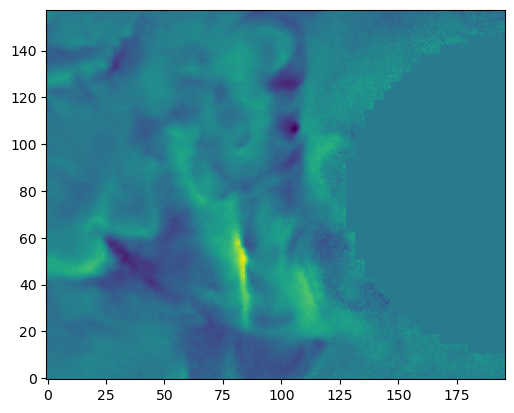

In [36]:
plt.imshow(deltaBz,origin='lower')

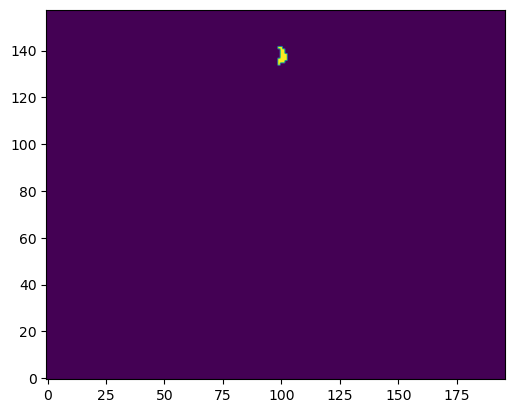

In [37]:
plt.imshow(contour_map,origin='lower')

In [192]:
import numpy as np
from scipy.ndimage import maximum_filter

def find_local_maxima(data):
    """Finds the indices of local maxima in a 2D array."""

    # Use a maximum filter to find local maxima
    neighborhood = np.ones((5, 5))
    local_max = maximum_filter(data, footprint=neighborhood)==data

    # Exclude the edges of the array
    local_max[0, :] = False
    local_max[-1, :] = False
    local_max[:, 0] = False
    local_max[:, -1] = False

    # Get the indices of the local maxima
    max_indices = np.where(local_max)
    return np.array([max_indices[0],max_indices[1]]).T

def flood_fill(Z, max_location,visited,min=0.5):
    stack = [max_location]
    original_value = Z[max_location]
    mask = np.zeros(Z.shape, dtype=bool)
    mask[max_location]=True

    directions = [(0,0), (-1, 0), (1, 0), (0, -1), (0, 1)]  # 4-connected
    while stack:
        r, c = stack.pop()

        if visited[r, c]:
            continue

        visited[r, c] = True

        for dr, dc in directions:
            nr, nc = r + dr, c + dc
            if 0 <= nr < Z.shape[0] and 0 <= nc < Z.shape[1] and not visited[nr, nc]:
                if Z[nr, nc] <= original_value and Z[nr,nc]>min:
                    mask[nr, nc] = True
                    stack.append((nr, nc))


    return mask,visited


def find_masks(Z):
    local_maxima = find_local_maxima(Z)
    masks = []
    visited = np.zeros(Z.shape, dtype=bool)
    for max_point in local_maxima:
        mask,visited = flood_fill(Z, tuple(max_point),visited)
        masks.append(mask)
    
    return masks



# Example usage
x,y = np.meshgrid(np.linspace(-1,6,71),np.linspace(-1,6,71))
z = np.cos(x)*np.cos(y)+np.sin(x/2)+0.5*np.cos(2*x)*np.cos(3*y)
dz = 0.1

masks = find_masks(z)



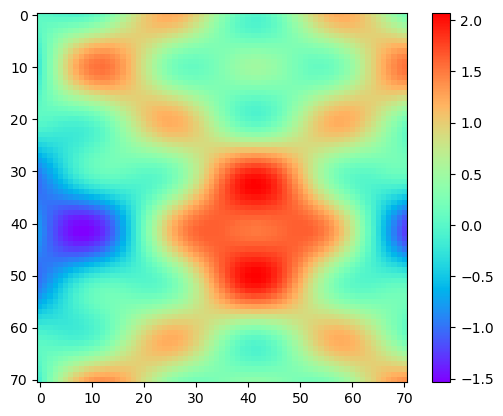

In [193]:
plt.imshow(z,cmap='rainbow')
plt.colorbar()

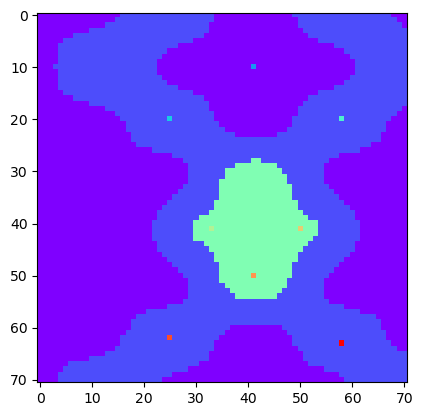

In [196]:
fill = np.zeros_like(z)
for i,mask in enumerate(masks):
    fill[mask]=i+1
plt.imshow(fill,cmap='rainbow')

In [168]:
len(masks)

3

In [138]:
z[6,6]

0.9800851433251829

In [139]:
z[5,4]

0.8494296003290209